In [8]:
import os
import re
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from pathlib import Path
from shapely import Polygon
from shapely.ops import unary_union
from shapely.geometry import LineString

from utils import get_biggest_contour

In [9]:
age = pd.read_csv('BeeLevel_AgeLookupTable.csv', index_col=0)
bee_type = pd.read_csv('BeeID_ActivityStatus.csv', index_col=0)
age['Hive'] = age['Hive'].map(lambda x: int(x))
age['BeeID'] = age['BeeID'].map(lambda x: x.replace('wwww','ww'))
bee_type['BeeID'] = bee_type['BeeID'].map(lambda x: x.replace('wwww','ww'))
bee_type = bee_type.set_index(['Hive','BeeID'])['Bee_type']
age = age.set_index(['Hive','BeeID','Date'])['Age']


In [10]:
# We skip these wings - either there was an issue with the segmentation, or we cannot see all the cells from the image
# that easily
problem_wings = [
 'Hive01_Sheet_02_slideww43_left.png',
 'Hive01_Sheet_02_slideww43_right.png',
 'Hive01_Sheet_03_slideww21-x_left.png',
 'Hive02_Sheet_01_slide23_left.png',
 'Hive02_Sheet_01_slide45_right.png',
 'Hive02_Sheet_02_slide103_left.png',
 'Hive02_Sheet_02_slide105_right.png',
 'Hive02_Sheet_03_slideww47_left.png',
 'Hive02_Sheet_03_slideww70_left.png',
 'Hive03_Sheet_01_slide115_left.png',
 'Hive03_Sheet_01_slideww45_right.png',
 'Hive04_Sheet_01_slide38_right.png',
 'Hive04_Sheet_01_slideww28_left.png',
 'Hive04_Sheet_02_slide38_right.png',
 'Hive04_Sheet_02_slideww28_left.png',
 'Hive05_Sheet_01_slideww82_left.png',
 'Hive06_Sheet_02_slide62_right.png',
 'Hive06_Sheet_03_slide115_left.png',
 'Hive06_Sheet_03_slide80_left.png',
 'Hive06_Sheet_04_slide125_right.png',
 'Hive07_Sheet_01_slide33_left.png',
 'Hive07_Sheet_04_slide120_left.png',
 'Hive07_Sheet_04_slide122_left.png',
 'Hive07_Sheet_04_slide129_left.png',
 'Hive07_Sheet_05_slide160_left.png',
 'Hive07_Sheet_05_slide162_left.png',
 'Hive07_Sheet_05_slide71_left.png',
 'Hive08_Sheet_01_slide20_left.png',
 'Hive08_Sheet_01_slide22_left.png',
 'Hive08_Sheet_02_slide72_left.png',
 'Hive08_Sheet_03_slide124_left.png',
 'Hive08_Sheet_04_slide138_left.png',
 'Hive08_Sheet_04_slide148_left.png',
 'Hive08_Sheet_05_slide74_left.png',
 'Hive08_Sheet_06_slide133_left.png',
 'Hive08_Sheet_06_slide77_right.png',
 'Hive09_Sheet_03_slide104_right.png',
 'Hive09_Sheet_03_slide78_right.png',
 'Hive09_Sheet_03_slide87_left.png',
 'Hive09_Sheet_03_slide87_right.png',
 'Hive09_Sheet_03_slide95_left.png',
 'Hive09_Sheet_05_slide161_right.png',
 'Hive10_Sheet_04_slide124_left.png',
 'Hive10_Sheet_05_slide146_left.png',
 'Hive12_Sheet_01_slide14_left.png',
 'Hive12_Sheet_02_slideww28_right.png',
 'Hive13_Sheet_02_slideww24_left.png',
 'Hive13_Sheet_02_slideww32_left.png',
 'Hive13_Sheet_02_slideww32_right.png',
 'Hive17_Sheet_01_slide32_left.png',
 'Hive17_Sheet_01_slide3_left.png',
 'Hive18_Sheet_02_slide32_right.png',
 'Hive19_Sheet_02_slide48_right.png',
 'Hive19_Sheet_02_slide55_right.png',
 'Hive19_Sheet_03_slide43_left.png',
 'Hive19_Sheet_03_slide43_right.png',
 'Hive19_Sheet_03_slide64_left.png',
 'Hive19_Sheet_03_slide70_right.png',
 'Hive19_Sheet_03_slide73_right.png',
 'Hive20_Sheet_01_slide28_left.png',
 'Hive20_Sheet_02_slide47_right.png',
 'Hive20_Sheet_02_slide52_right.png',
 'Hive20_Sheet_02_slide59_right.png',
 'Hive20_Sheet_03_slide78_left.png',
 'Hive21_Sheet_01_slide12_right.png',
 'Hive21_Sheet_01_slideww04_left.png',
 'Hive22_Sheet_01_slide32_left.png',
 'Hive22_Sheet_01_slide45_right.png',
 'Hive22_Sheet_01_slideww32_left.png',
 'Hive22_Sheet_01_slideww32_right.png',
 'Hive23_Sheet_01_slide23_right.png',
 'Hive23_Sheet_01_slideww10_left.png',
 'Hive23_Sheet_01_slideww10_right.png',
 'Hive24_Sheet_01_slide25_right.png',
 'Hive24_Sheet_01_slide27_left.png',
 'Hive24_Sheet_01_slide3_right.png',
 'Hive24_Sheet_01_slideww18_left.png',
 'Hive24_Sheet_01_slideww18_right.png',
 'Hive25_Sheet_01_slide30_left.png',
 'Hive25_Sheet_01_slide51_right.png',
 'Hive25_Sheet_01_slide60_right.png',
 'Hive25_Sheet_01_slideww27_left.png',
 'Hive26_Sheet_02_slide31_left.png',
 'Hive26_Sheet_02_slide44_left.png',
 'Hive26_Sheet_03_slide93_left.png',
 'Hive27_Sheet_01_slide21_left.png',
 'Hive27_Sheet_02_slide84_left.png',
 'Hive27_Sheet_02_slide84_right.png',
 'Hive28_Sheet_03_slide65_left.png',
 'Hive28_Sheet_03_slide65_right.png',
 'Hive28_Sheet_03_slide72_right.png',
 'Hive28_Sheet_03_slide75_left.png',
 'Hive29_Sheet_02_slide48_right.png',
 'Hive29_Sheet_02_slide52_left.png',
 'Hive29_Sheet_02_slide52_right.png',
 'Hive30_Sheet_02_slide58_left.png',
 'Hive30_Sheet_02_slide70_left.png',
 'Hive30_Sheet_02_slide70_right.png',
 'Hive31_Sheet_01_slide51_left.png',
 'Hive31_Sheet_01_slide51_right.png',
 'Hive32_Sheet_01_slide22_left.png',
 'Hive32_Sheet_01_slide35_left.png',
 'Hive32_Sheet_01_slide44_left.png',
 'Hive32_Sheet_01_slide44_right.png',
 'Hive32_Sheet_01_slide57_right.png',
 'Hive32_Sheet_01_slide74_right.png',
 'Hive32_Sheet_01_slideww11_right.png',
 'Hive32_Sheet_01_slideww13_left.png',
 'Hive32_Sheet_01_slideww13_right.png',
 'Hive32_Sheet_01_slideww18_left.png',
 'Hive32_Sheet_01_slideww18_right.png',
 'Hive32_Sheet_01_slideww1_left.png',
 'Hive32_Sheet_01_slideww26_right.png',
 'Hive32_Sheet_01_slideww44_left.png',
 'Hive33_Sheet_01_slideww3_left.png',
 'Hive33_Sheet_01_slideww49_left.png',
 'Hive33_Sheet_01_slideww49_right.png',
 'Hive34_Sheet_01_slide18_right.png',
 'Hive34_Sheet_01_slide27_left.png',
 'Hive34_Sheet_01_slide27_right.png',
 'Hive34_Sheet_01_slideww53_left.png',
 'Hive34_Sheet_01_slideww53_right.png',
 'Hive36_Sheet_01_slide32_right.png',
 'Hive36_Sheet_02_slide62_left.png',
 'Hive36_Sheet_02_slide67_left.png',
 'Hive36_Sheet_03_slide75_left.png',
 'Hive36_Sheet_04_slide140_left.png',
 'Hive37_Sheet_01_slide2_left.png',
 'Hive37_Sheet_02_slide40_right.png',
 'Hive38_Sheet_01_slide16_right.png',
 'Hive38_Sheet_01_slide24_left.png',
 'Hive38_Sheet_01_slide35_right.png',
 'Hive38_Sheet_02_slide75_right.png',
 'Hive38_Sheet_02_slide78_right.png',
 'Hive39_Sheet_02_slide51_right.png',
 'Hive39_Sheet_02_slide59_left.png',
 'Hive39_Sheet_03_slide92_right.png',
 'Hive40_Sheet_02_slide67_left.png',
 'Hive40_Sheet_03_slide84_left.png',
 'Hive40_Sheet_04_slide121_left.png',
 'Hive40_Sheet_04_slideww40_left.png',
 'HiveC1_Sheet_01_slide24_right.png',
 'HiveC1_Sheet_02_slide43_left.png',
 'HiveC1_Sheet_02_slide45_left.png',
 'HiveC1_Sheet_02_slide45_right.png',
 'HiveC2_Sheet_01_slide16_left.png',
 'HiveC2_Sheet_01_slide7_right.png',
 'HiveC2_Sheet_02_slide25_left.png',
 'HiveC2_Sheet_02_slide29_right.png',
 'HiveC2_Sheet_02_slide43_right.png',
 'HiveC2_Sheet_02_slide46_right.png',
 'HiveC4_Sheet_01_slide27_left.png',
 'HiveC4_Sheet_01_slide44_left.png',
 'HiveC5_Sheet_02_slide43_right.png',
 'HiveC5_Sheet_02_slide44_right.png'
 ] 



In [11]:
name_to_class = {'FWL':1, 'MC':2, '1sMC':3, '2sMC':4,'3sMC':5,'2MdC':6}
class_to_name = {1:'FWL',2:'MC',3:'1sMC',4:'2sMC',5:'3sMC',6:'2MdC'}

In [12]:
def get_area_diff_fourier_approx(cell, n_discrete_points=1000, n_pos_circles=4, n_estimation_points=1000):
    # This is the number of equally spaced points to use to approximate the integration of the
    # shape we are approximating
    #n_discrete_points = 1000
    # This is the number of 'positive' circles to approximate the shape with
    #n_pos_circles = 4
    
    #n_estimation_points = 1000

    # Strange things happen if we approximate the function with more circles than we discretized the points with...
    # pretty though!
    if n_pos_circles > n_discrete_points:
        print('WARNING! STRANGE AND POSSIBLY PRETTY THINGS WILL HAPPEN....')
    
    outline = cell.boundary
    
    
    distance_delta = outline.length / n_discrete_points
    distances = np.arange(0, outline.length, distance_delta)
    points = [outline.interpolate(distance) for distance in distances]
    multipoint = unary_union(points)
    
    complex_points = [p.x + p.y*1j for p in points]
    t_delta = 1 / n_discrete_points
    times = np.arange(0, 1, t_delta)
    
    if len(times) + 1 == len(complex_points):
        times = np.append(times, [1])
    
    
    cs = {}
    for n in range(-n_pos_circles,n_pos_circles+1):
        cs[n] = np.multiply(t_delta, np.multiply(complex_points, np.e**(-2*np.pi*1j*n*times))).sum()
    cs
    
    t_delta = 1 / n_estimation_points
    times = np.arange(0, 1, t_delta)
    
    fts = []
    for t in times:
        ft = 0
        for n in range(-n_pos_circles,n_pos_circles+1):
            ft += np.multiply(cs[n], np.e**(-2*np.pi*1j*n*t))
                              
        fts += [ft]
    fts = np.array(fts)

    approximation = Polygon([(x.real, x.imag) for x in fts])
    area_difference = ((approximation - cell).area + (cell - approximation).area)
    return area_difference / cell.area

In [13]:
fps = glob('../1_slides/6_UNet_predictions_resized/*')

out = []
for fp in tqdm(fps):
    fn = Path(fp).name
    
    if fn in problem_wings:
        continue
    
    date = np.nan
    hive_id = str(re.findall('(?<=Hive)C?[0-9]*(?=_)', fn)[0])
    bee_id = int(re.findall('(?<=slide)[0-9]+', fn.replace('ww','').replace('wv',''))[0])
    x = 'x' in fn
    
    cells_mask = cv2.imread('../1_slides/6_UNet_predictions_resized/' + fn, cv2.IMREAD_GRAYSCALE)
    seg = cv2.imread('../1_slides/2_individual_wings/' + fn)
    #plt.imshow(cells_mask*40)

    pixels_per_mm = 3359/53.4
    pixels_per_mm_max = 3367/53.4
    pixels_per_mm_min = 3352/53.4

    wing_side = 'L' if 'left' in fn else 'R'

    y_min = np.where(seg < 250)[0].min()
    y_max = np.where(seg < 250)[0].max()
    height_pixels = y_max - y_min
    H = height_pixels / pixels_per_mm
    H_max = height_pixels / pixels_per_mm_min
    H_min = height_pixels / pixels_per_mm_max

    for cell_class in range(1,7):
        cell_name = class_to_name[cell_class]
        cell_mask = np.zeros(cells_mask.shape).astype('uint8')
        cell_mask[np.where(cells_mask == cell_class)] = 1
        biggest_contour = get_biggest_contour(cell_mask)

        #convert to polygon because i suspect this will make the calculation of the perimeter more accurate
        poly = Polygon(biggest_contour.squeeze())

        pixel_area_min = poly.area*0.96
        pixel_area_max = poly.area*1.04
        
        area = np.round(poly.area / (pixels_per_mm)**2,3)
        area_min = np.round(pixel_area_min / (pixels_per_mm_max)**2,3)
        area_max = np.round(pixel_area_max / (pixels_per_mm_min)**2,3)

        pixel_perimeter_min = poly.length*0.96
        pixel_perimeter_max = poly.length*1.04
        
        perimeter = np.round(poly.length / pixels_per_mm,3)
        perimeter_min = np.round(pixel_perimeter_min / pixels_per_mm_max,3)
        perimeter_max = np.round(pixel_perimeter_max / pixels_per_mm_min,3)

        cell_circle_area_diffs = []
        if cell_class == 1:
            for n_pos_circles in range(1,31):
                try:
                    cell_circle_area_diffs += [get_area_diff_fourier_approx(poly, n_pos_circles=n_pos_circles, n_discrete_points=1000, n_estimation_points=1000)]
                except:
                    print('Getting Fourier Circles Failed!', fn, cell_name, n_pos_circles)
                    cell_circle_area_diffs += [np.nan]
        out += [[fn, hive_id, bee_id, date, wing_side, x, H, H_min, H_max, cell_name, cell_circle_area_diffs, area, area_min, area_max, perimeter, perimeter_min, perimeter_max]]

poly.area, poly.length
print(pixels_per_mm)


  0%|▏                                                                                                                                               | 4/4521 [00:10<3:12:33,  2.56s/it]

Getting Fourier Circles Failed! Hive10_Sheet_02_slide61_left.png FWL 18
Getting Fourier Circles Failed! Hive10_Sheet_02_slide61_left.png FWL 19
Getting Fourier Circles Failed! Hive10_Sheet_02_slide61_left.png FWL 20
Getting Fourier Circles Failed! Hive10_Sheet_02_slide61_left.png FWL 21
Getting Fourier Circles Failed! Hive10_Sheet_02_slide61_left.png FWL 22
Getting Fourier Circles Failed! Hive10_Sheet_02_slide61_left.png FWL 23
Getting Fourier Circles Failed! Hive10_Sheet_02_slide61_left.png FWL 24
Getting Fourier Circles Failed! Hive10_Sheet_02_slide61_left.png FWL 25
Getting Fourier Circles Failed! Hive10_Sheet_02_slide61_left.png FWL 26
Getting Fourier Circles Failed! Hive10_Sheet_02_slide61_left.png FWL 27
Getting Fourier Circles Failed! Hive10_Sheet_02_slide61_left.png FWL 28
Getting Fourier Circles Failed! Hive10_Sheet_02_slide61_left.png FWL 29


  0%|▏                                                                                                                                               | 5/4521 [00:12<3:14:55,  2.59s/it]

Getting Fourier Circles Failed! Hive10_Sheet_02_slide61_left.png FWL 30


  0%|▏                                                                                                                                               | 6/4521 [00:15<3:11:07,  2.54s/it]

Getting Fourier Circles Failed! Hive17_Sheet_01_slide26_right.png FWL 16
Getting Fourier Circles Failed! Hive17_Sheet_01_slide26_right.png FWL 17
Getting Fourier Circles Failed! Hive17_Sheet_01_slide26_right.png FWL 18
Getting Fourier Circles Failed! Hive17_Sheet_01_slide26_right.png FWL 19
Getting Fourier Circles Failed! Hive17_Sheet_01_slide26_right.png FWL 20
Getting Fourier Circles Failed! Hive17_Sheet_01_slide26_right.png FWL 21
Getting Fourier Circles Failed! Hive17_Sheet_01_slide26_right.png FWL 22
Getting Fourier Circles Failed! Hive17_Sheet_01_slide26_right.png FWL 23
Getting Fourier Circles Failed! Hive17_Sheet_01_slide26_right.png FWL 24
Getting Fourier Circles Failed! Hive17_Sheet_01_slide26_right.png FWL 25
Getting Fourier Circles Failed! Hive17_Sheet_01_slide26_right.png FWL 26
Getting Fourier Circles Failed! Hive17_Sheet_01_slide26_right.png FWL 27
Getting Fourier Circles Failed! Hive17_Sheet_01_slide26_right.png FWL 28


  0%|▏                                                                                                                                               | 7/4521 [00:17<3:12:35,  2.56s/it]

Getting Fourier Circles Failed! Hive17_Sheet_01_slide26_right.png FWL 29
Getting Fourier Circles Failed! Hive17_Sheet_01_slide26_right.png FWL 30


  0%|▎                                                                                                                                               | 9/4521 [00:23<3:13:04,  2.57s/it]

Getting Fourier Circles Failed! Hive09_Sheet_01_slide17_left.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_01_slide17_left.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_01_slide17_left.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_01_slide17_left.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_01_slide17_left.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_01_slide17_left.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_01_slide17_left.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_01_slide17_left.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_01_slide17_left.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_01_slide17_left.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_01_slide17_left.png FWL 28
Getting Fourier Circles Failed! Hive09_Sheet_01_slide17_left.png FWL 29


  0%|▎                                                                                                                                              | 10/4521 [00:25<3:16:38,  2.62s/it]

Getting Fourier Circles Failed! Hive09_Sheet_01_slide17_left.png FWL 30


  0%|▍                                                                                                                                              | 12/4521 [00:30<3:08:39,  2.51s/it]

Getting Fourier Circles Failed! Hive09_Sheet_03_slide104_left.png FWL 15
Getting Fourier Circles Failed! Hive09_Sheet_03_slide104_left.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_03_slide104_left.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_03_slide104_left.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_03_slide104_left.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_03_slide104_left.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_03_slide104_left.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_03_slide104_left.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_03_slide104_left.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_03_slide104_left.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_03_slide104_left.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_03_slide104_left.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_03_slide104_left.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_03_sli

  0%|▍                                                                                                                                              | 13/4521 [00:33<3:09:05,  2.52s/it]

Getting Fourier Circles Failed! Hive09_Sheet_03_slide104_left.png FWL 29
Getting Fourier Circles Failed! Hive09_Sheet_03_slide104_left.png FWL 30


  0%|▌                                                                                                                                              | 17/4521 [00:43<3:05:44,  2.47s/it]

Getting Fourier Circles Failed! Hive24_Sheet_01_slide5_left.png FWL 17
Getting Fourier Circles Failed! Hive24_Sheet_01_slide5_left.png FWL 18
Getting Fourier Circles Failed! Hive24_Sheet_01_slide5_left.png FWL 19
Getting Fourier Circles Failed! Hive24_Sheet_01_slide5_left.png FWL 20
Getting Fourier Circles Failed! Hive24_Sheet_01_slide5_left.png FWL 21
Getting Fourier Circles Failed! Hive24_Sheet_01_slide5_left.png FWL 22
Getting Fourier Circles Failed! Hive24_Sheet_01_slide5_left.png FWL 23
Getting Fourier Circles Failed! Hive24_Sheet_01_slide5_left.png FWL 24
Getting Fourier Circles Failed! Hive24_Sheet_01_slide5_left.png FWL 25
Getting Fourier Circles Failed! Hive24_Sheet_01_slide5_left.png FWL 26
Getting Fourier Circles Failed! Hive24_Sheet_01_slide5_left.png FWL 27
Getting Fourier Circles Failed! Hive24_Sheet_01_slide5_left.png FWL 28


  0%|▌                                                                                                                                              | 18/4521 [00:45<3:12:21,  2.56s/it]

Getting Fourier Circles Failed! Hive24_Sheet_01_slide5_left.png FWL 29
Getting Fourier Circles Failed! Hive24_Sheet_01_slide5_left.png FWL 30


  0%|▌                                                                                                                                              | 19/4521 [00:48<3:23:26,  2.71s/it]

Getting Fourier Circles Failed! Hive39_Sheet_02_slide46_right.png FWL 16
Getting Fourier Circles Failed! Hive39_Sheet_02_slide46_right.png FWL 17
Getting Fourier Circles Failed! Hive39_Sheet_02_slide46_right.png FWL 18
Getting Fourier Circles Failed! Hive39_Sheet_02_slide46_right.png FWL 19
Getting Fourier Circles Failed! Hive39_Sheet_02_slide46_right.png FWL 20
Getting Fourier Circles Failed! Hive39_Sheet_02_slide46_right.png FWL 21
Getting Fourier Circles Failed! Hive39_Sheet_02_slide46_right.png FWL 22
Getting Fourier Circles Failed! Hive39_Sheet_02_slide46_right.png FWL 23
Getting Fourier Circles Failed! Hive39_Sheet_02_slide46_right.png FWL 24
Getting Fourier Circles Failed! Hive39_Sheet_02_slide46_right.png FWL 25
Getting Fourier Circles Failed! Hive39_Sheet_02_slide46_right.png FWL 26
Getting Fourier Circles Failed! Hive39_Sheet_02_slide46_right.png FWL 27
Getting Fourier Circles Failed! Hive39_Sheet_02_slide46_right.png FWL 28
Getting Fourier Circles Failed! Hive39_Sheet_02_sli

  0%|▋                                                                                                                                              | 20/4521 [00:51<3:30:34,  2.81s/it]

Getting Fourier Circles Failed! Hive39_Sheet_02_slide46_right.png FWL 30


  0%|▋                                                                                                                                              | 22/4521 [00:57<3:26:21,  2.75s/it]

Getting Fourier Circles Failed! Hive37_Sheet_01_slide20_left.png FWL 16
Getting Fourier Circles Failed! Hive37_Sheet_01_slide20_left.png FWL 17
Getting Fourier Circles Failed! Hive37_Sheet_01_slide20_left.png FWL 18
Getting Fourier Circles Failed! Hive37_Sheet_01_slide20_left.png FWL 19
Getting Fourier Circles Failed! Hive37_Sheet_01_slide20_left.png FWL 20
Getting Fourier Circles Failed! Hive37_Sheet_01_slide20_left.png FWL 21
Getting Fourier Circles Failed! Hive37_Sheet_01_slide20_left.png FWL 22
Getting Fourier Circles Failed! Hive37_Sheet_01_slide20_left.png FWL 23
Getting Fourier Circles Failed! Hive37_Sheet_01_slide20_left.png FWL 24
Getting Fourier Circles Failed! Hive37_Sheet_01_slide20_left.png FWL 25
Getting Fourier Circles Failed! Hive37_Sheet_01_slide20_left.png FWL 26
Getting Fourier Circles Failed! Hive37_Sheet_01_slide20_left.png FWL 27
Getting Fourier Circles Failed! Hive37_Sheet_01_slide20_left.png FWL 28
Getting Fourier Circles Failed! Hive37_Sheet_01_slide20_left.png

  1%|▋                                                                                                                                              | 23/4521 [01:00<3:28:50,  2.79s/it]

Getting Fourier Circles Failed! Hive37_Sheet_01_slide20_left.png FWL 30


  1%|▉                                                                                                                                              | 28/4521 [01:13<3:20:12,  2.67s/it]

Getting Fourier Circles Failed! Hive40_Sheet_02_slide67_right.png FWL 17
Getting Fourier Circles Failed! Hive40_Sheet_02_slide67_right.png FWL 18
Getting Fourier Circles Failed! Hive40_Sheet_02_slide67_right.png FWL 19
Getting Fourier Circles Failed! Hive40_Sheet_02_slide67_right.png FWL 20
Getting Fourier Circles Failed! Hive40_Sheet_02_slide67_right.png FWL 21
Getting Fourier Circles Failed! Hive40_Sheet_02_slide67_right.png FWL 22
Getting Fourier Circles Failed! Hive40_Sheet_02_slide67_right.png FWL 23
Getting Fourier Circles Failed! Hive40_Sheet_02_slide67_right.png FWL 24
Getting Fourier Circles Failed! Hive40_Sheet_02_slide67_right.png FWL 25
Getting Fourier Circles Failed! Hive40_Sheet_02_slide67_right.png FWL 26
Getting Fourier Circles Failed! Hive40_Sheet_02_slide67_right.png FWL 27
Getting Fourier Circles Failed! Hive40_Sheet_02_slide67_right.png FWL 28


  1%|▉                                                                                                                                              | 29/4521 [01:16<3:23:19,  2.72s/it]

Getting Fourier Circles Failed! Hive40_Sheet_02_slide67_right.png FWL 29
Getting Fourier Circles Failed! Hive40_Sheet_02_slide67_right.png FWL 30


  1%|▉                                                                                                                                              | 31/4521 [01:21<3:20:44,  2.68s/it]

Getting Fourier Circles Failed! Hive06_Sheet_01_slide2_right.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_01_slide2_right.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_01_slide2_right.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_01_slide2_right.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_01_slide2_right.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_01_slide2_right.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_01_slide2_right.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_01_slide2_right.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_01_slide2_right.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_01_slide2_right.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_01_slide2_right.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_01_slide2_right.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_01_slide2_right.png FWL 28
Getting Fourier Circles Failed! Hive06_Sheet_01_slide2_right.png

  1%|█                                                                                                                                              | 32/4521 [01:24<3:24:09,  2.73s/it]

Getting Fourier Circles Failed! Hive06_Sheet_01_slide2_right.png FWL 30


  1%|█▏                                                                                                                                             | 37/4521 [01:38<3:38:45,  2.93s/it]

Getting Fourier Circles Failed! Hive22_Sheet_01_slideww16_left.png FWL 18
Getting Fourier Circles Failed! Hive22_Sheet_01_slideww16_left.png FWL 19
Getting Fourier Circles Failed! Hive22_Sheet_01_slideww16_left.png FWL 20
Getting Fourier Circles Failed! Hive22_Sheet_01_slideww16_left.png FWL 21
Getting Fourier Circles Failed! Hive22_Sheet_01_slideww16_left.png FWL 22
Getting Fourier Circles Failed! Hive22_Sheet_01_slideww16_left.png FWL 23
Getting Fourier Circles Failed! Hive22_Sheet_01_slideww16_left.png FWL 24
Getting Fourier Circles Failed! Hive22_Sheet_01_slideww16_left.png FWL 25
Getting Fourier Circles Failed! Hive22_Sheet_01_slideww16_left.png FWL 26
Getting Fourier Circles Failed! Hive22_Sheet_01_slideww16_left.png FWL 27
Getting Fourier Circles Failed! Hive22_Sheet_01_slideww16_left.png FWL 28
Getting Fourier Circles Failed! Hive22_Sheet_01_slideww16_left.png FWL 29


  1%|█▏                                                                                                                                             | 38/4521 [01:41<3:34:41,  2.87s/it]

Getting Fourier Circles Failed! Hive22_Sheet_01_slideww16_left.png FWL 30
Getting Fourier Circles Failed! Hive40_Sheet_03_slide91_right.png FWL 18
Getting Fourier Circles Failed! Hive40_Sheet_03_slide91_right.png FWL 19
Getting Fourier Circles Failed! Hive40_Sheet_03_slide91_right.png FWL 20
Getting Fourier Circles Failed! Hive40_Sheet_03_slide91_right.png FWL 21
Getting Fourier Circles Failed! Hive40_Sheet_03_slide91_right.png FWL 22
Getting Fourier Circles Failed! Hive40_Sheet_03_slide91_right.png FWL 23
Getting Fourier Circles Failed! Hive40_Sheet_03_slide91_right.png FWL 24
Getting Fourier Circles Failed! Hive40_Sheet_03_slide91_right.png FWL 25
Getting Fourier Circles Failed! Hive40_Sheet_03_slide91_right.png FWL 26
Getting Fourier Circles Failed! Hive40_Sheet_03_slide91_right.png FWL 27
Getting Fourier Circles Failed! Hive40_Sheet_03_slide91_right.png FWL 28
Getting Fourier Circles Failed! Hive40_Sheet_03_slide91_right.png FWL 29


  1%|█▏                                                                                                                                             | 39/4521 [01:44<3:42:51,  2.98s/it]

Getting Fourier Circles Failed! Hive40_Sheet_03_slide91_right.png FWL 30


  1%|█▍                                                                                                                                             | 47/4521 [02:07<3:27:16,  2.78s/it]

Getting Fourier Circles Failed! Hive06_Sheet_04_slide127-x_left.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_04_slide127-x_left.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_04_slide127-x_left.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_04_slide127-x_left.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_04_slide127-x_left.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_04_slide127-x_left.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_04_slide127-x_left.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_04_slide127-x_left.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_04_slide127-x_left.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_04_slide127-x_left.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_04_slide127-x_left.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_04_slide127-x_left.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_04_slide127-x_left.png FWL 28


  1%|█▌                                                                                                                                             | 48/4521 [02:10<3:29:22,  2.81s/it]

Getting Fourier Circles Failed! Hive06_Sheet_04_slide127-x_left.png FWL 29
Getting Fourier Circles Failed! Hive06_Sheet_04_slide127-x_left.png FWL 30


  1%|█▌                                                                                                                                             | 51/4521 [02:18<3:23:25,  2.73s/it]

Getting Fourier Circles Failed! Hive09_Sheet_05_slide157_right.png FWL 15
Getting Fourier Circles Failed! Hive09_Sheet_05_slide157_right.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_05_slide157_right.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_05_slide157_right.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_05_slide157_right.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_05_slide157_right.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_05_slide157_right.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_05_slide157_right.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_05_slide157_right.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_05_slide157_right.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_05_slide157_right.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_05_slide157_right.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_05_slide157_right.png FWL 27
Getting Fourier Circles Failed! Hive09

  1%|█▋                                                                                                                                             | 52/4521 [02:21<3:25:10,  2.75s/it]

Getting Fourier Circles Failed! Hive09_Sheet_05_slide157_right.png FWL 29
Getting Fourier Circles Failed! Hive09_Sheet_05_slide157_right.png FWL 30
Getting Fourier Circles Failed! Hive08_Sheet_05_slide178_right.png FWL 16
Getting Fourier Circles Failed! Hive08_Sheet_05_slide178_right.png FWL 17
Getting Fourier Circles Failed! Hive08_Sheet_05_slide178_right.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_05_slide178_right.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_05_slide178_right.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_05_slide178_right.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_05_slide178_right.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_05_slide178_right.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_05_slide178_right.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_05_slide178_right.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_05_slide178_right.png FWL 26
Getting Fourier Circles Failed! Hive08

  1%|█▋                                                                                                                                             | 53/4521 [02:24<3:27:21,  2.78s/it]

Getting Fourier Circles Failed! Hive08_Sheet_05_slide178_right.png FWL 29
Getting Fourier Circles Failed! Hive08_Sheet_05_slide178_right.png FWL 30


  1%|█▋                                                                                                                                             | 54/4521 [02:27<3:26:31,  2.77s/it]

Getting Fourier Circles Failed! Hive40_Sheet_01_slide27_left.png FWL 17
Getting Fourier Circles Failed! Hive40_Sheet_01_slide27_left.png FWL 18
Getting Fourier Circles Failed! Hive40_Sheet_01_slide27_left.png FWL 19
Getting Fourier Circles Failed! Hive40_Sheet_01_slide27_left.png FWL 20
Getting Fourier Circles Failed! Hive40_Sheet_01_slide27_left.png FWL 21
Getting Fourier Circles Failed! Hive40_Sheet_01_slide27_left.png FWL 22
Getting Fourier Circles Failed! Hive40_Sheet_01_slide27_left.png FWL 23
Getting Fourier Circles Failed! Hive40_Sheet_01_slide27_left.png FWL 24
Getting Fourier Circles Failed! Hive40_Sheet_01_slide27_left.png FWL 25
Getting Fourier Circles Failed! Hive40_Sheet_01_slide27_left.png FWL 26
Getting Fourier Circles Failed! Hive40_Sheet_01_slide27_left.png FWL 27
Getting Fourier Circles Failed! Hive40_Sheet_01_slide27_left.png FWL 28


  1%|█▋                                                                                                                                             | 55/4521 [02:29<3:27:23,  2.79s/it]

Getting Fourier Circles Failed! Hive40_Sheet_01_slide27_left.png FWL 29
Getting Fourier Circles Failed! Hive40_Sheet_01_slide27_left.png FWL 30


  1%|█▊                                                                                                                                             | 58/4521 [02:35<2:37:32,  2.12s/it]

Getting Fourier Circles Failed! Hive02_Sheet_03_slideww42_left.png FWL 23


  1%|█▊                                                                                                                                             | 59/4521 [02:37<2:46:02,  2.23s/it]

Getting Fourier Circles Failed! Hive28_Sheet_02_slide55_left.png FWL 16
Getting Fourier Circles Failed! Hive28_Sheet_02_slide55_left.png FWL 17
Getting Fourier Circles Failed! Hive28_Sheet_02_slide55_left.png FWL 18
Getting Fourier Circles Failed! Hive28_Sheet_02_slide55_left.png FWL 19
Getting Fourier Circles Failed! Hive28_Sheet_02_slide55_left.png FWL 20
Getting Fourier Circles Failed! Hive28_Sheet_02_slide55_left.png FWL 21
Getting Fourier Circles Failed! Hive28_Sheet_02_slide55_left.png FWL 22
Getting Fourier Circles Failed! Hive28_Sheet_02_slide55_left.png FWL 23
Getting Fourier Circles Failed! Hive28_Sheet_02_slide55_left.png FWL 24
Getting Fourier Circles Failed! Hive28_Sheet_02_slide55_left.png FWL 25
Getting Fourier Circles Failed! Hive28_Sheet_02_slide55_left.png FWL 26
Getting Fourier Circles Failed! Hive28_Sheet_02_slide55_left.png FWL 27
Getting Fourier Circles Failed! Hive28_Sheet_02_slide55_left.png FWL 28
Getting Fourier Circles Failed! Hive28_Sheet_02_slide55_left.png

  1%|█▉                                                                                                                                             | 60/4521 [02:40<2:58:22,  2.40s/it]

Getting Fourier Circles Failed! Hive28_Sheet_02_slide55_left.png FWL 30


  1%|██                                                                                                                                             | 64/4521 [02:51<3:11:10,  2.57s/it]

Getting Fourier Circles Failed! Hive06_Sheet_04_slide133_right.png FWL 15
Getting Fourier Circles Failed! Hive06_Sheet_04_slide133_right.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_04_slide133_right.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_04_slide133_right.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_04_slide133_right.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_04_slide133_right.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_04_slide133_right.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_04_slide133_right.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_04_slide133_right.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_04_slide133_right.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_04_slide133_right.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_04_slide133_right.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_04_slide133_right.png FWL 27
Getting Fourier Circles Failed! Hive06

  1%|██                                                                                                                                             | 65/4521 [02:54<3:19:17,  2.68s/it]

Getting Fourier Circles Failed! Hive06_Sheet_04_slide133_right.png FWL 29
Getting Fourier Circles Failed! Hive06_Sheet_04_slide133_right.png FWL 30


  2%|██▏                                                                                                                                            | 71/4521 [03:10<3:23:02,  2.74s/it]

Getting Fourier Circles Failed! Hive14_Sheet_01_slide18_right.png FWL 16
Getting Fourier Circles Failed! Hive14_Sheet_01_slide18_right.png FWL 17
Getting Fourier Circles Failed! Hive14_Sheet_01_slide18_right.png FWL 18
Getting Fourier Circles Failed! Hive14_Sheet_01_slide18_right.png FWL 19
Getting Fourier Circles Failed! Hive14_Sheet_01_slide18_right.png FWL 20
Getting Fourier Circles Failed! Hive14_Sheet_01_slide18_right.png FWL 21
Getting Fourier Circles Failed! Hive14_Sheet_01_slide18_right.png FWL 22
Getting Fourier Circles Failed! Hive14_Sheet_01_slide18_right.png FWL 23
Getting Fourier Circles Failed! Hive14_Sheet_01_slide18_right.png FWL 24
Getting Fourier Circles Failed! Hive14_Sheet_01_slide18_right.png FWL 25
Getting Fourier Circles Failed! Hive14_Sheet_01_slide18_right.png FWL 26
Getting Fourier Circles Failed! Hive14_Sheet_01_slide18_right.png FWL 27
Getting Fourier Circles Failed! Hive14_Sheet_01_slide18_right.png FWL 28
Getting Fourier Circles Failed! Hive14_Sheet_01_sli

  2%|██▎                                                                                                                                            | 73/4521 [03:13<2:39:49,  2.16s/it]

Getting Fourier Circles Failed! Hive14_Sheet_01_slide18_right.png FWL 30


  2%|██▉                                                                                                                                            | 92/4521 [04:01<3:09:33,  2.57s/it]

Getting Fourier Circles Failed! Hive29_Sheet_02_slide38_right.png FWL 16
Getting Fourier Circles Failed! Hive29_Sheet_02_slide38_right.png FWL 17
Getting Fourier Circles Failed! Hive29_Sheet_02_slide38_right.png FWL 18
Getting Fourier Circles Failed! Hive29_Sheet_02_slide38_right.png FWL 19
Getting Fourier Circles Failed! Hive29_Sheet_02_slide38_right.png FWL 20
Getting Fourier Circles Failed! Hive29_Sheet_02_slide38_right.png FWL 21
Getting Fourier Circles Failed! Hive29_Sheet_02_slide38_right.png FWL 22
Getting Fourier Circles Failed! Hive29_Sheet_02_slide38_right.png FWL 23
Getting Fourier Circles Failed! Hive29_Sheet_02_slide38_right.png FWL 24
Getting Fourier Circles Failed! Hive29_Sheet_02_slide38_right.png FWL 25
Getting Fourier Circles Failed! Hive29_Sheet_02_slide38_right.png FWL 26
Getting Fourier Circles Failed! Hive29_Sheet_02_slide38_right.png FWL 27
Getting Fourier Circles Failed! Hive29_Sheet_02_slide38_right.png FWL 28
Getting Fourier Circles Failed! Hive29_Sheet_02_sli

  2%|██▉                                                                                                                                            | 93/4521 [04:04<3:19:35,  2.70s/it]

Getting Fourier Circles Failed! Hive29_Sheet_02_slide38_right.png FWL 30


  2%|███▎                                                                                                                                          | 105/4521 [04:36<3:17:42,  2.69s/it]

Getting Fourier Circles Failed! Hive06_Sheet_01_slide4_right.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_01_slide4_right.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_01_slide4_right.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_01_slide4_right.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_01_slide4_right.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_01_slide4_right.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_01_slide4_right.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_01_slide4_right.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_01_slide4_right.png FWL 28
Getting Fourier Circles Failed! Hive06_Sheet_01_slide4_right.png FWL 29


  2%|███▎                                                                                                                                          | 106/4521 [04:39<3:18:21,  2.70s/it]

Getting Fourier Circles Failed! Hive06_Sheet_01_slide4_right.png FWL 30


  2%|███▌                                                                                                                                          | 113/4521 [04:54<2:51:52,  2.34s/it]

Getting Fourier Circles Failed! Hive02_Sheet_02_slide105_left.png FWL 16
Getting Fourier Circles Failed! Hive02_Sheet_02_slide105_left.png FWL 17
Getting Fourier Circles Failed! Hive02_Sheet_02_slide105_left.png FWL 18
Getting Fourier Circles Failed! Hive02_Sheet_02_slide105_left.png FWL 19
Getting Fourier Circles Failed! Hive02_Sheet_02_slide105_left.png FWL 20
Getting Fourier Circles Failed! Hive02_Sheet_02_slide105_left.png FWL 21
Getting Fourier Circles Failed! Hive02_Sheet_02_slide105_left.png FWL 22
Getting Fourier Circles Failed! Hive02_Sheet_02_slide105_left.png FWL 23
Getting Fourier Circles Failed! Hive02_Sheet_02_slide105_left.png FWL 24
Getting Fourier Circles Failed! Hive02_Sheet_02_slide105_left.png FWL 25
Getting Fourier Circles Failed! Hive02_Sheet_02_slide105_left.png FWL 26
Getting Fourier Circles Failed! Hive02_Sheet_02_slide105_left.png FWL 27
Getting Fourier Circles Failed! Hive02_Sheet_02_slide105_left.png FWL 28
Getting Fourier Circles Failed! Hive02_Sheet_02_sli

  3%|███▌                                                                                                                                          | 114/4521 [04:57<3:00:02,  2.45s/it]

Getting Fourier Circles Failed! Hive02_Sheet_02_slide105_left.png FWL 30


  3%|███▊                                                                                                                                          | 123/4521 [05:20<3:07:56,  2.56s/it]

Getting Fourier Circles Failed! Hive11_Sheet_01_slide10_left.png FWL 18
Getting Fourier Circles Failed! Hive11_Sheet_01_slide10_left.png FWL 19
Getting Fourier Circles Failed! Hive11_Sheet_01_slide10_left.png FWL 20
Getting Fourier Circles Failed! Hive11_Sheet_01_slide10_left.png FWL 21
Getting Fourier Circles Failed! Hive11_Sheet_01_slide10_left.png FWL 22
Getting Fourier Circles Failed! Hive11_Sheet_01_slide10_left.png FWL 23
Getting Fourier Circles Failed! Hive11_Sheet_01_slide10_left.png FWL 24
Getting Fourier Circles Failed! Hive11_Sheet_01_slide10_left.png FWL 25
Getting Fourier Circles Failed! Hive11_Sheet_01_slide10_left.png FWL 26
Getting Fourier Circles Failed! Hive11_Sheet_01_slide10_left.png FWL 27
Getting Fourier Circles Failed! Hive11_Sheet_01_slide10_left.png FWL 28
Getting Fourier Circles Failed! Hive11_Sheet_01_slide10_left.png FWL 29


  3%|███▉                                                                                                                                          | 124/4521 [05:23<3:14:59,  2.66s/it]

Getting Fourier Circles Failed! Hive11_Sheet_01_slide10_left.png FWL 30


  3%|████                                                                                                                                          | 130/4521 [05:38<3:09:18,  2.59s/it]

Getting Fourier Circles Failed! Hive29_Sheet_02_slide47_right.png FWL 16
Getting Fourier Circles Failed! Hive29_Sheet_02_slide47_right.png FWL 17
Getting Fourier Circles Failed! Hive29_Sheet_02_slide47_right.png FWL 18
Getting Fourier Circles Failed! Hive29_Sheet_02_slide47_right.png FWL 19
Getting Fourier Circles Failed! Hive29_Sheet_02_slide47_right.png FWL 20
Getting Fourier Circles Failed! Hive29_Sheet_02_slide47_right.png FWL 21
Getting Fourier Circles Failed! Hive29_Sheet_02_slide47_right.png FWL 22
Getting Fourier Circles Failed! Hive29_Sheet_02_slide47_right.png FWL 23
Getting Fourier Circles Failed! Hive29_Sheet_02_slide47_right.png FWL 24
Getting Fourier Circles Failed! Hive29_Sheet_02_slide47_right.png FWL 25
Getting Fourier Circles Failed! Hive29_Sheet_02_slide47_right.png FWL 26
Getting Fourier Circles Failed! Hive29_Sheet_02_slide47_right.png FWL 27
Getting Fourier Circles Failed! Hive29_Sheet_02_slide47_right.png FWL 28


  3%|████                                                                                                                                          | 131/4521 [05:41<3:17:49,  2.70s/it]

Getting Fourier Circles Failed! Hive29_Sheet_02_slide47_right.png FWL 29
Getting Fourier Circles Failed! Hive29_Sheet_02_slide47_right.png FWL 30
Getting Fourier Circles Failed! Hive13_Sheet_01_slide2_right.png FWL 16
Getting Fourier Circles Failed! Hive13_Sheet_01_slide2_right.png FWL 17
Getting Fourier Circles Failed! Hive13_Sheet_01_slide2_right.png FWL 18
Getting Fourier Circles Failed! Hive13_Sheet_01_slide2_right.png FWL 19
Getting Fourier Circles Failed! Hive13_Sheet_01_slide2_right.png FWL 20
Getting Fourier Circles Failed! Hive13_Sheet_01_slide2_right.png FWL 21
Getting Fourier Circles Failed! Hive13_Sheet_01_slide2_right.png FWL 22
Getting Fourier Circles Failed! Hive13_Sheet_01_slide2_right.png FWL 23
Getting Fourier Circles Failed! Hive13_Sheet_01_slide2_right.png FWL 24
Getting Fourier Circles Failed! Hive13_Sheet_01_slide2_right.png FWL 25
Getting Fourier Circles Failed! Hive13_Sheet_01_slide2_right.png FWL 26
Getting Fourier Circles Failed! Hive13_Sheet_01_slide2_right.p

  3%|████▏                                                                                                                                         | 132/4521 [05:44<3:20:25,  2.74s/it]

Getting Fourier Circles Failed! Hive13_Sheet_01_slide2_right.png FWL 29
Getting Fourier Circles Failed! Hive13_Sheet_01_slide2_right.png FWL 30


  3%|████▏                                                                                                                                         | 134/4521 [05:49<3:14:04,  2.65s/it]

Getting Fourier Circles Failed! Hive07_Sheet_05_slide160_right.png FWL 15
Getting Fourier Circles Failed! Hive07_Sheet_05_slide160_right.png FWL 16
Getting Fourier Circles Failed! Hive07_Sheet_05_slide160_right.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_05_slide160_right.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_05_slide160_right.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_05_slide160_right.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_05_slide160_right.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_05_slide160_right.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_05_slide160_right.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_05_slide160_right.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_05_slide160_right.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_05_slide160_right.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_05_slide160_right.png FWL 27
Getting Fourier Circles Failed! Hive07

  3%|████▏                                                                                                                                         | 135/4521 [05:52<3:19:44,  2.73s/it]

Getting Fourier Circles Failed! Hive07_Sheet_05_slide160_right.png FWL 29
Getting Fourier Circles Failed! Hive07_Sheet_05_slide160_right.png FWL 30


  3%|████▋                                                                                                                                         | 148/4521 [06:26<3:08:06,  2.58s/it]

Getting Fourier Circles Failed! Hive15_Sheet_01_slide12_right.png FWL 15
Getting Fourier Circles Failed! Hive15_Sheet_01_slide12_right.png FWL 16
Getting Fourier Circles Failed! Hive15_Sheet_01_slide12_right.png FWL 17
Getting Fourier Circles Failed! Hive15_Sheet_01_slide12_right.png FWL 18
Getting Fourier Circles Failed! Hive15_Sheet_01_slide12_right.png FWL 19
Getting Fourier Circles Failed! Hive15_Sheet_01_slide12_right.png FWL 20
Getting Fourier Circles Failed! Hive15_Sheet_01_slide12_right.png FWL 21
Getting Fourier Circles Failed! Hive15_Sheet_01_slide12_right.png FWL 22
Getting Fourier Circles Failed! Hive15_Sheet_01_slide12_right.png FWL 23
Getting Fourier Circles Failed! Hive15_Sheet_01_slide12_right.png FWL 24
Getting Fourier Circles Failed! Hive15_Sheet_01_slide12_right.png FWL 25
Getting Fourier Circles Failed! Hive15_Sheet_01_slide12_right.png FWL 26
Getting Fourier Circles Failed! Hive15_Sheet_01_slide12_right.png FWL 27
Getting Fourier Circles Failed! Hive15_Sheet_01_sli

  3%|████▋                                                                                                                                         | 149/4521 [06:29<3:10:50,  2.62s/it]

Getting Fourier Circles Failed! Hive15_Sheet_01_slide12_right.png FWL 30


  3%|████▋                                                                                                                                         | 151/4521 [06:34<3:05:49,  2.55s/it]

Getting Fourier Circles Failed! Hive39_Sheet_01_slide17_left.png FWL 19
Getting Fourier Circles Failed! Hive39_Sheet_01_slide17_left.png FWL 20
Getting Fourier Circles Failed! Hive39_Sheet_01_slide17_left.png FWL 21
Getting Fourier Circles Failed! Hive39_Sheet_01_slide17_left.png FWL 22
Getting Fourier Circles Failed! Hive39_Sheet_01_slide17_left.png FWL 23
Getting Fourier Circles Failed! Hive39_Sheet_01_slide17_left.png FWL 24
Getting Fourier Circles Failed! Hive39_Sheet_01_slide17_left.png FWL 25
Getting Fourier Circles Failed! Hive39_Sheet_01_slide17_left.png FWL 26
Getting Fourier Circles Failed! Hive39_Sheet_01_slide17_left.png FWL 27
Getting Fourier Circles Failed! Hive39_Sheet_01_slide17_left.png FWL 28


  3%|████▊                                                                                                                                         | 152/4521 [06:36<3:09:09,  2.60s/it]

Getting Fourier Circles Failed! Hive39_Sheet_01_slide17_left.png FWL 29
Getting Fourier Circles Failed! Hive39_Sheet_01_slide17_left.png FWL 30


  4%|█████▊                                                                                                                                        | 187/4521 [08:06<2:56:11,  2.44s/it]

Getting Fourier Circles Failed! Hive40_Sheet_03_slide85_left.png FWL 16
Getting Fourier Circles Failed! Hive40_Sheet_03_slide85_left.png FWL 17
Getting Fourier Circles Failed! Hive40_Sheet_03_slide85_left.png FWL 18
Getting Fourier Circles Failed! Hive40_Sheet_03_slide85_left.png FWL 19
Getting Fourier Circles Failed! Hive40_Sheet_03_slide85_left.png FWL 20
Getting Fourier Circles Failed! Hive40_Sheet_03_slide85_left.png FWL 21
Getting Fourier Circles Failed! Hive40_Sheet_03_slide85_left.png FWL 22
Getting Fourier Circles Failed! Hive40_Sheet_03_slide85_left.png FWL 23
Getting Fourier Circles Failed! Hive40_Sheet_03_slide85_left.png FWL 24
Getting Fourier Circles Failed! Hive40_Sheet_03_slide85_left.png FWL 25
Getting Fourier Circles Failed! Hive40_Sheet_03_slide85_left.png FWL 26
Getting Fourier Circles Failed! Hive40_Sheet_03_slide85_left.png FWL 27
Getting Fourier Circles Failed! Hive40_Sheet_03_slide85_left.png FWL 28


  4%|█████▉                                                                                                                                        | 188/4521 [08:09<3:02:56,  2.53s/it]

Getting Fourier Circles Failed! Hive40_Sheet_03_slide85_left.png FWL 29
Getting Fourier Circles Failed! Hive40_Sheet_03_slide85_left.png FWL 30


  4%|██████▏                                                                                                                                       | 196/4521 [08:27<2:50:33,  2.37s/it]

Getting Fourier Circles Failed! Hive36_Sheet_01_slide32_left.png FWL 20
Getting Fourier Circles Failed! Hive36_Sheet_01_slide32_left.png FWL 21
Getting Fourier Circles Failed! Hive36_Sheet_01_slide32_left.png FWL 22
Getting Fourier Circles Failed! Hive36_Sheet_01_slide32_left.png FWL 23
Getting Fourier Circles Failed! Hive36_Sheet_01_slide32_left.png FWL 24
Getting Fourier Circles Failed! Hive36_Sheet_01_slide32_left.png FWL 25
Getting Fourier Circles Failed! Hive36_Sheet_01_slide32_left.png FWL 26
Getting Fourier Circles Failed! Hive36_Sheet_01_slide32_left.png FWL 27
Getting Fourier Circles Failed! Hive36_Sheet_01_slide32_left.png FWL 28
Getting Fourier Circles Failed! Hive36_Sheet_01_slide32_left.png FWL 29


  4%|██████▏                                                                                                                                       | 197/4521 [08:29<2:56:16,  2.45s/it]

Getting Fourier Circles Failed! Hive36_Sheet_01_slide32_left.png FWL 30


  4%|██████▍                                                                                                                                       | 203/4521 [08:45<3:06:00,  2.58s/it]

Getting Fourier Circles Failed! Hive36_Sheet_03_slide91_right.png FWL 15
Getting Fourier Circles Failed! Hive36_Sheet_03_slide91_right.png FWL 16
Getting Fourier Circles Failed! Hive36_Sheet_03_slide91_right.png FWL 17
Getting Fourier Circles Failed! Hive36_Sheet_03_slide91_right.png FWL 18
Getting Fourier Circles Failed! Hive36_Sheet_03_slide91_right.png FWL 19
Getting Fourier Circles Failed! Hive36_Sheet_03_slide91_right.png FWL 20
Getting Fourier Circles Failed! Hive36_Sheet_03_slide91_right.png FWL 21
Getting Fourier Circles Failed! Hive36_Sheet_03_slide91_right.png FWL 22
Getting Fourier Circles Failed! Hive36_Sheet_03_slide91_right.png FWL 23
Getting Fourier Circles Failed! Hive36_Sheet_03_slide91_right.png FWL 24
Getting Fourier Circles Failed! Hive36_Sheet_03_slide91_right.png FWL 25
Getting Fourier Circles Failed! Hive36_Sheet_03_slide91_right.png FWL 26
Getting Fourier Circles Failed! Hive36_Sheet_03_slide91_right.png FWL 27
Getting Fourier Circles Failed! Hive36_Sheet_03_sli

  5%|██████▍                                                                                                                                       | 204/4521 [08:48<3:10:30,  2.65s/it]

Getting Fourier Circles Failed! Hive36_Sheet_03_slide91_right.png FWL 30


  5%|██████▌                                                                                                                                       | 207/4521 [08:55<2:58:08,  2.48s/it]

Getting Fourier Circles Failed! Hive07_Sheet_03_slide81_left.png FWL 16
Getting Fourier Circles Failed! Hive07_Sheet_03_slide81_left.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_03_slide81_left.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_03_slide81_left.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_03_slide81_left.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_03_slide81_left.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_03_slide81_left.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_03_slide81_left.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_03_slide81_left.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_03_slide81_left.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_03_slide81_left.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_03_slide81_left.png FWL 27
Getting Fourier Circles Failed! Hive07_Sheet_03_slide81_left.png FWL 28


  5%|██████▌                                                                                                                                       | 208/4521 [08:57<3:03:49,  2.56s/it]

Getting Fourier Circles Failed! Hive07_Sheet_03_slide81_left.png FWL 29
Getting Fourier Circles Failed! Hive07_Sheet_03_slide81_left.png FWL 30


  5%|███████▏                                                                                                                                      | 230/4521 [09:51<2:52:09,  2.41s/it]

Getting Fourier Circles Failed! Hive26_Sheet_03_slide62_right.png FWL 16
Getting Fourier Circles Failed! Hive26_Sheet_03_slide62_right.png FWL 17
Getting Fourier Circles Failed! Hive26_Sheet_03_slide62_right.png FWL 18
Getting Fourier Circles Failed! Hive26_Sheet_03_slide62_right.png FWL 19
Getting Fourier Circles Failed! Hive26_Sheet_03_slide62_right.png FWL 20
Getting Fourier Circles Failed! Hive26_Sheet_03_slide62_right.png FWL 21
Getting Fourier Circles Failed! Hive26_Sheet_03_slide62_right.png FWL 22
Getting Fourier Circles Failed! Hive26_Sheet_03_slide62_right.png FWL 23
Getting Fourier Circles Failed! Hive26_Sheet_03_slide62_right.png FWL 24
Getting Fourier Circles Failed! Hive26_Sheet_03_slide62_right.png FWL 25
Getting Fourier Circles Failed! Hive26_Sheet_03_slide62_right.png FWL 26
Getting Fourier Circles Failed! Hive26_Sheet_03_slide62_right.png FWL 27
Getting Fourier Circles Failed! Hive26_Sheet_03_slide62_right.png FWL 28
Getting Fourier Circles Failed! Hive26_Sheet_03_sli

  5%|███████▎                                                                                                                                      | 231/4521 [09:54<2:53:31,  2.43s/it]

Getting Fourier Circles Failed! Hive26_Sheet_03_slide62_right.png FWL 30


  5%|███████▍                                                                                                                                      | 236/4521 [10:06<2:56:00,  2.46s/it]

Getting Fourier Circles Failed! Hive10_Sheet_04_slide117_left.png FWL 16
Getting Fourier Circles Failed! Hive10_Sheet_04_slide117_left.png FWL 17
Getting Fourier Circles Failed! Hive10_Sheet_04_slide117_left.png FWL 18
Getting Fourier Circles Failed! Hive10_Sheet_04_slide117_left.png FWL 19
Getting Fourier Circles Failed! Hive10_Sheet_04_slide117_left.png FWL 20
Getting Fourier Circles Failed! Hive10_Sheet_04_slide117_left.png FWL 21
Getting Fourier Circles Failed! Hive10_Sheet_04_slide117_left.png FWL 22
Getting Fourier Circles Failed! Hive10_Sheet_04_slide117_left.png FWL 23
Getting Fourier Circles Failed! Hive10_Sheet_04_slide117_left.png FWL 24
Getting Fourier Circles Failed! Hive10_Sheet_04_slide117_left.png FWL 25
Getting Fourier Circles Failed! Hive10_Sheet_04_slide117_left.png FWL 26
Getting Fourier Circles Failed! Hive10_Sheet_04_slide117_left.png FWL 27
Getting Fourier Circles Failed! Hive10_Sheet_04_slide117_left.png FWL 28
Getting Fourier Circles Failed! Hive10_Sheet_04_sli

  5%|███████▍                                                                                                                                      | 237/4521 [10:09<2:59:20,  2.51s/it]

Getting Fourier Circles Failed! Hive10_Sheet_04_slide117_left.png FWL 30


  5%|███████▌                                                                                                                                      | 240/4521 [10:16<2:55:57,  2.47s/it]

Getting Fourier Circles Failed! HiveC4_Sheet_01_slide43_right.png FWL 16
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide43_right.png FWL 17
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide43_right.png FWL 18
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide43_right.png FWL 19
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide43_right.png FWL 20
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide43_right.png FWL 21
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide43_right.png FWL 22
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide43_right.png FWL 23
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide43_right.png FWL 24
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide43_right.png FWL 25
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide43_right.png FWL 26
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide43_right.png FWL 27
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide43_right.png FWL 28


  5%|███████▌                                                                                                                                      | 241/4521 [10:19<2:59:01,  2.51s/it]

Getting Fourier Circles Failed! HiveC4_Sheet_01_slide43_right.png FWL 29
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide43_right.png FWL 30
Getting Fourier Circles Failed! Hive30_Sheet_01_slide2_left.png FWL 18
Getting Fourier Circles Failed! Hive30_Sheet_01_slide2_left.png FWL 19
Getting Fourier Circles Failed! Hive30_Sheet_01_slide2_left.png FWL 20
Getting Fourier Circles Failed! Hive30_Sheet_01_slide2_left.png FWL 21
Getting Fourier Circles Failed! Hive30_Sheet_01_slide2_left.png FWL 22
Getting Fourier Circles Failed! Hive30_Sheet_01_slide2_left.png FWL 23
Getting Fourier Circles Failed! Hive30_Sheet_01_slide2_left.png FWL 24
Getting Fourier Circles Failed! Hive30_Sheet_01_slide2_left.png FWL 25
Getting Fourier Circles Failed! Hive30_Sheet_01_slide2_left.png FWL 26
Getting Fourier Circles Failed! Hive30_Sheet_01_slide2_left.png FWL 27
Getting Fourier Circles Failed! Hive30_Sheet_01_slide2_left.png FWL 28
Getting Fourier Circles Failed! Hive30_Sheet_01_slide2_left.png FWL 29


  5%|███████▌                                                                                                                                      | 242/4521 [10:21<3:00:12,  2.53s/it]

Getting Fourier Circles Failed! Hive30_Sheet_01_slide2_left.png FWL 30


  6%|███████▉                                                                                                                                      | 252/4521 [10:41<2:18:43,  1.95s/it]

Getting Fourier Circles Failed! Hive16_Sheet_02_slide33_right.png FWL 15
Getting Fourier Circles Failed! Hive16_Sheet_02_slide33_right.png FWL 16
Getting Fourier Circles Failed! Hive16_Sheet_02_slide33_right.png FWL 17
Getting Fourier Circles Failed! Hive16_Sheet_02_slide33_right.png FWL 18
Getting Fourier Circles Failed! Hive16_Sheet_02_slide33_right.png FWL 19
Getting Fourier Circles Failed! Hive16_Sheet_02_slide33_right.png FWL 20
Getting Fourier Circles Failed! Hive16_Sheet_02_slide33_right.png FWL 21
Getting Fourier Circles Failed! Hive16_Sheet_02_slide33_right.png FWL 22
Getting Fourier Circles Failed! Hive16_Sheet_02_slide33_right.png FWL 23
Getting Fourier Circles Failed! Hive16_Sheet_02_slide33_right.png FWL 24
Getting Fourier Circles Failed! Hive16_Sheet_02_slide33_right.png FWL 25
Getting Fourier Circles Failed! Hive16_Sheet_02_slide33_right.png FWL 26
Getting Fourier Circles Failed! Hive16_Sheet_02_slide33_right.png FWL 27
Getting Fourier Circles Failed! Hive16_Sheet_02_sli

  6%|███████▉                                                                                                                                      | 253/4521 [10:43<2:29:35,  2.10s/it]

Getting Fourier Circles Failed! Hive16_Sheet_02_slide33_right.png FWL 30


  6%|████████                                                                                                                                      | 255/4521 [10:48<2:39:29,  2.24s/it]

Getting Fourier Circles Failed! Hive18_Sheet_03_slide67_right.png FWL 15
Getting Fourier Circles Failed! Hive18_Sheet_03_slide67_right.png FWL 16
Getting Fourier Circles Failed! Hive18_Sheet_03_slide67_right.png FWL 17
Getting Fourier Circles Failed! Hive18_Sheet_03_slide67_right.png FWL 18
Getting Fourier Circles Failed! Hive18_Sheet_03_slide67_right.png FWL 19
Getting Fourier Circles Failed! Hive18_Sheet_03_slide67_right.png FWL 20
Getting Fourier Circles Failed! Hive18_Sheet_03_slide67_right.png FWL 21
Getting Fourier Circles Failed! Hive18_Sheet_03_slide67_right.png FWL 22
Getting Fourier Circles Failed! Hive18_Sheet_03_slide67_right.png FWL 23
Getting Fourier Circles Failed! Hive18_Sheet_03_slide67_right.png FWL 24
Getting Fourier Circles Failed! Hive18_Sheet_03_slide67_right.png FWL 25
Getting Fourier Circles Failed! Hive18_Sheet_03_slide67_right.png FWL 26
Getting Fourier Circles Failed! Hive18_Sheet_03_slide67_right.png FWL 27
Getting Fourier Circles Failed! Hive18_Sheet_03_sli

  6%|████████                                                                                                                                      | 256/4521 [10:51<2:48:53,  2.38s/it]

Getting Fourier Circles Failed! Hive18_Sheet_03_slide67_right.png FWL 29
Getting Fourier Circles Failed! Hive18_Sheet_03_slide67_right.png FWL 30


  6%|████████▏                                                                                                                                     | 260/4521 [11:01<2:58:02,  2.51s/it]

Getting Fourier Circles Failed! Hive15_Sheet_01_slide12_left.png FWL 17
Getting Fourier Circles Failed! Hive15_Sheet_01_slide12_left.png FWL 18
Getting Fourier Circles Failed! Hive15_Sheet_01_slide12_left.png FWL 19
Getting Fourier Circles Failed! Hive15_Sheet_01_slide12_left.png FWL 20
Getting Fourier Circles Failed! Hive15_Sheet_01_slide12_left.png FWL 21
Getting Fourier Circles Failed! Hive15_Sheet_01_slide12_left.png FWL 22
Getting Fourier Circles Failed! Hive15_Sheet_01_slide12_left.png FWL 23
Getting Fourier Circles Failed! Hive15_Sheet_01_slide12_left.png FWL 24
Getting Fourier Circles Failed! Hive15_Sheet_01_slide12_left.png FWL 25
Getting Fourier Circles Failed! Hive15_Sheet_01_slide12_left.png FWL 26
Getting Fourier Circles Failed! Hive15_Sheet_01_slide12_left.png FWL 27
Getting Fourier Circles Failed! Hive15_Sheet_01_slide12_left.png FWL 28


  6%|████████▏                                                                                                                                     | 261/4521 [11:04<3:00:49,  2.55s/it]

Getting Fourier Circles Failed! Hive15_Sheet_01_slide12_left.png FWL 29
Getting Fourier Circles Failed! Hive15_Sheet_01_slide12_left.png FWL 30


  6%|████████▍                                                                                                                                     | 269/4521 [11:23<2:52:20,  2.43s/it]

Getting Fourier Circles Failed! Hive08_Sheet_06_slide81_right.png FWL 16
Getting Fourier Circles Failed! Hive08_Sheet_06_slide81_right.png FWL 17
Getting Fourier Circles Failed! Hive08_Sheet_06_slide81_right.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_06_slide81_right.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_06_slide81_right.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_06_slide81_right.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_06_slide81_right.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_06_slide81_right.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_06_slide81_right.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_06_slide81_right.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_06_slide81_right.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_06_slide81_right.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_06_slide81_right.png FWL 28


  6%|████████▍                                                                                                                                     | 270/4521 [11:26<2:57:51,  2.51s/it]

Getting Fourier Circles Failed! Hive08_Sheet_06_slide81_right.png FWL 29
Getting Fourier Circles Failed! Hive08_Sheet_06_slide81_right.png FWL 30


  6%|████████▋                                                                                                                                     | 278/4521 [11:46<2:55:02,  2.48s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_01_slide7_left.png FWL 16
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide7_left.png FWL 17
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide7_left.png FWL 18
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide7_left.png FWL 19
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide7_left.png FWL 20
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide7_left.png FWL 21
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide7_left.png FWL 22
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide7_left.png FWL 23
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide7_left.png FWL 24
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide7_left.png FWL 25
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide7_left.png FWL 26
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide7_left.png FWL 27
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide7_left.png FWL 28


  6%|████████▊                                                                                                                                     | 279/4521 [11:48<2:56:31,  2.50s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_01_slide7_left.png FWL 29
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide7_left.png FWL 30


  6%|█████████                                                                                                                                     | 289/4521 [12:10<2:35:11,  2.20s/it]

Getting Fourier Circles Failed! Hive06_Sheet_01_slide3_right.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_01_slide3_right.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_01_slide3_right.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_01_slide3_right.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_01_slide3_right.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_01_slide3_right.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_01_slide3_right.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_01_slide3_right.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_01_slide3_right.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_01_slide3_right.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_01_slide3_right.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_01_slide3_right.png FWL 28
Getting Fourier Circles Failed! Hive06_Sheet_01_slide3_right.png FWL 29


  6%|█████████                                                                                                                                     | 290/4521 [12:13<2:40:21,  2.27s/it]

Getting Fourier Circles Failed! Hive06_Sheet_01_slide3_right.png FWL 30


  6%|█████████▏                                                                                                                                    | 291/4521 [12:15<2:44:17,  2.33s/it]

Getting Fourier Circles Failed! Hive29_Sheet_03_slide72_right.png FWL 15
Getting Fourier Circles Failed! Hive29_Sheet_03_slide72_right.png FWL 16
Getting Fourier Circles Failed! Hive29_Sheet_03_slide72_right.png FWL 17
Getting Fourier Circles Failed! Hive29_Sheet_03_slide72_right.png FWL 18
Getting Fourier Circles Failed! Hive29_Sheet_03_slide72_right.png FWL 19
Getting Fourier Circles Failed! Hive29_Sheet_03_slide72_right.png FWL 20
Getting Fourier Circles Failed! Hive29_Sheet_03_slide72_right.png FWL 21
Getting Fourier Circles Failed! Hive29_Sheet_03_slide72_right.png FWL 22
Getting Fourier Circles Failed! Hive29_Sheet_03_slide72_right.png FWL 23
Getting Fourier Circles Failed! Hive29_Sheet_03_slide72_right.png FWL 24
Getting Fourier Circles Failed! Hive29_Sheet_03_slide72_right.png FWL 25
Getting Fourier Circles Failed! Hive29_Sheet_03_slide72_right.png FWL 26
Getting Fourier Circles Failed! Hive29_Sheet_03_slide72_right.png FWL 27
Getting Fourier Circles Failed! Hive29_Sheet_03_sli

  6%|█████████▏                                                                                                                                    | 292/4521 [12:18<2:46:37,  2.36s/it]

Getting Fourier Circles Failed! Hive29_Sheet_03_slide72_right.png FWL 29
Getting Fourier Circles Failed! Hive29_Sheet_03_slide72_right.png FWL 30


  7%|█████████▎                                                                                                                                    | 296/4521 [12:27<2:47:38,  2.38s/it]

Getting Fourier Circles Failed! Hive28_Sheet_02_slide44_left.png FWL 17
Getting Fourier Circles Failed! Hive28_Sheet_02_slide44_left.png FWL 18
Getting Fourier Circles Failed! Hive28_Sheet_02_slide44_left.png FWL 19
Getting Fourier Circles Failed! Hive28_Sheet_02_slide44_left.png FWL 20
Getting Fourier Circles Failed! Hive28_Sheet_02_slide44_left.png FWL 21
Getting Fourier Circles Failed! Hive28_Sheet_02_slide44_left.png FWL 22
Getting Fourier Circles Failed! Hive28_Sheet_02_slide44_left.png FWL 23
Getting Fourier Circles Failed! Hive28_Sheet_02_slide44_left.png FWL 24
Getting Fourier Circles Failed! Hive28_Sheet_02_slide44_left.png FWL 25
Getting Fourier Circles Failed! Hive28_Sheet_02_slide44_left.png FWL 26
Getting Fourier Circles Failed! Hive28_Sheet_02_slide44_left.png FWL 27
Getting Fourier Circles Failed! Hive28_Sheet_02_slide44_left.png FWL 28
Getting Fourier Circles Failed! Hive28_Sheet_02_slide44_left.png FWL 29


  7%|█████████▎                                                                                                                                    | 297/4521 [12:30<2:53:25,  2.46s/it]

Getting Fourier Circles Failed! Hive28_Sheet_02_slide44_left.png FWL 30


  7%|█████████▍                                                                                                                                    | 300/4521 [12:37<2:50:10,  2.42s/it]

Getting Fourier Circles Failed! Hive20_Sheet_01_slide17_right.png FWL 16
Getting Fourier Circles Failed! Hive20_Sheet_01_slide17_right.png FWL 17
Getting Fourier Circles Failed! Hive20_Sheet_01_slide17_right.png FWL 18
Getting Fourier Circles Failed! Hive20_Sheet_01_slide17_right.png FWL 19
Getting Fourier Circles Failed! Hive20_Sheet_01_slide17_right.png FWL 20
Getting Fourier Circles Failed! Hive20_Sheet_01_slide17_right.png FWL 21
Getting Fourier Circles Failed! Hive20_Sheet_01_slide17_right.png FWL 22
Getting Fourier Circles Failed! Hive20_Sheet_01_slide17_right.png FWL 23
Getting Fourier Circles Failed! Hive20_Sheet_01_slide17_right.png FWL 24
Getting Fourier Circles Failed! Hive20_Sheet_01_slide17_right.png FWL 25
Getting Fourier Circles Failed! Hive20_Sheet_01_slide17_right.png FWL 26
Getting Fourier Circles Failed! Hive20_Sheet_01_slide17_right.png FWL 27
Getting Fourier Circles Failed! Hive20_Sheet_01_slide17_right.png FWL 28


  7%|█████████▍                                                                                                                                    | 301/4521 [12:39<2:49:55,  2.42s/it]

Getting Fourier Circles Failed! Hive20_Sheet_01_slide17_right.png FWL 29
Getting Fourier Circles Failed! Hive20_Sheet_01_slide17_right.png FWL 30


  7%|█████████▉                                                                                                                                    | 317/4521 [13:15<2:14:30,  1.92s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_02_slide28_left.png FWL 16
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide28_left.png FWL 17
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide28_left.png FWL 18
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide28_left.png FWL 19
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide28_left.png FWL 20
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide28_left.png FWL 21
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide28_left.png FWL 22
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide28_left.png FWL 23
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide28_left.png FWL 24
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide28_left.png FWL 25
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide28_left.png FWL 26
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide28_left.png FWL 27
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide28_left.png FWL 28


  7%|█████████▉                                                                                                                                    | 318/4521 [13:18<2:26:09,  2.09s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_02_slide28_left.png FWL 29
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide28_left.png FWL 30


  7%|██████████▏                                                                                                                                   | 325/4521 [13:34<2:42:47,  2.33s/it]

Getting Fourier Circles Failed! Hive37_Sheet_02_slide46_left.png FWL 18
Getting Fourier Circles Failed! Hive37_Sheet_02_slide46_left.png FWL 19
Getting Fourier Circles Failed! Hive37_Sheet_02_slide46_left.png FWL 20
Getting Fourier Circles Failed! Hive37_Sheet_02_slide46_left.png FWL 21
Getting Fourier Circles Failed! Hive37_Sheet_02_slide46_left.png FWL 22
Getting Fourier Circles Failed! Hive37_Sheet_02_slide46_left.png FWL 23
Getting Fourier Circles Failed! Hive37_Sheet_02_slide46_left.png FWL 24
Getting Fourier Circles Failed! Hive37_Sheet_02_slide46_left.png FWL 25
Getting Fourier Circles Failed! Hive37_Sheet_02_slide46_left.png FWL 26
Getting Fourier Circles Failed! Hive37_Sheet_02_slide46_left.png FWL 27
Getting Fourier Circles Failed! Hive37_Sheet_02_slide46_left.png FWL 28
Getting Fourier Circles Failed! Hive37_Sheet_02_slide46_left.png FWL 29


  7%|██████████▏                                                                                                                                   | 326/4521 [13:37<2:46:37,  2.38s/it]

Getting Fourier Circles Failed! Hive37_Sheet_02_slide46_left.png FWL 30


  7%|██████████▍                                                                                                                                   | 331/4521 [13:49<2:54:55,  2.50s/it]

Getting Fourier Circles Failed! Hive06_Sheet_04_slide146_right.png FWL 15
Getting Fourier Circles Failed! Hive06_Sheet_04_slide146_right.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_04_slide146_right.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_04_slide146_right.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_04_slide146_right.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_04_slide146_right.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_04_slide146_right.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_04_slide146_right.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_04_slide146_right.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_04_slide146_right.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_04_slide146_right.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_04_slide146_right.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_04_slide146_right.png FWL 27
Getting Fourier Circles Failed! Hive06

  7%|██████████▍                                                                                                                                   | 332/4521 [13:52<3:06:21,  2.67s/it]

Getting Fourier Circles Failed! Hive06_Sheet_04_slide146_right.png FWL 30


  8%|███████████▏                                                                                                                                  | 358/4521 [14:48<2:51:38,  2.47s/it]

Getting Fourier Circles Failed! Hive07_Sheet_02_slide55_right.png FWL 16
Getting Fourier Circles Failed! Hive07_Sheet_02_slide55_right.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_02_slide55_right.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_02_slide55_right.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_02_slide55_right.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_02_slide55_right.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_02_slide55_right.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_02_slide55_right.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_02_slide55_right.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_02_slide55_right.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_02_slide55_right.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_02_slide55_right.png FWL 27
Getting Fourier Circles Failed! Hive07_Sheet_02_slide55_right.png FWL 28


  8%|███████████▎                                                                                                                                  | 359/4521 [14:50<2:56:16,  2.54s/it]

Getting Fourier Circles Failed! Hive07_Sheet_02_slide55_right.png FWL 29
Getting Fourier Circles Failed! Hive07_Sheet_02_slide55_right.png FWL 30


  8%|███████████▉                                                                                                                                  | 379/4521 [15:41<2:56:47,  2.56s/it]

Getting Fourier Circles Failed! Hive06_Sheet_01_slide17_left.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_01_slide17_left.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_01_slide17_left.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_01_slide17_left.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_01_slide17_left.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_01_slide17_left.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_01_slide17_left.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_01_slide17_left.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_01_slide17_left.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_01_slide17_left.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_01_slide17_left.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_01_slide17_left.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_01_slide17_left.png FWL 28
Getting Fourier Circles Failed! Hive06_Sheet_01_slide17_left.png

  8%|███████████▉                                                                                                                                  | 380/4521 [15:43<3:01:00,  2.62s/it]

Getting Fourier Circles Failed! Hive06_Sheet_01_slide17_left.png FWL 30


  8%|███████████▉                                                                                                                                  | 381/4521 [15:46<3:00:14,  2.61s/it]

Getting Fourier Circles Failed! Hive38_Sheet_02_slide40_left.png FWL 16
Getting Fourier Circles Failed! Hive38_Sheet_02_slide40_left.png FWL 17
Getting Fourier Circles Failed! Hive38_Sheet_02_slide40_left.png FWL 18
Getting Fourier Circles Failed! Hive38_Sheet_02_slide40_left.png FWL 19
Getting Fourier Circles Failed! Hive38_Sheet_02_slide40_left.png FWL 20
Getting Fourier Circles Failed! Hive38_Sheet_02_slide40_left.png FWL 21
Getting Fourier Circles Failed! Hive38_Sheet_02_slide40_left.png FWL 22
Getting Fourier Circles Failed! Hive38_Sheet_02_slide40_left.png FWL 23
Getting Fourier Circles Failed! Hive38_Sheet_02_slide40_left.png FWL 24
Getting Fourier Circles Failed! Hive38_Sheet_02_slide40_left.png FWL 25
Getting Fourier Circles Failed! Hive38_Sheet_02_slide40_left.png FWL 26
Getting Fourier Circles Failed! Hive38_Sheet_02_slide40_left.png FWL 27
Getting Fourier Circles Failed! Hive38_Sheet_02_slide40_left.png FWL 28
Getting Fourier Circles Failed! Hive38_Sheet_02_slide40_left.png

  8%|███████████▉                                                                                                                                  | 382/4521 [15:49<3:01:06,  2.63s/it]

Getting Fourier Circles Failed! Hive38_Sheet_02_slide40_left.png FWL 30


  9%|████████████▎                                                                                                                                 | 392/4521 [16:13<2:48:06,  2.44s/it]

Getting Fourier Circles Failed! Hive09_Sheet_04_slide127_left.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_04_slide127_left.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_04_slide127_left.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_04_slide127_left.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_04_slide127_left.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_04_slide127_left.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_04_slide127_left.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_04_slide127_left.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_04_slide127_left.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_04_slide127_left.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_04_slide127_left.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_04_slide127_left.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_04_slide127_left.png FWL 28
Getting Fourier Circles Failed! Hive09_Sheet_04_sli

  9%|████████████▎                                                                                                                                 | 393/4521 [16:15<2:54:58,  2.54s/it]

Getting Fourier Circles Failed! Hive09_Sheet_04_slide127_left.png FWL 30


  9%|████████████▋                                                                                                                                 | 404/4521 [16:44<2:59:15,  2.61s/it]

Getting Fourier Circles Failed! Hive40_Sheet_01_slide5_right.png FWL 16
Getting Fourier Circles Failed! Hive40_Sheet_01_slide5_right.png FWL 17
Getting Fourier Circles Failed! Hive40_Sheet_01_slide5_right.png FWL 18
Getting Fourier Circles Failed! Hive40_Sheet_01_slide5_right.png FWL 19
Getting Fourier Circles Failed! Hive40_Sheet_01_slide5_right.png FWL 20
Getting Fourier Circles Failed! Hive40_Sheet_01_slide5_right.png FWL 21
Getting Fourier Circles Failed! Hive40_Sheet_01_slide5_right.png FWL 22
Getting Fourier Circles Failed! Hive40_Sheet_01_slide5_right.png FWL 23
Getting Fourier Circles Failed! Hive40_Sheet_01_slide5_right.png FWL 24
Getting Fourier Circles Failed! Hive40_Sheet_01_slide5_right.png FWL 25
Getting Fourier Circles Failed! Hive40_Sheet_01_slide5_right.png FWL 26
Getting Fourier Circles Failed! Hive40_Sheet_01_slide5_right.png FWL 27
Getting Fourier Circles Failed! Hive40_Sheet_01_slide5_right.png FWL 28
Getting Fourier Circles Failed! Hive40_Sheet_01_slide5_right.png

  9%|████████████▋                                                                                                                                 | 405/4521 [16:47<3:04:16,  2.69s/it]

Getting Fourier Circles Failed! Hive40_Sheet_01_slide5_right.png FWL 30
Getting Fourier Circles Failed! Hive26_Sheet_02_slide53_left.png FWL 18
Getting Fourier Circles Failed! Hive26_Sheet_02_slide53_left.png FWL 19
Getting Fourier Circles Failed! Hive26_Sheet_02_slide53_left.png FWL 20
Getting Fourier Circles Failed! Hive26_Sheet_02_slide53_left.png FWL 21
Getting Fourier Circles Failed! Hive26_Sheet_02_slide53_left.png FWL 22
Getting Fourier Circles Failed! Hive26_Sheet_02_slide53_left.png FWL 23
Getting Fourier Circles Failed! Hive26_Sheet_02_slide53_left.png FWL 24
Getting Fourier Circles Failed! Hive26_Sheet_02_slide53_left.png FWL 25
Getting Fourier Circles Failed! Hive26_Sheet_02_slide53_left.png FWL 26
Getting Fourier Circles Failed! Hive26_Sheet_02_slide53_left.png FWL 27
Getting Fourier Circles Failed! Hive26_Sheet_02_slide53_left.png FWL 28
Getting Fourier Circles Failed! Hive26_Sheet_02_slide53_left.png FWL 29


  9%|████████████▊                                                                                                                                 | 406/4521 [16:49<3:05:59,  2.71s/it]

Getting Fourier Circles Failed! Hive26_Sheet_02_slide53_left.png FWL 30


  9%|████████████▉                                                                                                                                 | 410/4521 [17:00<2:56:37,  2.58s/it]

Getting Fourier Circles Failed! Hive30_Sheet_02_slide64_left.png FWL 19
Getting Fourier Circles Failed! Hive30_Sheet_02_slide64_left.png FWL 20
Getting Fourier Circles Failed! Hive30_Sheet_02_slide64_left.png FWL 21
Getting Fourier Circles Failed! Hive30_Sheet_02_slide64_left.png FWL 22
Getting Fourier Circles Failed! Hive30_Sheet_02_slide64_left.png FWL 23
Getting Fourier Circles Failed! Hive30_Sheet_02_slide64_left.png FWL 24
Getting Fourier Circles Failed! Hive30_Sheet_02_slide64_left.png FWL 25
Getting Fourier Circles Failed! Hive30_Sheet_02_slide64_left.png FWL 26
Getting Fourier Circles Failed! Hive30_Sheet_02_slide64_left.png FWL 27
Getting Fourier Circles Failed! Hive30_Sheet_02_slide64_left.png FWL 28


  9%|████████████▉                                                                                                                                 | 411/4521 [17:02<3:01:56,  2.66s/it]

Getting Fourier Circles Failed! Hive30_Sheet_02_slide64_left.png FWL 29
Getting Fourier Circles Failed! Hive30_Sheet_02_slide64_left.png FWL 30


  9%|█████████████▏                                                                                                                                | 418/4521 [17:20<2:55:05,  2.56s/it]

Getting Fourier Circles Failed! Hive39_Sheet_03_slide102_right.png FWL 16
Getting Fourier Circles Failed! Hive39_Sheet_03_slide102_right.png FWL 17
Getting Fourier Circles Failed! Hive39_Sheet_03_slide102_right.png FWL 18
Getting Fourier Circles Failed! Hive39_Sheet_03_slide102_right.png FWL 19
Getting Fourier Circles Failed! Hive39_Sheet_03_slide102_right.png FWL 20
Getting Fourier Circles Failed! Hive39_Sheet_03_slide102_right.png FWL 21
Getting Fourier Circles Failed! Hive39_Sheet_03_slide102_right.png FWL 22
Getting Fourier Circles Failed! Hive39_Sheet_03_slide102_right.png FWL 23
Getting Fourier Circles Failed! Hive39_Sheet_03_slide102_right.png FWL 24
Getting Fourier Circles Failed! Hive39_Sheet_03_slide102_right.png FWL 25
Getting Fourier Circles Failed! Hive39_Sheet_03_slide102_right.png FWL 26
Getting Fourier Circles Failed! Hive39_Sheet_03_slide102_right.png FWL 27
Getting Fourier Circles Failed! Hive39_Sheet_03_slide102_right.png FWL 28


  9%|█████████████▏                                                                                                                                | 419/4521 [17:23<2:59:20,  2.62s/it]

Getting Fourier Circles Failed! Hive39_Sheet_03_slide102_right.png FWL 29
Getting Fourier Circles Failed! Hive39_Sheet_03_slide102_right.png FWL 30


 10%|█████████████▋                                                                                                                                | 434/4521 [18:01<2:51:33,  2.52s/it]

Getting Fourier Circles Failed! Hive40_Sheet_01_slide16_left.png FWL 17
Getting Fourier Circles Failed! Hive40_Sheet_01_slide16_left.png FWL 18
Getting Fourier Circles Failed! Hive40_Sheet_01_slide16_left.png FWL 19
Getting Fourier Circles Failed! Hive40_Sheet_01_slide16_left.png FWL 20
Getting Fourier Circles Failed! Hive40_Sheet_01_slide16_left.png FWL 21
Getting Fourier Circles Failed! Hive40_Sheet_01_slide16_left.png FWL 22
Getting Fourier Circles Failed! Hive40_Sheet_01_slide16_left.png FWL 23
Getting Fourier Circles Failed! Hive40_Sheet_01_slide16_left.png FWL 24
Getting Fourier Circles Failed! Hive40_Sheet_01_slide16_left.png FWL 25
Getting Fourier Circles Failed! Hive40_Sheet_01_slide16_left.png FWL 26
Getting Fourier Circles Failed! Hive40_Sheet_01_slide16_left.png FWL 27
Getting Fourier Circles Failed! Hive40_Sheet_01_slide16_left.png FWL 28


 10%|█████████████▋                                                                                                                                | 435/4521 [18:04<2:52:02,  2.53s/it]

Getting Fourier Circles Failed! Hive40_Sheet_01_slide16_left.png FWL 29
Getting Fourier Circles Failed! Hive40_Sheet_01_slide16_left.png FWL 30


 10%|█████████████▋                                                                                                                                | 436/4521 [18:06<2:49:27,  2.49s/it]

Getting Fourier Circles Failed! Hive06_Sheet_02_slide63_left.png FWL 15
Getting Fourier Circles Failed! Hive06_Sheet_02_slide63_left.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_02_slide63_left.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_02_slide63_left.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_02_slide63_left.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_02_slide63_left.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_02_slide63_left.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_02_slide63_left.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_02_slide63_left.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_02_slide63_left.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_02_slide63_left.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_02_slide63_left.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_02_slide63_left.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_02_slide63_left.png

 10%|█████████████▋                                                                                                                                | 437/4521 [18:09<2:55:07,  2.57s/it]

Getting Fourier Circles Failed! Hive06_Sheet_02_slide63_left.png FWL 30


 10%|█████████████▉                                                                                                                                | 444/4521 [18:27<2:51:54,  2.53s/it]

Getting Fourier Circles Failed! Hive23_Sheet_01_slide23_left.png FWL 16
Getting Fourier Circles Failed! Hive23_Sheet_01_slide23_left.png FWL 18
Getting Fourier Circles Failed! Hive23_Sheet_01_slide23_left.png FWL 19
Getting Fourier Circles Failed! Hive23_Sheet_01_slide23_left.png FWL 20
Getting Fourier Circles Failed! Hive23_Sheet_01_slide23_left.png FWL 21
Getting Fourier Circles Failed! Hive23_Sheet_01_slide23_left.png FWL 22
Getting Fourier Circles Failed! Hive23_Sheet_01_slide23_left.png FWL 23
Getting Fourier Circles Failed! Hive23_Sheet_01_slide23_left.png FWL 24
Getting Fourier Circles Failed! Hive23_Sheet_01_slide23_left.png FWL 25
Getting Fourier Circles Failed! Hive23_Sheet_01_slide23_left.png FWL 26
Getting Fourier Circles Failed! Hive23_Sheet_01_slide23_left.png FWL 27
Getting Fourier Circles Failed! Hive23_Sheet_01_slide23_left.png FWL 28


 10%|█████████████▉                                                                                                                                | 445/4521 [18:29<2:53:42,  2.56s/it]

Getting Fourier Circles Failed! Hive23_Sheet_01_slide23_left.png FWL 29
Getting Fourier Circles Failed! Hive23_Sheet_01_slide23_left.png FWL 30


 10%|██████████████▏                                                                                                                               | 450/4521 [18:41<2:35:44,  2.30s/it]

Getting Fourier Circles Failed! Hive26_Sheet_04_slide94_right.png FWL 16
Getting Fourier Circles Failed! Hive26_Sheet_04_slide94_right.png FWL 17
Getting Fourier Circles Failed! Hive26_Sheet_04_slide94_right.png FWL 18
Getting Fourier Circles Failed! Hive26_Sheet_04_slide94_right.png FWL 19
Getting Fourier Circles Failed! Hive26_Sheet_04_slide94_right.png FWL 20
Getting Fourier Circles Failed! Hive26_Sheet_04_slide94_right.png FWL 21
Getting Fourier Circles Failed! Hive26_Sheet_04_slide94_right.png FWL 22
Getting Fourier Circles Failed! Hive26_Sheet_04_slide94_right.png FWL 23
Getting Fourier Circles Failed! Hive26_Sheet_04_slide94_right.png FWL 24
Getting Fourier Circles Failed! Hive26_Sheet_04_slide94_right.png FWL 25
Getting Fourier Circles Failed! Hive26_Sheet_04_slide94_right.png FWL 26
Getting Fourier Circles Failed! Hive26_Sheet_04_slide94_right.png FWL 27
Getting Fourier Circles Failed! Hive26_Sheet_04_slide94_right.png FWL 28


 10%|██████████████▏                                                                                                                               | 452/4521 [18:43<2:01:31,  1.79s/it]

Getting Fourier Circles Failed! Hive26_Sheet_04_slide94_right.png FWL 29
Getting Fourier Circles Failed! Hive26_Sheet_04_slide94_right.png FWL 30


 10%|██████████████▎                                                                                                                               | 456/4521 [18:51<2:13:25,  1.97s/it]

Getting Fourier Circles Failed! Hive26_Sheet_03_slide74_right.png FWL 16
Getting Fourier Circles Failed! Hive26_Sheet_03_slide74_right.png FWL 17
Getting Fourier Circles Failed! Hive26_Sheet_03_slide74_right.png FWL 18
Getting Fourier Circles Failed! Hive26_Sheet_03_slide74_right.png FWL 19
Getting Fourier Circles Failed! Hive26_Sheet_03_slide74_right.png FWL 20
Getting Fourier Circles Failed! Hive26_Sheet_03_slide74_right.png FWL 21
Getting Fourier Circles Failed! Hive26_Sheet_03_slide74_right.png FWL 22
Getting Fourier Circles Failed! Hive26_Sheet_03_slide74_right.png FWL 23
Getting Fourier Circles Failed! Hive26_Sheet_03_slide74_right.png FWL 24
Getting Fourier Circles Failed! Hive26_Sheet_03_slide74_right.png FWL 25
Getting Fourier Circles Failed! Hive26_Sheet_03_slide74_right.png FWL 26
Getting Fourier Circles Failed! Hive26_Sheet_03_slide74_right.png FWL 27
Getting Fourier Circles Failed! Hive26_Sheet_03_slide74_right.png FWL 28
Getting Fourier Circles Failed! Hive26_Sheet_03_sli

 10%|██████████████▎                                                                                                                               | 457/4521 [18:54<2:23:19,  2.12s/it]

Getting Fourier Circles Failed! Hive26_Sheet_03_slide74_right.png FWL 30


 10%|██████████████▌                                                                                                                               | 464/4521 [19:07<1:55:53,  1.71s/it]

Getting Fourier Circles Failed! Hive07_Sheet_03_slide105_right.png FWL 16
Getting Fourier Circles Failed! Hive07_Sheet_03_slide105_right.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_03_slide105_right.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_03_slide105_right.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_03_slide105_right.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_03_slide105_right.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_03_slide105_right.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_03_slide105_right.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_03_slide105_right.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_03_slide105_right.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_03_slide105_right.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_03_slide105_right.png FWL 27
Getting Fourier Circles Failed! Hive07_Sheet_03_slide105_right.png FWL 28
Getting Fourier Circles Failed! Hive07

 10%|██████████████▌                                                                                                                               | 465/4521 [19:10<2:04:10,  1.84s/it]

Getting Fourier Circles Failed! Hive07_Sheet_03_slide105_right.png FWL 30


 11%|███████████████▎                                                                                                                              | 486/4521 [19:54<2:33:52,  2.29s/it]

Getting Fourier Circles Failed! Hive40_Sheet_02_slide53_right.png FWL 17
Getting Fourier Circles Failed! Hive40_Sheet_02_slide53_right.png FWL 18
Getting Fourier Circles Failed! Hive40_Sheet_02_slide53_right.png FWL 19
Getting Fourier Circles Failed! Hive40_Sheet_02_slide53_right.png FWL 20
Getting Fourier Circles Failed! Hive40_Sheet_02_slide53_right.png FWL 21
Getting Fourier Circles Failed! Hive40_Sheet_02_slide53_right.png FWL 22
Getting Fourier Circles Failed! Hive40_Sheet_02_slide53_right.png FWL 23
Getting Fourier Circles Failed! Hive40_Sheet_02_slide53_right.png FWL 24
Getting Fourier Circles Failed! Hive40_Sheet_02_slide53_right.png FWL 25
Getting Fourier Circles Failed! Hive40_Sheet_02_slide53_right.png FWL 26
Getting Fourier Circles Failed! Hive40_Sheet_02_slide53_right.png FWL 27
Getting Fourier Circles Failed! Hive40_Sheet_02_slide53_right.png FWL 28


 11%|███████████████▎                                                                                                                              | 487/4521 [19:56<2:34:29,  2.30s/it]

Getting Fourier Circles Failed! Hive40_Sheet_02_slide53_right.png FWL 29
Getting Fourier Circles Failed! Hive40_Sheet_02_slide53_right.png FWL 30


 11%|███████████████▍                                                                                                                              | 491/4521 [20:06<2:36:25,  2.33s/it]

Getting Fourier Circles Failed! Hive28_Sheet_02_slide49_left.png FWL 18
Getting Fourier Circles Failed! Hive28_Sheet_02_slide49_left.png FWL 19
Getting Fourier Circles Failed! Hive28_Sheet_02_slide49_left.png FWL 20
Getting Fourier Circles Failed! Hive28_Sheet_02_slide49_left.png FWL 21
Getting Fourier Circles Failed! Hive28_Sheet_02_slide49_left.png FWL 22
Getting Fourier Circles Failed! Hive28_Sheet_02_slide49_left.png FWL 23
Getting Fourier Circles Failed! Hive28_Sheet_02_slide49_left.png FWL 24
Getting Fourier Circles Failed! Hive28_Sheet_02_slide49_left.png FWL 25
Getting Fourier Circles Failed! Hive28_Sheet_02_slide49_left.png FWL 26
Getting Fourier Circles Failed! Hive28_Sheet_02_slide49_left.png FWL 27
Getting Fourier Circles Failed! Hive28_Sheet_02_slide49_left.png FWL 28
Getting Fourier Circles Failed! Hive28_Sheet_02_slide49_left.png FWL 29


 11%|███████████████▍                                                                                                                              | 492/4521 [20:08<2:42:20,  2.42s/it]

Getting Fourier Circles Failed! Hive28_Sheet_02_slide49_left.png FWL 30


 11%|███████████████▍                                                                                                                              | 493/4521 [20:10<2:36:47,  2.34s/it]

Getting Fourier Circles Failed! Hive08_Sheet_03_slide112_right.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_03_slide112_right.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_03_slide112_right.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_03_slide112_right.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_03_slide112_right.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_03_slide112_right.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_03_slide112_right.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_03_slide112_right.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_03_slide112_right.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_03_slide112_right.png FWL 28
Getting Fourier Circles Failed! Hive08_Sheet_03_slide112_right.png FWL 29


 11%|███████████████▌                                                                                                                              | 494/4521 [20:13<2:37:32,  2.35s/it]

Getting Fourier Circles Failed! Hive08_Sheet_03_slide112_right.png FWL 30


 11%|███████████████▌                                                                                                                              | 496/4521 [20:18<2:42:23,  2.42s/it]

Getting Fourier Circles Failed! Hive06_Sheet_05_slide126_right.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_05_slide126_right.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_05_slide126_right.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_05_slide126_right.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_05_slide126_right.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_05_slide126_right.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_05_slide126_right.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_05_slide126_right.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_05_slide126_right.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_05_slide126_right.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_05_slide126_right.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_05_slide126_right.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_05_slide126_right.png FWL 28
Getting Fourier Circles Failed! Hive06

 11%|███████████████▌                                                                                                                              | 497/4521 [20:20<2:45:17,  2.46s/it]

Getting Fourier Circles Failed! Hive06_Sheet_05_slide126_right.png FWL 30


 11%|███████████████▋                                                                                                                              | 501/4521 [20:29<2:26:21,  2.18s/it]

Getting Fourier Circles Failed! HiveC2_Sheet_02_slide37_left.png FWL 16
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide37_left.png FWL 17
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide37_left.png FWL 18
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide37_left.png FWL 19
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide37_left.png FWL 20
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide37_left.png FWL 21
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide37_left.png FWL 22
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide37_left.png FWL 23
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide37_left.png FWL 24
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide37_left.png FWL 25
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide37_left.png FWL 26
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide37_left.png FWL 27
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide37_left.png FWL 28
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide37_left.png

 11%|███████████████▊                                                                                                                              | 502/4521 [20:31<2:28:40,  2.22s/it]

Getting Fourier Circles Failed! HiveC2_Sheet_02_slide37_left.png FWL 30


 11%|███████████████▊                                                                                                                              | 505/4521 [20:38<2:36:49,  2.34s/it]

Getting Fourier Circles Failed! Hive34_Sheet_01_slide43_left.png FWL 18
Getting Fourier Circles Failed! Hive34_Sheet_01_slide43_left.png FWL 19
Getting Fourier Circles Failed! Hive34_Sheet_01_slide43_left.png FWL 20
Getting Fourier Circles Failed! Hive34_Sheet_01_slide43_left.png FWL 21
Getting Fourier Circles Failed! Hive34_Sheet_01_slide43_left.png FWL 22
Getting Fourier Circles Failed! Hive34_Sheet_01_slide43_left.png FWL 23
Getting Fourier Circles Failed! Hive34_Sheet_01_slide43_left.png FWL 24
Getting Fourier Circles Failed! Hive34_Sheet_01_slide43_left.png FWL 25
Getting Fourier Circles Failed! Hive34_Sheet_01_slide43_left.png FWL 26
Getting Fourier Circles Failed! Hive34_Sheet_01_slide43_left.png FWL 27
Getting Fourier Circles Failed! Hive34_Sheet_01_slide43_left.png FWL 28
Getting Fourier Circles Failed! Hive34_Sheet_01_slide43_left.png FWL 29


 11%|███████████████▉                                                                                                                              | 506/4521 [20:41<2:33:49,  2.30s/it]

Getting Fourier Circles Failed! Hive34_Sheet_01_slide43_left.png FWL 30


 11%|███████████████▉                                                                                                                              | 509/4521 [20:47<2:27:56,  2.21s/it]

Getting Fourier Circles Failed! Hive36_Sheet_02_slide55_left.png FWL 16
Getting Fourier Circles Failed! Hive36_Sheet_02_slide55_left.png FWL 17
Getting Fourier Circles Failed! Hive36_Sheet_02_slide55_left.png FWL 18
Getting Fourier Circles Failed! Hive36_Sheet_02_slide55_left.png FWL 19
Getting Fourier Circles Failed! Hive36_Sheet_02_slide55_left.png FWL 20
Getting Fourier Circles Failed! Hive36_Sheet_02_slide55_left.png FWL 21
Getting Fourier Circles Failed! Hive36_Sheet_02_slide55_left.png FWL 22
Getting Fourier Circles Failed! Hive36_Sheet_02_slide55_left.png FWL 23
Getting Fourier Circles Failed! Hive36_Sheet_02_slide55_left.png FWL 24
Getting Fourier Circles Failed! Hive36_Sheet_02_slide55_left.png FWL 25
Getting Fourier Circles Failed! Hive36_Sheet_02_slide55_left.png FWL 26
Getting Fourier Circles Failed! Hive36_Sheet_02_slide55_left.png FWL 27
Getting Fourier Circles Failed! Hive36_Sheet_02_slide55_left.png FWL 28


 11%|████████████████                                                                                                                              | 510/4521 [20:49<2:28:26,  2.22s/it]

Getting Fourier Circles Failed! Hive36_Sheet_02_slide55_left.png FWL 29
Getting Fourier Circles Failed! Hive36_Sheet_02_slide55_left.png FWL 30
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide37_right.png FWL 15
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide37_right.png FWL 16
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide37_right.png FWL 17
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide37_right.png FWL 18
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide37_right.png FWL 19
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide37_right.png FWL 20
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide37_right.png FWL 21
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide37_right.png FWL 22
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide37_right.png FWL 23
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide37_right.png FWL 24
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide37_right.png FWL 25
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide

 11%|████████████████                                                                                                                              | 511/4521 [20:52<2:28:39,  2.22s/it]

Getting Fourier Circles Failed! HiveC1_Sheet_02_slide37_right.png FWL 30


 11%|████████████████▏                                                                                                                             | 514/4521 [20:58<2:28:38,  2.23s/it]

Getting Fourier Circles Failed! Hive36_Sheet_03_slide114_left.png FWL 17
Getting Fourier Circles Failed! Hive36_Sheet_03_slide114_left.png FWL 18
Getting Fourier Circles Failed! Hive36_Sheet_03_slide114_left.png FWL 19
Getting Fourier Circles Failed! Hive36_Sheet_03_slide114_left.png FWL 20
Getting Fourier Circles Failed! Hive36_Sheet_03_slide114_left.png FWL 21
Getting Fourier Circles Failed! Hive36_Sheet_03_slide114_left.png FWL 22
Getting Fourier Circles Failed! Hive36_Sheet_03_slide114_left.png FWL 23
Getting Fourier Circles Failed! Hive36_Sheet_03_slide114_left.png FWL 24
Getting Fourier Circles Failed! Hive36_Sheet_03_slide114_left.png FWL 25
Getting Fourier Circles Failed! Hive36_Sheet_03_slide114_left.png FWL 26
Getting Fourier Circles Failed! Hive36_Sheet_03_slide114_left.png FWL 27
Getting Fourier Circles Failed! Hive36_Sheet_03_slide114_left.png FWL 28
Getting Fourier Circles Failed! Hive36_Sheet_03_slide114_left.png FWL 29


 11%|████████████████▏                                                                                                                             | 515/4521 [21:01<2:32:13,  2.28s/it]

Getting Fourier Circles Failed! Hive36_Sheet_03_slide114_left.png FWL 30


 11%|████████████████▏                                                                                                                             | 516/4521 [21:03<2:32:59,  2.29s/it]

Getting Fourier Circles Failed! Hive29_Sheet_02_slide55_left.png FWL 17
Getting Fourier Circles Failed! Hive29_Sheet_02_slide55_left.png FWL 18
Getting Fourier Circles Failed! Hive29_Sheet_02_slide55_left.png FWL 19
Getting Fourier Circles Failed! Hive29_Sheet_02_slide55_left.png FWL 20
Getting Fourier Circles Failed! Hive29_Sheet_02_slide55_left.png FWL 21
Getting Fourier Circles Failed! Hive29_Sheet_02_slide55_left.png FWL 22
Getting Fourier Circles Failed! Hive29_Sheet_02_slide55_left.png FWL 23
Getting Fourier Circles Failed! Hive29_Sheet_02_slide55_left.png FWL 24
Getting Fourier Circles Failed! Hive29_Sheet_02_slide55_left.png FWL 25
Getting Fourier Circles Failed! Hive29_Sheet_02_slide55_left.png FWL 26
Getting Fourier Circles Failed! Hive29_Sheet_02_slide55_left.png FWL 27
Getting Fourier Circles Failed! Hive29_Sheet_02_slide55_left.png FWL 28


 11%|████████████████▏                                                                                                                             | 517/4521 [21:05<2:31:21,  2.27s/it]

Getting Fourier Circles Failed! Hive29_Sheet_02_slide55_left.png FWL 29
Getting Fourier Circles Failed! Hive29_Sheet_02_slide55_left.png FWL 30


 12%|████████████████▍                                                                                                                             | 523/4521 [21:18<2:23:19,  2.15s/it]

Getting Fourier Circles Failed! Hive19_Sheet_03_slide74_right.png FWL 15
Getting Fourier Circles Failed! Hive19_Sheet_03_slide74_right.png FWL 16
Getting Fourier Circles Failed! Hive19_Sheet_03_slide74_right.png FWL 17
Getting Fourier Circles Failed! Hive19_Sheet_03_slide74_right.png FWL 18
Getting Fourier Circles Failed! Hive19_Sheet_03_slide74_right.png FWL 19
Getting Fourier Circles Failed! Hive19_Sheet_03_slide74_right.png FWL 20
Getting Fourier Circles Failed! Hive19_Sheet_03_slide74_right.png FWL 21
Getting Fourier Circles Failed! Hive19_Sheet_03_slide74_right.png FWL 22
Getting Fourier Circles Failed! Hive19_Sheet_03_slide74_right.png FWL 23
Getting Fourier Circles Failed! Hive19_Sheet_03_slide74_right.png FWL 24
Getting Fourier Circles Failed! Hive19_Sheet_03_slide74_right.png FWL 25
Getting Fourier Circles Failed! Hive19_Sheet_03_slide74_right.png FWL 26
Getting Fourier Circles Failed! Hive19_Sheet_03_slide74_right.png FWL 27
Getting Fourier Circles Failed! Hive19_Sheet_03_sli

 12%|████████████████▍                                                                                                                             | 524/4521 [21:20<2:26:37,  2.20s/it]

Getting Fourier Circles Failed! Hive19_Sheet_03_slide74_right.png FWL 29
Getting Fourier Circles Failed! Hive19_Sheet_03_slide74_right.png FWL 30
Getting Fourier Circles Failed! Hive40_Sheet_01_slide11_left.png FWL 17
Getting Fourier Circles Failed! Hive40_Sheet_01_slide11_left.png FWL 18
Getting Fourier Circles Failed! Hive40_Sheet_01_slide11_left.png FWL 19
Getting Fourier Circles Failed! Hive40_Sheet_01_slide11_left.png FWL 20
Getting Fourier Circles Failed! Hive40_Sheet_01_slide11_left.png FWL 21
Getting Fourier Circles Failed! Hive40_Sheet_01_slide11_left.png FWL 22
Getting Fourier Circles Failed! Hive40_Sheet_01_slide11_left.png FWL 23
Getting Fourier Circles Failed! Hive40_Sheet_01_slide11_left.png FWL 24
Getting Fourier Circles Failed! Hive40_Sheet_01_slide11_left.png FWL 25
Getting Fourier Circles Failed! Hive40_Sheet_01_slide11_left.png FWL 26
Getting Fourier Circles Failed! Hive40_Sheet_01_slide11_left.png FWL 27
Getting Fourier Circles Failed! Hive40_Sheet_01_slide11_left.p

 12%|████████████████▍                                                                                                                             | 525/4521 [21:23<2:32:49,  2.29s/it]

Getting Fourier Circles Failed! Hive40_Sheet_01_slide11_left.png FWL 30


 12%|████████████████▋                                                                                                                             | 531/4521 [21:33<2:07:10,  1.91s/it]

Getting Fourier Circles Failed! Hive39_Sheet_03_slide119_right.png FWL 16
Getting Fourier Circles Failed! Hive39_Sheet_03_slide119_right.png FWL 17
Getting Fourier Circles Failed! Hive39_Sheet_03_slide119_right.png FWL 18
Getting Fourier Circles Failed! Hive39_Sheet_03_slide119_right.png FWL 19
Getting Fourier Circles Failed! Hive39_Sheet_03_slide119_right.png FWL 20
Getting Fourier Circles Failed! Hive39_Sheet_03_slide119_right.png FWL 21
Getting Fourier Circles Failed! Hive39_Sheet_03_slide119_right.png FWL 22
Getting Fourier Circles Failed! Hive39_Sheet_03_slide119_right.png FWL 23
Getting Fourier Circles Failed! Hive39_Sheet_03_slide119_right.png FWL 24
Getting Fourier Circles Failed! Hive39_Sheet_03_slide119_right.png FWL 25
Getting Fourier Circles Failed! Hive39_Sheet_03_slide119_right.png FWL 26
Getting Fourier Circles Failed! Hive39_Sheet_03_slide119_right.png FWL 27
Getting Fourier Circles Failed! Hive39_Sheet_03_slide119_right.png FWL 28
Getting Fourier Circles Failed! Hive39

 12%|████████████████▋                                                                                                                             | 532/4521 [21:35<2:20:17,  2.11s/it]

Getting Fourier Circles Failed! Hive39_Sheet_03_slide119_right.png FWL 30


 12%|████████████████▊                                                                                                                             | 534/4521 [21:40<2:27:43,  2.22s/it]

Getting Fourier Circles Failed! Hive09_Sheet_02_slide67_left.png FWL 15
Getting Fourier Circles Failed! Hive09_Sheet_02_slide67_left.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_02_slide67_left.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_02_slide67_left.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_02_slide67_left.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_02_slide67_left.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_02_slide67_left.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_02_slide67_left.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_02_slide67_left.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_02_slide67_left.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_02_slide67_left.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_02_slide67_left.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_02_slide67_left.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_02_slide67_left.png

 12%|████████████████▊                                                                                                                             | 535/4521 [21:43<2:29:43,  2.25s/it]

Getting Fourier Circles Failed! Hive09_Sheet_02_slide67_left.png FWL 29
Getting Fourier Circles Failed! Hive09_Sheet_02_slide67_left.png FWL 30


 12%|█████████████████▏                                                                                                                            | 547/4521 [22:10<2:25:41,  2.20s/it]

Getting Fourier Circles Failed! Hive02_Sheet_02_slide102_right.png FWL 16
Getting Fourier Circles Failed! Hive02_Sheet_02_slide102_right.png FWL 17
Getting Fourier Circles Failed! Hive02_Sheet_02_slide102_right.png FWL 18
Getting Fourier Circles Failed! Hive02_Sheet_02_slide102_right.png FWL 19
Getting Fourier Circles Failed! Hive02_Sheet_02_slide102_right.png FWL 20
Getting Fourier Circles Failed! Hive02_Sheet_02_slide102_right.png FWL 21
Getting Fourier Circles Failed! Hive02_Sheet_02_slide102_right.png FWL 22
Getting Fourier Circles Failed! Hive02_Sheet_02_slide102_right.png FWL 23
Getting Fourier Circles Failed! Hive02_Sheet_02_slide102_right.png FWL 24
Getting Fourier Circles Failed! Hive02_Sheet_02_slide102_right.png FWL 25
Getting Fourier Circles Failed! Hive02_Sheet_02_slide102_right.png FWL 26
Getting Fourier Circles Failed! Hive02_Sheet_02_slide102_right.png FWL 27
Getting Fourier Circles Failed! Hive02_Sheet_02_slide102_right.png FWL 28


 12%|█████████████████▏                                                                                                                            | 548/4521 [22:12<2:28:21,  2.24s/it]

Getting Fourier Circles Failed! Hive02_Sheet_02_slide102_right.png FWL 29
Getting Fourier Circles Failed! Hive02_Sheet_02_slide102_right.png FWL 30
Getting Fourier Circles Failed! Hive17_Sheet_01_slide31_left.png FWL 16
Getting Fourier Circles Failed! Hive17_Sheet_01_slide31_left.png FWL 17
Getting Fourier Circles Failed! Hive17_Sheet_01_slide31_left.png FWL 18
Getting Fourier Circles Failed! Hive17_Sheet_01_slide31_left.png FWL 19
Getting Fourier Circles Failed! Hive17_Sheet_01_slide31_left.png FWL 20
Getting Fourier Circles Failed! Hive17_Sheet_01_slide31_left.png FWL 21
Getting Fourier Circles Failed! Hive17_Sheet_01_slide31_left.png FWL 22
Getting Fourier Circles Failed! Hive17_Sheet_01_slide31_left.png FWL 23
Getting Fourier Circles Failed! Hive17_Sheet_01_slide31_left.png FWL 24
Getting Fourier Circles Failed! Hive17_Sheet_01_slide31_left.png FWL 25
Getting Fourier Circles Failed! Hive17_Sheet_01_slide31_left.png FWL 26
Getting Fourier Circles Failed! Hive17_Sheet_01_slide31_left

 12%|█████████████████▏                                                                                                                            | 549/4521 [22:14<2:31:06,  2.28s/it]

Getting Fourier Circles Failed! Hive17_Sheet_01_slide31_left.png FWL 29
Getting Fourier Circles Failed! Hive17_Sheet_01_slide31_left.png FWL 30
Getting Fourier Circles Failed! Hive26_Sheet_01_slide1_left.png FWL 16
Getting Fourier Circles Failed! Hive26_Sheet_01_slide1_left.png FWL 17
Getting Fourier Circles Failed! Hive26_Sheet_01_slide1_left.png FWL 18
Getting Fourier Circles Failed! Hive26_Sheet_01_slide1_left.png FWL 19
Getting Fourier Circles Failed! Hive26_Sheet_01_slide1_left.png FWL 20
Getting Fourier Circles Failed! Hive26_Sheet_01_slide1_left.png FWL 21
Getting Fourier Circles Failed! Hive26_Sheet_01_slide1_left.png FWL 22
Getting Fourier Circles Failed! Hive26_Sheet_01_slide1_left.png FWL 23
Getting Fourier Circles Failed! Hive26_Sheet_01_slide1_left.png FWL 24
Getting Fourier Circles Failed! Hive26_Sheet_01_slide1_left.png FWL 25
Getting Fourier Circles Failed! Hive26_Sheet_01_slide1_left.png FWL 26
Getting Fourier Circles Failed! Hive26_Sheet_01_slide1_left.png FWL 27
Gett

 12%|█████████████████▎                                                                                                                            | 550/4521 [22:17<2:34:38,  2.34s/it]

Getting Fourier Circles Failed! Hive26_Sheet_01_slide1_left.png FWL 30


 12%|█████████████████▍                                                                                                                            | 557/4521 [22:33<2:34:36,  2.34s/it]

Getting Fourier Circles Failed! Hive28_Sheet_02_slide49_right.png FWL 16
Getting Fourier Circles Failed! Hive28_Sheet_02_slide49_right.png FWL 17
Getting Fourier Circles Failed! Hive28_Sheet_02_slide49_right.png FWL 18
Getting Fourier Circles Failed! Hive28_Sheet_02_slide49_right.png FWL 19
Getting Fourier Circles Failed! Hive28_Sheet_02_slide49_right.png FWL 20
Getting Fourier Circles Failed! Hive28_Sheet_02_slide49_right.png FWL 21
Getting Fourier Circles Failed! Hive28_Sheet_02_slide49_right.png FWL 22
Getting Fourier Circles Failed! Hive28_Sheet_02_slide49_right.png FWL 23
Getting Fourier Circles Failed! Hive28_Sheet_02_slide49_right.png FWL 24
Getting Fourier Circles Failed! Hive28_Sheet_02_slide49_right.png FWL 25
Getting Fourier Circles Failed! Hive28_Sheet_02_slide49_right.png FWL 26
Getting Fourier Circles Failed! Hive28_Sheet_02_slide49_right.png FWL 27
Getting Fourier Circles Failed! Hive28_Sheet_02_slide49_right.png FWL 28
Getting Fourier Circles Failed! Hive28_Sheet_02_sli

 12%|█████████████████▌                                                                                                                            | 558/4521 [22:35<2:39:00,  2.41s/it]

Getting Fourier Circles Failed! Hive28_Sheet_02_slide49_right.png FWL 30


 12%|█████████████████▌                                                                                                                            | 560/4521 [22:40<2:36:08,  2.37s/it]

Getting Fourier Circles Failed! Hive27_Sheet_02_slide77_right.png FWL 17
Getting Fourier Circles Failed! Hive27_Sheet_02_slide77_right.png FWL 18
Getting Fourier Circles Failed! Hive27_Sheet_02_slide77_right.png FWL 19
Getting Fourier Circles Failed! Hive27_Sheet_02_slide77_right.png FWL 20
Getting Fourier Circles Failed! Hive27_Sheet_02_slide77_right.png FWL 21
Getting Fourier Circles Failed! Hive27_Sheet_02_slide77_right.png FWL 22
Getting Fourier Circles Failed! Hive27_Sheet_02_slide77_right.png FWL 23
Getting Fourier Circles Failed! Hive27_Sheet_02_slide77_right.png FWL 24
Getting Fourier Circles Failed! Hive27_Sheet_02_slide77_right.png FWL 25
Getting Fourier Circles Failed! Hive27_Sheet_02_slide77_right.png FWL 26
Getting Fourier Circles Failed! Hive27_Sheet_02_slide77_right.png FWL 27
Getting Fourier Circles Failed! Hive27_Sheet_02_slide77_right.png FWL 28


 12%|█████████████████▌                                                                                                                            | 561/4521 [22:42<2:35:10,  2.35s/it]

Getting Fourier Circles Failed! Hive27_Sheet_02_slide77_right.png FWL 29
Getting Fourier Circles Failed! Hive27_Sheet_02_slide77_right.png FWL 30


 13%|█████████████████▊                                                                                                                            | 566/4521 [22:54<2:29:06,  2.26s/it]

Getting Fourier Circles Failed! Hive06_Sheet_04_slide140_right.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_04_slide140_right.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_04_slide140_right.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_04_slide140_right.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_04_slide140_right.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_04_slide140_right.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_04_slide140_right.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_04_slide140_right.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_04_slide140_right.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_04_slide140_right.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_04_slide140_right.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_04_slide140_right.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_04_slide140_right.png FWL 28
Getting Fourier Circles Failed! Hive06

 13%|█████████████████▊                                                                                                                            | 567/4521 [22:56<2:31:40,  2.30s/it]

Getting Fourier Circles Failed! Hive06_Sheet_04_slide140_right.png FWL 30


 13%|█████████████████▉                                                                                                                            | 573/4521 [23:10<2:34:14,  2.34s/it]

Getting Fourier Circles Failed! Hive06_Sheet_02_slide65_right.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_02_slide65_right.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_02_slide65_right.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_02_slide65_right.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_02_slide65_right.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_02_slide65_right.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_02_slide65_right.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_02_slide65_right.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_02_slide65_right.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_02_slide65_right.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_02_slide65_right.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_02_slide65_right.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_02_slide65_right.png FWL 28


 13%|██████████████████                                                                                                                            | 574/4521 [23:13<2:36:02,  2.37s/it]

Getting Fourier Circles Failed! Hive06_Sheet_02_slide65_right.png FWL 29
Getting Fourier Circles Failed! Hive06_Sheet_02_slide65_right.png FWL 30


 13%|██████████████████▏                                                                                                                           | 579/4521 [23:22<2:03:22,  1.88s/it]

Getting Fourier Circles Failed! Hive08_Sheet_05_slide74_right.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_05_slide74_right.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_05_slide74_right.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_05_slide74_right.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_05_slide74_right.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_05_slide74_right.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_05_slide74_right.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_05_slide74_right.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_05_slide74_right.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_05_slide74_right.png FWL 28
Getting Fourier Circles Failed! Hive08_Sheet_05_slide74_right.png FWL 29


 13%|██████████████████▏                                                                                                                           | 580/4521 [23:24<2:12:25,  2.02s/it]

Getting Fourier Circles Failed! Hive08_Sheet_05_slide74_right.png FWL 30


 13%|██████████████████▏                                                                                                                           | 581/4521 [23:26<2:20:10,  2.13s/it]

Getting Fourier Circles Failed! Hive08_Sheet_04_slide142_right.png FWL 16
Getting Fourier Circles Failed! Hive08_Sheet_04_slide142_right.png FWL 17
Getting Fourier Circles Failed! Hive08_Sheet_04_slide142_right.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_04_slide142_right.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_04_slide142_right.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_04_slide142_right.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_04_slide142_right.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_04_slide142_right.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_04_slide142_right.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_04_slide142_right.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_04_slide142_right.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_04_slide142_right.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_04_slide142_right.png FWL 28
Getting Fourier Circles Failed! Hive08

 13%|██████████████████▎                                                                                                                           | 582/4521 [23:29<2:33:10,  2.33s/it]

Getting Fourier Circles Failed! Hive08_Sheet_04_slide142_right.png FWL 30


 13%|██████████████████▎                                                                                                                           | 583/4521 [23:32<2:33:45,  2.34s/it]

Getting Fourier Circles Failed! Hive10_Sheet_03_slide105_right.png FWL 15
Getting Fourier Circles Failed! Hive10_Sheet_03_slide105_right.png FWL 16
Getting Fourier Circles Failed! Hive10_Sheet_03_slide105_right.png FWL 17
Getting Fourier Circles Failed! Hive10_Sheet_03_slide105_right.png FWL 18
Getting Fourier Circles Failed! Hive10_Sheet_03_slide105_right.png FWL 19
Getting Fourier Circles Failed! Hive10_Sheet_03_slide105_right.png FWL 20
Getting Fourier Circles Failed! Hive10_Sheet_03_slide105_right.png FWL 21
Getting Fourier Circles Failed! Hive10_Sheet_03_slide105_right.png FWL 22
Getting Fourier Circles Failed! Hive10_Sheet_03_slide105_right.png FWL 23
Getting Fourier Circles Failed! Hive10_Sheet_03_slide105_right.png FWL 24
Getting Fourier Circles Failed! Hive10_Sheet_03_slide105_right.png FWL 25
Getting Fourier Circles Failed! Hive10_Sheet_03_slide105_right.png FWL 26
Getting Fourier Circles Failed! Hive10_Sheet_03_slide105_right.png FWL 27
Getting Fourier Circles Failed! Hive10

 13%|██████████████████▎                                                                                                                           | 584/4521 [23:34<2:33:05,  2.33s/it]

Getting Fourier Circles Failed! Hive10_Sheet_03_slide105_right.png FWL 29
Getting Fourier Circles Failed! Hive10_Sheet_03_slide105_right.png FWL 30


 13%|███████████████████▏                                                                                                                          | 609/4521 [24:33<2:27:35,  2.26s/it]

Getting Fourier Circles Failed! Hive11_Sheet_01_slideww13_right.png FWL 16
Getting Fourier Circles Failed! Hive11_Sheet_01_slideww13_right.png FWL 17
Getting Fourier Circles Failed! Hive11_Sheet_01_slideww13_right.png FWL 18
Getting Fourier Circles Failed! Hive11_Sheet_01_slideww13_right.png FWL 19
Getting Fourier Circles Failed! Hive11_Sheet_01_slideww13_right.png FWL 20
Getting Fourier Circles Failed! Hive11_Sheet_01_slideww13_right.png FWL 21
Getting Fourier Circles Failed! Hive11_Sheet_01_slideww13_right.png FWL 22
Getting Fourier Circles Failed! Hive11_Sheet_01_slideww13_right.png FWL 23
Getting Fourier Circles Failed! Hive11_Sheet_01_slideww13_right.png FWL 24
Getting Fourier Circles Failed! Hive11_Sheet_01_slideww13_right.png FWL 25
Getting Fourier Circles Failed! Hive11_Sheet_01_slideww13_right.png FWL 26
Getting Fourier Circles Failed! Hive11_Sheet_01_slideww13_right.png FWL 27
Getting Fourier Circles Failed! Hive11_Sheet_01_slideww13_right.png FWL 28
Getting Fourier Circles F

 13%|███████████████████▏                                                                                                                          | 610/4521 [24:36<2:30:36,  2.31s/it]

Getting Fourier Circles Failed! Hive11_Sheet_01_slideww13_right.png FWL 30


 14%|███████████████████▎                                                                                                                          | 614/4521 [24:45<2:29:07,  2.29s/it]

Getting Fourier Circles Failed! Hive02_Sheet_01_slide26_right.png FWL 16
Getting Fourier Circles Failed! Hive02_Sheet_01_slide26_right.png FWL 17
Getting Fourier Circles Failed! Hive02_Sheet_01_slide26_right.png FWL 18
Getting Fourier Circles Failed! Hive02_Sheet_01_slide26_right.png FWL 19
Getting Fourier Circles Failed! Hive02_Sheet_01_slide26_right.png FWL 20
Getting Fourier Circles Failed! Hive02_Sheet_01_slide26_right.png FWL 21
Getting Fourier Circles Failed! Hive02_Sheet_01_slide26_right.png FWL 22
Getting Fourier Circles Failed! Hive02_Sheet_01_slide26_right.png FWL 23
Getting Fourier Circles Failed! Hive02_Sheet_01_slide26_right.png FWL 24
Getting Fourier Circles Failed! Hive02_Sheet_01_slide26_right.png FWL 25
Getting Fourier Circles Failed! Hive02_Sheet_01_slide26_right.png FWL 26
Getting Fourier Circles Failed! Hive02_Sheet_01_slide26_right.png FWL 27
Getting Fourier Circles Failed! Hive02_Sheet_01_slide26_right.png FWL 28
Getting Fourier Circles Failed! Hive02_Sheet_01_sli

 14%|███████████████████▎                                                                                                                          | 615/4521 [24:47<2:30:21,  2.31s/it]

Getting Fourier Circles Failed! Hive02_Sheet_01_slide26_right.png FWL 30


 14%|███████████████████▋                                                                                                                          | 627/4521 [25:10<2:06:24,  1.95s/it]

Getting Fourier Circles Failed! HiveC1_Sheet_01_slide1_right.png FWL 15
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide1_right.png FWL 16
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide1_right.png FWL 17
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide1_right.png FWL 18
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide1_right.png FWL 19
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide1_right.png FWL 20
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide1_right.png FWL 21
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide1_right.png FWL 22
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide1_right.png FWL 23
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide1_right.png FWL 24
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide1_right.png FWL 25
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide1_right.png FWL 26
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide1_right.png FWL 27
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide1_right.png

 14%|███████████████████▋                                                                                                                          | 628/4521 [25:13<2:12:27,  2.04s/it]

Getting Fourier Circles Failed! HiveC1_Sheet_01_slide1_right.png FWL 29
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide1_right.png FWL 30


 14%|███████████████████▊                                                                                                                          | 630/4521 [25:17<2:20:27,  2.17s/it]

Getting Fourier Circles Failed! Hive13_Sheet_02_slideww23_left.png FWL 15
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww23_left.png FWL 16
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww23_left.png FWL 17
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww23_left.png FWL 18
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww23_left.png FWL 19
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww23_left.png FWL 20
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww23_left.png FWL 21
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww23_left.png FWL 22
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww23_left.png FWL 23
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww23_left.png FWL 24
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww23_left.png FWL 25
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww23_left.png FWL 26
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww23_left.png FWL 27
Getting Fourier Circles Failed! Hive13

 14%|███████████████████▊                                                                                                                          | 631/4521 [25:20<2:24:29,  2.23s/it]

Getting Fourier Circles Failed! Hive13_Sheet_02_slideww23_left.png FWL 29
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww23_left.png FWL 30


 14%|███████████████████▊                                                                                                                          | 632/4521 [25:22<2:25:07,  2.24s/it]

Getting Fourier Circles Failed! Hive32_Sheet_01_slideww31_right.png FWL 16
Getting Fourier Circles Failed! Hive32_Sheet_01_slideww31_right.png FWL 17
Getting Fourier Circles Failed! Hive32_Sheet_01_slideww31_right.png FWL 18
Getting Fourier Circles Failed! Hive32_Sheet_01_slideww31_right.png FWL 19
Getting Fourier Circles Failed! Hive32_Sheet_01_slideww31_right.png FWL 20
Getting Fourier Circles Failed! Hive32_Sheet_01_slideww31_right.png FWL 21
Getting Fourier Circles Failed! Hive32_Sheet_01_slideww31_right.png FWL 22
Getting Fourier Circles Failed! Hive32_Sheet_01_slideww31_right.png FWL 23
Getting Fourier Circles Failed! Hive32_Sheet_01_slideww31_right.png FWL 24
Getting Fourier Circles Failed! Hive32_Sheet_01_slideww31_right.png FWL 25
Getting Fourier Circles Failed! Hive32_Sheet_01_slideww31_right.png FWL 26
Getting Fourier Circles Failed! Hive32_Sheet_01_slideww31_right.png FWL 27
Getting Fourier Circles Failed! Hive32_Sheet_01_slideww31_right.png FWL 28
Getting Fourier Circles F

 14%|███████████████████▉                                                                                                                          | 633/4521 [25:24<2:26:53,  2.27s/it]

Getting Fourier Circles Failed! Hive32_Sheet_01_slideww31_right.png FWL 30


 15%|████████████████████▉                                                                                                                         | 668/4521 [26:40<2:12:47,  2.07s/it]

Getting Fourier Circles Failed! Hive07_Sheet_04_slide139_right.png FWL 16
Getting Fourier Circles Failed! Hive07_Sheet_04_slide139_right.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_04_slide139_right.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_04_slide139_right.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_04_slide139_right.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_04_slide139_right.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_04_slide139_right.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_04_slide139_right.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_04_slide139_right.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_04_slide139_right.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_04_slide139_right.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_04_slide139_right.png FWL 27
Getting Fourier Circles Failed! Hive07_Sheet_04_slide139_right.png FWL 28
Getting Fourier Circles Failed! Hive07

 15%|█████████████████████                                                                                                                         | 669/4521 [26:42<2:18:07,  2.15s/it]

Getting Fourier Circles Failed! Hive07_Sheet_04_slide139_right.png FWL 30


 15%|█████████████████████                                                                                                                         | 670/4521 [26:45<2:20:47,  2.19s/it]

Getting Fourier Circles Failed! Hive18_Sheet_02_slide45_right.png FWL 16
Getting Fourier Circles Failed! Hive18_Sheet_02_slide45_right.png FWL 17
Getting Fourier Circles Failed! Hive18_Sheet_02_slide45_right.png FWL 18
Getting Fourier Circles Failed! Hive18_Sheet_02_slide45_right.png FWL 19
Getting Fourier Circles Failed! Hive18_Sheet_02_slide45_right.png FWL 20
Getting Fourier Circles Failed! Hive18_Sheet_02_slide45_right.png FWL 21
Getting Fourier Circles Failed! Hive18_Sheet_02_slide45_right.png FWL 22
Getting Fourier Circles Failed! Hive18_Sheet_02_slide45_right.png FWL 23
Getting Fourier Circles Failed! Hive18_Sheet_02_slide45_right.png FWL 24
Getting Fourier Circles Failed! Hive18_Sheet_02_slide45_right.png FWL 25
Getting Fourier Circles Failed! Hive18_Sheet_02_slide45_right.png FWL 26
Getting Fourier Circles Failed! Hive18_Sheet_02_slide45_right.png FWL 27
Getting Fourier Circles Failed! Hive18_Sheet_02_slide45_right.png FWL 28
Getting Fourier Circles Failed! Hive18_Sheet_02_sli

 15%|█████████████████████                                                                                                                         | 671/4521 [26:47<2:30:28,  2.35s/it]

Getting Fourier Circles Failed! Hive18_Sheet_02_slide45_right.png FWL 30


 15%|█████████████████████                                                                                                                         | 672/4521 [26:49<2:27:23,  2.30s/it]

Getting Fourier Circles Failed! Hive32_Sheet_01_slide74_left.png FWL 19
Getting Fourier Circles Failed! Hive32_Sheet_01_slide74_left.png FWL 20
Getting Fourier Circles Failed! Hive32_Sheet_01_slide74_left.png FWL 21
Getting Fourier Circles Failed! Hive32_Sheet_01_slide74_left.png FWL 22
Getting Fourier Circles Failed! Hive32_Sheet_01_slide74_left.png FWL 23
Getting Fourier Circles Failed! Hive32_Sheet_01_slide74_left.png FWL 24
Getting Fourier Circles Failed! Hive32_Sheet_01_slide74_left.png FWL 25
Getting Fourier Circles Failed! Hive32_Sheet_01_slide74_left.png FWL 26
Getting Fourier Circles Failed! Hive32_Sheet_01_slide74_left.png FWL 27
Getting Fourier Circles Failed! Hive32_Sheet_01_slide74_left.png FWL 28


 15%|█████████████████████▏                                                                                                                        | 673/4521 [26:52<2:29:32,  2.33s/it]

Getting Fourier Circles Failed! Hive32_Sheet_01_slide74_left.png FWL 29
Getting Fourier Circles Failed! Hive32_Sheet_01_slide74_left.png FWL 30


 15%|█████████████████████▎                                                                                                                        | 678/4521 [27:03<2:27:05,  2.30s/it]

Getting Fourier Circles Failed! Hive07_Sheet_04_slide138_right.png FWL 16
Getting Fourier Circles Failed! Hive07_Sheet_04_slide138_right.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_04_slide138_right.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_04_slide138_right.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_04_slide138_right.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_04_slide138_right.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_04_slide138_right.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_04_slide138_right.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_04_slide138_right.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_04_slide138_right.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_04_slide138_right.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_04_slide138_right.png FWL 27
Getting Fourier Circles Failed! Hive07_Sheet_04_slide138_right.png FWL 28


 15%|█████████████████████▎                                                                                                                        | 679/4521 [27:06<2:31:22,  2.36s/it]

Getting Fourier Circles Failed! Hive07_Sheet_04_slide138_right.png FWL 29
Getting Fourier Circles Failed! Hive07_Sheet_04_slide138_right.png FWL 30
Getting Fourier Circles Failed! Hive05_Sheet_01_slideww62_right.png FWL 15
Getting Fourier Circles Failed! Hive05_Sheet_01_slideww62_right.png FWL 16
Getting Fourier Circles Failed! Hive05_Sheet_01_slideww62_right.png FWL 17
Getting Fourier Circles Failed! Hive05_Sheet_01_slideww62_right.png FWL 18
Getting Fourier Circles Failed! Hive05_Sheet_01_slideww62_right.png FWL 19
Getting Fourier Circles Failed! Hive05_Sheet_01_slideww62_right.png FWL 20
Getting Fourier Circles Failed! Hive05_Sheet_01_slideww62_right.png FWL 21
Getting Fourier Circles Failed! Hive05_Sheet_01_slideww62_right.png FWL 22
Getting Fourier Circles Failed! Hive05_Sheet_01_slideww62_right.png FWL 23
Getting Fourier Circles Failed! Hive05_Sheet_01_slideww62_right.png FWL 24
Getting Fourier Circles Failed! Hive05_Sheet_01_slideww62_right.png FWL 25
Getting Fourier Circles Fai

 15%|█████████████████████▎                                                                                                                        | 680/4521 [27:08<2:30:26,  2.35s/it]

Getting Fourier Circles Failed! Hive05_Sheet_01_slideww62_right.png FWL 29
Getting Fourier Circles Failed! Hive05_Sheet_01_slideww62_right.png FWL 30


 15%|█████████████████████▍                                                                                                                        | 683/4521 [27:15<2:22:08,  2.22s/it]

Getting Fourier Circles Failed! Hive08_Sheet_03_slide124_right.png FWL 16
Getting Fourier Circles Failed! Hive08_Sheet_03_slide124_right.png FWL 17
Getting Fourier Circles Failed! Hive08_Sheet_03_slide124_right.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_03_slide124_right.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_03_slide124_right.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_03_slide124_right.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_03_slide124_right.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_03_slide124_right.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_03_slide124_right.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_03_slide124_right.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_03_slide124_right.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_03_slide124_right.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_03_slide124_right.png FWL 28
Getting Fourier Circles Failed! Hive08

 15%|█████████████████████▍                                                                                                                        | 684/4521 [27:17<2:23:18,  2.24s/it]

Getting Fourier Circles Failed! Hive08_Sheet_03_slide124_right.png FWL 30
Getting Fourier Circles Failed! Hive19_Sheet_02_slide56_left.png FWL 17
Getting Fourier Circles Failed! Hive19_Sheet_02_slide56_left.png FWL 18
Getting Fourier Circles Failed! Hive19_Sheet_02_slide56_left.png FWL 19
Getting Fourier Circles Failed! Hive19_Sheet_02_slide56_left.png FWL 20
Getting Fourier Circles Failed! Hive19_Sheet_02_slide56_left.png FWL 21
Getting Fourier Circles Failed! Hive19_Sheet_02_slide56_left.png FWL 22
Getting Fourier Circles Failed! Hive19_Sheet_02_slide56_left.png FWL 23
Getting Fourier Circles Failed! Hive19_Sheet_02_slide56_left.png FWL 24
Getting Fourier Circles Failed! Hive19_Sheet_02_slide56_left.png FWL 25
Getting Fourier Circles Failed! Hive19_Sheet_02_slide56_left.png FWL 26
Getting Fourier Circles Failed! Hive19_Sheet_02_slide56_left.png FWL 27
Getting Fourier Circles Failed! Hive19_Sheet_02_slide56_left.png FWL 28
Getting Fourier Circles Failed! Hive19_Sheet_02_slide56_left.p

 15%|█████████████████████▌                                                                                                                        | 685/4521 [27:19<2:24:33,  2.26s/it]

Getting Fourier Circles Failed! Hive19_Sheet_02_slide56_left.png FWL 30


 15%|█████████████████████▌                                                                                                                        | 688/4521 [27:27<2:37:57,  2.47s/it]

Getting Fourier Circles Failed! Hive27_Sheet_02_slide82_left.png FWL 16
Getting Fourier Circles Failed! Hive27_Sheet_02_slide82_left.png FWL 17
Getting Fourier Circles Failed! Hive27_Sheet_02_slide82_left.png FWL 18
Getting Fourier Circles Failed! Hive27_Sheet_02_slide82_left.png FWL 19
Getting Fourier Circles Failed! Hive27_Sheet_02_slide82_left.png FWL 20
Getting Fourier Circles Failed! Hive27_Sheet_02_slide82_left.png FWL 21
Getting Fourier Circles Failed! Hive27_Sheet_02_slide82_left.png FWL 22
Getting Fourier Circles Failed! Hive27_Sheet_02_slide82_left.png FWL 23
Getting Fourier Circles Failed! Hive27_Sheet_02_slide82_left.png FWL 24
Getting Fourier Circles Failed! Hive27_Sheet_02_slide82_left.png FWL 25
Getting Fourier Circles Failed! Hive27_Sheet_02_slide82_left.png FWL 26
Getting Fourier Circles Failed! Hive27_Sheet_02_slide82_left.png FWL 27
Getting Fourier Circles Failed! Hive27_Sheet_02_slide82_left.png FWL 28
Getting Fourier Circles Failed! Hive27_Sheet_02_slide82_left.png

 15%|█████████████████████▋                                                                                                                        | 689/4521 [27:29<2:37:27,  2.47s/it]

Getting Fourier Circles Failed! Hive27_Sheet_02_slide82_left.png FWL 30


 15%|█████████████████████▉                                                                                                                        | 698/4521 [27:50<2:33:23,  2.41s/it]

Getting Fourier Circles Failed! Hive28_Sheet_01_slide26_left.png FWL 15
Getting Fourier Circles Failed! Hive28_Sheet_01_slide26_left.png FWL 16
Getting Fourier Circles Failed! Hive28_Sheet_01_slide26_left.png FWL 17
Getting Fourier Circles Failed! Hive28_Sheet_01_slide26_left.png FWL 18
Getting Fourier Circles Failed! Hive28_Sheet_01_slide26_left.png FWL 19
Getting Fourier Circles Failed! Hive28_Sheet_01_slide26_left.png FWL 20
Getting Fourier Circles Failed! Hive28_Sheet_01_slide26_left.png FWL 21
Getting Fourier Circles Failed! Hive28_Sheet_01_slide26_left.png FWL 22
Getting Fourier Circles Failed! Hive28_Sheet_01_slide26_left.png FWL 23
Getting Fourier Circles Failed! Hive28_Sheet_01_slide26_left.png FWL 24
Getting Fourier Circles Failed! Hive28_Sheet_01_slide26_left.png FWL 25
Getting Fourier Circles Failed! Hive28_Sheet_01_slide26_left.png FWL 26
Getting Fourier Circles Failed! Hive28_Sheet_01_slide26_left.png FWL 27
Getting Fourier Circles Failed! Hive28_Sheet_01_slide26_left.png

 15%|█████████████████████▉                                                                                                                        | 699/4521 [27:53<2:34:41,  2.43s/it]

Getting Fourier Circles Failed! Hive28_Sheet_01_slide26_left.png FWL 29
Getting Fourier Circles Failed! Hive28_Sheet_01_slide26_left.png FWL 30


 15%|█████████████████████▉                                                                                                                        | 700/4521 [27:55<2:33:14,  2.41s/it]

Getting Fourier Circles Failed! Hive18_Sheet_02_slide53_left.png FWL 16
Getting Fourier Circles Failed! Hive18_Sheet_02_slide53_left.png FWL 17
Getting Fourier Circles Failed! Hive18_Sheet_02_slide53_left.png FWL 18
Getting Fourier Circles Failed! Hive18_Sheet_02_slide53_left.png FWL 19
Getting Fourier Circles Failed! Hive18_Sheet_02_slide53_left.png FWL 20
Getting Fourier Circles Failed! Hive18_Sheet_02_slide53_left.png FWL 21
Getting Fourier Circles Failed! Hive18_Sheet_02_slide53_left.png FWL 22
Getting Fourier Circles Failed! Hive18_Sheet_02_slide53_left.png FWL 23
Getting Fourier Circles Failed! Hive18_Sheet_02_slide53_left.png FWL 24
Getting Fourier Circles Failed! Hive18_Sheet_02_slide53_left.png FWL 25
Getting Fourier Circles Failed! Hive18_Sheet_02_slide53_left.png FWL 26
Getting Fourier Circles Failed! Hive18_Sheet_02_slide53_left.png FWL 27
Getting Fourier Circles Failed! Hive18_Sheet_02_slide53_left.png FWL 28


 16%|██████████████████████                                                                                                                        | 701/4521 [27:58<2:34:23,  2.43s/it]

Getting Fourier Circles Failed! Hive18_Sheet_02_slide53_left.png FWL 29
Getting Fourier Circles Failed! Hive18_Sheet_02_slide53_left.png FWL 30
Getting Fourier Circles Failed! Hive06_Sheet_04_slide142_left.png FWL 15
Getting Fourier Circles Failed! Hive06_Sheet_04_slide142_left.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_04_slide142_left.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_04_slide142_left.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_04_slide142_left.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_04_slide142_left.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_04_slide142_left.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_04_slide142_left.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_04_slide142_left.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_04_slide142_left.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_04_slide142_left.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_04_slide

 16%|██████████████████████                                                                                                                        | 702/4521 [28:00<2:33:26,  2.41s/it]

Getting Fourier Circles Failed! Hive06_Sheet_04_slide142_left.png FWL 29
Getting Fourier Circles Failed! Hive06_Sheet_04_slide142_left.png FWL 30
Getting Fourier Circles Failed! Hive09_Sheet_02_slide62_left.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_02_slide62_left.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_02_slide62_left.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_02_slide62_left.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_02_slide62_left.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_02_slide62_left.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_02_slide62_left.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_02_slide62_left.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_02_slide62_left.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_02_slide62_left.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_02_slide62_left.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_02_slide62_left.p

 16%|██████████████████████                                                                                                                        | 703/4521 [28:02<2:32:29,  2.40s/it]

Getting Fourier Circles Failed! Hive09_Sheet_02_slide62_left.png FWL 30
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide22_right.png FWL 17
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide22_right.png FWL 18
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide22_right.png FWL 19
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide22_right.png FWL 20
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide22_right.png FWL 21
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide22_right.png FWL 22
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide22_right.png FWL 23
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide22_right.png FWL 24
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide22_right.png FWL 25
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide22_right.png FWL 26
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide22_right.png FWL 27
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide22_right.png FWL 28
Getting Fourier Circles Failed! HiveC2_Sheet_01_slid

 16%|██████████████████████                                                                                                                        | 704/4521 [28:05<2:32:17,  2.39s/it]

Getting Fourier Circles Failed! HiveC2_Sheet_01_slide22_right.png FWL 30


 16%|██████████████████████▏                                                                                                                       | 707/4521 [28:12<2:32:11,  2.39s/it]

Getting Fourier Circles Failed! Hive19_Sheet_02_slide47_right.png FWL 16
Getting Fourier Circles Failed! Hive19_Sheet_02_slide47_right.png FWL 17
Getting Fourier Circles Failed! Hive19_Sheet_02_slide47_right.png FWL 18
Getting Fourier Circles Failed! Hive19_Sheet_02_slide47_right.png FWL 19
Getting Fourier Circles Failed! Hive19_Sheet_02_slide47_right.png FWL 20
Getting Fourier Circles Failed! Hive19_Sheet_02_slide47_right.png FWL 21
Getting Fourier Circles Failed! Hive19_Sheet_02_slide47_right.png FWL 22
Getting Fourier Circles Failed! Hive19_Sheet_02_slide47_right.png FWL 23
Getting Fourier Circles Failed! Hive19_Sheet_02_slide47_right.png FWL 24
Getting Fourier Circles Failed! Hive19_Sheet_02_slide47_right.png FWL 25
Getting Fourier Circles Failed! Hive19_Sheet_02_slide47_right.png FWL 26
Getting Fourier Circles Failed! Hive19_Sheet_02_slide47_right.png FWL 27
Getting Fourier Circles Failed! Hive19_Sheet_02_slide47_right.png FWL 28
Getting Fourier Circles Failed! Hive19_Sheet_02_sli

 16%|██████████████████████▏                                                                                                                       | 708/4521 [28:14<2:32:03,  2.39s/it]

Getting Fourier Circles Failed! Hive19_Sheet_02_slide47_right.png FWL 30


 16%|██████████████████████▎                                                                                                                       | 710/4521 [28:19<2:27:41,  2.33s/it]

Getting Fourier Circles Failed! Hive37_Sheet_01_slide13_left.png FWL 17
Getting Fourier Circles Failed! Hive37_Sheet_01_slide13_left.png FWL 18
Getting Fourier Circles Failed! Hive37_Sheet_01_slide13_left.png FWL 19
Getting Fourier Circles Failed! Hive37_Sheet_01_slide13_left.png FWL 20
Getting Fourier Circles Failed! Hive37_Sheet_01_slide13_left.png FWL 21
Getting Fourier Circles Failed! Hive37_Sheet_01_slide13_left.png FWL 22
Getting Fourier Circles Failed! Hive37_Sheet_01_slide13_left.png FWL 23
Getting Fourier Circles Failed! Hive37_Sheet_01_slide13_left.png FWL 24
Getting Fourier Circles Failed! Hive37_Sheet_01_slide13_left.png FWL 25
Getting Fourier Circles Failed! Hive37_Sheet_01_slide13_left.png FWL 26
Getting Fourier Circles Failed! Hive37_Sheet_01_slide13_left.png FWL 27
Getting Fourier Circles Failed! Hive37_Sheet_01_slide13_left.png FWL 28


 16%|██████████████████████▎                                                                                                                       | 711/4521 [28:21<2:27:14,  2.32s/it]

Getting Fourier Circles Failed! Hive37_Sheet_01_slide13_left.png FWL 29
Getting Fourier Circles Failed! Hive37_Sheet_01_slide13_left.png FWL 30
Getting Fourier Circles Failed! Hive13_Sheet_01_slide31_right.png FWL 16
Getting Fourier Circles Failed! Hive13_Sheet_01_slide31_right.png FWL 17
Getting Fourier Circles Failed! Hive13_Sheet_01_slide31_right.png FWL 18
Getting Fourier Circles Failed! Hive13_Sheet_01_slide31_right.png FWL 19
Getting Fourier Circles Failed! Hive13_Sheet_01_slide31_right.png FWL 20
Getting Fourier Circles Failed! Hive13_Sheet_01_slide31_right.png FWL 21
Getting Fourier Circles Failed! Hive13_Sheet_01_slide31_right.png FWL 22
Getting Fourier Circles Failed! Hive13_Sheet_01_slide31_right.png FWL 23
Getting Fourier Circles Failed! Hive13_Sheet_01_slide31_right.png FWL 24
Getting Fourier Circles Failed! Hive13_Sheet_01_slide31_right.png FWL 25
Getting Fourier Circles Failed! Hive13_Sheet_01_slide31_right.png FWL 26
Getting Fourier Circles Failed! Hive13_Sheet_01_slide

 16%|██████████████████████▎                                                                                                                       | 712/4521 [28:23<2:27:59,  2.33s/it]

Getting Fourier Circles Failed! Hive13_Sheet_01_slide31_right.png FWL 30


 16%|██████████████████████▍                                                                                                                       | 714/4521 [28:28<2:24:06,  2.27s/it]

Getting Fourier Circles Failed! Hive13_Sheet_02_slideww28_right.png FWL 16
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww28_right.png FWL 17
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww28_right.png FWL 18
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww28_right.png FWL 19
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww28_right.png FWL 20
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww28_right.png FWL 21
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww28_right.png FWL 22
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww28_right.png FWL 23
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww28_right.png FWL 24
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww28_right.png FWL 25
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww28_right.png FWL 26
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww28_right.png FWL 27
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww28_right.png FWL 28
Getting Fourier Circles F

 16%|██████████████████████▍                                                                                                                       | 715/4521 [28:30<2:30:16,  2.37s/it]

Getting Fourier Circles Failed! Hive13_Sheet_02_slideww28_right.png FWL 30


 16%|██████████████████████▉                                                                                                                       | 730/4521 [29:06<2:26:13,  2.31s/it]

Getting Fourier Circles Failed! Hive16_Sheet_01_slide23_left.png FWL 16
Getting Fourier Circles Failed! Hive16_Sheet_01_slide23_left.png FWL 17
Getting Fourier Circles Failed! Hive16_Sheet_01_slide23_left.png FWL 18
Getting Fourier Circles Failed! Hive16_Sheet_01_slide23_left.png FWL 19
Getting Fourier Circles Failed! Hive16_Sheet_01_slide23_left.png FWL 20
Getting Fourier Circles Failed! Hive16_Sheet_01_slide23_left.png FWL 21
Getting Fourier Circles Failed! Hive16_Sheet_01_slide23_left.png FWL 22
Getting Fourier Circles Failed! Hive16_Sheet_01_slide23_left.png FWL 23
Getting Fourier Circles Failed! Hive16_Sheet_01_slide23_left.png FWL 24
Getting Fourier Circles Failed! Hive16_Sheet_01_slide23_left.png FWL 25
Getting Fourier Circles Failed! Hive16_Sheet_01_slide23_left.png FWL 26
Getting Fourier Circles Failed! Hive16_Sheet_01_slide23_left.png FWL 27
Getting Fourier Circles Failed! Hive16_Sheet_01_slide23_left.png FWL 28


 16%|██████████████████████▉                                                                                                                       | 731/4521 [29:09<2:30:33,  2.38s/it]

Getting Fourier Circles Failed! Hive16_Sheet_01_slide23_left.png FWL 29
Getting Fourier Circles Failed! Hive16_Sheet_01_slide23_left.png FWL 30
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide41_right.png FWL 16
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide41_right.png FWL 17
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide41_right.png FWL 18
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide41_right.png FWL 19
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide41_right.png FWL 20
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide41_right.png FWL 21
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide41_right.png FWL 22
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide41_right.png FWL 23
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide41_right.png FWL 24
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide41_right.png FWL 25
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide41_right.png FWL 26
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide

 16%|██████████████████████▉                                                                                                                       | 732/4521 [29:11<2:33:01,  2.42s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_02_slide41_right.png FWL 29
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide41_right.png FWL 30


 17%|███████████████████████▌                                                                                                                      | 751/4521 [29:53<2:22:32,  2.27s/it]

Getting Fourier Circles Failed! Hive09_Sheet_04_slide140_left.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_04_slide140_left.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_04_slide140_left.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_04_slide140_left.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_04_slide140_left.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_04_slide140_left.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_04_slide140_left.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_04_slide140_left.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_04_slide140_left.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_04_slide140_left.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_04_slide140_left.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_04_slide140_left.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_04_slide140_left.png FWL 28
Getting Fourier Circles Failed! Hive09_Sheet_04_sli

 17%|███████████████████████▌                                                                                                                      | 752/4521 [29:56<2:29:56,  2.39s/it]

Getting Fourier Circles Failed! Hive09_Sheet_04_slide140_left.png FWL 30


 17%|███████████████████████▊                                                                                                                      | 758/4521 [30:10<2:30:38,  2.40s/it]

Getting Fourier Circles Failed! Hive06_Sheet_04_slide135-x_left.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_04_slide135-x_left.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_04_slide135-x_left.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_04_slide135-x_left.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_04_slide135-x_left.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_04_slide135-x_left.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_04_slide135-x_left.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_04_slide135-x_left.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_04_slide135-x_left.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_04_slide135-x_left.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_04_slide135-x_left.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_04_slide135-x_left.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_04_slide135-x_left.png FWL 28
Getting Fourier Circles F

 17%|███████████████████████▊                                                                                                                      | 759/4521 [30:13<2:30:25,  2.40s/it]

Getting Fourier Circles Failed! Hive06_Sheet_04_slide135-x_left.png FWL 30
Getting Fourier Circles Failed! Hive07_Sheet_06_slide170_left.png FWL 16
Getting Fourier Circles Failed! Hive07_Sheet_06_slide170_left.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_06_slide170_left.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_06_slide170_left.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_06_slide170_left.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_06_slide170_left.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_06_slide170_left.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_06_slide170_left.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_06_slide170_left.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_06_slide170_left.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_06_slide170_left.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_06_slide170_left.png FWL 27
Getting Fourier Circles Failed! Hive07_Sheet_06_s

 17%|███████████████████████▊                                                                                                                      | 760/4521 [30:15<2:33:30,  2.45s/it]

Getting Fourier Circles Failed! Hive07_Sheet_06_slide170_left.png FWL 29
Getting Fourier Circles Failed! Hive07_Sheet_06_slide170_left.png FWL 30


 17%|████████████████████████                                                                                                                      | 765/4521 [30:27<2:27:44,  2.36s/it]

Getting Fourier Circles Failed! Hive19_Sheet_03_slide63_left.png FWL 17
Getting Fourier Circles Failed! Hive19_Sheet_03_slide63_left.png FWL 18
Getting Fourier Circles Failed! Hive19_Sheet_03_slide63_left.png FWL 19
Getting Fourier Circles Failed! Hive19_Sheet_03_slide63_left.png FWL 20
Getting Fourier Circles Failed! Hive19_Sheet_03_slide63_left.png FWL 21
Getting Fourier Circles Failed! Hive19_Sheet_03_slide63_left.png FWL 22
Getting Fourier Circles Failed! Hive19_Sheet_03_slide63_left.png FWL 23
Getting Fourier Circles Failed! Hive19_Sheet_03_slide63_left.png FWL 24
Getting Fourier Circles Failed! Hive19_Sheet_03_slide63_left.png FWL 25
Getting Fourier Circles Failed! Hive19_Sheet_03_slide63_left.png FWL 26
Getting Fourier Circles Failed! Hive19_Sheet_03_slide63_left.png FWL 27
Getting Fourier Circles Failed! Hive19_Sheet_03_slide63_left.png FWL 28
Getting Fourier Circles Failed! Hive19_Sheet_03_slide63_left.png FWL 29


 17%|████████████████████████                                                                                                                      | 767/4521 [30:29<1:54:52,  1.84s/it]

Getting Fourier Circles Failed! Hive19_Sheet_03_slide63_left.png FWL 30


 17%|████████████████████████▏                                                                                                                     | 769/4521 [30:34<2:10:01,  2.08s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_03_slide62_left.png FWL 17
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide62_left.png FWL 18
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide62_left.png FWL 19
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide62_left.png FWL 20
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide62_left.png FWL 21
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide62_left.png FWL 22
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide62_left.png FWL 23
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide62_left.png FWL 24
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide62_left.png FWL 25
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide62_left.png FWL 26
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide62_left.png FWL 27
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide62_left.png FWL 28


 17%|████████████████████████▏                                                                                                                     | 770/4521 [30:37<2:18:00,  2.21s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_03_slide62_left.png FWL 29
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide62_left.png FWL 30


 17%|████████████████████████▍                                                                                                                     | 779/4521 [30:57<2:19:07,  2.23s/it]

Getting Fourier Circles Failed! Hive07_Sheet_05_slide71_right.png FWL 16
Getting Fourier Circles Failed! Hive07_Sheet_05_slide71_right.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_05_slide71_right.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_05_slide71_right.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_05_slide71_right.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_05_slide71_right.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_05_slide71_right.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_05_slide71_right.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_05_slide71_right.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_05_slide71_right.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_05_slide71_right.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_05_slide71_right.png FWL 27
Getting Fourier Circles Failed! Hive07_Sheet_05_slide71_right.png FWL 28


 17%|████████████████████████▍                                                                                                                     | 780/4521 [30:59<2:22:11,  2.28s/it]

Getting Fourier Circles Failed! Hive07_Sheet_05_slide71_right.png FWL 29
Getting Fourier Circles Failed! Hive07_Sheet_05_slide71_right.png FWL 30


 17%|████████████████████████▊                                                                                                                     | 791/4521 [31:22<2:08:15,  2.06s/it]

Getting Fourier Circles Failed! Hive30_Sheet_02_slide54_left.png FWL 16
Getting Fourier Circles Failed! Hive30_Sheet_02_slide54_left.png FWL 17
Getting Fourier Circles Failed! Hive30_Sheet_02_slide54_left.png FWL 18
Getting Fourier Circles Failed! Hive30_Sheet_02_slide54_left.png FWL 19
Getting Fourier Circles Failed! Hive30_Sheet_02_slide54_left.png FWL 20
Getting Fourier Circles Failed! Hive30_Sheet_02_slide54_left.png FWL 21
Getting Fourier Circles Failed! Hive30_Sheet_02_slide54_left.png FWL 22
Getting Fourier Circles Failed! Hive30_Sheet_02_slide54_left.png FWL 23
Getting Fourier Circles Failed! Hive30_Sheet_02_slide54_left.png FWL 24
Getting Fourier Circles Failed! Hive30_Sheet_02_slide54_left.png FWL 25
Getting Fourier Circles Failed! Hive30_Sheet_02_slide54_left.png FWL 26
Getting Fourier Circles Failed! Hive30_Sheet_02_slide54_left.png FWL 27
Getting Fourier Circles Failed! Hive30_Sheet_02_slide54_left.png FWL 28
Getting Fourier Circles Failed! Hive30_Sheet_02_slide54_left.png

 18%|████████████████████████▉                                                                                                                     | 792/4521 [31:24<2:13:49,  2.15s/it]

Getting Fourier Circles Failed! Hive30_Sheet_02_slide54_left.png FWL 30
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww19_left.png FWL 18
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww19_left.png FWL 19
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww19_left.png FWL 20
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww19_left.png FWL 21
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww19_left.png FWL 22
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww19_left.png FWL 23
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww19_left.png FWL 24
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww19_left.png FWL 25
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww19_left.png FWL 26
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww19_left.png FWL 27
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww19_left.png FWL 28


 18%|████████████████████████▉                                                                                                                     | 793/4521 [31:26<2:16:40,  2.20s/it]

Getting Fourier Circles Failed! Hive15_Sheet_02_slideww19_left.png FWL 29
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww19_left.png FWL 30
Getting Fourier Circles Failed! Hive19_Sheet_02_slide52_left.png FWL 16
Getting Fourier Circles Failed! Hive19_Sheet_02_slide52_left.png FWL 18
Getting Fourier Circles Failed! Hive19_Sheet_02_slide52_left.png FWL 19
Getting Fourier Circles Failed! Hive19_Sheet_02_slide52_left.png FWL 20
Getting Fourier Circles Failed! Hive19_Sheet_02_slide52_left.png FWL 21
Getting Fourier Circles Failed! Hive19_Sheet_02_slide52_left.png FWL 22
Getting Fourier Circles Failed! Hive19_Sheet_02_slide52_left.png FWL 23
Getting Fourier Circles Failed! Hive19_Sheet_02_slide52_left.png FWL 24
Getting Fourier Circles Failed! Hive19_Sheet_02_slide52_left.png FWL 25
Getting Fourier Circles Failed! Hive19_Sheet_02_slide52_left.png FWL 26
Getting Fourier Circles Failed! Hive19_Sheet_02_slide52_left.png FWL 27
Getting Fourier Circles Failed! Hive19_Sheet_02_slide52_left

 18%|████████████████████████▉                                                                                                                     | 794/4521 [31:29<2:19:00,  2.24s/it]

Getting Fourier Circles Failed! Hive19_Sheet_02_slide52_left.png FWL 30


 18%|█████████████████████████▊                                                                                                                    | 821/4521 [32:25<1:53:30,  1.84s/it]

Getting Fourier Circles Failed! Hive24_Sheet_01_slide10_right.png FWL 23
Getting Fourier Circles Failed! Hive24_Sheet_01_slide10_right.png FWL 26
Getting Fourier Circles Failed! Hive24_Sheet_01_slide10_right.png FWL 27
Getting Fourier Circles Failed! Hive24_Sheet_01_slide10_right.png FWL 28
Getting Fourier Circles Failed! Hive24_Sheet_01_slide10_right.png FWL 29


 18%|█████████████████████████▊                                                                                                                    | 822/4521 [32:27<1:58:36,  1.92s/it]

Getting Fourier Circles Failed! Hive24_Sheet_01_slide10_right.png FWL 30
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide52_left.png FWL 16
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide52_left.png FWL 17
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide52_left.png FWL 18
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide52_left.png FWL 19
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide52_left.png FWL 20
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide52_left.png FWL 21
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide52_left.png FWL 22
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide52_left.png FWL 23
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide52_left.png FWL 24
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide52_left.png FWL 25
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide52_left.png FWL 26
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide52_left.png FWL 27
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide52_left.pn

 18%|█████████████████████████▊                                                                                                                    | 823/4521 [32:29<2:04:41,  2.02s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_03_slide52_left.png FWL 30


 18%|█████████████████████████▉                                                                                                                    | 825/4521 [32:33<2:07:10,  2.06s/it]

Getting Fourier Circles Failed! Hive17_Sheet_01_slide16_left.png FWL 17
Getting Fourier Circles Failed! Hive17_Sheet_01_slide16_left.png FWL 18
Getting Fourier Circles Failed! Hive17_Sheet_01_slide16_left.png FWL 19
Getting Fourier Circles Failed! Hive17_Sheet_01_slide16_left.png FWL 20
Getting Fourier Circles Failed! Hive17_Sheet_01_slide16_left.png FWL 21
Getting Fourier Circles Failed! Hive17_Sheet_01_slide16_left.png FWL 22
Getting Fourier Circles Failed! Hive17_Sheet_01_slide16_left.png FWL 23
Getting Fourier Circles Failed! Hive17_Sheet_01_slide16_left.png FWL 24
Getting Fourier Circles Failed! Hive17_Sheet_01_slide16_left.png FWL 25
Getting Fourier Circles Failed! Hive17_Sheet_01_slide16_left.png FWL 26
Getting Fourier Circles Failed! Hive17_Sheet_01_slide16_left.png FWL 27
Getting Fourier Circles Failed! Hive17_Sheet_01_slide16_left.png FWL 28


 18%|█████████████████████████▉                                                                                                                    | 826/4521 [32:36<2:11:26,  2.13s/it]

Getting Fourier Circles Failed! Hive17_Sheet_01_slide16_left.png FWL 29
Getting Fourier Circles Failed! Hive17_Sheet_01_slide16_left.png FWL 30
Getting Fourier Circles Failed! Hive22_Sheet_01_slide37_left.png FWL 16
Getting Fourier Circles Failed! Hive22_Sheet_01_slide37_left.png FWL 17
Getting Fourier Circles Failed! Hive22_Sheet_01_slide37_left.png FWL 18
Getting Fourier Circles Failed! Hive22_Sheet_01_slide37_left.png FWL 19
Getting Fourier Circles Failed! Hive22_Sheet_01_slide37_left.png FWL 20
Getting Fourier Circles Failed! Hive22_Sheet_01_slide37_left.png FWL 21
Getting Fourier Circles Failed! Hive22_Sheet_01_slide37_left.png FWL 22
Getting Fourier Circles Failed! Hive22_Sheet_01_slide37_left.png FWL 23
Getting Fourier Circles Failed! Hive22_Sheet_01_slide37_left.png FWL 24
Getting Fourier Circles Failed! Hive22_Sheet_01_slide37_left.png FWL 25
Getting Fourier Circles Failed! Hive22_Sheet_01_slide37_left.png FWL 26
Getting Fourier Circles Failed! Hive22_Sheet_01_slide37_left.png

 18%|█████████████████████████▉                                                                                                                    | 827/4521 [32:38<2:13:23,  2.17s/it]

Getting Fourier Circles Failed! Hive22_Sheet_01_slide37_left.png FWL 30


 18%|██████████████████████████                                                                                                                    | 831/4521 [32:47<2:13:36,  2.17s/it]

Getting Fourier Circles Failed! Hive06_Sheet_01_slide21_right.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_01_slide21_right.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_01_slide21_right.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_01_slide21_right.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_01_slide21_right.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_01_slide21_right.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_01_slide21_right.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_01_slide21_right.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_01_slide21_right.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_01_slide21_right.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_01_slide21_right.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_01_slide21_right.png FWL 28


 18%|██████████████████████████▏                                                                                                                   | 832/4521 [32:49<2:16:15,  2.22s/it]

Getting Fourier Circles Failed! Hive06_Sheet_01_slide21_right.png FWL 29
Getting Fourier Circles Failed! Hive06_Sheet_01_slide21_right.png FWL 30


 18%|██████████████████████████▏                                                                                                                   | 834/4521 [32:53<2:13:16,  2.17s/it]

Getting Fourier Circles Failed! Hive20_Sheet_01_slide26_right.png FWL 15
Getting Fourier Circles Failed! Hive20_Sheet_01_slide26_right.png FWL 16
Getting Fourier Circles Failed! Hive20_Sheet_01_slide26_right.png FWL 17
Getting Fourier Circles Failed! Hive20_Sheet_01_slide26_right.png FWL 18
Getting Fourier Circles Failed! Hive20_Sheet_01_slide26_right.png FWL 19
Getting Fourier Circles Failed! Hive20_Sheet_01_slide26_right.png FWL 20
Getting Fourier Circles Failed! Hive20_Sheet_01_slide26_right.png FWL 21
Getting Fourier Circles Failed! Hive20_Sheet_01_slide26_right.png FWL 22
Getting Fourier Circles Failed! Hive20_Sheet_01_slide26_right.png FWL 23
Getting Fourier Circles Failed! Hive20_Sheet_01_slide26_right.png FWL 24
Getting Fourier Circles Failed! Hive20_Sheet_01_slide26_right.png FWL 25
Getting Fourier Circles Failed! Hive20_Sheet_01_slide26_right.png FWL 26
Getting Fourier Circles Failed! Hive20_Sheet_01_slide26_right.png FWL 27
Getting Fourier Circles Failed! Hive20_Sheet_01_sli

 18%|██████████████████████████▏                                                                                                                   | 835/4521 [32:56<2:16:21,  2.22s/it]

Getting Fourier Circles Failed! Hive20_Sheet_01_slide26_right.png FWL 29
Getting Fourier Circles Failed! Hive20_Sheet_01_slide26_right.png FWL 30


 19%|██████████████████████████▎                                                                                                                   | 838/4521 [33:02<2:15:13,  2.20s/it]

Getting Fourier Circles Failed! Hive37_Sheet_01_slide21_left.png FWL 16
Getting Fourier Circles Failed! Hive37_Sheet_01_slide21_left.png FWL 17
Getting Fourier Circles Failed! Hive37_Sheet_01_slide21_left.png FWL 18
Getting Fourier Circles Failed! Hive37_Sheet_01_slide21_left.png FWL 19
Getting Fourier Circles Failed! Hive37_Sheet_01_slide21_left.png FWL 20
Getting Fourier Circles Failed! Hive37_Sheet_01_slide21_left.png FWL 21
Getting Fourier Circles Failed! Hive37_Sheet_01_slide21_left.png FWL 22
Getting Fourier Circles Failed! Hive37_Sheet_01_slide21_left.png FWL 23
Getting Fourier Circles Failed! Hive37_Sheet_01_slide21_left.png FWL 24
Getting Fourier Circles Failed! Hive37_Sheet_01_slide21_left.png FWL 25
Getting Fourier Circles Failed! Hive37_Sheet_01_slide21_left.png FWL 26
Getting Fourier Circles Failed! Hive37_Sheet_01_slide21_left.png FWL 27
Getting Fourier Circles Failed! Hive37_Sheet_01_slide21_left.png FWL 28
Getting Fourier Circles Failed! Hive37_Sheet_01_slide21_left.png

 19%|██████████████████████████▎                                                                                                                   | 839/4521 [33:04<2:17:54,  2.25s/it]

Getting Fourier Circles Failed! Hive37_Sheet_01_slide21_left.png FWL 30


 19%|██████████████████████████▍                                                                                                                   | 841/4521 [33:09<2:16:43,  2.23s/it]

Getting Fourier Circles Failed! Hive12_Sheet_02_slideww16_right.png FWL 15
Getting Fourier Circles Failed! Hive12_Sheet_02_slideww16_right.png FWL 16
Getting Fourier Circles Failed! Hive12_Sheet_02_slideww16_right.png FWL 17
Getting Fourier Circles Failed! Hive12_Sheet_02_slideww16_right.png FWL 18
Getting Fourier Circles Failed! Hive12_Sheet_02_slideww16_right.png FWL 19
Getting Fourier Circles Failed! Hive12_Sheet_02_slideww16_right.png FWL 20
Getting Fourier Circles Failed! Hive12_Sheet_02_slideww16_right.png FWL 21
Getting Fourier Circles Failed! Hive12_Sheet_02_slideww16_right.png FWL 22
Getting Fourier Circles Failed! Hive12_Sheet_02_slideww16_right.png FWL 23
Getting Fourier Circles Failed! Hive12_Sheet_02_slideww16_right.png FWL 24
Getting Fourier Circles Failed! Hive12_Sheet_02_slideww16_right.png FWL 25
Getting Fourier Circles Failed! Hive12_Sheet_02_slideww16_right.png FWL 26
Getting Fourier Circles Failed! Hive12_Sheet_02_slideww16_right.png FWL 27
Getting Fourier Circles F

 19%|██████████████████████████▍                                                                                                                   | 842/4521 [33:11<2:18:46,  2.26s/it]

Getting Fourier Circles Failed! Hive12_Sheet_02_slideww16_right.png FWL 29
Getting Fourier Circles Failed! Hive12_Sheet_02_slideww16_right.png FWL 30


 19%|██████████████████████████▌                                                                                                                   | 844/4521 [33:16<2:16:26,  2.23s/it]

Getting Fourier Circles Failed! Hive01_Sheet_02_slideww3_left.png FWL 17
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww3_left.png FWL 18
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww3_left.png FWL 19
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww3_left.png FWL 20
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww3_left.png FWL 21
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww3_left.png FWL 22
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww3_left.png FWL 23
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww3_left.png FWL 24
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww3_left.png FWL 25
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww3_left.png FWL 26
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww3_left.png FWL 27
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww3_left.png FWL 28


 19%|██████████████████████████▌                                                                                                                   | 845/4521 [33:18<2:16:50,  2.23s/it]

Getting Fourier Circles Failed! Hive01_Sheet_02_slideww3_left.png FWL 29
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww3_left.png FWL 30


 19%|██████████████████████████▌                                                                                                                   | 847/4521 [33:22<2:15:15,  2.21s/it]

Getting Fourier Circles Failed! Hive08_Sheet_03_slide129_left.png FWL 16
Getting Fourier Circles Failed! Hive08_Sheet_03_slide129_left.png FWL 17
Getting Fourier Circles Failed! Hive08_Sheet_03_slide129_left.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_03_slide129_left.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_03_slide129_left.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_03_slide129_left.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_03_slide129_left.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_03_slide129_left.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_03_slide129_left.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_03_slide129_left.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_03_slide129_left.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_03_slide129_left.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_03_slide129_left.png FWL 28
Getting Fourier Circles Failed! Hive08_Sheet_03_sli

 19%|██████████████████████████▋                                                                                                                   | 848/4521 [33:24<2:16:53,  2.24s/it]

Getting Fourier Circles Failed! Hive08_Sheet_03_slide129_left.png FWL 30


 19%|██████████████████████████▊                                                                                                                   | 855/4521 [33:39<2:09:07,  2.11s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_03_slide61_left.png FWL 24
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide61_left.png FWL 25
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide61_left.png FWL 26
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide61_left.png FWL 27
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide61_left.png FWL 28
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide61_left.png FWL 29


 19%|██████████████████████████▉                                                                                                                   | 856/4521 [33:42<2:11:09,  2.15s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_03_slide61_left.png FWL 30


 19%|██████████████████████████▉                                                                                                                   | 857/4521 [33:44<2:11:25,  2.15s/it]

Getting Fourier Circles Failed! Hive16_Sheet_01_slide31_right.png FWL 19
Getting Fourier Circles Failed! Hive16_Sheet_01_slide31_right.png FWL 20
Getting Fourier Circles Failed! Hive16_Sheet_01_slide31_right.png FWL 21
Getting Fourier Circles Failed! Hive16_Sheet_01_slide31_right.png FWL 22
Getting Fourier Circles Failed! Hive16_Sheet_01_slide31_right.png FWL 23
Getting Fourier Circles Failed! Hive16_Sheet_01_slide31_right.png FWL 24
Getting Fourier Circles Failed! Hive16_Sheet_01_slide31_right.png FWL 25
Getting Fourier Circles Failed! Hive16_Sheet_01_slide31_right.png FWL 26
Getting Fourier Circles Failed! Hive16_Sheet_01_slide31_right.png FWL 27
Getting Fourier Circles Failed! Hive16_Sheet_01_slide31_right.png FWL 28
Getting Fourier Circles Failed! Hive16_Sheet_01_slide31_right.png FWL 29


 19%|██████████████████████████▉                                                                                                                   | 858/4521 [33:46<2:13:29,  2.19s/it]

Getting Fourier Circles Failed! Hive16_Sheet_01_slide31_right.png FWL 30


 19%|███████████████████████████▎                                                                                                                  | 870/4521 [34:07<1:57:25,  1.93s/it]

Getting Fourier Circles Failed! HiveC2_Sheet_02_slide30_right.png FWL 17
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide30_right.png FWL 18
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide30_right.png FWL 19
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide30_right.png FWL 20
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide30_right.png FWL 21
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide30_right.png FWL 22
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide30_right.png FWL 23
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide30_right.png FWL 24
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide30_right.png FWL 25
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide30_right.png FWL 26
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide30_right.png FWL 27
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide30_right.png FWL 28


 19%|███████████████████████████▎                                                                                                                  | 871/4521 [34:09<2:02:11,  2.01s/it]

Getting Fourier Circles Failed! HiveC2_Sheet_02_slide30_right.png FWL 29
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide30_right.png FWL 30


 20%|████████████████████████████                                                                                                                  | 895/4521 [34:54<2:01:32,  2.01s/it]

Getting Fourier Circles Failed! Hive09_Sheet_02_slide54_right.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_02_slide54_right.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_02_slide54_right.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_02_slide54_right.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_02_slide54_right.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_02_slide54_right.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_02_slide54_right.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_02_slide54_right.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_02_slide54_right.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_02_slide54_right.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_02_slide54_right.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_02_slide54_right.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_02_slide54_right.png FWL 28


 20%|████████████████████████████▏                                                                                                                 | 896/4521 [34:56<2:05:01,  2.07s/it]

Getting Fourier Circles Failed! Hive09_Sheet_02_slide54_right.png FWL 29
Getting Fourier Circles Failed! Hive09_Sheet_02_slide54_right.png FWL 30


 20%|████████████████████████████▏                                                                                                                 | 899/4521 [35:02<2:03:40,  2.05s/it]

Getting Fourier Circles Failed! Hive20_Sheet_02_slide42_right.png FWL 16
Getting Fourier Circles Failed! Hive20_Sheet_02_slide42_right.png FWL 17
Getting Fourier Circles Failed! Hive20_Sheet_02_slide42_right.png FWL 18
Getting Fourier Circles Failed! Hive20_Sheet_02_slide42_right.png FWL 19
Getting Fourier Circles Failed! Hive20_Sheet_02_slide42_right.png FWL 20
Getting Fourier Circles Failed! Hive20_Sheet_02_slide42_right.png FWL 21
Getting Fourier Circles Failed! Hive20_Sheet_02_slide42_right.png FWL 22
Getting Fourier Circles Failed! Hive20_Sheet_02_slide42_right.png FWL 23
Getting Fourier Circles Failed! Hive20_Sheet_02_slide42_right.png FWL 24
Getting Fourier Circles Failed! Hive20_Sheet_02_slide42_right.png FWL 25
Getting Fourier Circles Failed! Hive20_Sheet_02_slide42_right.png FWL 26
Getting Fourier Circles Failed! Hive20_Sheet_02_slide42_right.png FWL 27
Getting Fourier Circles Failed! Hive20_Sheet_02_slide42_right.png FWL 28


 20%|████████████████████████████▎                                                                                                                 | 900/4521 [35:05<2:06:15,  2.09s/it]

Getting Fourier Circles Failed! Hive20_Sheet_02_slide42_right.png FWL 29
Getting Fourier Circles Failed! Hive20_Sheet_02_slide42_right.png FWL 30


 20%|████████████████████████████▎                                                                                                                 | 903/4521 [35:11<2:04:09,  2.06s/it]

Getting Fourier Circles Failed! Hive27_Sheet_01_slide2_right.png FWL 15
Getting Fourier Circles Failed! Hive27_Sheet_01_slide2_right.png FWL 16
Getting Fourier Circles Failed! Hive27_Sheet_01_slide2_right.png FWL 17
Getting Fourier Circles Failed! Hive27_Sheet_01_slide2_right.png FWL 18
Getting Fourier Circles Failed! Hive27_Sheet_01_slide2_right.png FWL 19
Getting Fourier Circles Failed! Hive27_Sheet_01_slide2_right.png FWL 20
Getting Fourier Circles Failed! Hive27_Sheet_01_slide2_right.png FWL 21
Getting Fourier Circles Failed! Hive27_Sheet_01_slide2_right.png FWL 22
Getting Fourier Circles Failed! Hive27_Sheet_01_slide2_right.png FWL 23
Getting Fourier Circles Failed! Hive27_Sheet_01_slide2_right.png FWL 24
Getting Fourier Circles Failed! Hive27_Sheet_01_slide2_right.png FWL 25
Getting Fourier Circles Failed! Hive27_Sheet_01_slide2_right.png FWL 26
Getting Fourier Circles Failed! Hive27_Sheet_01_slide2_right.png FWL 27
Getting Fourier Circles Failed! Hive27_Sheet_01_slide2_right.png

 20%|████████████████████████████▍                                                                                                                 | 904/4521 [35:13<2:07:02,  2.11s/it]

Getting Fourier Circles Failed! Hive27_Sheet_01_slide2_right.png FWL 30


 20%|████████████████████████████▌                                                                                                                 | 909/4521 [35:23<2:03:27,  2.05s/it]

Getting Fourier Circles Failed! Hive14_Sheet_02_slideww28_left.png FWL 16
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww28_left.png FWL 17
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww28_left.png FWL 18
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww28_left.png FWL 19
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww28_left.png FWL 20
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww28_left.png FWL 21
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww28_left.png FWL 22
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww28_left.png FWL 23
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww28_left.png FWL 24
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww28_left.png FWL 25
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww28_left.png FWL 26
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww28_left.png FWL 27
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww28_left.png FWL 28


 20%|████████████████████████████▌                                                                                                                 | 910/4521 [35:25<2:04:57,  2.08s/it]

Getting Fourier Circles Failed! Hive14_Sheet_02_slideww28_left.png FWL 29
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww28_left.png FWL 30


 21%|█████████████████████████████▏                                                                                                                | 929/4521 [35:59<1:49:55,  1.84s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_03_slide62_right.png FWL 17
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide62_right.png FWL 18
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide62_right.png FWL 19
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide62_right.png FWL 20
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide62_right.png FWL 21
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide62_right.png FWL 22
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide62_right.png FWL 23
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide62_right.png FWL 24
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide62_right.png FWL 25
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide62_right.png FWL 26
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide62_right.png FWL 27
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide62_right.png FWL 28
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide62_right.png FWL 29


 21%|█████████████████████████████▏                                                                                                                | 930/4521 [36:01<1:54:21,  1.91s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_03_slide62_right.png FWL 30
Getting Fourier Circles Failed! Hive06_Sheet_01_slide31_left.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_01_slide31_left.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_01_slide31_left.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_01_slide31_left.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_01_slide31_left.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_01_slide31_left.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_01_slide31_left.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_01_slide31_left.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_01_slide31_left.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_01_slide31_left.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_01_slide31_left.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_01_slide31_left.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_01_slide31_left.pn

 21%|█████████████████████████████▏                                                                                                                | 931/4521 [36:03<1:57:38,  1.97s/it]

Getting Fourier Circles Failed! Hive06_Sheet_01_slide31_left.png FWL 29
Getting Fourier Circles Failed! Hive06_Sheet_01_slide31_left.png FWL 30
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww22_right.png FWL 17
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww22_right.png FWL 18
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww22_right.png FWL 19
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww22_right.png FWL 20
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww22_right.png FWL 21
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww22_right.png FWL 22
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww22_right.png FWL 23
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww22_right.png FWL 24
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww22_right.png FWL 25
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww22_right.png FWL 26
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww22_right.png FWL 27
Getting Fourier Circles Failed!

 21%|█████████████████████████████▎                                                                                                                | 932/4521 [36:05<1:59:15,  1.99s/it]

Getting Fourier Circles Failed! Hive13_Sheet_02_slideww22_right.png FWL 30


 21%|█████████████████████████████▍                                                                                                                | 937/4521 [36:15<1:56:11,  1.95s/it]

Getting Fourier Circles Failed! Hive39_Sheet_01_slide35_left.png FWL 18
Getting Fourier Circles Failed! Hive39_Sheet_01_slide35_left.png FWL 19
Getting Fourier Circles Failed! Hive39_Sheet_01_slide35_left.png FWL 20
Getting Fourier Circles Failed! Hive39_Sheet_01_slide35_left.png FWL 21
Getting Fourier Circles Failed! Hive39_Sheet_01_slide35_left.png FWL 22
Getting Fourier Circles Failed! Hive39_Sheet_01_slide35_left.png FWL 23
Getting Fourier Circles Failed! Hive39_Sheet_01_slide35_left.png FWL 24
Getting Fourier Circles Failed! Hive39_Sheet_01_slide35_left.png FWL 25
Getting Fourier Circles Failed! Hive39_Sheet_01_slide35_left.png FWL 26
Getting Fourier Circles Failed! Hive39_Sheet_01_slide35_left.png FWL 27
Getting Fourier Circles Failed! Hive39_Sheet_01_slide35_left.png FWL 28


 21%|█████████████████████████████▍                                                                                                                | 938/4521 [36:17<1:58:03,  1.98s/it]

Getting Fourier Circles Failed! Hive39_Sheet_01_slide35_left.png FWL 29
Getting Fourier Circles Failed! Hive39_Sheet_01_slide35_left.png FWL 30
Getting Fourier Circles Failed! Hive19_Sheet_01_slide19_right.png FWL 16
Getting Fourier Circles Failed! Hive19_Sheet_01_slide19_right.png FWL 17
Getting Fourier Circles Failed! Hive19_Sheet_01_slide19_right.png FWL 18
Getting Fourier Circles Failed! Hive19_Sheet_01_slide19_right.png FWL 19
Getting Fourier Circles Failed! Hive19_Sheet_01_slide19_right.png FWL 20
Getting Fourier Circles Failed! Hive19_Sheet_01_slide19_right.png FWL 21
Getting Fourier Circles Failed! Hive19_Sheet_01_slide19_right.png FWL 22
Getting Fourier Circles Failed! Hive19_Sheet_01_slide19_right.png FWL 23
Getting Fourier Circles Failed! Hive19_Sheet_01_slide19_right.png FWL 24
Getting Fourier Circles Failed! Hive19_Sheet_01_slide19_right.png FWL 25
Getting Fourier Circles Failed! Hive19_Sheet_01_slide19_right.png FWL 26
Getting Fourier Circles Failed! Hive19_Sheet_01_slide

 21%|█████████████████████████████▍                                                                                                                | 939/4521 [36:19<2:00:00,  2.01s/it]

Getting Fourier Circles Failed! Hive19_Sheet_01_slide19_right.png FWL 29
Getting Fourier Circles Failed! Hive19_Sheet_01_slide19_right.png FWL 30
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide29_left.png FWL 17
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide29_left.png FWL 18
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide29_left.png FWL 19
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide29_left.png FWL 20
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide29_left.png FWL 21
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide29_left.png FWL 22
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide29_left.png FWL 23
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide29_left.png FWL 24
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide29_left.png FWL 25
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide29_left.png FWL 26
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide29_left.png FWL 27
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide29_left.p

 21%|█████████████████████████████▌                                                                                                                | 940/4521 [36:21<2:01:26,  2.03s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_02_slide29_left.png FWL 30


 21%|█████████████████████████████▋                                                                                                                | 945/4521 [36:31<1:56:57,  1.96s/it]

Getting Fourier Circles Failed! HiveC4_Sheet_01_slide41_right.png FWL 17
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide41_right.png FWL 18
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide41_right.png FWL 19
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide41_right.png FWL 20
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide41_right.png FWL 21
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide41_right.png FWL 22
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide41_right.png FWL 23
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide41_right.png FWL 24
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide41_right.png FWL 25
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide41_right.png FWL 26
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide41_right.png FWL 27
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide41_right.png FWL 28
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide41_right.png FWL 29


 21%|█████████████████████████████▋                                                                                                                | 946/4521 [36:33<1:59:19,  2.00s/it]

Getting Fourier Circles Failed! HiveC4_Sheet_01_slide41_right.png FWL 30


 21%|██████████████████████████████                                                                                                                | 959/4521 [36:58<1:59:35,  2.01s/it]

Getting Fourier Circles Failed! Hive20_Sheet_01_slide20_left.png FWL 17
Getting Fourier Circles Failed! Hive20_Sheet_01_slide20_left.png FWL 18
Getting Fourier Circles Failed! Hive20_Sheet_01_slide20_left.png FWL 19
Getting Fourier Circles Failed! Hive20_Sheet_01_slide20_left.png FWL 20
Getting Fourier Circles Failed! Hive20_Sheet_01_slide20_left.png FWL 21
Getting Fourier Circles Failed! Hive20_Sheet_01_slide20_left.png FWL 22
Getting Fourier Circles Failed! Hive20_Sheet_01_slide20_left.png FWL 23
Getting Fourier Circles Failed! Hive20_Sheet_01_slide20_left.png FWL 24
Getting Fourier Circles Failed! Hive20_Sheet_01_slide20_left.png FWL 25
Getting Fourier Circles Failed! Hive20_Sheet_01_slide20_left.png FWL 26
Getting Fourier Circles Failed! Hive20_Sheet_01_slide20_left.png FWL 27
Getting Fourier Circles Failed! Hive20_Sheet_01_slide20_left.png FWL 28


 21%|██████████████████████████████▏                                                                                                               | 960/4521 [37:01<2:02:58,  2.07s/it]

Getting Fourier Circles Failed! Hive20_Sheet_01_slide20_left.png FWL 29
Getting Fourier Circles Failed! Hive20_Sheet_01_slide20_left.png FWL 30
Getting Fourier Circles Failed! Hive20_Sheet_03_slide75_right.png FWL 16
Getting Fourier Circles Failed! Hive20_Sheet_03_slide75_right.png FWL 17
Getting Fourier Circles Failed! Hive20_Sheet_03_slide75_right.png FWL 18
Getting Fourier Circles Failed! Hive20_Sheet_03_slide75_right.png FWL 19
Getting Fourier Circles Failed! Hive20_Sheet_03_slide75_right.png FWL 20
Getting Fourier Circles Failed! Hive20_Sheet_03_slide75_right.png FWL 21
Getting Fourier Circles Failed! Hive20_Sheet_03_slide75_right.png FWL 22
Getting Fourier Circles Failed! Hive20_Sheet_03_slide75_right.png FWL 23
Getting Fourier Circles Failed! Hive20_Sheet_03_slide75_right.png FWL 24
Getting Fourier Circles Failed! Hive20_Sheet_03_slide75_right.png FWL 25
Getting Fourier Circles Failed! Hive20_Sheet_03_slide75_right.png FWL 26
Getting Fourier Circles Failed! Hive20_Sheet_03_slide

 21%|██████████████████████████████▏                                                                                                               | 961/4521 [37:03<2:06:31,  2.13s/it]

Getting Fourier Circles Failed! Hive20_Sheet_03_slide75_right.png FWL 30


 21%|██████████████████████████████▎                                                                                                               | 965/4521 [37:11<1:57:37,  1.98s/it]

Getting Fourier Circles Failed! Hive06_Sheet_02_slide63_right.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_02_slide63_right.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_02_slide63_right.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_02_slide63_right.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_02_slide63_right.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_02_slide63_right.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_02_slide63_right.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_02_slide63_right.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_02_slide63_right.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_02_slide63_right.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_02_slide63_right.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_02_slide63_right.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_02_slide63_right.png FWL 28


 21%|██████████████████████████████▎                                                                                                               | 966/4521 [37:13<1:59:18,  2.01s/it]

Getting Fourier Circles Failed! Hive06_Sheet_02_slide63_right.png FWL 29
Getting Fourier Circles Failed! Hive06_Sheet_02_slide63_right.png FWL 30


 21%|██████████████████████████████▎                                                                                                               | 967/4521 [37:15<1:57:04,  1.98s/it]

Getting Fourier Circles Failed! Hive06_Sheet_05_slide158_right.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_05_slide158_right.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_05_slide158_right.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_05_slide158_right.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_05_slide158_right.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_05_slide158_right.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_05_slide158_right.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_05_slide158_right.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_05_slide158_right.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_05_slide158_right.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_05_slide158_right.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_05_slide158_right.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_05_slide158_right.png FWL 28


 21%|██████████████████████████████▍                                                                                                               | 968/4521 [37:17<1:58:34,  2.00s/it]

Getting Fourier Circles Failed! Hive06_Sheet_05_slide158_right.png FWL 29
Getting Fourier Circles Failed! Hive06_Sheet_05_slide158_right.png FWL 30


 21%|██████████████████████████████▍                                                                                                               | 969/4521 [37:19<1:57:21,  1.98s/it]

Getting Fourier Circles Failed! Hive36_Sheet_01_slide2_right.png FWL 17
Getting Fourier Circles Failed! Hive36_Sheet_01_slide2_right.png FWL 18
Getting Fourier Circles Failed! Hive36_Sheet_01_slide2_right.png FWL 19
Getting Fourier Circles Failed! Hive36_Sheet_01_slide2_right.png FWL 20
Getting Fourier Circles Failed! Hive36_Sheet_01_slide2_right.png FWL 21
Getting Fourier Circles Failed! Hive36_Sheet_01_slide2_right.png FWL 22
Getting Fourier Circles Failed! Hive36_Sheet_01_slide2_right.png FWL 23
Getting Fourier Circles Failed! Hive36_Sheet_01_slide2_right.png FWL 24
Getting Fourier Circles Failed! Hive36_Sheet_01_slide2_right.png FWL 25
Getting Fourier Circles Failed! Hive36_Sheet_01_slide2_right.png FWL 26
Getting Fourier Circles Failed! Hive36_Sheet_01_slide2_right.png FWL 27
Getting Fourier Circles Failed! Hive36_Sheet_01_slide2_right.png FWL 28
Getting Fourier Circles Failed! Hive36_Sheet_01_slide2_right.png FWL 29


 21%|██████████████████████████████▍                                                                                                               | 970/4521 [37:21<1:59:33,  2.02s/it]

Getting Fourier Circles Failed! Hive36_Sheet_01_slide2_right.png FWL 30


 22%|██████████████████████████████▌                                                                                                               | 973/4521 [37:27<1:57:48,  1.99s/it]

Getting Fourier Circles Failed! Hive08_Sheet_02_slide51_left.png FWL 17
Getting Fourier Circles Failed! Hive08_Sheet_02_slide51_left.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_02_slide51_left.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_02_slide51_left.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_02_slide51_left.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_02_slide51_left.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_02_slide51_left.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_02_slide51_left.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_02_slide51_left.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_02_slide51_left.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_02_slide51_left.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_02_slide51_left.png FWL 28
Getting Fourier Circles Failed! Hive08_Sheet_02_slide51_left.png FWL 29


 22%|██████████████████████████████▌                                                                                                               | 974/4521 [37:29<1:59:24,  2.02s/it]

Getting Fourier Circles Failed! Hive08_Sheet_02_slide51_left.png FWL 30


 22%|██████████████████████████████▊                                                                                                               | 980/4521 [37:40<1:53:44,  1.93s/it]

Getting Fourier Circles Failed! Hive28_Sheet_01_slide22_left.png FWL 17
Getting Fourier Circles Failed! Hive28_Sheet_01_slide22_left.png FWL 18
Getting Fourier Circles Failed! Hive28_Sheet_01_slide22_left.png FWL 19
Getting Fourier Circles Failed! Hive28_Sheet_01_slide22_left.png FWL 20
Getting Fourier Circles Failed! Hive28_Sheet_01_slide22_left.png FWL 21
Getting Fourier Circles Failed! Hive28_Sheet_01_slide22_left.png FWL 22
Getting Fourier Circles Failed! Hive28_Sheet_01_slide22_left.png FWL 23
Getting Fourier Circles Failed! Hive28_Sheet_01_slide22_left.png FWL 24
Getting Fourier Circles Failed! Hive28_Sheet_01_slide22_left.png FWL 25
Getting Fourier Circles Failed! Hive28_Sheet_01_slide22_left.png FWL 26
Getting Fourier Circles Failed! Hive28_Sheet_01_slide22_left.png FWL 27
Getting Fourier Circles Failed! Hive28_Sheet_01_slide22_left.png FWL 28
Getting Fourier Circles Failed! Hive28_Sheet_01_slide22_left.png FWL 29


 22%|██████████████████████████████▊                                                                                                               | 981/4521 [37:42<1:57:03,  1.98s/it]

Getting Fourier Circles Failed! Hive28_Sheet_01_slide22_left.png FWL 30


 22%|███████████████████████████████                                                                                                               | 990/4521 [37:58<1:41:18,  1.72s/it]

Getting Fourier Circles Failed! Hive30_Sheet_02_slide62_right.png FWL 17
Getting Fourier Circles Failed! Hive30_Sheet_02_slide62_right.png FWL 18
Getting Fourier Circles Failed! Hive30_Sheet_02_slide62_right.png FWL 19
Getting Fourier Circles Failed! Hive30_Sheet_02_slide62_right.png FWL 20
Getting Fourier Circles Failed! Hive30_Sheet_02_slide62_right.png FWL 21
Getting Fourier Circles Failed! Hive30_Sheet_02_slide62_right.png FWL 22
Getting Fourier Circles Failed! Hive30_Sheet_02_slide62_right.png FWL 23
Getting Fourier Circles Failed! Hive30_Sheet_02_slide62_right.png FWL 24
Getting Fourier Circles Failed! Hive30_Sheet_02_slide62_right.png FWL 25
Getting Fourier Circles Failed! Hive30_Sheet_02_slide62_right.png FWL 26
Getting Fourier Circles Failed! Hive30_Sheet_02_slide62_right.png FWL 27
Getting Fourier Circles Failed! Hive30_Sheet_02_slide62_right.png FWL 28


 22%|███████████████████████████████▏                                                                                                              | 991/4521 [38:00<1:48:45,  1.85s/it]

Getting Fourier Circles Failed! Hive30_Sheet_02_slide62_right.png FWL 29
Getting Fourier Circles Failed! Hive30_Sheet_02_slide62_right.png FWL 30


 22%|███████████████████████████████▏                                                                                                             | 1000/4521 [38:18<1:57:07,  2.00s/it]

Getting Fourier Circles Failed! Hive34_Sheet_01_slideww15_right.png FWL 17
Getting Fourier Circles Failed! Hive34_Sheet_01_slideww15_right.png FWL 18
Getting Fourier Circles Failed! Hive34_Sheet_01_slideww15_right.png FWL 19
Getting Fourier Circles Failed! Hive34_Sheet_01_slideww15_right.png FWL 20
Getting Fourier Circles Failed! Hive34_Sheet_01_slideww15_right.png FWL 21
Getting Fourier Circles Failed! Hive34_Sheet_01_slideww15_right.png FWL 22
Getting Fourier Circles Failed! Hive34_Sheet_01_slideww15_right.png FWL 23
Getting Fourier Circles Failed! Hive34_Sheet_01_slideww15_right.png FWL 24
Getting Fourier Circles Failed! Hive34_Sheet_01_slideww15_right.png FWL 25
Getting Fourier Circles Failed! Hive34_Sheet_01_slideww15_right.png FWL 26
Getting Fourier Circles Failed! Hive34_Sheet_01_slideww15_right.png FWL 27
Getting Fourier Circles Failed! Hive34_Sheet_01_slideww15_right.png FWL 28
Getting Fourier Circles Failed! Hive34_Sheet_01_slideww15_right.png FWL 29


 22%|███████████████████████████████▏                                                                                                             | 1001/4521 [38:20<1:59:22,  2.03s/it]

Getting Fourier Circles Failed! Hive34_Sheet_01_slideww15_right.png FWL 30


 22%|███████████████████████████████▍                                                                                                             | 1007/4521 [38:32<1:55:57,  1.98s/it]

Getting Fourier Circles Failed! Hive29_Sheet_03_slide81_left.png FWL 16
Getting Fourier Circles Failed! Hive29_Sheet_03_slide81_left.png FWL 17
Getting Fourier Circles Failed! Hive29_Sheet_03_slide81_left.png FWL 18
Getting Fourier Circles Failed! Hive29_Sheet_03_slide81_left.png FWL 19
Getting Fourier Circles Failed! Hive29_Sheet_03_slide81_left.png FWL 20
Getting Fourier Circles Failed! Hive29_Sheet_03_slide81_left.png FWL 21
Getting Fourier Circles Failed! Hive29_Sheet_03_slide81_left.png FWL 22
Getting Fourier Circles Failed! Hive29_Sheet_03_slide81_left.png FWL 23
Getting Fourier Circles Failed! Hive29_Sheet_03_slide81_left.png FWL 24
Getting Fourier Circles Failed! Hive29_Sheet_03_slide81_left.png FWL 25
Getting Fourier Circles Failed! Hive29_Sheet_03_slide81_left.png FWL 26
Getting Fourier Circles Failed! Hive29_Sheet_03_slide81_left.png FWL 27
Getting Fourier Circles Failed! Hive29_Sheet_03_slide81_left.png FWL 28


 22%|███████████████████████████████▍                                                                                                             | 1008/4521 [38:34<1:58:48,  2.03s/it]

Getting Fourier Circles Failed! Hive29_Sheet_03_slide81_left.png FWL 29
Getting Fourier Circles Failed! Hive29_Sheet_03_slide81_left.png FWL 30


 22%|███████████████████████████████▌                                                                                                             | 1012/4521 [38:42<1:57:00,  2.00s/it]

Getting Fourier Circles Failed! Hive20_Sheet_03_slide79_right.png FWL 17
Getting Fourier Circles Failed! Hive20_Sheet_03_slide79_right.png FWL 18
Getting Fourier Circles Failed! Hive20_Sheet_03_slide79_right.png FWL 19
Getting Fourier Circles Failed! Hive20_Sheet_03_slide79_right.png FWL 20
Getting Fourier Circles Failed! Hive20_Sheet_03_slide79_right.png FWL 21
Getting Fourier Circles Failed! Hive20_Sheet_03_slide79_right.png FWL 22
Getting Fourier Circles Failed! Hive20_Sheet_03_slide79_right.png FWL 23
Getting Fourier Circles Failed! Hive20_Sheet_03_slide79_right.png FWL 24
Getting Fourier Circles Failed! Hive20_Sheet_03_slide79_right.png FWL 25
Getting Fourier Circles Failed! Hive20_Sheet_03_slide79_right.png FWL 26
Getting Fourier Circles Failed! Hive20_Sheet_03_slide79_right.png FWL 27
Getting Fourier Circles Failed! Hive20_Sheet_03_slide79_right.png FWL 28


 22%|███████████████████████████████▌                                                                                                             | 1013/4521 [38:45<1:59:51,  2.05s/it]

Getting Fourier Circles Failed! Hive20_Sheet_03_slide79_right.png FWL 29
Getting Fourier Circles Failed! Hive20_Sheet_03_slide79_right.png FWL 30
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide44_left.png FWL 17
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide44_left.png FWL 18
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide44_left.png FWL 19
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide44_left.png FWL 20
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide44_left.png FWL 21
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide44_left.png FWL 22
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide44_left.png FWL 23
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide44_left.png FWL 24
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide44_left.png FWL 25
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide44_left.png FWL 26
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide44_left.png FWL 27
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide44_left.p

 22%|███████████████████████████████▌                                                                                                             | 1014/4521 [38:47<2:00:20,  2.06s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_02_slide44_left.png FWL 30


 23%|███████████████████████████████▊                                                                                                             | 1019/4521 [38:56<1:56:43,  2.00s/it]

Getting Fourier Circles Failed! Hive19_Sheet_01_slide20_left.png FWL 16
Getting Fourier Circles Failed! Hive19_Sheet_01_slide20_left.png FWL 17
Getting Fourier Circles Failed! Hive19_Sheet_01_slide20_left.png FWL 18
Getting Fourier Circles Failed! Hive19_Sheet_01_slide20_left.png FWL 19
Getting Fourier Circles Failed! Hive19_Sheet_01_slide20_left.png FWL 20
Getting Fourier Circles Failed! Hive19_Sheet_01_slide20_left.png FWL 21
Getting Fourier Circles Failed! Hive19_Sheet_01_slide20_left.png FWL 22
Getting Fourier Circles Failed! Hive19_Sheet_01_slide20_left.png FWL 23
Getting Fourier Circles Failed! Hive19_Sheet_01_slide20_left.png FWL 24
Getting Fourier Circles Failed! Hive19_Sheet_01_slide20_left.png FWL 25
Getting Fourier Circles Failed! Hive19_Sheet_01_slide20_left.png FWL 26
Getting Fourier Circles Failed! Hive19_Sheet_01_slide20_left.png FWL 27
Getting Fourier Circles Failed! Hive19_Sheet_01_slide20_left.png FWL 28


 23%|███████████████████████████████▊                                                                                                             | 1020/4521 [38:59<1:58:33,  2.03s/it]

Getting Fourier Circles Failed! Hive19_Sheet_01_slide20_left.png FWL 29
Getting Fourier Circles Failed! Hive19_Sheet_01_slide20_left.png FWL 30
Getting Fourier Circles Failed! Hive09_Sheet_05_slide143_right.png FWL 15
Getting Fourier Circles Failed! Hive09_Sheet_05_slide143_right.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_05_slide143_right.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_05_slide143_right.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_05_slide143_right.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_05_slide143_right.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_05_slide143_right.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_05_slide143_right.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_05_slide143_right.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_05_slide143_right.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_05_slide143_right.png FWL 25
Getting Fourier Circles Failed! Hive09_She

 23%|███████████████████████████████▊                                                                                                             | 1021/4521 [39:01<1:59:56,  2.06s/it]

Getting Fourier Circles Failed! Hive09_Sheet_05_slide143_right.png FWL 30
Getting Fourier Circles Failed! Hive40_Sheet_04_slide144_left.png FWL 16
Getting Fourier Circles Failed! Hive40_Sheet_04_slide144_left.png FWL 17
Getting Fourier Circles Failed! Hive40_Sheet_04_slide144_left.png FWL 18
Getting Fourier Circles Failed! Hive40_Sheet_04_slide144_left.png FWL 19
Getting Fourier Circles Failed! Hive40_Sheet_04_slide144_left.png FWL 20
Getting Fourier Circles Failed! Hive40_Sheet_04_slide144_left.png FWL 21
Getting Fourier Circles Failed! Hive40_Sheet_04_slide144_left.png FWL 22
Getting Fourier Circles Failed! Hive40_Sheet_04_slide144_left.png FWL 23
Getting Fourier Circles Failed! Hive40_Sheet_04_slide144_left.png FWL 24
Getting Fourier Circles Failed! Hive40_Sheet_04_slide144_left.png FWL 25
Getting Fourier Circles Failed! Hive40_Sheet_04_slide144_left.png FWL 26
Getting Fourier Circles Failed! Hive40_Sheet_04_slide144_left.png FWL 27
Getting Fourier Circles Failed! Hive40_Sheet_04_sl

 23%|███████████████████████████████▊                                                                                                             | 1022/4521 [39:03<2:01:22,  2.08s/it]

Getting Fourier Circles Failed! Hive40_Sheet_04_slide144_left.png FWL 29
Getting Fourier Circles Failed! Hive40_Sheet_04_slide144_left.png FWL 30


 23%|████████████████████████████████                                                                                                             | 1028/4521 [39:13<1:45:16,  1.81s/it]

Getting Fourier Circles Failed! Hive01_Sheet_01_slide95_left.png FWL 19
Getting Fourier Circles Failed! Hive01_Sheet_01_slide95_left.png FWL 20
Getting Fourier Circles Failed! Hive01_Sheet_01_slide95_left.png FWL 21
Getting Fourier Circles Failed! Hive01_Sheet_01_slide95_left.png FWL 22
Getting Fourier Circles Failed! Hive01_Sheet_01_slide95_left.png FWL 23
Getting Fourier Circles Failed! Hive01_Sheet_01_slide95_left.png FWL 24
Getting Fourier Circles Failed! Hive01_Sheet_01_slide95_left.png FWL 25
Getting Fourier Circles Failed! Hive01_Sheet_01_slide95_left.png FWL 26
Getting Fourier Circles Failed! Hive01_Sheet_01_slide95_left.png FWL 27
Getting Fourier Circles Failed! Hive01_Sheet_01_slide95_left.png FWL 28


 23%|████████████████████████████████                                                                                                             | 1029/4521 [39:15<1:49:22,  1.88s/it]

Getting Fourier Circles Failed! Hive01_Sheet_01_slide95_left.png FWL 29
Getting Fourier Circles Failed! Hive01_Sheet_01_slide95_left.png FWL 30


 23%|████████████████████████████████▍                                                                                                            | 1040/4521 [39:36<1:53:15,  1.95s/it]

Getting Fourier Circles Failed! Hive39_Sheet_01_slide7_left.png FWL 18
Getting Fourier Circles Failed! Hive39_Sheet_01_slide7_left.png FWL 19
Getting Fourier Circles Failed! Hive39_Sheet_01_slide7_left.png FWL 20
Getting Fourier Circles Failed! Hive39_Sheet_01_slide7_left.png FWL 21
Getting Fourier Circles Failed! Hive39_Sheet_01_slide7_left.png FWL 22
Getting Fourier Circles Failed! Hive39_Sheet_01_slide7_left.png FWL 23
Getting Fourier Circles Failed! Hive39_Sheet_01_slide7_left.png FWL 24
Getting Fourier Circles Failed! Hive39_Sheet_01_slide7_left.png FWL 25
Getting Fourier Circles Failed! Hive39_Sheet_01_slide7_left.png FWL 26
Getting Fourier Circles Failed! Hive39_Sheet_01_slide7_left.png FWL 27
Getting Fourier Circles Failed! Hive39_Sheet_01_slide7_left.png FWL 28
Getting Fourier Circles Failed! Hive39_Sheet_01_slide7_left.png FWL 29


 23%|████████████████████████████████▍                                                                                                            | 1041/4521 [39:39<1:56:19,  2.01s/it]

Getting Fourier Circles Failed! Hive39_Sheet_01_slide7_left.png FWL 30
Getting Fourier Circles Failed! Hive04_Sheet_01_slideww48_right.png FWL 16
Getting Fourier Circles Failed! Hive04_Sheet_01_slideww48_right.png FWL 17
Getting Fourier Circles Failed! Hive04_Sheet_01_slideww48_right.png FWL 18
Getting Fourier Circles Failed! Hive04_Sheet_01_slideww48_right.png FWL 19
Getting Fourier Circles Failed! Hive04_Sheet_01_slideww48_right.png FWL 20
Getting Fourier Circles Failed! Hive04_Sheet_01_slideww48_right.png FWL 21
Getting Fourier Circles Failed! Hive04_Sheet_01_slideww48_right.png FWL 22
Getting Fourier Circles Failed! Hive04_Sheet_01_slideww48_right.png FWL 23
Getting Fourier Circles Failed! Hive04_Sheet_01_slideww48_right.png FWL 24
Getting Fourier Circles Failed! Hive04_Sheet_01_slideww48_right.png FWL 25
Getting Fourier Circles Failed! Hive04_Sheet_01_slideww48_right.png FWL 26
Getting Fourier Circles Failed! Hive04_Sheet_01_slideww48_right.png FWL 27
Getting Fourier Circles Faile

 23%|████████████████████████████████▍                                                                                                            | 1042/4521 [39:41<1:57:27,  2.03s/it]

Getting Fourier Circles Failed! Hive04_Sheet_01_slideww48_right.png FWL 29
Getting Fourier Circles Failed! Hive04_Sheet_01_slideww48_right.png FWL 30


 23%|████████████████████████████████▋                                                                                                            | 1047/4521 [39:50<1:53:46,  1.96s/it]

Getting Fourier Circles Failed! Hive29_Sheet_02_slide60_left.png FWL 18
Getting Fourier Circles Failed! Hive29_Sheet_02_slide60_left.png FWL 19
Getting Fourier Circles Failed! Hive29_Sheet_02_slide60_left.png FWL 20
Getting Fourier Circles Failed! Hive29_Sheet_02_slide60_left.png FWL 21
Getting Fourier Circles Failed! Hive29_Sheet_02_slide60_left.png FWL 22
Getting Fourier Circles Failed! Hive29_Sheet_02_slide60_left.png FWL 23
Getting Fourier Circles Failed! Hive29_Sheet_02_slide60_left.png FWL 24
Getting Fourier Circles Failed! Hive29_Sheet_02_slide60_left.png FWL 25
Getting Fourier Circles Failed! Hive29_Sheet_02_slide60_left.png FWL 26
Getting Fourier Circles Failed! Hive29_Sheet_02_slide60_left.png FWL 27
Getting Fourier Circles Failed! Hive29_Sheet_02_slide60_left.png FWL 28
Getting Fourier Circles Failed! Hive29_Sheet_02_slide60_left.png FWL 29


 23%|████████████████████████████████▋                                                                                                            | 1048/4521 [39:52<1:56:08,  2.01s/it]

Getting Fourier Circles Failed! Hive29_Sheet_02_slide60_left.png FWL 30


 23%|████████████████████████████████▊                                                                                                            | 1052/4521 [40:00<1:54:05,  1.97s/it]

Getting Fourier Circles Failed! Hive07_Sheet_04_slide121_left.png FWL 16
Getting Fourier Circles Failed! Hive07_Sheet_04_slide121_left.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_04_slide121_left.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_04_slide121_left.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_04_slide121_left.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_04_slide121_left.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_04_slide121_left.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_04_slide121_left.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_04_slide121_left.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_04_slide121_left.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_04_slide121_left.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_04_slide121_left.png FWL 27
Getting Fourier Circles Failed! Hive07_Sheet_04_slide121_left.png FWL 28


 23%|████████████████████████████████▊                                                                                                            | 1053/4521 [40:02<1:56:45,  2.02s/it]

Getting Fourier Circles Failed! Hive07_Sheet_04_slide121_left.png FWL 29
Getting Fourier Circles Failed! Hive07_Sheet_04_slide121_left.png FWL 30


 23%|████████████████████████████████▉                                                                                                            | 1056/4521 [40:08<1:53:50,  1.97s/it]

Getting Fourier Circles Failed! HiveC4_Sheet_01_slide48_left.png FWL 16
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide48_left.png FWL 17
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide48_left.png FWL 18
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide48_left.png FWL 19
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide48_left.png FWL 20
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide48_left.png FWL 21
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide48_left.png FWL 22
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide48_left.png FWL 23
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide48_left.png FWL 24
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide48_left.png FWL 25
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide48_left.png FWL 26
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide48_left.png FWL 27
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide48_left.png FWL 28


 23%|████████████████████████████████▉                                                                                                            | 1057/4521 [40:10<1:55:46,  2.01s/it]

Getting Fourier Circles Failed! HiveC4_Sheet_01_slide48_left.png FWL 29
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide48_left.png FWL 30


 23%|█████████████████████████████████                                                                                                            | 1059/4521 [40:12<1:28:14,  1.53s/it]

Getting Fourier Circles Failed! Hive26_Sheet_02_slide37_right.png FWL 18
Getting Fourier Circles Failed! Hive26_Sheet_02_slide37_right.png FWL 19
Getting Fourier Circles Failed! Hive26_Sheet_02_slide37_right.png FWL 20
Getting Fourier Circles Failed! Hive26_Sheet_02_slide37_right.png FWL 21
Getting Fourier Circles Failed! Hive26_Sheet_02_slide37_right.png FWL 22
Getting Fourier Circles Failed! Hive26_Sheet_02_slide37_right.png FWL 23
Getting Fourier Circles Failed! Hive26_Sheet_02_slide37_right.png FWL 24
Getting Fourier Circles Failed! Hive26_Sheet_02_slide37_right.png FWL 25
Getting Fourier Circles Failed! Hive26_Sheet_02_slide37_right.png FWL 26
Getting Fourier Circles Failed! Hive26_Sheet_02_slide37_right.png FWL 27
Getting Fourier Circles Failed! Hive26_Sheet_02_slide37_right.png FWL 28
Getting Fourier Circles Failed! Hive26_Sheet_02_slide37_right.png FWL 29


 23%|█████████████████████████████████                                                                                                            | 1060/4521 [40:14<1:36:32,  1.67s/it]

Getting Fourier Circles Failed! Hive26_Sheet_02_slide37_right.png FWL 30


 23%|█████████████████████████████████                                                                                                            | 1062/4521 [40:18<1:44:47,  1.82s/it]

Getting Fourier Circles Failed! Hive01_Sheet_01_slide58_left.png FWL 17
Getting Fourier Circles Failed! Hive01_Sheet_01_slide58_left.png FWL 18
Getting Fourier Circles Failed! Hive01_Sheet_01_slide58_left.png FWL 19
Getting Fourier Circles Failed! Hive01_Sheet_01_slide58_left.png FWL 20
Getting Fourier Circles Failed! Hive01_Sheet_01_slide58_left.png FWL 21
Getting Fourier Circles Failed! Hive01_Sheet_01_slide58_left.png FWL 22
Getting Fourier Circles Failed! Hive01_Sheet_01_slide58_left.png FWL 23
Getting Fourier Circles Failed! Hive01_Sheet_01_slide58_left.png FWL 24
Getting Fourier Circles Failed! Hive01_Sheet_01_slide58_left.png FWL 25
Getting Fourier Circles Failed! Hive01_Sheet_01_slide58_left.png FWL 26
Getting Fourier Circles Failed! Hive01_Sheet_01_slide58_left.png FWL 27
Getting Fourier Circles Failed! Hive01_Sheet_01_slide58_left.png FWL 28
Getting Fourier Circles Failed! Hive01_Sheet_01_slide58_left.png FWL 29


 24%|█████████████████████████████████▏                                                                                                           | 1063/4521 [40:21<1:49:05,  1.89s/it]

Getting Fourier Circles Failed! Hive01_Sheet_01_slide58_left.png FWL 30


 24%|█████████████████████████████████▍                                                                                                           | 1071/4521 [40:36<1:52:45,  1.96s/it]

Getting Fourier Circles Failed! Hive18_Sheet_03_slide58_right.png FWL 16
Getting Fourier Circles Failed! Hive18_Sheet_03_slide58_right.png FWL 17
Getting Fourier Circles Failed! Hive18_Sheet_03_slide58_right.png FWL 18
Getting Fourier Circles Failed! Hive18_Sheet_03_slide58_right.png FWL 19
Getting Fourier Circles Failed! Hive18_Sheet_03_slide58_right.png FWL 20
Getting Fourier Circles Failed! Hive18_Sheet_03_slide58_right.png FWL 21
Getting Fourier Circles Failed! Hive18_Sheet_03_slide58_right.png FWL 22
Getting Fourier Circles Failed! Hive18_Sheet_03_slide58_right.png FWL 23
Getting Fourier Circles Failed! Hive18_Sheet_03_slide58_right.png FWL 24
Getting Fourier Circles Failed! Hive18_Sheet_03_slide58_right.png FWL 25
Getting Fourier Circles Failed! Hive18_Sheet_03_slide58_right.png FWL 26
Getting Fourier Circles Failed! Hive18_Sheet_03_slide58_right.png FWL 27
Getting Fourier Circles Failed! Hive18_Sheet_03_slide58_right.png FWL 28


 24%|█████████████████████████████████▍                                                                                                           | 1073/4521 [40:38<1:29:01,  1.55s/it]

Getting Fourier Circles Failed! Hive18_Sheet_03_slide58_right.png FWL 29
Getting Fourier Circles Failed! Hive18_Sheet_03_slide58_right.png FWL 30
Getting Fourier Circles Failed! Hive14_Sheet_01_slide16_left.png FWL 17
Getting Fourier Circles Failed! Hive14_Sheet_01_slide16_left.png FWL 18
Getting Fourier Circles Failed! Hive14_Sheet_01_slide16_left.png FWL 19
Getting Fourier Circles Failed! Hive14_Sheet_01_slide16_left.png FWL 20
Getting Fourier Circles Failed! Hive14_Sheet_01_slide16_left.png FWL 21
Getting Fourier Circles Failed! Hive14_Sheet_01_slide16_left.png FWL 22
Getting Fourier Circles Failed! Hive14_Sheet_01_slide16_left.png FWL 23
Getting Fourier Circles Failed! Hive14_Sheet_01_slide16_left.png FWL 24
Getting Fourier Circles Failed! Hive14_Sheet_01_slide16_left.png FWL 25
Getting Fourier Circles Failed! Hive14_Sheet_01_slide16_left.png FWL 26
Getting Fourier Circles Failed! Hive14_Sheet_01_slide16_left.png FWL 27
Getting Fourier Circles Failed! Hive14_Sheet_01_slide16_left.p

 24%|█████████████████████████████████▍                                                                                                           | 1074/4521 [40:40<1:37:16,  1.69s/it]

Getting Fourier Circles Failed! Hive14_Sheet_01_slide16_left.png FWL 30


 24%|█████████████████████████████████▋                                                                                                           | 1079/4521 [40:50<1:49:44,  1.91s/it]

Getting Fourier Circles Failed! Hive40_Sheet_01_slide1_right.png FWL 16
Getting Fourier Circles Failed! Hive40_Sheet_01_slide1_right.png FWL 17
Getting Fourier Circles Failed! Hive40_Sheet_01_slide1_right.png FWL 18
Getting Fourier Circles Failed! Hive40_Sheet_01_slide1_right.png FWL 19
Getting Fourier Circles Failed! Hive40_Sheet_01_slide1_right.png FWL 20
Getting Fourier Circles Failed! Hive40_Sheet_01_slide1_right.png FWL 21
Getting Fourier Circles Failed! Hive40_Sheet_01_slide1_right.png FWL 22
Getting Fourier Circles Failed! Hive40_Sheet_01_slide1_right.png FWL 23
Getting Fourier Circles Failed! Hive40_Sheet_01_slide1_right.png FWL 24
Getting Fourier Circles Failed! Hive40_Sheet_01_slide1_right.png FWL 25
Getting Fourier Circles Failed! Hive40_Sheet_01_slide1_right.png FWL 26
Getting Fourier Circles Failed! Hive40_Sheet_01_slide1_right.png FWL 27
Getting Fourier Circles Failed! Hive40_Sheet_01_slide1_right.png FWL 28


 24%|█████████████████████████████████▋                                                                                                           | 1080/4521 [40:53<1:54:39,  2.00s/it]

Getting Fourier Circles Failed! Hive40_Sheet_01_slide1_right.png FWL 29
Getting Fourier Circles Failed! Hive40_Sheet_01_slide1_right.png FWL 30
Getting Fourier Circles Failed! Hive39_Sheet_03_slide90_right.png FWL 16
Getting Fourier Circles Failed! Hive39_Sheet_03_slide90_right.png FWL 17
Getting Fourier Circles Failed! Hive39_Sheet_03_slide90_right.png FWL 18
Getting Fourier Circles Failed! Hive39_Sheet_03_slide90_right.png FWL 19
Getting Fourier Circles Failed! Hive39_Sheet_03_slide90_right.png FWL 20
Getting Fourier Circles Failed! Hive39_Sheet_03_slide90_right.png FWL 21
Getting Fourier Circles Failed! Hive39_Sheet_03_slide90_right.png FWL 22
Getting Fourier Circles Failed! Hive39_Sheet_03_slide90_right.png FWL 23
Getting Fourier Circles Failed! Hive39_Sheet_03_slide90_right.png FWL 24
Getting Fourier Circles Failed! Hive39_Sheet_03_slide90_right.png FWL 25
Getting Fourier Circles Failed! Hive39_Sheet_03_slide90_right.png FWL 26
Getting Fourier Circles Failed! Hive39_Sheet_03_slide

 24%|█████████████████████████████████▋                                                                                                           | 1081/4521 [40:55<1:57:04,  2.04s/it]

Getting Fourier Circles Failed! Hive39_Sheet_03_slide90_right.png FWL 29
Getting Fourier Circles Failed! Hive39_Sheet_03_slide90_right.png FWL 30


 24%|██████████████████████████████████                                                                                                           | 1092/4521 [41:16<1:53:45,  1.99s/it]

Getting Fourier Circles Failed! Hive37_Sheet_01_slide29_right.png FWL 16
Getting Fourier Circles Failed! Hive37_Sheet_01_slide29_right.png FWL 17
Getting Fourier Circles Failed! Hive37_Sheet_01_slide29_right.png FWL 18
Getting Fourier Circles Failed! Hive37_Sheet_01_slide29_right.png FWL 19
Getting Fourier Circles Failed! Hive37_Sheet_01_slide29_right.png FWL 20
Getting Fourier Circles Failed! Hive37_Sheet_01_slide29_right.png FWL 21
Getting Fourier Circles Failed! Hive37_Sheet_01_slide29_right.png FWL 22
Getting Fourier Circles Failed! Hive37_Sheet_01_slide29_right.png FWL 23
Getting Fourier Circles Failed! Hive37_Sheet_01_slide29_right.png FWL 24
Getting Fourier Circles Failed! Hive37_Sheet_01_slide29_right.png FWL 25
Getting Fourier Circles Failed! Hive37_Sheet_01_slide29_right.png FWL 26
Getting Fourier Circles Failed! Hive37_Sheet_01_slide29_right.png FWL 27
Getting Fourier Circles Failed! Hive37_Sheet_01_slide29_right.png FWL 28


 24%|██████████████████████████████████                                                                                                           | 1093/4521 [41:19<1:56:42,  2.04s/it]

Getting Fourier Circles Failed! Hive37_Sheet_01_slide29_right.png FWL 29
Getting Fourier Circles Failed! Hive37_Sheet_01_slide29_right.png FWL 30


 24%|██████████████████████████████████▏                                                                                                          | 1097/4521 [41:27<1:53:35,  1.99s/it]

Getting Fourier Circles Failed! Hive06_Sheet_01_slide35_right.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_01_slide35_right.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_01_slide35_right.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_01_slide35_right.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_01_slide35_right.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_01_slide35_right.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_01_slide35_right.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_01_slide35_right.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_01_slide35_right.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_01_slide35_right.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_01_slide35_right.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_01_slide35_right.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_01_slide35_right.png FWL 28


 24%|██████████████████████████████████▎                                                                                                          | 1099/4521 [41:29<1:29:11,  1.56s/it]

Getting Fourier Circles Failed! Hive06_Sheet_01_slide35_right.png FWL 29
Getting Fourier Circles Failed! Hive06_Sheet_01_slide35_right.png FWL 30
Getting Fourier Circles Failed! Hive29_Sheet_02_slide42_left.png FWL 17
Getting Fourier Circles Failed! Hive29_Sheet_02_slide42_left.png FWL 18
Getting Fourier Circles Failed! Hive29_Sheet_02_slide42_left.png FWL 19
Getting Fourier Circles Failed! Hive29_Sheet_02_slide42_left.png FWL 20
Getting Fourier Circles Failed! Hive29_Sheet_02_slide42_left.png FWL 21
Getting Fourier Circles Failed! Hive29_Sheet_02_slide42_left.png FWL 22
Getting Fourier Circles Failed! Hive29_Sheet_02_slide42_left.png FWL 23
Getting Fourier Circles Failed! Hive29_Sheet_02_slide42_left.png FWL 24
Getting Fourier Circles Failed! Hive29_Sheet_02_slide42_left.png FWL 25
Getting Fourier Circles Failed! Hive29_Sheet_02_slide42_left.png FWL 26
Getting Fourier Circles Failed! Hive29_Sheet_02_slide42_left.png FWL 27
Getting Fourier Circles Failed! Hive29_Sheet_02_slide42_left.p

 24%|██████████████████████████████████▎                                                                                                          | 1100/4521 [41:31<1:36:25,  1.69s/it]

Getting Fourier Circles Failed! Hive29_Sheet_02_slide42_left.png FWL 30


 24%|██████████████████████████████████▎                                                                                                          | 1102/4521 [41:35<1:43:29,  1.82s/it]

Getting Fourier Circles Failed! Hive20_Sheet_03_slide70_right.png FWL 16
Getting Fourier Circles Failed! Hive20_Sheet_03_slide70_right.png FWL 17
Getting Fourier Circles Failed! Hive20_Sheet_03_slide70_right.png FWL 18
Getting Fourier Circles Failed! Hive20_Sheet_03_slide70_right.png FWL 19
Getting Fourier Circles Failed! Hive20_Sheet_03_slide70_right.png FWL 20
Getting Fourier Circles Failed! Hive20_Sheet_03_slide70_right.png FWL 21
Getting Fourier Circles Failed! Hive20_Sheet_03_slide70_right.png FWL 22
Getting Fourier Circles Failed! Hive20_Sheet_03_slide70_right.png FWL 23
Getting Fourier Circles Failed! Hive20_Sheet_03_slide70_right.png FWL 24
Getting Fourier Circles Failed! Hive20_Sheet_03_slide70_right.png FWL 25
Getting Fourier Circles Failed! Hive20_Sheet_03_slide70_right.png FWL 26
Getting Fourier Circles Failed! Hive20_Sheet_03_slide70_right.png FWL 27
Getting Fourier Circles Failed! Hive20_Sheet_03_slide70_right.png FWL 28


 24%|██████████████████████████████████▍                                                                                                          | 1103/4521 [41:37<1:48:58,  1.91s/it]

Getting Fourier Circles Failed! Hive20_Sheet_03_slide70_right.png FWL 29
Getting Fourier Circles Failed! Hive20_Sheet_03_slide70_right.png FWL 30


 24%|██████████████████████████████████▍                                                                                                          | 1106/4521 [41:43<1:48:53,  1.91s/it]

Getting Fourier Circles Failed! Hive08_Sheet_01_slide26_left.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_01_slide26_left.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_01_slide26_left.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_01_slide26_left.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_01_slide26_left.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_01_slide26_left.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_01_slide26_left.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_01_slide26_left.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_01_slide26_left.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_01_slide26_left.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_01_slide26_left.png FWL 28
Getting Fourier Circles Failed! Hive08_Sheet_01_slide26_left.png FWL 29


 24%|██████████████████████████████████▌                                                                                                          | 1107/4521 [41:45<1:52:39,  1.98s/it]

Getting Fourier Circles Failed! Hive08_Sheet_01_slide26_left.png FWL 30


 25%|██████████████████████████████████▋                                                                                                          | 1113/4521 [41:53<1:24:30,  1.49s/it]

Getting Fourier Circles Failed! Hive12_Sheet_01_slide4_right.png FWL 16
Getting Fourier Circles Failed! Hive12_Sheet_01_slide4_right.png FWL 17
Getting Fourier Circles Failed! Hive12_Sheet_01_slide4_right.png FWL 18
Getting Fourier Circles Failed! Hive12_Sheet_01_slide4_right.png FWL 19
Getting Fourier Circles Failed! Hive12_Sheet_01_slide4_right.png FWL 20
Getting Fourier Circles Failed! Hive12_Sheet_01_slide4_right.png FWL 21
Getting Fourier Circles Failed! Hive12_Sheet_01_slide4_right.png FWL 22
Getting Fourier Circles Failed! Hive12_Sheet_01_slide4_right.png FWL 23
Getting Fourier Circles Failed! Hive12_Sheet_01_slide4_right.png FWL 24
Getting Fourier Circles Failed! Hive12_Sheet_01_slide4_right.png FWL 25
Getting Fourier Circles Failed! Hive12_Sheet_01_slide4_right.png FWL 26
Getting Fourier Circles Failed! Hive12_Sheet_01_slide4_right.png FWL 27
Getting Fourier Circles Failed! Hive12_Sheet_01_slide4_right.png FWL 28


 25%|██████████████████████████████████▋                                                                                                          | 1114/4521 [41:55<1:33:09,  1.64s/it]

Getting Fourier Circles Failed! Hive12_Sheet_01_slide4_right.png FWL 29
Getting Fourier Circles Failed! Hive12_Sheet_01_slide4_right.png FWL 30


 25%|██████████████████████████████████▊                                                                                                          | 1118/4521 [42:02<1:45:33,  1.86s/it]

Getting Fourier Circles Failed! Hive06_Sheet_05_slide160_left.png FWL 15
Getting Fourier Circles Failed! Hive06_Sheet_05_slide160_left.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_05_slide160_left.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_05_slide160_left.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_05_slide160_left.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_05_slide160_left.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_05_slide160_left.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_05_slide160_left.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_05_slide160_left.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_05_slide160_left.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_05_slide160_left.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_05_slide160_left.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_05_slide160_left.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_05_sli

 25%|██████████████████████████████████▉                                                                                                          | 1119/4521 [42:05<1:49:45,  1.94s/it]

Getting Fourier Circles Failed! Hive06_Sheet_05_slide160_left.png FWL 30


 25%|███████████████████████████████████                                                                                                          | 1125/4521 [42:16<1:51:21,  1.97s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_02_slide46_left.png FWL 17
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide46_left.png FWL 18
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide46_left.png FWL 19
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide46_left.png FWL 20
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide46_left.png FWL 21
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide46_left.png FWL 22
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide46_left.png FWL 23
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide46_left.png FWL 24
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide46_left.png FWL 25
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide46_left.png FWL 26
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide46_left.png FWL 27
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide46_left.png FWL 28
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide46_left.png FWL 29


 25%|███████████████████████████████████                                                                                                          | 1126/4521 [42:19<1:53:36,  2.01s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_02_slide46_left.png FWL 30


 25%|███████████████████████████████████▏                                                                                                         | 1129/4521 [42:22<1:33:04,  1.65s/it]

Getting Fourier Circles Failed! Hive01_Sheet_02_slideww17_left.png FWL 16
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww17_left.png FWL 17
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww17_left.png FWL 18
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww17_left.png FWL 19
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww17_left.png FWL 20
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww17_left.png FWL 21
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww17_left.png FWL 22
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww17_left.png FWL 23
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww17_left.png FWL 24
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww17_left.png FWL 25
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww17_left.png FWL 26
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww17_left.png FWL 27
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww17_left.png FWL 28


 25%|███████████████████████████████████▏                                                                                                         | 1130/4521 [42:25<1:39:02,  1.75s/it]

Getting Fourier Circles Failed! Hive01_Sheet_02_slideww17_left.png FWL 29
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww17_left.png FWL 30
Getting Fourier Circles Failed! Hive30_Sheet_01_slide32_right.png FWL 16
Getting Fourier Circles Failed! Hive30_Sheet_01_slide32_right.png FWL 17
Getting Fourier Circles Failed! Hive30_Sheet_01_slide32_right.png FWL 18
Getting Fourier Circles Failed! Hive30_Sheet_01_slide32_right.png FWL 19
Getting Fourier Circles Failed! Hive30_Sheet_01_slide32_right.png FWL 20
Getting Fourier Circles Failed! Hive30_Sheet_01_slide32_right.png FWL 21
Getting Fourier Circles Failed! Hive30_Sheet_01_slide32_right.png FWL 22
Getting Fourier Circles Failed! Hive30_Sheet_01_slide32_right.png FWL 23
Getting Fourier Circles Failed! Hive30_Sheet_01_slide32_right.png FWL 24
Getting Fourier Circles Failed! Hive30_Sheet_01_slide32_right.png FWL 25
Getting Fourier Circles Failed! Hive30_Sheet_01_slide32_right.png FWL 26
Getting Fourier Circles Failed! Hive30_Sheet_01_s

 25%|███████████████████████████████████▎                                                                                                         | 1131/4521 [42:27<1:44:37,  1.85s/it]

Getting Fourier Circles Failed! Hive30_Sheet_01_slide32_right.png FWL 29
Getting Fourier Circles Failed! Hive30_Sheet_01_slide32_right.png FWL 30


 25%|███████████████████████████████████▊                                                                                                         | 1148/4521 [42:58<1:47:06,  1.91s/it]

Getting Fourier Circles Failed! Hive16_Sheet_01_slide4_right.png FWL 17
Getting Fourier Circles Failed! Hive16_Sheet_01_slide4_right.png FWL 18
Getting Fourier Circles Failed! Hive16_Sheet_01_slide4_right.png FWL 19
Getting Fourier Circles Failed! Hive16_Sheet_01_slide4_right.png FWL 20
Getting Fourier Circles Failed! Hive16_Sheet_01_slide4_right.png FWL 21
Getting Fourier Circles Failed! Hive16_Sheet_01_slide4_right.png FWL 22
Getting Fourier Circles Failed! Hive16_Sheet_01_slide4_right.png FWL 23
Getting Fourier Circles Failed! Hive16_Sheet_01_slide4_right.png FWL 24
Getting Fourier Circles Failed! Hive16_Sheet_01_slide4_right.png FWL 25
Getting Fourier Circles Failed! Hive16_Sheet_01_slide4_right.png FWL 26
Getting Fourier Circles Failed! Hive16_Sheet_01_slide4_right.png FWL 27
Getting Fourier Circles Failed! Hive16_Sheet_01_slide4_right.png FWL 28
Getting Fourier Circles Failed! Hive16_Sheet_01_slide4_right.png FWL 29


 25%|███████████████████████████████████▊                                                                                                         | 1149/4521 [43:00<1:50:45,  1.97s/it]

Getting Fourier Circles Failed! Hive16_Sheet_01_slide4_right.png FWL 30


 26%|████████████████████████████████████                                                                                                         | 1157/4521 [43:16<1:51:14,  1.98s/it]

Getting Fourier Circles Failed! Hive37_Sheet_02_slide47_right.png FWL 17
Getting Fourier Circles Failed! Hive37_Sheet_02_slide47_right.png FWL 18
Getting Fourier Circles Failed! Hive37_Sheet_02_slide47_right.png FWL 19
Getting Fourier Circles Failed! Hive37_Sheet_02_slide47_right.png FWL 20
Getting Fourier Circles Failed! Hive37_Sheet_02_slide47_right.png FWL 21
Getting Fourier Circles Failed! Hive37_Sheet_02_slide47_right.png FWL 22
Getting Fourier Circles Failed! Hive37_Sheet_02_slide47_right.png FWL 23
Getting Fourier Circles Failed! Hive37_Sheet_02_slide47_right.png FWL 24
Getting Fourier Circles Failed! Hive37_Sheet_02_slide47_right.png FWL 25
Getting Fourier Circles Failed! Hive37_Sheet_02_slide47_right.png FWL 26
Getting Fourier Circles Failed! Hive37_Sheet_02_slide47_right.png FWL 27
Getting Fourier Circles Failed! Hive37_Sheet_02_slide47_right.png FWL 28
Getting Fourier Circles Failed! Hive37_Sheet_02_slide47_right.png FWL 29


 26%|████████████████████████████████████▏                                                                                                        | 1159/4521 [43:18<1:27:15,  1.56s/it]

Getting Fourier Circles Failed! Hive37_Sheet_02_slide47_right.png FWL 30
Getting Fourier Circles Failed! Hive39_Sheet_03_slide91_right.png FWL 15
Getting Fourier Circles Failed! Hive39_Sheet_03_slide91_right.png FWL 16
Getting Fourier Circles Failed! Hive39_Sheet_03_slide91_right.png FWL 17
Getting Fourier Circles Failed! Hive39_Sheet_03_slide91_right.png FWL 18
Getting Fourier Circles Failed! Hive39_Sheet_03_slide91_right.png FWL 19
Getting Fourier Circles Failed! Hive39_Sheet_03_slide91_right.png FWL 20
Getting Fourier Circles Failed! Hive39_Sheet_03_slide91_right.png FWL 21
Getting Fourier Circles Failed! Hive39_Sheet_03_slide91_right.png FWL 22
Getting Fourier Circles Failed! Hive39_Sheet_03_slide91_right.png FWL 23
Getting Fourier Circles Failed! Hive39_Sheet_03_slide91_right.png FWL 24
Getting Fourier Circles Failed! Hive39_Sheet_03_slide91_right.png FWL 25
Getting Fourier Circles Failed! Hive39_Sheet_03_slide91_right.png FWL 26
Getting Fourier Circles Failed! Hive39_Sheet_03_sli

 26%|████████████████████████████████████▏                                                                                                        | 1160/4521 [43:20<1:35:25,  1.70s/it]

Getting Fourier Circles Failed! Hive39_Sheet_03_slide91_right.png FWL 30


 26%|████████████████████████████████████▏                                                                                                        | 1161/4521 [43:22<1:39:22,  1.77s/it]

Getting Fourier Circles Failed! Hive10_Sheet_04_slide133_left.png FWL 16
Getting Fourier Circles Failed! Hive10_Sheet_04_slide133_left.png FWL 17
Getting Fourier Circles Failed! Hive10_Sheet_04_slide133_left.png FWL 18
Getting Fourier Circles Failed! Hive10_Sheet_04_slide133_left.png FWL 19
Getting Fourier Circles Failed! Hive10_Sheet_04_slide133_left.png FWL 20
Getting Fourier Circles Failed! Hive10_Sheet_04_slide133_left.png FWL 21
Getting Fourier Circles Failed! Hive10_Sheet_04_slide133_left.png FWL 22
Getting Fourier Circles Failed! Hive10_Sheet_04_slide133_left.png FWL 23
Getting Fourier Circles Failed! Hive10_Sheet_04_slide133_left.png FWL 24
Getting Fourier Circles Failed! Hive10_Sheet_04_slide133_left.png FWL 25
Getting Fourier Circles Failed! Hive10_Sheet_04_slide133_left.png FWL 26
Getting Fourier Circles Failed! Hive10_Sheet_04_slide133_left.png FWL 27
Getting Fourier Circles Failed! Hive10_Sheet_04_slide133_left.png FWL 28


 26%|████████████████████████████████████▏                                                                                                        | 1162/4521 [43:24<1:44:06,  1.86s/it]

Getting Fourier Circles Failed! Hive10_Sheet_04_slide133_left.png FWL 29
Getting Fourier Circles Failed! Hive10_Sheet_04_slide133_left.png FWL 30
Getting Fourier Circles Failed! Hive39_Sheet_01_slide18_right.png FWL 16
Getting Fourier Circles Failed! Hive39_Sheet_01_slide18_right.png FWL 17
Getting Fourier Circles Failed! Hive39_Sheet_01_slide18_right.png FWL 18
Getting Fourier Circles Failed! Hive39_Sheet_01_slide18_right.png FWL 19
Getting Fourier Circles Failed! Hive39_Sheet_01_slide18_right.png FWL 20
Getting Fourier Circles Failed! Hive39_Sheet_01_slide18_right.png FWL 21
Getting Fourier Circles Failed! Hive39_Sheet_01_slide18_right.png FWL 22
Getting Fourier Circles Failed! Hive39_Sheet_01_slide18_right.png FWL 23
Getting Fourier Circles Failed! Hive39_Sheet_01_slide18_right.png FWL 24
Getting Fourier Circles Failed! Hive39_Sheet_01_slide18_right.png FWL 25
Getting Fourier Circles Failed! Hive39_Sheet_01_slide18_right.png FWL 26
Getting Fourier Circles Failed! Hive39_Sheet_01_sli

 26%|████████████████████████████████████▎                                                                                                        | 1163/4521 [43:26<1:48:04,  1.93s/it]

Getting Fourier Circles Failed! Hive39_Sheet_01_slide18_right.png FWL 29
Getting Fourier Circles Failed! Hive39_Sheet_01_slide18_right.png FWL 30


 26%|████████████████████████████████████▍                                                                                                        | 1170/4521 [43:40<1:50:25,  1.98s/it]

Getting Fourier Circles Failed! Hive08_Sheet_01_slide23_right.png FWL 16
Getting Fourier Circles Failed! Hive08_Sheet_01_slide23_right.png FWL 17
Getting Fourier Circles Failed! Hive08_Sheet_01_slide23_right.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_01_slide23_right.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_01_slide23_right.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_01_slide23_right.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_01_slide23_right.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_01_slide23_right.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_01_slide23_right.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_01_slide23_right.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_01_slide23_right.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_01_slide23_right.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_01_slide23_right.png FWL 28


 26%|████████████████████████████████████▌                                                                                                        | 1171/4521 [43:42<1:51:41,  2.00s/it]

Getting Fourier Circles Failed! Hive08_Sheet_01_slide23_right.png FWL 29
Getting Fourier Circles Failed! Hive08_Sheet_01_slide23_right.png FWL 30


 26%|████████████████████████████████████▋                                                                                                        | 1177/4521 [43:52<1:26:19,  1.55s/it]

Getting Fourier Circles Failed! Hive06_Sheet_02_slide43_right.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_02_slide43_right.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_02_slide43_right.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_02_slide43_right.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_02_slide43_right.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_02_slide43_right.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_02_slide43_right.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_02_slide43_right.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_02_slide43_right.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_02_slide43_right.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_02_slide43_right.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_02_slide43_right.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_02_slide43_right.png FWL 28


 26%|████████████████████████████████████▊                                                                                                        | 1179/4521 [43:55<1:16:25,  1.37s/it]

Getting Fourier Circles Failed! Hive06_Sheet_02_slide43_right.png FWL 29
Getting Fourier Circles Failed! Hive06_Sheet_02_slide43_right.png FWL 30


 26%|████████████████████████████████████▉                                                                                                        | 1186/4521 [44:09<1:47:08,  1.93s/it]

Getting Fourier Circles Failed! Hive09_Sheet_05_slide162_left.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_05_slide162_left.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_05_slide162_left.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_05_slide162_left.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_05_slide162_left.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_05_slide162_left.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_05_slide162_left.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_05_slide162_left.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_05_slide162_left.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_05_slide162_left.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_05_slide162_left.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_05_slide162_left.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_05_slide162_left.png FWL 28


 26%|█████████████████████████████████████                                                                                                        | 1187/4521 [44:11<1:51:05,  2.00s/it]

Getting Fourier Circles Failed! Hive09_Sheet_05_slide162_left.png FWL 29
Getting Fourier Circles Failed! Hive09_Sheet_05_slide162_left.png FWL 30


 26%|█████████████████████████████████████                                                                                                        | 1190/4521 [44:17<1:50:54,  2.00s/it]

Getting Fourier Circles Failed! Hive02_Sheet_02_slide102_left.png FWL 17
Getting Fourier Circles Failed! Hive02_Sheet_02_slide102_left.png FWL 18
Getting Fourier Circles Failed! Hive02_Sheet_02_slide102_left.png FWL 19
Getting Fourier Circles Failed! Hive02_Sheet_02_slide102_left.png FWL 20
Getting Fourier Circles Failed! Hive02_Sheet_02_slide102_left.png FWL 21
Getting Fourier Circles Failed! Hive02_Sheet_02_slide102_left.png FWL 22
Getting Fourier Circles Failed! Hive02_Sheet_02_slide102_left.png FWL 23
Getting Fourier Circles Failed! Hive02_Sheet_02_slide102_left.png FWL 24
Getting Fourier Circles Failed! Hive02_Sheet_02_slide102_left.png FWL 25
Getting Fourier Circles Failed! Hive02_Sheet_02_slide102_left.png FWL 26
Getting Fourier Circles Failed! Hive02_Sheet_02_slide102_left.png FWL 27
Getting Fourier Circles Failed! Hive02_Sheet_02_slide102_left.png FWL 28


 26%|█████████████████████████████████████▏                                                                                                       | 1191/4521 [44:19<1:53:26,  2.04s/it]

Getting Fourier Circles Failed! Hive02_Sheet_02_slide102_left.png FWL 29
Getting Fourier Circles Failed! Hive02_Sheet_02_slide102_left.png FWL 30


 27%|█████████████████████████████████████▍                                                                                                       | 1200/4521 [44:37<1:50:56,  2.00s/it]

Getting Fourier Circles Failed! Hive27_Sheet_02_slide80_right.png FWL 16
Getting Fourier Circles Failed! Hive27_Sheet_02_slide80_right.png FWL 17
Getting Fourier Circles Failed! Hive27_Sheet_02_slide80_right.png FWL 18
Getting Fourier Circles Failed! Hive27_Sheet_02_slide80_right.png FWL 19
Getting Fourier Circles Failed! Hive27_Sheet_02_slide80_right.png FWL 20
Getting Fourier Circles Failed! Hive27_Sheet_02_slide80_right.png FWL 21
Getting Fourier Circles Failed! Hive27_Sheet_02_slide80_right.png FWL 22
Getting Fourier Circles Failed! Hive27_Sheet_02_slide80_right.png FWL 23
Getting Fourier Circles Failed! Hive27_Sheet_02_slide80_right.png FWL 24
Getting Fourier Circles Failed! Hive27_Sheet_02_slide80_right.png FWL 25
Getting Fourier Circles Failed! Hive27_Sheet_02_slide80_right.png FWL 26
Getting Fourier Circles Failed! Hive27_Sheet_02_slide80_right.png FWL 27
Getting Fourier Circles Failed! Hive27_Sheet_02_slide80_right.png FWL 28


 27%|█████████████████████████████████████▍                                                                                                       | 1201/4521 [44:39<1:53:15,  2.05s/it]

Getting Fourier Circles Failed! Hive27_Sheet_02_slide80_right.png FWL 29
Getting Fourier Circles Failed! Hive27_Sheet_02_slide80_right.png FWL 30
Getting Fourier Circles Failed! Hive02_Sheet_01_slide56_left.png FWL 17
Getting Fourier Circles Failed! Hive02_Sheet_01_slide56_left.png FWL 18
Getting Fourier Circles Failed! Hive02_Sheet_01_slide56_left.png FWL 19
Getting Fourier Circles Failed! Hive02_Sheet_01_slide56_left.png FWL 20
Getting Fourier Circles Failed! Hive02_Sheet_01_slide56_left.png FWL 21
Getting Fourier Circles Failed! Hive02_Sheet_01_slide56_left.png FWL 22
Getting Fourier Circles Failed! Hive02_Sheet_01_slide56_left.png FWL 23
Getting Fourier Circles Failed! Hive02_Sheet_01_slide56_left.png FWL 24
Getting Fourier Circles Failed! Hive02_Sheet_01_slide56_left.png FWL 25
Getting Fourier Circles Failed! Hive02_Sheet_01_slide56_left.png FWL 26
Getting Fourier Circles Failed! Hive02_Sheet_01_slide56_left.png FWL 27
Getting Fourier Circles Failed! Hive02_Sheet_01_slide56_left.p

 27%|█████████████████████████████████████▍                                                                                                       | 1202/4521 [44:41<1:55:05,  2.08s/it]

Getting Fourier Circles Failed! Hive02_Sheet_01_slide56_left.png FWL 29
Getting Fourier Circles Failed! Hive02_Sheet_01_slide56_left.png FWL 30


 27%|█████████████████████████████████████▊                                                                                                       | 1214/4521 [45:06<1:52:34,  2.04s/it]

Getting Fourier Circles Failed! HiveC2_Sheet_02_slide26_left.png FWL 16
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide26_left.png FWL 17
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide26_left.png FWL 18
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide26_left.png FWL 19
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide26_left.png FWL 20
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide26_left.png FWL 21
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide26_left.png FWL 22
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide26_left.png FWL 23
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide26_left.png FWL 24
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide26_left.png FWL 25
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide26_left.png FWL 26
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide26_left.png FWL 27
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide26_left.png FWL 28


 27%|█████████████████████████████████████▉                                                                                                       | 1215/4521 [45:08<1:54:36,  2.08s/it]

Getting Fourier Circles Failed! HiveC2_Sheet_02_slide26_left.png FWL 29
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide26_left.png FWL 30


 27%|█████████████████████████████████████▉                                                                                                       | 1216/4521 [45:10<1:52:22,  2.04s/it]

Getting Fourier Circles Failed! Hive08_Sheet_03_slide2_right.png FWL 15
Getting Fourier Circles Failed! Hive08_Sheet_03_slide2_right.png FWL 16
Getting Fourier Circles Failed! Hive08_Sheet_03_slide2_right.png FWL 17
Getting Fourier Circles Failed! Hive08_Sheet_03_slide2_right.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_03_slide2_right.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_03_slide2_right.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_03_slide2_right.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_03_slide2_right.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_03_slide2_right.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_03_slide2_right.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_03_slide2_right.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_03_slide2_right.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_03_slide2_right.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_03_slide2_right.png

 27%|█████████████████████████████████████▉                                                                                                       | 1218/4521 [45:12<1:28:44,  1.61s/it]

Getting Fourier Circles Failed! Hive08_Sheet_03_slide2_right.png FWL 30


 27%|██████████████████████████████████████▌                                                                                                      | 1238/4521 [45:52<1:50:10,  2.01s/it]

Getting Fourier Circles Failed! Hive01_Sheet_01_slide94_right.png FWL 16
Getting Fourier Circles Failed! Hive01_Sheet_01_slide94_right.png FWL 17
Getting Fourier Circles Failed! Hive01_Sheet_01_slide94_right.png FWL 18
Getting Fourier Circles Failed! Hive01_Sheet_01_slide94_right.png FWL 19
Getting Fourier Circles Failed! Hive01_Sheet_01_slide94_right.png FWL 20
Getting Fourier Circles Failed! Hive01_Sheet_01_slide94_right.png FWL 21
Getting Fourier Circles Failed! Hive01_Sheet_01_slide94_right.png FWL 22
Getting Fourier Circles Failed! Hive01_Sheet_01_slide94_right.png FWL 23
Getting Fourier Circles Failed! Hive01_Sheet_01_slide94_right.png FWL 24
Getting Fourier Circles Failed! Hive01_Sheet_01_slide94_right.png FWL 25
Getting Fourier Circles Failed! Hive01_Sheet_01_slide94_right.png FWL 26
Getting Fourier Circles Failed! Hive01_Sheet_01_slide94_right.png FWL 27
Getting Fourier Circles Failed! Hive01_Sheet_01_slide94_right.png FWL 28
Getting Fourier Circles Failed! Hive01_Sheet_01_sli

 27%|██████████████████████████████████████▋                                                                                                      | 1239/4521 [45:54<1:52:38,  2.06s/it]

Getting Fourier Circles Failed! Hive01_Sheet_01_slide94_right.png FWL 30


 28%|██████████████████████████████████████▉                                                                                                      | 1248/4521 [46:10<1:36:40,  1.77s/it]

Getting Fourier Circles Failed! Hive26_Sheet_01_slide13_left.png FWL 17
Getting Fourier Circles Failed! Hive26_Sheet_01_slide13_left.png FWL 18
Getting Fourier Circles Failed! Hive26_Sheet_01_slide13_left.png FWL 19
Getting Fourier Circles Failed! Hive26_Sheet_01_slide13_left.png FWL 20
Getting Fourier Circles Failed! Hive26_Sheet_01_slide13_left.png FWL 21
Getting Fourier Circles Failed! Hive26_Sheet_01_slide13_left.png FWL 22
Getting Fourier Circles Failed! Hive26_Sheet_01_slide13_left.png FWL 23
Getting Fourier Circles Failed! Hive26_Sheet_01_slide13_left.png FWL 24
Getting Fourier Circles Failed! Hive26_Sheet_01_slide13_left.png FWL 25
Getting Fourier Circles Failed! Hive26_Sheet_01_slide13_left.png FWL 26
Getting Fourier Circles Failed! Hive26_Sheet_01_slide13_left.png FWL 27
Getting Fourier Circles Failed! Hive26_Sheet_01_slide13_left.png FWL 28


 28%|██████████████████████████████████████▉                                                                                                      | 1249/4521 [46:13<1:42:51,  1.89s/it]

Getting Fourier Circles Failed! Hive26_Sheet_01_slide13_left.png FWL 29
Getting Fourier Circles Failed! Hive26_Sheet_01_slide13_left.png FWL 30


 28%|██████████████████████████████████████▉                                                                                                      | 1250/4521 [46:15<1:45:18,  1.93s/it]

Getting Fourier Circles Failed! Hive37_Sheet_03_slide67_right.png FWL 17
Getting Fourier Circles Failed! Hive37_Sheet_03_slide67_right.png FWL 18
Getting Fourier Circles Failed! Hive37_Sheet_03_slide67_right.png FWL 19
Getting Fourier Circles Failed! Hive37_Sheet_03_slide67_right.png FWL 20
Getting Fourier Circles Failed! Hive37_Sheet_03_slide67_right.png FWL 21
Getting Fourier Circles Failed! Hive37_Sheet_03_slide67_right.png FWL 22
Getting Fourier Circles Failed! Hive37_Sheet_03_slide67_right.png FWL 23
Getting Fourier Circles Failed! Hive37_Sheet_03_slide67_right.png FWL 24
Getting Fourier Circles Failed! Hive37_Sheet_03_slide67_right.png FWL 25
Getting Fourier Circles Failed! Hive37_Sheet_03_slide67_right.png FWL 26
Getting Fourier Circles Failed! Hive37_Sheet_03_slide67_right.png FWL 27
Getting Fourier Circles Failed! Hive37_Sheet_03_slide67_right.png FWL 28


 28%|███████████████████████████████████████                                                                                                      | 1251/4521 [46:17<1:48:48,  2.00s/it]

Getting Fourier Circles Failed! Hive37_Sheet_03_slide67_right.png FWL 29
Getting Fourier Circles Failed! Hive37_Sheet_03_slide67_right.png FWL 30


 28%|███████████████████████████████████████▋                                                                                                     | 1272/4521 [46:59<1:49:09,  2.02s/it]

Getting Fourier Circles Failed! Hive37_Sheet_02_slide61_left.png FWL 18
Getting Fourier Circles Failed! Hive37_Sheet_02_slide61_left.png FWL 19
Getting Fourier Circles Failed! Hive37_Sheet_02_slide61_left.png FWL 20
Getting Fourier Circles Failed! Hive37_Sheet_02_slide61_left.png FWL 21
Getting Fourier Circles Failed! Hive37_Sheet_02_slide61_left.png FWL 22
Getting Fourier Circles Failed! Hive37_Sheet_02_slide61_left.png FWL 23
Getting Fourier Circles Failed! Hive37_Sheet_02_slide61_left.png FWL 24
Getting Fourier Circles Failed! Hive37_Sheet_02_slide61_left.png FWL 25
Getting Fourier Circles Failed! Hive37_Sheet_02_slide61_left.png FWL 26
Getting Fourier Circles Failed! Hive37_Sheet_02_slide61_left.png FWL 27
Getting Fourier Circles Failed! Hive37_Sheet_02_slide61_left.png FWL 28
Getting Fourier Circles Failed! Hive37_Sheet_02_slide61_left.png FWL 29


 28%|███████████████████████████████████████▋                                                                                                     | 1273/4521 [47:01<1:50:55,  2.05s/it]

Getting Fourier Circles Failed! Hive37_Sheet_02_slide61_left.png FWL 30


 28%|███████████████████████████████████████▊                                                                                                     | 1278/4521 [47:11<1:48:06,  2.00s/it]

Getting Fourier Circles Failed! Hive15_Sheet_02_slideww03_right.png FWL 16
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww03_right.png FWL 17
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww03_right.png FWL 18
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww03_right.png FWL 19
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww03_right.png FWL 20
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww03_right.png FWL 21
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww03_right.png FWL 22
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww03_right.png FWL 23
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww03_right.png FWL 24
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww03_right.png FWL 25
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww03_right.png FWL 26
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww03_right.png FWL 27
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww03_right.png FWL 28


 28%|███████████████████████████████████████▉                                                                                                     | 1279/4521 [47:14<1:51:45,  2.07s/it]

Getting Fourier Circles Failed! Hive15_Sheet_02_slideww03_right.png FWL 29
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww03_right.png FWL 30


 28%|████████████████████████████████████████                                                                                                     | 1284/4521 [47:24<1:47:52,  2.00s/it]

Getting Fourier Circles Failed! Hive02_Sheet_01_slide44_right.png FWL 16
Getting Fourier Circles Failed! Hive02_Sheet_01_slide44_right.png FWL 17
Getting Fourier Circles Failed! Hive02_Sheet_01_slide44_right.png FWL 18
Getting Fourier Circles Failed! Hive02_Sheet_01_slide44_right.png FWL 19
Getting Fourier Circles Failed! Hive02_Sheet_01_slide44_right.png FWL 20
Getting Fourier Circles Failed! Hive02_Sheet_01_slide44_right.png FWL 21
Getting Fourier Circles Failed! Hive02_Sheet_01_slide44_right.png FWL 22
Getting Fourier Circles Failed! Hive02_Sheet_01_slide44_right.png FWL 23
Getting Fourier Circles Failed! Hive02_Sheet_01_slide44_right.png FWL 24
Getting Fourier Circles Failed! Hive02_Sheet_01_slide44_right.png FWL 25
Getting Fourier Circles Failed! Hive02_Sheet_01_slide44_right.png FWL 26
Getting Fourier Circles Failed! Hive02_Sheet_01_slide44_right.png FWL 27
Getting Fourier Circles Failed! Hive02_Sheet_01_slide44_right.png FWL 28


 28%|████████████████████████████████████████                                                                                                     | 1285/4521 [47:26<1:51:02,  2.06s/it]

Getting Fourier Circles Failed! Hive02_Sheet_01_slide44_right.png FWL 29
Getting Fourier Circles Failed! Hive02_Sheet_01_slide44_right.png FWL 30


 29%|████████████████████████████████████████▏                                                                                                    | 1289/4521 [47:34<1:49:36,  2.03s/it]

Getting Fourier Circles Failed! Hive40_Sheet_01_slide21_left.png FWL 18
Getting Fourier Circles Failed! Hive40_Sheet_01_slide21_left.png FWL 19
Getting Fourier Circles Failed! Hive40_Sheet_01_slide21_left.png FWL 20
Getting Fourier Circles Failed! Hive40_Sheet_01_slide21_left.png FWL 21
Getting Fourier Circles Failed! Hive40_Sheet_01_slide21_left.png FWL 22
Getting Fourier Circles Failed! Hive40_Sheet_01_slide21_left.png FWL 23
Getting Fourier Circles Failed! Hive40_Sheet_01_slide21_left.png FWL 24
Getting Fourier Circles Failed! Hive40_Sheet_01_slide21_left.png FWL 25
Getting Fourier Circles Failed! Hive40_Sheet_01_slide21_left.png FWL 26
Getting Fourier Circles Failed! Hive40_Sheet_01_slide21_left.png FWL 27
Getting Fourier Circles Failed! Hive40_Sheet_01_slide21_left.png FWL 28
Getting Fourier Circles Failed! Hive40_Sheet_01_slide21_left.png FWL 29


 29%|████████████████████████████████████████▏                                                                                                    | 1290/4521 [47:36<1:51:21,  2.07s/it]

Getting Fourier Circles Failed! Hive40_Sheet_01_slide21_left.png FWL 30


 29%|████████████████████████████████████████▎                                                                                                    | 1293/4521 [47:42<1:49:43,  2.04s/it]

Getting Fourier Circles Failed! HiveC4_Sheet_01_slide38_left.png FWL 18
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide38_left.png FWL 19
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide38_left.png FWL 20
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide38_left.png FWL 21
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide38_left.png FWL 22
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide38_left.png FWL 23
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide38_left.png FWL 24
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide38_left.png FWL 25
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide38_left.png FWL 26
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide38_left.png FWL 27
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide38_left.png FWL 28
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide38_left.png FWL 29


 29%|████████████████████████████████████████▎                                                                                                    | 1294/4521 [47:44<1:51:02,  2.06s/it]

Getting Fourier Circles Failed! HiveC4_Sheet_01_slide38_left.png FWL 30
Getting Fourier Circles Failed! Hive26_Sheet_03_slide77_left.png FWL 24
Getting Fourier Circles Failed! Hive26_Sheet_03_slide77_left.png FWL 25
Getting Fourier Circles Failed! Hive26_Sheet_03_slide77_left.png FWL 26
Getting Fourier Circles Failed! Hive26_Sheet_03_slide77_left.png FWL 27
Getting Fourier Circles Failed! Hive26_Sheet_03_slide77_left.png FWL 28
Getting Fourier Circles Failed! Hive26_Sheet_03_slide77_left.png FWL 29


 29%|████████████████████████████████████████▍                                                                                                    | 1295/4521 [47:46<1:51:49,  2.08s/it]

Getting Fourier Circles Failed! Hive26_Sheet_03_slide77_left.png FWL 30


 29%|████████████████████████████████████████▌                                                                                                    | 1299/4521 [47:54<1:48:08,  2.01s/it]

Getting Fourier Circles Failed! Hive10_Sheet_02_slide73_left.png FWL 15
Getting Fourier Circles Failed! Hive10_Sheet_02_slide73_left.png FWL 16
Getting Fourier Circles Failed! Hive10_Sheet_02_slide73_left.png FWL 17
Getting Fourier Circles Failed! Hive10_Sheet_02_slide73_left.png FWL 18
Getting Fourier Circles Failed! Hive10_Sheet_02_slide73_left.png FWL 19
Getting Fourier Circles Failed! Hive10_Sheet_02_slide73_left.png FWL 20
Getting Fourier Circles Failed! Hive10_Sheet_02_slide73_left.png FWL 21
Getting Fourier Circles Failed! Hive10_Sheet_02_slide73_left.png FWL 22
Getting Fourier Circles Failed! Hive10_Sheet_02_slide73_left.png FWL 23
Getting Fourier Circles Failed! Hive10_Sheet_02_slide73_left.png FWL 24
Getting Fourier Circles Failed! Hive10_Sheet_02_slide73_left.png FWL 25
Getting Fourier Circles Failed! Hive10_Sheet_02_slide73_left.png FWL 26
Getting Fourier Circles Failed! Hive10_Sheet_02_slide73_left.png FWL 27
Getting Fourier Circles Failed! Hive10_Sheet_02_slide73_left.png

 29%|████████████████████████████████████████▌                                                                                                    | 1301/4521 [47:56<1:24:55,  1.58s/it]

Getting Fourier Circles Failed! Hive10_Sheet_02_slide73_left.png FWL 30


 29%|████████████████████████████████████████▊                                                                                                    | 1308/4521 [48:10<1:45:42,  1.97s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_02_slide32_right.png FWL 16
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide32_right.png FWL 17
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide32_right.png FWL 18
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide32_right.png FWL 19
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide32_right.png FWL 20
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide32_right.png FWL 21
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide32_right.png FWL 22
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide32_right.png FWL 23
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide32_right.png FWL 24
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide32_right.png FWL 25
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide32_right.png FWL 26
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide32_right.png FWL 27
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide32_right.png FWL 28


 29%|████████████████████████████████████████▊                                                                                                    | 1309/4521 [48:13<1:48:50,  2.03s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_02_slide32_right.png FWL 29
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide32_right.png FWL 30


 29%|█████████████████████████████████████████                                                                                                    | 1315/4521 [48:25<1:46:53,  2.00s/it]

Getting Fourier Circles Failed! Hive38_Sheet_02_slide52_right.png FWL 16
Getting Fourier Circles Failed! Hive38_Sheet_02_slide52_right.png FWL 17
Getting Fourier Circles Failed! Hive38_Sheet_02_slide52_right.png FWL 18
Getting Fourier Circles Failed! Hive38_Sheet_02_slide52_right.png FWL 19
Getting Fourier Circles Failed! Hive38_Sheet_02_slide52_right.png FWL 20
Getting Fourier Circles Failed! Hive38_Sheet_02_slide52_right.png FWL 21
Getting Fourier Circles Failed! Hive38_Sheet_02_slide52_right.png FWL 22
Getting Fourier Circles Failed! Hive38_Sheet_02_slide52_right.png FWL 23
Getting Fourier Circles Failed! Hive38_Sheet_02_slide52_right.png FWL 24
Getting Fourier Circles Failed! Hive38_Sheet_02_slide52_right.png FWL 25
Getting Fourier Circles Failed! Hive38_Sheet_02_slide52_right.png FWL 26
Getting Fourier Circles Failed! Hive38_Sheet_02_slide52_right.png FWL 27
Getting Fourier Circles Failed! Hive38_Sheet_02_slide52_right.png FWL 28


 29%|█████████████████████████████████████████                                                                                                    | 1316/4521 [48:27<1:49:41,  2.05s/it]

Getting Fourier Circles Failed! Hive38_Sheet_02_slide52_right.png FWL 29
Getting Fourier Circles Failed! Hive38_Sheet_02_slide52_right.png FWL 30


 29%|█████████████████████████████████████████▏                                                                                                   | 1319/4521 [48:33<1:48:39,  2.04s/it]

Getting Fourier Circles Failed! Hive09_Sheet_03_slide102_right.png FWL 15
Getting Fourier Circles Failed! Hive09_Sheet_03_slide102_right.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_03_slide102_right.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_03_slide102_right.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_03_slide102_right.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_03_slide102_right.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_03_slide102_right.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_03_slide102_right.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_03_slide102_right.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_03_slide102_right.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_03_slide102_right.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_03_slide102_right.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_03_slide102_right.png FWL 27
Getting Fourier Circles Failed! Hive09

 29%|█████████████████████████████████████████▏                                                                                                   | 1320/4521 [48:35<1:50:27,  2.07s/it]

Getting Fourier Circles Failed! Hive09_Sheet_03_slide102_right.png FWL 30


 29%|█████████████████████████████████████████▎                                                                                                   | 1323/4521 [48:41<1:47:44,  2.02s/it]

Getting Fourier Circles Failed! Hive30_Sheet_01_slide36_right.png FWL 17
Getting Fourier Circles Failed! Hive30_Sheet_01_slide36_right.png FWL 18
Getting Fourier Circles Failed! Hive30_Sheet_01_slide36_right.png FWL 19
Getting Fourier Circles Failed! Hive30_Sheet_01_slide36_right.png FWL 20
Getting Fourier Circles Failed! Hive30_Sheet_01_slide36_right.png FWL 21
Getting Fourier Circles Failed! Hive30_Sheet_01_slide36_right.png FWL 22
Getting Fourier Circles Failed! Hive30_Sheet_01_slide36_right.png FWL 23
Getting Fourier Circles Failed! Hive30_Sheet_01_slide36_right.png FWL 24
Getting Fourier Circles Failed! Hive30_Sheet_01_slide36_right.png FWL 25
Getting Fourier Circles Failed! Hive30_Sheet_01_slide36_right.png FWL 26
Getting Fourier Circles Failed! Hive30_Sheet_01_slide36_right.png FWL 27
Getting Fourier Circles Failed! Hive30_Sheet_01_slide36_right.png FWL 28


 29%|█████████████████████████████████████████▎                                                                                                   | 1324/4521 [48:43<1:49:56,  2.06s/it]

Getting Fourier Circles Failed! Hive30_Sheet_01_slide36_right.png FWL 29
Getting Fourier Circles Failed! Hive30_Sheet_01_slide36_right.png FWL 30


 29%|█████████████████████████████████████████▌                                                                                                   | 1332/4521 [48:59<1:46:56,  2.01s/it]

Getting Fourier Circles Failed! Hive09_Sheet_01_slide27_left.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_01_slide27_left.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_01_slide27_left.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_01_slide27_left.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_01_slide27_left.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_01_slide27_left.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_01_slide27_left.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_01_slide27_left.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_01_slide27_left.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_01_slide27_left.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_01_slide27_left.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_01_slide27_left.png FWL 28


 29%|█████████████████████████████████████████▌                                                                                                   | 1333/4521 [49:01<1:48:55,  2.05s/it]

Getting Fourier Circles Failed! Hive09_Sheet_01_slide27_left.png FWL 29
Getting Fourier Circles Failed! Hive09_Sheet_01_slide27_left.png FWL 30


 30%|█████████████████████████████████████████▌                                                                                                   | 1334/4521 [49:03<1:48:35,  2.04s/it]

Getting Fourier Circles Failed! Hive29_Sheet_02_slide50_right.png FWL 16
Getting Fourier Circles Failed! Hive29_Sheet_02_slide50_right.png FWL 17
Getting Fourier Circles Failed! Hive29_Sheet_02_slide50_right.png FWL 18
Getting Fourier Circles Failed! Hive29_Sheet_02_slide50_right.png FWL 19
Getting Fourier Circles Failed! Hive29_Sheet_02_slide50_right.png FWL 20
Getting Fourier Circles Failed! Hive29_Sheet_02_slide50_right.png FWL 21
Getting Fourier Circles Failed! Hive29_Sheet_02_slide50_right.png FWL 22
Getting Fourier Circles Failed! Hive29_Sheet_02_slide50_right.png FWL 23
Getting Fourier Circles Failed! Hive29_Sheet_02_slide50_right.png FWL 24
Getting Fourier Circles Failed! Hive29_Sheet_02_slide50_right.png FWL 25
Getting Fourier Circles Failed! Hive29_Sheet_02_slide50_right.png FWL 26
Getting Fourier Circles Failed! Hive29_Sheet_02_slide50_right.png FWL 27
Getting Fourier Circles Failed! Hive29_Sheet_02_slide50_right.png FWL 28


 30%|█████████████████████████████████████████▋                                                                                                   | 1335/4521 [49:06<1:50:31,  2.08s/it]

Getting Fourier Circles Failed! Hive29_Sheet_02_slide50_right.png FWL 29
Getting Fourier Circles Failed! Hive29_Sheet_02_slide50_right.png FWL 30


 30%|█████████████████████████████████████████▋                                                                                                   | 1336/4521 [49:08<1:49:42,  2.07s/it]

Getting Fourier Circles Failed! Hive10_Sheet_02_slide62_right.png FWL 16
Getting Fourier Circles Failed! Hive10_Sheet_02_slide62_right.png FWL 17
Getting Fourier Circles Failed! Hive10_Sheet_02_slide62_right.png FWL 18
Getting Fourier Circles Failed! Hive10_Sheet_02_slide62_right.png FWL 19
Getting Fourier Circles Failed! Hive10_Sheet_02_slide62_right.png FWL 20
Getting Fourier Circles Failed! Hive10_Sheet_02_slide62_right.png FWL 21
Getting Fourier Circles Failed! Hive10_Sheet_02_slide62_right.png FWL 22
Getting Fourier Circles Failed! Hive10_Sheet_02_slide62_right.png FWL 23
Getting Fourier Circles Failed! Hive10_Sheet_02_slide62_right.png FWL 24
Getting Fourier Circles Failed! Hive10_Sheet_02_slide62_right.png FWL 25
Getting Fourier Circles Failed! Hive10_Sheet_02_slide62_right.png FWL 26
Getting Fourier Circles Failed! Hive10_Sheet_02_slide62_right.png FWL 27
Getting Fourier Circles Failed! Hive10_Sheet_02_slide62_right.png FWL 28


 30%|█████████████████████████████████████████▋                                                                                                   | 1338/4521 [49:10<1:25:29,  1.61s/it]

Getting Fourier Circles Failed! Hive10_Sheet_02_slide62_right.png FWL 29
Getting Fourier Circles Failed! Hive10_Sheet_02_slide62_right.png FWL 30
Getting Fourier Circles Failed! Hive30_Sheet_01_slide11_right.png FWL 17
Getting Fourier Circles Failed! Hive30_Sheet_01_slide11_right.png FWL 18
Getting Fourier Circles Failed! Hive30_Sheet_01_slide11_right.png FWL 19
Getting Fourier Circles Failed! Hive30_Sheet_01_slide11_right.png FWL 20
Getting Fourier Circles Failed! Hive30_Sheet_01_slide11_right.png FWL 21
Getting Fourier Circles Failed! Hive30_Sheet_01_slide11_right.png FWL 22
Getting Fourier Circles Failed! Hive30_Sheet_01_slide11_right.png FWL 23
Getting Fourier Circles Failed! Hive30_Sheet_01_slide11_right.png FWL 24
Getting Fourier Circles Failed! Hive30_Sheet_01_slide11_right.png FWL 25
Getting Fourier Circles Failed! Hive30_Sheet_01_slide11_right.png FWL 26
Getting Fourier Circles Failed! Hive30_Sheet_01_slide11_right.png FWL 27
Getting Fourier Circles Failed! Hive30_Sheet_01_sli

 30%|█████████████████████████████████████████▊                                                                                                   | 1339/4521 [49:12<1:33:15,  1.76s/it]

Getting Fourier Circles Failed! Hive30_Sheet_01_slide11_right.png FWL 29
Getting Fourier Circles Failed! Hive30_Sheet_01_slide11_right.png FWL 30
Getting Fourier Circles Failed! Hive09_Sheet_05_slide163_right.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_05_slide163_right.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_05_slide163_right.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_05_slide163_right.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_05_slide163_right.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_05_slide163_right.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_05_slide163_right.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_05_slide163_right.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_05_slide163_right.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_05_slide163_right.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_05_slide163_right.png FWL 26
Getting Fourier Circles Failed! Hive09_S

 30%|█████████████████████████████████████████▊                                                                                                   | 1340/4521 [49:14<1:39:02,  1.87s/it]

Getting Fourier Circles Failed! Hive09_Sheet_05_slide163_right.png FWL 29
Getting Fourier Circles Failed! Hive09_Sheet_05_slide163_right.png FWL 30


 30%|█████████████████████████████████████████▊                                                                                                   | 1342/4521 [49:18<1:42:46,  1.94s/it]

Getting Fourier Circles Failed! Hive31_Sheet_01_slideww26_right.png FWL 17
Getting Fourier Circles Failed! Hive31_Sheet_01_slideww26_right.png FWL 18
Getting Fourier Circles Failed! Hive31_Sheet_01_slideww26_right.png FWL 19
Getting Fourier Circles Failed! Hive31_Sheet_01_slideww26_right.png FWL 20
Getting Fourier Circles Failed! Hive31_Sheet_01_slideww26_right.png FWL 21
Getting Fourier Circles Failed! Hive31_Sheet_01_slideww26_right.png FWL 22
Getting Fourier Circles Failed! Hive31_Sheet_01_slideww26_right.png FWL 23
Getting Fourier Circles Failed! Hive31_Sheet_01_slideww26_right.png FWL 24
Getting Fourier Circles Failed! Hive31_Sheet_01_slideww26_right.png FWL 25
Getting Fourier Circles Failed! Hive31_Sheet_01_slideww26_right.png FWL 26
Getting Fourier Circles Failed! Hive31_Sheet_01_slideww26_right.png FWL 27
Getting Fourier Circles Failed! Hive31_Sheet_01_slideww26_right.png FWL 28


 30%|█████████████████████████████████████████▉                                                                                                   | 1343/4521 [49:20<1:46:11,  2.00s/it]

Getting Fourier Circles Failed! Hive31_Sheet_01_slideww26_right.png FWL 29
Getting Fourier Circles Failed! Hive31_Sheet_01_slideww26_right.png FWL 30
Getting Fourier Circles Failed! Hive02_Sheet_02_slide93_left.png FWL 17
Getting Fourier Circles Failed! Hive02_Sheet_02_slide93_left.png FWL 18
Getting Fourier Circles Failed! Hive02_Sheet_02_slide93_left.png FWL 19
Getting Fourier Circles Failed! Hive02_Sheet_02_slide93_left.png FWL 20
Getting Fourier Circles Failed! Hive02_Sheet_02_slide93_left.png FWL 21
Getting Fourier Circles Failed! Hive02_Sheet_02_slide93_left.png FWL 22
Getting Fourier Circles Failed! Hive02_Sheet_02_slide93_left.png FWL 23
Getting Fourier Circles Failed! Hive02_Sheet_02_slide93_left.png FWL 24
Getting Fourier Circles Failed! Hive02_Sheet_02_slide93_left.png FWL 25
Getting Fourier Circles Failed! Hive02_Sheet_02_slide93_left.png FWL 26
Getting Fourier Circles Failed! Hive02_Sheet_02_slide93_left.png FWL 27
Getting Fourier Circles Failed! Hive02_Sheet_02_slide93_le

 30%|█████████████████████████████████████████▉                                                                                                   | 1344/4521 [49:22<1:48:06,  2.04s/it]

Getting Fourier Circles Failed! Hive02_Sheet_02_slide93_left.png FWL 30


 30%|██████████████████████████████████████████▏                                                                                                  | 1354/4521 [49:43<1:45:50,  2.01s/it]

Getting Fourier Circles Failed! Hive17_Sheet_02_slide62_left.png FWL 16
Getting Fourier Circles Failed! Hive17_Sheet_02_slide62_left.png FWL 17
Getting Fourier Circles Failed! Hive17_Sheet_02_slide62_left.png FWL 18
Getting Fourier Circles Failed! Hive17_Sheet_02_slide62_left.png FWL 19
Getting Fourier Circles Failed! Hive17_Sheet_02_slide62_left.png FWL 20
Getting Fourier Circles Failed! Hive17_Sheet_02_slide62_left.png FWL 21
Getting Fourier Circles Failed! Hive17_Sheet_02_slide62_left.png FWL 22
Getting Fourier Circles Failed! Hive17_Sheet_02_slide62_left.png FWL 23
Getting Fourier Circles Failed! Hive17_Sheet_02_slide62_left.png FWL 24
Getting Fourier Circles Failed! Hive17_Sheet_02_slide62_left.png FWL 25
Getting Fourier Circles Failed! Hive17_Sheet_02_slide62_left.png FWL 26
Getting Fourier Circles Failed! Hive17_Sheet_02_slide62_left.png FWL 27
Getting Fourier Circles Failed! Hive17_Sheet_02_slide62_left.png FWL 28


 30%|██████████████████████████████████████████▎                                                                                                  | 1355/4521 [49:45<1:48:58,  2.07s/it]

Getting Fourier Circles Failed! Hive17_Sheet_02_slide62_left.png FWL 29
Getting Fourier Circles Failed! Hive17_Sheet_02_slide62_left.png FWL 30


 30%|██████████████████████████████████████████▌                                                                                                  | 1364/4521 [50:03<1:45:45,  2.01s/it]

Getting Fourier Circles Failed! Hive08_Sheet_01_slide17_left.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_01_slide17_left.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_01_slide17_left.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_01_slide17_left.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_01_slide17_left.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_01_slide17_left.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_01_slide17_left.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_01_slide17_left.png FWL 28
Getting Fourier Circles Failed! Hive08_Sheet_01_slide17_left.png FWL 29


 30%|██████████████████████████████████████████▌                                                                                                  | 1365/4521 [50:05<1:48:03,  2.05s/it]

Getting Fourier Circles Failed! Hive08_Sheet_01_slide17_left.png FWL 30


 30%|██████████████████████████████████████████▋                                                                                                  | 1370/4521 [50:15<1:45:53,  2.02s/it]

Getting Fourier Circles Failed! Hive08_Sheet_05_slide175_left.png FWL 17
Getting Fourier Circles Failed! Hive08_Sheet_05_slide175_left.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_05_slide175_left.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_05_slide175_left.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_05_slide175_left.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_05_slide175_left.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_05_slide175_left.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_05_slide175_left.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_05_slide175_left.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_05_slide175_left.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_05_slide175_left.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_05_slide175_left.png FWL 28


 30%|██████████████████████████████████████████▊                                                                                                  | 1372/4521 [50:17<1:22:57,  1.58s/it]

Getting Fourier Circles Failed! Hive08_Sheet_05_slide175_left.png FWL 29
Getting Fourier Circles Failed! Hive08_Sheet_05_slide175_left.png FWL 30


 31%|███████████████████████████████████████████                                                                                                  | 1382/4521 [50:37<1:44:31,  2.00s/it]

Getting Fourier Circles Failed! Hive13_Sheet_01_slide3_right.png FWL 16
Getting Fourier Circles Failed! Hive13_Sheet_01_slide3_right.png FWL 17
Getting Fourier Circles Failed! Hive13_Sheet_01_slide3_right.png FWL 18
Getting Fourier Circles Failed! Hive13_Sheet_01_slide3_right.png FWL 19
Getting Fourier Circles Failed! Hive13_Sheet_01_slide3_right.png FWL 20
Getting Fourier Circles Failed! Hive13_Sheet_01_slide3_right.png FWL 21
Getting Fourier Circles Failed! Hive13_Sheet_01_slide3_right.png FWL 22
Getting Fourier Circles Failed! Hive13_Sheet_01_slide3_right.png FWL 23
Getting Fourier Circles Failed! Hive13_Sheet_01_slide3_right.png FWL 24
Getting Fourier Circles Failed! Hive13_Sheet_01_slide3_right.png FWL 25
Getting Fourier Circles Failed! Hive13_Sheet_01_slide3_right.png FWL 26
Getting Fourier Circles Failed! Hive13_Sheet_01_slide3_right.png FWL 27
Getting Fourier Circles Failed! Hive13_Sheet_01_slide3_right.png FWL 28


 31%|███████████████████████████████████████████▏                                                                                                 | 1383/4521 [50:39<1:46:20,  2.03s/it]

Getting Fourier Circles Failed! Hive13_Sheet_01_slide3_right.png FWL 29
Getting Fourier Circles Failed! Hive13_Sheet_01_slide3_right.png FWL 30


 31%|███████████████████████████████████████████▏                                                                                                 | 1386/4521 [50:45<1:43:34,  1.98s/it]

Getting Fourier Circles Failed! Hive39_Sheet_02_slide46_left.png FWL 17
Getting Fourier Circles Failed! Hive39_Sheet_02_slide46_left.png FWL 18
Getting Fourier Circles Failed! Hive39_Sheet_02_slide46_left.png FWL 19
Getting Fourier Circles Failed! Hive39_Sheet_02_slide46_left.png FWL 20
Getting Fourier Circles Failed! Hive39_Sheet_02_slide46_left.png FWL 21
Getting Fourier Circles Failed! Hive39_Sheet_02_slide46_left.png FWL 22
Getting Fourier Circles Failed! Hive39_Sheet_02_slide46_left.png FWL 23
Getting Fourier Circles Failed! Hive39_Sheet_02_slide46_left.png FWL 24
Getting Fourier Circles Failed! Hive39_Sheet_02_slide46_left.png FWL 25
Getting Fourier Circles Failed! Hive39_Sheet_02_slide46_left.png FWL 26
Getting Fourier Circles Failed! Hive39_Sheet_02_slide46_left.png FWL 27
Getting Fourier Circles Failed! Hive39_Sheet_02_slide46_left.png FWL 28


 31%|███████████████████████████████████████████▎                                                                                                 | 1387/4521 [50:47<1:46:49,  2.05s/it]

Getting Fourier Circles Failed! Hive39_Sheet_02_slide46_left.png FWL 29
Getting Fourier Circles Failed! Hive39_Sheet_02_slide46_left.png FWL 30


 31%|███████████████████████████████████████████▍                                                                                                 | 1392/4521 [50:57<1:44:12,  2.00s/it]

Getting Fourier Circles Failed! Hive09_Sheet_04_slide116_right.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_04_slide116_right.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_04_slide116_right.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_04_slide116_right.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_04_slide116_right.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_04_slide116_right.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_04_slide116_right.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_04_slide116_right.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_04_slide116_right.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_04_slide116_right.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_04_slide116_right.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_04_slide116_right.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_04_slide116_right.png FWL 28


 31%|███████████████████████████████████████████▍                                                                                                 | 1394/4521 [50:59<1:21:55,  1.57s/it]

Getting Fourier Circles Failed! Hive09_Sheet_04_slide116_right.png FWL 29
Getting Fourier Circles Failed! Hive09_Sheet_04_slide116_right.png FWL 30


 31%|███████████████████████████████████████████▌                                                                                                 | 1395/4521 [51:01<1:27:21,  1.68s/it]

Getting Fourier Circles Failed! Hive06_Sheet_04_slide129-x_right.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_04_slide129-x_right.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_04_slide129-x_right.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_04_slide129-x_right.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_04_slide129-x_right.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_04_slide129-x_right.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_04_slide129-x_right.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_04_slide129-x_right.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_04_slide129-x_right.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_04_slide129-x_right.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_04_slide129-x_right.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_04_slide129-x_right.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_04_slide129-x_right.png FWL 28


 31%|███████████████████████████████████████████▌                                                                                                 | 1396/4521 [51:03<1:33:18,  1.79s/it]

Getting Fourier Circles Failed! Hive06_Sheet_04_slide129-x_right.png FWL 29
Getting Fourier Circles Failed! Hive06_Sheet_04_slide129-x_right.png FWL 30


 31%|███████████████████████████████████████████▌                                                                                                 | 1398/4521 [51:07<1:37:56,  1.88s/it]

Getting Fourier Circles Failed! Hive10_Sheet_03_slide110_right.png FWL 19
Getting Fourier Circles Failed! Hive10_Sheet_03_slide110_right.png FWL 20
Getting Fourier Circles Failed! Hive10_Sheet_03_slide110_right.png FWL 24
Getting Fourier Circles Failed! Hive10_Sheet_03_slide110_right.png FWL 25
Getting Fourier Circles Failed! Hive10_Sheet_03_slide110_right.png FWL 26
Getting Fourier Circles Failed! Hive10_Sheet_03_slide110_right.png FWL 27
Getting Fourier Circles Failed! Hive10_Sheet_03_slide110_right.png FWL 28
Getting Fourier Circles Failed! Hive10_Sheet_03_slide110_right.png FWL 29


 31%|███████████████████████████████████████████▋                                                                                                 | 1399/4521 [51:09<1:40:59,  1.94s/it]

Getting Fourier Circles Failed! Hive10_Sheet_03_slide110_right.png FWL 30


 31%|███████████████████████████████████████████▋                                                                                                 | 1402/4521 [51:15<1:42:34,  1.97s/it]

Getting Fourier Circles Failed! Hive19_Sheet_01_slide2_right.png FWL 16
Getting Fourier Circles Failed! Hive19_Sheet_01_slide2_right.png FWL 17
Getting Fourier Circles Failed! Hive19_Sheet_01_slide2_right.png FWL 18
Getting Fourier Circles Failed! Hive19_Sheet_01_slide2_right.png FWL 19
Getting Fourier Circles Failed! Hive19_Sheet_01_slide2_right.png FWL 20
Getting Fourier Circles Failed! Hive19_Sheet_01_slide2_right.png FWL 21
Getting Fourier Circles Failed! Hive19_Sheet_01_slide2_right.png FWL 22
Getting Fourier Circles Failed! Hive19_Sheet_01_slide2_right.png FWL 23
Getting Fourier Circles Failed! Hive19_Sheet_01_slide2_right.png FWL 24
Getting Fourier Circles Failed! Hive19_Sheet_01_slide2_right.png FWL 25
Getting Fourier Circles Failed! Hive19_Sheet_01_slide2_right.png FWL 26
Getting Fourier Circles Failed! Hive19_Sheet_01_slide2_right.png FWL 27
Getting Fourier Circles Failed! Hive19_Sheet_01_slide2_right.png FWL 28


 31%|███████████████████████████████████████████▊                                                                                                 | 1403/4521 [51:18<1:45:10,  2.02s/it]

Getting Fourier Circles Failed! Hive19_Sheet_01_slide2_right.png FWL 29
Getting Fourier Circles Failed! Hive19_Sheet_01_slide2_right.png FWL 30


 31%|████████████████████████████████████████████                                                                                                 | 1414/4521 [51:40<1:43:08,  1.99s/it]

Getting Fourier Circles Failed! Hive10_Sheet_02_slide50_right.png FWL 16
Getting Fourier Circles Failed! Hive10_Sheet_02_slide50_right.png FWL 17
Getting Fourier Circles Failed! Hive10_Sheet_02_slide50_right.png FWL 18
Getting Fourier Circles Failed! Hive10_Sheet_02_slide50_right.png FWL 19
Getting Fourier Circles Failed! Hive10_Sheet_02_slide50_right.png FWL 20
Getting Fourier Circles Failed! Hive10_Sheet_02_slide50_right.png FWL 21
Getting Fourier Circles Failed! Hive10_Sheet_02_slide50_right.png FWL 22
Getting Fourier Circles Failed! Hive10_Sheet_02_slide50_right.png FWL 23
Getting Fourier Circles Failed! Hive10_Sheet_02_slide50_right.png FWL 24
Getting Fourier Circles Failed! Hive10_Sheet_02_slide50_right.png FWL 25
Getting Fourier Circles Failed! Hive10_Sheet_02_slide50_right.png FWL 26
Getting Fourier Circles Failed! Hive10_Sheet_02_slide50_right.png FWL 27
Getting Fourier Circles Failed! Hive10_Sheet_02_slide50_right.png FWL 28


 31%|████████████████████████████████████████████▏                                                                                                | 1415/4521 [51:42<1:45:29,  2.04s/it]

Getting Fourier Circles Failed! Hive10_Sheet_02_slide50_right.png FWL 29
Getting Fourier Circles Failed! Hive10_Sheet_02_slide50_right.png FWL 30


 31%|████████████████████████████████████████████▎                                                                                                | 1419/4521 [51:50<1:43:38,  2.00s/it]

Getting Fourier Circles Failed! Hive38_Sheet_02_slide51_left.png FWL 16
Getting Fourier Circles Failed! Hive38_Sheet_02_slide51_left.png FWL 17
Getting Fourier Circles Failed! Hive38_Sheet_02_slide51_left.png FWL 18
Getting Fourier Circles Failed! Hive38_Sheet_02_slide51_left.png FWL 19
Getting Fourier Circles Failed! Hive38_Sheet_02_slide51_left.png FWL 20
Getting Fourier Circles Failed! Hive38_Sheet_02_slide51_left.png FWL 21
Getting Fourier Circles Failed! Hive38_Sheet_02_slide51_left.png FWL 22
Getting Fourier Circles Failed! Hive38_Sheet_02_slide51_left.png FWL 23
Getting Fourier Circles Failed! Hive38_Sheet_02_slide51_left.png FWL 24
Getting Fourier Circles Failed! Hive38_Sheet_02_slide51_left.png FWL 25
Getting Fourier Circles Failed! Hive38_Sheet_02_slide51_left.png FWL 26
Getting Fourier Circles Failed! Hive38_Sheet_02_slide51_left.png FWL 27
Getting Fourier Circles Failed! Hive38_Sheet_02_slide51_left.png FWL 28


 31%|████████████████████████████████████████████▎                                                                                                | 1420/4521 [51:52<1:45:33,  2.04s/it]

Getting Fourier Circles Failed! Hive38_Sheet_02_slide51_left.png FWL 29
Getting Fourier Circles Failed! Hive38_Sheet_02_slide51_left.png FWL 30
Getting Fourier Circles Failed! Hive25_Sheet_01_slide45_left.png FWL 16
Getting Fourier Circles Failed! Hive25_Sheet_01_slide45_left.png FWL 17
Getting Fourier Circles Failed! Hive25_Sheet_01_slide45_left.png FWL 18
Getting Fourier Circles Failed! Hive25_Sheet_01_slide45_left.png FWL 19
Getting Fourier Circles Failed! Hive25_Sheet_01_slide45_left.png FWL 20
Getting Fourier Circles Failed! Hive25_Sheet_01_slide45_left.png FWL 21
Getting Fourier Circles Failed! Hive25_Sheet_01_slide45_left.png FWL 22
Getting Fourier Circles Failed! Hive25_Sheet_01_slide45_left.png FWL 23
Getting Fourier Circles Failed! Hive25_Sheet_01_slide45_left.png FWL 24
Getting Fourier Circles Failed! Hive25_Sheet_01_slide45_left.png FWL 25
Getting Fourier Circles Failed! Hive25_Sheet_01_slide45_left.png FWL 26
Getting Fourier Circles Failed! Hive25_Sheet_01_slide45_left.png

 31%|████████████████████████████████████████████▎                                                                                                | 1421/4521 [51:54<1:47:48,  2.09s/it]

Getting Fourier Circles Failed! Hive25_Sheet_01_slide45_left.png FWL 29
Getting Fourier Circles Failed! Hive25_Sheet_01_slide45_left.png FWL 30
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide70_left.png FWL 17
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide70_left.png FWL 18
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide70_left.png FWL 19
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide70_left.png FWL 20
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide70_left.png FWL 21
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide70_left.png FWL 22
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide70_left.png FWL 23
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide70_left.png FWL 24
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide70_left.png FWL 25
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide70_left.png FWL 26
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide70_left.png FWL 27
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide70_left.png

 31%|████████████████████████████████████████████▎                                                                                                | 1422/4521 [51:56<1:48:40,  2.10s/it]

Getting Fourier Circles Failed! HiveC4_Sheet_02_slide70_left.png FWL 30


 31%|████████████████████████████████████████████▍                                                                                                | 1423/4521 [51:58<1:47:35,  2.08s/it]

Getting Fourier Circles Failed! Hive19_Sheet_02_slide47_left.png FWL 16
Getting Fourier Circles Failed! Hive19_Sheet_02_slide47_left.png FWL 17
Getting Fourier Circles Failed! Hive19_Sheet_02_slide47_left.png FWL 18
Getting Fourier Circles Failed! Hive19_Sheet_02_slide47_left.png FWL 19
Getting Fourier Circles Failed! Hive19_Sheet_02_slide47_left.png FWL 20
Getting Fourier Circles Failed! Hive19_Sheet_02_slide47_left.png FWL 21
Getting Fourier Circles Failed! Hive19_Sheet_02_slide47_left.png FWL 22
Getting Fourier Circles Failed! Hive19_Sheet_02_slide47_left.png FWL 23
Getting Fourier Circles Failed! Hive19_Sheet_02_slide47_left.png FWL 24
Getting Fourier Circles Failed! Hive19_Sheet_02_slide47_left.png FWL 25
Getting Fourier Circles Failed! Hive19_Sheet_02_slide47_left.png FWL 26
Getting Fourier Circles Failed! Hive19_Sheet_02_slide47_left.png FWL 27
Getting Fourier Circles Failed! Hive19_Sheet_02_slide47_left.png FWL 28


 31%|████████████████████████████████████████████▍                                                                                                | 1424/4521 [52:00<1:48:45,  2.11s/it]

Getting Fourier Circles Failed! Hive19_Sheet_02_slide47_left.png FWL 29
Getting Fourier Circles Failed! Hive19_Sheet_02_slide47_left.png FWL 30
Getting Fourier Circles Failed! Hive02_Sheet_02_slide113_right.png FWL 17
Getting Fourier Circles Failed! Hive02_Sheet_02_slide113_right.png FWL 18
Getting Fourier Circles Failed! Hive02_Sheet_02_slide113_right.png FWL 19
Getting Fourier Circles Failed! Hive02_Sheet_02_slide113_right.png FWL 20
Getting Fourier Circles Failed! Hive02_Sheet_02_slide113_right.png FWL 21
Getting Fourier Circles Failed! Hive02_Sheet_02_slide113_right.png FWL 22
Getting Fourier Circles Failed! Hive02_Sheet_02_slide113_right.png FWL 23
Getting Fourier Circles Failed! Hive02_Sheet_02_slide113_right.png FWL 24
Getting Fourier Circles Failed! Hive02_Sheet_02_slide113_right.png FWL 25
Getting Fourier Circles Failed! Hive02_Sheet_02_slide113_right.png FWL 26
Getting Fourier Circles Failed! Hive02_Sheet_02_slide113_right.png FWL 27
Getting Fourier Circles Failed! Hive02_She

 32%|████████████████████████████████████████████▍                                                                                                | 1425/4521 [52:02<1:48:59,  2.11s/it]

Getting Fourier Circles Failed! Hive02_Sheet_02_slide113_right.png FWL 30
Getting Fourier Circles Failed! Hive28_Sheet_01_slide25_right.png FWL 16
Getting Fourier Circles Failed! Hive28_Sheet_01_slide25_right.png FWL 17
Getting Fourier Circles Failed! Hive28_Sheet_01_slide25_right.png FWL 18
Getting Fourier Circles Failed! Hive28_Sheet_01_slide25_right.png FWL 19
Getting Fourier Circles Failed! Hive28_Sheet_01_slide25_right.png FWL 20
Getting Fourier Circles Failed! Hive28_Sheet_01_slide25_right.png FWL 21
Getting Fourier Circles Failed! Hive28_Sheet_01_slide25_right.png FWL 22
Getting Fourier Circles Failed! Hive28_Sheet_01_slide25_right.png FWL 23
Getting Fourier Circles Failed! Hive28_Sheet_01_slide25_right.png FWL 24
Getting Fourier Circles Failed! Hive28_Sheet_01_slide25_right.png FWL 25
Getting Fourier Circles Failed! Hive28_Sheet_01_slide25_right.png FWL 26
Getting Fourier Circles Failed! Hive28_Sheet_01_slide25_right.png FWL 27
Getting Fourier Circles Failed! Hive28_Sheet_01_sl

 32%|████████████████████████████████████████████▍                                                                                                | 1426/4521 [52:05<1:49:55,  2.13s/it]

Getting Fourier Circles Failed! Hive28_Sheet_01_slide25_right.png FWL 29
Getting Fourier Circles Failed! Hive28_Sheet_01_slide25_right.png FWL 30


 32%|████████████████████████████████████████████▌                                                                                                | 1427/4521 [52:07<1:47:37,  2.09s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_03_slide63_left.png FWL 15
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide63_left.png FWL 16
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide63_left.png FWL 17
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide63_left.png FWL 18
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide63_left.png FWL 19
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide63_left.png FWL 20
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide63_left.png FWL 21
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide63_left.png FWL 22
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide63_left.png FWL 23
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide63_left.png FWL 24
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide63_left.png FWL 25
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide63_left.png FWL 26
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide63_left.png FWL 27
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide63_left.png

 32%|████████████████████████████████████████████▌                                                                                                | 1428/4521 [52:09<1:49:13,  2.12s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_03_slide63_left.png FWL 30


 32%|████████████████████████████████████████████▌                                                                                                | 1429/4521 [52:11<1:46:16,  2.06s/it]

Getting Fourier Circles Failed! Hive22_Sheet_01_slide26_left.png FWL 19
Getting Fourier Circles Failed! Hive22_Sheet_01_slide26_left.png FWL 20
Getting Fourier Circles Failed! Hive22_Sheet_01_slide26_left.png FWL 21
Getting Fourier Circles Failed! Hive22_Sheet_01_slide26_left.png FWL 22
Getting Fourier Circles Failed! Hive22_Sheet_01_slide26_left.png FWL 23
Getting Fourier Circles Failed! Hive22_Sheet_01_slide26_left.png FWL 24
Getting Fourier Circles Failed! Hive22_Sheet_01_slide26_left.png FWL 25
Getting Fourier Circles Failed! Hive22_Sheet_01_slide26_left.png FWL 26
Getting Fourier Circles Failed! Hive22_Sheet_01_slide26_left.png FWL 27
Getting Fourier Circles Failed! Hive22_Sheet_01_slide26_left.png FWL 28


 32%|████████████████████████████████████████████▌                                                                                                | 1430/4521 [52:13<1:47:04,  2.08s/it]

Getting Fourier Circles Failed! Hive22_Sheet_01_slide26_left.png FWL 29
Getting Fourier Circles Failed! Hive22_Sheet_01_slide26_left.png FWL 30
Getting Fourier Circles Failed! Hive34_Sheet_01_slide46_left.png FWL 18
Getting Fourier Circles Failed! Hive34_Sheet_01_slide46_left.png FWL 19
Getting Fourier Circles Failed! Hive34_Sheet_01_slide46_left.png FWL 20
Getting Fourier Circles Failed! Hive34_Sheet_01_slide46_left.png FWL 21
Getting Fourier Circles Failed! Hive34_Sheet_01_slide46_left.png FWL 22
Getting Fourier Circles Failed! Hive34_Sheet_01_slide46_left.png FWL 23
Getting Fourier Circles Failed! Hive34_Sheet_01_slide46_left.png FWL 24
Getting Fourier Circles Failed! Hive34_Sheet_01_slide46_left.png FWL 25
Getting Fourier Circles Failed! Hive34_Sheet_01_slide46_left.png FWL 26
Getting Fourier Circles Failed! Hive34_Sheet_01_slide46_left.png FWL 27
Getting Fourier Circles Failed! Hive34_Sheet_01_slide46_left.png FWL 28
Getting Fourier Circles Failed! Hive34_Sheet_01_slide46_left.png

 32%|████████████████████████████████████████████▋                                                                                                | 1431/4521 [52:15<1:47:03,  2.08s/it]

Getting Fourier Circles Failed! Hive34_Sheet_01_slide46_left.png FWL 30


 32%|█████████████████████████████████████████████▏                                                                                               | 1448/4521 [52:49<1:43:04,  2.01s/it]

Getting Fourier Circles Failed! Hive07_Sheet_04_slide124_right.png FWL 16
Getting Fourier Circles Failed! Hive07_Sheet_04_slide124_right.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_04_slide124_right.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_04_slide124_right.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_04_slide124_right.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_04_slide124_right.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_04_slide124_right.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_04_slide124_right.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_04_slide124_right.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_04_slide124_right.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_04_slide124_right.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_04_slide124_right.png FWL 27
Getting Fourier Circles Failed! Hive07_Sheet_04_slide124_right.png FWL 28


 32%|█████████████████████████████████████████████▏                                                                                               | 1449/4521 [52:51<1:44:49,  2.05s/it]

Getting Fourier Circles Failed! Hive07_Sheet_04_slide124_right.png FWL 29
Getting Fourier Circles Failed! Hive07_Sheet_04_slide124_right.png FWL 30
Getting Fourier Circles Failed! Hive25_Sheet_01_slide51_left.png FWL 17
Getting Fourier Circles Failed! Hive25_Sheet_01_slide51_left.png FWL 18
Getting Fourier Circles Failed! Hive25_Sheet_01_slide51_left.png FWL 19
Getting Fourier Circles Failed! Hive25_Sheet_01_slide51_left.png FWL 20
Getting Fourier Circles Failed! Hive25_Sheet_01_slide51_left.png FWL 21
Getting Fourier Circles Failed! Hive25_Sheet_01_slide51_left.png FWL 22
Getting Fourier Circles Failed! Hive25_Sheet_01_slide51_left.png FWL 23
Getting Fourier Circles Failed! Hive25_Sheet_01_slide51_left.png FWL 24
Getting Fourier Circles Failed! Hive25_Sheet_01_slide51_left.png FWL 25
Getting Fourier Circles Failed! Hive25_Sheet_01_slide51_left.png FWL 26
Getting Fourier Circles Failed! Hive25_Sheet_01_slide51_left.png FWL 27
Getting Fourier Circles Failed! Hive25_Sheet_01_slide51_left

 32%|█████████████████████████████████████████████▏                                                                                               | 1450/4521 [52:53<1:46:02,  2.07s/it]

Getting Fourier Circles Failed! Hive25_Sheet_01_slide51_left.png FWL 30


 32%|█████████████████████████████████████████████▍                                                                                               | 1457/4521 [53:07<1:41:41,  1.99s/it]

Getting Fourier Circles Failed! Hive08_Sheet_01_slide13_right.png FWL 16
Getting Fourier Circles Failed! Hive08_Sheet_01_slide13_right.png FWL 17
Getting Fourier Circles Failed! Hive08_Sheet_01_slide13_right.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_01_slide13_right.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_01_slide13_right.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_01_slide13_right.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_01_slide13_right.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_01_slide13_right.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_01_slide13_right.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_01_slide13_right.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_01_slide13_right.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_01_slide13_right.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_01_slide13_right.png FWL 28


 32%|█████████████████████████████████████████████▍                                                                                               | 1458/4521 [53:09<1:44:37,  2.05s/it]

Getting Fourier Circles Failed! Hive08_Sheet_01_slide13_right.png FWL 29
Getting Fourier Circles Failed! Hive08_Sheet_01_slide13_right.png FWL 30


 32%|█████████████████████████████████████████████▌                                                                                               | 1462/4521 [53:17<1:41:18,  1.99s/it]

Getting Fourier Circles Failed! Hive29_Sheet_02_slide54_left.png FWL 16
Getting Fourier Circles Failed! Hive29_Sheet_02_slide54_left.png FWL 17
Getting Fourier Circles Failed! Hive29_Sheet_02_slide54_left.png FWL 18
Getting Fourier Circles Failed! Hive29_Sheet_02_slide54_left.png FWL 19
Getting Fourier Circles Failed! Hive29_Sheet_02_slide54_left.png FWL 20
Getting Fourier Circles Failed! Hive29_Sheet_02_slide54_left.png FWL 21
Getting Fourier Circles Failed! Hive29_Sheet_02_slide54_left.png FWL 22
Getting Fourier Circles Failed! Hive29_Sheet_02_slide54_left.png FWL 23
Getting Fourier Circles Failed! Hive29_Sheet_02_slide54_left.png FWL 24
Getting Fourier Circles Failed! Hive29_Sheet_02_slide54_left.png FWL 25
Getting Fourier Circles Failed! Hive29_Sheet_02_slide54_left.png FWL 26
Getting Fourier Circles Failed! Hive29_Sheet_02_slide54_left.png FWL 27
Getting Fourier Circles Failed! Hive29_Sheet_02_slide54_left.png FWL 28


 32%|█████████████████████████████████████████████▋                                                                                               | 1463/4521 [53:19<1:42:13,  2.01s/it]

Getting Fourier Circles Failed! Hive29_Sheet_02_slide54_left.png FWL 29
Getting Fourier Circles Failed! Hive29_Sheet_02_slide54_left.png FWL 30


 32%|█████████████████████████████████████████████▊                                                                                               | 1468/4521 [53:29<1:38:57,  1.94s/it]

Getting Fourier Circles Failed! Hive06_Sheet_05_slide119_right.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_05_slide119_right.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_05_slide119_right.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_05_slide119_right.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_05_slide119_right.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_05_slide119_right.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_05_slide119_right.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_05_slide119_right.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_05_slide119_right.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_05_slide119_right.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_05_slide119_right.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_05_slide119_right.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_05_slide119_right.png FWL 28
Getting Fourier Circles Failed! Hive06

 32%|█████████████████████████████████████████████▊                                                                                               | 1469/4521 [53:31<1:40:20,  1.97s/it]

Getting Fourier Circles Failed! Hive06_Sheet_05_slide119_right.png FWL 30


 33%|██████████████████████████████████████████████▎                                                                                              | 1485/4521 [54:00<1:35:54,  1.90s/it]

Getting Fourier Circles Failed! Hive26_Sheet_01_slide25_left.png FWL 16
Getting Fourier Circles Failed! Hive26_Sheet_01_slide25_left.png FWL 17
Getting Fourier Circles Failed! Hive26_Sheet_01_slide25_left.png FWL 18
Getting Fourier Circles Failed! Hive26_Sheet_01_slide25_left.png FWL 19
Getting Fourier Circles Failed! Hive26_Sheet_01_slide25_left.png FWL 20
Getting Fourier Circles Failed! Hive26_Sheet_01_slide25_left.png FWL 21
Getting Fourier Circles Failed! Hive26_Sheet_01_slide25_left.png FWL 22
Getting Fourier Circles Failed! Hive26_Sheet_01_slide25_left.png FWL 23
Getting Fourier Circles Failed! Hive26_Sheet_01_slide25_left.png FWL 24
Getting Fourier Circles Failed! Hive26_Sheet_01_slide25_left.png FWL 25
Getting Fourier Circles Failed! Hive26_Sheet_01_slide25_left.png FWL 26
Getting Fourier Circles Failed! Hive26_Sheet_01_slide25_left.png FWL 27
Getting Fourier Circles Failed! Hive26_Sheet_01_slide25_left.png FWL 28


 33%|██████████████████████████████████████████████▍                                                                                              | 1487/4521 [54:02<1:16:11,  1.51s/it]

Getting Fourier Circles Failed! Hive26_Sheet_01_slide25_left.png FWL 29
Getting Fourier Circles Failed! Hive26_Sheet_01_slide25_left.png FWL 30


 33%|██████████████████████████████████████████████▌                                                                                              | 1491/4521 [54:10<1:30:45,  1.80s/it]

Getting Fourier Circles Failed! Hive06_Sheet_03_slide75_right.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_03_slide75_right.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_03_slide75_right.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_03_slide75_right.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_03_slide75_right.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_03_slide75_right.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_03_slide75_right.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_03_slide75_right.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_03_slide75_right.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_03_slide75_right.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_03_slide75_right.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_03_slide75_right.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_03_slide75_right.png FWL 28


 33%|██████████████████████████████████████████████▌                                                                                              | 1492/4521 [54:12<1:34:25,  1.87s/it]

Getting Fourier Circles Failed! Hive06_Sheet_03_slide75_right.png FWL 29
Getting Fourier Circles Failed! Hive06_Sheet_03_slide75_right.png FWL 30


 33%|██████████████████████████████████████████████▋                                                                                              | 1498/4521 [54:24<1:37:56,  1.94s/it]

Getting Fourier Circles Failed! Hive09_Sheet_02_slide39_right.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_02_slide39_right.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_02_slide39_right.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_02_slide39_right.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_02_slide39_right.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_02_slide39_right.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_02_slide39_right.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_02_slide39_right.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_02_slide39_right.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_02_slide39_right.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_02_slide39_right.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_02_slide39_right.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_02_slide39_right.png FWL 28


 33%|██████████████████████████████████████████████▊                                                                                              | 1499/4521 [54:26<1:40:53,  2.00s/it]

Getting Fourier Circles Failed! Hive09_Sheet_02_slide39_right.png FWL 29
Getting Fourier Circles Failed! Hive09_Sheet_02_slide39_right.png FWL 30


 33%|██████████████████████████████████████████████▊                                                                                              | 1502/4521 [54:28<1:02:53,  1.25s/it]

Getting Fourier Circles Failed! Hive18_Sheet_02_slide55_left.png FWL 18
Getting Fourier Circles Failed! Hive18_Sheet_02_slide55_left.png FWL 19
Getting Fourier Circles Failed! Hive18_Sheet_02_slide55_left.png FWL 20
Getting Fourier Circles Failed! Hive18_Sheet_02_slide55_left.png FWL 21
Getting Fourier Circles Failed! Hive18_Sheet_02_slide55_left.png FWL 22
Getting Fourier Circles Failed! Hive18_Sheet_02_slide55_left.png FWL 23
Getting Fourier Circles Failed! Hive18_Sheet_02_slide55_left.png FWL 24
Getting Fourier Circles Failed! Hive18_Sheet_02_slide55_left.png FWL 25
Getting Fourier Circles Failed! Hive18_Sheet_02_slide55_left.png FWL 26
Getting Fourier Circles Failed! Hive18_Sheet_02_slide55_left.png FWL 27
Getting Fourier Circles Failed! Hive18_Sheet_02_slide55_left.png FWL 28
Getting Fourier Circles Failed! Hive18_Sheet_02_slide55_left.png FWL 29


 33%|██████████████████████████████████████████████▉                                                                                              | 1503/4521 [54:30<1:12:00,  1.43s/it]

Getting Fourier Circles Failed! Hive18_Sheet_02_slide55_left.png FWL 30


 33%|██████████████████████████████████████████████▉                                                                                              | 1505/4521 [54:34<1:23:50,  1.67s/it]

Getting Fourier Circles Failed! Hive10_Sheet_04_slide124_right.png FWL 16
Getting Fourier Circles Failed! Hive10_Sheet_04_slide124_right.png FWL 17
Getting Fourier Circles Failed! Hive10_Sheet_04_slide124_right.png FWL 18
Getting Fourier Circles Failed! Hive10_Sheet_04_slide124_right.png FWL 19
Getting Fourier Circles Failed! Hive10_Sheet_04_slide124_right.png FWL 20
Getting Fourier Circles Failed! Hive10_Sheet_04_slide124_right.png FWL 21
Getting Fourier Circles Failed! Hive10_Sheet_04_slide124_right.png FWL 22
Getting Fourier Circles Failed! Hive10_Sheet_04_slide124_right.png FWL 23
Getting Fourier Circles Failed! Hive10_Sheet_04_slide124_right.png FWL 24
Getting Fourier Circles Failed! Hive10_Sheet_04_slide124_right.png FWL 25
Getting Fourier Circles Failed! Hive10_Sheet_04_slide124_right.png FWL 26
Getting Fourier Circles Failed! Hive10_Sheet_04_slide124_right.png FWL 27
Getting Fourier Circles Failed! Hive10_Sheet_04_slide124_right.png FWL 28


 33%|██████████████████████████████████████████████▉                                                                                              | 1506/4521 [54:36<1:29:33,  1.78s/it]

Getting Fourier Circles Failed! Hive10_Sheet_04_slide124_right.png FWL 29
Getting Fourier Circles Failed! Hive10_Sheet_04_slide124_right.png FWL 30


 34%|███████████████████████████████████████████████▎                                                                                             | 1518/4521 [54:59<1:37:08,  1.94s/it]

Getting Fourier Circles Failed! HiveC1_Sheet_02_slide37_left.png FWL 16
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide37_left.png FWL 17
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide37_left.png FWL 18
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide37_left.png FWL 19
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide37_left.png FWL 20
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide37_left.png FWL 21
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide37_left.png FWL 22
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide37_left.png FWL 23
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide37_left.png FWL 24
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide37_left.png FWL 25
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide37_left.png FWL 26
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide37_left.png FWL 27
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide37_left.png FWL 28


 34%|███████████████████████████████████████████████▎                                                                                             | 1519/4521 [55:01<1:39:29,  1.99s/it]

Getting Fourier Circles Failed! HiveC1_Sheet_02_slide37_left.png FWL 29
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide37_left.png FWL 30
Getting Fourier Circles Failed! Hive13_Sheet_01_slide35_right.png FWL 16
Getting Fourier Circles Failed! Hive13_Sheet_01_slide35_right.png FWL 17
Getting Fourier Circles Failed! Hive13_Sheet_01_slide35_right.png FWL 18
Getting Fourier Circles Failed! Hive13_Sheet_01_slide35_right.png FWL 19
Getting Fourier Circles Failed! Hive13_Sheet_01_slide35_right.png FWL 20
Getting Fourier Circles Failed! Hive13_Sheet_01_slide35_right.png FWL 21
Getting Fourier Circles Failed! Hive13_Sheet_01_slide35_right.png FWL 22
Getting Fourier Circles Failed! Hive13_Sheet_01_slide35_right.png FWL 23
Getting Fourier Circles Failed! Hive13_Sheet_01_slide35_right.png FWL 24
Getting Fourier Circles Failed! Hive13_Sheet_01_slide35_right.png FWL 25
Getting Fourier Circles Failed! Hive13_Sheet_01_slide35_right.png FWL 26
Getting Fourier Circles Failed! Hive13_Sheet_01_slide

 34%|███████████████████████████████████████████████▍                                                                                             | 1520/4521 [55:04<1:41:11,  2.02s/it]

Getting Fourier Circles Failed! Hive13_Sheet_01_slide35_right.png FWL 29
Getting Fourier Circles Failed! Hive13_Sheet_01_slide35_right.png FWL 30


 34%|███████████████████████████████████████████████▋                                                                                             | 1528/4521 [55:17<1:26:01,  1.72s/it]

Getting Fourier Circles Failed! Hive09_Sheet_03_slide82_left.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_03_slide82_left.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_03_slide82_left.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_03_slide82_left.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_03_slide82_left.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_03_slide82_left.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_03_slide82_left.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_03_slide82_left.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_03_slide82_left.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_03_slide82_left.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_03_slide82_left.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_03_slide82_left.png FWL 28
Getting Fourier Circles Failed! Hive09_Sheet_03_slide82_left.png FWL 29


 34%|███████████████████████████████████████████████▋                                                                                             | 1529/4521 [55:19<1:31:13,  1.83s/it]

Getting Fourier Circles Failed! Hive09_Sheet_03_slide82_left.png FWL 30
Getting Fourier Circles Failed! Hive09_Sheet_01_slide12_right.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_01_slide12_right.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_01_slide12_right.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_01_slide12_right.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_01_slide12_right.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_01_slide12_right.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_01_slide12_right.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_01_slide12_right.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_01_slide12_right.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_01_slide12_right.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_01_slide12_right.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_01_slide12_right.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_01_slid

 34%|███████████████████████████████████████████████▋                                                                                             | 1530/4521 [55:22<1:34:58,  1.91s/it]

Getting Fourier Circles Failed! Hive09_Sheet_01_slide12_right.png FWL 29
Getting Fourier Circles Failed! Hive09_Sheet_01_slide12_right.png FWL 30


 34%|███████████████████████████████████████████████▉                                                                                             | 1539/4521 [55:37<1:21:23,  1.64s/it]

Getting Fourier Circles Failed! Hive20_Sheet_01_slide26_left.png FWL 18
Getting Fourier Circles Failed! Hive20_Sheet_01_slide26_left.png FWL 19
Getting Fourier Circles Failed! Hive20_Sheet_01_slide26_left.png FWL 20
Getting Fourier Circles Failed! Hive20_Sheet_01_slide26_left.png FWL 21
Getting Fourier Circles Failed! Hive20_Sheet_01_slide26_left.png FWL 22
Getting Fourier Circles Failed! Hive20_Sheet_01_slide26_left.png FWL 23
Getting Fourier Circles Failed! Hive20_Sheet_01_slide26_left.png FWL 24
Getting Fourier Circles Failed! Hive20_Sheet_01_slide26_left.png FWL 25
Getting Fourier Circles Failed! Hive20_Sheet_01_slide26_left.png FWL 26
Getting Fourier Circles Failed! Hive20_Sheet_01_slide26_left.png FWL 27
Getting Fourier Circles Failed! Hive20_Sheet_01_slide26_left.png FWL 28
Getting Fourier Circles Failed! Hive20_Sheet_01_slide26_left.png FWL 29


 34%|████████████████████████████████████████████████                                                                                             | 1540/4521 [55:39<1:27:18,  1.76s/it]

Getting Fourier Circles Failed! Hive20_Sheet_01_slide26_left.png FWL 30


 34%|████████████████████████████████████████████████                                                                                             | 1543/4521 [55:45<1:33:54,  1.89s/it]

Getting Fourier Circles Failed! Hive37_Sheet_01_slide19_left.png FWL 16
Getting Fourier Circles Failed! Hive37_Sheet_01_slide19_left.png FWL 17
Getting Fourier Circles Failed! Hive37_Sheet_01_slide19_left.png FWL 18
Getting Fourier Circles Failed! Hive37_Sheet_01_slide19_left.png FWL 19
Getting Fourier Circles Failed! Hive37_Sheet_01_slide19_left.png FWL 20
Getting Fourier Circles Failed! Hive37_Sheet_01_slide19_left.png FWL 21
Getting Fourier Circles Failed! Hive37_Sheet_01_slide19_left.png FWL 22
Getting Fourier Circles Failed! Hive37_Sheet_01_slide19_left.png FWL 23
Getting Fourier Circles Failed! Hive37_Sheet_01_slide19_left.png FWL 24
Getting Fourier Circles Failed! Hive37_Sheet_01_slide19_left.png FWL 25
Getting Fourier Circles Failed! Hive37_Sheet_01_slide19_left.png FWL 26
Getting Fourier Circles Failed! Hive37_Sheet_01_slide19_left.png FWL 27
Getting Fourier Circles Failed! Hive37_Sheet_01_slide19_left.png FWL 28


 34%|████████████████████████████████████████████████▏                                                                                            | 1544/4521 [55:48<1:37:35,  1.97s/it]

Getting Fourier Circles Failed! Hive37_Sheet_01_slide19_left.png FWL 29
Getting Fourier Circles Failed! Hive37_Sheet_01_slide19_left.png FWL 30


 34%|████████████████████████████████████████████████▌                                                                                            | 1558/4521 [56:15<1:38:01,  1.98s/it]

Getting Fourier Circles Failed! Hive07_Sheet_05_slide149_left.png FWL 16
Getting Fourier Circles Failed! Hive07_Sheet_05_slide149_left.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_05_slide149_left.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_05_slide149_left.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_05_slide149_left.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_05_slide149_left.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_05_slide149_left.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_05_slide149_left.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_05_slide149_left.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_05_slide149_left.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_05_slide149_left.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_05_slide149_left.png FWL 27
Getting Fourier Circles Failed! Hive07_Sheet_05_slide149_left.png FWL 28


 34%|████████████████████████████████████████████████▌                                                                                            | 1559/4521 [56:17<1:41:22,  2.05s/it]

Getting Fourier Circles Failed! Hive07_Sheet_05_slide149_left.png FWL 29
Getting Fourier Circles Failed! Hive07_Sheet_05_slide149_left.png FWL 30
Getting Fourier Circles Failed! Hive30_Sheet_02_slide59_left.png FWL 19
Getting Fourier Circles Failed! Hive30_Sheet_02_slide59_left.png FWL 20
Getting Fourier Circles Failed! Hive30_Sheet_02_slide59_left.png FWL 21
Getting Fourier Circles Failed! Hive30_Sheet_02_slide59_left.png FWL 22
Getting Fourier Circles Failed! Hive30_Sheet_02_slide59_left.png FWL 23
Getting Fourier Circles Failed! Hive30_Sheet_02_slide59_left.png FWL 24
Getting Fourier Circles Failed! Hive30_Sheet_02_slide59_left.png FWL 25
Getting Fourier Circles Failed! Hive30_Sheet_02_slide59_left.png FWL 26
Getting Fourier Circles Failed! Hive30_Sheet_02_slide59_left.png FWL 27
Getting Fourier Circles Failed! Hive30_Sheet_02_slide59_left.png FWL 28


 35%|████████████████████████████████████████████████▋                                                                                            | 1560/4521 [56:20<1:43:32,  2.10s/it]

Getting Fourier Circles Failed! Hive30_Sheet_02_slide59_left.png FWL 29
Getting Fourier Circles Failed! Hive30_Sheet_02_slide59_left.png FWL 30


 35%|████████████████████████████████████████████████▊                                                                                            | 1564/4521 [56:28<1:39:32,  2.02s/it]

Getting Fourier Circles Failed! Hive18_Sheet_01_slide14_right.png FWL 16
Getting Fourier Circles Failed! Hive18_Sheet_01_slide14_right.png FWL 17
Getting Fourier Circles Failed! Hive18_Sheet_01_slide14_right.png FWL 18
Getting Fourier Circles Failed! Hive18_Sheet_01_slide14_right.png FWL 19
Getting Fourier Circles Failed! Hive18_Sheet_01_slide14_right.png FWL 20
Getting Fourier Circles Failed! Hive18_Sheet_01_slide14_right.png FWL 21
Getting Fourier Circles Failed! Hive18_Sheet_01_slide14_right.png FWL 22
Getting Fourier Circles Failed! Hive18_Sheet_01_slide14_right.png FWL 23
Getting Fourier Circles Failed! Hive18_Sheet_01_slide14_right.png FWL 24
Getting Fourier Circles Failed! Hive18_Sheet_01_slide14_right.png FWL 25
Getting Fourier Circles Failed! Hive18_Sheet_01_slide14_right.png FWL 26
Getting Fourier Circles Failed! Hive18_Sheet_01_slide14_right.png FWL 27
Getting Fourier Circles Failed! Hive18_Sheet_01_slide14_right.png FWL 28


 35%|████████████████████████████████████████████████▊                                                                                            | 1565/4521 [56:30<1:41:28,  2.06s/it]

Getting Fourier Circles Failed! Hive18_Sheet_01_slide14_right.png FWL 29
Getting Fourier Circles Failed! Hive18_Sheet_01_slide14_right.png FWL 30


 35%|████████████████████████████████████████████████▊                                                                                            | 1566/4521 [56:32<1:41:00,  2.05s/it]

Getting Fourier Circles Failed! Hive40_Sheet_03_slide81_left.png FWL 16
Getting Fourier Circles Failed! Hive40_Sheet_03_slide81_left.png FWL 17
Getting Fourier Circles Failed! Hive40_Sheet_03_slide81_left.png FWL 18
Getting Fourier Circles Failed! Hive40_Sheet_03_slide81_left.png FWL 19
Getting Fourier Circles Failed! Hive40_Sheet_03_slide81_left.png FWL 20
Getting Fourier Circles Failed! Hive40_Sheet_03_slide81_left.png FWL 21
Getting Fourier Circles Failed! Hive40_Sheet_03_slide81_left.png FWL 22
Getting Fourier Circles Failed! Hive40_Sheet_03_slide81_left.png FWL 23
Getting Fourier Circles Failed! Hive40_Sheet_03_slide81_left.png FWL 24
Getting Fourier Circles Failed! Hive40_Sheet_03_slide81_left.png FWL 25
Getting Fourier Circles Failed! Hive40_Sheet_03_slide81_left.png FWL 26
Getting Fourier Circles Failed! Hive40_Sheet_03_slide81_left.png FWL 27
Getting Fourier Circles Failed! Hive40_Sheet_03_slide81_left.png FWL 28


 35%|████████████████████████████████████████████████▊                                                                                            | 1567/4521 [56:34<1:43:49,  2.11s/it]

Getting Fourier Circles Failed! Hive40_Sheet_03_slide81_left.png FWL 29
Getting Fourier Circles Failed! Hive40_Sheet_03_slide81_left.png FWL 30
Getting Fourier Circles Failed! Hive12_Sheet_01_slide17_left.png FWL 16
Getting Fourier Circles Failed! Hive12_Sheet_01_slide17_left.png FWL 17
Getting Fourier Circles Failed! Hive12_Sheet_01_slide17_left.png FWL 18
Getting Fourier Circles Failed! Hive12_Sheet_01_slide17_left.png FWL 19
Getting Fourier Circles Failed! Hive12_Sheet_01_slide17_left.png FWL 20
Getting Fourier Circles Failed! Hive12_Sheet_01_slide17_left.png FWL 21
Getting Fourier Circles Failed! Hive12_Sheet_01_slide17_left.png FWL 22
Getting Fourier Circles Failed! Hive12_Sheet_01_slide17_left.png FWL 23
Getting Fourier Circles Failed! Hive12_Sheet_01_slide17_left.png FWL 24
Getting Fourier Circles Failed! Hive12_Sheet_01_slide17_left.png FWL 25
Getting Fourier Circles Failed! Hive12_Sheet_01_slide17_left.png FWL 26
Getting Fourier Circles Failed! Hive12_Sheet_01_slide17_left.png

 35%|████████████████████████████████████████████████▉                                                                                            | 1568/4521 [56:36<1:44:27,  2.12s/it]

Getting Fourier Circles Failed! Hive12_Sheet_01_slide17_left.png FWL 29
Getting Fourier Circles Failed! Hive12_Sheet_01_slide17_left.png FWL 30


 35%|████████████████████████████████████████████████▉                                                                                            | 1570/4521 [56:40<1:41:05,  2.06s/it]

Getting Fourier Circles Failed! Hive39_Sheet_01_slide16_right.png FWL 16
Getting Fourier Circles Failed! Hive39_Sheet_01_slide16_right.png FWL 17
Getting Fourier Circles Failed! Hive39_Sheet_01_slide16_right.png FWL 18
Getting Fourier Circles Failed! Hive39_Sheet_01_slide16_right.png FWL 19
Getting Fourier Circles Failed! Hive39_Sheet_01_slide16_right.png FWL 20
Getting Fourier Circles Failed! Hive39_Sheet_01_slide16_right.png FWL 21
Getting Fourier Circles Failed! Hive39_Sheet_01_slide16_right.png FWL 22
Getting Fourier Circles Failed! Hive39_Sheet_01_slide16_right.png FWL 23
Getting Fourier Circles Failed! Hive39_Sheet_01_slide16_right.png FWL 24
Getting Fourier Circles Failed! Hive39_Sheet_01_slide16_right.png FWL 25
Getting Fourier Circles Failed! Hive39_Sheet_01_slide16_right.png FWL 26
Getting Fourier Circles Failed! Hive39_Sheet_01_slide16_right.png FWL 27
Getting Fourier Circles Failed! Hive39_Sheet_01_slide16_right.png FWL 28


 35%|████████████████████████████████████████████████▉                                                                                            | 1571/4521 [56:42<1:43:15,  2.10s/it]

Getting Fourier Circles Failed! Hive39_Sheet_01_slide16_right.png FWL 29
Getting Fourier Circles Failed! Hive39_Sheet_01_slide16_right.png FWL 30


 35%|█████████████████████████████████████████████████▏                                                                                           | 1578/4521 [56:56<1:38:30,  2.01s/it]

Getting Fourier Circles Failed! Hive06_Sheet_03_slide113_right.png FWL 15
Getting Fourier Circles Failed! Hive06_Sheet_03_slide113_right.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_03_slide113_right.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_03_slide113_right.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_03_slide113_right.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_03_slide113_right.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_03_slide113_right.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_03_slide113_right.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_03_slide113_right.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_03_slide113_right.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_03_slide113_right.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_03_slide113_right.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_03_slide113_right.png FWL 27
Getting Fourier Circles Failed! Hive06

 35%|█████████████████████████████████████████████████▏                                                                                           | 1579/4521 [56:58<1:41:09,  2.06s/it]

Getting Fourier Circles Failed! Hive06_Sheet_03_slide113_right.png FWL 30


 35%|█████████████████████████████████████████████████▊                                                                                           | 1596/4521 [57:29<1:29:06,  1.83s/it]

Getting Fourier Circles Failed! Hive06_Sheet_02_slide60_right.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_02_slide60_right.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_02_slide60_right.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_02_slide60_right.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_02_slide60_right.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_02_slide60_right.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_02_slide60_right.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_02_slide60_right.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_02_slide60_right.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_02_slide60_right.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_02_slide60_right.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_02_slide60_right.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_02_slide60_right.png FWL 28


 35%|█████████████████████████████████████████████████▊                                                                                           | 1597/4521 [57:31<1:33:19,  1.91s/it]

Getting Fourier Circles Failed! Hive06_Sheet_02_slide60_right.png FWL 29
Getting Fourier Circles Failed! Hive06_Sheet_02_slide60_right.png FWL 30


 35%|█████████████████████████████████████████████████▉                                                                                           | 1602/4521 [57:41<1:35:56,  1.97s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_03_slide70_left.png FWL 15
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide70_left.png FWL 16
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide70_left.png FWL 17
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide70_left.png FWL 18
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide70_left.png FWL 19
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide70_left.png FWL 20
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide70_left.png FWL 21
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide70_left.png FWL 22
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide70_left.png FWL 23
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide70_left.png FWL 24
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide70_left.png FWL 25
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide70_left.png FWL 26
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide70_left.png FWL 27
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide70_left.png

 35%|█████████████████████████████████████████████████▉                                                                                           | 1603/4521 [57:43<1:38:23,  2.02s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_03_slide70_left.png FWL 30


 36%|██████████████████████████████████████████████████                                                                                           | 1607/4521 [57:51<1:37:51,  2.02s/it]

Getting Fourier Circles Failed! Hive07_Sheet_03_slide92_left.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_03_slide92_left.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_03_slide92_left.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_03_slide92_left.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_03_slide92_left.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_03_slide92_left.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_03_slide92_left.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_03_slide92_left.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_03_slide92_left.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_03_slide92_left.png FWL 27
Getting Fourier Circles Failed! Hive07_Sheet_03_slide92_left.png FWL 28
Getting Fourier Circles Failed! Hive07_Sheet_03_slide92_left.png FWL 29


 36%|██████████████████████████████████████████████████▏                                                                                          | 1608/4521 [57:53<1:39:53,  2.06s/it]

Getting Fourier Circles Failed! Hive07_Sheet_03_slide92_left.png FWL 30
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide13_left.png FWL 15
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide13_left.png FWL 16
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide13_left.png FWL 17
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide13_left.png FWL 18
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide13_left.png FWL 19
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide13_left.png FWL 20
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide13_left.png FWL 21
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide13_left.png FWL 22
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide13_left.png FWL 23
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide13_left.png FWL 24
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide13_left.png FWL 25
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide13_left.png FWL 26
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide13_left.png

 36%|██████████████████████████████████████████████████▏                                                                                          | 1609/4521 [57:55<1:41:49,  2.10s/it]

Getting Fourier Circles Failed! HiveC1_Sheet_01_slide13_left.png FWL 30


 36%|██████████████████████████████████████████████████▊                                                                                          | 1628/4521 [58:31<1:37:30,  2.02s/it]

Getting Fourier Circles Failed! HiveC2_Sheet_01_slide3_left.png FWL 15
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide3_left.png FWL 16
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide3_left.png FWL 17
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide3_left.png FWL 18
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide3_left.png FWL 19
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide3_left.png FWL 20
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide3_left.png FWL 21
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide3_left.png FWL 22
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide3_left.png FWL 23
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide3_left.png FWL 24
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide3_left.png FWL 25
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide3_left.png FWL 26
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide3_left.png FWL 27
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide3_left.png FWL 28
Gettin

 36%|██████████████████████████████████████████████████▊                                                                                          | 1629/4521 [58:33<1:39:25,  2.06s/it]

Getting Fourier Circles Failed! HiveC2_Sheet_01_slide3_left.png FWL 30


 36%|███████████████████████████████████████████████████                                                                                          | 1636/4521 [58:45<1:20:17,  1.67s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_02_slide40_left.png FWL 16
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide40_left.png FWL 17
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide40_left.png FWL 18
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide40_left.png FWL 19
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide40_left.png FWL 20
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide40_left.png FWL 21
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide40_left.png FWL 22
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide40_left.png FWL 23
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide40_left.png FWL 24
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide40_left.png FWL 25
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide40_left.png FWL 26
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide40_left.png FWL 27
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide40_left.png FWL 28


 36%|███████████████████████████████████████████████████                                                                                          | 1637/4521 [58:48<1:26:45,  1.81s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_02_slide40_left.png FWL 29
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide40_left.png FWL 30
Getting Fourier Circles Failed! Hive10_Sheet_03_slide91_right.png FWL 16
Getting Fourier Circles Failed! Hive10_Sheet_03_slide91_right.png FWL 17
Getting Fourier Circles Failed! Hive10_Sheet_03_slide91_right.png FWL 18
Getting Fourier Circles Failed! Hive10_Sheet_03_slide91_right.png FWL 19
Getting Fourier Circles Failed! Hive10_Sheet_03_slide91_right.png FWL 20
Getting Fourier Circles Failed! Hive10_Sheet_03_slide91_right.png FWL 21
Getting Fourier Circles Failed! Hive10_Sheet_03_slide91_right.png FWL 22
Getting Fourier Circles Failed! Hive10_Sheet_03_slide91_right.png FWL 23
Getting Fourier Circles Failed! Hive10_Sheet_03_slide91_right.png FWL 24
Getting Fourier Circles Failed! Hive10_Sheet_03_slide91_right.png FWL 25
Getting Fourier Circles Failed! Hive10_Sheet_03_slide91_right.png FWL 26
Getting Fourier Circles Failed! Hive10_Sheet_03_slide

 36%|███████████████████████████████████████████████████                                                                                          | 1638/4521 [58:50<1:31:26,  1.90s/it]

Getting Fourier Circles Failed! Hive10_Sheet_03_slide91_right.png FWL 29
Getting Fourier Circles Failed! Hive10_Sheet_03_slide91_right.png FWL 30
Getting Fourier Circles Failed! Hive38_Sheet_02_slide41_left.png FWL 16
Getting Fourier Circles Failed! Hive38_Sheet_02_slide41_left.png FWL 17
Getting Fourier Circles Failed! Hive38_Sheet_02_slide41_left.png FWL 18
Getting Fourier Circles Failed! Hive38_Sheet_02_slide41_left.png FWL 19
Getting Fourier Circles Failed! Hive38_Sheet_02_slide41_left.png FWL 20
Getting Fourier Circles Failed! Hive38_Sheet_02_slide41_left.png FWL 21
Getting Fourier Circles Failed! Hive38_Sheet_02_slide41_left.png FWL 22
Getting Fourier Circles Failed! Hive38_Sheet_02_slide41_left.png FWL 23
Getting Fourier Circles Failed! Hive38_Sheet_02_slide41_left.png FWL 24
Getting Fourier Circles Failed! Hive38_Sheet_02_slide41_left.png FWL 25
Getting Fourier Circles Failed! Hive38_Sheet_02_slide41_left.png FWL 26
Getting Fourier Circles Failed! Hive38_Sheet_02_slide41_left.p

 36%|███████████████████████████████████████████████████                                                                                          | 1639/4521 [58:52<1:35:11,  1.98s/it]

Getting Fourier Circles Failed! Hive38_Sheet_02_slide41_left.png FWL 29
Getting Fourier Circles Failed! Hive38_Sheet_02_slide41_left.png FWL 30
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide31_left.png FWL 16
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide31_left.png FWL 17
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide31_left.png FWL 18
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide31_left.png FWL 19
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide31_left.png FWL 20
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide31_left.png FWL 21
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide31_left.png FWL 22
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide31_left.png FWL 23
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide31_left.png FWL 24
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide31_left.png FWL 25
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide31_left.png FWL 26
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide31_left.png

 36%|███████████████████████████████████████████████████▏                                                                                         | 1641/4521 [58:54<1:15:57,  1.58s/it]

Getting Fourier Circles Failed! HiveC2_Sheet_02_slide31_left.png FWL 29
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide31_left.png FWL 30
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide42_left.png FWL 17
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide42_left.png FWL 18
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide42_left.png FWL 19
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide42_left.png FWL 20
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide42_left.png FWL 21
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide42_left.png FWL 22
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide42_left.png FWL 23
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide42_left.png FWL 24
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide42_left.png FWL 25
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide42_left.png FWL 26
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide42_left.png FWL 27
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide42_left.png

 36%|███████████████████████████████████████████████████▏                                                                                         | 1642/4521 [58:56<1:21:42,  1.70s/it]

Getting Fourier Circles Failed! HiveC1_Sheet_02_slide42_left.png FWL 30


 37%|███████████████████████████████████████████████████▋                                                                                         | 1657/4521 [59:26<1:35:13,  1.99s/it]

Getting Fourier Circles Failed! Hive06_Sheet_01_slide5_left.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_01_slide5_left.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_01_slide5_left.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_01_slide5_left.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_01_slide5_left.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_01_slide5_left.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_01_slide5_left.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_01_slide5_left.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_01_slide5_left.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_01_slide5_left.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_01_slide5_left.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_01_slide5_left.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_01_slide5_left.png FWL 28


 37%|███████████████████████████████████████████████████▋                                                                                         | 1658/4521 [59:28<1:37:35,  2.05s/it]

Getting Fourier Circles Failed! Hive06_Sheet_01_slide5_left.png FWL 29
Getting Fourier Circles Failed! Hive06_Sheet_01_slide5_left.png FWL 30
Getting Fourier Circles Failed! Hive01_Sheet_01_slide81_right.png FWL 15
Getting Fourier Circles Failed! Hive01_Sheet_01_slide81_right.png FWL 16
Getting Fourier Circles Failed! Hive01_Sheet_01_slide81_right.png FWL 17
Getting Fourier Circles Failed! Hive01_Sheet_01_slide81_right.png FWL 18
Getting Fourier Circles Failed! Hive01_Sheet_01_slide81_right.png FWL 19
Getting Fourier Circles Failed! Hive01_Sheet_01_slide81_right.png FWL 20
Getting Fourier Circles Failed! Hive01_Sheet_01_slide81_right.png FWL 21
Getting Fourier Circles Failed! Hive01_Sheet_01_slide81_right.png FWL 22
Getting Fourier Circles Failed! Hive01_Sheet_01_slide81_right.png FWL 23
Getting Fourier Circles Failed! Hive01_Sheet_01_slide81_right.png FWL 24
Getting Fourier Circles Failed! Hive01_Sheet_01_slide81_right.png FWL 25
Getting Fourier Circles Failed! Hive01_Sheet_01_slide81

 37%|███████████████████████████████████████████████████▋                                                                                         | 1659/4521 [59:31<1:38:40,  2.07s/it]

Getting Fourier Circles Failed! Hive01_Sheet_01_slide81_right.png FWL 30
Getting Fourier Circles Failed! Hive18_Sheet_02_slide33_left.png FWL 24
Getting Fourier Circles Failed! Hive18_Sheet_02_slide33_left.png FWL 25
Getting Fourier Circles Failed! Hive18_Sheet_02_slide33_left.png FWL 26
Getting Fourier Circles Failed! Hive18_Sheet_02_slide33_left.png FWL 27
Getting Fourier Circles Failed! Hive18_Sheet_02_slide33_left.png FWL 28
Getting Fourier Circles Failed! Hive18_Sheet_02_slide33_left.png FWL 29


 37%|███████████████████████████████████████████████████▊                                                                                         | 1660/4521 [59:33<1:38:55,  2.07s/it]

Getting Fourier Circles Failed! Hive18_Sheet_02_slide33_left.png FWL 30
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide59_left.png FWL 17
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide59_left.png FWL 18
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide59_left.png FWL 19
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide59_left.png FWL 20
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide59_left.png FWL 21
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide59_left.png FWL 22
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide59_left.png FWL 23
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide59_left.png FWL 24
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide59_left.png FWL 25
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide59_left.png FWL 26
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide59_left.png FWL 27
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide59_left.png FWL 28
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide59_left.png

 37%|███████████████████████████████████████████████████▊                                                                                         | 1661/4521 [59:35<1:40:09,  2.10s/it]

Getting Fourier Circles Failed! HiveC4_Sheet_02_slide59_left.png FWL 30


 37%|███████████████████████████████████████████████████▊                                                                                         | 1662/4521 [59:37<1:38:53,  2.08s/it]

Getting Fourier Circles Failed! Hive18_Sheet_01_slide24_right.png FWL 16
Getting Fourier Circles Failed! Hive18_Sheet_01_slide24_right.png FWL 17
Getting Fourier Circles Failed! Hive18_Sheet_01_slide24_right.png FWL 18
Getting Fourier Circles Failed! Hive18_Sheet_01_slide24_right.png FWL 19
Getting Fourier Circles Failed! Hive18_Sheet_01_slide24_right.png FWL 20
Getting Fourier Circles Failed! Hive18_Sheet_01_slide24_right.png FWL 21
Getting Fourier Circles Failed! Hive18_Sheet_01_slide24_right.png FWL 22
Getting Fourier Circles Failed! Hive18_Sheet_01_slide24_right.png FWL 23
Getting Fourier Circles Failed! Hive18_Sheet_01_slide24_right.png FWL 24
Getting Fourier Circles Failed! Hive18_Sheet_01_slide24_right.png FWL 25
Getting Fourier Circles Failed! Hive18_Sheet_01_slide24_right.png FWL 26
Getting Fourier Circles Failed! Hive18_Sheet_01_slide24_right.png FWL 27
Getting Fourier Circles Failed! Hive18_Sheet_01_slide24_right.png FWL 28


 37%|███████████████████████████████████████████████████▊                                                                                         | 1663/4521 [59:39<1:40:18,  2.11s/it]

Getting Fourier Circles Failed! Hive18_Sheet_01_slide24_right.png FWL 29
Getting Fourier Circles Failed! Hive18_Sheet_01_slide24_right.png FWL 30


 37%|███████████████████████████████████████████████████▉                                                                                         | 1664/4521 [59:41<1:40:46,  2.12s/it]

Getting Fourier Circles Failed! Hive08_Sheet_01_slide18_right.png FWL 16
Getting Fourier Circles Failed! Hive08_Sheet_01_slide18_right.png FWL 17
Getting Fourier Circles Failed! Hive08_Sheet_01_slide18_right.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_01_slide18_right.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_01_slide18_right.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_01_slide18_right.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_01_slide18_right.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_01_slide18_right.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_01_slide18_right.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_01_slide18_right.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_01_slide18_right.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_01_slide18_right.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_01_slide18_right.png FWL 28


 37%|███████████████████████████████████████████████████▉                                                                                         | 1665/4521 [59:43<1:41:14,  2.13s/it]

Getting Fourier Circles Failed! Hive08_Sheet_01_slide18_right.png FWL 29
Getting Fourier Circles Failed! Hive08_Sheet_01_slide18_right.png FWL 30


 37%|███████████████████████████████████████████████████▌                                                                                       | 1677/4521 [1:00:07<1:35:54,  2.02s/it]

Getting Fourier Circles Failed! Hive40_Sheet_01_slide4_right.png FWL 17
Getting Fourier Circles Failed! Hive40_Sheet_01_slide4_right.png FWL 18
Getting Fourier Circles Failed! Hive40_Sheet_01_slide4_right.png FWL 19
Getting Fourier Circles Failed! Hive40_Sheet_01_slide4_right.png FWL 20
Getting Fourier Circles Failed! Hive40_Sheet_01_slide4_right.png FWL 21
Getting Fourier Circles Failed! Hive40_Sheet_01_slide4_right.png FWL 22
Getting Fourier Circles Failed! Hive40_Sheet_01_slide4_right.png FWL 23
Getting Fourier Circles Failed! Hive40_Sheet_01_slide4_right.png FWL 24
Getting Fourier Circles Failed! Hive40_Sheet_01_slide4_right.png FWL 25
Getting Fourier Circles Failed! Hive40_Sheet_01_slide4_right.png FWL 26
Getting Fourier Circles Failed! Hive40_Sheet_01_slide4_right.png FWL 27
Getting Fourier Circles Failed! Hive40_Sheet_01_slide4_right.png FWL 28


 37%|███████████████████████████████████████████████████▌                                                                                       | 1678/4521 [1:00:10<1:37:23,  2.06s/it]

Getting Fourier Circles Failed! Hive40_Sheet_01_slide4_right.png FWL 29
Getting Fourier Circles Failed! Hive40_Sheet_01_slide4_right.png FWL 30
Getting Fourier Circles Failed! Hive06_Sheet_04_slide141_left.png FWL 15
Getting Fourier Circles Failed! Hive06_Sheet_04_slide141_left.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_04_slide141_left.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_04_slide141_left.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_04_slide141_left.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_04_slide141_left.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_04_slide141_left.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_04_slide141_left.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_04_slide141_left.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_04_slide141_left.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_04_slide141_left.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_04_slide

 37%|███████████████████████████████████████████████████▌                                                                                       | 1679/4521 [1:00:12<1:39:11,  2.09s/it]

Getting Fourier Circles Failed! Hive06_Sheet_04_slide141_left.png FWL 30


 37%|███████████████████████████████████████████████████▊                                                                                       | 1686/4521 [1:00:26<1:34:35,  2.00s/it]

Getting Fourier Circles Failed! Hive08_Sheet_05_slide194_left.png FWL 15
Getting Fourier Circles Failed! Hive08_Sheet_05_slide194_left.png FWL 16
Getting Fourier Circles Failed! Hive08_Sheet_05_slide194_left.png FWL 17
Getting Fourier Circles Failed! Hive08_Sheet_05_slide194_left.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_05_slide194_left.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_05_slide194_left.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_05_slide194_left.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_05_slide194_left.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_05_slide194_left.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_05_slide194_left.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_05_slide194_left.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_05_slide194_left.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_05_slide194_left.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_05_sli

 37%|███████████████████████████████████████████████████▊                                                                                       | 1687/4521 [1:00:28<1:36:56,  2.05s/it]

Getting Fourier Circles Failed! Hive08_Sheet_05_slide194_left.png FWL 30


 37%|████████████████████████████████████████████████████                                                                                       | 1695/4521 [1:00:44<1:33:59,  2.00s/it]

Getting Fourier Circles Failed! Hive19_Sheet_01_slide2_left.png FWL 19
Getting Fourier Circles Failed! Hive19_Sheet_01_slide2_left.png FWL 20
Getting Fourier Circles Failed! Hive19_Sheet_01_slide2_left.png FWL 21
Getting Fourier Circles Failed! Hive19_Sheet_01_slide2_left.png FWL 22
Getting Fourier Circles Failed! Hive19_Sheet_01_slide2_left.png FWL 23
Getting Fourier Circles Failed! Hive19_Sheet_01_slide2_left.png FWL 24
Getting Fourier Circles Failed! Hive19_Sheet_01_slide2_left.png FWL 25
Getting Fourier Circles Failed! Hive19_Sheet_01_slide2_left.png FWL 26
Getting Fourier Circles Failed! Hive19_Sheet_01_slide2_left.png FWL 27
Getting Fourier Circles Failed! Hive19_Sheet_01_slide2_left.png FWL 28


 38%|████████████████████████████████████████████████████▏                                                                                      | 1696/4521 [1:00:46<1:34:55,  2.02s/it]

Getting Fourier Circles Failed! Hive19_Sheet_01_slide2_left.png FWL 29
Getting Fourier Circles Failed! Hive19_Sheet_01_slide2_left.png FWL 30


 38%|████████████████████████████████████████████████████▎                                                                                      | 1700/4521 [1:00:52<1:16:31,  1.63s/it]

Getting Fourier Circles Failed! Hive29_Sheet_01_slide17_left.png FWL 17
Getting Fourier Circles Failed! Hive29_Sheet_01_slide17_left.png FWL 18
Getting Fourier Circles Failed! Hive29_Sheet_01_slide17_left.png FWL 19
Getting Fourier Circles Failed! Hive29_Sheet_01_slide17_left.png FWL 20
Getting Fourier Circles Failed! Hive29_Sheet_01_slide17_left.png FWL 21
Getting Fourier Circles Failed! Hive29_Sheet_01_slide17_left.png FWL 22
Getting Fourier Circles Failed! Hive29_Sheet_01_slide17_left.png FWL 23
Getting Fourier Circles Failed! Hive29_Sheet_01_slide17_left.png FWL 24
Getting Fourier Circles Failed! Hive29_Sheet_01_slide17_left.png FWL 25
Getting Fourier Circles Failed! Hive29_Sheet_01_slide17_left.png FWL 26
Getting Fourier Circles Failed! Hive29_Sheet_01_slide17_left.png FWL 27
Getting Fourier Circles Failed! Hive29_Sheet_01_slide17_left.png FWL 28
Getting Fourier Circles Failed! Hive29_Sheet_01_slide17_left.png FWL 29


 38%|████████████████████████████████████████████████████▎                                                                                      | 1701/4521 [1:00:54<1:22:40,  1.76s/it]

Getting Fourier Circles Failed! Hive29_Sheet_01_slide17_left.png FWL 30
Getting Fourier Circles Failed! Hive38_Sheet_01_slide21_left.png FWL 16
Getting Fourier Circles Failed! Hive38_Sheet_01_slide21_left.png FWL 17
Getting Fourier Circles Failed! Hive38_Sheet_01_slide21_left.png FWL 18
Getting Fourier Circles Failed! Hive38_Sheet_01_slide21_left.png FWL 19
Getting Fourier Circles Failed! Hive38_Sheet_01_slide21_left.png FWL 20
Getting Fourier Circles Failed! Hive38_Sheet_01_slide21_left.png FWL 21
Getting Fourier Circles Failed! Hive38_Sheet_01_slide21_left.png FWL 22
Getting Fourier Circles Failed! Hive38_Sheet_01_slide21_left.png FWL 23
Getting Fourier Circles Failed! Hive38_Sheet_01_slide21_left.png FWL 24
Getting Fourier Circles Failed! Hive38_Sheet_01_slide21_left.png FWL 25
Getting Fourier Circles Failed! Hive38_Sheet_01_slide21_left.png FWL 26
Getting Fourier Circles Failed! Hive38_Sheet_01_slide21_left.png FWL 27
Getting Fourier Circles Failed! Hive38_Sheet_01_slide21_left.png

 38%|████████████████████████████████████████████████████▎                                                                                      | 1702/4521 [1:00:56<1:27:13,  1.86s/it]

Getting Fourier Circles Failed! Hive38_Sheet_01_slide21_left.png FWL 29
Getting Fourier Circles Failed! Hive38_Sheet_01_slide21_left.png FWL 30


 38%|████████████████████████████████████████████████████▎                                                                                      | 1703/4521 [1:00:58<1:27:16,  1.86s/it]

Getting Fourier Circles Failed! Hive09_Sheet_02_slide55_left.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_02_slide55_left.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_02_slide55_left.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_02_slide55_left.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_02_slide55_left.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_02_slide55_left.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_02_slide55_left.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_02_slide55_left.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_02_slide55_left.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_02_slide55_left.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_02_slide55_left.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_02_slide55_left.png FWL 28
Getting Fourier Circles Failed! Hive09_Sheet_02_slide55_left.png FWL 29


 38%|████████████████████████████████████████████████████▍                                                                                      | 1704/4521 [1:01:00<1:29:51,  1.91s/it]

Getting Fourier Circles Failed! Hive09_Sheet_02_slide55_left.png FWL 30


 38%|████████████████████████████████████████████████████▍                                                                                      | 1705/4521 [1:01:02<1:29:38,  1.91s/it]

Getting Fourier Circles Failed! Hive28_Sheet_01_slide5_right.png FWL 16
Getting Fourier Circles Failed! Hive28_Sheet_01_slide5_right.png FWL 17
Getting Fourier Circles Failed! Hive28_Sheet_01_slide5_right.png FWL 18
Getting Fourier Circles Failed! Hive28_Sheet_01_slide5_right.png FWL 19
Getting Fourier Circles Failed! Hive28_Sheet_01_slide5_right.png FWL 20
Getting Fourier Circles Failed! Hive28_Sheet_01_slide5_right.png FWL 21
Getting Fourier Circles Failed! Hive28_Sheet_01_slide5_right.png FWL 22
Getting Fourier Circles Failed! Hive28_Sheet_01_slide5_right.png FWL 23
Getting Fourier Circles Failed! Hive28_Sheet_01_slide5_right.png FWL 24
Getting Fourier Circles Failed! Hive28_Sheet_01_slide5_right.png FWL 25
Getting Fourier Circles Failed! Hive28_Sheet_01_slide5_right.png FWL 26
Getting Fourier Circles Failed! Hive28_Sheet_01_slide5_right.png FWL 27
Getting Fourier Circles Failed! Hive28_Sheet_01_slide5_right.png FWL 28


 38%|████████████████████████████████████████████████████▍                                                                                      | 1706/4521 [1:01:04<1:32:19,  1.97s/it]

Getting Fourier Circles Failed! Hive28_Sheet_01_slide5_right.png FWL 29
Getting Fourier Circles Failed! Hive28_Sheet_01_slide5_right.png FWL 30


 38%|████████████████████████████████████████████████████▌                                                                                      | 1710/4521 [1:01:12<1:30:27,  1.93s/it]

Getting Fourier Circles Failed! Hive29_Sheet_01_slide24_right.png FWL 17
Getting Fourier Circles Failed! Hive29_Sheet_01_slide24_right.png FWL 18
Getting Fourier Circles Failed! Hive29_Sheet_01_slide24_right.png FWL 19
Getting Fourier Circles Failed! Hive29_Sheet_01_slide24_right.png FWL 20
Getting Fourier Circles Failed! Hive29_Sheet_01_slide24_right.png FWL 21
Getting Fourier Circles Failed! Hive29_Sheet_01_slide24_right.png FWL 22
Getting Fourier Circles Failed! Hive29_Sheet_01_slide24_right.png FWL 23
Getting Fourier Circles Failed! Hive29_Sheet_01_slide24_right.png FWL 24
Getting Fourier Circles Failed! Hive29_Sheet_01_slide24_right.png FWL 25
Getting Fourier Circles Failed! Hive29_Sheet_01_slide24_right.png FWL 26
Getting Fourier Circles Failed! Hive29_Sheet_01_slide24_right.png FWL 27
Getting Fourier Circles Failed! Hive29_Sheet_01_slide24_right.png FWL 28
Getting Fourier Circles Failed! Hive29_Sheet_01_slide24_right.png FWL 29


 38%|████████████████████████████████████████████████████▌                                                                                      | 1711/4521 [1:01:14<1:33:35,  2.00s/it]

Getting Fourier Circles Failed! Hive29_Sheet_01_slide24_right.png FWL 30


 38%|████████████████████████████████████████████████████▋                                                                                      | 1715/4521 [1:01:22<1:32:02,  1.97s/it]

Getting Fourier Circles Failed! Hive04_Sheet_02_slideww25_left.png FWL 16
Getting Fourier Circles Failed! Hive04_Sheet_02_slideww25_left.png FWL 17
Getting Fourier Circles Failed! Hive04_Sheet_02_slideww25_left.png FWL 18
Getting Fourier Circles Failed! Hive04_Sheet_02_slideww25_left.png FWL 19
Getting Fourier Circles Failed! Hive04_Sheet_02_slideww25_left.png FWL 20
Getting Fourier Circles Failed! Hive04_Sheet_02_slideww25_left.png FWL 21
Getting Fourier Circles Failed! Hive04_Sheet_02_slideww25_left.png FWL 22
Getting Fourier Circles Failed! Hive04_Sheet_02_slideww25_left.png FWL 23
Getting Fourier Circles Failed! Hive04_Sheet_02_slideww25_left.png FWL 24
Getting Fourier Circles Failed! Hive04_Sheet_02_slideww25_left.png FWL 25
Getting Fourier Circles Failed! Hive04_Sheet_02_slideww25_left.png FWL 26
Getting Fourier Circles Failed! Hive04_Sheet_02_slideww25_left.png FWL 27
Getting Fourier Circles Failed! Hive04_Sheet_02_slideww25_left.png FWL 28
Getting Fourier Circles Failed! Hive04

 38%|████████████████████████████████████████████████████▊                                                                                      | 1716/4521 [1:01:24<1:33:11,  1.99s/it]

Getting Fourier Circles Failed! Hive04_Sheet_02_slideww25_left.png FWL 30


 38%|████████████████████████████████████████████████████▊                                                                                      | 1718/4521 [1:01:28<1:32:09,  1.97s/it]

Getting Fourier Circles Failed! Hive19_Sheet_01_slide14_left.png FWL 17
Getting Fourier Circles Failed! Hive19_Sheet_01_slide14_left.png FWL 18
Getting Fourier Circles Failed! Hive19_Sheet_01_slide14_left.png FWL 19
Getting Fourier Circles Failed! Hive19_Sheet_01_slide14_left.png FWL 20
Getting Fourier Circles Failed! Hive19_Sheet_01_slide14_left.png FWL 21
Getting Fourier Circles Failed! Hive19_Sheet_01_slide14_left.png FWL 22
Getting Fourier Circles Failed! Hive19_Sheet_01_slide14_left.png FWL 23
Getting Fourier Circles Failed! Hive19_Sheet_01_slide14_left.png FWL 24
Getting Fourier Circles Failed! Hive19_Sheet_01_slide14_left.png FWL 25
Getting Fourier Circles Failed! Hive19_Sheet_01_slide14_left.png FWL 26
Getting Fourier Circles Failed! Hive19_Sheet_01_slide14_left.png FWL 27
Getting Fourier Circles Failed! Hive19_Sheet_01_slide14_left.png FWL 28
Getting Fourier Circles Failed! Hive19_Sheet_01_slide14_left.png FWL 29


 38%|████████████████████████████████████████████████████▊                                                                                      | 1719/4521 [1:01:30<1:33:12,  2.00s/it]

Getting Fourier Circles Failed! Hive19_Sheet_01_slide14_left.png FWL 30


 38%|█████████████████████████████████████████████████████▎                                                                                     | 1734/4521 [1:01:58<1:29:44,  1.93s/it]

Getting Fourier Circles Failed! Hive29_Sheet_03_slide73_right.png FWL 15
Getting Fourier Circles Failed! Hive29_Sheet_03_slide73_right.png FWL 16
Getting Fourier Circles Failed! Hive29_Sheet_03_slide73_right.png FWL 17
Getting Fourier Circles Failed! Hive29_Sheet_03_slide73_right.png FWL 18
Getting Fourier Circles Failed! Hive29_Sheet_03_slide73_right.png FWL 19
Getting Fourier Circles Failed! Hive29_Sheet_03_slide73_right.png FWL 20
Getting Fourier Circles Failed! Hive29_Sheet_03_slide73_right.png FWL 21
Getting Fourier Circles Failed! Hive29_Sheet_03_slide73_right.png FWL 22
Getting Fourier Circles Failed! Hive29_Sheet_03_slide73_right.png FWL 23
Getting Fourier Circles Failed! Hive29_Sheet_03_slide73_right.png FWL 24
Getting Fourier Circles Failed! Hive29_Sheet_03_slide73_right.png FWL 25
Getting Fourier Circles Failed! Hive29_Sheet_03_slide73_right.png FWL 26
Getting Fourier Circles Failed! Hive29_Sheet_03_slide73_right.png FWL 27
Getting Fourier Circles Failed! Hive29_Sheet_03_sli

 38%|█████████████████████████████████████████████████████▎                                                                                     | 1735/4521 [1:02:01<1:31:54,  1.98s/it]

Getting Fourier Circles Failed! Hive29_Sheet_03_slide73_right.png FWL 29
Getting Fourier Circles Failed! Hive29_Sheet_03_slide73_right.png FWL 30


 39%|█████████████████████████████████████████████████████▊                                                                                     | 1751/4521 [1:02:31<1:30:04,  1.95s/it]

Getting Fourier Circles Failed! Hive26_Sheet_01_slide13_right.png FWL 17
Getting Fourier Circles Failed! Hive26_Sheet_01_slide13_right.png FWL 18
Getting Fourier Circles Failed! Hive26_Sheet_01_slide13_right.png FWL 19
Getting Fourier Circles Failed! Hive26_Sheet_01_slide13_right.png FWL 20
Getting Fourier Circles Failed! Hive26_Sheet_01_slide13_right.png FWL 21
Getting Fourier Circles Failed! Hive26_Sheet_01_slide13_right.png FWL 22
Getting Fourier Circles Failed! Hive26_Sheet_01_slide13_right.png FWL 23
Getting Fourier Circles Failed! Hive26_Sheet_01_slide13_right.png FWL 24
Getting Fourier Circles Failed! Hive26_Sheet_01_slide13_right.png FWL 25
Getting Fourier Circles Failed! Hive26_Sheet_01_slide13_right.png FWL 26
Getting Fourier Circles Failed! Hive26_Sheet_01_slide13_right.png FWL 27
Getting Fourier Circles Failed! Hive26_Sheet_01_slide13_right.png FWL 28
Getting Fourier Circles Failed! Hive26_Sheet_01_slide13_right.png FWL 29


 39%|█████████████████████████████████████████████████████▊                                                                                     | 1752/4521 [1:02:34<1:32:04,  1.99s/it]

Getting Fourier Circles Failed! Hive26_Sheet_01_slide13_right.png FWL 30


 39%|██████████████████████████████████████████████████████                                                                                     | 1759/4521 [1:02:47<1:30:25,  1.96s/it]

Getting Fourier Circles Failed! Hive02_Sheet_02_slide111_left.png FWL 17
Getting Fourier Circles Failed! Hive02_Sheet_02_slide111_left.png FWL 18
Getting Fourier Circles Failed! Hive02_Sheet_02_slide111_left.png FWL 19
Getting Fourier Circles Failed! Hive02_Sheet_02_slide111_left.png FWL 20
Getting Fourier Circles Failed! Hive02_Sheet_02_slide111_left.png FWL 21
Getting Fourier Circles Failed! Hive02_Sheet_02_slide111_left.png FWL 22
Getting Fourier Circles Failed! Hive02_Sheet_02_slide111_left.png FWL 23
Getting Fourier Circles Failed! Hive02_Sheet_02_slide111_left.png FWL 24
Getting Fourier Circles Failed! Hive02_Sheet_02_slide111_left.png FWL 25
Getting Fourier Circles Failed! Hive02_Sheet_02_slide111_left.png FWL 26
Getting Fourier Circles Failed! Hive02_Sheet_02_slide111_left.png FWL 27
Getting Fourier Circles Failed! Hive02_Sheet_02_slide111_left.png FWL 28
Getting Fourier Circles Failed! Hive02_Sheet_02_slide111_left.png FWL 29


 39%|██████████████████████████████████████████████████████                                                                                     | 1760/4521 [1:02:49<1:31:56,  2.00s/it]

Getting Fourier Circles Failed! Hive02_Sheet_02_slide111_left.png FWL 30


 39%|██████████████████████████████████████████████████████▎                                                                                    | 1765/4521 [1:02:59<1:29:41,  1.95s/it]

Getting Fourier Circles Failed! Hive10_Sheet_01_slide42_left.png FWL 16
Getting Fourier Circles Failed! Hive10_Sheet_01_slide42_left.png FWL 17
Getting Fourier Circles Failed! Hive10_Sheet_01_slide42_left.png FWL 18
Getting Fourier Circles Failed! Hive10_Sheet_01_slide42_left.png FWL 19
Getting Fourier Circles Failed! Hive10_Sheet_01_slide42_left.png FWL 20
Getting Fourier Circles Failed! Hive10_Sheet_01_slide42_left.png FWL 21
Getting Fourier Circles Failed! Hive10_Sheet_01_slide42_left.png FWL 22
Getting Fourier Circles Failed! Hive10_Sheet_01_slide42_left.png FWL 23
Getting Fourier Circles Failed! Hive10_Sheet_01_slide42_left.png FWL 24
Getting Fourier Circles Failed! Hive10_Sheet_01_slide42_left.png FWL 25
Getting Fourier Circles Failed! Hive10_Sheet_01_slide42_left.png FWL 26
Getting Fourier Circles Failed! Hive10_Sheet_01_slide42_left.png FWL 27
Getting Fourier Circles Failed! Hive10_Sheet_01_slide42_left.png FWL 28


 39%|██████████████████████████████████████████████████████▎                                                                                    | 1766/4521 [1:03:01<1:31:34,  1.99s/it]

Getting Fourier Circles Failed! Hive10_Sheet_01_slide42_left.png FWL 29
Getting Fourier Circles Failed! Hive10_Sheet_01_slide42_left.png FWL 30


 39%|██████████████████████████████████████████████████████▍                                                                                    | 1771/4521 [1:03:11<1:29:59,  1.96s/it]

Getting Fourier Circles Failed! Hive39_Sheet_03_slideww63_left.png FWL 16
Getting Fourier Circles Failed! Hive39_Sheet_03_slideww63_left.png FWL 17
Getting Fourier Circles Failed! Hive39_Sheet_03_slideww63_left.png FWL 18
Getting Fourier Circles Failed! Hive39_Sheet_03_slideww63_left.png FWL 19
Getting Fourier Circles Failed! Hive39_Sheet_03_slideww63_left.png FWL 20
Getting Fourier Circles Failed! Hive39_Sheet_03_slideww63_left.png FWL 21
Getting Fourier Circles Failed! Hive39_Sheet_03_slideww63_left.png FWL 22
Getting Fourier Circles Failed! Hive39_Sheet_03_slideww63_left.png FWL 23
Getting Fourier Circles Failed! Hive39_Sheet_03_slideww63_left.png FWL 24
Getting Fourier Circles Failed! Hive39_Sheet_03_slideww63_left.png FWL 25
Getting Fourier Circles Failed! Hive39_Sheet_03_slideww63_left.png FWL 26
Getting Fourier Circles Failed! Hive39_Sheet_03_slideww63_left.png FWL 27
Getting Fourier Circles Failed! Hive39_Sheet_03_slideww63_left.png FWL 28


 39%|██████████████████████████████████████████████████████▍                                                                                    | 1772/4521 [1:03:13<1:31:57,  2.01s/it]

Getting Fourier Circles Failed! Hive39_Sheet_03_slideww63_left.png FWL 29
Getting Fourier Circles Failed! Hive39_Sheet_03_slideww63_left.png FWL 30


 39%|██████████████████████████████████████████████████████▌                                                                                    | 1773/4521 [1:03:15<1:31:37,  2.00s/it]

Getting Fourier Circles Failed! Hive30_Sheet_02_slide63_left.png FWL 16
Getting Fourier Circles Failed! Hive30_Sheet_02_slide63_left.png FWL 17
Getting Fourier Circles Failed! Hive30_Sheet_02_slide63_left.png FWL 18
Getting Fourier Circles Failed! Hive30_Sheet_02_slide63_left.png FWL 19
Getting Fourier Circles Failed! Hive30_Sheet_02_slide63_left.png FWL 20
Getting Fourier Circles Failed! Hive30_Sheet_02_slide63_left.png FWL 21
Getting Fourier Circles Failed! Hive30_Sheet_02_slide63_left.png FWL 22
Getting Fourier Circles Failed! Hive30_Sheet_02_slide63_left.png FWL 23
Getting Fourier Circles Failed! Hive30_Sheet_02_slide63_left.png FWL 24
Getting Fourier Circles Failed! Hive30_Sheet_02_slide63_left.png FWL 25
Getting Fourier Circles Failed! Hive30_Sheet_02_slide63_left.png FWL 26
Getting Fourier Circles Failed! Hive30_Sheet_02_slide63_left.png FWL 27
Getting Fourier Circles Failed! Hive30_Sheet_02_slide63_left.png FWL 28


 39%|██████████████████████████████████████████████████████▌                                                                                    | 1774/4521 [1:03:17<1:32:47,  2.03s/it]

Getting Fourier Circles Failed! Hive30_Sheet_02_slide63_left.png FWL 29
Getting Fourier Circles Failed! Hive30_Sheet_02_slide63_left.png FWL 30


 39%|██████████████████████████████████████████████████████▋                                                                                    | 1777/4521 [1:03:23<1:30:10,  1.97s/it]

Getting Fourier Circles Failed! Hive07_Sheet_05_slide163_left.png FWL 16
Getting Fourier Circles Failed! Hive07_Sheet_05_slide163_left.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_05_slide163_left.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_05_slide163_left.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_05_slide163_left.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_05_slide163_left.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_05_slide163_left.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_05_slide163_left.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_05_slide163_left.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_05_slide163_left.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_05_slide163_left.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_05_slide163_left.png FWL 27
Getting Fourier Circles Failed! Hive07_Sheet_05_slide163_left.png FWL 28


 39%|██████████████████████████████████████████████████████▋                                                                                    | 1778/4521 [1:03:25<1:31:33,  2.00s/it]

Getting Fourier Circles Failed! Hive07_Sheet_05_slide163_left.png FWL 29
Getting Fourier Circles Failed! Hive07_Sheet_05_slide163_left.png FWL 30


 40%|███████████████████████████████████████████████████████                                                                                    | 1792/4521 [1:03:52<1:28:33,  1.95s/it]

Getting Fourier Circles Failed! Hive08_Sheet_01_slide31_right.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_01_slide31_right.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_01_slide31_right.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_01_slide31_right.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_01_slide31_right.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_01_slide31_right.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_01_slide31_right.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_01_slide31_right.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_01_slide31_right.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_01_slide31_right.png FWL 28


 40%|███████████████████████████████████████████████████████▏                                                                                   | 1793/4521 [1:03:54<1:30:43,  2.00s/it]

Getting Fourier Circles Failed! Hive08_Sheet_01_slide31_right.png FWL 29
Getting Fourier Circles Failed! Hive08_Sheet_01_slide31_right.png FWL 30


 40%|███████████████████████████████████████████████████████▎                                                                                   | 1798/4521 [1:04:04<1:31:02,  2.01s/it]

Getting Fourier Circles Failed! Hive12_Sheet_02_slideww21_left.png FWL 16
Getting Fourier Circles Failed! Hive12_Sheet_02_slideww21_left.png FWL 17
Getting Fourier Circles Failed! Hive12_Sheet_02_slideww21_left.png FWL 18
Getting Fourier Circles Failed! Hive12_Sheet_02_slideww21_left.png FWL 19
Getting Fourier Circles Failed! Hive12_Sheet_02_slideww21_left.png FWL 20
Getting Fourier Circles Failed! Hive12_Sheet_02_slideww21_left.png FWL 21
Getting Fourier Circles Failed! Hive12_Sheet_02_slideww21_left.png FWL 22
Getting Fourier Circles Failed! Hive12_Sheet_02_slideww21_left.png FWL 23
Getting Fourier Circles Failed! Hive12_Sheet_02_slideww21_left.png FWL 24
Getting Fourier Circles Failed! Hive12_Sheet_02_slideww21_left.png FWL 25
Getting Fourier Circles Failed! Hive12_Sheet_02_slideww21_left.png FWL 26
Getting Fourier Circles Failed! Hive12_Sheet_02_slideww21_left.png FWL 27
Getting Fourier Circles Failed! Hive12_Sheet_02_slideww21_left.png FWL 28
Getting Fourier Circles Failed! Hive12

 40%|███████████████████████████████████████████████████████▎                                                                                   | 1799/4521 [1:04:06<1:34:05,  2.07s/it]

Getting Fourier Circles Failed! Hive12_Sheet_02_slideww21_left.png FWL 30
Getting Fourier Circles Failed! Hive27_Sheet_02_slide81_left.png FWL 16
Getting Fourier Circles Failed! Hive27_Sheet_02_slide81_left.png FWL 17
Getting Fourier Circles Failed! Hive27_Sheet_02_slide81_left.png FWL 18
Getting Fourier Circles Failed! Hive27_Sheet_02_slide81_left.png FWL 19
Getting Fourier Circles Failed! Hive27_Sheet_02_slide81_left.png FWL 20
Getting Fourier Circles Failed! Hive27_Sheet_02_slide81_left.png FWL 21
Getting Fourier Circles Failed! Hive27_Sheet_02_slide81_left.png FWL 22
Getting Fourier Circles Failed! Hive27_Sheet_02_slide81_left.png FWL 23
Getting Fourier Circles Failed! Hive27_Sheet_02_slide81_left.png FWL 24
Getting Fourier Circles Failed! Hive27_Sheet_02_slide81_left.png FWL 25
Getting Fourier Circles Failed! Hive27_Sheet_02_slide81_left.png FWL 26
Getting Fourier Circles Failed! Hive27_Sheet_02_slide81_left.png FWL 27
Getting Fourier Circles Failed! Hive27_Sheet_02_slide81_left.p

 40%|███████████████████████████████████████████████████████▎                                                                                   | 1800/4521 [1:04:09<1:35:32,  2.11s/it]

Getting Fourier Circles Failed! Hive27_Sheet_02_slide81_left.png FWL 29
Getting Fourier Circles Failed! Hive27_Sheet_02_slide81_left.png FWL 30
Getting Fourier Circles Failed! Hive08_Sheet_05_slide167_left.png FWL 17
Getting Fourier Circles Failed! Hive08_Sheet_05_slide167_left.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_05_slide167_left.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_05_slide167_left.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_05_slide167_left.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_05_slide167_left.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_05_slide167_left.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_05_slide167_left.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_05_slide167_left.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_05_slide167_left.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_05_slide167_left.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_05_slide

 40%|███████████████████████████████████████████████████████▎                                                                                   | 1801/4521 [1:04:11<1:35:52,  2.11s/it]

Getting Fourier Circles Failed! Hive08_Sheet_05_slide167_left.png FWL 30


 40%|███████████████████████████████████████████████████████▌                                                                                   | 1808/4521 [1:04:25<1:29:35,  1.98s/it]

Getting Fourier Circles Failed! Hive01_Sheet_02_slideww16_right.png FWL 15
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww16_right.png FWL 16
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww16_right.png FWL 17
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww16_right.png FWL 18
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww16_right.png FWL 19
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww16_right.png FWL 20
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww16_right.png FWL 21
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww16_right.png FWL 22
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww16_right.png FWL 23
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww16_right.png FWL 24
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww16_right.png FWL 25
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww16_right.png FWL 26
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww16_right.png FWL 27
Getting Fourier Circles F

 40%|███████████████████████████████████████████████████████▌                                                                                   | 1809/4521 [1:04:27<1:31:11,  2.02s/it]

Getting Fourier Circles Failed! Hive01_Sheet_02_slideww16_right.png FWL 30
Getting Fourier Circles Failed! Hive26_Sheet_02_slide46_right.png FWL 16
Getting Fourier Circles Failed! Hive26_Sheet_02_slide46_right.png FWL 17
Getting Fourier Circles Failed! Hive26_Sheet_02_slide46_right.png FWL 18
Getting Fourier Circles Failed! Hive26_Sheet_02_slide46_right.png FWL 19
Getting Fourier Circles Failed! Hive26_Sheet_02_slide46_right.png FWL 20
Getting Fourier Circles Failed! Hive26_Sheet_02_slide46_right.png FWL 21
Getting Fourier Circles Failed! Hive26_Sheet_02_slide46_right.png FWL 22
Getting Fourier Circles Failed! Hive26_Sheet_02_slide46_right.png FWL 23
Getting Fourier Circles Failed! Hive26_Sheet_02_slide46_right.png FWL 24
Getting Fourier Circles Failed! Hive26_Sheet_02_slide46_right.png FWL 25
Getting Fourier Circles Failed! Hive26_Sheet_02_slide46_right.png FWL 26
Getting Fourier Circles Failed! Hive26_Sheet_02_slide46_right.png FWL 27
Getting Fourier Circles Failed! Hive26_Sheet_02_s

 40%|███████████████████████████████████████████████████████▋                                                                                   | 1811/4521 [1:04:29<1:11:42,  1.59s/it]

Getting Fourier Circles Failed! Hive26_Sheet_02_slide46_right.png FWL 29
Getting Fourier Circles Failed! Hive26_Sheet_02_slide46_right.png FWL 30


 40%|███████████████████████████████████████████████████████▊                                                                                   | 1816/4521 [1:04:39<1:26:25,  1.92s/it]

Getting Fourier Circles Failed! Hive26_Sheet_01_slide3_right.png FWL 16
Getting Fourier Circles Failed! Hive26_Sheet_01_slide3_right.png FWL 17
Getting Fourier Circles Failed! Hive26_Sheet_01_slide3_right.png FWL 18
Getting Fourier Circles Failed! Hive26_Sheet_01_slide3_right.png FWL 19
Getting Fourier Circles Failed! Hive26_Sheet_01_slide3_right.png FWL 20
Getting Fourier Circles Failed! Hive26_Sheet_01_slide3_right.png FWL 21
Getting Fourier Circles Failed! Hive26_Sheet_01_slide3_right.png FWL 22
Getting Fourier Circles Failed! Hive26_Sheet_01_slide3_right.png FWL 23
Getting Fourier Circles Failed! Hive26_Sheet_01_slide3_right.png FWL 24
Getting Fourier Circles Failed! Hive26_Sheet_01_slide3_right.png FWL 25
Getting Fourier Circles Failed! Hive26_Sheet_01_slide3_right.png FWL 26
Getting Fourier Circles Failed! Hive26_Sheet_01_slide3_right.png FWL 27
Getting Fourier Circles Failed! Hive26_Sheet_01_slide3_right.png FWL 28


 40%|███████████████████████████████████████████████████████▊                                                                                   | 1817/4521 [1:04:41<1:29:03,  1.98s/it]

Getting Fourier Circles Failed! Hive26_Sheet_01_slide3_right.png FWL 29
Getting Fourier Circles Failed! Hive26_Sheet_01_slide3_right.png FWL 30


 40%|███████████████████████████████████████████████████████▉                                                                                   | 1818/4521 [1:04:43<1:30:14,  2.00s/it]

Getting Fourier Circles Failed! Hive03_Sheet_01_slide21_left.png FWL 19
Getting Fourier Circles Failed! Hive03_Sheet_01_slide21_left.png FWL 20
Getting Fourier Circles Failed! Hive03_Sheet_01_slide21_left.png FWL 21
Getting Fourier Circles Failed! Hive03_Sheet_01_slide21_left.png FWL 22
Getting Fourier Circles Failed! Hive03_Sheet_01_slide21_left.png FWL 23
Getting Fourier Circles Failed! Hive03_Sheet_01_slide21_left.png FWL 24
Getting Fourier Circles Failed! Hive03_Sheet_01_slide21_left.png FWL 25
Getting Fourier Circles Failed! Hive03_Sheet_01_slide21_left.png FWL 26
Getting Fourier Circles Failed! Hive03_Sheet_01_slide21_left.png FWL 27
Getting Fourier Circles Failed! Hive03_Sheet_01_slide21_left.png FWL 28


 40%|███████████████████████████████████████████████████████▉                                                                                   | 1819/4521 [1:04:45<1:31:26,  2.03s/it]

Getting Fourier Circles Failed! Hive03_Sheet_01_slide21_left.png FWL 29
Getting Fourier Circles Failed! Hive03_Sheet_01_slide21_left.png FWL 30


 40%|████████████████████████████████████████████████████████                                                                                   | 1823/4521 [1:04:53<1:29:36,  1.99s/it]

Getting Fourier Circles Failed! Hive12_Sheet_01_slide30_left.png FWL 15
Getting Fourier Circles Failed! Hive12_Sheet_01_slide30_left.png FWL 16
Getting Fourier Circles Failed! Hive12_Sheet_01_slide30_left.png FWL 17
Getting Fourier Circles Failed! Hive12_Sheet_01_slide30_left.png FWL 18
Getting Fourier Circles Failed! Hive12_Sheet_01_slide30_left.png FWL 19
Getting Fourier Circles Failed! Hive12_Sheet_01_slide30_left.png FWL 20
Getting Fourier Circles Failed! Hive12_Sheet_01_slide30_left.png FWL 21
Getting Fourier Circles Failed! Hive12_Sheet_01_slide30_left.png FWL 22
Getting Fourier Circles Failed! Hive12_Sheet_01_slide30_left.png FWL 23
Getting Fourier Circles Failed! Hive12_Sheet_01_slide30_left.png FWL 24
Getting Fourier Circles Failed! Hive12_Sheet_01_slide30_left.png FWL 25
Getting Fourier Circles Failed! Hive12_Sheet_01_slide30_left.png FWL 26
Getting Fourier Circles Failed! Hive12_Sheet_01_slide30_left.png FWL 27
Getting Fourier Circles Failed! Hive12_Sheet_01_slide30_left.png

 40%|████████████████████████████████████████████████████████                                                                                   | 1824/4521 [1:04:55<1:31:29,  2.04s/it]

Getting Fourier Circles Failed! Hive12_Sheet_01_slide30_left.png FWL 30
Getting Fourier Circles Failed! Hive39_Sheet_01_slide22_left.png FWL 17
Getting Fourier Circles Failed! Hive39_Sheet_01_slide22_left.png FWL 18
Getting Fourier Circles Failed! Hive39_Sheet_01_slide22_left.png FWL 19
Getting Fourier Circles Failed! Hive39_Sheet_01_slide22_left.png FWL 20
Getting Fourier Circles Failed! Hive39_Sheet_01_slide22_left.png FWL 21
Getting Fourier Circles Failed! Hive39_Sheet_01_slide22_left.png FWL 22
Getting Fourier Circles Failed! Hive39_Sheet_01_slide22_left.png FWL 23
Getting Fourier Circles Failed! Hive39_Sheet_01_slide22_left.png FWL 24
Getting Fourier Circles Failed! Hive39_Sheet_01_slide22_left.png FWL 25
Getting Fourier Circles Failed! Hive39_Sheet_01_slide22_left.png FWL 26
Getting Fourier Circles Failed! Hive39_Sheet_01_slide22_left.png FWL 27
Getting Fourier Circles Failed! Hive39_Sheet_01_slide22_left.png FWL 28


 40%|████████████████████████████████████████████████████████                                                                                   | 1825/4521 [1:04:57<1:33:50,  2.09s/it]

Getting Fourier Circles Failed! Hive39_Sheet_01_slide22_left.png FWL 29
Getting Fourier Circles Failed! Hive39_Sheet_01_slide22_left.png FWL 30


 41%|████████████████████████████████████████████████████████▍                                                                                  | 1834/4521 [1:05:15<1:29:02,  1.99s/it]

Getting Fourier Circles Failed! Hive06_Sheet_05_slide163_left.png FWL 15
Getting Fourier Circles Failed! Hive06_Sheet_05_slide163_left.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_05_slide163_left.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_05_slide163_left.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_05_slide163_left.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_05_slide163_left.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_05_slide163_left.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_05_slide163_left.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_05_slide163_left.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_05_slide163_left.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_05_slide163_left.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_05_slide163_left.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_05_slide163_left.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_05_sli

 41%|████████████████████████████████████████████████████████▍                                                                                  | 1835/4521 [1:05:17<1:31:11,  2.04s/it]

Getting Fourier Circles Failed! Hive06_Sheet_05_slide163_left.png FWL 30
Getting Fourier Circles Failed! Hive08_Sheet_01_slide31_left.png FWL 17
Getting Fourier Circles Failed! Hive08_Sheet_01_slide31_left.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_01_slide31_left.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_01_slide31_left.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_01_slide31_left.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_01_slide31_left.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_01_slide31_left.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_01_slide31_left.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_01_slide31_left.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_01_slide31_left.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_01_slide31_left.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_01_slide31_left.png FWL 28
Getting Fourier Circles Failed! Hive08_Sheet_01_slide31_left.pn

 41%|████████████████████████████████████████████████████████▍                                                                                  | 1836/4521 [1:05:20<1:32:32,  2.07s/it]

Getting Fourier Circles Failed! Hive08_Sheet_01_slide31_left.png FWL 30


 41%|████████████████████████████████████████████████████████▍                                                                                  | 1837/4521 [1:05:21<1:31:31,  2.05s/it]

Getting Fourier Circles Failed! Hive15_Sheet_02_slideww14_left.png FWL 16
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww14_left.png FWL 17
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww14_left.png FWL 18
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww14_left.png FWL 19
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww14_left.png FWL 20
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww14_left.png FWL 21
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww14_left.png FWL 22
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww14_left.png FWL 23
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww14_left.png FWL 24
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww14_left.png FWL 25
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww14_left.png FWL 26
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww14_left.png FWL 27
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww14_left.png FWL 28


 41%|████████████████████████████████████████████████████████▌                                                                                  | 1838/4521 [1:05:24<1:32:35,  2.07s/it]

Getting Fourier Circles Failed! Hive15_Sheet_02_slideww14_left.png FWL 29
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww14_left.png FWL 30


 41%|████████████████████████████████████████████████████████▌                                                                                  | 1840/4521 [1:05:26<1:09:53,  1.56s/it]

Getting Fourier Circles Failed! Hive26_Sheet_01_slide24_left.png FWL 18
Getting Fourier Circles Failed! Hive26_Sheet_01_slide24_left.png FWL 19
Getting Fourier Circles Failed! Hive26_Sheet_01_slide24_left.png FWL 20
Getting Fourier Circles Failed! Hive26_Sheet_01_slide24_left.png FWL 21
Getting Fourier Circles Failed! Hive26_Sheet_01_slide24_left.png FWL 22
Getting Fourier Circles Failed! Hive26_Sheet_01_slide24_left.png FWL 23
Getting Fourier Circles Failed! Hive26_Sheet_01_slide24_left.png FWL 24
Getting Fourier Circles Failed! Hive26_Sheet_01_slide24_left.png FWL 25
Getting Fourier Circles Failed! Hive26_Sheet_01_slide24_left.png FWL 26
Getting Fourier Circles Failed! Hive26_Sheet_01_slide24_left.png FWL 27
Getting Fourier Circles Failed! Hive26_Sheet_01_slide24_left.png FWL 28
Getting Fourier Circles Failed! Hive26_Sheet_01_slide24_left.png FWL 29


 41%|████████████████████████████████████████████████████████▌                                                                                  | 1841/4521 [1:05:28<1:16:00,  1.70s/it]

Getting Fourier Circles Failed! Hive26_Sheet_01_slide24_left.png FWL 30


 41%|████████████████████████████████████████████████████████▋                                                                                  | 1845/4521 [1:05:36<1:24:30,  1.89s/it]

Getting Fourier Circles Failed! Hive19_Sheet_01_slide18_right.png FWL 16
Getting Fourier Circles Failed! Hive19_Sheet_01_slide18_right.png FWL 17
Getting Fourier Circles Failed! Hive19_Sheet_01_slide18_right.png FWL 18
Getting Fourier Circles Failed! Hive19_Sheet_01_slide18_right.png FWL 19
Getting Fourier Circles Failed! Hive19_Sheet_01_slide18_right.png FWL 20
Getting Fourier Circles Failed! Hive19_Sheet_01_slide18_right.png FWL 21
Getting Fourier Circles Failed! Hive19_Sheet_01_slide18_right.png FWL 22
Getting Fourier Circles Failed! Hive19_Sheet_01_slide18_right.png FWL 23
Getting Fourier Circles Failed! Hive19_Sheet_01_slide18_right.png FWL 24
Getting Fourier Circles Failed! Hive19_Sheet_01_slide18_right.png FWL 25
Getting Fourier Circles Failed! Hive19_Sheet_01_slide18_right.png FWL 26
Getting Fourier Circles Failed! Hive19_Sheet_01_slide18_right.png FWL 27
Getting Fourier Circles Failed! Hive19_Sheet_01_slide18_right.png FWL 28


 41%|████████████████████████████████████████████████████████▊                                                                                  | 1846/4521 [1:05:38<1:27:20,  1.96s/it]

Getting Fourier Circles Failed! Hive19_Sheet_01_slide18_right.png FWL 29
Getting Fourier Circles Failed! Hive19_Sheet_01_slide18_right.png FWL 30


 41%|████████████████████████████████████████████████████████▉                                                                                  | 1851/4521 [1:05:48<1:27:50,  1.97s/it]

Getting Fourier Circles Failed! Hive38_Sheet_01_slide16_left.png FWL 17
Getting Fourier Circles Failed! Hive38_Sheet_01_slide16_left.png FWL 19
Getting Fourier Circles Failed! Hive38_Sheet_01_slide16_left.png FWL 20
Getting Fourier Circles Failed! Hive38_Sheet_01_slide16_left.png FWL 21
Getting Fourier Circles Failed! Hive38_Sheet_01_slide16_left.png FWL 22
Getting Fourier Circles Failed! Hive38_Sheet_01_slide16_left.png FWL 23
Getting Fourier Circles Failed! Hive38_Sheet_01_slide16_left.png FWL 24
Getting Fourier Circles Failed! Hive38_Sheet_01_slide16_left.png FWL 25
Getting Fourier Circles Failed! Hive38_Sheet_01_slide16_left.png FWL 26
Getting Fourier Circles Failed! Hive38_Sheet_01_slide16_left.png FWL 27
Getting Fourier Circles Failed! Hive38_Sheet_01_slide16_left.png FWL 28
Getting Fourier Circles Failed! Hive38_Sheet_01_slide16_left.png FWL 29


 41%|████████████████████████████████████████████████████████▉                                                                                  | 1852/4521 [1:05:50<1:29:13,  2.01s/it]

Getting Fourier Circles Failed! Hive38_Sheet_01_slide16_left.png FWL 30


 41%|█████████████████████████████████████████████████████████                                                                                  | 1855/4521 [1:05:56<1:28:12,  1.99s/it]

Getting Fourier Circles Failed! Hive19_Sheet_02_slide37_left.png FWL 24


 41%|█████████████████████████████████████████████████████████                                                                                  | 1857/4521 [1:05:58<1:07:50,  1.53s/it]

Getting Fourier Circles Failed! Hive19_Sheet_02_slide37_left.png FWL 29


 41%|█████████████████████████████████████████████████████████▏                                                                                 | 1860/4521 [1:06:04<1:19:41,  1.80s/it]

Getting Fourier Circles Failed! Hive07_Sheet_06_slide118-x_left.png FWL 16
Getting Fourier Circles Failed! Hive07_Sheet_06_slide118-x_left.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_06_slide118-x_left.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_06_slide118-x_left.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_06_slide118-x_left.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_06_slide118-x_left.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_06_slide118-x_left.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_06_slide118-x_left.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_06_slide118-x_left.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_06_slide118-x_left.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_06_slide118-x_left.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_06_slide118-x_left.png FWL 27
Getting Fourier Circles Failed! Hive07_Sheet_06_slide118-x_left.png FWL 28


 41%|█████████████████████████████████████████████████████████▏                                                                                 | 1861/4521 [1:06:06<1:23:48,  1.89s/it]

Getting Fourier Circles Failed! Hive07_Sheet_06_slide118-x_left.png FWL 29
Getting Fourier Circles Failed! Hive07_Sheet_06_slide118-x_left.png FWL 30


 41%|█████████████████████████████████████████████████████████▍                                                                                 | 1867/4521 [1:06:17<1:26:27,  1.95s/it]

Getting Fourier Circles Failed! Hive37_Sheet_03_slide70_right.png FWL 16
Getting Fourier Circles Failed! Hive37_Sheet_03_slide70_right.png FWL 17
Getting Fourier Circles Failed! Hive37_Sheet_03_slide70_right.png FWL 18
Getting Fourier Circles Failed! Hive37_Sheet_03_slide70_right.png FWL 19
Getting Fourier Circles Failed! Hive37_Sheet_03_slide70_right.png FWL 20
Getting Fourier Circles Failed! Hive37_Sheet_03_slide70_right.png FWL 21
Getting Fourier Circles Failed! Hive37_Sheet_03_slide70_right.png FWL 22
Getting Fourier Circles Failed! Hive37_Sheet_03_slide70_right.png FWL 23
Getting Fourier Circles Failed! Hive37_Sheet_03_slide70_right.png FWL 24
Getting Fourier Circles Failed! Hive37_Sheet_03_slide70_right.png FWL 25
Getting Fourier Circles Failed! Hive37_Sheet_03_slide70_right.png FWL 26
Getting Fourier Circles Failed! Hive37_Sheet_03_slide70_right.png FWL 27
Getting Fourier Circles Failed! Hive37_Sheet_03_slide70_right.png FWL 28


 41%|█████████████████████████████████████████████████████████▍                                                                                 | 1868/4521 [1:06:20<1:29:04,  2.01s/it]

Getting Fourier Circles Failed! Hive37_Sheet_03_slide70_right.png FWL 29
Getting Fourier Circles Failed! Hive37_Sheet_03_slide70_right.png FWL 30


 41%|█████████████████████████████████████████████████████████▍                                                                                 | 1869/4521 [1:06:22<1:27:33,  1.98s/it]

Getting Fourier Circles Failed! Hive27_Sheet_01_slide5_left.png FWL 16
Getting Fourier Circles Failed! Hive27_Sheet_01_slide5_left.png FWL 17
Getting Fourier Circles Failed! Hive27_Sheet_01_slide5_left.png FWL 18
Getting Fourier Circles Failed! Hive27_Sheet_01_slide5_left.png FWL 19
Getting Fourier Circles Failed! Hive27_Sheet_01_slide5_left.png FWL 20
Getting Fourier Circles Failed! Hive27_Sheet_01_slide5_left.png FWL 21
Getting Fourier Circles Failed! Hive27_Sheet_01_slide5_left.png FWL 22
Getting Fourier Circles Failed! Hive27_Sheet_01_slide5_left.png FWL 23
Getting Fourier Circles Failed! Hive27_Sheet_01_slide5_left.png FWL 24
Getting Fourier Circles Failed! Hive27_Sheet_01_slide5_left.png FWL 25
Getting Fourier Circles Failed! Hive27_Sheet_01_slide5_left.png FWL 26
Getting Fourier Circles Failed! Hive27_Sheet_01_slide5_left.png FWL 27
Getting Fourier Circles Failed! Hive27_Sheet_01_slide5_left.png FWL 28


 41%|█████████████████████████████████████████████████████████▍                                                                                 | 1870/4521 [1:06:24<1:28:44,  2.01s/it]

Getting Fourier Circles Failed! Hive27_Sheet_01_slide5_left.png FWL 29
Getting Fourier Circles Failed! Hive27_Sheet_01_slide5_left.png FWL 30


 41%|█████████████████████████████████████████████████████████▌                                                                                 | 1872/4521 [1:06:28<1:28:20,  2.00s/it]

Getting Fourier Circles Failed! Hive01_Sheet_01_slide55_right.png FWL 18
Getting Fourier Circles Failed! Hive01_Sheet_01_slide55_right.png FWL 19
Getting Fourier Circles Failed! Hive01_Sheet_01_slide55_right.png FWL 20
Getting Fourier Circles Failed! Hive01_Sheet_01_slide55_right.png FWL 21
Getting Fourier Circles Failed! Hive01_Sheet_01_slide55_right.png FWL 22
Getting Fourier Circles Failed! Hive01_Sheet_01_slide55_right.png FWL 23
Getting Fourier Circles Failed! Hive01_Sheet_01_slide55_right.png FWL 24
Getting Fourier Circles Failed! Hive01_Sheet_01_slide55_right.png FWL 25
Getting Fourier Circles Failed! Hive01_Sheet_01_slide55_right.png FWL 26
Getting Fourier Circles Failed! Hive01_Sheet_01_slide55_right.png FWL 27
Getting Fourier Circles Failed! Hive01_Sheet_01_slide55_right.png FWL 28
Getting Fourier Circles Failed! Hive01_Sheet_01_slide55_right.png FWL 29


 41%|█████████████████████████████████████████████████████████▌                                                                                 | 1873/4521 [1:06:30<1:29:41,  2.03s/it]

Getting Fourier Circles Failed! Hive01_Sheet_01_slide55_right.png FWL 30


 42%|██████████████████████████████████████████████████████████▎                                                                                | 1895/4521 [1:07:11<1:22:36,  1.89s/it]

Getting Fourier Circles Failed! Hive38_Sheet_02_slide48_right.png FWL 16
Getting Fourier Circles Failed! Hive38_Sheet_02_slide48_right.png FWL 17
Getting Fourier Circles Failed! Hive38_Sheet_02_slide48_right.png FWL 18
Getting Fourier Circles Failed! Hive38_Sheet_02_slide48_right.png FWL 19
Getting Fourier Circles Failed! Hive38_Sheet_02_slide48_right.png FWL 20
Getting Fourier Circles Failed! Hive38_Sheet_02_slide48_right.png FWL 21
Getting Fourier Circles Failed! Hive38_Sheet_02_slide48_right.png FWL 22
Getting Fourier Circles Failed! Hive38_Sheet_02_slide48_right.png FWL 23
Getting Fourier Circles Failed! Hive38_Sheet_02_slide48_right.png FWL 24
Getting Fourier Circles Failed! Hive38_Sheet_02_slide48_right.png FWL 25
Getting Fourier Circles Failed! Hive38_Sheet_02_slide48_right.png FWL 26
Getting Fourier Circles Failed! Hive38_Sheet_02_slide48_right.png FWL 27
Getting Fourier Circles Failed! Hive38_Sheet_02_slide48_right.png FWL 28


 42%|██████████████████████████████████████████████████████████▎                                                                                | 1896/4521 [1:07:13<1:25:16,  1.95s/it]

Getting Fourier Circles Failed! Hive38_Sheet_02_slide48_right.png FWL 29
Getting Fourier Circles Failed! Hive38_Sheet_02_slide48_right.png FWL 30


 42%|██████████████████████████████████████████████████████████▍                                                                                | 1899/4521 [1:07:19<1:25:56,  1.97s/it]

Getting Fourier Circles Failed! Hive18_Sheet_01_slide19_right.png FWL 16
Getting Fourier Circles Failed! Hive18_Sheet_01_slide19_right.png FWL 17
Getting Fourier Circles Failed! Hive18_Sheet_01_slide19_right.png FWL 18
Getting Fourier Circles Failed! Hive18_Sheet_01_slide19_right.png FWL 19
Getting Fourier Circles Failed! Hive18_Sheet_01_slide19_right.png FWL 20
Getting Fourier Circles Failed! Hive18_Sheet_01_slide19_right.png FWL 21
Getting Fourier Circles Failed! Hive18_Sheet_01_slide19_right.png FWL 22
Getting Fourier Circles Failed! Hive18_Sheet_01_slide19_right.png FWL 23
Getting Fourier Circles Failed! Hive18_Sheet_01_slide19_right.png FWL 24
Getting Fourier Circles Failed! Hive18_Sheet_01_slide19_right.png FWL 25
Getting Fourier Circles Failed! Hive18_Sheet_01_slide19_right.png FWL 26
Getting Fourier Circles Failed! Hive18_Sheet_01_slide19_right.png FWL 27
Getting Fourier Circles Failed! Hive18_Sheet_01_slide19_right.png FWL 28


 42%|██████████████████████████████████████████████████████████▍                                                                                | 1900/4521 [1:07:21<1:27:27,  2.00s/it]

Getting Fourier Circles Failed! Hive18_Sheet_01_slide19_right.png FWL 29
Getting Fourier Circles Failed! Hive18_Sheet_01_slide19_right.png FWL 30


 42%|██████████████████████████████████████████████████████████▋                                                                                | 1907/4521 [1:07:35<1:25:53,  1.97s/it]

Getting Fourier Circles Failed! Hive02_Sheet_03_slideww16_right.png FWL 17
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww16_right.png FWL 18
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww16_right.png FWL 19
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww16_right.png FWL 20
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww16_right.png FWL 21
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww16_right.png FWL 22
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww16_right.png FWL 23
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww16_right.png FWL 24
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww16_right.png FWL 25
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww16_right.png FWL 26
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww16_right.png FWL 27
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww16_right.png FWL 28
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww16_right.png FWL 29


 42%|██████████████████████████████████████████████████████████▋                                                                                | 1908/4521 [1:07:37<1:27:42,  2.01s/it]

Getting Fourier Circles Failed! Hive02_Sheet_03_slideww16_right.png FWL 30
Getting Fourier Circles Failed! Hive07_Sheet_05_slide156_right.png FWL 16
Getting Fourier Circles Failed! Hive07_Sheet_05_slide156_right.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_05_slide156_right.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_05_slide156_right.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_05_slide156_right.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_05_slide156_right.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_05_slide156_right.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_05_slide156_right.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_05_slide156_right.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_05_slide156_right.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_05_slide156_right.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_05_slide156_right.png FWL 27
Getting Fourier Circles Failed! Hive0

 42%|██████████████████████████████████████████████████████████▋                                                                                | 1909/4521 [1:07:39<1:28:39,  2.04s/it]

Getting Fourier Circles Failed! Hive07_Sheet_05_slide156_right.png FWL 29
Getting Fourier Circles Failed! Hive07_Sheet_05_slide156_right.png FWL 30


 42%|██████████████████████████████████████████████████████████▉                                                                                | 1917/4521 [1:07:55<1:25:41,  1.97s/it]

Getting Fourier Circles Failed! Hive28_Sheet_03_slide70_left.png FWL 16
Getting Fourier Circles Failed! Hive28_Sheet_03_slide70_left.png FWL 17
Getting Fourier Circles Failed! Hive28_Sheet_03_slide70_left.png FWL 18
Getting Fourier Circles Failed! Hive28_Sheet_03_slide70_left.png FWL 19
Getting Fourier Circles Failed! Hive28_Sheet_03_slide70_left.png FWL 20
Getting Fourier Circles Failed! Hive28_Sheet_03_slide70_left.png FWL 21
Getting Fourier Circles Failed! Hive28_Sheet_03_slide70_left.png FWL 22
Getting Fourier Circles Failed! Hive28_Sheet_03_slide70_left.png FWL 23
Getting Fourier Circles Failed! Hive28_Sheet_03_slide70_left.png FWL 24
Getting Fourier Circles Failed! Hive28_Sheet_03_slide70_left.png FWL 25
Getting Fourier Circles Failed! Hive28_Sheet_03_slide70_left.png FWL 26
Getting Fourier Circles Failed! Hive28_Sheet_03_slide70_left.png FWL 27
Getting Fourier Circles Failed! Hive28_Sheet_03_slide70_left.png FWL 28


 42%|██████████████████████████████████████████████████████████▉                                                                                | 1918/4521 [1:07:57<1:27:19,  2.01s/it]

Getting Fourier Circles Failed! Hive28_Sheet_03_slide70_left.png FWL 29
Getting Fourier Circles Failed! Hive28_Sheet_03_slide70_left.png FWL 30


 43%|███████████████████████████████████████████████████████████                                                                                | 1922/4521 [1:08:05<1:25:44,  1.98s/it]

Getting Fourier Circles Failed! Hive06_Sheet_02_slide64_left.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_02_slide64_left.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_02_slide64_left.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_02_slide64_left.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_02_slide64_left.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_02_slide64_left.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_02_slide64_left.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_02_slide64_left.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_02_slide64_left.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_02_slide64_left.png FWL 28
Getting Fourier Circles Failed! Hive06_Sheet_02_slide64_left.png FWL 29


 43%|███████████████████████████████████████████████████████████                                                                                | 1923/4521 [1:08:07<1:27:19,  2.02s/it]

Getting Fourier Circles Failed! Hive06_Sheet_02_slide64_left.png FWL 30


 43%|███████████████████████████████████████████████████████████▏                                                                               | 1926/4521 [1:08:13<1:26:10,  1.99s/it]

Getting Fourier Circles Failed! Hive06_Sheet_03_slide113_left.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_03_slide113_left.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_03_slide113_left.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_03_slide113_left.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_03_slide113_left.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_03_slide113_left.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_03_slide113_left.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_03_slide113_left.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_03_slide113_left.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_03_slide113_left.png FWL 28


 43%|███████████████████████████████████████████████████████████▏                                                                               | 1927/4521 [1:08:15<1:27:47,  2.03s/it]

Getting Fourier Circles Failed! Hive06_Sheet_03_slide113_left.png FWL 29
Getting Fourier Circles Failed! Hive06_Sheet_03_slide113_left.png FWL 30


 43%|███████████████████████████████████████████████████████████▍                                                                               | 1933/4521 [1:08:29<1:35:06,  2.21s/it]

Getting Fourier Circles Failed! Hive26_Sheet_04_slide111_right.png FWL 16
Getting Fourier Circles Failed! Hive26_Sheet_04_slide111_right.png FWL 17
Getting Fourier Circles Failed! Hive26_Sheet_04_slide111_right.png FWL 18
Getting Fourier Circles Failed! Hive26_Sheet_04_slide111_right.png FWL 19
Getting Fourier Circles Failed! Hive26_Sheet_04_slide111_right.png FWL 20
Getting Fourier Circles Failed! Hive26_Sheet_04_slide111_right.png FWL 21
Getting Fourier Circles Failed! Hive26_Sheet_04_slide111_right.png FWL 22
Getting Fourier Circles Failed! Hive26_Sheet_04_slide111_right.png FWL 23
Getting Fourier Circles Failed! Hive26_Sheet_04_slide111_right.png FWL 24
Getting Fourier Circles Failed! Hive26_Sheet_04_slide111_right.png FWL 25
Getting Fourier Circles Failed! Hive26_Sheet_04_slide111_right.png FWL 26
Getting Fourier Circles Failed! Hive26_Sheet_04_slide111_right.png FWL 27
Getting Fourier Circles Failed! Hive26_Sheet_04_slide111_right.png FWL 28
Getting Fourier Circles Failed! Hive26

 43%|███████████████████████████████████████████████████████████▍                                                                               | 1934/4521 [1:08:31<1:35:35,  2.22s/it]

Getting Fourier Circles Failed! Hive26_Sheet_04_slide111_right.png FWL 30


 43%|███████████████████████████████████████████████████████████▋                                                                               | 1941/4521 [1:08:47<1:38:18,  2.29s/it]

Getting Fourier Circles Failed! Hive09_Sheet_04_slide116_left.png FWL 15
Getting Fourier Circles Failed! Hive09_Sheet_04_slide116_left.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_04_slide116_left.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_04_slide116_left.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_04_slide116_left.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_04_slide116_left.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_04_slide116_left.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_04_slide116_left.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_04_slide116_left.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_04_slide116_left.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_04_slide116_left.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_04_slide116_left.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_04_slide116_left.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_04_sli

 43%|███████████████████████████████████████████████████████████▋                                                                               | 1942/4521 [1:08:49<1:39:36,  2.32s/it]

Getting Fourier Circles Failed! Hive09_Sheet_04_slide116_left.png FWL 29
Getting Fourier Circles Failed! Hive09_Sheet_04_slide116_left.png FWL 30


 43%|███████████████████████████████████████████████████████████▉                                                                               | 1950/4521 [1:09:07<1:36:41,  2.26s/it]

Getting Fourier Circles Failed! Hive39_Sheet_02_slide38_left.png FWL 17
Getting Fourier Circles Failed! Hive39_Sheet_02_slide38_left.png FWL 18
Getting Fourier Circles Failed! Hive39_Sheet_02_slide38_left.png FWL 19
Getting Fourier Circles Failed! Hive39_Sheet_02_slide38_left.png FWL 20
Getting Fourier Circles Failed! Hive39_Sheet_02_slide38_left.png FWL 21
Getting Fourier Circles Failed! Hive39_Sheet_02_slide38_left.png FWL 22
Getting Fourier Circles Failed! Hive39_Sheet_02_slide38_left.png FWL 23
Getting Fourier Circles Failed! Hive39_Sheet_02_slide38_left.png FWL 24
Getting Fourier Circles Failed! Hive39_Sheet_02_slide38_left.png FWL 25
Getting Fourier Circles Failed! Hive39_Sheet_02_slide38_left.png FWL 26
Getting Fourier Circles Failed! Hive39_Sheet_02_slide38_left.png FWL 27
Getting Fourier Circles Failed! Hive39_Sheet_02_slide38_left.png FWL 28
Getting Fourier Circles Failed! Hive39_Sheet_02_slide38_left.png FWL 29


 43%|███████████████████████████████████████████████████████████▉                                                                               | 1951/4521 [1:09:10<1:43:32,  2.42s/it]

Getting Fourier Circles Failed! Hive39_Sheet_02_slide38_left.png FWL 30


 43%|████████████████████████████████████████████████████████████                                                                               | 1955/4521 [1:09:19<1:39:13,  2.32s/it]

Getting Fourier Circles Failed! Hive08_Sheet_06_slide133_right.png FWL 17
Getting Fourier Circles Failed! Hive08_Sheet_06_slide133_right.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_06_slide133_right.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_06_slide133_right.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_06_slide133_right.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_06_slide133_right.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_06_slide133_right.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_06_slide133_right.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_06_slide133_right.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_06_slide133_right.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_06_slide133_right.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_06_slide133_right.png FWL 28
Getting Fourier Circles Failed! Hive08_Sheet_06_slide133_right.png FWL 29


 43%|████████████████████████████████████████████████████████████▏                                                                              | 1956/4521 [1:09:21<1:39:23,  2.33s/it]

Getting Fourier Circles Failed! Hive08_Sheet_06_slide133_right.png FWL 30


 43%|████████████████████████████████████████████████████████████▏                                                                              | 1957/4521 [1:09:23<1:36:48,  2.27s/it]

Getting Fourier Circles Failed! Hive08_Sheet_01_slide18_left.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_01_slide18_left.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_01_slide18_left.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_01_slide18_left.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_01_slide18_left.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_01_slide18_left.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_01_slide18_left.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_01_slide18_left.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_01_slide18_left.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_01_slide18_left.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_01_slide18_left.png FWL 28


 43%|████████████████████████████████████████████████████████████▏                                                                              | 1958/4521 [1:09:26<1:37:40,  2.29s/it]

Getting Fourier Circles Failed! Hive08_Sheet_01_slide18_left.png FWL 29
Getting Fourier Circles Failed! Hive08_Sheet_01_slide18_left.png FWL 30
Getting Fourier Circles Failed! Hive29_Sheet_03_slide85_right.png FWL 17
Getting Fourier Circles Failed! Hive29_Sheet_03_slide85_right.png FWL 18
Getting Fourier Circles Failed! Hive29_Sheet_03_slide85_right.png FWL 19
Getting Fourier Circles Failed! Hive29_Sheet_03_slide85_right.png FWL 20
Getting Fourier Circles Failed! Hive29_Sheet_03_slide85_right.png FWL 21
Getting Fourier Circles Failed! Hive29_Sheet_03_slide85_right.png FWL 22
Getting Fourier Circles Failed! Hive29_Sheet_03_slide85_right.png FWL 23
Getting Fourier Circles Failed! Hive29_Sheet_03_slide85_right.png FWL 24
Getting Fourier Circles Failed! Hive29_Sheet_03_slide85_right.png FWL 25
Getting Fourier Circles Failed! Hive29_Sheet_03_slide85_right.png FWL 26
Getting Fourier Circles Failed! Hive29_Sheet_03_slide85_right.png FWL 27
Getting Fourier Circles Failed! Hive29_Sheet_03_slide

 43%|████████████████████████████████████████████████████████████▏                                                                              | 1959/4521 [1:09:28<1:36:56,  2.27s/it]

Getting Fourier Circles Failed! Hive29_Sheet_03_slide85_right.png FWL 29
Getting Fourier Circles Failed! Hive29_Sheet_03_slide85_right.png FWL 30


 43%|████████████████████████████████████████████████████████████▎                                                                              | 1960/4521 [1:09:30<1:35:17,  2.23s/it]

Getting Fourier Circles Failed! Hive40_Sheet_03_slide85_right.png FWL 18
Getting Fourier Circles Failed! Hive40_Sheet_03_slide85_right.png FWL 19
Getting Fourier Circles Failed! Hive40_Sheet_03_slide85_right.png FWL 20
Getting Fourier Circles Failed! Hive40_Sheet_03_slide85_right.png FWL 21
Getting Fourier Circles Failed! Hive40_Sheet_03_slide85_right.png FWL 22
Getting Fourier Circles Failed! Hive40_Sheet_03_slide85_right.png FWL 23
Getting Fourier Circles Failed! Hive40_Sheet_03_slide85_right.png FWL 24
Getting Fourier Circles Failed! Hive40_Sheet_03_slide85_right.png FWL 25
Getting Fourier Circles Failed! Hive40_Sheet_03_slide85_right.png FWL 26
Getting Fourier Circles Failed! Hive40_Sheet_03_slide85_right.png FWL 27
Getting Fourier Circles Failed! Hive40_Sheet_03_slide85_right.png FWL 28
Getting Fourier Circles Failed! Hive40_Sheet_03_slide85_right.png FWL 29


 43%|████████████████████████████████████████████████████████████▎                                                                              | 1961/4521 [1:09:33<1:40:19,  2.35s/it]

Getting Fourier Circles Failed! Hive40_Sheet_03_slide85_right.png FWL 30


 43%|████████████████████████████████████████████████████████████▍                                                                              | 1965/4521 [1:09:41<1:32:57,  2.18s/it]

Getting Fourier Circles Failed! Hive34_Sheet_01_slideww27_left.png FWL 16
Getting Fourier Circles Failed! Hive34_Sheet_01_slideww27_left.png FWL 17
Getting Fourier Circles Failed! Hive34_Sheet_01_slideww27_left.png FWL 18
Getting Fourier Circles Failed! Hive34_Sheet_01_slideww27_left.png FWL 19
Getting Fourier Circles Failed! Hive34_Sheet_01_slideww27_left.png FWL 20
Getting Fourier Circles Failed! Hive34_Sheet_01_slideww27_left.png FWL 21
Getting Fourier Circles Failed! Hive34_Sheet_01_slideww27_left.png FWL 22
Getting Fourier Circles Failed! Hive34_Sheet_01_slideww27_left.png FWL 23
Getting Fourier Circles Failed! Hive34_Sheet_01_slideww27_left.png FWL 24
Getting Fourier Circles Failed! Hive34_Sheet_01_slideww27_left.png FWL 25
Getting Fourier Circles Failed! Hive34_Sheet_01_slideww27_left.png FWL 26
Getting Fourier Circles Failed! Hive34_Sheet_01_slideww27_left.png FWL 27
Getting Fourier Circles Failed! Hive34_Sheet_01_slideww27_left.png FWL 28


 43%|████████████████████████████████████████████████████████████▍                                                                              | 1966/4521 [1:09:44<1:34:20,  2.22s/it]

Getting Fourier Circles Failed! Hive34_Sheet_01_slideww27_left.png FWL 29
Getting Fourier Circles Failed! Hive34_Sheet_01_slideww27_left.png FWL 30


 44%|████████████████████████████████████████████████████████████▌                                                                              | 1968/4521 [1:09:48<1:36:24,  2.27s/it]

Getting Fourier Circles Failed! Hive29_Sheet_03_slide95_right.png FWL 16
Getting Fourier Circles Failed! Hive29_Sheet_03_slide95_right.png FWL 17
Getting Fourier Circles Failed! Hive29_Sheet_03_slide95_right.png FWL 18
Getting Fourier Circles Failed! Hive29_Sheet_03_slide95_right.png FWL 19
Getting Fourier Circles Failed! Hive29_Sheet_03_slide95_right.png FWL 20
Getting Fourier Circles Failed! Hive29_Sheet_03_slide95_right.png FWL 21
Getting Fourier Circles Failed! Hive29_Sheet_03_slide95_right.png FWL 22
Getting Fourier Circles Failed! Hive29_Sheet_03_slide95_right.png FWL 23
Getting Fourier Circles Failed! Hive29_Sheet_03_slide95_right.png FWL 24
Getting Fourier Circles Failed! Hive29_Sheet_03_slide95_right.png FWL 25
Getting Fourier Circles Failed! Hive29_Sheet_03_slide95_right.png FWL 26
Getting Fourier Circles Failed! Hive29_Sheet_03_slide95_right.png FWL 27
Getting Fourier Circles Failed! Hive29_Sheet_03_slide95_right.png FWL 28
Getting Fourier Circles Failed! Hive29_Sheet_03_sli

 44%|████████████████████████████████████████████████████████████▌                                                                              | 1969/4521 [1:09:50<1:37:02,  2.28s/it]

Getting Fourier Circles Failed! Hive29_Sheet_03_slide95_right.png FWL 30


 44%|████████████████████████████████████████████████████████████▌                                                                              | 1970/4521 [1:09:53<1:34:21,  2.22s/it]

Getting Fourier Circles Failed! Hive06_Sheet_04_slide134_right.png FWL 15
Getting Fourier Circles Failed! Hive06_Sheet_04_slide134_right.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_04_slide134_right.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_04_slide134_right.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_04_slide134_right.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_04_slide134_right.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_04_slide134_right.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_04_slide134_right.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_04_slide134_right.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_04_slide134_right.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_04_slide134_right.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_04_slide134_right.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_04_slide134_right.png FWL 27
Getting Fourier Circles Failed! Hive06

 44%|████████████████████████████████████████████████████████████▌                                                                              | 1971/4521 [1:09:55<1:34:35,  2.23s/it]

Getting Fourier Circles Failed! Hive06_Sheet_04_slide134_right.png FWL 30
Getting Fourier Circles Failed! Hive36_Sheet_02_slide63_right.png FWL 18
Getting Fourier Circles Failed! Hive36_Sheet_02_slide63_right.png FWL 19
Getting Fourier Circles Failed! Hive36_Sheet_02_slide63_right.png FWL 20
Getting Fourier Circles Failed! Hive36_Sheet_02_slide63_right.png FWL 21
Getting Fourier Circles Failed! Hive36_Sheet_02_slide63_right.png FWL 22
Getting Fourier Circles Failed! Hive36_Sheet_02_slide63_right.png FWL 23
Getting Fourier Circles Failed! Hive36_Sheet_02_slide63_right.png FWL 24
Getting Fourier Circles Failed! Hive36_Sheet_02_slide63_right.png FWL 25
Getting Fourier Circles Failed! Hive36_Sheet_02_slide63_right.png FWL 26
Getting Fourier Circles Failed! Hive36_Sheet_02_slide63_right.png FWL 27
Getting Fourier Circles Failed! Hive36_Sheet_02_slide63_right.png FWL 28
Getting Fourier Circles Failed! Hive36_Sheet_02_slide63_right.png FWL 29


 44%|████████████████████████████████████████████████████████████▋                                                                              | 1972/4521 [1:09:57<1:34:13,  2.22s/it]

Getting Fourier Circles Failed! Hive36_Sheet_02_slide63_right.png FWL 30


 44%|████████████████████████████████████████████████████████████▋                                                                              | 1974/4521 [1:10:01<1:31:07,  2.15s/it]

Getting Fourier Circles Failed! Hive07_Sheet_04_slide124_left.png FWL 16
Getting Fourier Circles Failed! Hive07_Sheet_04_slide124_left.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_04_slide124_left.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_04_slide124_left.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_04_slide124_left.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_04_slide124_left.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_04_slide124_left.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_04_slide124_left.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_04_slide124_left.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_04_slide124_left.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_04_slide124_left.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_04_slide124_left.png FWL 27
Getting Fourier Circles Failed! Hive07_Sheet_04_slide124_left.png FWL 28


 44%|████████████████████████████████████████████████████████████▋                                                                              | 1975/4521 [1:10:03<1:32:57,  2.19s/it]

Getting Fourier Circles Failed! Hive07_Sheet_04_slide124_left.png FWL 29
Getting Fourier Circles Failed! Hive07_Sheet_04_slide124_left.png FWL 30
Getting Fourier Circles Failed! Hive06_Sheet_05_slide149_left.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_05_slide149_left.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_05_slide149_left.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_05_slide149_left.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_05_slide149_left.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_05_slide149_left.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_05_slide149_left.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_05_slide149_left.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_05_slide149_left.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_05_slide149_left.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_05_slide149_left.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_05_sli

 44%|████████████████████████████████████████████████████████████▊                                                                              | 1976/4521 [1:10:06<1:38:47,  2.33s/it]

Getting Fourier Circles Failed! Hive06_Sheet_05_slide149_left.png FWL 29
Getting Fourier Circles Failed! Hive06_Sheet_05_slide149_left.png FWL 30


 44%|████████████████████████████████████████████████████████████▊                                                                              | 1977/4521 [1:10:08<1:38:17,  2.32s/it]

Getting Fourier Circles Failed! Hive39_Sheet_02_slide54_right.png FWL 16
Getting Fourier Circles Failed! Hive39_Sheet_02_slide54_right.png FWL 17
Getting Fourier Circles Failed! Hive39_Sheet_02_slide54_right.png FWL 18
Getting Fourier Circles Failed! Hive39_Sheet_02_slide54_right.png FWL 19
Getting Fourier Circles Failed! Hive39_Sheet_02_slide54_right.png FWL 20
Getting Fourier Circles Failed! Hive39_Sheet_02_slide54_right.png FWL 21
Getting Fourier Circles Failed! Hive39_Sheet_02_slide54_right.png FWL 22
Getting Fourier Circles Failed! Hive39_Sheet_02_slide54_right.png FWL 23
Getting Fourier Circles Failed! Hive39_Sheet_02_slide54_right.png FWL 24
Getting Fourier Circles Failed! Hive39_Sheet_02_slide54_right.png FWL 25
Getting Fourier Circles Failed! Hive39_Sheet_02_slide54_right.png FWL 26
Getting Fourier Circles Failed! Hive39_Sheet_02_slide54_right.png FWL 27
Getting Fourier Circles Failed! Hive39_Sheet_02_slide54_right.png FWL 28
Getting Fourier Circles Failed! Hive39_Sheet_02_sli

 44%|████████████████████████████████████████████████████████████▊                                                                              | 1978/4521 [1:10:11<1:37:32,  2.30s/it]

Getting Fourier Circles Failed! Hive39_Sheet_02_slide54_right.png FWL 30
Getting Fourier Circles Failed! Hive29_Sheet_03_slide71_left.png FWL 16
Getting Fourier Circles Failed! Hive29_Sheet_03_slide71_left.png FWL 17
Getting Fourier Circles Failed! Hive29_Sheet_03_slide71_left.png FWL 18
Getting Fourier Circles Failed! Hive29_Sheet_03_slide71_left.png FWL 19
Getting Fourier Circles Failed! Hive29_Sheet_03_slide71_left.png FWL 20
Getting Fourier Circles Failed! Hive29_Sheet_03_slide71_left.png FWL 21
Getting Fourier Circles Failed! Hive29_Sheet_03_slide71_left.png FWL 22
Getting Fourier Circles Failed! Hive29_Sheet_03_slide71_left.png FWL 23
Getting Fourier Circles Failed! Hive29_Sheet_03_slide71_left.png FWL 24
Getting Fourier Circles Failed! Hive29_Sheet_03_slide71_left.png FWL 25
Getting Fourier Circles Failed! Hive29_Sheet_03_slide71_left.png FWL 26
Getting Fourier Circles Failed! Hive29_Sheet_03_slide71_left.png FWL 27
Getting Fourier Circles Failed! Hive29_Sheet_03_slide71_left.pn

 44%|████████████████████████████████████████████████████████████▊                                                                              | 1979/4521 [1:10:13<1:36:32,  2.28s/it]

Getting Fourier Circles Failed! Hive29_Sheet_03_slide71_left.png FWL 30


 44%|█████████████████████████████████████████████████████████████▍                                                                             | 2000/4521 [1:10:56<1:34:21,  2.25s/it]

Getting Fourier Circles Failed! Hive40_Sheet_04_slide144_right.png FWL 16
Getting Fourier Circles Failed! Hive40_Sheet_04_slide144_right.png FWL 17
Getting Fourier Circles Failed! Hive40_Sheet_04_slide144_right.png FWL 18
Getting Fourier Circles Failed! Hive40_Sheet_04_slide144_right.png FWL 19
Getting Fourier Circles Failed! Hive40_Sheet_04_slide144_right.png FWL 20
Getting Fourier Circles Failed! Hive40_Sheet_04_slide144_right.png FWL 21
Getting Fourier Circles Failed! Hive40_Sheet_04_slide144_right.png FWL 22
Getting Fourier Circles Failed! Hive40_Sheet_04_slide144_right.png FWL 23
Getting Fourier Circles Failed! Hive40_Sheet_04_slide144_right.png FWL 24
Getting Fourier Circles Failed! Hive40_Sheet_04_slide144_right.png FWL 25
Getting Fourier Circles Failed! Hive40_Sheet_04_slide144_right.png FWL 26
Getting Fourier Circles Failed! Hive40_Sheet_04_slide144_right.png FWL 27
Getting Fourier Circles Failed! Hive40_Sheet_04_slide144_right.png FWL 28


 44%|█████████████████████████████████████████████████████████████▌                                                                             | 2001/4521 [1:10:58<1:33:19,  2.22s/it]

Getting Fourier Circles Failed! Hive40_Sheet_04_slide144_right.png FWL 29
Getting Fourier Circles Failed! Hive40_Sheet_04_slide144_right.png FWL 30


 44%|█████████████████████████████████████████████████████████████▌                                                                             | 2002/4521 [1:11:00<1:31:02,  2.17s/it]

Getting Fourier Circles Failed! Hive23_Sheet_01_slide31_right.png FWL 16
Getting Fourier Circles Failed! Hive23_Sheet_01_slide31_right.png FWL 17
Getting Fourier Circles Failed! Hive23_Sheet_01_slide31_right.png FWL 18
Getting Fourier Circles Failed! Hive23_Sheet_01_slide31_right.png FWL 19
Getting Fourier Circles Failed! Hive23_Sheet_01_slide31_right.png FWL 20
Getting Fourier Circles Failed! Hive23_Sheet_01_slide31_right.png FWL 21
Getting Fourier Circles Failed! Hive23_Sheet_01_slide31_right.png FWL 22
Getting Fourier Circles Failed! Hive23_Sheet_01_slide31_right.png FWL 23
Getting Fourier Circles Failed! Hive23_Sheet_01_slide31_right.png FWL 24
Getting Fourier Circles Failed! Hive23_Sheet_01_slide31_right.png FWL 25
Getting Fourier Circles Failed! Hive23_Sheet_01_slide31_right.png FWL 26
Getting Fourier Circles Failed! Hive23_Sheet_01_slide31_right.png FWL 27
Getting Fourier Circles Failed! Hive23_Sheet_01_slide31_right.png FWL 28


 44%|█████████████████████████████████████████████████████████████▌                                                                             | 2003/4521 [1:11:02<1:30:30,  2.16s/it]

Getting Fourier Circles Failed! Hive23_Sheet_01_slide31_right.png FWL 29
Getting Fourier Circles Failed! Hive23_Sheet_01_slide31_right.png FWL 30


 44%|█████████████████████████████████████████████████████████████▋                                                                             | 2007/4521 [1:11:13<1:51:08,  2.65s/it]

Getting Fourier Circles Failed! Hive40_Sheet_04_slideww73_right.png FWL 17
Getting Fourier Circles Failed! Hive40_Sheet_04_slideww73_right.png FWL 18
Getting Fourier Circles Failed! Hive40_Sheet_04_slideww73_right.png FWL 19
Getting Fourier Circles Failed! Hive40_Sheet_04_slideww73_right.png FWL 20
Getting Fourier Circles Failed! Hive40_Sheet_04_slideww73_right.png FWL 21
Getting Fourier Circles Failed! Hive40_Sheet_04_slideww73_right.png FWL 22
Getting Fourier Circles Failed! Hive40_Sheet_04_slideww73_right.png FWL 23
Getting Fourier Circles Failed! Hive40_Sheet_04_slideww73_right.png FWL 24
Getting Fourier Circles Failed! Hive40_Sheet_04_slideww73_right.png FWL 25
Getting Fourier Circles Failed! Hive40_Sheet_04_slideww73_right.png FWL 26
Getting Fourier Circles Failed! Hive40_Sheet_04_slideww73_right.png FWL 27
Getting Fourier Circles Failed! Hive40_Sheet_04_slideww73_right.png FWL 28


 44%|█████████████████████████████████████████████████████████████▋                                                                             | 2008/4521 [1:11:15<1:48:58,  2.60s/it]

Getting Fourier Circles Failed! Hive40_Sheet_04_slideww73_right.png FWL 29
Getting Fourier Circles Failed! Hive40_Sheet_04_slideww73_right.png FWL 30


 44%|█████████████████████████████████████████████████████████████▊                                                                             | 2009/4521 [1:11:17<1:43:37,  2.48s/it]

Getting Fourier Circles Failed! Hive38_Sheet_02_slide52_left.png FWL 16
Getting Fourier Circles Failed! Hive38_Sheet_02_slide52_left.png FWL 17
Getting Fourier Circles Failed! Hive38_Sheet_02_slide52_left.png FWL 18
Getting Fourier Circles Failed! Hive38_Sheet_02_slide52_left.png FWL 19
Getting Fourier Circles Failed! Hive38_Sheet_02_slide52_left.png FWL 20
Getting Fourier Circles Failed! Hive38_Sheet_02_slide52_left.png FWL 21
Getting Fourier Circles Failed! Hive38_Sheet_02_slide52_left.png FWL 22
Getting Fourier Circles Failed! Hive38_Sheet_02_slide52_left.png FWL 23
Getting Fourier Circles Failed! Hive38_Sheet_02_slide52_left.png FWL 24
Getting Fourier Circles Failed! Hive38_Sheet_02_slide52_left.png FWL 25
Getting Fourier Circles Failed! Hive38_Sheet_02_slide52_left.png FWL 26
Getting Fourier Circles Failed! Hive38_Sheet_02_slide52_left.png FWL 27
Getting Fourier Circles Failed! Hive38_Sheet_02_slide52_left.png FWL 28


 44%|█████████████████████████████████████████████████████████████▊                                                                             | 2010/4521 [1:11:20<1:47:03,  2.56s/it]

Getting Fourier Circles Failed! Hive38_Sheet_02_slide52_left.png FWL 29
Getting Fourier Circles Failed! Hive38_Sheet_02_slide52_left.png FWL 30
Getting Fourier Circles Failed! Hive18_Sheet_01_slide19_left.png FWL 16
Getting Fourier Circles Failed! Hive18_Sheet_01_slide19_left.png FWL 17
Getting Fourier Circles Failed! Hive18_Sheet_01_slide19_left.png FWL 18
Getting Fourier Circles Failed! Hive18_Sheet_01_slide19_left.png FWL 19
Getting Fourier Circles Failed! Hive18_Sheet_01_slide19_left.png FWL 20
Getting Fourier Circles Failed! Hive18_Sheet_01_slide19_left.png FWL 21
Getting Fourier Circles Failed! Hive18_Sheet_01_slide19_left.png FWL 22
Getting Fourier Circles Failed! Hive18_Sheet_01_slide19_left.png FWL 23
Getting Fourier Circles Failed! Hive18_Sheet_01_slide19_left.png FWL 24
Getting Fourier Circles Failed! Hive18_Sheet_01_slide19_left.png FWL 25
Getting Fourier Circles Failed! Hive18_Sheet_01_slide19_left.png FWL 26
Getting Fourier Circles Failed! Hive18_Sheet_01_slide19_left.png

 44%|█████████████████████████████████████████████████████████████▊                                                                             | 2011/4521 [1:11:22<1:41:42,  2.43s/it]

Getting Fourier Circles Failed! Hive18_Sheet_01_slide19_left.png FWL 29
Getting Fourier Circles Failed! Hive18_Sheet_01_slide19_left.png FWL 30
Getting Fourier Circles Failed! Hive39_Sheet_02_slide71_right.png FWL 16
Getting Fourier Circles Failed! Hive39_Sheet_02_slide71_right.png FWL 17
Getting Fourier Circles Failed! Hive39_Sheet_02_slide71_right.png FWL 18
Getting Fourier Circles Failed! Hive39_Sheet_02_slide71_right.png FWL 19
Getting Fourier Circles Failed! Hive39_Sheet_02_slide71_right.png FWL 20
Getting Fourier Circles Failed! Hive39_Sheet_02_slide71_right.png FWL 21
Getting Fourier Circles Failed! Hive39_Sheet_02_slide71_right.png FWL 22
Getting Fourier Circles Failed! Hive39_Sheet_02_slide71_right.png FWL 23
Getting Fourier Circles Failed! Hive39_Sheet_02_slide71_right.png FWL 24
Getting Fourier Circles Failed! Hive39_Sheet_02_slide71_right.png FWL 25
Getting Fourier Circles Failed! Hive39_Sheet_02_slide71_right.png FWL 26
Getting Fourier Circles Failed! Hive39_Sheet_02_slide

 45%|█████████████████████████████████████████████████████████████▊                                                                             | 2012/4521 [1:11:25<1:40:06,  2.39s/it]

Getting Fourier Circles Failed! Hive39_Sheet_02_slide71_right.png FWL 30


 45%|█████████████████████████████████████████████████████████████▉                                                                             | 2016/4521 [1:11:33<1:29:58,  2.16s/it]

Getting Fourier Circles Failed! Hive20_Sheet_03_slide76_left.png FWL 16
Getting Fourier Circles Failed! Hive20_Sheet_03_slide76_left.png FWL 17
Getting Fourier Circles Failed! Hive20_Sheet_03_slide76_left.png FWL 18
Getting Fourier Circles Failed! Hive20_Sheet_03_slide76_left.png FWL 19
Getting Fourier Circles Failed! Hive20_Sheet_03_slide76_left.png FWL 20
Getting Fourier Circles Failed! Hive20_Sheet_03_slide76_left.png FWL 21
Getting Fourier Circles Failed! Hive20_Sheet_03_slide76_left.png FWL 22
Getting Fourier Circles Failed! Hive20_Sheet_03_slide76_left.png FWL 23
Getting Fourier Circles Failed! Hive20_Sheet_03_slide76_left.png FWL 24
Getting Fourier Circles Failed! Hive20_Sheet_03_slide76_left.png FWL 25
Getting Fourier Circles Failed! Hive20_Sheet_03_slide76_left.png FWL 26
Getting Fourier Circles Failed! Hive20_Sheet_03_slide76_left.png FWL 27
Getting Fourier Circles Failed! Hive20_Sheet_03_slide76_left.png FWL 28


 45%|██████████████████████████████████████████████████████████████                                                                             | 2017/4521 [1:11:35<1:30:58,  2.18s/it]

Getting Fourier Circles Failed! Hive20_Sheet_03_slide76_left.png FWL 29
Getting Fourier Circles Failed! Hive20_Sheet_03_slide76_left.png FWL 30


 45%|██████████████████████████████████████████████████████████████▏                                                                            | 2022/4521 [1:11:45<1:25:27,  2.05s/it]

Getting Fourier Circles Failed! HiveC1_Sheet_01_slide15_right.png FWL 17
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide15_right.png FWL 19
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide15_right.png FWL 20
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide15_right.png FWL 21
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide15_right.png FWL 22
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide15_right.png FWL 23
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide15_right.png FWL 24
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide15_right.png FWL 25
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide15_right.png FWL 26
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide15_right.png FWL 27
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide15_right.png FWL 28


 45%|██████████████████████████████████████████████████████████████▏                                                                            | 2023/4521 [1:11:47<1:26:46,  2.08s/it]

Getting Fourier Circles Failed! HiveC1_Sheet_01_slide15_right.png FWL 29
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide15_right.png FWL 30


 45%|██████████████████████████████████████████████████████████████▏                                                                            | 2024/4521 [1:11:49<1:26:31,  2.08s/it]

Getting Fourier Circles Failed! Hive07_Sheet_03_slide97_right.png FWL 16
Getting Fourier Circles Failed! Hive07_Sheet_03_slide97_right.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_03_slide97_right.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_03_slide97_right.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_03_slide97_right.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_03_slide97_right.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_03_slide97_right.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_03_slide97_right.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_03_slide97_right.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_03_slide97_right.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_03_slide97_right.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_03_slide97_right.png FWL 27
Getting Fourier Circles Failed! Hive07_Sheet_03_slide97_right.png FWL 28
Getting Fourier Circles Failed! Hive07_Sheet_03_sli

 45%|██████████████████████████████████████████████████████████████▎                                                                            | 2025/4521 [1:11:52<1:29:11,  2.14s/it]

Getting Fourier Circles Failed! Hive07_Sheet_03_slide97_right.png FWL 30


 45%|██████████████████████████████████████████████████████████████▌                                                                            | 2035/4521 [1:12:14<1:38:39,  2.38s/it]

Getting Fourier Circles Failed! Hive36_Sheet_02_slide53_right.png FWL 16
Getting Fourier Circles Failed! Hive36_Sheet_02_slide53_right.png FWL 17
Getting Fourier Circles Failed! Hive36_Sheet_02_slide53_right.png FWL 18
Getting Fourier Circles Failed! Hive36_Sheet_02_slide53_right.png FWL 19
Getting Fourier Circles Failed! Hive36_Sheet_02_slide53_right.png FWL 20
Getting Fourier Circles Failed! Hive36_Sheet_02_slide53_right.png FWL 21
Getting Fourier Circles Failed! Hive36_Sheet_02_slide53_right.png FWL 22
Getting Fourier Circles Failed! Hive36_Sheet_02_slide53_right.png FWL 23
Getting Fourier Circles Failed! Hive36_Sheet_02_slide53_right.png FWL 24
Getting Fourier Circles Failed! Hive36_Sheet_02_slide53_right.png FWL 25
Getting Fourier Circles Failed! Hive36_Sheet_02_slide53_right.png FWL 26
Getting Fourier Circles Failed! Hive36_Sheet_02_slide53_right.png FWL 27
Getting Fourier Circles Failed! Hive36_Sheet_02_slide53_right.png FWL 28
Getting Fourier Circles Failed! Hive36_Sheet_02_sli

 45%|██████████████████████████████████████████████████████████████▌                                                                            | 2036/4521 [1:12:17<1:46:56,  2.58s/it]

Getting Fourier Circles Failed! Hive36_Sheet_02_slide53_right.png FWL 30
Getting Fourier Circles Failed! Hive38_Sheet_01_slide19_right.png FWL 18
Getting Fourier Circles Failed! Hive38_Sheet_01_slide19_right.png FWL 19
Getting Fourier Circles Failed! Hive38_Sheet_01_slide19_right.png FWL 20
Getting Fourier Circles Failed! Hive38_Sheet_01_slide19_right.png FWL 21
Getting Fourier Circles Failed! Hive38_Sheet_01_slide19_right.png FWL 22
Getting Fourier Circles Failed! Hive38_Sheet_01_slide19_right.png FWL 23
Getting Fourier Circles Failed! Hive38_Sheet_01_slide19_right.png FWL 24
Getting Fourier Circles Failed! Hive38_Sheet_01_slide19_right.png FWL 25
Getting Fourier Circles Failed! Hive38_Sheet_01_slide19_right.png FWL 26
Getting Fourier Circles Failed! Hive38_Sheet_01_slide19_right.png FWL 27
Getting Fourier Circles Failed! Hive38_Sheet_01_slide19_right.png FWL 28
Getting Fourier Circles Failed! Hive38_Sheet_01_slide19_right.png FWL 29


 45%|██████████████████████████████████████████████████████████████▋                                                                            | 2037/4521 [1:12:19<1:44:01,  2.51s/it]

Getting Fourier Circles Failed! Hive38_Sheet_01_slide19_right.png FWL 30


 45%|██████████████████████████████████████████████████████████████▊                                                                            | 2044/4521 [1:12:34<1:27:28,  2.12s/it]

Getting Fourier Circles Failed! Hive07_Sheet_01_slide2_left.png FWL 16
Getting Fourier Circles Failed! Hive07_Sheet_01_slide2_left.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_01_slide2_left.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_01_slide2_left.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_01_slide2_left.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_01_slide2_left.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_01_slide2_left.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_01_slide2_left.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_01_slide2_left.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_01_slide2_left.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_01_slide2_left.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_01_slide2_left.png FWL 27
Getting Fourier Circles Failed! Hive07_Sheet_01_slide2_left.png FWL 28
Getting Fourier Circles Failed! Hive07_Sheet_01_slide2_left.png FWL 29


 45%|██████████████████████████████████████████████████████████████▊                                                                            | 2045/4521 [1:12:36<1:29:07,  2.16s/it]

Getting Fourier Circles Failed! Hive07_Sheet_01_slide2_left.png FWL 30


 45%|██████████████████████████████████████████████████████████████▉                                                                            | 2047/4521 [1:12:41<1:27:15,  2.12s/it]

Getting Fourier Circles Failed! Hive38_Sheet_01_slide3_left.png FWL 18
Getting Fourier Circles Failed! Hive38_Sheet_01_slide3_left.png FWL 19
Getting Fourier Circles Failed! Hive38_Sheet_01_slide3_left.png FWL 20
Getting Fourier Circles Failed! Hive38_Sheet_01_slide3_left.png FWL 21
Getting Fourier Circles Failed! Hive38_Sheet_01_slide3_left.png FWL 22
Getting Fourier Circles Failed! Hive38_Sheet_01_slide3_left.png FWL 23
Getting Fourier Circles Failed! Hive38_Sheet_01_slide3_left.png FWL 24
Getting Fourier Circles Failed! Hive38_Sheet_01_slide3_left.png FWL 25
Getting Fourier Circles Failed! Hive38_Sheet_01_slide3_left.png FWL 26
Getting Fourier Circles Failed! Hive38_Sheet_01_slide3_left.png FWL 27
Getting Fourier Circles Failed! Hive38_Sheet_01_slide3_left.png FWL 28


 45%|██████████████████████████████████████████████████████████████▉                                                                            | 2048/4521 [1:12:43<1:32:54,  2.25s/it]

Getting Fourier Circles Failed! Hive38_Sheet_01_slide3_left.png FWL 29
Getting Fourier Circles Failed! Hive38_Sheet_01_slide3_left.png FWL 30


 45%|███████████████████████████████████████████████████████████████                                                                            | 2052/4521 [1:12:52<1:28:47,  2.16s/it]

Getting Fourier Circles Failed! Hive32_Sheet_01_slide20_right.png FWL 16
Getting Fourier Circles Failed! Hive32_Sheet_01_slide20_right.png FWL 17
Getting Fourier Circles Failed! Hive32_Sheet_01_slide20_right.png FWL 18
Getting Fourier Circles Failed! Hive32_Sheet_01_slide20_right.png FWL 19
Getting Fourier Circles Failed! Hive32_Sheet_01_slide20_right.png FWL 20
Getting Fourier Circles Failed! Hive32_Sheet_01_slide20_right.png FWL 21
Getting Fourier Circles Failed! Hive32_Sheet_01_slide20_right.png FWL 22
Getting Fourier Circles Failed! Hive32_Sheet_01_slide20_right.png FWL 23
Getting Fourier Circles Failed! Hive32_Sheet_01_slide20_right.png FWL 24
Getting Fourier Circles Failed! Hive32_Sheet_01_slide20_right.png FWL 25
Getting Fourier Circles Failed! Hive32_Sheet_01_slide20_right.png FWL 26
Getting Fourier Circles Failed! Hive32_Sheet_01_slide20_right.png FWL 27
Getting Fourier Circles Failed! Hive32_Sheet_01_slide20_right.png FWL 28
Getting Fourier Circles Failed! Hive32_Sheet_01_sli

 45%|███████████████████████████████████████████████████████████████                                                                            | 2053/4521 [1:12:55<1:41:35,  2.47s/it]

Getting Fourier Circles Failed! Hive32_Sheet_01_slide20_right.png FWL 30


 46%|███████████████████████████████████████████████████████████████▎                                                                           | 2061/4521 [1:13:12<1:30:52,  2.22s/it]

Getting Fourier Circles Failed! Hive09_Sheet_04_slide132_left.png FWL 15
Getting Fourier Circles Failed! Hive09_Sheet_04_slide132_left.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_04_slide132_left.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_04_slide132_left.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_04_slide132_left.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_04_slide132_left.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_04_slide132_left.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_04_slide132_left.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_04_slide132_left.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_04_slide132_left.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_04_slide132_left.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_04_slide132_left.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_04_slide132_left.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_04_sli

 46%|███████████████████████████████████████████████████████████████▍                                                                           | 2062/4521 [1:13:14<1:30:56,  2.22s/it]

Getting Fourier Circles Failed! Hive09_Sheet_04_slide132_left.png FWL 30


 46%|███████████████████████████████████████████████████████████████▍                                                                           | 2064/4521 [1:13:19<1:27:47,  2.14s/it]

Getting Fourier Circles Failed! Hive08_Sheet_02_slide84_right.png FWL 16
Getting Fourier Circles Failed! Hive08_Sheet_02_slide84_right.png FWL 17
Getting Fourier Circles Failed! Hive08_Sheet_02_slide84_right.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_02_slide84_right.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_02_slide84_right.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_02_slide84_right.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_02_slide84_right.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_02_slide84_right.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_02_slide84_right.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_02_slide84_right.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_02_slide84_right.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_02_slide84_right.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_02_slide84_right.png FWL 28
Getting Fourier Circles Failed! Hive08_Sheet_02_sli

 46%|███████████████████████████████████████████████████████████████▍                                                                           | 2065/4521 [1:13:21<1:30:38,  2.21s/it]

Getting Fourier Circles Failed! Hive08_Sheet_02_slide84_right.png FWL 30
Getting Fourier Circles Failed! Hive22_Sheet_01_slide22_right.png FWL 16
Getting Fourier Circles Failed! Hive22_Sheet_01_slide22_right.png FWL 17
Getting Fourier Circles Failed! Hive22_Sheet_01_slide22_right.png FWL 18
Getting Fourier Circles Failed! Hive22_Sheet_01_slide22_right.png FWL 19
Getting Fourier Circles Failed! Hive22_Sheet_01_slide22_right.png FWL 20
Getting Fourier Circles Failed! Hive22_Sheet_01_slide22_right.png FWL 21
Getting Fourier Circles Failed! Hive22_Sheet_01_slide22_right.png FWL 22
Getting Fourier Circles Failed! Hive22_Sheet_01_slide22_right.png FWL 23
Getting Fourier Circles Failed! Hive22_Sheet_01_slide22_right.png FWL 24
Getting Fourier Circles Failed! Hive22_Sheet_01_slide22_right.png FWL 25
Getting Fourier Circles Failed! Hive22_Sheet_01_slide22_right.png FWL 26
Getting Fourier Circles Failed! Hive22_Sheet_01_slide22_right.png FWL 27
Getting Fourier Circles Failed! Hive22_Sheet_01_sli

 46%|███████████████████████████████████████████████████████████████▌                                                                           | 2066/4521 [1:13:23<1:31:56,  2.25s/it]

Getting Fourier Circles Failed! Hive22_Sheet_01_slide22_right.png FWL 30


 46%|███████████████████████████████████████████████████████████████▋                                                                           | 2070/4521 [1:13:32<1:26:18,  2.11s/it]

Getting Fourier Circles Failed! Hive26_Sheet_04_slide104_right.png FWL 16
Getting Fourier Circles Failed! Hive26_Sheet_04_slide104_right.png FWL 17
Getting Fourier Circles Failed! Hive26_Sheet_04_slide104_right.png FWL 18
Getting Fourier Circles Failed! Hive26_Sheet_04_slide104_right.png FWL 19
Getting Fourier Circles Failed! Hive26_Sheet_04_slide104_right.png FWL 20
Getting Fourier Circles Failed! Hive26_Sheet_04_slide104_right.png FWL 21
Getting Fourier Circles Failed! Hive26_Sheet_04_slide104_right.png FWL 22
Getting Fourier Circles Failed! Hive26_Sheet_04_slide104_right.png FWL 23
Getting Fourier Circles Failed! Hive26_Sheet_04_slide104_right.png FWL 24
Getting Fourier Circles Failed! Hive26_Sheet_04_slide104_right.png FWL 25
Getting Fourier Circles Failed! Hive26_Sheet_04_slide104_right.png FWL 26
Getting Fourier Circles Failed! Hive26_Sheet_04_slide104_right.png FWL 27
Getting Fourier Circles Failed! Hive26_Sheet_04_slide104_right.png FWL 28
Getting Fourier Circles Failed! Hive26

 46%|███████████████████████████████████████████████████████████████▋                                                                           | 2071/4521 [1:13:34<1:27:27,  2.14s/it]

Getting Fourier Circles Failed! Hive26_Sheet_04_slide104_right.png FWL 30


 46%|███████████████████████████████████████████████████████████████▊                                                                           | 2077/4521 [1:13:46<1:24:08,  2.07s/it]

Getting Fourier Circles Failed! Hive04_Sheet_02_slideww45_left.png FWL 16
Getting Fourier Circles Failed! Hive04_Sheet_02_slideww45_left.png FWL 17
Getting Fourier Circles Failed! Hive04_Sheet_02_slideww45_left.png FWL 18
Getting Fourier Circles Failed! Hive04_Sheet_02_slideww45_left.png FWL 19
Getting Fourier Circles Failed! Hive04_Sheet_02_slideww45_left.png FWL 20
Getting Fourier Circles Failed! Hive04_Sheet_02_slideww45_left.png FWL 21
Getting Fourier Circles Failed! Hive04_Sheet_02_slideww45_left.png FWL 22
Getting Fourier Circles Failed! Hive04_Sheet_02_slideww45_left.png FWL 23
Getting Fourier Circles Failed! Hive04_Sheet_02_slideww45_left.png FWL 24
Getting Fourier Circles Failed! Hive04_Sheet_02_slideww45_left.png FWL 25
Getting Fourier Circles Failed! Hive04_Sheet_02_slideww45_left.png FWL 26
Getting Fourier Circles Failed! Hive04_Sheet_02_slideww45_left.png FWL 27
Getting Fourier Circles Failed! Hive04_Sheet_02_slideww45_left.png FWL 28


 46%|███████████████████████████████████████████████████████████████▉                                                                           | 2078/4521 [1:13:48<1:26:07,  2.12s/it]

Getting Fourier Circles Failed! Hive04_Sheet_02_slideww45_left.png FWL 29
Getting Fourier Circles Failed! Hive04_Sheet_02_slideww45_left.png FWL 30


 46%|████████████████████████████████████████████████████████████████▏                                                                          | 2089/4521 [1:14:10<1:24:13,  2.08s/it]

Getting Fourier Circles Failed! Hive26_Sheet_01_slide22_left.png FWL 16
Getting Fourier Circles Failed! Hive26_Sheet_01_slide22_left.png FWL 17
Getting Fourier Circles Failed! Hive26_Sheet_01_slide22_left.png FWL 18
Getting Fourier Circles Failed! Hive26_Sheet_01_slide22_left.png FWL 19
Getting Fourier Circles Failed! Hive26_Sheet_01_slide22_left.png FWL 20
Getting Fourier Circles Failed! Hive26_Sheet_01_slide22_left.png FWL 21
Getting Fourier Circles Failed! Hive26_Sheet_01_slide22_left.png FWL 22
Getting Fourier Circles Failed! Hive26_Sheet_01_slide22_left.png FWL 23
Getting Fourier Circles Failed! Hive26_Sheet_01_slide22_left.png FWL 24
Getting Fourier Circles Failed! Hive26_Sheet_01_slide22_left.png FWL 25
Getting Fourier Circles Failed! Hive26_Sheet_01_slide22_left.png FWL 26
Getting Fourier Circles Failed! Hive26_Sheet_01_slide22_left.png FWL 27
Getting Fourier Circles Failed! Hive26_Sheet_01_slide22_left.png FWL 28
Getting Fourier Circles Failed! Hive26_Sheet_01_slide22_left.png

 46%|████████████████████████████████████████████████████████████████▎                                                                          | 2090/4521 [1:14:12<1:27:11,  2.15s/it]

Getting Fourier Circles Failed! Hive26_Sheet_01_slide22_left.png FWL 30


 46%|████████████████████████████████████████████████████████████████▎                                                                          | 2091/4521 [1:14:15<1:28:15,  2.18s/it]

Getting Fourier Circles Failed! HiveC2_Sheet_02_slide27_left.png FWL 16
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide27_left.png FWL 17
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide27_left.png FWL 18
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide27_left.png FWL 19
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide27_left.png FWL 20
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide27_left.png FWL 21
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide27_left.png FWL 22
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide27_left.png FWL 23
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide27_left.png FWL 24
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide27_left.png FWL 25
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide27_left.png FWL 26
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide27_left.png FWL 27
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide27_left.png FWL 28


 46%|████████████████████████████████████████████████████████████████▎                                                                          | 2092/4521 [1:14:17<1:33:58,  2.32s/it]

Getting Fourier Circles Failed! HiveC2_Sheet_02_slide27_left.png FWL 29
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide27_left.png FWL 30
Getting Fourier Circles Failed! Hive09_Sheet_01_slide26_left.png FWL 15
Getting Fourier Circles Failed! Hive09_Sheet_01_slide26_left.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_01_slide26_left.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_01_slide26_left.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_01_slide26_left.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_01_slide26_left.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_01_slide26_left.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_01_slide26_left.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_01_slide26_left.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_01_slide26_left.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_01_slide26_left.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_01_slide26_left.png

 46%|████████████████████████████████████████████████████████████████▎                                                                          | 2093/4521 [1:14:20<1:35:22,  2.36s/it]

Getting Fourier Circles Failed! Hive09_Sheet_01_slide26_left.png FWL 30


 46%|████████████████████████████████████████████████████████████████▍                                                                          | 2095/4521 [1:14:24<1:31:44,  2.27s/it]

Getting Fourier Circles Failed! Hive18_Sheet_01_slide5_left.png FWL 16
Getting Fourier Circles Failed! Hive18_Sheet_01_slide5_left.png FWL 17
Getting Fourier Circles Failed! Hive18_Sheet_01_slide5_left.png FWL 19
Getting Fourier Circles Failed! Hive18_Sheet_01_slide5_left.png FWL 20
Getting Fourier Circles Failed! Hive18_Sheet_01_slide5_left.png FWL 21
Getting Fourier Circles Failed! Hive18_Sheet_01_slide5_left.png FWL 22
Getting Fourier Circles Failed! Hive18_Sheet_01_slide5_left.png FWL 23
Getting Fourier Circles Failed! Hive18_Sheet_01_slide5_left.png FWL 24
Getting Fourier Circles Failed! Hive18_Sheet_01_slide5_left.png FWL 25
Getting Fourier Circles Failed! Hive18_Sheet_01_slide5_left.png FWL 26
Getting Fourier Circles Failed! Hive18_Sheet_01_slide5_left.png FWL 27
Getting Fourier Circles Failed! Hive18_Sheet_01_slide5_left.png FWL 28


 46%|████████████████████████████████████████████████████████████████▍                                                                          | 2096/4521 [1:14:26<1:30:38,  2.24s/it]

Getting Fourier Circles Failed! Hive18_Sheet_01_slide5_left.png FWL 29
Getting Fourier Circles Failed! Hive18_Sheet_01_slide5_left.png FWL 30


 46%|████████████████████████████████████████████████████████████████▌                                                                          | 2098/4521 [1:14:30<1:26:05,  2.13s/it]

Getting Fourier Circles Failed! Hive33_Sheet_01_slide29_right.png FWL 16
Getting Fourier Circles Failed! Hive33_Sheet_01_slide29_right.png FWL 17
Getting Fourier Circles Failed! Hive33_Sheet_01_slide29_right.png FWL 18
Getting Fourier Circles Failed! Hive33_Sheet_01_slide29_right.png FWL 19
Getting Fourier Circles Failed! Hive33_Sheet_01_slide29_right.png FWL 20
Getting Fourier Circles Failed! Hive33_Sheet_01_slide29_right.png FWL 21
Getting Fourier Circles Failed! Hive33_Sheet_01_slide29_right.png FWL 22
Getting Fourier Circles Failed! Hive33_Sheet_01_slide29_right.png FWL 23
Getting Fourier Circles Failed! Hive33_Sheet_01_slide29_right.png FWL 24
Getting Fourier Circles Failed! Hive33_Sheet_01_slide29_right.png FWL 25
Getting Fourier Circles Failed! Hive33_Sheet_01_slide29_right.png FWL 26
Getting Fourier Circles Failed! Hive33_Sheet_01_slide29_right.png FWL 27
Getting Fourier Circles Failed! Hive33_Sheet_01_slide29_right.png FWL 28


 46%|████████████████████████████████████████████████████████████████▌                                                                          | 2099/4521 [1:14:32<1:26:10,  2.13s/it]

Getting Fourier Circles Failed! Hive33_Sheet_01_slide29_right.png FWL 29
Getting Fourier Circles Failed! Hive33_Sheet_01_slide29_right.png FWL 30


 47%|████████████████████████████████████████████████████████████████▋                                                                          | 2103/4521 [1:14:41<1:27:51,  2.18s/it]

Getting Fourier Circles Failed! Hive09_Sheet_02_slide42_left.png FWL 15
Getting Fourier Circles Failed! Hive09_Sheet_02_slide42_left.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_02_slide42_left.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_02_slide42_left.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_02_slide42_left.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_02_slide42_left.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_02_slide42_left.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_02_slide42_left.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_02_slide42_left.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_02_slide42_left.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_02_slide42_left.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_02_slide42_left.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_02_slide42_left.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_02_slide42_left.png

 47%|████████████████████████████████████████████████████████████████▋                                                                          | 2104/4521 [1:14:44<1:29:03,  2.21s/it]

Getting Fourier Circles Failed! Hive09_Sheet_02_slide42_left.png FWL 30


 47%|████████████████████████████████████████████████████████████████▊                                                                          | 2108/4521 [1:14:50<1:10:16,  1.75s/it]

Getting Fourier Circles Failed! Hive19_Sheet_01_slide3_right.png FWL 16
Getting Fourier Circles Failed! Hive19_Sheet_01_slide3_right.png FWL 17
Getting Fourier Circles Failed! Hive19_Sheet_01_slide3_right.png FWL 18
Getting Fourier Circles Failed! Hive19_Sheet_01_slide3_right.png FWL 19
Getting Fourier Circles Failed! Hive19_Sheet_01_slide3_right.png FWL 20
Getting Fourier Circles Failed! Hive19_Sheet_01_slide3_right.png FWL 21
Getting Fourier Circles Failed! Hive19_Sheet_01_slide3_right.png FWL 22
Getting Fourier Circles Failed! Hive19_Sheet_01_slide3_right.png FWL 23
Getting Fourier Circles Failed! Hive19_Sheet_01_slide3_right.png FWL 24
Getting Fourier Circles Failed! Hive19_Sheet_01_slide3_right.png FWL 25
Getting Fourier Circles Failed! Hive19_Sheet_01_slide3_right.png FWL 26
Getting Fourier Circles Failed! Hive19_Sheet_01_slide3_right.png FWL 27
Getting Fourier Circles Failed! Hive19_Sheet_01_slide3_right.png FWL 28


 47%|████████████████████████████████████████████████████████████████▊                                                                          | 2109/4521 [1:14:52<1:15:07,  1.87s/it]

Getting Fourier Circles Failed! Hive19_Sheet_01_slide3_right.png FWL 29
Getting Fourier Circles Failed! Hive19_Sheet_01_slide3_right.png FWL 30
Getting Fourier Circles Failed! Hive21_Sheet_01_slide39_left.png FWL 16
Getting Fourier Circles Failed! Hive21_Sheet_01_slide39_left.png FWL 17
Getting Fourier Circles Failed! Hive21_Sheet_01_slide39_left.png FWL 18
Getting Fourier Circles Failed! Hive21_Sheet_01_slide39_left.png FWL 19
Getting Fourier Circles Failed! Hive21_Sheet_01_slide39_left.png FWL 20
Getting Fourier Circles Failed! Hive21_Sheet_01_slide39_left.png FWL 21
Getting Fourier Circles Failed! Hive21_Sheet_01_slide39_left.png FWL 22
Getting Fourier Circles Failed! Hive21_Sheet_01_slide39_left.png FWL 23
Getting Fourier Circles Failed! Hive21_Sheet_01_slide39_left.png FWL 24
Getting Fourier Circles Failed! Hive21_Sheet_01_slide39_left.png FWL 25
Getting Fourier Circles Failed! Hive21_Sheet_01_slide39_left.png FWL 26
Getting Fourier Circles Failed! Hive21_Sheet_01_slide39_left.png

 47%|████████████████████████████████████████████████████████████████▊                                                                          | 2110/4521 [1:14:54<1:18:41,  1.96s/it]

Getting Fourier Circles Failed! Hive21_Sheet_01_slide39_left.png FWL 29
Getting Fourier Circles Failed! Hive21_Sheet_01_slide39_left.png FWL 30


 47%|█████████████████████████████████████████████████████████████████                                                                          | 2115/4521 [1:15:05<1:21:21,  2.03s/it]

Getting Fourier Circles Failed! Hive18_Sheet_01_slide15_left.png FWL 19
Getting Fourier Circles Failed! Hive18_Sheet_01_slide15_left.png FWL 20
Getting Fourier Circles Failed! Hive18_Sheet_01_slide15_left.png FWL 21
Getting Fourier Circles Failed! Hive18_Sheet_01_slide15_left.png FWL 22
Getting Fourier Circles Failed! Hive18_Sheet_01_slide15_left.png FWL 23
Getting Fourier Circles Failed! Hive18_Sheet_01_slide15_left.png FWL 24
Getting Fourier Circles Failed! Hive18_Sheet_01_slide15_left.png FWL 25
Getting Fourier Circles Failed! Hive18_Sheet_01_slide15_left.png FWL 26
Getting Fourier Circles Failed! Hive18_Sheet_01_slide15_left.png FWL 27
Getting Fourier Circles Failed! Hive18_Sheet_01_slide15_left.png FWL 28
Getting Fourier Circles Failed! Hive18_Sheet_01_slide15_left.png FWL 29


 47%|█████████████████████████████████████████████████████████████████                                                                          | 2116/4521 [1:15:07<1:23:35,  2.09s/it]

Getting Fourier Circles Failed! Hive18_Sheet_01_slide15_left.png FWL 30


 47%|█████████████████████████████████████████████████████████████████▏                                                                         | 2120/4521 [1:15:16<1:35:19,  2.38s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_01_slide1_right.png FWL 16
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide1_right.png FWL 17
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide1_right.png FWL 18
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide1_right.png FWL 19
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide1_right.png FWL 20
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide1_right.png FWL 21
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide1_right.png FWL 22
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide1_right.png FWL 23
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide1_right.png FWL 24
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide1_right.png FWL 25
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide1_right.png FWL 26
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide1_right.png FWL 27
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide1_right.png FWL 28
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide1_right.png

 47%|█████████████████████████████████████████████████████████████████▏                                                                         | 2121/4521 [1:15:19<1:41:12,  2.53s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_01_slide1_right.png FWL 30
Getting Fourier Circles Failed! Hive07_Sheet_05_slide159_left.png FWL 16
Getting Fourier Circles Failed! Hive07_Sheet_05_slide159_left.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_05_slide159_left.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_05_slide159_left.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_05_slide159_left.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_05_slide159_left.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_05_slide159_left.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_05_slide159_left.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_05_slide159_left.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_05_slide159_left.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_05_slide159_left.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_05_slide159_left.png FWL 27
Getting Fourier Circles Failed! Hive07_Sheet_05_slid

 47%|█████████████████████████████████████████████████████████████████▏                                                                         | 2122/4521 [1:15:21<1:37:58,  2.45s/it]

Getting Fourier Circles Failed! Hive07_Sheet_05_slide159_left.png FWL 30


 47%|█████████████████████████████████████████████████████████████████▎                                                                         | 2126/4521 [1:15:30<1:25:50,  2.15s/it]

Getting Fourier Circles Failed! Hive29_Sheet_01_slide4_left.png FWL 18
Getting Fourier Circles Failed! Hive29_Sheet_01_slide4_left.png FWL 19
Getting Fourier Circles Failed! Hive29_Sheet_01_slide4_left.png FWL 20
Getting Fourier Circles Failed! Hive29_Sheet_01_slide4_left.png FWL 21
Getting Fourier Circles Failed! Hive29_Sheet_01_slide4_left.png FWL 22
Getting Fourier Circles Failed! Hive29_Sheet_01_slide4_left.png FWL 23
Getting Fourier Circles Failed! Hive29_Sheet_01_slide4_left.png FWL 24
Getting Fourier Circles Failed! Hive29_Sheet_01_slide4_left.png FWL 25
Getting Fourier Circles Failed! Hive29_Sheet_01_slide4_left.png FWL 26
Getting Fourier Circles Failed! Hive29_Sheet_01_slide4_left.png FWL 27
Getting Fourier Circles Failed! Hive29_Sheet_01_slide4_left.png FWL 28
Getting Fourier Circles Failed! Hive29_Sheet_01_slide4_left.png FWL 29


 47%|█████████████████████████████████████████████████████████████████▍                                                                         | 2127/4521 [1:15:32<1:26:28,  2.17s/it]

Getting Fourier Circles Failed! Hive29_Sheet_01_slide4_left.png FWL 30


 47%|█████████████████████████████████████████████████████████████████▌                                                                         | 2134/4521 [1:15:45<1:08:25,  1.72s/it]

Getting Fourier Circles Failed! Hive40_Sheet_04_slide123_left.png FWL 17
Getting Fourier Circles Failed! Hive40_Sheet_04_slide123_left.png FWL 18
Getting Fourier Circles Failed! Hive40_Sheet_04_slide123_left.png FWL 19
Getting Fourier Circles Failed! Hive40_Sheet_04_slide123_left.png FWL 20
Getting Fourier Circles Failed! Hive40_Sheet_04_slide123_left.png FWL 21
Getting Fourier Circles Failed! Hive40_Sheet_04_slide123_left.png FWL 22
Getting Fourier Circles Failed! Hive40_Sheet_04_slide123_left.png FWL 23
Getting Fourier Circles Failed! Hive40_Sheet_04_slide123_left.png FWL 24
Getting Fourier Circles Failed! Hive40_Sheet_04_slide123_left.png FWL 25
Getting Fourier Circles Failed! Hive40_Sheet_04_slide123_left.png FWL 26
Getting Fourier Circles Failed! Hive40_Sheet_04_slide123_left.png FWL 27
Getting Fourier Circles Failed! Hive40_Sheet_04_slide123_left.png FWL 28


 47%|█████████████████████████████████████████████████████████████████▋                                                                         | 2135/4521 [1:15:48<1:13:18,  1.84s/it]

Getting Fourier Circles Failed! Hive40_Sheet_04_slide123_left.png FWL 29
Getting Fourier Circles Failed! Hive40_Sheet_04_slide123_left.png FWL 30


 47%|█████████████████████████████████████████████████████████████████▋                                                                         | 2136/4521 [1:15:50<1:15:21,  1.90s/it]

Getting Fourier Circles Failed! Hive28_Sheet_03_slide76_left.png FWL 16
Getting Fourier Circles Failed! Hive28_Sheet_03_slide76_left.png FWL 17
Getting Fourier Circles Failed! Hive28_Sheet_03_slide76_left.png FWL 18
Getting Fourier Circles Failed! Hive28_Sheet_03_slide76_left.png FWL 19
Getting Fourier Circles Failed! Hive28_Sheet_03_slide76_left.png FWL 20
Getting Fourier Circles Failed! Hive28_Sheet_03_slide76_left.png FWL 21
Getting Fourier Circles Failed! Hive28_Sheet_03_slide76_left.png FWL 22
Getting Fourier Circles Failed! Hive28_Sheet_03_slide76_left.png FWL 23
Getting Fourier Circles Failed! Hive28_Sheet_03_slide76_left.png FWL 24
Getting Fourier Circles Failed! Hive28_Sheet_03_slide76_left.png FWL 25
Getting Fourier Circles Failed! Hive28_Sheet_03_slide76_left.png FWL 26
Getting Fourier Circles Failed! Hive28_Sheet_03_slide76_left.png FWL 27
Getting Fourier Circles Failed! Hive28_Sheet_03_slide76_left.png FWL 28
Getting Fourier Circles Failed! Hive28_Sheet_03_slide76_left.png

 47%|█████████████████████████████████████████████████████████████████▋                                                                         | 2137/4521 [1:15:52<1:20:40,  2.03s/it]

Getting Fourier Circles Failed! Hive28_Sheet_03_slide76_left.png FWL 30


 47%|█████████████████████████████████████████████████████████████████▋                                                                         | 2138/4521 [1:15:54<1:22:50,  2.09s/it]

Getting Fourier Circles Failed! Hive19_Sheet_01_slide7_left.png FWL 16
Getting Fourier Circles Failed! Hive19_Sheet_01_slide7_left.png FWL 17
Getting Fourier Circles Failed! Hive19_Sheet_01_slide7_left.png FWL 18
Getting Fourier Circles Failed! Hive19_Sheet_01_slide7_left.png FWL 19
Getting Fourier Circles Failed! Hive19_Sheet_01_slide7_left.png FWL 20
Getting Fourier Circles Failed! Hive19_Sheet_01_slide7_left.png FWL 21
Getting Fourier Circles Failed! Hive19_Sheet_01_slide7_left.png FWL 22
Getting Fourier Circles Failed! Hive19_Sheet_01_slide7_left.png FWL 23
Getting Fourier Circles Failed! Hive19_Sheet_01_slide7_left.png FWL 24
Getting Fourier Circles Failed! Hive19_Sheet_01_slide7_left.png FWL 25
Getting Fourier Circles Failed! Hive19_Sheet_01_slide7_left.png FWL 26
Getting Fourier Circles Failed! Hive19_Sheet_01_slide7_left.png FWL 27
Getting Fourier Circles Failed! Hive19_Sheet_01_slide7_left.png FWL 28


 47%|█████████████████████████████████████████████████████████████████▊                                                                         | 2139/4521 [1:15:56<1:24:08,  2.12s/it]

Getting Fourier Circles Failed! Hive19_Sheet_01_slide7_left.png FWL 29
Getting Fourier Circles Failed! Hive19_Sheet_01_slide7_left.png FWL 30


 47%|█████████████████████████████████████████████████████████████████▉                                                                         | 2143/4521 [1:16:05<1:22:32,  2.08s/it]

Getting Fourier Circles Failed! Hive10_Sheet_04_slide122_left.png FWL 16
Getting Fourier Circles Failed! Hive10_Sheet_04_slide122_left.png FWL 17
Getting Fourier Circles Failed! Hive10_Sheet_04_slide122_left.png FWL 18
Getting Fourier Circles Failed! Hive10_Sheet_04_slide122_left.png FWL 19
Getting Fourier Circles Failed! Hive10_Sheet_04_slide122_left.png FWL 20
Getting Fourier Circles Failed! Hive10_Sheet_04_slide122_left.png FWL 21
Getting Fourier Circles Failed! Hive10_Sheet_04_slide122_left.png FWL 22
Getting Fourier Circles Failed! Hive10_Sheet_04_slide122_left.png FWL 23
Getting Fourier Circles Failed! Hive10_Sheet_04_slide122_left.png FWL 24
Getting Fourier Circles Failed! Hive10_Sheet_04_slide122_left.png FWL 25
Getting Fourier Circles Failed! Hive10_Sheet_04_slide122_left.png FWL 26
Getting Fourier Circles Failed! Hive10_Sheet_04_slide122_left.png FWL 27
Getting Fourier Circles Failed! Hive10_Sheet_04_slide122_left.png FWL 28
Getting Fourier Circles Failed! Hive10_Sheet_04_sli

 47%|█████████████████████████████████████████████████████████████████▉                                                                         | 2144/4521 [1:16:07<1:24:11,  2.13s/it]

Getting Fourier Circles Failed! Hive10_Sheet_04_slide122_left.png FWL 30


 47%|█████████████████████████████████████████████████████████████████▉                                                                         | 2145/4521 [1:16:09<1:23:08,  2.10s/it]

Getting Fourier Circles Failed! Hive18_Sheet_01_slide20_right.png FWL 17
Getting Fourier Circles Failed! Hive18_Sheet_01_slide20_right.png FWL 18
Getting Fourier Circles Failed! Hive18_Sheet_01_slide20_right.png FWL 19
Getting Fourier Circles Failed! Hive18_Sheet_01_slide20_right.png FWL 20
Getting Fourier Circles Failed! Hive18_Sheet_01_slide20_right.png FWL 21
Getting Fourier Circles Failed! Hive18_Sheet_01_slide20_right.png FWL 22
Getting Fourier Circles Failed! Hive18_Sheet_01_slide20_right.png FWL 23
Getting Fourier Circles Failed! Hive18_Sheet_01_slide20_right.png FWL 24
Getting Fourier Circles Failed! Hive18_Sheet_01_slide20_right.png FWL 25
Getting Fourier Circles Failed! Hive18_Sheet_01_slide20_right.png FWL 26
Getting Fourier Circles Failed! Hive18_Sheet_01_slide20_right.png FWL 27
Getting Fourier Circles Failed! Hive18_Sheet_01_slide20_right.png FWL 28


 47%|█████████████████████████████████████████████████████████████████▉                                                                         | 2146/4521 [1:16:11<1:28:11,  2.23s/it]

Getting Fourier Circles Failed! Hive18_Sheet_01_slide20_right.png FWL 29
Getting Fourier Circles Failed! Hive18_Sheet_01_slide20_right.png FWL 30
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide3_right.png FWL 15
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide3_right.png FWL 16
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide3_right.png FWL 17
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide3_right.png FWL 18
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide3_right.png FWL 19
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide3_right.png FWL 20
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide3_right.png FWL 21
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide3_right.png FWL 22
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide3_right.png FWL 23
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide3_right.png FWL 24
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide3_right.png FWL 25
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide3_right.p

 47%|██████████████████████████████████████████████████████████████████                                                                         | 2147/4521 [1:16:14<1:35:48,  2.42s/it]

Getting Fourier Circles Failed! HiveC2_Sheet_01_slide3_right.png FWL 30
Getting Fourier Circles Failed! Hive09_Sheet_03_slide110_right.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_03_slide110_right.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_03_slide110_right.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_03_slide110_right.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_03_slide110_right.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_03_slide110_right.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_03_slide110_right.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_03_slide110_right.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_03_slide110_right.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_03_slide110_right.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_03_slide110_right.png FWL 28
Getting Fourier Circles Failed! Hive09_Sheet_03_slide110_right.png FWL 29


 48%|██████████████████████████████████████████████████████████████████                                                                         | 2148/4521 [1:16:17<1:33:04,  2.35s/it]

Getting Fourier Circles Failed! Hive09_Sheet_03_slide110_right.png FWL 30


 48%|██████████████████████████████████████████████████████████████████                                                                         | 2150/4521 [1:16:21<1:27:04,  2.20s/it]

Getting Fourier Circles Failed! Hive02_Sheet_02_slide71_right.png FWL 16
Getting Fourier Circles Failed! Hive02_Sheet_02_slide71_right.png FWL 17
Getting Fourier Circles Failed! Hive02_Sheet_02_slide71_right.png FWL 18
Getting Fourier Circles Failed! Hive02_Sheet_02_slide71_right.png FWL 19
Getting Fourier Circles Failed! Hive02_Sheet_02_slide71_right.png FWL 20
Getting Fourier Circles Failed! Hive02_Sheet_02_slide71_right.png FWL 21
Getting Fourier Circles Failed! Hive02_Sheet_02_slide71_right.png FWL 22
Getting Fourier Circles Failed! Hive02_Sheet_02_slide71_right.png FWL 23
Getting Fourier Circles Failed! Hive02_Sheet_02_slide71_right.png FWL 24
Getting Fourier Circles Failed! Hive02_Sheet_02_slide71_right.png FWL 25
Getting Fourier Circles Failed! Hive02_Sheet_02_slide71_right.png FWL 26
Getting Fourier Circles Failed! Hive02_Sheet_02_slide71_right.png FWL 27
Getting Fourier Circles Failed! Hive02_Sheet_02_slide71_right.png FWL 28


 48%|██████████████████████████████████████████████████████████████████▏                                                                        | 2151/4521 [1:16:23<1:26:51,  2.20s/it]

Getting Fourier Circles Failed! Hive02_Sheet_02_slide71_right.png FWL 29
Getting Fourier Circles Failed! Hive02_Sheet_02_slide71_right.png FWL 30


 48%|██████████████████████████████████████████████████████████████████▎                                                                        | 2156/4521 [1:16:33<1:21:04,  2.06s/it]

Getting Fourier Circles Failed! HiveC4_Sheet_02_slide66_right.png FWL 16
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide66_right.png FWL 17
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide66_right.png FWL 18
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide66_right.png FWL 19
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide66_right.png FWL 20
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide66_right.png FWL 21
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide66_right.png FWL 22
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide66_right.png FWL 23
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide66_right.png FWL 24
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide66_right.png FWL 25
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide66_right.png FWL 26
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide66_right.png FWL 27
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide66_right.png FWL 28


 48%|██████████████████████████████████████████████████████████████████▎                                                                        | 2158/4521 [1:16:35<1:03:25,  1.61s/it]

Getting Fourier Circles Failed! HiveC4_Sheet_02_slide66_right.png FWL 29
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide66_right.png FWL 30


 48%|██████████████████████████████████████████████████████████████████▍                                                                        | 2160/4521 [1:16:39<1:10:42,  1.80s/it]

Getting Fourier Circles Failed! Hive38_Sheet_01_slide5_right.png FWL 16
Getting Fourier Circles Failed! Hive38_Sheet_01_slide5_right.png FWL 17
Getting Fourier Circles Failed! Hive38_Sheet_01_slide5_right.png FWL 18
Getting Fourier Circles Failed! Hive38_Sheet_01_slide5_right.png FWL 19
Getting Fourier Circles Failed! Hive38_Sheet_01_slide5_right.png FWL 20
Getting Fourier Circles Failed! Hive38_Sheet_01_slide5_right.png FWL 21
Getting Fourier Circles Failed! Hive38_Sheet_01_slide5_right.png FWL 22
Getting Fourier Circles Failed! Hive38_Sheet_01_slide5_right.png FWL 23
Getting Fourier Circles Failed! Hive38_Sheet_01_slide5_right.png FWL 24
Getting Fourier Circles Failed! Hive38_Sheet_01_slide5_right.png FWL 25
Getting Fourier Circles Failed! Hive38_Sheet_01_slide5_right.png FWL 26
Getting Fourier Circles Failed! Hive38_Sheet_01_slide5_right.png FWL 27
Getting Fourier Circles Failed! Hive38_Sheet_01_slide5_right.png FWL 28
Getting Fourier Circles Failed! Hive38_Sheet_01_slide5_right.png

 48%|██████████████████████████████████████████████████████████████████▍                                                                        | 2161/4521 [1:16:41<1:15:32,  1.92s/it]

Getting Fourier Circles Failed! Hive38_Sheet_01_slide5_right.png FWL 30


 48%|██████████████████████████████████████████████████████████████████▍                                                                        | 2162/4521 [1:16:43<1:16:20,  1.94s/it]

Getting Fourier Circles Failed! Hive20_Sheet_03_slide24_left.png FWL 16
Getting Fourier Circles Failed! Hive20_Sheet_03_slide24_left.png FWL 17
Getting Fourier Circles Failed! Hive20_Sheet_03_slide24_left.png FWL 18
Getting Fourier Circles Failed! Hive20_Sheet_03_slide24_left.png FWL 19
Getting Fourier Circles Failed! Hive20_Sheet_03_slide24_left.png FWL 20
Getting Fourier Circles Failed! Hive20_Sheet_03_slide24_left.png FWL 21
Getting Fourier Circles Failed! Hive20_Sheet_03_slide24_left.png FWL 22
Getting Fourier Circles Failed! Hive20_Sheet_03_slide24_left.png FWL 23
Getting Fourier Circles Failed! Hive20_Sheet_03_slide24_left.png FWL 24
Getting Fourier Circles Failed! Hive20_Sheet_03_slide24_left.png FWL 25
Getting Fourier Circles Failed! Hive20_Sheet_03_slide24_left.png FWL 26
Getting Fourier Circles Failed! Hive20_Sheet_03_slide24_left.png FWL 27
Getting Fourier Circles Failed! Hive20_Sheet_03_slide24_left.png FWL 28


 48%|██████████████████████████████████████████████████████████████████▌                                                                        | 2163/4521 [1:16:46<1:18:24,  1.99s/it]

Getting Fourier Circles Failed! Hive20_Sheet_03_slide24_left.png FWL 29
Getting Fourier Circles Failed! Hive20_Sheet_03_slide24_left.png FWL 30
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww11_left.png FWL 16
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww11_left.png FWL 17
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww11_left.png FWL 18
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww11_left.png FWL 19
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww11_left.png FWL 20
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww11_left.png FWL 21
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww11_left.png FWL 22
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww11_left.png FWL 23
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww11_left.png FWL 24
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww11_left.png FWL 25
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww11_left.png FWL 26
Getting Fourier Circles Failed! Hive02_She

 48%|██████████████████████████████████████████████████████████████████▌                                                                        | 2164/4521 [1:16:48<1:20:37,  2.05s/it]

Getting Fourier Circles Failed! Hive02_Sheet_03_slideww11_left.png FWL 29
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww11_left.png FWL 30


 48%|██████████████████████████████████████████████████████████████████▋                                                                        | 2171/4521 [1:17:02<1:23:48,  2.14s/it]

Getting Fourier Circles Failed! Hive26_Sheet_01_slide15_left.png FWL 24
Getting Fourier Circles Failed! Hive26_Sheet_01_slide15_left.png FWL 25
Getting Fourier Circles Failed! Hive26_Sheet_01_slide15_left.png FWL 27
Getting Fourier Circles Failed! Hive26_Sheet_01_slide15_left.png FWL 28


 48%|██████████████████████████████████████████████████████████████████▊                                                                        | 2172/4521 [1:17:05<1:23:24,  2.13s/it]

Getting Fourier Circles Failed! Hive26_Sheet_01_slide15_left.png FWL 29
Getting Fourier Circles Failed! Hive26_Sheet_01_slide15_left.png FWL 30


 48%|██████████████████████████████████████████████████████████████████▊                                                                        | 2173/4521 [1:17:07<1:26:02,  2.20s/it]

Getting Fourier Circles Failed! Hive10_Sheet_04_slide122_right.png FWL 16
Getting Fourier Circles Failed! Hive10_Sheet_04_slide122_right.png FWL 17
Getting Fourier Circles Failed! Hive10_Sheet_04_slide122_right.png FWL 18
Getting Fourier Circles Failed! Hive10_Sheet_04_slide122_right.png FWL 19
Getting Fourier Circles Failed! Hive10_Sheet_04_slide122_right.png FWL 20
Getting Fourier Circles Failed! Hive10_Sheet_04_slide122_right.png FWL 21
Getting Fourier Circles Failed! Hive10_Sheet_04_slide122_right.png FWL 22
Getting Fourier Circles Failed! Hive10_Sheet_04_slide122_right.png FWL 23
Getting Fourier Circles Failed! Hive10_Sheet_04_slide122_right.png FWL 24
Getting Fourier Circles Failed! Hive10_Sheet_04_slide122_right.png FWL 25
Getting Fourier Circles Failed! Hive10_Sheet_04_slide122_right.png FWL 26
Getting Fourier Circles Failed! Hive10_Sheet_04_slide122_right.png FWL 27
Getting Fourier Circles Failed! Hive10_Sheet_04_slide122_right.png FWL 28


 48%|██████████████████████████████████████████████████████████████████▊                                                                        | 2174/4521 [1:17:09<1:26:21,  2.21s/it]

Getting Fourier Circles Failed! Hive10_Sheet_04_slide122_right.png FWL 29
Getting Fourier Circles Failed! Hive10_Sheet_04_slide122_right.png FWL 30


 48%|███████████████████████████████████████████████████████████████████                                                                        | 2183/4521 [1:17:29<1:28:39,  2.28s/it]

Getting Fourier Circles Failed! Hive30_Sheet_01_slide27_left.png FWL 17
Getting Fourier Circles Failed! Hive30_Sheet_01_slide27_left.png FWL 18
Getting Fourier Circles Failed! Hive30_Sheet_01_slide27_left.png FWL 19
Getting Fourier Circles Failed! Hive30_Sheet_01_slide27_left.png FWL 20
Getting Fourier Circles Failed! Hive30_Sheet_01_slide27_left.png FWL 21
Getting Fourier Circles Failed! Hive30_Sheet_01_slide27_left.png FWL 22
Getting Fourier Circles Failed! Hive30_Sheet_01_slide27_left.png FWL 23
Getting Fourier Circles Failed! Hive30_Sheet_01_slide27_left.png FWL 24
Getting Fourier Circles Failed! Hive30_Sheet_01_slide27_left.png FWL 25
Getting Fourier Circles Failed! Hive30_Sheet_01_slide27_left.png FWL 26
Getting Fourier Circles Failed! Hive30_Sheet_01_slide27_left.png FWL 27
Getting Fourier Circles Failed! Hive30_Sheet_01_slide27_left.png FWL 28


 48%|███████████████████████████████████████████████████████████████████▏                                                                       | 2185/4521 [1:17:31<1:07:26,  1.73s/it]

Getting Fourier Circles Failed! Hive30_Sheet_01_slide27_left.png FWL 29
Getting Fourier Circles Failed! Hive30_Sheet_01_slide27_left.png FWL 30


 49%|███████████████████████████████████████████████████████████████████▍                                                                       | 2195/4521 [1:17:50<1:18:25,  2.02s/it]

Getting Fourier Circles Failed! Hive39_Sheet_03_slide121_right.png FWL 16
Getting Fourier Circles Failed! Hive39_Sheet_03_slide121_right.png FWL 17
Getting Fourier Circles Failed! Hive39_Sheet_03_slide121_right.png FWL 18
Getting Fourier Circles Failed! Hive39_Sheet_03_slide121_right.png FWL 19
Getting Fourier Circles Failed! Hive39_Sheet_03_slide121_right.png FWL 20
Getting Fourier Circles Failed! Hive39_Sheet_03_slide121_right.png FWL 21
Getting Fourier Circles Failed! Hive39_Sheet_03_slide121_right.png FWL 22
Getting Fourier Circles Failed! Hive39_Sheet_03_slide121_right.png FWL 23
Getting Fourier Circles Failed! Hive39_Sheet_03_slide121_right.png FWL 24
Getting Fourier Circles Failed! Hive39_Sheet_03_slide121_right.png FWL 25
Getting Fourier Circles Failed! Hive39_Sheet_03_slide121_right.png FWL 26
Getting Fourier Circles Failed! Hive39_Sheet_03_slide121_right.png FWL 27
Getting Fourier Circles Failed! Hive39_Sheet_03_slide121_right.png FWL 28


 49%|███████████████████████████████████████████████████████████████████▌                                                                       | 2196/4521 [1:17:52<1:20:04,  2.07s/it]

Getting Fourier Circles Failed! Hive39_Sheet_03_slide121_right.png FWL 29
Getting Fourier Circles Failed! Hive39_Sheet_03_slide121_right.png FWL 30


 49%|███████████████████████████████████████████████████████████████████▊                                                                       | 2205/4521 [1:18:11<1:19:48,  2.07s/it]

Getting Fourier Circles Failed! Hive02_Sheet_03_slideww2_right.png FWL 16
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww2_right.png FWL 17
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww2_right.png FWL 18
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww2_right.png FWL 19
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww2_right.png FWL 20
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww2_right.png FWL 21
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww2_right.png FWL 22
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww2_right.png FWL 23
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww2_right.png FWL 24
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww2_right.png FWL 25
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww2_right.png FWL 26
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww2_right.png FWL 27
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww2_right.png FWL 28
Getting Fourier Circles Failed! Hive02

 49%|███████████████████████████████████████████████████████████████████▊                                                                       | 2206/4521 [1:18:13<1:21:24,  2.11s/it]

Getting Fourier Circles Failed! Hive02_Sheet_03_slideww2_right.png FWL 30


 49%|████████████████████████████████████████████████████████████████████▍                                                                      | 2225/4521 [1:18:50<1:08:17,  1.78s/it]

Getting Fourier Circles Failed! Hive26_Sheet_04_slide111_left.png FWL 17
Getting Fourier Circles Failed! Hive26_Sheet_04_slide111_left.png FWL 18
Getting Fourier Circles Failed! Hive26_Sheet_04_slide111_left.png FWL 19
Getting Fourier Circles Failed! Hive26_Sheet_04_slide111_left.png FWL 20
Getting Fourier Circles Failed! Hive26_Sheet_04_slide111_left.png FWL 21
Getting Fourier Circles Failed! Hive26_Sheet_04_slide111_left.png FWL 22
Getting Fourier Circles Failed! Hive26_Sheet_04_slide111_left.png FWL 23
Getting Fourier Circles Failed! Hive26_Sheet_04_slide111_left.png FWL 24
Getting Fourier Circles Failed! Hive26_Sheet_04_slide111_left.png FWL 25
Getting Fourier Circles Failed! Hive26_Sheet_04_slide111_left.png FWL 26
Getting Fourier Circles Failed! Hive26_Sheet_04_slide111_left.png FWL 27
Getting Fourier Circles Failed! Hive26_Sheet_04_slide111_left.png FWL 28


 49%|████████████████████████████████████████████████████████████████████▍                                                                      | 2226/4521 [1:18:52<1:12:47,  1.90s/it]

Getting Fourier Circles Failed! Hive26_Sheet_04_slide111_left.png FWL 29
Getting Fourier Circles Failed! Hive26_Sheet_04_slide111_left.png FWL 30


 49%|████████████████████████████████████████████████████████████████████▌                                                                      | 2228/4521 [1:18:56<1:14:35,  1.95s/it]

Getting Fourier Circles Failed! Hive26_Sheet_01_slide26_left.png FWL 18
Getting Fourier Circles Failed! Hive26_Sheet_01_slide26_left.png FWL 19
Getting Fourier Circles Failed! Hive26_Sheet_01_slide26_left.png FWL 20
Getting Fourier Circles Failed! Hive26_Sheet_01_slide26_left.png FWL 21
Getting Fourier Circles Failed! Hive26_Sheet_01_slide26_left.png FWL 22
Getting Fourier Circles Failed! Hive26_Sheet_01_slide26_left.png FWL 23
Getting Fourier Circles Failed! Hive26_Sheet_01_slide26_left.png FWL 24
Getting Fourier Circles Failed! Hive26_Sheet_01_slide26_left.png FWL 25
Getting Fourier Circles Failed! Hive26_Sheet_01_slide26_left.png FWL 26
Getting Fourier Circles Failed! Hive26_Sheet_01_slide26_left.png FWL 27
Getting Fourier Circles Failed! Hive26_Sheet_01_slide26_left.png FWL 28
Getting Fourier Circles Failed! Hive26_Sheet_01_slide26_left.png FWL 29


 49%|████████████████████████████████████████████████████████████████████▌                                                                      | 2229/4521 [1:18:58<1:17:27,  2.03s/it]

Getting Fourier Circles Failed! Hive26_Sheet_01_slide26_left.png FWL 30


 50%|████████████████████████████████████████████████████████████████████▊                                                                      | 2240/4521 [1:19:22<1:20:55,  2.13s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_01_slide2_right.png FWL 16
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide2_right.png FWL 17
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide2_right.png FWL 18
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide2_right.png FWL 19
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide2_right.png FWL 20
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide2_right.png FWL 21
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide2_right.png FWL 22
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide2_right.png FWL 23
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide2_right.png FWL 24
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide2_right.png FWL 25
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide2_right.png FWL 26
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide2_right.png FWL 27
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide2_right.png FWL 28
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide2_right.png

 50%|████████████████████████████████████████████████████████████████████▉                                                                      | 2241/4521 [1:19:24<1:24:01,  2.21s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_01_slide2_right.png FWL 30


 50%|█████████████████████████████████████████████████████████████████████                                                                      | 2245/4521 [1:19:33<1:23:00,  2.19s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_02_slide46_right.png FWL 17
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide46_right.png FWL 18
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide46_right.png FWL 19
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide46_right.png FWL 20
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide46_right.png FWL 21
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide46_right.png FWL 22
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide46_right.png FWL 23
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide46_right.png FWL 24
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide46_right.png FWL 25
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide46_right.png FWL 26
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide46_right.png FWL 27
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide46_right.png FWL 28


 50%|█████████████████████████████████████████████████████████████████████                                                                      | 2246/4521 [1:19:35<1:23:16,  2.20s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_02_slide46_right.png FWL 29
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide46_right.png FWL 30


 50%|█████████████████████████████████████████████████████████████████████▎                                                                     | 2255/4521 [1:19:51<1:12:52,  1.93s/it]

Getting Fourier Circles Failed! Hive15_Sheet_01_slide5_left.png FWL 22
Getting Fourier Circles Failed! Hive15_Sheet_01_slide5_left.png FWL 24
Getting Fourier Circles Failed! Hive15_Sheet_01_slide5_left.png FWL 25
Getting Fourier Circles Failed! Hive15_Sheet_01_slide5_left.png FWL 26
Getting Fourier Circles Failed! Hive15_Sheet_01_slide5_left.png FWL 27
Getting Fourier Circles Failed! Hive15_Sheet_01_slide5_left.png FWL 28


 50%|█████████████████████████████████████████████████████████████████████▎                                                                     | 2256/4521 [1:19:54<1:15:18,  1.99s/it]

Getting Fourier Circles Failed! Hive15_Sheet_01_slide5_left.png FWL 29
Getting Fourier Circles Failed! Hive15_Sheet_01_slide5_left.png FWL 30


 50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 2263/4521 [1:20:10<1:36:20,  2.56s/it]

Getting Fourier Circles Failed! Hive08_Sheet_06_slide30_left.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_06_slide30_left.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_06_slide30_left.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_06_slide30_left.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_06_slide30_left.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_06_slide30_left.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_06_slide30_left.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_06_slide30_left.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_06_slide30_left.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_06_slide30_left.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_06_slide30_left.png FWL 28


 50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 2264/4521 [1:20:13<1:36:43,  2.57s/it]

Getting Fourier Circles Failed! Hive08_Sheet_06_slide30_left.png FWL 29
Getting Fourier Circles Failed! Hive08_Sheet_06_slide30_left.png FWL 30
Getting Fourier Circles Failed! Hive03_Sheet_01_slide40_right.png FWL 15
Getting Fourier Circles Failed! Hive03_Sheet_01_slide40_right.png FWL 16
Getting Fourier Circles Failed! Hive03_Sheet_01_slide40_right.png FWL 17
Getting Fourier Circles Failed! Hive03_Sheet_01_slide40_right.png FWL 18
Getting Fourier Circles Failed! Hive03_Sheet_01_slide40_right.png FWL 19
Getting Fourier Circles Failed! Hive03_Sheet_01_slide40_right.png FWL 20
Getting Fourier Circles Failed! Hive03_Sheet_01_slide40_right.png FWL 21
Getting Fourier Circles Failed! Hive03_Sheet_01_slide40_right.png FWL 22
Getting Fourier Circles Failed! Hive03_Sheet_01_slide40_right.png FWL 23
Getting Fourier Circles Failed! Hive03_Sheet_01_slide40_right.png FWL 24
Getting Fourier Circles Failed! Hive03_Sheet_01_slide40_right.png FWL 25
Getting Fourier Circles Failed! Hive03_Sheet_01_slide

 50%|█████████████████████████████████████████████████████████████████████▋                                                                     | 2265/4521 [1:20:15<1:32:57,  2.47s/it]

Getting Fourier Circles Failed! Hive03_Sheet_01_slide40_right.png FWL 30


 50%|█████████████████████████████████████████████████████████████████████▊                                                                     | 2272/4521 [1:20:28<1:09:49,  1.86s/it]

Getting Fourier Circles Failed! Hive15_Sheet_01_slide64_right.png FWL 18
Getting Fourier Circles Failed! Hive15_Sheet_01_slide64_right.png FWL 19
Getting Fourier Circles Failed! Hive15_Sheet_01_slide64_right.png FWL 20
Getting Fourier Circles Failed! Hive15_Sheet_01_slide64_right.png FWL 21
Getting Fourier Circles Failed! Hive15_Sheet_01_slide64_right.png FWL 22
Getting Fourier Circles Failed! Hive15_Sheet_01_slide64_right.png FWL 23
Getting Fourier Circles Failed! Hive15_Sheet_01_slide64_right.png FWL 24
Getting Fourier Circles Failed! Hive15_Sheet_01_slide64_right.png FWL 25
Getting Fourier Circles Failed! Hive15_Sheet_01_slide64_right.png FWL 26
Getting Fourier Circles Failed! Hive15_Sheet_01_slide64_right.png FWL 27
Getting Fourier Circles Failed! Hive15_Sheet_01_slide64_right.png FWL 28
Getting Fourier Circles Failed! Hive15_Sheet_01_slide64_right.png FWL 29


 50%|██████████████████████████████████████████████████████████████████████▉                                                                      | 2274/4521 [1:20:30<57:56,  1.55s/it]

Getting Fourier Circles Failed! Hive15_Sheet_01_slide64_right.png FWL 30
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide6_left.png FWL 16
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide6_left.png FWL 17
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide6_left.png FWL 18
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide6_left.png FWL 19
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide6_left.png FWL 20
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide6_left.png FWL 21
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide6_left.png FWL 22
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide6_left.png FWL 23
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide6_left.png FWL 24
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide6_left.png FWL 25
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide6_left.png FWL 26
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide6_left.png FWL 27
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide6_left.png FWL 28
Gett

 50%|█████████████████████████████████████████████████████████████████████▉                                                                     | 2275/4521 [1:20:33<1:11:23,  1.91s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_01_slide6_left.png FWL 30


 50%|██████████████████████████████████████████████████████████████████████                                                                     | 2277/4521 [1:20:38<1:20:19,  2.15s/it]

Getting Fourier Circles Failed! Hive20_Sheet_03_slide81_right.png FWL 16
Getting Fourier Circles Failed! Hive20_Sheet_03_slide81_right.png FWL 17
Getting Fourier Circles Failed! Hive20_Sheet_03_slide81_right.png FWL 18
Getting Fourier Circles Failed! Hive20_Sheet_03_slide81_right.png FWL 19
Getting Fourier Circles Failed! Hive20_Sheet_03_slide81_right.png FWL 20
Getting Fourier Circles Failed! Hive20_Sheet_03_slide81_right.png FWL 21
Getting Fourier Circles Failed! Hive20_Sheet_03_slide81_right.png FWL 22
Getting Fourier Circles Failed! Hive20_Sheet_03_slide81_right.png FWL 23
Getting Fourier Circles Failed! Hive20_Sheet_03_slide81_right.png FWL 24
Getting Fourier Circles Failed! Hive20_Sheet_03_slide81_right.png FWL 25
Getting Fourier Circles Failed! Hive20_Sheet_03_slide81_right.png FWL 26
Getting Fourier Circles Failed! Hive20_Sheet_03_slide81_right.png FWL 27
Getting Fourier Circles Failed! Hive20_Sheet_03_slide81_right.png FWL 28
Getting Fourier Circles Failed! Hive20_Sheet_03_sli

 50%|██████████████████████████████████████████████████████████████████████                                                                     | 2278/4521 [1:20:40<1:21:11,  2.17s/it]

Getting Fourier Circles Failed! Hive20_Sheet_03_slide81_right.png FWL 30
Getting Fourier Circles Failed! Hive28_Sheet_03_slide67_right.png FWL 16
Getting Fourier Circles Failed! Hive28_Sheet_03_slide67_right.png FWL 17
Getting Fourier Circles Failed! Hive28_Sheet_03_slide67_right.png FWL 18
Getting Fourier Circles Failed! Hive28_Sheet_03_slide67_right.png FWL 19
Getting Fourier Circles Failed! Hive28_Sheet_03_slide67_right.png FWL 20
Getting Fourier Circles Failed! Hive28_Sheet_03_slide67_right.png FWL 21
Getting Fourier Circles Failed! Hive28_Sheet_03_slide67_right.png FWL 22
Getting Fourier Circles Failed! Hive28_Sheet_03_slide67_right.png FWL 23
Getting Fourier Circles Failed! Hive28_Sheet_03_slide67_right.png FWL 24
Getting Fourier Circles Failed! Hive28_Sheet_03_slide67_right.png FWL 25
Getting Fourier Circles Failed! Hive28_Sheet_03_slide67_right.png FWL 26
Getting Fourier Circles Failed! Hive28_Sheet_03_slide67_right.png FWL 27
Getting Fourier Circles Failed! Hive28_Sheet_03_sli

 50%|██████████████████████████████████████████████████████████████████████                                                                     | 2279/4521 [1:20:42<1:21:58,  2.19s/it]

Getting Fourier Circles Failed! Hive28_Sheet_03_slide67_right.png FWL 30


 51%|██████████████████████████████████████████████████████████████████████▎                                                                    | 2288/4521 [1:21:01<1:17:57,  2.09s/it]

Getting Fourier Circles Failed! Hive10_Sheet_05_slide144_right.png FWL 16
Getting Fourier Circles Failed! Hive10_Sheet_05_slide144_right.png FWL 17
Getting Fourier Circles Failed! Hive10_Sheet_05_slide144_right.png FWL 18
Getting Fourier Circles Failed! Hive10_Sheet_05_slide144_right.png FWL 19
Getting Fourier Circles Failed! Hive10_Sheet_05_slide144_right.png FWL 20
Getting Fourier Circles Failed! Hive10_Sheet_05_slide144_right.png FWL 21
Getting Fourier Circles Failed! Hive10_Sheet_05_slide144_right.png FWL 22
Getting Fourier Circles Failed! Hive10_Sheet_05_slide144_right.png FWL 23
Getting Fourier Circles Failed! Hive10_Sheet_05_slide144_right.png FWL 24
Getting Fourier Circles Failed! Hive10_Sheet_05_slide144_right.png FWL 25
Getting Fourier Circles Failed! Hive10_Sheet_05_slide144_right.png FWL 26
Getting Fourier Circles Failed! Hive10_Sheet_05_slide144_right.png FWL 27
Getting Fourier Circles Failed! Hive10_Sheet_05_slide144_right.png FWL 28


 51%|██████████████████████████████████████████████████████████████████████▍                                                                    | 2289/4521 [1:21:04<1:19:06,  2.13s/it]

Getting Fourier Circles Failed! Hive10_Sheet_05_slide144_right.png FWL 29
Getting Fourier Circles Failed! Hive10_Sheet_05_slide144_right.png FWL 30


 51%|██████████████████████████████████████████████████████████████████████▍                                                                    | 2293/4521 [1:21:12<1:19:25,  2.14s/it]

Getting Fourier Circles Failed! Hive20_Sheet_02_slide54_right.png FWL 16
Getting Fourier Circles Failed! Hive20_Sheet_02_slide54_right.png FWL 17
Getting Fourier Circles Failed! Hive20_Sheet_02_slide54_right.png FWL 18
Getting Fourier Circles Failed! Hive20_Sheet_02_slide54_right.png FWL 19
Getting Fourier Circles Failed! Hive20_Sheet_02_slide54_right.png FWL 20
Getting Fourier Circles Failed! Hive20_Sheet_02_slide54_right.png FWL 21
Getting Fourier Circles Failed! Hive20_Sheet_02_slide54_right.png FWL 22
Getting Fourier Circles Failed! Hive20_Sheet_02_slide54_right.png FWL 23
Getting Fourier Circles Failed! Hive20_Sheet_02_slide54_right.png FWL 24
Getting Fourier Circles Failed! Hive20_Sheet_02_slide54_right.png FWL 25
Getting Fourier Circles Failed! Hive20_Sheet_02_slide54_right.png FWL 26
Getting Fourier Circles Failed! Hive20_Sheet_02_slide54_right.png FWL 27
Getting Fourier Circles Failed! Hive20_Sheet_02_slide54_right.png FWL 28
Getting Fourier Circles Failed! Hive20_Sheet_02_sli

 51%|██████████████████████████████████████████████████████████████████████▌                                                                    | 2295/4521 [1:21:14<1:01:45,  1.66s/it]

Getting Fourier Circles Failed! Hive20_Sheet_02_slide54_right.png FWL 30
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide5_right.png FWL 15
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide5_right.png FWL 16
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide5_right.png FWL 17
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide5_right.png FWL 18
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide5_right.png FWL 19
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide5_right.png FWL 20
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide5_right.png FWL 21
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide5_right.png FWL 22
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide5_right.png FWL 23
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide5_right.png FWL 24
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide5_right.png FWL 25
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide5_right.png FWL 26
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide5_right.pn

 51%|██████████████████████████████████████████████████████████████████████▌                                                                    | 2296/4521 [1:21:17<1:06:15,  1.79s/it]

Getting Fourier Circles Failed! HiveC1_Sheet_01_slide5_right.png FWL 30


 51%|██████████████████████████████████████████████████████████████████████▋                                                                    | 2300/4521 [1:21:25<1:16:12,  2.06s/it]

Getting Fourier Circles Failed! Hive37_Sheet_02_slide52_left.png FWL 16
Getting Fourier Circles Failed! Hive37_Sheet_02_slide52_left.png FWL 17
Getting Fourier Circles Failed! Hive37_Sheet_02_slide52_left.png FWL 18
Getting Fourier Circles Failed! Hive37_Sheet_02_slide52_left.png FWL 19
Getting Fourier Circles Failed! Hive37_Sheet_02_slide52_left.png FWL 20
Getting Fourier Circles Failed! Hive37_Sheet_02_slide52_left.png FWL 21
Getting Fourier Circles Failed! Hive37_Sheet_02_slide52_left.png FWL 22
Getting Fourier Circles Failed! Hive37_Sheet_02_slide52_left.png FWL 23
Getting Fourier Circles Failed! Hive37_Sheet_02_slide52_left.png FWL 24
Getting Fourier Circles Failed! Hive37_Sheet_02_slide52_left.png FWL 25
Getting Fourier Circles Failed! Hive37_Sheet_02_slide52_left.png FWL 26
Getting Fourier Circles Failed! Hive37_Sheet_02_slide52_left.png FWL 27
Getting Fourier Circles Failed! Hive37_Sheet_02_slide52_left.png FWL 28


 51%|██████████████████████████████████████████████████████████████████████▋                                                                    | 2301/4521 [1:21:28<1:17:46,  2.10s/it]

Getting Fourier Circles Failed! Hive37_Sheet_02_slide52_left.png FWL 29
Getting Fourier Circles Failed! Hive37_Sheet_02_slide52_left.png FWL 30


 51%|██████████████████████████████████████████████████████████████████████▊                                                                    | 2302/4521 [1:21:30<1:16:53,  2.08s/it]

Getting Fourier Circles Failed! Hive17_Sheet_02_slide56_right.png FWL 16
Getting Fourier Circles Failed! Hive17_Sheet_02_slide56_right.png FWL 17
Getting Fourier Circles Failed! Hive17_Sheet_02_slide56_right.png FWL 18
Getting Fourier Circles Failed! Hive17_Sheet_02_slide56_right.png FWL 19
Getting Fourier Circles Failed! Hive17_Sheet_02_slide56_right.png FWL 20
Getting Fourier Circles Failed! Hive17_Sheet_02_slide56_right.png FWL 21
Getting Fourier Circles Failed! Hive17_Sheet_02_slide56_right.png FWL 22
Getting Fourier Circles Failed! Hive17_Sheet_02_slide56_right.png FWL 23
Getting Fourier Circles Failed! Hive17_Sheet_02_slide56_right.png FWL 24
Getting Fourier Circles Failed! Hive17_Sheet_02_slide56_right.png FWL 25
Getting Fourier Circles Failed! Hive17_Sheet_02_slide56_right.png FWL 26
Getting Fourier Circles Failed! Hive17_Sheet_02_slide56_right.png FWL 27
Getting Fourier Circles Failed! Hive17_Sheet_02_slide56_right.png FWL 28


 51%|██████████████████████████████████████████████████████████████████████▊                                                                    | 2303/4521 [1:21:32<1:17:59,  2.11s/it]

Getting Fourier Circles Failed! Hive17_Sheet_02_slide56_right.png FWL 29
Getting Fourier Circles Failed! Hive17_Sheet_02_slide56_right.png FWL 30


 51%|██████████████████████████████████████████████████████████████████████▉                                                                    | 2306/4521 [1:21:38<1:15:41,  2.05s/it]

Getting Fourier Circles Failed! Hive27_Sheet_01_slide10_left.png FWL 16
Getting Fourier Circles Failed! Hive27_Sheet_01_slide10_left.png FWL 17
Getting Fourier Circles Failed! Hive27_Sheet_01_slide10_left.png FWL 18
Getting Fourier Circles Failed! Hive27_Sheet_01_slide10_left.png FWL 19
Getting Fourier Circles Failed! Hive27_Sheet_01_slide10_left.png FWL 20
Getting Fourier Circles Failed! Hive27_Sheet_01_slide10_left.png FWL 21
Getting Fourier Circles Failed! Hive27_Sheet_01_slide10_left.png FWL 22
Getting Fourier Circles Failed! Hive27_Sheet_01_slide10_left.png FWL 23
Getting Fourier Circles Failed! Hive27_Sheet_01_slide10_left.png FWL 24
Getting Fourier Circles Failed! Hive27_Sheet_01_slide10_left.png FWL 25
Getting Fourier Circles Failed! Hive27_Sheet_01_slide10_left.png FWL 26
Getting Fourier Circles Failed! Hive27_Sheet_01_slide10_left.png FWL 27
Getting Fourier Circles Failed! Hive27_Sheet_01_slide10_left.png FWL 28


 51%|██████████████████████████████████████████████████████████████████████▉                                                                    | 2307/4521 [1:21:40<1:18:30,  2.13s/it]

Getting Fourier Circles Failed! Hive27_Sheet_01_slide10_left.png FWL 29
Getting Fourier Circles Failed! Hive27_Sheet_01_slide10_left.png FWL 30


 51%|██████████████████████████████████████████████████████████████████████▉                                                                    | 2308/4521 [1:21:42<1:19:27,  2.15s/it]

Getting Fourier Circles Failed! Hive16_Sheet_02_slide40_left.png FWL 19
Getting Fourier Circles Failed! Hive16_Sheet_02_slide40_left.png FWL 20
Getting Fourier Circles Failed! Hive16_Sheet_02_slide40_left.png FWL 21
Getting Fourier Circles Failed! Hive16_Sheet_02_slide40_left.png FWL 22
Getting Fourier Circles Failed! Hive16_Sheet_02_slide40_left.png FWL 23
Getting Fourier Circles Failed! Hive16_Sheet_02_slide40_left.png FWL 24
Getting Fourier Circles Failed! Hive16_Sheet_02_slide40_left.png FWL 25
Getting Fourier Circles Failed! Hive16_Sheet_02_slide40_left.png FWL 26
Getting Fourier Circles Failed! Hive16_Sheet_02_slide40_left.png FWL 27
Getting Fourier Circles Failed! Hive16_Sheet_02_slide40_left.png FWL 28
Getting Fourier Circles Failed! Hive16_Sheet_02_slide40_left.png FWL 29


 51%|██████████████████████████████████████████████████████████████████████▉                                                                    | 2309/4521 [1:21:45<1:20:10,  2.17s/it]

Getting Fourier Circles Failed! Hive16_Sheet_02_slide40_left.png FWL 30


 51%|███████████████████████████████████████████████████████████████████████                                                                    | 2310/4521 [1:21:47<1:18:39,  2.13s/it]

Getting Fourier Circles Failed! Hive14_Sheet_02_slideww35_left.png FWL 16
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww35_left.png FWL 17
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww35_left.png FWL 18
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww35_left.png FWL 19
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww35_left.png FWL 20
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww35_left.png FWL 21
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww35_left.png FWL 22
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww35_left.png FWL 23
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww35_left.png FWL 24
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww35_left.png FWL 25
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww35_left.png FWL 26
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww35_left.png FWL 27
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww35_left.png FWL 28
Getting Fourier Circles Failed! Hive14

 51%|███████████████████████████████████████████████████████████████████████                                                                    | 2311/4521 [1:21:49<1:19:15,  2.15s/it]

Getting Fourier Circles Failed! Hive14_Sheet_02_slideww35_left.png FWL 30


 51%|███████████████████████████████████████████████████████████████████████▎                                                                   | 2321/4521 [1:22:08<1:09:56,  1.91s/it]

Getting Fourier Circles Failed! Hive09_Sheet_03_slide97_left.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_03_slide97_left.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_03_slide97_left.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_03_slide97_left.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_03_slide97_left.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_03_slide97_left.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_03_slide97_left.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_03_slide97_left.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_03_slide97_left.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_03_slide97_left.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_03_slide97_left.png FWL 28


 51%|███████████████████████████████████████████████████████████████████████▍                                                                   | 2322/4521 [1:22:10<1:11:11,  1.94s/it]

Getting Fourier Circles Failed! Hive09_Sheet_03_slide97_left.png FWL 29
Getting Fourier Circles Failed! Hive09_Sheet_03_slide97_left.png FWL 30
Getting Fourier Circles Failed! Hive06_Sheet_02_slide55_right.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_02_slide55_right.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_02_slide55_right.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_02_slide55_right.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_02_slide55_right.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_02_slide55_right.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_02_slide55_right.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_02_slide55_right.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_02_slide55_right.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_02_slide55_right.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_02_slide55_right.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_02_slide

 51%|███████████████████████████████████████████████████████████████████████▍                                                                   | 2323/4521 [1:22:12<1:12:38,  1.98s/it]

Getting Fourier Circles Failed! Hive06_Sheet_02_slide55_right.png FWL 30


 51%|███████████████████████████████████████████████████████████████████████▌                                                                   | 2327/4521 [1:22:20<1:10:50,  1.94s/it]

Getting Fourier Circles Failed! Hive40_Sheet_01_slide15_right.png FWL 19
Getting Fourier Circles Failed! Hive40_Sheet_01_slide15_right.png FWL 20
Getting Fourier Circles Failed! Hive40_Sheet_01_slide15_right.png FWL 21
Getting Fourier Circles Failed! Hive40_Sheet_01_slide15_right.png FWL 22
Getting Fourier Circles Failed! Hive40_Sheet_01_slide15_right.png FWL 23
Getting Fourier Circles Failed! Hive40_Sheet_01_slide15_right.png FWL 24
Getting Fourier Circles Failed! Hive40_Sheet_01_slide15_right.png FWL 25
Getting Fourier Circles Failed! Hive40_Sheet_01_slide15_right.png FWL 26
Getting Fourier Circles Failed! Hive40_Sheet_01_slide15_right.png FWL 27
Getting Fourier Circles Failed! Hive40_Sheet_01_slide15_right.png FWL 28


 51%|███████████████████████████████████████████████████████████████████████▌                                                                   | 2328/4521 [1:22:22<1:12:27,  1.98s/it]

Getting Fourier Circles Failed! Hive40_Sheet_01_slide15_right.png FWL 29
Getting Fourier Circles Failed! Hive40_Sheet_01_slide15_right.png FWL 30


 52%|███████████████████████████████████████████████████████████████████████▋                                                                   | 2331/4521 [1:22:27<1:10:18,  1.93s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_02_slide47_left.png FWL 16
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide47_left.png FWL 17
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide47_left.png FWL 18
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide47_left.png FWL 19
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide47_left.png FWL 20
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide47_left.png FWL 21
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide47_left.png FWL 22
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide47_left.png FWL 23
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide47_left.png FWL 24
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide47_left.png FWL 25
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide47_left.png FWL 26
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide47_left.png FWL 27
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide47_left.png FWL 28
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide47_left.png

 52%|███████████████████████████████████████████████████████████████████████▋                                                                   | 2332/4521 [1:22:29<1:11:33,  1.96s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_02_slide47_left.png FWL 30
Getting Fourier Circles Failed! Hive08_Sheet_06_slide58_left.png FWL 16
Getting Fourier Circles Failed! Hive08_Sheet_06_slide58_left.png FWL 17
Getting Fourier Circles Failed! Hive08_Sheet_06_slide58_left.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_06_slide58_left.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_06_slide58_left.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_06_slide58_left.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_06_slide58_left.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_06_slide58_left.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_06_slide58_left.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_06_slide58_left.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_06_slide58_left.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_06_slide58_left.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_06_slide58_left.png

 52%|███████████████████████████████████████████████████████████████████████▋                                                                   | 2333/4521 [1:22:31<1:12:07,  1.98s/it]

Getting Fourier Circles Failed! Hive08_Sheet_06_slide58_left.png FWL 30


 52%|███████████████████████████████████████████████████████████████████████▊                                                                   | 2337/4521 [1:22:39<1:09:20,  1.91s/it]

Getting Fourier Circles Failed! Hive38_Sheet_02_slide57_left.png FWL 16
Getting Fourier Circles Failed! Hive38_Sheet_02_slide57_left.png FWL 17
Getting Fourier Circles Failed! Hive38_Sheet_02_slide57_left.png FWL 18
Getting Fourier Circles Failed! Hive38_Sheet_02_slide57_left.png FWL 19
Getting Fourier Circles Failed! Hive38_Sheet_02_slide57_left.png FWL 20
Getting Fourier Circles Failed! Hive38_Sheet_02_slide57_left.png FWL 21
Getting Fourier Circles Failed! Hive38_Sheet_02_slide57_left.png FWL 22
Getting Fourier Circles Failed! Hive38_Sheet_02_slide57_left.png FWL 23
Getting Fourier Circles Failed! Hive38_Sheet_02_slide57_left.png FWL 24
Getting Fourier Circles Failed! Hive38_Sheet_02_slide57_left.png FWL 25
Getting Fourier Circles Failed! Hive38_Sheet_02_slide57_left.png FWL 26
Getting Fourier Circles Failed! Hive38_Sheet_02_slide57_left.png FWL 27
Getting Fourier Circles Failed! Hive38_Sheet_02_slide57_left.png FWL 28
Getting Fourier Circles Failed! Hive38_Sheet_02_slide57_left.png

 52%|███████████████████████████████████████████████████████████████████████▉                                                                   | 2338/4521 [1:22:41<1:10:54,  1.95s/it]

Getting Fourier Circles Failed! Hive38_Sheet_02_slide57_left.png FWL 30
Getting Fourier Circles Failed! Hive17_Sheet_03_slide2_right.png FWL 17
Getting Fourier Circles Failed! Hive17_Sheet_03_slide2_right.png FWL 18
Getting Fourier Circles Failed! Hive17_Sheet_03_slide2_right.png FWL 19
Getting Fourier Circles Failed! Hive17_Sheet_03_slide2_right.png FWL 20
Getting Fourier Circles Failed! Hive17_Sheet_03_slide2_right.png FWL 21
Getting Fourier Circles Failed! Hive17_Sheet_03_slide2_right.png FWL 22
Getting Fourier Circles Failed! Hive17_Sheet_03_slide2_right.png FWL 23
Getting Fourier Circles Failed! Hive17_Sheet_03_slide2_right.png FWL 24
Getting Fourier Circles Failed! Hive17_Sheet_03_slide2_right.png FWL 25
Getting Fourier Circles Failed! Hive17_Sheet_03_slide2_right.png FWL 26
Getting Fourier Circles Failed! Hive17_Sheet_03_slide2_right.png FWL 27
Getting Fourier Circles Failed! Hive17_Sheet_03_slide2_right.png FWL 28
Getting Fourier Circles Failed! Hive17_Sheet_03_slide2_right.png

 52%|███████████████████████████████████████████████████████████████████████▉                                                                   | 2339/4521 [1:22:43<1:11:29,  1.97s/it]

Getting Fourier Circles Failed! Hive17_Sheet_03_slide2_right.png FWL 30


 52%|███████████████████████████████████████████████████████████████████████▉                                                                   | 2341/4521 [1:22:47<1:10:18,  1.93s/it]

Getting Fourier Circles Failed! Hive09_Sheet_01_slide27_right.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_01_slide27_right.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_01_slide27_right.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_01_slide27_right.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_01_slide27_right.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_01_slide27_right.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_01_slide27_right.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_01_slide27_right.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_01_slide27_right.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_01_slide27_right.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_01_slide27_right.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_01_slide27_right.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_01_slide27_right.png FWL 28


 52%|████████████████████████████████████████████████████████████████████████                                                                   | 2342/4521 [1:22:49<1:11:26,  1.97s/it]

Getting Fourier Circles Failed! Hive09_Sheet_01_slide27_right.png FWL 29
Getting Fourier Circles Failed! Hive09_Sheet_01_slide27_right.png FWL 30


 52%|████████████████████████████████████████████████████████████████████████▏                                                                  | 2347/4521 [1:22:58<1:08:11,  1.88s/it]

Getting Fourier Circles Failed! Hive18_Sheet_03_slide67_left.png FWL 16
Getting Fourier Circles Failed! Hive18_Sheet_03_slide67_left.png FWL 17
Getting Fourier Circles Failed! Hive18_Sheet_03_slide67_left.png FWL 18
Getting Fourier Circles Failed! Hive18_Sheet_03_slide67_left.png FWL 19
Getting Fourier Circles Failed! Hive18_Sheet_03_slide67_left.png FWL 20
Getting Fourier Circles Failed! Hive18_Sheet_03_slide67_left.png FWL 21
Getting Fourier Circles Failed! Hive18_Sheet_03_slide67_left.png FWL 22
Getting Fourier Circles Failed! Hive18_Sheet_03_slide67_left.png FWL 23
Getting Fourier Circles Failed! Hive18_Sheet_03_slide67_left.png FWL 24
Getting Fourier Circles Failed! Hive18_Sheet_03_slide67_left.png FWL 25
Getting Fourier Circles Failed! Hive18_Sheet_03_slide67_left.png FWL 26
Getting Fourier Circles Failed! Hive18_Sheet_03_slide67_left.png FWL 27
Getting Fourier Circles Failed! Hive18_Sheet_03_slide67_left.png FWL 28


 52%|████████████████████████████████████████████████████████████████████████▏                                                                  | 2348/4521 [1:23:00<1:10:12,  1.94s/it]

Getting Fourier Circles Failed! Hive18_Sheet_03_slide67_left.png FWL 29
Getting Fourier Circles Failed! Hive18_Sheet_03_slide67_left.png FWL 30


 52%|████████████████████████████████████████████████████████████████████████▎                                                                  | 2351/4521 [1:23:06<1:08:46,  1.90s/it]

Getting Fourier Circles Failed! Hive27_Sheet_02_slide57_left.png FWL 17
Getting Fourier Circles Failed! Hive27_Sheet_02_slide57_left.png FWL 18
Getting Fourier Circles Failed! Hive27_Sheet_02_slide57_left.png FWL 19
Getting Fourier Circles Failed! Hive27_Sheet_02_slide57_left.png FWL 20
Getting Fourier Circles Failed! Hive27_Sheet_02_slide57_left.png FWL 21
Getting Fourier Circles Failed! Hive27_Sheet_02_slide57_left.png FWL 22
Getting Fourier Circles Failed! Hive27_Sheet_02_slide57_left.png FWL 23
Getting Fourier Circles Failed! Hive27_Sheet_02_slide57_left.png FWL 24
Getting Fourier Circles Failed! Hive27_Sheet_02_slide57_left.png FWL 25
Getting Fourier Circles Failed! Hive27_Sheet_02_slide57_left.png FWL 26
Getting Fourier Circles Failed! Hive27_Sheet_02_slide57_left.png FWL 27
Getting Fourier Circles Failed! Hive27_Sheet_02_slide57_left.png FWL 28
Getting Fourier Circles Failed! Hive27_Sheet_02_slide57_left.png FWL 29


 52%|████████████████████████████████████████████████████████████████████████▎                                                                  | 2352/4521 [1:23:08<1:10:27,  1.95s/it]

Getting Fourier Circles Failed! Hive27_Sheet_02_slide57_left.png FWL 30


 52%|████████████████████████████████████████████████████████████████████████▌                                                                  | 2361/4521 [1:23:25<1:09:11,  1.92s/it]

Getting Fourier Circles Failed! Hive09_Sheet_02_slide57_left.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_02_slide57_left.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_02_slide57_left.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_02_slide57_left.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_02_slide57_left.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_02_slide57_left.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_02_slide57_left.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_02_slide57_left.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_02_slide57_left.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_02_slide57_left.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_02_slide57_left.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_02_slide57_left.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_02_slide57_left.png FWL 28


 52%|████████████████████████████████████████████████████████████████████████▌                                                                  | 2362/4521 [1:23:27<1:10:27,  1.96s/it]

Getting Fourier Circles Failed! Hive09_Sheet_02_slide57_left.png FWL 29
Getting Fourier Circles Failed! Hive09_Sheet_02_slide57_left.png FWL 30


 52%|████████████████████████████████████████████████████████████████████████▋                                                                  | 2363/4521 [1:23:29<1:09:38,  1.94s/it]

Getting Fourier Circles Failed! HiveC2_Sheet_01_slide2_right.png FWL 15
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide2_right.png FWL 16
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide2_right.png FWL 17
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide2_right.png FWL 18
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide2_right.png FWL 19
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide2_right.png FWL 20
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide2_right.png FWL 21
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide2_right.png FWL 22
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide2_right.png FWL 23
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide2_right.png FWL 24
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide2_right.png FWL 25
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide2_right.png FWL 26
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide2_right.png FWL 27
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide2_right.png

 52%|████████████████████████████████████████████████████████████████████████▋                                                                  | 2364/4521 [1:23:31<1:10:03,  1.95s/it]

Getting Fourier Circles Failed! HiveC2_Sheet_01_slide2_right.png FWL 29
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide2_right.png FWL 30
Getting Fourier Circles Failed! Hive14_Sheet_01_slide34_left.png FWL 15
Getting Fourier Circles Failed! Hive14_Sheet_01_slide34_left.png FWL 16
Getting Fourier Circles Failed! Hive14_Sheet_01_slide34_left.png FWL 17
Getting Fourier Circles Failed! Hive14_Sheet_01_slide34_left.png FWL 18
Getting Fourier Circles Failed! Hive14_Sheet_01_slide34_left.png FWL 19
Getting Fourier Circles Failed! Hive14_Sheet_01_slide34_left.png FWL 20
Getting Fourier Circles Failed! Hive14_Sheet_01_slide34_left.png FWL 21
Getting Fourier Circles Failed! Hive14_Sheet_01_slide34_left.png FWL 22
Getting Fourier Circles Failed! Hive14_Sheet_01_slide34_left.png FWL 23
Getting Fourier Circles Failed! Hive14_Sheet_01_slide34_left.png FWL 24
Getting Fourier Circles Failed! Hive14_Sheet_01_slide34_left.png FWL 25
Getting Fourier Circles Failed! Hive14_Sheet_01_slide34_left.png

 52%|████████████████████████████████████████████████████████████████████████▋                                                                  | 2365/4521 [1:23:33<1:10:28,  1.96s/it]

Getting Fourier Circles Failed! Hive14_Sheet_01_slide34_left.png FWL 29
Getting Fourier Circles Failed! Hive14_Sheet_01_slide34_left.png FWL 30


 52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 2367/4521 [1:23:37<1:09:42,  1.94s/it]

Getting Fourier Circles Failed! Hive40_Sheet_03_slide80_left.png FWL 18
Getting Fourier Circles Failed! Hive40_Sheet_03_slide80_left.png FWL 19
Getting Fourier Circles Failed! Hive40_Sheet_03_slide80_left.png FWL 20
Getting Fourier Circles Failed! Hive40_Sheet_03_slide80_left.png FWL 21
Getting Fourier Circles Failed! Hive40_Sheet_03_slide80_left.png FWL 22
Getting Fourier Circles Failed! Hive40_Sheet_03_slide80_left.png FWL 23
Getting Fourier Circles Failed! Hive40_Sheet_03_slide80_left.png FWL 24
Getting Fourier Circles Failed! Hive40_Sheet_03_slide80_left.png FWL 25
Getting Fourier Circles Failed! Hive40_Sheet_03_slide80_left.png FWL 26
Getting Fourier Circles Failed! Hive40_Sheet_03_slide80_left.png FWL 27
Getting Fourier Circles Failed! Hive40_Sheet_03_slide80_left.png FWL 28


 52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 2368/4521 [1:23:39<1:11:10,  1.98s/it]

Getting Fourier Circles Failed! Hive40_Sheet_03_slide80_left.png FWL 29
Getting Fourier Circles Failed! Hive40_Sheet_03_slide80_left.png FWL 30


 52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 2369/4521 [1:23:41<1:10:17,  1.96s/it]

Getting Fourier Circles Failed! Hive07_Sheet_05_slide159_right.png FWL 16
Getting Fourier Circles Failed! Hive07_Sheet_05_slide159_right.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_05_slide159_right.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_05_slide159_right.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_05_slide159_right.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_05_slide159_right.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_05_slide159_right.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_05_slide159_right.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_05_slide159_right.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_05_slide159_right.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_05_slide159_right.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_05_slide159_right.png FWL 27
Getting Fourier Circles Failed! Hive07_Sheet_05_slide159_right.png FWL 28


 52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 2370/4521 [1:23:43<1:11:58,  2.01s/it]

Getting Fourier Circles Failed! Hive07_Sheet_05_slide159_right.png FWL 29
Getting Fourier Circles Failed! Hive07_Sheet_05_slide159_right.png FWL 30
Getting Fourier Circles Failed! Hive13_Sheet_02_slide50_right.png FWL 16
Getting Fourier Circles Failed! Hive13_Sheet_02_slide50_right.png FWL 18
Getting Fourier Circles Failed! Hive13_Sheet_02_slide50_right.png FWL 19
Getting Fourier Circles Failed! Hive13_Sheet_02_slide50_right.png FWL 20
Getting Fourier Circles Failed! Hive13_Sheet_02_slide50_right.png FWL 21
Getting Fourier Circles Failed! Hive13_Sheet_02_slide50_right.png FWL 22
Getting Fourier Circles Failed! Hive13_Sheet_02_slide50_right.png FWL 23
Getting Fourier Circles Failed! Hive13_Sheet_02_slide50_right.png FWL 24
Getting Fourier Circles Failed! Hive13_Sheet_02_slide50_right.png FWL 25
Getting Fourier Circles Failed! Hive13_Sheet_02_slide50_right.png FWL 26
Getting Fourier Circles Failed! Hive13_Sheet_02_slide50_right.png FWL 27
Getting Fourier Circles Failed! Hive13_Sheet_02_s

 52%|████████████████████████████████████████████████████████████████████████▉                                                                  | 2371/4521 [1:23:45<1:11:50,  2.00s/it]

Getting Fourier Circles Failed! Hive13_Sheet_02_slide50_right.png FWL 30
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide20_left.png FWL 16
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide20_left.png FWL 17
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide20_left.png FWL 18
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide20_left.png FWL 19
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide20_left.png FWL 20
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide20_left.png FWL 21
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide20_left.png FWL 22
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide20_left.png FWL 23
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide20_left.png FWL 24
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide20_left.png FWL 25
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide20_left.png FWL 26
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide20_left.png FWL 27
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide20_left.pn

 52%|████████████████████████████████████████████████████████████████████████▉                                                                  | 2372/4521 [1:23:47<1:12:23,  2.02s/it]

Getting Fourier Circles Failed! HiveC2_Sheet_01_slide20_left.png FWL 29
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide20_left.png FWL 30


 53%|████████████████████████████████████████████████████████████████████████▉                                                                  | 2374/4521 [1:23:51<1:10:18,  1.96s/it]

Getting Fourier Circles Failed! Hive37_Sheet_02_slide41_right.png FWL 17
Getting Fourier Circles Failed! Hive37_Sheet_02_slide41_right.png FWL 18
Getting Fourier Circles Failed! Hive37_Sheet_02_slide41_right.png FWL 19
Getting Fourier Circles Failed! Hive37_Sheet_02_slide41_right.png FWL 20
Getting Fourier Circles Failed! Hive37_Sheet_02_slide41_right.png FWL 21
Getting Fourier Circles Failed! Hive37_Sheet_02_slide41_right.png FWL 22
Getting Fourier Circles Failed! Hive37_Sheet_02_slide41_right.png FWL 23
Getting Fourier Circles Failed! Hive37_Sheet_02_slide41_right.png FWL 24
Getting Fourier Circles Failed! Hive37_Sheet_02_slide41_right.png FWL 25
Getting Fourier Circles Failed! Hive37_Sheet_02_slide41_right.png FWL 26
Getting Fourier Circles Failed! Hive37_Sheet_02_slide41_right.png FWL 27
Getting Fourier Circles Failed! Hive37_Sheet_02_slide41_right.png FWL 28
Getting Fourier Circles Failed! Hive37_Sheet_02_slide41_right.png FWL 29


 53%|█████████████████████████████████████████████████████████████████████████                                                                  | 2375/4521 [1:23:53<1:11:44,  2.01s/it]

Getting Fourier Circles Failed! Hive37_Sheet_02_slide41_right.png FWL 30


 53%|█████████████████████████████████████████████████████████████████████████▏                                                                 | 2380/4521 [1:24:03<1:07:50,  1.90s/it]

Getting Fourier Circles Failed! Hive02_Sheet_03_slideww71_right.png FWL 16
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww71_right.png FWL 17
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww71_right.png FWL 18
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww71_right.png FWL 19
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww71_right.png FWL 20
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww71_right.png FWL 21
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww71_right.png FWL 22
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww71_right.png FWL 23
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww71_right.png FWL 24
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww71_right.png FWL 25
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww71_right.png FWL 26
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww71_right.png FWL 27
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww71_right.png FWL 28


 53%|█████████████████████████████████████████████████████████████████████████▏                                                                 | 2381/4521 [1:24:05<1:09:13,  1.94s/it]

Getting Fourier Circles Failed! Hive02_Sheet_03_slideww71_right.png FWL 29
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww71_right.png FWL 30
Getting Fourier Circles Failed! Hive29_Sheet_04_slide104_right.png FWL 16
Getting Fourier Circles Failed! Hive29_Sheet_04_slide104_right.png FWL 17
Getting Fourier Circles Failed! Hive29_Sheet_04_slide104_right.png FWL 18
Getting Fourier Circles Failed! Hive29_Sheet_04_slide104_right.png FWL 19
Getting Fourier Circles Failed! Hive29_Sheet_04_slide104_right.png FWL 20
Getting Fourier Circles Failed! Hive29_Sheet_04_slide104_right.png FWL 21
Getting Fourier Circles Failed! Hive29_Sheet_04_slide104_right.png FWL 22
Getting Fourier Circles Failed! Hive29_Sheet_04_slide104_right.png FWL 23
Getting Fourier Circles Failed! Hive29_Sheet_04_slide104_right.png FWL 24
Getting Fourier Circles Failed! Hive29_Sheet_04_slide104_right.png FWL 25
Getting Fourier Circles Failed! Hive29_Sheet_04_slide104_right.png FWL 26
Getting Fourier Circles Failed! Hive

 53%|█████████████████████████████████████████████████████████████████████████▏                                                                 | 2382/4521 [1:24:07<1:10:35,  1.98s/it]

Getting Fourier Circles Failed! Hive29_Sheet_04_slide104_right.png FWL 29
Getting Fourier Circles Failed! Hive29_Sheet_04_slide104_right.png FWL 30


 53%|█████████████████████████████████████████████████████████████████████████▎                                                                 | 2386/4521 [1:24:14<1:08:44,  1.93s/it]

Getting Fourier Circles Failed! HiveC2_Sheet_02_slide35_right.png FWL 16
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide35_right.png FWL 17
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide35_right.png FWL 18
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide35_right.png FWL 19
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide35_right.png FWL 20
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide35_right.png FWL 21
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide35_right.png FWL 22
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide35_right.png FWL 23
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide35_right.png FWL 24
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide35_right.png FWL 25
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide35_right.png FWL 26
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide35_right.png FWL 27
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide35_right.png FWL 28
Getting Fourier Circles Failed! HiveC2_Sheet_02_sli

 53%|█████████████████████████████████████████████████████████████████████████▍                                                                 | 2387/4521 [1:24:16<1:09:38,  1.96s/it]

Getting Fourier Circles Failed! HiveC2_Sheet_02_slide35_right.png FWL 30


 53%|█████████████████████████████████████████████████████████████████████████▍                                                                 | 2389/4521 [1:24:20<1:07:49,  1.91s/it]

Getting Fourier Circles Failed! Hive36_Sheet_01_slide7_right.png FWL 18
Getting Fourier Circles Failed! Hive36_Sheet_01_slide7_right.png FWL 19
Getting Fourier Circles Failed! Hive36_Sheet_01_slide7_right.png FWL 20
Getting Fourier Circles Failed! Hive36_Sheet_01_slide7_right.png FWL 21
Getting Fourier Circles Failed! Hive36_Sheet_01_slide7_right.png FWL 22
Getting Fourier Circles Failed! Hive36_Sheet_01_slide7_right.png FWL 23
Getting Fourier Circles Failed! Hive36_Sheet_01_slide7_right.png FWL 24
Getting Fourier Circles Failed! Hive36_Sheet_01_slide7_right.png FWL 25
Getting Fourier Circles Failed! Hive36_Sheet_01_slide7_right.png FWL 26
Getting Fourier Circles Failed! Hive36_Sheet_01_slide7_right.png FWL 27
Getting Fourier Circles Failed! Hive36_Sheet_01_slide7_right.png FWL 28


 53%|█████████████████████████████████████████████████████████████████████████▍                                                                 | 2390/4521 [1:24:22<1:09:10,  1.95s/it]

Getting Fourier Circles Failed! Hive36_Sheet_01_slide7_right.png FWL 29
Getting Fourier Circles Failed! Hive36_Sheet_01_slide7_right.png FWL 30
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide69_left.png FWL 18
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide69_left.png FWL 19
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide69_left.png FWL 20
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide69_left.png FWL 21
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide69_left.png FWL 22
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide69_left.png FWL 23
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide69_left.png FWL 24
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide69_left.png FWL 25
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide69_left.png FWL 26
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide69_left.png FWL 27
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide69_left.png FWL 28


 53%|█████████████████████████████████████████████████████████████████████████▌                                                                 | 2391/4521 [1:24:24<1:10:27,  1.98s/it]

Getting Fourier Circles Failed! HiveC4_Sheet_02_slide69_left.png FWL 29
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide69_left.png FWL 30


 53%|█████████████████████████████████████████████████████████████████████████▋                                                                 | 2398/4521 [1:24:38<1:08:31,  1.94s/it]

Getting Fourier Circles Failed! Hive20_Sheet_02_slide53_left.png FWL 16
Getting Fourier Circles Failed! Hive20_Sheet_02_slide53_left.png FWL 17
Getting Fourier Circles Failed! Hive20_Sheet_02_slide53_left.png FWL 18
Getting Fourier Circles Failed! Hive20_Sheet_02_slide53_left.png FWL 19
Getting Fourier Circles Failed! Hive20_Sheet_02_slide53_left.png FWL 20
Getting Fourier Circles Failed! Hive20_Sheet_02_slide53_left.png FWL 21
Getting Fourier Circles Failed! Hive20_Sheet_02_slide53_left.png FWL 22
Getting Fourier Circles Failed! Hive20_Sheet_02_slide53_left.png FWL 23
Getting Fourier Circles Failed! Hive20_Sheet_02_slide53_left.png FWL 24
Getting Fourier Circles Failed! Hive20_Sheet_02_slide53_left.png FWL 25
Getting Fourier Circles Failed! Hive20_Sheet_02_slide53_left.png FWL 26
Getting Fourier Circles Failed! Hive20_Sheet_02_slide53_left.png FWL 27
Getting Fourier Circles Failed! Hive20_Sheet_02_slide53_left.png FWL 28
Getting Fourier Circles Failed! Hive20_Sheet_02_slide53_left.png

 53%|█████████████████████████████████████████████████████████████████████████▊                                                                 | 2399/4521 [1:24:40<1:09:11,  1.96s/it]

Getting Fourier Circles Failed! Hive20_Sheet_02_slide53_left.png FWL 30


 53%|██████████████████████████████████████████████████████████████████████████                                                                 | 2410/4521 [1:24:59<1:05:26,  1.86s/it]

Getting Fourier Circles Failed! Hive12_Sheet_01_slide4_left.png FWL 17
Getting Fourier Circles Failed! Hive12_Sheet_01_slide4_left.png FWL 18
Getting Fourier Circles Failed! Hive12_Sheet_01_slide4_left.png FWL 19
Getting Fourier Circles Failed! Hive12_Sheet_01_slide4_left.png FWL 20
Getting Fourier Circles Failed! Hive12_Sheet_01_slide4_left.png FWL 21
Getting Fourier Circles Failed! Hive12_Sheet_01_slide4_left.png FWL 22
Getting Fourier Circles Failed! Hive12_Sheet_01_slide4_left.png FWL 23
Getting Fourier Circles Failed! Hive12_Sheet_01_slide4_left.png FWL 24
Getting Fourier Circles Failed! Hive12_Sheet_01_slide4_left.png FWL 25
Getting Fourier Circles Failed! Hive12_Sheet_01_slide4_left.png FWL 26
Getting Fourier Circles Failed! Hive12_Sheet_01_slide4_left.png FWL 27
Getting Fourier Circles Failed! Hive12_Sheet_01_slide4_left.png FWL 28
Getting Fourier Circles Failed! Hive12_Sheet_01_slide4_left.png FWL 29


 53%|██████████████████████████████████████████████████████████████████████████▏                                                                | 2411/4521 [1:25:01<1:07:11,  1.91s/it]

Getting Fourier Circles Failed! Hive12_Sheet_01_slide4_left.png FWL 30
Getting Fourier Circles Failed! Hive23_Sheet_01_slideww05_left.png FWL 18
Getting Fourier Circles Failed! Hive23_Sheet_01_slideww05_left.png FWL 19
Getting Fourier Circles Failed! Hive23_Sheet_01_slideww05_left.png FWL 20
Getting Fourier Circles Failed! Hive23_Sheet_01_slideww05_left.png FWL 21
Getting Fourier Circles Failed! Hive23_Sheet_01_slideww05_left.png FWL 22
Getting Fourier Circles Failed! Hive23_Sheet_01_slideww05_left.png FWL 23
Getting Fourier Circles Failed! Hive23_Sheet_01_slideww05_left.png FWL 24
Getting Fourier Circles Failed! Hive23_Sheet_01_slideww05_left.png FWL 25
Getting Fourier Circles Failed! Hive23_Sheet_01_slideww05_left.png FWL 26
Getting Fourier Circles Failed! Hive23_Sheet_01_slideww05_left.png FWL 27
Getting Fourier Circles Failed! Hive23_Sheet_01_slideww05_left.png FWL 28


 53%|██████████████████████████████████████████████████████████████████████████▏                                                                | 2412/4521 [1:25:03<1:08:13,  1.94s/it]

Getting Fourier Circles Failed! Hive23_Sheet_01_slideww05_left.png FWL 29
Getting Fourier Circles Failed! Hive23_Sheet_01_slideww05_left.png FWL 30


 53%|██████████████████████████████████████████████████████████████████████████▎                                                                | 2416/4521 [1:25:10<1:06:45,  1.90s/it]

Getting Fourier Circles Failed! HiveC4_Sheet_01_slide28_left.png FWL 20
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide28_left.png FWL 21
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide28_left.png FWL 22
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide28_left.png FWL 23
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide28_left.png FWL 24
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide28_left.png FWL 25
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide28_left.png FWL 26
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide28_left.png FWL 27
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide28_left.png FWL 28
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide28_left.png FWL 29


 53%|██████████████████████████████████████████████████████████████████████████▎                                                                | 2417/4521 [1:25:12<1:07:56,  1.94s/it]

Getting Fourier Circles Failed! HiveC4_Sheet_01_slide28_left.png FWL 30
Getting Fourier Circles Failed! Hive20_Sheet_01_slide29_left.png FWL 16
Getting Fourier Circles Failed! Hive20_Sheet_01_slide29_left.png FWL 17
Getting Fourier Circles Failed! Hive20_Sheet_01_slide29_left.png FWL 18
Getting Fourier Circles Failed! Hive20_Sheet_01_slide29_left.png FWL 19
Getting Fourier Circles Failed! Hive20_Sheet_01_slide29_left.png FWL 20
Getting Fourier Circles Failed! Hive20_Sheet_01_slide29_left.png FWL 21
Getting Fourier Circles Failed! Hive20_Sheet_01_slide29_left.png FWL 22
Getting Fourier Circles Failed! Hive20_Sheet_01_slide29_left.png FWL 23
Getting Fourier Circles Failed! Hive20_Sheet_01_slide29_left.png FWL 24
Getting Fourier Circles Failed! Hive20_Sheet_01_slide29_left.png FWL 25
Getting Fourier Circles Failed! Hive20_Sheet_01_slide29_left.png FWL 26
Getting Fourier Circles Failed! Hive20_Sheet_01_slide29_left.png FWL 27
Getting Fourier Circles Failed! Hive20_Sheet_01_slide29_left.png

 53%|██████████████████████████████████████████████████████████████████████████▎                                                                | 2418/4521 [1:25:14<1:09:22,  1.98s/it]

Getting Fourier Circles Failed! Hive20_Sheet_01_slide29_left.png FWL 29
Getting Fourier Circles Failed! Hive20_Sheet_01_slide29_left.png FWL 30


 54%|██████████████████████████████████████████████████████████████████████████▍                                                                | 2421/4521 [1:25:20<1:09:21,  1.98s/it]

Getting Fourier Circles Failed! Hive28_Sheet_02_slide32_left.png FWL 18
Getting Fourier Circles Failed! Hive28_Sheet_02_slide32_left.png FWL 19
Getting Fourier Circles Failed! Hive28_Sheet_02_slide32_left.png FWL 20
Getting Fourier Circles Failed! Hive28_Sheet_02_slide32_left.png FWL 21
Getting Fourier Circles Failed! Hive28_Sheet_02_slide32_left.png FWL 22
Getting Fourier Circles Failed! Hive28_Sheet_02_slide32_left.png FWL 23
Getting Fourier Circles Failed! Hive28_Sheet_02_slide32_left.png FWL 24
Getting Fourier Circles Failed! Hive28_Sheet_02_slide32_left.png FWL 25
Getting Fourier Circles Failed! Hive28_Sheet_02_slide32_left.png FWL 26
Getting Fourier Circles Failed! Hive28_Sheet_02_slide32_left.png FWL 27
Getting Fourier Circles Failed! Hive28_Sheet_02_slide32_left.png FWL 28
Getting Fourier Circles Failed! Hive28_Sheet_02_slide32_left.png FWL 29


 54%|██████████████████████████████████████████████████████████████████████████▍                                                                | 2422/4521 [1:25:22<1:10:23,  2.01s/it]

Getting Fourier Circles Failed! Hive28_Sheet_02_slide32_left.png FWL 30


 54%|██████████████████████████████████████████████████████████████████████████▌                                                                | 2424/4521 [1:25:26<1:08:32,  1.96s/it]

Getting Fourier Circles Failed! Hive01_Sheet_01_slide58_right.png FWL 18
Getting Fourier Circles Failed! Hive01_Sheet_01_slide58_right.png FWL 19
Getting Fourier Circles Failed! Hive01_Sheet_01_slide58_right.png FWL 20
Getting Fourier Circles Failed! Hive01_Sheet_01_slide58_right.png FWL 21
Getting Fourier Circles Failed! Hive01_Sheet_01_slide58_right.png FWL 22
Getting Fourier Circles Failed! Hive01_Sheet_01_slide58_right.png FWL 23
Getting Fourier Circles Failed! Hive01_Sheet_01_slide58_right.png FWL 24
Getting Fourier Circles Failed! Hive01_Sheet_01_slide58_right.png FWL 25
Getting Fourier Circles Failed! Hive01_Sheet_01_slide58_right.png FWL 26
Getting Fourier Circles Failed! Hive01_Sheet_01_slide58_right.png FWL 27
Getting Fourier Circles Failed! Hive01_Sheet_01_slide58_right.png FWL 28


 54%|██████████████████████████████████████████████████████████████████████████▌                                                                | 2425/4521 [1:25:28<1:08:49,  1.97s/it]

Getting Fourier Circles Failed! Hive01_Sheet_01_slide58_right.png FWL 29
Getting Fourier Circles Failed! Hive01_Sheet_01_slide58_right.png FWL 30


 54%|██████████████████████████████████████████████████████████████████████████▊                                                                | 2433/4521 [1:25:43<1:06:38,  1.92s/it]

Getting Fourier Circles Failed! Hive26_Sheet_04_slide112_right.png FWL 18
Getting Fourier Circles Failed! Hive26_Sheet_04_slide112_right.png FWL 19
Getting Fourier Circles Failed! Hive26_Sheet_04_slide112_right.png FWL 20
Getting Fourier Circles Failed! Hive26_Sheet_04_slide112_right.png FWL 21
Getting Fourier Circles Failed! Hive26_Sheet_04_slide112_right.png FWL 22
Getting Fourier Circles Failed! Hive26_Sheet_04_slide112_right.png FWL 23
Getting Fourier Circles Failed! Hive26_Sheet_04_slide112_right.png FWL 24
Getting Fourier Circles Failed! Hive26_Sheet_04_slide112_right.png FWL 25
Getting Fourier Circles Failed! Hive26_Sheet_04_slide112_right.png FWL 26
Getting Fourier Circles Failed! Hive26_Sheet_04_slide112_right.png FWL 27
Getting Fourier Circles Failed! Hive26_Sheet_04_slide112_right.png FWL 28


 54%|██████████████████████████████████████████████████████████████████████████▊                                                                | 2434/4521 [1:25:45<1:08:16,  1.96s/it]

Getting Fourier Circles Failed! Hive26_Sheet_04_slide112_right.png FWL 29
Getting Fourier Circles Failed! Hive26_Sheet_04_slide112_right.png FWL 30


 54%|████████████████████████████████████████████████████████████████████████████▏                                                                | 2441/4521 [1:25:57<57:18,  1.65s/it]

Getting Fourier Circles Failed! Hive19_Sheet_03_slide64_right.png FWL 15
Getting Fourier Circles Failed! Hive19_Sheet_03_slide64_right.png FWL 16
Getting Fourier Circles Failed! Hive19_Sheet_03_slide64_right.png FWL 17
Getting Fourier Circles Failed! Hive19_Sheet_03_slide64_right.png FWL 18
Getting Fourier Circles Failed! Hive19_Sheet_03_slide64_right.png FWL 19
Getting Fourier Circles Failed! Hive19_Sheet_03_slide64_right.png FWL 20
Getting Fourier Circles Failed! Hive19_Sheet_03_slide64_right.png FWL 21
Getting Fourier Circles Failed! Hive19_Sheet_03_slide64_right.png FWL 22
Getting Fourier Circles Failed! Hive19_Sheet_03_slide64_right.png FWL 23
Getting Fourier Circles Failed! Hive19_Sheet_03_slide64_right.png FWL 24
Getting Fourier Circles Failed! Hive19_Sheet_03_slide64_right.png FWL 25
Getting Fourier Circles Failed! Hive19_Sheet_03_slide64_right.png FWL 26
Getting Fourier Circles Failed! Hive19_Sheet_03_slide64_right.png FWL 27
Getting Fourier Circles Failed! Hive19_Sheet_03_sli

 54%|███████████████████████████████████████████████████████████████████████████                                                                | 2442/4521 [1:25:59<1:00:05,  1.73s/it]

Getting Fourier Circles Failed! Hive19_Sheet_03_slide64_right.png FWL 29
Getting Fourier Circles Failed! Hive19_Sheet_03_slide64_right.png FWL 30


 54%|████████████████████████████████████████████████████████████████████████████▏                                                                | 2444/4521 [1:26:01<48:12,  1.39s/it]

Getting Fourier Circles Failed! Hive09_Sheet_01_slide38_right.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_01_slide38_right.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_01_slide38_right.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_01_slide38_right.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_01_slide38_right.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_01_slide38_right.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_01_slide38_right.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_01_slide38_right.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_01_slide38_right.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_01_slide38_right.png FWL 28


 54%|████████████████████████████████████████████████████████████████████████████▎                                                                | 2445/4521 [1:26:03<53:29,  1.55s/it]

Getting Fourier Circles Failed! Hive09_Sheet_01_slide38_right.png FWL 29
Getting Fourier Circles Failed! Hive09_Sheet_01_slide38_right.png FWL 30


 54%|████████████████████████████████████████████████████████████████████████████▌                                                                | 2455/4521 [1:26:20<49:59,  1.45s/it]

Getting Fourier Circles Failed! Hive36_Sheet_04_slide125_left.png FWL 18
Getting Fourier Circles Failed! Hive36_Sheet_04_slide125_left.png FWL 19
Getting Fourier Circles Failed! Hive36_Sheet_04_slide125_left.png FWL 20
Getting Fourier Circles Failed! Hive36_Sheet_04_slide125_left.png FWL 21
Getting Fourier Circles Failed! Hive36_Sheet_04_slide125_left.png FWL 22
Getting Fourier Circles Failed! Hive36_Sheet_04_slide125_left.png FWL 23
Getting Fourier Circles Failed! Hive36_Sheet_04_slide125_left.png FWL 24
Getting Fourier Circles Failed! Hive36_Sheet_04_slide125_left.png FWL 25
Getting Fourier Circles Failed! Hive36_Sheet_04_slide125_left.png FWL 26
Getting Fourier Circles Failed! Hive36_Sheet_04_slide125_left.png FWL 27
Getting Fourier Circles Failed! Hive36_Sheet_04_slide125_left.png FWL 28


 54%|████████████████████████████████████████████████████████████████████████████▌                                                                | 2456/4521 [1:26:22<55:11,  1.60s/it]

Getting Fourier Circles Failed! Hive36_Sheet_04_slide125_left.png FWL 29
Getting Fourier Circles Failed! Hive36_Sheet_04_slide125_left.png FWL 30


 54%|███████████████████████████████████████████████████████████████████████████▋                                                               | 2462/4521 [1:26:33<1:03:23,  1.85s/it]

Getting Fourier Circles Failed! Hive38_Sheet_02_slide74_right.png FWL 16
Getting Fourier Circles Failed! Hive38_Sheet_02_slide74_right.png FWL 17
Getting Fourier Circles Failed! Hive38_Sheet_02_slide74_right.png FWL 18
Getting Fourier Circles Failed! Hive38_Sheet_02_slide74_right.png FWL 19
Getting Fourier Circles Failed! Hive38_Sheet_02_slide74_right.png FWL 20
Getting Fourier Circles Failed! Hive38_Sheet_02_slide74_right.png FWL 21
Getting Fourier Circles Failed! Hive38_Sheet_02_slide74_right.png FWL 22
Getting Fourier Circles Failed! Hive38_Sheet_02_slide74_right.png FWL 23
Getting Fourier Circles Failed! Hive38_Sheet_02_slide74_right.png FWL 24
Getting Fourier Circles Failed! Hive38_Sheet_02_slide74_right.png FWL 25
Getting Fourier Circles Failed! Hive38_Sheet_02_slide74_right.png FWL 26
Getting Fourier Circles Failed! Hive38_Sheet_02_slide74_right.png FWL 27
Getting Fourier Circles Failed! Hive38_Sheet_02_slide74_right.png FWL 28


 54%|███████████████████████████████████████████████████████████████████████████▋                                                               | 2463/4521 [1:26:35<1:05:45,  1.92s/it]

Getting Fourier Circles Failed! Hive38_Sheet_02_slide74_right.png FWL 29
Getting Fourier Circles Failed! Hive38_Sheet_02_slide74_right.png FWL 30


 55%|███████████████████████████████████████████████████████████████████████████▊                                                               | 2465/4521 [1:26:39<1:05:30,  1.91s/it]

Getting Fourier Circles Failed! Hive12_Sheet_01_slide28_left.png FWL 18
Getting Fourier Circles Failed! Hive12_Sheet_01_slide28_left.png FWL 19
Getting Fourier Circles Failed! Hive12_Sheet_01_slide28_left.png FWL 20
Getting Fourier Circles Failed! Hive12_Sheet_01_slide28_left.png FWL 21
Getting Fourier Circles Failed! Hive12_Sheet_01_slide28_left.png FWL 22
Getting Fourier Circles Failed! Hive12_Sheet_01_slide28_left.png FWL 23
Getting Fourier Circles Failed! Hive12_Sheet_01_slide28_left.png FWL 24
Getting Fourier Circles Failed! Hive12_Sheet_01_slide28_left.png FWL 25
Getting Fourier Circles Failed! Hive12_Sheet_01_slide28_left.png FWL 26
Getting Fourier Circles Failed! Hive12_Sheet_01_slide28_left.png FWL 27
Getting Fourier Circles Failed! Hive12_Sheet_01_slide28_left.png FWL 28


 55%|███████████████████████████████████████████████████████████████████████████▊                                                               | 2466/4521 [1:26:41<1:06:13,  1.93s/it]

Getting Fourier Circles Failed! Hive12_Sheet_01_slide28_left.png FWL 29
Getting Fourier Circles Failed! Hive12_Sheet_01_slide28_left.png FWL 30


 55%|███████████████████████████████████████████████████████████████████████████▉                                                               | 2469/4521 [1:26:47<1:05:32,  1.92s/it]

Getting Fourier Circles Failed! Hive28_Sheet_01_slide27_left.png FWL 16
Getting Fourier Circles Failed! Hive28_Sheet_01_slide27_left.png FWL 17
Getting Fourier Circles Failed! Hive28_Sheet_01_slide27_left.png FWL 18
Getting Fourier Circles Failed! Hive28_Sheet_01_slide27_left.png FWL 19
Getting Fourier Circles Failed! Hive28_Sheet_01_slide27_left.png FWL 20
Getting Fourier Circles Failed! Hive28_Sheet_01_slide27_left.png FWL 21
Getting Fourier Circles Failed! Hive28_Sheet_01_slide27_left.png FWL 22
Getting Fourier Circles Failed! Hive28_Sheet_01_slide27_left.png FWL 23
Getting Fourier Circles Failed! Hive28_Sheet_01_slide27_left.png FWL 24
Getting Fourier Circles Failed! Hive28_Sheet_01_slide27_left.png FWL 25
Getting Fourier Circles Failed! Hive28_Sheet_01_slide27_left.png FWL 26
Getting Fourier Circles Failed! Hive28_Sheet_01_slide27_left.png FWL 27
Getting Fourier Circles Failed! Hive28_Sheet_01_slide27_left.png FWL 28


 55%|███████████████████████████████████████████████████████████████████████████▉                                                               | 2470/4521 [1:26:49<1:07:14,  1.97s/it]

Getting Fourier Circles Failed! Hive28_Sheet_01_slide27_left.png FWL 29
Getting Fourier Circles Failed! Hive28_Sheet_01_slide27_left.png FWL 30
Getting Fourier Circles Failed! Hive17_Sheet_01_slide25_right.png FWL 16
Getting Fourier Circles Failed! Hive17_Sheet_01_slide25_right.png FWL 17
Getting Fourier Circles Failed! Hive17_Sheet_01_slide25_right.png FWL 18
Getting Fourier Circles Failed! Hive17_Sheet_01_slide25_right.png FWL 19
Getting Fourier Circles Failed! Hive17_Sheet_01_slide25_right.png FWL 20
Getting Fourier Circles Failed! Hive17_Sheet_01_slide25_right.png FWL 21
Getting Fourier Circles Failed! Hive17_Sheet_01_slide25_right.png FWL 22
Getting Fourier Circles Failed! Hive17_Sheet_01_slide25_right.png FWL 23
Getting Fourier Circles Failed! Hive17_Sheet_01_slide25_right.png FWL 24
Getting Fourier Circles Failed! Hive17_Sheet_01_slide25_right.png FWL 25
Getting Fourier Circles Failed! Hive17_Sheet_01_slide25_right.png FWL 26
Getting Fourier Circles Failed! Hive17_Sheet_01_slide

 55%|███████████████████████████████████████████████████████████████████████████▉                                                               | 2471/4521 [1:26:51<1:07:59,  1.99s/it]

Getting Fourier Circles Failed! Hive17_Sheet_01_slide25_right.png FWL 30


 55%|████████████████████████████████████████████████████████████████████████████▎                                                              | 2481/4521 [1:27:10<1:04:08,  1.89s/it]

Getting Fourier Circles Failed! Hive14_Sheet_01_slide18_left.png FWL 17
Getting Fourier Circles Failed! Hive14_Sheet_01_slide18_left.png FWL 18
Getting Fourier Circles Failed! Hive14_Sheet_01_slide18_left.png FWL 19
Getting Fourier Circles Failed! Hive14_Sheet_01_slide18_left.png FWL 20
Getting Fourier Circles Failed! Hive14_Sheet_01_slide18_left.png FWL 21
Getting Fourier Circles Failed! Hive14_Sheet_01_slide18_left.png FWL 22
Getting Fourier Circles Failed! Hive14_Sheet_01_slide18_left.png FWL 23
Getting Fourier Circles Failed! Hive14_Sheet_01_slide18_left.png FWL 24
Getting Fourier Circles Failed! Hive14_Sheet_01_slide18_left.png FWL 25
Getting Fourier Circles Failed! Hive14_Sheet_01_slide18_left.png FWL 26
Getting Fourier Circles Failed! Hive14_Sheet_01_slide18_left.png FWL 27
Getting Fourier Circles Failed! Hive14_Sheet_01_slide18_left.png FWL 28


 55%|████████████████████████████████████████████████████████████████████████████▎                                                              | 2482/4521 [1:27:12<1:04:45,  1.91s/it]

Getting Fourier Circles Failed! Hive14_Sheet_01_slide18_left.png FWL 29
Getting Fourier Circles Failed! Hive14_Sheet_01_slide18_left.png FWL 30


 55%|█████████████████████████████████████████████████████████████████████████████▊                                                               | 2493/4521 [1:27:29<49:17,  1.46s/it]

Getting Fourier Circles Failed! Hive22_Sheet_01_slide32_right.png FWL 18
Getting Fourier Circles Failed! Hive22_Sheet_01_slide32_right.png FWL 19
Getting Fourier Circles Failed! Hive22_Sheet_01_slide32_right.png FWL 20
Getting Fourier Circles Failed! Hive22_Sheet_01_slide32_right.png FWL 21
Getting Fourier Circles Failed! Hive22_Sheet_01_slide32_right.png FWL 22
Getting Fourier Circles Failed! Hive22_Sheet_01_slide32_right.png FWL 23
Getting Fourier Circles Failed! Hive22_Sheet_01_slide32_right.png FWL 24
Getting Fourier Circles Failed! Hive22_Sheet_01_slide32_right.png FWL 25
Getting Fourier Circles Failed! Hive22_Sheet_01_slide32_right.png FWL 26
Getting Fourier Circles Failed! Hive22_Sheet_01_slide32_right.png FWL 27
Getting Fourier Circles Failed! Hive22_Sheet_01_slide32_right.png FWL 28
Getting Fourier Circles Failed! Hive22_Sheet_01_slide32_right.png FWL 29


 55%|█████████████████████████████████████████████████████████████████████████████▊                                                               | 2494/4521 [1:27:31<54:13,  1.60s/it]

Getting Fourier Circles Failed! Hive22_Sheet_01_slide32_right.png FWL 30


 55%|████████████████████████████████████████████████████████████████████████████▊                                                              | 2499/4521 [1:27:40<1:02:12,  1.85s/it]

Getting Fourier Circles Failed! Hive09_Sheet_02_slide49_left.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_02_slide49_left.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_02_slide49_left.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_02_slide49_left.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_02_slide49_left.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_02_slide49_left.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_02_slide49_left.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_02_slide49_left.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_02_slide49_left.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_02_slide49_left.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_02_slide49_left.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_02_slide49_left.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_02_slide49_left.png FWL 28
Getting Fourier Circles Failed! Hive09_Sheet_02_slide49_left.png

 55%|████████████████████████████████████████████████████████████████████████████▊                                                              | 2500/4521 [1:27:42<1:03:53,  1.90s/it]

Getting Fourier Circles Failed! Hive09_Sheet_02_slide49_left.png FWL 30


 55%|████████████████████████████████████████████████████████████████████████████▉                                                              | 2503/4521 [1:27:48<1:03:51,  1.90s/it]

Getting Fourier Circles Failed! Hive13_Sheet_02_slideww18_right.png FWL 17
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww18_right.png FWL 18
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww18_right.png FWL 19
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww18_right.png FWL 20
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww18_right.png FWL 21
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww18_right.png FWL 22
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww18_right.png FWL 23
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww18_right.png FWL 24
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww18_right.png FWL 25
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww18_right.png FWL 26
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww18_right.png FWL 27
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww18_right.png FWL 28
Getting Fourier Circles Failed! Hive13_Sheet_02_slideww18_right.png FWL 29


 55%|████████████████████████████████████████████████████████████████████████████▉                                                              | 2504/4521 [1:27:50<1:05:23,  1.95s/it]

Getting Fourier Circles Failed! Hive13_Sheet_02_slideww18_right.png FWL 30


 55%|█████████████████████████████████████████████████████████████████████████████                                                              | 2506/4521 [1:27:54<1:04:46,  1.93s/it]

Getting Fourier Circles Failed! Hive40_Sheet_04_slide121_right.png FWL 16
Getting Fourier Circles Failed! Hive40_Sheet_04_slide121_right.png FWL 17
Getting Fourier Circles Failed! Hive40_Sheet_04_slide121_right.png FWL 18
Getting Fourier Circles Failed! Hive40_Sheet_04_slide121_right.png FWL 19
Getting Fourier Circles Failed! Hive40_Sheet_04_slide121_right.png FWL 20
Getting Fourier Circles Failed! Hive40_Sheet_04_slide121_right.png FWL 21
Getting Fourier Circles Failed! Hive40_Sheet_04_slide121_right.png FWL 22
Getting Fourier Circles Failed! Hive40_Sheet_04_slide121_right.png FWL 23
Getting Fourier Circles Failed! Hive40_Sheet_04_slide121_right.png FWL 24
Getting Fourier Circles Failed! Hive40_Sheet_04_slide121_right.png FWL 25
Getting Fourier Circles Failed! Hive40_Sheet_04_slide121_right.png FWL 26
Getting Fourier Circles Failed! Hive40_Sheet_04_slide121_right.png FWL 27
Getting Fourier Circles Failed! Hive40_Sheet_04_slide121_right.png FWL 28


 55%|█████████████████████████████████████████████████████████████████████████████                                                              | 2507/4521 [1:27:56<1:05:57,  1.96s/it]

Getting Fourier Circles Failed! Hive40_Sheet_04_slide121_right.png FWL 29
Getting Fourier Circles Failed! Hive40_Sheet_04_slide121_right.png FWL 30


 56%|██████████████████████████████████████████████████████████████████████████████▍                                                              | 2517/4521 [1:28:11<47:04,  1.41s/it]

Getting Fourier Circles Failed! Hive09_Sheet_01_slide19_left.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_01_slide19_left.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_01_slide19_left.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_01_slide19_left.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_01_slide19_left.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_01_slide19_left.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_01_slide19_left.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_01_slide19_left.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_01_slide19_left.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_01_slide19_left.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_01_slide19_left.png FWL 28


 56%|██████████████████████████████████████████████████████████████████████████████▌                                                              | 2518/4521 [1:28:13<52:08,  1.56s/it]

Getting Fourier Circles Failed! Hive09_Sheet_01_slide19_left.png FWL 29
Getting Fourier Circles Failed! Hive09_Sheet_01_slide19_left.png FWL 30


 56%|█████████████████████████████████████████████████████████████████████████████▌                                                             | 2522/4521 [1:28:21<1:00:04,  1.80s/it]

Getting Fourier Circles Failed! Hive06_Sheet_05_slide162_left.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_05_slide162_left.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_05_slide162_left.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_05_slide162_left.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_05_slide162_left.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_05_slide162_left.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_05_slide162_left.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_05_slide162_left.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_05_slide162_left.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_05_slide162_left.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_05_slide162_left.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_05_slide162_left.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_05_slide162_left.png FWL 28
Getting Fourier Circles Failed! Hive06_Sheet_05_sli

 56%|█████████████████████████████████████████████████████████████████████████████▌                                                             | 2523/4521 [1:28:23<1:02:39,  1.88s/it]

Getting Fourier Circles Failed! Hive06_Sheet_05_slide162_left.png FWL 30


 56%|█████████████████████████████████████████████████████████████████████████████▋                                                             | 2527/4521 [1:28:31<1:02:45,  1.89s/it]

Getting Fourier Circles Failed! Hive14_Sheet_02_slideww30_left.png FWL 17
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww30_left.png FWL 18
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww30_left.png FWL 19
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww30_left.png FWL 20
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww30_left.png FWL 21
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww30_left.png FWL 22
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww30_left.png FWL 23
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww30_left.png FWL 24
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww30_left.png FWL 25
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww30_left.png FWL 26
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww30_left.png FWL 27
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww30_left.png FWL 28
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww30_left.png FWL 29


 56%|█████████████████████████████████████████████████████████████████████████████▋                                                             | 2528/4521 [1:28:33<1:04:28,  1.94s/it]

Getting Fourier Circles Failed! Hive14_Sheet_02_slideww30_left.png FWL 30
Getting Fourier Circles Failed! Hive09_Sheet_03_slide107_left.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_03_slide107_left.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_03_slide107_left.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_03_slide107_left.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_03_slide107_left.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_03_slide107_left.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_03_slide107_left.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_03_slide107_left.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_03_slide107_left.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_03_slide107_left.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_03_slide107_left.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_03_slide107_left.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_03_sl

 56%|█████████████████████████████████████████████████████████████████████████████▊                                                             | 2529/4521 [1:28:35<1:05:15,  1.97s/it]

Getting Fourier Circles Failed! Hive09_Sheet_03_slide107_left.png FWL 30


 56%|███████████████████████████████████████████████████████████████████████████████▏                                                             | 2541/4521 [1:28:56<58:51,  1.78s/it]

Getting Fourier Circles Failed! Hive09_Sheet_03_slide101_right.png FWL 15
Getting Fourier Circles Failed! Hive09_Sheet_03_slide101_right.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_03_slide101_right.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_03_slide101_right.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_03_slide101_right.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_03_slide101_right.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_03_slide101_right.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_03_slide101_right.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_03_slide101_right.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_03_slide101_right.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_03_slide101_right.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_03_slide101_right.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_03_slide101_right.png FWL 27
Getting Fourier Circles Failed! Hive09

 56%|██████████████████████████████████████████████████████████████████████████████▏                                                            | 2542/4521 [1:28:58<1:01:23,  1.86s/it]

Getting Fourier Circles Failed! Hive09_Sheet_03_slide101_right.png FWL 29
Getting Fourier Circles Failed! Hive09_Sheet_03_slide101_right.png FWL 30


 56%|██████████████████████████████████████████████████████████████████████████████▍                                                            | 2550/4521 [1:29:13<1:02:36,  1.91s/it]

Getting Fourier Circles Failed! Hive26_Sheet_03_slide91_right.png FWL 16
Getting Fourier Circles Failed! Hive26_Sheet_03_slide91_right.png FWL 17
Getting Fourier Circles Failed! Hive26_Sheet_03_slide91_right.png FWL 18
Getting Fourier Circles Failed! Hive26_Sheet_03_slide91_right.png FWL 19
Getting Fourier Circles Failed! Hive26_Sheet_03_slide91_right.png FWL 20
Getting Fourier Circles Failed! Hive26_Sheet_03_slide91_right.png FWL 21
Getting Fourier Circles Failed! Hive26_Sheet_03_slide91_right.png FWL 22
Getting Fourier Circles Failed! Hive26_Sheet_03_slide91_right.png FWL 23
Getting Fourier Circles Failed! Hive26_Sheet_03_slide91_right.png FWL 24
Getting Fourier Circles Failed! Hive26_Sheet_03_slide91_right.png FWL 25
Getting Fourier Circles Failed! Hive26_Sheet_03_slide91_right.png FWL 26
Getting Fourier Circles Failed! Hive26_Sheet_03_slide91_right.png FWL 27
Getting Fourier Circles Failed! Hive26_Sheet_03_slide91_right.png FWL 28


 56%|██████████████████████████████████████████████████████████████████████████████▍                                                            | 2551/4521 [1:29:15<1:04:01,  1.95s/it]

Getting Fourier Circles Failed! Hive26_Sheet_03_slide91_right.png FWL 29
Getting Fourier Circles Failed! Hive26_Sheet_03_slide91_right.png FWL 30


 57%|██████████████████████████████████████████████████████████████████████████████▋                                                            | 2560/4521 [1:29:32<1:02:40,  1.92s/it]

Getting Fourier Circles Failed! Hive08_Sheet_04_slide33_right.png FWL 17
Getting Fourier Circles Failed! Hive08_Sheet_04_slide33_right.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_04_slide33_right.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_04_slide33_right.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_04_slide33_right.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_04_slide33_right.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_04_slide33_right.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_04_slide33_right.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_04_slide33_right.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_04_slide33_right.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_04_slide33_right.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_04_slide33_right.png FWL 28
Getting Fourier Circles Failed! Hive08_Sheet_04_slide33_right.png FWL 29


 57%|██████████████████████████████████████████████████████████████████████████████▋                                                            | 2561/4521 [1:29:34<1:04:17,  1.97s/it]

Getting Fourier Circles Failed! Hive08_Sheet_04_slide33_right.png FWL 30


 57%|██████████████████████████████████████████████████████████████████████████████▉                                                            | 2566/4521 [1:29:44<1:03:06,  1.94s/it]

Getting Fourier Circles Failed! Hive23_Sheet_01_slide15_left.png FWL 18
Getting Fourier Circles Failed! Hive23_Sheet_01_slide15_left.png FWL 19
Getting Fourier Circles Failed! Hive23_Sheet_01_slide15_left.png FWL 20
Getting Fourier Circles Failed! Hive23_Sheet_01_slide15_left.png FWL 21
Getting Fourier Circles Failed! Hive23_Sheet_01_slide15_left.png FWL 22
Getting Fourier Circles Failed! Hive23_Sheet_01_slide15_left.png FWL 23
Getting Fourier Circles Failed! Hive23_Sheet_01_slide15_left.png FWL 24
Getting Fourier Circles Failed! Hive23_Sheet_01_slide15_left.png FWL 25
Getting Fourier Circles Failed! Hive23_Sheet_01_slide15_left.png FWL 26
Getting Fourier Circles Failed! Hive23_Sheet_01_slide15_left.png FWL 27
Getting Fourier Circles Failed! Hive23_Sheet_01_slide15_left.png FWL 28


 57%|██████████████████████████████████████████████████████████████████████████████▉                                                            | 2567/4521 [1:29:46<1:03:50,  1.96s/it]

Getting Fourier Circles Failed! Hive23_Sheet_01_slide15_left.png FWL 29
Getting Fourier Circles Failed! Hive23_Sheet_01_slide15_left.png FWL 30


 57%|████████████████████████████████████████████████████████████████████████████████▎                                                            | 2577/4521 [1:30:03<57:06,  1.76s/it]

Getting Fourier Circles Failed! Hive26_Sheet_01_slide30_right.png FWL 18
Getting Fourier Circles Failed! Hive26_Sheet_01_slide30_right.png FWL 19
Getting Fourier Circles Failed! Hive26_Sheet_01_slide30_right.png FWL 20
Getting Fourier Circles Failed! Hive26_Sheet_01_slide30_right.png FWL 21
Getting Fourier Circles Failed! Hive26_Sheet_01_slide30_right.png FWL 22
Getting Fourier Circles Failed! Hive26_Sheet_01_slide30_right.png FWL 23
Getting Fourier Circles Failed! Hive26_Sheet_01_slide30_right.png FWL 24
Getting Fourier Circles Failed! Hive26_Sheet_01_slide30_right.png FWL 25
Getting Fourier Circles Failed! Hive26_Sheet_01_slide30_right.png FWL 26
Getting Fourier Circles Failed! Hive26_Sheet_01_slide30_right.png FWL 27
Getting Fourier Circles Failed! Hive26_Sheet_01_slide30_right.png FWL 28


 57%|████████████████████████████████████████████████████████████████████████████████▍                                                            | 2578/4521 [1:30:05<59:42,  1.84s/it]

Getting Fourier Circles Failed! Hive26_Sheet_01_slide30_right.png FWL 29
Getting Fourier Circles Failed! Hive26_Sheet_01_slide30_right.png FWL 30


 57%|███████████████████████████████████████████████████████████████████████████████▎                                                           | 2579/4521 [1:30:07<1:00:22,  1.87s/it]

Getting Fourier Circles Failed! Hive40_Sheet_03_slide95_left.png FWL 18
Getting Fourier Circles Failed! Hive40_Sheet_03_slide95_left.png FWL 19
Getting Fourier Circles Failed! Hive40_Sheet_03_slide95_left.png FWL 20
Getting Fourier Circles Failed! Hive40_Sheet_03_slide95_left.png FWL 21
Getting Fourier Circles Failed! Hive40_Sheet_03_slide95_left.png FWL 22
Getting Fourier Circles Failed! Hive40_Sheet_03_slide95_left.png FWL 23
Getting Fourier Circles Failed! Hive40_Sheet_03_slide95_left.png FWL 24
Getting Fourier Circles Failed! Hive40_Sheet_03_slide95_left.png FWL 25
Getting Fourier Circles Failed! Hive40_Sheet_03_slide95_left.png FWL 26
Getting Fourier Circles Failed! Hive40_Sheet_03_slide95_left.png FWL 27
Getting Fourier Circles Failed! Hive40_Sheet_03_slide95_left.png FWL 28
Getting Fourier Circles Failed! Hive40_Sheet_03_slide95_left.png FWL 29


 57%|███████████████████████████████████████████████████████████████████████████████▎                                                           | 2580/4521 [1:30:09<1:02:47,  1.94s/it]

Getting Fourier Circles Failed! Hive40_Sheet_03_slide95_left.png FWL 30


 57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 2584/4521 [1:30:17<1:02:08,  1.92s/it]

Getting Fourier Circles Failed! Hive07_Sheet_01_slide17_left.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_01_slide17_left.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_01_slide17_left.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_01_slide17_left.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_01_slide17_left.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_01_slide17_left.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_01_slide17_left.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_01_slide17_left.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_01_slide17_left.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_01_slide17_left.png FWL 27
Getting Fourier Circles Failed! Hive07_Sheet_01_slide17_left.png FWL 28


 57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 2585/4521 [1:30:19<1:03:39,  1.97s/it]

Getting Fourier Circles Failed! Hive07_Sheet_01_slide17_left.png FWL 29
Getting Fourier Circles Failed! Hive07_Sheet_01_slide17_left.png FWL 30
Getting Fourier Circles Failed! Hive40_Sheet_02_slide41_left.png FWL 17
Getting Fourier Circles Failed! Hive40_Sheet_02_slide41_left.png FWL 18
Getting Fourier Circles Failed! Hive40_Sheet_02_slide41_left.png FWL 19
Getting Fourier Circles Failed! Hive40_Sheet_02_slide41_left.png FWL 20
Getting Fourier Circles Failed! Hive40_Sheet_02_slide41_left.png FWL 21
Getting Fourier Circles Failed! Hive40_Sheet_02_slide41_left.png FWL 22
Getting Fourier Circles Failed! Hive40_Sheet_02_slide41_left.png FWL 23
Getting Fourier Circles Failed! Hive40_Sheet_02_slide41_left.png FWL 24
Getting Fourier Circles Failed! Hive40_Sheet_02_slide41_left.png FWL 25
Getting Fourier Circles Failed! Hive40_Sheet_02_slide41_left.png FWL 26
Getting Fourier Circles Failed! Hive40_Sheet_02_slide41_left.png FWL 27
Getting Fourier Circles Failed! Hive40_Sheet_02_slide41_left.png

 57%|███████████████████████████████████████████████████████████████████████████████▌                                                           | 2586/4521 [1:30:21<1:04:30,  2.00s/it]

Getting Fourier Circles Failed! Hive40_Sheet_02_slide41_left.png FWL 30


 57%|███████████████████████████████████████████████████████████████████████████████▋                                                           | 2593/4521 [1:30:34<1:01:23,  1.91s/it]

Getting Fourier Circles Failed! Hive30_Sheet_01_slide15_left.png FWL 16
Getting Fourier Circles Failed! Hive30_Sheet_01_slide15_left.png FWL 17
Getting Fourier Circles Failed! Hive30_Sheet_01_slide15_left.png FWL 18
Getting Fourier Circles Failed! Hive30_Sheet_01_slide15_left.png FWL 19
Getting Fourier Circles Failed! Hive30_Sheet_01_slide15_left.png FWL 20
Getting Fourier Circles Failed! Hive30_Sheet_01_slide15_left.png FWL 21
Getting Fourier Circles Failed! Hive30_Sheet_01_slide15_left.png FWL 22
Getting Fourier Circles Failed! Hive30_Sheet_01_slide15_left.png FWL 23
Getting Fourier Circles Failed! Hive30_Sheet_01_slide15_left.png FWL 24
Getting Fourier Circles Failed! Hive30_Sheet_01_slide15_left.png FWL 25
Getting Fourier Circles Failed! Hive30_Sheet_01_slide15_left.png FWL 26
Getting Fourier Circles Failed! Hive30_Sheet_01_slide15_left.png FWL 27
Getting Fourier Circles Failed! Hive30_Sheet_01_slide15_left.png FWL 28
Getting Fourier Circles Failed! Hive30_Sheet_01_slide15_left.png

 57%|███████████████████████████████████████████████████████████████████████████████▊                                                           | 2594/4521 [1:30:36<1:02:48,  1.96s/it]

Getting Fourier Circles Failed! Hive30_Sheet_01_slide15_left.png FWL 30


 58%|███████████████████████████████████████████████████████████████████████████████▉                                                           | 2600/4521 [1:30:48<1:01:03,  1.91s/it]

Getting Fourier Circles Failed! Hive28_Sheet_01_slide16_right.png FWL 17
Getting Fourier Circles Failed! Hive28_Sheet_01_slide16_right.png FWL 18
Getting Fourier Circles Failed! Hive28_Sheet_01_slide16_right.png FWL 19
Getting Fourier Circles Failed! Hive28_Sheet_01_slide16_right.png FWL 20
Getting Fourier Circles Failed! Hive28_Sheet_01_slide16_right.png FWL 21
Getting Fourier Circles Failed! Hive28_Sheet_01_slide16_right.png FWL 22
Getting Fourier Circles Failed! Hive28_Sheet_01_slide16_right.png FWL 23
Getting Fourier Circles Failed! Hive28_Sheet_01_slide16_right.png FWL 24
Getting Fourier Circles Failed! Hive28_Sheet_01_slide16_right.png FWL 25
Getting Fourier Circles Failed! Hive28_Sheet_01_slide16_right.png FWL 26
Getting Fourier Circles Failed! Hive28_Sheet_01_slide16_right.png FWL 27
Getting Fourier Circles Failed! Hive28_Sheet_01_slide16_right.png FWL 28
Getting Fourier Circles Failed! Hive28_Sheet_01_slide16_right.png FWL 29


 58%|███████████████████████████████████████████████████████████████████████████████▉                                                           | 2601/4521 [1:30:50<1:02:35,  1.96s/it]

Getting Fourier Circles Failed! Hive28_Sheet_01_slide16_right.png FWL 30


 58%|████████████████████████████████████████████████████████████████████████████████▏                                                          | 2607/4521 [1:31:01<1:01:10,  1.92s/it]

Getting Fourier Circles Failed! Hive30_Sheet_01_slide34_left.png FWL 16
Getting Fourier Circles Failed! Hive30_Sheet_01_slide34_left.png FWL 17
Getting Fourier Circles Failed! Hive30_Sheet_01_slide34_left.png FWL 18
Getting Fourier Circles Failed! Hive30_Sheet_01_slide34_left.png FWL 19
Getting Fourier Circles Failed! Hive30_Sheet_01_slide34_left.png FWL 20
Getting Fourier Circles Failed! Hive30_Sheet_01_slide34_left.png FWL 21
Getting Fourier Circles Failed! Hive30_Sheet_01_slide34_left.png FWL 22
Getting Fourier Circles Failed! Hive30_Sheet_01_slide34_left.png FWL 23
Getting Fourier Circles Failed! Hive30_Sheet_01_slide34_left.png FWL 24
Getting Fourier Circles Failed! Hive30_Sheet_01_slide34_left.png FWL 25
Getting Fourier Circles Failed! Hive30_Sheet_01_slide34_left.png FWL 26
Getting Fourier Circles Failed! Hive30_Sheet_01_slide34_left.png FWL 27
Getting Fourier Circles Failed! Hive30_Sheet_01_slide34_left.png FWL 28
Getting Fourier Circles Failed! Hive30_Sheet_01_slide34_left.png

 58%|████████████████████████████████████████████████████████████████████████████████▏                                                          | 2608/4521 [1:31:03<1:02:12,  1.95s/it]

Getting Fourier Circles Failed! Hive30_Sheet_01_slide34_left.png FWL 30


 58%|████████████████████████████████████████████████████████████████████████████████▍                                                          | 2615/4521 [1:31:17<1:00:33,  1.91s/it]

Getting Fourier Circles Failed! HiveC1_Sheet_01_slide12_left.png FWL 17
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide12_left.png FWL 18
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide12_left.png FWL 19
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide12_left.png FWL 20
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide12_left.png FWL 21
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide12_left.png FWL 22
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide12_left.png FWL 23
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide12_left.png FWL 24
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide12_left.png FWL 25
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide12_left.png FWL 26
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide12_left.png FWL 27
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide12_left.png FWL 28


 58%|████████████████████████████████████████████████████████████████████████████████▍                                                          | 2616/4521 [1:31:19<1:01:03,  1.92s/it]

Getting Fourier Circles Failed! HiveC1_Sheet_01_slide12_left.png FWL 29
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide12_left.png FWL 30


 58%|████████████████████████████████████████████████████████████████████████████████▌                                                          | 2622/4521 [1:31:30<1:00:55,  1.93s/it]

Getting Fourier Circles Failed! HiveC2_Sheet_01_slide24_right.png FWL 16
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide24_right.png FWL 17
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide24_right.png FWL 18
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide24_right.png FWL 19
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide24_right.png FWL 20
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide24_right.png FWL 21
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide24_right.png FWL 22
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide24_right.png FWL 23
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide24_right.png FWL 24
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide24_right.png FWL 25
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide24_right.png FWL 26
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide24_right.png FWL 27
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide24_right.png FWL 28


 58%|████████████████████████████████████████████████████████████████████████████████▋                                                          | 2623/4521 [1:31:32<1:01:47,  1.95s/it]

Getting Fourier Circles Failed! HiveC2_Sheet_01_slide24_right.png FWL 29
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide24_right.png FWL 30


 58%|████████████████████████████████████████████████████████████████████████████████▋                                                          | 2624/4521 [1:31:34<1:01:26,  1.94s/it]

Getting Fourier Circles Failed! Hive06_Sheet_03_slide111_left.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_03_slide111_left.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_03_slide111_left.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_03_slide111_left.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_03_slide111_left.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_03_slide111_left.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_03_slide111_left.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_03_slide111_left.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_03_slide111_left.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_03_slide111_left.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_03_slide111_left.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_03_slide111_left.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_03_slide111_left.png FWL 28
Getting Fourier Circles Failed! Hive06_Sheet_03_sli

 58%|████████████████████████████████████████████████████████████████████████████████▋                                                          | 2625/4521 [1:31:36<1:02:36,  1.98s/it]

Getting Fourier Circles Failed! Hive06_Sheet_03_slide111_left.png FWL 30


 58%|██████████████████████████████████████████████████████████████████████████████████▏                                                          | 2634/4521 [1:31:53<59:11,  1.88s/it]

Getting Fourier Circles Failed! Hive10_Sheet_03_slide82_left.png FWL 15
Getting Fourier Circles Failed! Hive10_Sheet_03_slide82_left.png FWL 16
Getting Fourier Circles Failed! Hive10_Sheet_03_slide82_left.png FWL 17
Getting Fourier Circles Failed! Hive10_Sheet_03_slide82_left.png FWL 18
Getting Fourier Circles Failed! Hive10_Sheet_03_slide82_left.png FWL 19
Getting Fourier Circles Failed! Hive10_Sheet_03_slide82_left.png FWL 20
Getting Fourier Circles Failed! Hive10_Sheet_03_slide82_left.png FWL 21
Getting Fourier Circles Failed! Hive10_Sheet_03_slide82_left.png FWL 22
Getting Fourier Circles Failed! Hive10_Sheet_03_slide82_left.png FWL 23
Getting Fourier Circles Failed! Hive10_Sheet_03_slide82_left.png FWL 24
Getting Fourier Circles Failed! Hive10_Sheet_03_slide82_left.png FWL 25
Getting Fourier Circles Failed! Hive10_Sheet_03_slide82_left.png FWL 26
Getting Fourier Circles Failed! Hive10_Sheet_03_slide82_left.png FWL 27
Getting Fourier Circles Failed! Hive10_Sheet_03_slide82_left.png

 58%|█████████████████████████████████████████████████████████████████████████████████                                                          | 2635/4521 [1:31:55<1:01:09,  1.95s/it]

Getting Fourier Circles Failed! Hive10_Sheet_03_slide82_left.png FWL 29
Getting Fourier Circles Failed! Hive10_Sheet_03_slide82_left.png FWL 30


 58%|█████████████████████████████████████████████████████████████████████████████████▏                                                         | 2640/4521 [1:32:05<1:00:13,  1.92s/it]

Getting Fourier Circles Failed! HiveC4_Sheet_02_slide56_right.png FWL 16
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide56_right.png FWL 17
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide56_right.png FWL 18
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide56_right.png FWL 19
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide56_right.png FWL 20
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide56_right.png FWL 21
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide56_right.png FWL 22
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide56_right.png FWL 23
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide56_right.png FWL 24
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide56_right.png FWL 25
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide56_right.png FWL 26
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide56_right.png FWL 27
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide56_right.png FWL 28


 58%|█████████████████████████████████████████████████████████████████████████████████▏                                                         | 2641/4521 [1:32:07<1:01:48,  1.97s/it]

Getting Fourier Circles Failed! HiveC4_Sheet_02_slide56_right.png FWL 29
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide56_right.png FWL 30
Getting Fourier Circles Failed! Hive06_Sheet_03_slide92_left.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_03_slide92_left.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_03_slide92_left.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_03_slide92_left.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_03_slide92_left.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_03_slide92_left.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_03_slide92_left.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_03_slide92_left.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_03_slide92_left.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_03_slide92_left.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_03_slide92_left.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_03_slide92_left.p

 58%|█████████████████████████████████████████████████████████████████████████████████▏                                                         | 2642/4521 [1:32:09<1:02:33,  2.00s/it]

Getting Fourier Circles Failed! Hive06_Sheet_03_slide92_left.png FWL 29
Getting Fourier Circles Failed! Hive06_Sheet_03_slide92_left.png FWL 30


 58%|█████████████████████████████████████████████████████████████████████████████████▎                                                         | 2644/4521 [1:32:13<1:00:43,  1.94s/it]

Getting Fourier Circles Failed! Hive06_Sheet_01_slide26_left.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_01_slide26_left.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_01_slide26_left.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_01_slide26_left.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_01_slide26_left.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_01_slide26_left.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_01_slide26_left.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_01_slide26_left.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_01_slide26_left.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_01_slide26_left.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_01_slide26_left.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_01_slide26_left.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_01_slide26_left.png FWL 28


 59%|█████████████████████████████████████████████████████████████████████████████████▎                                                         | 2645/4521 [1:32:15<1:02:00,  1.98s/it]

Getting Fourier Circles Failed! Hive06_Sheet_01_slide26_left.png FWL 29
Getting Fourier Circles Failed! Hive06_Sheet_01_slide26_left.png FWL 30


 59%|██████████████████████████████████████████████████████████████████████████████████▉                                                          | 2660/4521 [1:32:43<59:12,  1.91s/it]

Getting Fourier Circles Failed! Hive08_Sheet_01_slide16_right.png FWL 17
Getting Fourier Circles Failed! Hive08_Sheet_01_slide16_right.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_01_slide16_right.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_01_slide16_right.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_01_slide16_right.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_01_slide16_right.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_01_slide16_right.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_01_slide16_right.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_01_slide16_right.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_01_slide16_right.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_01_slide16_right.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_01_slide16_right.png FWL 28
Getting Fourier Circles Failed! Hive08_Sheet_01_slide16_right.png FWL 29


 59%|█████████████████████████████████████████████████████████████████████████████████▊                                                         | 2661/4521 [1:32:45<1:00:43,  1.96s/it]

Getting Fourier Circles Failed! Hive08_Sheet_01_slide16_right.png FWL 30


 59%|███████████████████████████████████████████████████████████████████████████████████                                                          | 2663/4521 [1:32:49<59:58,  1.94s/it]

Getting Fourier Circles Failed! Hive19_Sheet_02_slide55_left.png FWL 19
Getting Fourier Circles Failed! Hive19_Sheet_02_slide55_left.png FWL 20
Getting Fourier Circles Failed! Hive19_Sheet_02_slide55_left.png FWL 21
Getting Fourier Circles Failed! Hive19_Sheet_02_slide55_left.png FWL 22
Getting Fourier Circles Failed! Hive19_Sheet_02_slide55_left.png FWL 23
Getting Fourier Circles Failed! Hive19_Sheet_02_slide55_left.png FWL 24
Getting Fourier Circles Failed! Hive19_Sheet_02_slide55_left.png FWL 25
Getting Fourier Circles Failed! Hive19_Sheet_02_slide55_left.png FWL 26
Getting Fourier Circles Failed! Hive19_Sheet_02_slide55_left.png FWL 27
Getting Fourier Circles Failed! Hive19_Sheet_02_slide55_left.png FWL 28
Getting Fourier Circles Failed! Hive19_Sheet_02_slide55_left.png FWL 29


 59%|█████████████████████████████████████████████████████████████████████████████████▉                                                         | 2664/4521 [1:32:51<1:01:10,  1.98s/it]

Getting Fourier Circles Failed! Hive19_Sheet_02_slide55_left.png FWL 30
Getting Fourier Circles Failed! Hive29_Sheet_03_slide71_right.png FWL 16
Getting Fourier Circles Failed! Hive29_Sheet_03_slide71_right.png FWL 17
Getting Fourier Circles Failed! Hive29_Sheet_03_slide71_right.png FWL 18
Getting Fourier Circles Failed! Hive29_Sheet_03_slide71_right.png FWL 19
Getting Fourier Circles Failed! Hive29_Sheet_03_slide71_right.png FWL 20
Getting Fourier Circles Failed! Hive29_Sheet_03_slide71_right.png FWL 21
Getting Fourier Circles Failed! Hive29_Sheet_03_slide71_right.png FWL 22
Getting Fourier Circles Failed! Hive29_Sheet_03_slide71_right.png FWL 23
Getting Fourier Circles Failed! Hive29_Sheet_03_slide71_right.png FWL 24
Getting Fourier Circles Failed! Hive29_Sheet_03_slide71_right.png FWL 25
Getting Fourier Circles Failed! Hive29_Sheet_03_slide71_right.png FWL 26
Getting Fourier Circles Failed! Hive29_Sheet_03_slide71_right.png FWL 27
Getting Fourier Circles Failed! Hive29_Sheet_03_slid

 59%|█████████████████████████████████████████████████████████████████████████████████▉                                                         | 2665/4521 [1:32:53<1:01:46,  2.00s/it]

Getting Fourier Circles Failed! Hive29_Sheet_03_slide71_right.png FWL 30


 59%|███████████████████████████████████████████████████████████████████████████████████▏                                                         | 2669/4521 [1:33:01<59:21,  1.92s/it]

Getting Fourier Circles Failed! Hive06_Sheet_02_slide58_right.png FWL 15
Getting Fourier Circles Failed! Hive06_Sheet_02_slide58_right.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_02_slide58_right.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_02_slide58_right.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_02_slide58_right.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_02_slide58_right.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_02_slide58_right.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_02_slide58_right.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_02_slide58_right.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_02_slide58_right.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_02_slide58_right.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_02_slide58_right.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_02_slide58_right.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_02_sli

 59%|██████████████████████████████████████████████████████████████████████████████████                                                         | 2670/4521 [1:33:03<1:00:55,  1.97s/it]

Getting Fourier Circles Failed! Hive06_Sheet_02_slide58_right.png FWL 30


 59%|███████████████████████████████████████████████████████████████████████████████████▍                                                         | 2675/4521 [1:33:13<58:56,  1.92s/it]

Getting Fourier Circles Failed! Hive06_Sheet_05_slide129-x_left.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_05_slide129-x_left.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_05_slide129-x_left.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_05_slide129-x_left.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_05_slide129-x_left.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_05_slide129-x_left.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_05_slide129-x_left.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_05_slide129-x_left.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_05_slide129-x_left.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_05_slide129-x_left.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_05_slide129-x_left.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_05_slide129-x_left.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_05_slide129-x_left.png FWL 28


 59%|██████████████████████████████████████████████████████████████████████████████████▎                                                        | 2676/4521 [1:33:15<1:00:22,  1.96s/it]

Getting Fourier Circles Failed! Hive06_Sheet_05_slide129-x_left.png FWL 29
Getting Fourier Circles Failed! Hive06_Sheet_05_slide129-x_left.png FWL 30


 59%|███████████████████████████████████████████████████████████████████████████████████▊                                                         | 2687/4521 [1:33:36<57:57,  1.90s/it]

Getting Fourier Circles Failed! Hive09_Sheet_01_slide1_left.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_01_slide1_left.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_01_slide1_left.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_01_slide1_left.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_01_slide1_left.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_01_slide1_left.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_01_slide1_left.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_01_slide1_left.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_01_slide1_left.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_01_slide1_left.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_01_slide1_left.png FWL 28


 59%|███████████████████████████████████████████████████████████████████████████████████▊                                                         | 2688/4521 [1:33:38<59:18,  1.94s/it]

Getting Fourier Circles Failed! Hive09_Sheet_01_slide1_left.png FWL 29
Getting Fourier Circles Failed! Hive09_Sheet_01_slide1_left.png FWL 30


 60%|███████████████████████████████████████████████████████████████████████████████████▉                                                         | 2690/4521 [1:33:41<58:06,  1.90s/it]

Getting Fourier Circles Failed! Hive09_Sheet_05_slide143_left.png FWL 15
Getting Fourier Circles Failed! Hive09_Sheet_05_slide143_left.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_05_slide143_left.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_05_slide143_left.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_05_slide143_left.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_05_slide143_left.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_05_slide143_left.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_05_slide143_left.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_05_slide143_left.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_05_slide143_left.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_05_slide143_left.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_05_slide143_left.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_05_slide143_left.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_05_sli

 60%|███████████████████████████████████████████████████████████████████████████████████▉                                                         | 2691/4521 [1:33:43<59:26,  1.95s/it]

Getting Fourier Circles Failed! Hive09_Sheet_05_slide143_left.png FWL 29
Getting Fourier Circles Failed! Hive09_Sheet_05_slide143_left.png FWL 30
Getting Fourier Circles Failed! Hive36_Sheet_03_slide84_left.png FWL 16
Getting Fourier Circles Failed! Hive36_Sheet_03_slide84_left.png FWL 17
Getting Fourier Circles Failed! Hive36_Sheet_03_slide84_left.png FWL 18
Getting Fourier Circles Failed! Hive36_Sheet_03_slide84_left.png FWL 19
Getting Fourier Circles Failed! Hive36_Sheet_03_slide84_left.png FWL 20
Getting Fourier Circles Failed! Hive36_Sheet_03_slide84_left.png FWL 21
Getting Fourier Circles Failed! Hive36_Sheet_03_slide84_left.png FWL 22
Getting Fourier Circles Failed! Hive36_Sheet_03_slide84_left.png FWL 23
Getting Fourier Circles Failed! Hive36_Sheet_03_slide84_left.png FWL 24
Getting Fourier Circles Failed! Hive36_Sheet_03_slide84_left.png FWL 25
Getting Fourier Circles Failed! Hive36_Sheet_03_slide84_left.png FWL 26
Getting Fourier Circles Failed! Hive36_Sheet_03_slide84_left.p

 60%|██████████████████████████████████████████████████████████████████████████████████▊                                                        | 2692/4521 [1:33:45<1:00:02,  1.97s/it]

Getting Fourier Circles Failed! Hive36_Sheet_03_slide84_left.png FWL 30


 60%|████████████████████████████████████████████████████████████████████████████████████▏                                                        | 2701/4521 [1:34:02<57:09,  1.88s/it]

Getting Fourier Circles Failed! Hive06_Sheet_02_slide59_right.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_02_slide59_right.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_02_slide59_right.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_02_slide59_right.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_02_slide59_right.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_02_slide59_right.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_02_slide59_right.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_02_slide59_right.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_02_slide59_right.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_02_slide59_right.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_02_slide59_right.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_02_slide59_right.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_02_slide59_right.png FWL 28
Getting Fourier Circles Failed! Hive06_Sheet_02_sli

 60%|████████████████████████████████████████████████████████████████████████████████████▎                                                        | 2702/4521 [1:34:04<58:35,  1.93s/it]

Getting Fourier Circles Failed! Hive06_Sheet_02_slide59_right.png FWL 30


 60%|████████████████████████████████████████████████████████████████████████████████████▍                                                        | 2708/4521 [1:34:16<57:14,  1.89s/it]

Getting Fourier Circles Failed! HiveC4_Sheet_02_slide54_left.png FWL 17
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide54_left.png FWL 18
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide54_left.png FWL 19
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide54_left.png FWL 20
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide54_left.png FWL 21
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide54_left.png FWL 22
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide54_left.png FWL 23
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide54_left.png FWL 24
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide54_left.png FWL 25
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide54_left.png FWL 26
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide54_left.png FWL 27
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide54_left.png FWL 28
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide54_left.png FWL 29


 60%|████████████████████████████████████████████████████████████████████████████████████▍                                                        | 2709/4521 [1:34:18<58:53,  1.95s/it]

Getting Fourier Circles Failed! HiveC4_Sheet_02_slide54_left.png FWL 30
Getting Fourier Circles Failed! Hive28_Sheet_01_slide1_right.png FWL 16
Getting Fourier Circles Failed! Hive28_Sheet_01_slide1_right.png FWL 17
Getting Fourier Circles Failed! Hive28_Sheet_01_slide1_right.png FWL 18
Getting Fourier Circles Failed! Hive28_Sheet_01_slide1_right.png FWL 19
Getting Fourier Circles Failed! Hive28_Sheet_01_slide1_right.png FWL 20
Getting Fourier Circles Failed! Hive28_Sheet_01_slide1_right.png FWL 21
Getting Fourier Circles Failed! Hive28_Sheet_01_slide1_right.png FWL 22
Getting Fourier Circles Failed! Hive28_Sheet_01_slide1_right.png FWL 23
Getting Fourier Circles Failed! Hive28_Sheet_01_slide1_right.png FWL 24
Getting Fourier Circles Failed! Hive28_Sheet_01_slide1_right.png FWL 25
Getting Fourier Circles Failed! Hive28_Sheet_01_slide1_right.png FWL 26
Getting Fourier Circles Failed! Hive28_Sheet_01_slide1_right.png FWL 27
Getting Fourier Circles Failed! Hive28_Sheet_01_slide1_right.png

 60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 2710/4521 [1:34:20<59:54,  1.98s/it]

Getting Fourier Circles Failed! Hive28_Sheet_01_slide1_right.png FWL 29
Getting Fourier Circles Failed! Hive28_Sheet_01_slide1_right.png FWL 30


 60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 2711/4521 [1:34:22<59:13,  1.96s/it]

Getting Fourier Circles Failed! Hive38_Sheet_02_slide70_right.png FWL 16
Getting Fourier Circles Failed! Hive38_Sheet_02_slide70_right.png FWL 17
Getting Fourier Circles Failed! Hive38_Sheet_02_slide70_right.png FWL 18
Getting Fourier Circles Failed! Hive38_Sheet_02_slide70_right.png FWL 19
Getting Fourier Circles Failed! Hive38_Sheet_02_slide70_right.png FWL 20
Getting Fourier Circles Failed! Hive38_Sheet_02_slide70_right.png FWL 21
Getting Fourier Circles Failed! Hive38_Sheet_02_slide70_right.png FWL 22
Getting Fourier Circles Failed! Hive38_Sheet_02_slide70_right.png FWL 23
Getting Fourier Circles Failed! Hive38_Sheet_02_slide70_right.png FWL 24
Getting Fourier Circles Failed! Hive38_Sheet_02_slide70_right.png FWL 25
Getting Fourier Circles Failed! Hive38_Sheet_02_slide70_right.png FWL 26
Getting Fourier Circles Failed! Hive38_Sheet_02_slide70_right.png FWL 27
Getting Fourier Circles Failed! Hive38_Sheet_02_slide70_right.png FWL 28


 60%|███████████████████████████████████████████████████████████████████████████████████▍                                                       | 2712/4521 [1:34:24<1:00:08,  2.00s/it]

Getting Fourier Circles Failed! Hive38_Sheet_02_slide70_right.png FWL 29
Getting Fourier Circles Failed! Hive38_Sheet_02_slide70_right.png FWL 30


 60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 2715/4521 [1:34:29<57:00,  1.89s/it]

Getting Fourier Circles Failed! Hive39_Sheet_01_slide5_right.png FWL 17
Getting Fourier Circles Failed! Hive39_Sheet_01_slide5_right.png FWL 18
Getting Fourier Circles Failed! Hive39_Sheet_01_slide5_right.png FWL 19
Getting Fourier Circles Failed! Hive39_Sheet_01_slide5_right.png FWL 20
Getting Fourier Circles Failed! Hive39_Sheet_01_slide5_right.png FWL 21
Getting Fourier Circles Failed! Hive39_Sheet_01_slide5_right.png FWL 22
Getting Fourier Circles Failed! Hive39_Sheet_01_slide5_right.png FWL 23
Getting Fourier Circles Failed! Hive39_Sheet_01_slide5_right.png FWL 24
Getting Fourier Circles Failed! Hive39_Sheet_01_slide5_right.png FWL 25
Getting Fourier Circles Failed! Hive39_Sheet_01_slide5_right.png FWL 26
Getting Fourier Circles Failed! Hive39_Sheet_01_slide5_right.png FWL 27
Getting Fourier Circles Failed! Hive39_Sheet_01_slide5_right.png FWL 28
Getting Fourier Circles Failed! Hive39_Sheet_01_slide5_right.png FWL 29


 60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 2716/4521 [1:34:31<58:06,  1.93s/it]

Getting Fourier Circles Failed! Hive39_Sheet_01_slide5_right.png FWL 30


 60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 2717/4521 [1:34:33<57:55,  1.93s/it]

Getting Fourier Circles Failed! Hive16_Sheet_01_slide12_right.png FWL 15
Getting Fourier Circles Failed! Hive16_Sheet_01_slide12_right.png FWL 16
Getting Fourier Circles Failed! Hive16_Sheet_01_slide12_right.png FWL 17
Getting Fourier Circles Failed! Hive16_Sheet_01_slide12_right.png FWL 18
Getting Fourier Circles Failed! Hive16_Sheet_01_slide12_right.png FWL 19
Getting Fourier Circles Failed! Hive16_Sheet_01_slide12_right.png FWL 20
Getting Fourier Circles Failed! Hive16_Sheet_01_slide12_right.png FWL 21
Getting Fourier Circles Failed! Hive16_Sheet_01_slide12_right.png FWL 22
Getting Fourier Circles Failed! Hive16_Sheet_01_slide12_right.png FWL 23
Getting Fourier Circles Failed! Hive16_Sheet_01_slide12_right.png FWL 24
Getting Fourier Circles Failed! Hive16_Sheet_01_slide12_right.png FWL 25
Getting Fourier Circles Failed! Hive16_Sheet_01_slide12_right.png FWL 26
Getting Fourier Circles Failed! Hive16_Sheet_01_slide12_right.png FWL 27
Getting Fourier Circles Failed! Hive16_Sheet_01_sli

 60%|████████████████████████████████████████████████████████████████████████████████████▊                                                        | 2718/4521 [1:34:35<59:09,  1.97s/it]

Getting Fourier Circles Failed! Hive16_Sheet_01_slide12_right.png FWL 29
Getting Fourier Circles Failed! Hive16_Sheet_01_slide12_right.png FWL 30


 60%|████████████████████████████████████████████████████████████████████████████████████▊                                                        | 2720/4521 [1:34:39<57:37,  1.92s/it]

Getting Fourier Circles Failed! Hive14_Sheet_01_slide22_right.png FWL 16
Getting Fourier Circles Failed! Hive14_Sheet_01_slide22_right.png FWL 17
Getting Fourier Circles Failed! Hive14_Sheet_01_slide22_right.png FWL 19
Getting Fourier Circles Failed! Hive14_Sheet_01_slide22_right.png FWL 20
Getting Fourier Circles Failed! Hive14_Sheet_01_slide22_right.png FWL 21
Getting Fourier Circles Failed! Hive14_Sheet_01_slide22_right.png FWL 22
Getting Fourier Circles Failed! Hive14_Sheet_01_slide22_right.png FWL 23
Getting Fourier Circles Failed! Hive14_Sheet_01_slide22_right.png FWL 24
Getting Fourier Circles Failed! Hive14_Sheet_01_slide22_right.png FWL 25
Getting Fourier Circles Failed! Hive14_Sheet_01_slide22_right.png FWL 26
Getting Fourier Circles Failed! Hive14_Sheet_01_slide22_right.png FWL 27
Getting Fourier Circles Failed! Hive14_Sheet_01_slide22_right.png FWL 28
Getting Fourier Circles Failed! Hive14_Sheet_01_slide22_right.png FWL 29


 60%|████████████████████████████████████████████████████████████████████████████████████▊                                                        | 2721/4521 [1:34:41<58:04,  1.94s/it]

Getting Fourier Circles Failed! Hive14_Sheet_01_slide22_right.png FWL 30


 60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                       | 2731/4521 [1:35:00<56:24,  1.89s/it]

Getting Fourier Circles Failed! Hive10_Sheet_05_slide163_left.png FWL 15
Getting Fourier Circles Failed! Hive10_Sheet_05_slide163_left.png FWL 16
Getting Fourier Circles Failed! Hive10_Sheet_05_slide163_left.png FWL 17
Getting Fourier Circles Failed! Hive10_Sheet_05_slide163_left.png FWL 18
Getting Fourier Circles Failed! Hive10_Sheet_05_slide163_left.png FWL 19
Getting Fourier Circles Failed! Hive10_Sheet_05_slide163_left.png FWL 20
Getting Fourier Circles Failed! Hive10_Sheet_05_slide163_left.png FWL 21
Getting Fourier Circles Failed! Hive10_Sheet_05_slide163_left.png FWL 22
Getting Fourier Circles Failed! Hive10_Sheet_05_slide163_left.png FWL 23
Getting Fourier Circles Failed! Hive10_Sheet_05_slide163_left.png FWL 24
Getting Fourier Circles Failed! Hive10_Sheet_05_slide163_left.png FWL 25
Getting Fourier Circles Failed! Hive10_Sheet_05_slide163_left.png FWL 26
Getting Fourier Circles Failed! Hive10_Sheet_05_slide163_left.png FWL 27
Getting Fourier Circles Failed! Hive10_Sheet_05_sli

 60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                       | 2732/4521 [1:35:02<57:44,  1.94s/it]

Getting Fourier Circles Failed! Hive10_Sheet_05_slide163_left.png FWL 29
Getting Fourier Circles Failed! Hive10_Sheet_05_slide163_left.png FWL 30


 60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                       | 2734/4521 [1:35:06<57:18,  1.92s/it]

Getting Fourier Circles Failed! Hive40_Sheet_02_slide53_left.png FWL 18
Getting Fourier Circles Failed! Hive40_Sheet_02_slide53_left.png FWL 19
Getting Fourier Circles Failed! Hive40_Sheet_02_slide53_left.png FWL 20
Getting Fourier Circles Failed! Hive40_Sheet_02_slide53_left.png FWL 21
Getting Fourier Circles Failed! Hive40_Sheet_02_slide53_left.png FWL 22
Getting Fourier Circles Failed! Hive40_Sheet_02_slide53_left.png FWL 23
Getting Fourier Circles Failed! Hive40_Sheet_02_slide53_left.png FWL 24
Getting Fourier Circles Failed! Hive40_Sheet_02_slide53_left.png FWL 25
Getting Fourier Circles Failed! Hive40_Sheet_02_slide53_left.png FWL 26
Getting Fourier Circles Failed! Hive40_Sheet_02_slide53_left.png FWL 27
Getting Fourier Circles Failed! Hive40_Sheet_02_slide53_left.png FWL 28


 60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                       | 2735/4521 [1:35:08<58:01,  1.95s/it]

Getting Fourier Circles Failed! Hive40_Sheet_02_slide53_left.png FWL 29
Getting Fourier Circles Failed! Hive40_Sheet_02_slide53_left.png FWL 30
Getting Fourier Circles Failed! Hive06_Sheet_01_slide2_left.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_01_slide2_left.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_01_slide2_left.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_01_slide2_left.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_01_slide2_left.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_01_slide2_left.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_01_slide2_left.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_01_slide2_left.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_01_slide2_left.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_01_slide2_left.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_01_slide2_left.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_01_slide2_left.png FWL 27
Gett

 61%|█████████████████████████████████████████████████████████████████████████████████████▎                                                       | 2736/4521 [1:35:10<58:44,  1.97s/it]

Getting Fourier Circles Failed! Hive06_Sheet_01_slide2_left.png FWL 29
Getting Fourier Circles Failed! Hive06_Sheet_01_slide2_left.png FWL 30


 61%|█████████████████████████████████████████████████████████████████████████████████████▍                                                       | 2739/4521 [1:35:16<56:44,  1.91s/it]

Getting Fourier Circles Failed! Hive02_Sheet_02_slide77_left.png FWL 16
Getting Fourier Circles Failed! Hive02_Sheet_02_slide77_left.png FWL 17
Getting Fourier Circles Failed! Hive02_Sheet_02_slide77_left.png FWL 18
Getting Fourier Circles Failed! Hive02_Sheet_02_slide77_left.png FWL 19
Getting Fourier Circles Failed! Hive02_Sheet_02_slide77_left.png FWL 20
Getting Fourier Circles Failed! Hive02_Sheet_02_slide77_left.png FWL 21
Getting Fourier Circles Failed! Hive02_Sheet_02_slide77_left.png FWL 22
Getting Fourier Circles Failed! Hive02_Sheet_02_slide77_left.png FWL 23
Getting Fourier Circles Failed! Hive02_Sheet_02_slide77_left.png FWL 24
Getting Fourier Circles Failed! Hive02_Sheet_02_slide77_left.png FWL 25
Getting Fourier Circles Failed! Hive02_Sheet_02_slide77_left.png FWL 26
Getting Fourier Circles Failed! Hive02_Sheet_02_slide77_left.png FWL 27
Getting Fourier Circles Failed! Hive02_Sheet_02_slide77_left.png FWL 28
Getting Fourier Circles Failed! Hive02_Sheet_02_slide77_left.png

 61%|█████████████████████████████████████████████████████████████████████████████████████▍                                                       | 2740/4521 [1:35:18<57:22,  1.93s/it]

Getting Fourier Circles Failed! Hive02_Sheet_02_slide77_left.png FWL 30


 61%|█████████████████████████████████████████████████████████████████████████████████████▍                                                       | 2741/4521 [1:35:20<57:41,  1.94s/it]

Getting Fourier Circles Failed! Hive13_Sheet_01_slide12_right.png FWL 16
Getting Fourier Circles Failed! Hive13_Sheet_01_slide12_right.png FWL 17
Getting Fourier Circles Failed! Hive13_Sheet_01_slide12_right.png FWL 18
Getting Fourier Circles Failed! Hive13_Sheet_01_slide12_right.png FWL 19
Getting Fourier Circles Failed! Hive13_Sheet_01_slide12_right.png FWL 20
Getting Fourier Circles Failed! Hive13_Sheet_01_slide12_right.png FWL 21
Getting Fourier Circles Failed! Hive13_Sheet_01_slide12_right.png FWL 22
Getting Fourier Circles Failed! Hive13_Sheet_01_slide12_right.png FWL 23
Getting Fourier Circles Failed! Hive13_Sheet_01_slide12_right.png FWL 24
Getting Fourier Circles Failed! Hive13_Sheet_01_slide12_right.png FWL 25
Getting Fourier Circles Failed! Hive13_Sheet_01_slide12_right.png FWL 26
Getting Fourier Circles Failed! Hive13_Sheet_01_slide12_right.png FWL 27
Getting Fourier Circles Failed! Hive13_Sheet_01_slide12_right.png FWL 28


 61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 2742/4521 [1:35:22<58:57,  1.99s/it]

Getting Fourier Circles Failed! Hive13_Sheet_01_slide12_right.png FWL 29
Getting Fourier Circles Failed! Hive13_Sheet_01_slide12_right.png FWL 30


 61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 2743/4521 [1:35:24<58:41,  1.98s/it]

Getting Fourier Circles Failed! Hive08_Sheet_02_slide60_left.png FWL 16
Getting Fourier Circles Failed! Hive08_Sheet_02_slide60_left.png FWL 17
Getting Fourier Circles Failed! Hive08_Sheet_02_slide60_left.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_02_slide60_left.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_02_slide60_left.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_02_slide60_left.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_02_slide60_left.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_02_slide60_left.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_02_slide60_left.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_02_slide60_left.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_02_slide60_left.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_02_slide60_left.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_02_slide60_left.png FWL 28
Getting Fourier Circles Failed! Hive08_Sheet_02_slide60_left.png

 61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 2744/4521 [1:35:26<59:46,  2.02s/it]

Getting Fourier Circles Failed! Hive08_Sheet_02_slide60_left.png FWL 30


 61%|█████████████████████████████████████████████████████████████████████████████████████▋                                                       | 2748/4521 [1:35:32<44:10,  1.49s/it]

Getting Fourier Circles Failed! Hive40_Sheet_02_slide62_left.png FWL 15
Getting Fourier Circles Failed! Hive40_Sheet_02_slide62_left.png FWL 16
Getting Fourier Circles Failed! Hive40_Sheet_02_slide62_left.png FWL 17
Getting Fourier Circles Failed! Hive40_Sheet_02_slide62_left.png FWL 18
Getting Fourier Circles Failed! Hive40_Sheet_02_slide62_left.png FWL 19
Getting Fourier Circles Failed! Hive40_Sheet_02_slide62_left.png FWL 20
Getting Fourier Circles Failed! Hive40_Sheet_02_slide62_left.png FWL 21
Getting Fourier Circles Failed! Hive40_Sheet_02_slide62_left.png FWL 22
Getting Fourier Circles Failed! Hive40_Sheet_02_slide62_left.png FWL 23
Getting Fourier Circles Failed! Hive40_Sheet_02_slide62_left.png FWL 24
Getting Fourier Circles Failed! Hive40_Sheet_02_slide62_left.png FWL 25
Getting Fourier Circles Failed! Hive40_Sheet_02_slide62_left.png FWL 26
Getting Fourier Circles Failed! Hive40_Sheet_02_slide62_left.png FWL 27
Getting Fourier Circles Failed! Hive40_Sheet_02_slide62_left.png

 61%|█████████████████████████████████████████████████████████████████████████████████████▋                                                       | 2749/4521 [1:35:34<47:44,  1.62s/it]

Getting Fourier Circles Failed! Hive40_Sheet_02_slide62_left.png FWL 30


 61%|█████████████████████████████████████████████████████████████████████████████████████▊                                                       | 2753/4521 [1:35:41<54:00,  1.83s/it]

Getting Fourier Circles Failed! Hive30_Sheet_02_slide51_right.png FWL 18
Getting Fourier Circles Failed! Hive30_Sheet_02_slide51_right.png FWL 19
Getting Fourier Circles Failed! Hive30_Sheet_02_slide51_right.png FWL 20
Getting Fourier Circles Failed! Hive30_Sheet_02_slide51_right.png FWL 21
Getting Fourier Circles Failed! Hive30_Sheet_02_slide51_right.png FWL 22
Getting Fourier Circles Failed! Hive30_Sheet_02_slide51_right.png FWL 23
Getting Fourier Circles Failed! Hive30_Sheet_02_slide51_right.png FWL 24
Getting Fourier Circles Failed! Hive30_Sheet_02_slide51_right.png FWL 25
Getting Fourier Circles Failed! Hive30_Sheet_02_slide51_right.png FWL 26
Getting Fourier Circles Failed! Hive30_Sheet_02_slide51_right.png FWL 27
Getting Fourier Circles Failed! Hive30_Sheet_02_slide51_right.png FWL 28


 61%|█████████████████████████████████████████████████████████████████████████████████████▉                                                       | 2754/4521 [1:35:43<55:44,  1.89s/it]

Getting Fourier Circles Failed! Hive30_Sheet_02_slide51_right.png FWL 29
Getting Fourier Circles Failed! Hive30_Sheet_02_slide51_right.png FWL 30


 61%|██████████████████████████████████████████████████████████████████████████████████████▏                                                      | 2765/4521 [1:36:04<55:26,  1.89s/it]

Getting Fourier Circles Failed! Hive26_Sheet_02_slide47_left.png FWL 19
Getting Fourier Circles Failed! Hive26_Sheet_02_slide47_left.png FWL 20
Getting Fourier Circles Failed! Hive26_Sheet_02_slide47_left.png FWL 21
Getting Fourier Circles Failed! Hive26_Sheet_02_slide47_left.png FWL 22
Getting Fourier Circles Failed! Hive26_Sheet_02_slide47_left.png FWL 23
Getting Fourier Circles Failed! Hive26_Sheet_02_slide47_left.png FWL 24
Getting Fourier Circles Failed! Hive26_Sheet_02_slide47_left.png FWL 25
Getting Fourier Circles Failed! Hive26_Sheet_02_slide47_left.png FWL 26
Getting Fourier Circles Failed! Hive26_Sheet_02_slide47_left.png FWL 27
Getting Fourier Circles Failed! Hive26_Sheet_02_slide47_left.png FWL 28
Getting Fourier Circles Failed! Hive26_Sheet_02_slide47_left.png FWL 29


 61%|██████████████████████████████████████████████████████████████████████████████████████▎                                                      | 2766/4521 [1:36:06<56:26,  1.93s/it]

Getting Fourier Circles Failed! Hive26_Sheet_02_slide47_left.png FWL 30


 61%|██████████████████████████████████████████████████████████████████████████████████████▌                                                      | 2774/4521 [1:36:19<43:05,  1.48s/it]

Getting Fourier Circles Failed! Hive10_Sheet_04_slide123_left.png FWL 17
Getting Fourier Circles Failed! Hive10_Sheet_04_slide123_left.png FWL 18
Getting Fourier Circles Failed! Hive10_Sheet_04_slide123_left.png FWL 19
Getting Fourier Circles Failed! Hive10_Sheet_04_slide123_left.png FWL 20
Getting Fourier Circles Failed! Hive10_Sheet_04_slide123_left.png FWL 21
Getting Fourier Circles Failed! Hive10_Sheet_04_slide123_left.png FWL 22
Getting Fourier Circles Failed! Hive10_Sheet_04_slide123_left.png FWL 23
Getting Fourier Circles Failed! Hive10_Sheet_04_slide123_left.png FWL 24
Getting Fourier Circles Failed! Hive10_Sheet_04_slide123_left.png FWL 25
Getting Fourier Circles Failed! Hive10_Sheet_04_slide123_left.png FWL 26
Getting Fourier Circles Failed! Hive10_Sheet_04_slide123_left.png FWL 27
Getting Fourier Circles Failed! Hive10_Sheet_04_slide123_left.png FWL 28
Getting Fourier Circles Failed! Hive10_Sheet_04_slide123_left.png FWL 29


 61%|██████████████████████████████████████████████████████████████████████████████████████▌                                                      | 2775/4521 [1:36:21<46:57,  1.61s/it]

Getting Fourier Circles Failed! Hive10_Sheet_04_slide123_left.png FWL 30


 61%|██████████████████████████████████████████████████████████████████████████████████████▋                                                      | 2778/4521 [1:36:27<51:52,  1.79s/it]

Getting Fourier Circles Failed! Hive06_Sheet_04_slide118_left.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_04_slide118_left.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_04_slide118_left.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_04_slide118_left.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_04_slide118_left.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_04_slide118_left.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_04_slide118_left.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_04_slide118_left.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_04_slide118_left.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_04_slide118_left.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_04_slide118_left.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_04_slide118_left.png FWL 28


 61%|██████████████████████████████████████████████████████████████████████████████████████▋                                                      | 2779/4521 [1:36:29<53:43,  1.85s/it]

Getting Fourier Circles Failed! Hive06_Sheet_04_slide118_left.png FWL 29
Getting Fourier Circles Failed! Hive06_Sheet_04_slide118_left.png FWL 30


 61%|██████████████████████████████████████████████████████████████████████████████████████▋                                                      | 2780/4521 [1:36:31<54:14,  1.87s/it]

Getting Fourier Circles Failed! Hive23_Sheet_01_slideww21_left.png FWL 18
Getting Fourier Circles Failed! Hive23_Sheet_01_slideww21_left.png FWL 19
Getting Fourier Circles Failed! Hive23_Sheet_01_slideww21_left.png FWL 20
Getting Fourier Circles Failed! Hive23_Sheet_01_slideww21_left.png FWL 21
Getting Fourier Circles Failed! Hive23_Sheet_01_slideww21_left.png FWL 22
Getting Fourier Circles Failed! Hive23_Sheet_01_slideww21_left.png FWL 23
Getting Fourier Circles Failed! Hive23_Sheet_01_slideww21_left.png FWL 24
Getting Fourier Circles Failed! Hive23_Sheet_01_slideww21_left.png FWL 25
Getting Fourier Circles Failed! Hive23_Sheet_01_slideww21_left.png FWL 26
Getting Fourier Circles Failed! Hive23_Sheet_01_slideww21_left.png FWL 27
Getting Fourier Circles Failed! Hive23_Sheet_01_slideww21_left.png FWL 28


 62%|██████████████████████████████████████████████████████████████████████████████████████▋                                                      | 2781/4521 [1:36:33<55:27,  1.91s/it]

Getting Fourier Circles Failed! Hive23_Sheet_01_slideww21_left.png FWL 29
Getting Fourier Circles Failed! Hive23_Sheet_01_slideww21_left.png FWL 30


 62%|███████████████████████████████████████████████████████████████████████████████████████                                                      | 2791/4521 [1:36:52<54:01,  1.87s/it]

Getting Fourier Circles Failed! Hive07_Sheet_03_slide78_right.png FWL 16
Getting Fourier Circles Failed! Hive07_Sheet_03_slide78_right.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_03_slide78_right.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_03_slide78_right.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_03_slide78_right.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_03_slide78_right.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_03_slide78_right.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_03_slide78_right.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_03_slide78_right.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_03_slide78_right.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_03_slide78_right.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_03_slide78_right.png FWL 27
Getting Fourier Circles Failed! Hive07_Sheet_03_slide78_right.png FWL 28


 62%|███████████████████████████████████████████████████████████████████████████████████████                                                      | 2792/4521 [1:36:54<55:48,  1.94s/it]

Getting Fourier Circles Failed! Hive07_Sheet_03_slide78_right.png FWL 29
Getting Fourier Circles Failed! Hive07_Sheet_03_slide78_right.png FWL 30
Getting Fourier Circles Failed! Hive27_Sheet_01_slide1_left.png FWL 16
Getting Fourier Circles Failed! Hive27_Sheet_01_slide1_left.png FWL 17
Getting Fourier Circles Failed! Hive27_Sheet_01_slide1_left.png FWL 18
Getting Fourier Circles Failed! Hive27_Sheet_01_slide1_left.png FWL 19
Getting Fourier Circles Failed! Hive27_Sheet_01_slide1_left.png FWL 20
Getting Fourier Circles Failed! Hive27_Sheet_01_slide1_left.png FWL 21
Getting Fourier Circles Failed! Hive27_Sheet_01_slide1_left.png FWL 22
Getting Fourier Circles Failed! Hive27_Sheet_01_slide1_left.png FWL 23
Getting Fourier Circles Failed! Hive27_Sheet_01_slide1_left.png FWL 24
Getting Fourier Circles Failed! Hive27_Sheet_01_slide1_left.png FWL 25
Getting Fourier Circles Failed! Hive27_Sheet_01_slide1_left.png FWL 26
Getting Fourier Circles Failed! Hive27_Sheet_01_slide1_left.png FWL 27
Ge

 62%|███████████████████████████████████████████████████████████████████████████████████████                                                      | 2793/4521 [1:36:56<56:54,  1.98s/it]

Getting Fourier Circles Failed! Hive27_Sheet_01_slide1_left.png FWL 29
Getting Fourier Circles Failed! Hive27_Sheet_01_slide1_left.png FWL 30


 62%|███████████████████████████████████████████████████████████████████████████████████████▎                                                     | 2798/4521 [1:37:05<53:58,  1.88s/it]

Getting Fourier Circles Failed! Hive08_Sheet_01_slide40_left.png FWL 17
Getting Fourier Circles Failed! Hive08_Sheet_01_slide40_left.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_01_slide40_left.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_01_slide40_left.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_01_slide40_left.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_01_slide40_left.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_01_slide40_left.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_01_slide40_left.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_01_slide40_left.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_01_slide40_left.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_01_slide40_left.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_01_slide40_left.png FWL 28
Getting Fourier Circles Failed! Hive08_Sheet_01_slide40_left.png FWL 29


 62%|███████████████████████████████████████████████████████████████████████████████████████▎                                                     | 2799/4521 [1:37:08<55:20,  1.93s/it]

Getting Fourier Circles Failed! Hive08_Sheet_01_slide40_left.png FWL 30


 62%|███████████████████████████████████████████████████████████████████████████████████████▋                                                     | 2811/4521 [1:37:29<42:13,  1.48s/it]

Getting Fourier Circles Failed! Hive38_Sheet_02_slide47_right.png FWL 16
Getting Fourier Circles Failed! Hive38_Sheet_02_slide47_right.png FWL 17
Getting Fourier Circles Failed! Hive38_Sheet_02_slide47_right.png FWL 18
Getting Fourier Circles Failed! Hive38_Sheet_02_slide47_right.png FWL 19
Getting Fourier Circles Failed! Hive38_Sheet_02_slide47_right.png FWL 20
Getting Fourier Circles Failed! Hive38_Sheet_02_slide47_right.png FWL 21
Getting Fourier Circles Failed! Hive38_Sheet_02_slide47_right.png FWL 22
Getting Fourier Circles Failed! Hive38_Sheet_02_slide47_right.png FWL 23
Getting Fourier Circles Failed! Hive38_Sheet_02_slide47_right.png FWL 24
Getting Fourier Circles Failed! Hive38_Sheet_02_slide47_right.png FWL 25
Getting Fourier Circles Failed! Hive38_Sheet_02_slide47_right.png FWL 26
Getting Fourier Circles Failed! Hive38_Sheet_02_slide47_right.png FWL 27
Getting Fourier Circles Failed! Hive38_Sheet_02_slide47_right.png FWL 28


 62%|███████████████████████████████████████████████████████████████████████████████████████▋                                                     | 2812/4521 [1:37:31<46:15,  1.62s/it]

Getting Fourier Circles Failed! Hive38_Sheet_02_slide47_right.png FWL 29
Getting Fourier Circles Failed! Hive38_Sheet_02_slide47_right.png FWL 30
Getting Fourier Circles Failed! Hive08_Sheet_06_slide190_left.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_06_slide190_left.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_06_slide190_left.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_06_slide190_left.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_06_slide190_left.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_06_slide190_left.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_06_slide190_left.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_06_slide190_left.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_06_slide190_left.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_06_slide190_left.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_06_slide190_left.png FWL 28


 62%|███████████████████████████████████████████████████████████████████████████████████████▋                                                     | 2813/4521 [1:37:33<49:25,  1.74s/it]

Getting Fourier Circles Failed! Hive08_Sheet_06_slide190_left.png FWL 29
Getting Fourier Circles Failed! Hive08_Sheet_06_slide190_left.png FWL 30


 63%|████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 2848/4521 [1:38:37<52:45,  1.89s/it]

Getting Fourier Circles Failed! Hive30_Sheet_02_slide44_right.png FWL 17
Getting Fourier Circles Failed! Hive30_Sheet_02_slide44_right.png FWL 18
Getting Fourier Circles Failed! Hive30_Sheet_02_slide44_right.png FWL 19
Getting Fourier Circles Failed! Hive30_Sheet_02_slide44_right.png FWL 20
Getting Fourier Circles Failed! Hive30_Sheet_02_slide44_right.png FWL 21
Getting Fourier Circles Failed! Hive30_Sheet_02_slide44_right.png FWL 22
Getting Fourier Circles Failed! Hive30_Sheet_02_slide44_right.png FWL 23
Getting Fourier Circles Failed! Hive30_Sheet_02_slide44_right.png FWL 24
Getting Fourier Circles Failed! Hive30_Sheet_02_slide44_right.png FWL 25
Getting Fourier Circles Failed! Hive30_Sheet_02_slide44_right.png FWL 26
Getting Fourier Circles Failed! Hive30_Sheet_02_slide44_right.png FWL 27
Getting Fourier Circles Failed! Hive30_Sheet_02_slide44_right.png FWL 28
Getting Fourier Circles Failed! Hive30_Sheet_02_slide44_right.png FWL 29


 63%|████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 2849/4521 [1:38:39<53:39,  1.93s/it]

Getting Fourier Circles Failed! Hive30_Sheet_02_slide44_right.png FWL 30


 63%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 2860/4521 [1:39:00<52:29,  1.90s/it]

Getting Fourier Circles Failed! Hive09_Sheet_03_slide76_left.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_03_slide76_left.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_03_slide76_left.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_03_slide76_left.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_03_slide76_left.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_03_slide76_left.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_03_slide76_left.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_03_slide76_left.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_03_slide76_left.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_03_slide76_left.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_03_slide76_left.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_03_slide76_left.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_03_slide76_left.png FWL 28


 63%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 2861/4521 [1:39:02<53:44,  1.94s/it]

Getting Fourier Circles Failed! Hive09_Sheet_03_slide76_left.png FWL 29
Getting Fourier Circles Failed! Hive09_Sheet_03_slide76_left.png FWL 30


 63%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 2865/4521 [1:39:09<52:06,  1.89s/it]

Getting Fourier Circles Failed! Hive07_Sheet_04_slideww37_left.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_04_slideww37_left.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_04_slideww37_left.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_04_slideww37_left.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_04_slideww37_left.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_04_slideww37_left.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_04_slideww37_left.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_04_slideww37_left.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_04_slideww37_left.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_04_slideww37_left.png FWL 27
Getting Fourier Circles Failed! Hive07_Sheet_04_slideww37_left.png FWL 28


 63%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 2866/4521 [1:39:12<53:45,  1.95s/it]

Getting Fourier Circles Failed! Hive07_Sheet_04_slideww37_left.png FWL 29
Getting Fourier Circles Failed! Hive07_Sheet_04_slideww37_left.png FWL 30


 63%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 2867/4521 [1:39:13<53:01,  1.92s/it]

Getting Fourier Circles Failed! Hive18_Sheet_02_slide44_left.png FWL 17
Getting Fourier Circles Failed! Hive18_Sheet_02_slide44_left.png FWL 18
Getting Fourier Circles Failed! Hive18_Sheet_02_slide44_left.png FWL 19
Getting Fourier Circles Failed! Hive18_Sheet_02_slide44_left.png FWL 20
Getting Fourier Circles Failed! Hive18_Sheet_02_slide44_left.png FWL 21
Getting Fourier Circles Failed! Hive18_Sheet_02_slide44_left.png FWL 22
Getting Fourier Circles Failed! Hive18_Sheet_02_slide44_left.png FWL 23
Getting Fourier Circles Failed! Hive18_Sheet_02_slide44_left.png FWL 24
Getting Fourier Circles Failed! Hive18_Sheet_02_slide44_left.png FWL 25
Getting Fourier Circles Failed! Hive18_Sheet_02_slide44_left.png FWL 26
Getting Fourier Circles Failed! Hive18_Sheet_02_slide44_left.png FWL 27
Getting Fourier Circles Failed! Hive18_Sheet_02_slide44_left.png FWL 28
Getting Fourier Circles Failed! Hive18_Sheet_02_slide44_left.png FWL 29


 63%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 2868/4521 [1:39:15<54:00,  1.96s/it]

Getting Fourier Circles Failed! Hive18_Sheet_02_slide44_left.png FWL 30


 63%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 2869/4521 [1:39:17<53:42,  1.95s/it]

Getting Fourier Circles Failed! Hive29_Sheet_03_slide65_right.png FWL 16
Getting Fourier Circles Failed! Hive29_Sheet_03_slide65_right.png FWL 17
Getting Fourier Circles Failed! Hive29_Sheet_03_slide65_right.png FWL 18
Getting Fourier Circles Failed! Hive29_Sheet_03_slide65_right.png FWL 19
Getting Fourier Circles Failed! Hive29_Sheet_03_slide65_right.png FWL 20
Getting Fourier Circles Failed! Hive29_Sheet_03_slide65_right.png FWL 21
Getting Fourier Circles Failed! Hive29_Sheet_03_slide65_right.png FWL 22
Getting Fourier Circles Failed! Hive29_Sheet_03_slide65_right.png FWL 23
Getting Fourier Circles Failed! Hive29_Sheet_03_slide65_right.png FWL 24
Getting Fourier Circles Failed! Hive29_Sheet_03_slide65_right.png FWL 25
Getting Fourier Circles Failed! Hive29_Sheet_03_slide65_right.png FWL 26
Getting Fourier Circles Failed! Hive29_Sheet_03_slide65_right.png FWL 27
Getting Fourier Circles Failed! Hive29_Sheet_03_slide65_right.png FWL 28


 63%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 2870/4521 [1:39:19<54:38,  1.99s/it]

Getting Fourier Circles Failed! Hive29_Sheet_03_slide65_right.png FWL 29
Getting Fourier Circles Failed! Hive29_Sheet_03_slide65_right.png FWL 30


 64%|██████████████████████████████████████████████████████████████████████████████████████████                                                   | 2886/4521 [1:39:48<49:39,  1.82s/it]

Getting Fourier Circles Failed! Hive14_Sheet_02_slideww28_right.png FWL 15
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww28_right.png FWL 16
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww28_right.png FWL 17
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww28_right.png FWL 18
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww28_right.png FWL 19
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww28_right.png FWL 20
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww28_right.png FWL 21
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww28_right.png FWL 22
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww28_right.png FWL 23
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww28_right.png FWL 24
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww28_right.png FWL 25
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww28_right.png FWL 26
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww28_right.png FWL 27
Getting Fourier Circles F

 64%|██████████████████████████████████████████████████████████████████████████████████████████                                                   | 2887/4521 [1:39:50<51:23,  1.89s/it]

Getting Fourier Circles Failed! Hive14_Sheet_02_slideww28_right.png FWL 29
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww28_right.png FWL 30


 64%|██████████████████████████████████████████████████████████████████████████████████████████                                                   | 2889/4521 [1:39:54<51:39,  1.90s/it]

Getting Fourier Circles Failed! Hive19_Sheet_02_slide38_right.png FWL 15
Getting Fourier Circles Failed! Hive19_Sheet_02_slide38_right.png FWL 16
Getting Fourier Circles Failed! Hive19_Sheet_02_slide38_right.png FWL 17
Getting Fourier Circles Failed! Hive19_Sheet_02_slide38_right.png FWL 18
Getting Fourier Circles Failed! Hive19_Sheet_02_slide38_right.png FWL 19
Getting Fourier Circles Failed! Hive19_Sheet_02_slide38_right.png FWL 20
Getting Fourier Circles Failed! Hive19_Sheet_02_slide38_right.png FWL 21
Getting Fourier Circles Failed! Hive19_Sheet_02_slide38_right.png FWL 22
Getting Fourier Circles Failed! Hive19_Sheet_02_slide38_right.png FWL 23
Getting Fourier Circles Failed! Hive19_Sheet_02_slide38_right.png FWL 24
Getting Fourier Circles Failed! Hive19_Sheet_02_slide38_right.png FWL 25
Getting Fourier Circles Failed! Hive19_Sheet_02_slide38_right.png FWL 26
Getting Fourier Circles Failed! Hive19_Sheet_02_slide38_right.png FWL 27
Getting Fourier Circles Failed! Hive19_Sheet_02_sli

 64%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 2890/4521 [1:39:56<53:07,  1.95s/it]

Getting Fourier Circles Failed! Hive19_Sheet_02_slide38_right.png FWL 30


 64%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 2909/4521 [1:40:30<50:07,  1.87s/it]

Getting Fourier Circles Failed! Hive05_Sheet_01_slide118_right.png FWL 16
Getting Fourier Circles Failed! Hive05_Sheet_01_slide118_right.png FWL 17
Getting Fourier Circles Failed! Hive05_Sheet_01_slide118_right.png FWL 18
Getting Fourier Circles Failed! Hive05_Sheet_01_slide118_right.png FWL 19
Getting Fourier Circles Failed! Hive05_Sheet_01_slide118_right.png FWL 20
Getting Fourier Circles Failed! Hive05_Sheet_01_slide118_right.png FWL 21
Getting Fourier Circles Failed! Hive05_Sheet_01_slide118_right.png FWL 22
Getting Fourier Circles Failed! Hive05_Sheet_01_slide118_right.png FWL 23
Getting Fourier Circles Failed! Hive05_Sheet_01_slide118_right.png FWL 24
Getting Fourier Circles Failed! Hive05_Sheet_01_slide118_right.png FWL 25
Getting Fourier Circles Failed! Hive05_Sheet_01_slide118_right.png FWL 26
Getting Fourier Circles Failed! Hive05_Sheet_01_slide118_right.png FWL 27
Getting Fourier Circles Failed! Hive05_Sheet_01_slide118_right.png FWL 28
Getting Fourier Circles Failed! Hive05

 64%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 2910/4521 [1:40:32<51:31,  1.92s/it]

Getting Fourier Circles Failed! Hive05_Sheet_01_slide118_right.png FWL 30
Getting Fourier Circles Failed! Hive06_Sheet_01_slide23_left.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_01_slide23_left.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_01_slide23_left.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_01_slide23_left.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_01_slide23_left.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_01_slide23_left.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_01_slide23_left.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_01_slide23_left.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_01_slide23_left.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_01_slide23_left.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_01_slide23_left.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_01_slide23_left.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_01_slide23_left.p

 64%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 2911/4521 [1:40:35<52:40,  1.96s/it]

Getting Fourier Circles Failed! Hive06_Sheet_01_slide23_left.png FWL 29
Getting Fourier Circles Failed! Hive06_Sheet_01_slide23_left.png FWL 30


 64%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 2915/4521 [1:40:42<50:23,  1.88s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_02_slide38_right.png FWL 16
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide38_right.png FWL 17
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide38_right.png FWL 18
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide38_right.png FWL 19
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide38_right.png FWL 20
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide38_right.png FWL 21
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide38_right.png FWL 22
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide38_right.png FWL 23
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide38_right.png FWL 24
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide38_right.png FWL 25
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide38_right.png FWL 26
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide38_right.png FWL 27
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide38_right.png FWL 28


 64%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 2916/4521 [1:40:44<52:22,  1.96s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_02_slide38_right.png FWL 29
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide38_right.png FWL 30


 65%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 2924/4521 [1:40:59<50:28,  1.90s/it]

Getting Fourier Circles Failed! Hive37_Sheet_02_slide42_left.png FWL 21
Getting Fourier Circles Failed! Hive37_Sheet_02_slide42_left.png FWL 22
Getting Fourier Circles Failed! Hive37_Sheet_02_slide42_left.png FWL 23
Getting Fourier Circles Failed! Hive37_Sheet_02_slide42_left.png FWL 24
Getting Fourier Circles Failed! Hive37_Sheet_02_slide42_left.png FWL 25
Getting Fourier Circles Failed! Hive37_Sheet_02_slide42_left.png FWL 26
Getting Fourier Circles Failed! Hive37_Sheet_02_slide42_left.png FWL 27
Getting Fourier Circles Failed! Hive37_Sheet_02_slide42_left.png FWL 28


 65%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 2925/4521 [1:41:01<51:09,  1.92s/it]

Getting Fourier Circles Failed! Hive37_Sheet_02_slide42_left.png FWL 29
Getting Fourier Circles Failed! Hive37_Sheet_02_slide42_left.png FWL 30


 65%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 2927/4521 [1:41:05<50:38,  1.91s/it]

Getting Fourier Circles Failed! Hive27_Sheet_02_slide62_right.png FWL 17
Getting Fourier Circles Failed! Hive27_Sheet_02_slide62_right.png FWL 18
Getting Fourier Circles Failed! Hive27_Sheet_02_slide62_right.png FWL 19
Getting Fourier Circles Failed! Hive27_Sheet_02_slide62_right.png FWL 20
Getting Fourier Circles Failed! Hive27_Sheet_02_slide62_right.png FWL 21
Getting Fourier Circles Failed! Hive27_Sheet_02_slide62_right.png FWL 22
Getting Fourier Circles Failed! Hive27_Sheet_02_slide62_right.png FWL 23
Getting Fourier Circles Failed! Hive27_Sheet_02_slide62_right.png FWL 24
Getting Fourier Circles Failed! Hive27_Sheet_02_slide62_right.png FWL 25
Getting Fourier Circles Failed! Hive27_Sheet_02_slide62_right.png FWL 26
Getting Fourier Circles Failed! Hive27_Sheet_02_slide62_right.png FWL 27
Getting Fourier Circles Failed! Hive27_Sheet_02_slide62_right.png FWL 28
Getting Fourier Circles Failed! Hive27_Sheet_02_slide62_right.png FWL 29


 65%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 2928/4521 [1:41:07<51:46,  1.95s/it]

Getting Fourier Circles Failed! Hive27_Sheet_02_slide62_right.png FWL 30


 65%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 2929/4521 [1:41:09<51:24,  1.94s/it]

Getting Fourier Circles Failed! Hive07_Sheet_03_slide102_left.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_03_slide102_left.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_03_slide102_left.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_03_slide102_left.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_03_slide102_left.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_03_slide102_left.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_03_slide102_left.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_03_slide102_left.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_03_slide102_left.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_03_slide102_left.png FWL 27
Getting Fourier Circles Failed! Hive07_Sheet_03_slide102_left.png FWL 28


 65%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 2930/4521 [1:41:11<52:07,  1.97s/it]

Getting Fourier Circles Failed! Hive07_Sheet_03_slide102_left.png FWL 29
Getting Fourier Circles Failed! Hive07_Sheet_03_slide102_left.png FWL 30


 65%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 2932/4521 [1:41:15<51:14,  1.94s/it]

Getting Fourier Circles Failed! Hive10_Sheet_05_slide161_right.png FWL 15
Getting Fourier Circles Failed! Hive10_Sheet_05_slide161_right.png FWL 16
Getting Fourier Circles Failed! Hive10_Sheet_05_slide161_right.png FWL 17
Getting Fourier Circles Failed! Hive10_Sheet_05_slide161_right.png FWL 18
Getting Fourier Circles Failed! Hive10_Sheet_05_slide161_right.png FWL 19
Getting Fourier Circles Failed! Hive10_Sheet_05_slide161_right.png FWL 20
Getting Fourier Circles Failed! Hive10_Sheet_05_slide161_right.png FWL 21
Getting Fourier Circles Failed! Hive10_Sheet_05_slide161_right.png FWL 22
Getting Fourier Circles Failed! Hive10_Sheet_05_slide161_right.png FWL 23
Getting Fourier Circles Failed! Hive10_Sheet_05_slide161_right.png FWL 24
Getting Fourier Circles Failed! Hive10_Sheet_05_slide161_right.png FWL 25
Getting Fourier Circles Failed! Hive10_Sheet_05_slide161_right.png FWL 26
Getting Fourier Circles Failed! Hive10_Sheet_05_slide161_right.png FWL 27
Getting Fourier Circles Failed! Hive10

 65%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 2933/4521 [1:41:17<52:09,  1.97s/it]

Getting Fourier Circles Failed! Hive10_Sheet_05_slide161_right.png FWL 29
Getting Fourier Circles Failed! Hive10_Sheet_05_slide161_right.png FWL 30


 65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 2943/4521 [1:41:36<50:00,  1.90s/it]

Getting Fourier Circles Failed! Hive02_Sheet_02_slide84_left.png FWL 17
Getting Fourier Circles Failed! Hive02_Sheet_02_slide84_left.png FWL 18
Getting Fourier Circles Failed! Hive02_Sheet_02_slide84_left.png FWL 19
Getting Fourier Circles Failed! Hive02_Sheet_02_slide84_left.png FWL 20
Getting Fourier Circles Failed! Hive02_Sheet_02_slide84_left.png FWL 21
Getting Fourier Circles Failed! Hive02_Sheet_02_slide84_left.png FWL 22
Getting Fourier Circles Failed! Hive02_Sheet_02_slide84_left.png FWL 23
Getting Fourier Circles Failed! Hive02_Sheet_02_slide84_left.png FWL 24
Getting Fourier Circles Failed! Hive02_Sheet_02_slide84_left.png FWL 25
Getting Fourier Circles Failed! Hive02_Sheet_02_slide84_left.png FWL 26
Getting Fourier Circles Failed! Hive02_Sheet_02_slide84_left.png FWL 27
Getting Fourier Circles Failed! Hive02_Sheet_02_slide84_left.png FWL 28
Getting Fourier Circles Failed! Hive02_Sheet_02_slide84_left.png FWL 29


 65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 2944/4521 [1:41:38<51:00,  1.94s/it]

Getting Fourier Circles Failed! Hive02_Sheet_02_slide84_left.png FWL 30


 65%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 2946/4521 [1:41:42<50:26,  1.92s/it]

Getting Fourier Circles Failed! Hive02_Sheet_01_slide25_left.png FWL 18
Getting Fourier Circles Failed! Hive02_Sheet_01_slide25_left.png FWL 19
Getting Fourier Circles Failed! Hive02_Sheet_01_slide25_left.png FWL 20
Getting Fourier Circles Failed! Hive02_Sheet_01_slide25_left.png FWL 21
Getting Fourier Circles Failed! Hive02_Sheet_01_slide25_left.png FWL 22
Getting Fourier Circles Failed! Hive02_Sheet_01_slide25_left.png FWL 23
Getting Fourier Circles Failed! Hive02_Sheet_01_slide25_left.png FWL 24
Getting Fourier Circles Failed! Hive02_Sheet_01_slide25_left.png FWL 25
Getting Fourier Circles Failed! Hive02_Sheet_01_slide25_left.png FWL 26
Getting Fourier Circles Failed! Hive02_Sheet_01_slide25_left.png FWL 27
Getting Fourier Circles Failed! Hive02_Sheet_01_slide25_left.png FWL 28


 65%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 2947/4521 [1:41:44<51:34,  1.97s/it]

Getting Fourier Circles Failed! Hive02_Sheet_01_slide25_left.png FWL 29
Getting Fourier Circles Failed! Hive02_Sheet_01_slide25_left.png FWL 30
Getting Fourier Circles Failed! Hive20_Sheet_01_slide22_left.png FWL 16
Getting Fourier Circles Failed! Hive20_Sheet_01_slide22_left.png FWL 17
Getting Fourier Circles Failed! Hive20_Sheet_01_slide22_left.png FWL 18
Getting Fourier Circles Failed! Hive20_Sheet_01_slide22_left.png FWL 19
Getting Fourier Circles Failed! Hive20_Sheet_01_slide22_left.png FWL 20
Getting Fourier Circles Failed! Hive20_Sheet_01_slide22_left.png FWL 21
Getting Fourier Circles Failed! Hive20_Sheet_01_slide22_left.png FWL 22
Getting Fourier Circles Failed! Hive20_Sheet_01_slide22_left.png FWL 23
Getting Fourier Circles Failed! Hive20_Sheet_01_slide22_left.png FWL 24
Getting Fourier Circles Failed! Hive20_Sheet_01_slide22_left.png FWL 25
Getting Fourier Circles Failed! Hive20_Sheet_01_slide22_left.png FWL 26
Getting Fourier Circles Failed! Hive20_Sheet_01_slide22_left.png

 65%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 2948/4521 [1:41:46<51:58,  1.98s/it]

Getting Fourier Circles Failed! Hive20_Sheet_01_slide22_left.png FWL 30


 65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 2952/4521 [1:41:52<38:31,  1.47s/it]

Getting Fourier Circles Failed! Hive08_Sheet_02_slide52_left.png FWL 16
Getting Fourier Circles Failed! Hive08_Sheet_02_slide52_left.png FWL 17
Getting Fourier Circles Failed! Hive08_Sheet_02_slide52_left.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_02_slide52_left.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_02_slide52_left.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_02_slide52_left.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_02_slide52_left.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_02_slide52_left.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_02_slide52_left.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_02_slide52_left.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_02_slide52_left.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_02_slide52_left.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_02_slide52_left.png FWL 28


 65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 2953/4521 [1:41:54<42:28,  1.63s/it]

Getting Fourier Circles Failed! Hive08_Sheet_02_slide52_left.png FWL 29
Getting Fourier Circles Failed! Hive08_Sheet_02_slide52_left.png FWL 30


 66%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 2968/4521 [1:42:22<49:12,  1.90s/it]

Getting Fourier Circles Failed! Hive37_Sheet_01_slide7_left.png FWL 18
Getting Fourier Circles Failed! Hive37_Sheet_01_slide7_left.png FWL 19
Getting Fourier Circles Failed! Hive37_Sheet_01_slide7_left.png FWL 20
Getting Fourier Circles Failed! Hive37_Sheet_01_slide7_left.png FWL 21
Getting Fourier Circles Failed! Hive37_Sheet_01_slide7_left.png FWL 22
Getting Fourier Circles Failed! Hive37_Sheet_01_slide7_left.png FWL 23
Getting Fourier Circles Failed! Hive37_Sheet_01_slide7_left.png FWL 24
Getting Fourier Circles Failed! Hive37_Sheet_01_slide7_left.png FWL 25
Getting Fourier Circles Failed! Hive37_Sheet_01_slide7_left.png FWL 26
Getting Fourier Circles Failed! Hive37_Sheet_01_slide7_left.png FWL 27
Getting Fourier Circles Failed! Hive37_Sheet_01_slide7_left.png FWL 28


 66%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 2969/4521 [1:42:24<50:22,  1.95s/it]

Getting Fourier Circles Failed! Hive37_Sheet_01_slide7_left.png FWL 29
Getting Fourier Circles Failed! Hive37_Sheet_01_slide7_left.png FWL 30
Getting Fourier Circles Failed! Hive39_Sheet_02_slide40_right.png FWL 16
Getting Fourier Circles Failed! Hive39_Sheet_02_slide40_right.png FWL 17
Getting Fourier Circles Failed! Hive39_Sheet_02_slide40_right.png FWL 18
Getting Fourier Circles Failed! Hive39_Sheet_02_slide40_right.png FWL 19
Getting Fourier Circles Failed! Hive39_Sheet_02_slide40_right.png FWL 20
Getting Fourier Circles Failed! Hive39_Sheet_02_slide40_right.png FWL 21
Getting Fourier Circles Failed! Hive39_Sheet_02_slide40_right.png FWL 22
Getting Fourier Circles Failed! Hive39_Sheet_02_slide40_right.png FWL 23
Getting Fourier Circles Failed! Hive39_Sheet_02_slide40_right.png FWL 24
Getting Fourier Circles Failed! Hive39_Sheet_02_slide40_right.png FWL 25
Getting Fourier Circles Failed! Hive39_Sheet_02_slide40_right.png FWL 26
Getting Fourier Circles Failed! Hive39_Sheet_02_slide40

 66%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2970/4521 [1:42:26<51:17,  1.98s/it]

Getting Fourier Circles Failed! Hive39_Sheet_02_slide40_right.png FWL 30
Getting Fourier Circles Failed! Hive21_Sheet_01_slide12_left.png FWL 17
Getting Fourier Circles Failed! Hive21_Sheet_01_slide12_left.png FWL 18
Getting Fourier Circles Failed! Hive21_Sheet_01_slide12_left.png FWL 19
Getting Fourier Circles Failed! Hive21_Sheet_01_slide12_left.png FWL 20
Getting Fourier Circles Failed! Hive21_Sheet_01_slide12_left.png FWL 21
Getting Fourier Circles Failed! Hive21_Sheet_01_slide12_left.png FWL 22
Getting Fourier Circles Failed! Hive21_Sheet_01_slide12_left.png FWL 23
Getting Fourier Circles Failed! Hive21_Sheet_01_slide12_left.png FWL 24
Getting Fourier Circles Failed! Hive21_Sheet_01_slide12_left.png FWL 25
Getting Fourier Circles Failed! Hive21_Sheet_01_slide12_left.png FWL 26
Getting Fourier Circles Failed! Hive21_Sheet_01_slide12_left.png FWL 27
Getting Fourier Circles Failed! Hive21_Sheet_01_slide12_left.png FWL 28


 66%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2971/4521 [1:42:28<51:04,  1.98s/it]

Getting Fourier Circles Failed! Hive21_Sheet_01_slide12_left.png FWL 29
Getting Fourier Circles Failed! Hive21_Sheet_01_slide12_left.png FWL 30


 66%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2972/4521 [1:42:30<50:16,  1.95s/it]

Getting Fourier Circles Failed! HiveC2_Sheet_02_slide43_left.png FWL 16
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide43_left.png FWL 17
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide43_left.png FWL 18
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide43_left.png FWL 19
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide43_left.png FWL 20
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide43_left.png FWL 21
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide43_left.png FWL 22
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide43_left.png FWL 23
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide43_left.png FWL 24
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide43_left.png FWL 25
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide43_left.png FWL 26
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide43_left.png FWL 27
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide43_left.png FWL 28


 66%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2973/4521 [1:42:32<50:55,  1.97s/it]

Getting Fourier Circles Failed! HiveC2_Sheet_02_slide43_left.png FWL 29
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide43_left.png FWL 30


 66%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 2977/4521 [1:42:40<48:57,  1.90s/it]

Getting Fourier Circles Failed! Hive10_Sheet_02_slide63_right.png FWL 15
Getting Fourier Circles Failed! Hive10_Sheet_02_slide63_right.png FWL 16
Getting Fourier Circles Failed! Hive10_Sheet_02_slide63_right.png FWL 17
Getting Fourier Circles Failed! Hive10_Sheet_02_slide63_right.png FWL 18
Getting Fourier Circles Failed! Hive10_Sheet_02_slide63_right.png FWL 19
Getting Fourier Circles Failed! Hive10_Sheet_02_slide63_right.png FWL 20
Getting Fourier Circles Failed! Hive10_Sheet_02_slide63_right.png FWL 21
Getting Fourier Circles Failed! Hive10_Sheet_02_slide63_right.png FWL 22
Getting Fourier Circles Failed! Hive10_Sheet_02_slide63_right.png FWL 23
Getting Fourier Circles Failed! Hive10_Sheet_02_slide63_right.png FWL 24
Getting Fourier Circles Failed! Hive10_Sheet_02_slide63_right.png FWL 25
Getting Fourier Circles Failed! Hive10_Sheet_02_slide63_right.png FWL 26
Getting Fourier Circles Failed! Hive10_Sheet_02_slide63_right.png FWL 27
Getting Fourier Circles Failed! Hive10_Sheet_02_sli

 66%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 2979/4521 [1:42:42<38:40,  1.50s/it]

Getting Fourier Circles Failed! Hive10_Sheet_02_slide63_right.png FWL 29
Getting Fourier Circles Failed! Hive10_Sheet_02_slide63_right.png FWL 30


 66%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 2981/4521 [1:42:46<43:14,  1.68s/it]

Getting Fourier Circles Failed! Hive39_Sheet_01_slide33_right.png FWL 17
Getting Fourier Circles Failed! Hive39_Sheet_01_slide33_right.png FWL 18
Getting Fourier Circles Failed! Hive39_Sheet_01_slide33_right.png FWL 19
Getting Fourier Circles Failed! Hive39_Sheet_01_slide33_right.png FWL 20
Getting Fourier Circles Failed! Hive39_Sheet_01_slide33_right.png FWL 21
Getting Fourier Circles Failed! Hive39_Sheet_01_slide33_right.png FWL 22
Getting Fourier Circles Failed! Hive39_Sheet_01_slide33_right.png FWL 23
Getting Fourier Circles Failed! Hive39_Sheet_01_slide33_right.png FWL 24
Getting Fourier Circles Failed! Hive39_Sheet_01_slide33_right.png FWL 25
Getting Fourier Circles Failed! Hive39_Sheet_01_slide33_right.png FWL 26
Getting Fourier Circles Failed! Hive39_Sheet_01_slide33_right.png FWL 27
Getting Fourier Circles Failed! Hive39_Sheet_01_slide33_right.png FWL 28


 66%|█████████████████████████████████████████████████████████████████████████████████████████████                                                | 2982/4521 [1:42:48<45:41,  1.78s/it]

Getting Fourier Circles Failed! Hive39_Sheet_01_slide33_right.png FWL 29
Getting Fourier Circles Failed! Hive39_Sheet_01_slide33_right.png FWL 30


 66%|█████████████████████████████████████████████████████████████████████████████████████████████                                                | 2984/4521 [1:42:51<46:43,  1.82s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_02_slide35_left.png FWL 16
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide35_left.png FWL 17
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide35_left.png FWL 18
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide35_left.png FWL 19
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide35_left.png FWL 20
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide35_left.png FWL 21
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide35_left.png FWL 22
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide35_left.png FWL 23
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide35_left.png FWL 24
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide35_left.png FWL 25
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide35_left.png FWL 26
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide35_left.png FWL 27
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide35_left.png FWL 28


 66%|█████████████████████████████████████████████████████████████████████████████████████████████                                                | 2985/4521 [1:42:53<48:35,  1.90s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_02_slide35_left.png FWL 29
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide35_left.png FWL 30


 66%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 2994/4521 [1:43:11<48:26,  1.90s/it]

Getting Fourier Circles Failed! HiveC2_Sheet_01_slide10_left.png FWL 16
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide10_left.png FWL 17
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide10_left.png FWL 18
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide10_left.png FWL 19
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide10_left.png FWL 20
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide10_left.png FWL 21
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide10_left.png FWL 22
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide10_left.png FWL 23
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide10_left.png FWL 24
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide10_left.png FWL 25
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide10_left.png FWL 26
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide10_left.png FWL 27
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide10_left.png FWL 28


 66%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 2995/4521 [1:43:13<49:40,  1.95s/it]

Getting Fourier Circles Failed! HiveC2_Sheet_01_slide10_left.png FWL 29
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide10_left.png FWL 30
Getting Fourier Circles Failed! Hive18_Sheet_03_slide83_right.png FWL 16
Getting Fourier Circles Failed! Hive18_Sheet_03_slide83_right.png FWL 17
Getting Fourier Circles Failed! Hive18_Sheet_03_slide83_right.png FWL 18
Getting Fourier Circles Failed! Hive18_Sheet_03_slide83_right.png FWL 19
Getting Fourier Circles Failed! Hive18_Sheet_03_slide83_right.png FWL 20
Getting Fourier Circles Failed! Hive18_Sheet_03_slide83_right.png FWL 21
Getting Fourier Circles Failed! Hive18_Sheet_03_slide83_right.png FWL 22
Getting Fourier Circles Failed! Hive18_Sheet_03_slide83_right.png FWL 23
Getting Fourier Circles Failed! Hive18_Sheet_03_slide83_right.png FWL 24
Getting Fourier Circles Failed! Hive18_Sheet_03_slide83_right.png FWL 25
Getting Fourier Circles Failed! Hive18_Sheet_03_slide83_right.png FWL 26
Getting Fourier Circles Failed! Hive18_Sheet_03_slide

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 2996/4521 [1:43:15<50:21,  1.98s/it]

Getting Fourier Circles Failed! Hive18_Sheet_03_slide83_right.png FWL 30


 66%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 2997/4521 [1:43:17<49:46,  1.96s/it]

Getting Fourier Circles Failed! Hive09_Sheet_02_slide54_left.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_02_slide54_left.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_02_slide54_left.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_02_slide54_left.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_02_slide54_left.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_02_slide54_left.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_02_slide54_left.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_02_slide54_left.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_02_slide54_left.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_02_slide54_left.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_02_slide54_left.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_02_slide54_left.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_02_slide54_left.png FWL 28
Getting Fourier Circles Failed! Hive09_Sheet_02_slide54_left.png

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 2998/4521 [1:43:19<50:28,  1.99s/it]

Getting Fourier Circles Failed! Hive09_Sheet_02_slide54_left.png FWL 30


 66%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 3004/4521 [1:43:30<48:37,  1.92s/it]

Getting Fourier Circles Failed! Hive40_Sheet_02_slide49_right.png FWL 16
Getting Fourier Circles Failed! Hive40_Sheet_02_slide49_right.png FWL 17
Getting Fourier Circles Failed! Hive40_Sheet_02_slide49_right.png FWL 18
Getting Fourier Circles Failed! Hive40_Sheet_02_slide49_right.png FWL 19
Getting Fourier Circles Failed! Hive40_Sheet_02_slide49_right.png FWL 20
Getting Fourier Circles Failed! Hive40_Sheet_02_slide49_right.png FWL 21
Getting Fourier Circles Failed! Hive40_Sheet_02_slide49_right.png FWL 22
Getting Fourier Circles Failed! Hive40_Sheet_02_slide49_right.png FWL 23
Getting Fourier Circles Failed! Hive40_Sheet_02_slide49_right.png FWL 24
Getting Fourier Circles Failed! Hive40_Sheet_02_slide49_right.png FWL 25
Getting Fourier Circles Failed! Hive40_Sheet_02_slide49_right.png FWL 26
Getting Fourier Circles Failed! Hive40_Sheet_02_slide49_right.png FWL 27
Getting Fourier Circles Failed! Hive40_Sheet_02_slide49_right.png FWL 28


 66%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 3005/4521 [1:43:32<49:55,  1.98s/it]

Getting Fourier Circles Failed! Hive40_Sheet_02_slide49_right.png FWL 29
Getting Fourier Circles Failed! Hive40_Sheet_02_slide49_right.png FWL 30


 67%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 3013/4521 [1:43:47<47:39,  1.90s/it]

Getting Fourier Circles Failed! Hive29_Sheet_02_slide39_right.png FWL 16
Getting Fourier Circles Failed! Hive29_Sheet_02_slide39_right.png FWL 17
Getting Fourier Circles Failed! Hive29_Sheet_02_slide39_right.png FWL 18
Getting Fourier Circles Failed! Hive29_Sheet_02_slide39_right.png FWL 19
Getting Fourier Circles Failed! Hive29_Sheet_02_slide39_right.png FWL 20
Getting Fourier Circles Failed! Hive29_Sheet_02_slide39_right.png FWL 21
Getting Fourier Circles Failed! Hive29_Sheet_02_slide39_right.png FWL 22
Getting Fourier Circles Failed! Hive29_Sheet_02_slide39_right.png FWL 23
Getting Fourier Circles Failed! Hive29_Sheet_02_slide39_right.png FWL 24
Getting Fourier Circles Failed! Hive29_Sheet_02_slide39_right.png FWL 25
Getting Fourier Circles Failed! Hive29_Sheet_02_slide39_right.png FWL 26
Getting Fourier Circles Failed! Hive29_Sheet_02_slide39_right.png FWL 27
Getting Fourier Circles Failed! Hive29_Sheet_02_slide39_right.png FWL 28


 67%|██████████████████████████████████████████████████████████████████████████████████████████████                                               | 3014/4521 [1:43:50<48:57,  1.95s/it]

Getting Fourier Circles Failed! Hive29_Sheet_02_slide39_right.png FWL 29
Getting Fourier Circles Failed! Hive29_Sheet_02_slide39_right.png FWL 30


 67%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 3023/4521 [1:44:07<47:42,  1.91s/it]

Getting Fourier Circles Failed! Hive09_Sheet_01_slide11_left.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_01_slide11_left.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_01_slide11_left.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_01_slide11_left.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_01_slide11_left.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_01_slide11_left.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_01_slide11_left.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_01_slide11_left.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_01_slide11_left.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_01_slide11_left.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_01_slide11_left.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_01_slide11_left.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_01_slide11_left.png FWL 28


 67%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 3024/4521 [1:44:09<48:52,  1.96s/it]

Getting Fourier Circles Failed! Hive09_Sheet_01_slide11_left.png FWL 29
Getting Fourier Circles Failed! Hive09_Sheet_01_slide11_left.png FWL 30


 67%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 3033/4521 [1:44:24<45:53,  1.85s/it]

Getting Fourier Circles Failed! Hive30_Sheet_02_slide50_left.png FWL 16
Getting Fourier Circles Failed! Hive30_Sheet_02_slide50_left.png FWL 17
Getting Fourier Circles Failed! Hive30_Sheet_02_slide50_left.png FWL 18
Getting Fourier Circles Failed! Hive30_Sheet_02_slide50_left.png FWL 19
Getting Fourier Circles Failed! Hive30_Sheet_02_slide50_left.png FWL 20
Getting Fourier Circles Failed! Hive30_Sheet_02_slide50_left.png FWL 21
Getting Fourier Circles Failed! Hive30_Sheet_02_slide50_left.png FWL 22
Getting Fourier Circles Failed! Hive30_Sheet_02_slide50_left.png FWL 23
Getting Fourier Circles Failed! Hive30_Sheet_02_slide50_left.png FWL 24
Getting Fourier Circles Failed! Hive30_Sheet_02_slide50_left.png FWL 25
Getting Fourier Circles Failed! Hive30_Sheet_02_slide50_left.png FWL 26
Getting Fourier Circles Failed! Hive30_Sheet_02_slide50_left.png FWL 27
Getting Fourier Circles Failed! Hive30_Sheet_02_slide50_left.png FWL 28


 67%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 3034/4521 [1:44:26<47:14,  1.91s/it]

Getting Fourier Circles Failed! Hive30_Sheet_02_slide50_left.png FWL 29
Getting Fourier Circles Failed! Hive30_Sheet_02_slide50_left.png FWL 30


 67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 3035/4521 [1:44:28<47:10,  1.90s/it]

Getting Fourier Circles Failed! Hive26_Sheet_04_slide97_left.png FWL 16
Getting Fourier Circles Failed! Hive26_Sheet_04_slide97_left.png FWL 17
Getting Fourier Circles Failed! Hive26_Sheet_04_slide97_left.png FWL 18
Getting Fourier Circles Failed! Hive26_Sheet_04_slide97_left.png FWL 19
Getting Fourier Circles Failed! Hive26_Sheet_04_slide97_left.png FWL 20
Getting Fourier Circles Failed! Hive26_Sheet_04_slide97_left.png FWL 21
Getting Fourier Circles Failed! Hive26_Sheet_04_slide97_left.png FWL 22
Getting Fourier Circles Failed! Hive26_Sheet_04_slide97_left.png FWL 23
Getting Fourier Circles Failed! Hive26_Sheet_04_slide97_left.png FWL 24
Getting Fourier Circles Failed! Hive26_Sheet_04_slide97_left.png FWL 25
Getting Fourier Circles Failed! Hive26_Sheet_04_slide97_left.png FWL 26
Getting Fourier Circles Failed! Hive26_Sheet_04_slide97_left.png FWL 27
Getting Fourier Circles Failed! Hive26_Sheet_04_slide97_left.png FWL 28
Getting Fourier Circles Failed! Hive26_Sheet_04_slide97_left.png

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 3036/4521 [1:44:30<47:59,  1.94s/it]

Getting Fourier Circles Failed! Hive26_Sheet_04_slide97_left.png FWL 30


 67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 3038/4521 [1:44:34<47:18,  1.91s/it]

Getting Fourier Circles Failed! Hive37_Sheet_02_slide41_left.png FWL 19
Getting Fourier Circles Failed! Hive37_Sheet_02_slide41_left.png FWL 20
Getting Fourier Circles Failed! Hive37_Sheet_02_slide41_left.png FWL 21
Getting Fourier Circles Failed! Hive37_Sheet_02_slide41_left.png FWL 22
Getting Fourier Circles Failed! Hive37_Sheet_02_slide41_left.png FWL 23
Getting Fourier Circles Failed! Hive37_Sheet_02_slide41_left.png FWL 24
Getting Fourier Circles Failed! Hive37_Sheet_02_slide41_left.png FWL 25
Getting Fourier Circles Failed! Hive37_Sheet_02_slide41_left.png FWL 26
Getting Fourier Circles Failed! Hive37_Sheet_02_slide41_left.png FWL 27
Getting Fourier Circles Failed! Hive37_Sheet_02_slide41_left.png FWL 28


 67%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 3039/4521 [1:44:36<48:26,  1.96s/it]

Getting Fourier Circles Failed! Hive37_Sheet_02_slide41_left.png FWL 29
Getting Fourier Circles Failed! Hive37_Sheet_02_slide41_left.png FWL 30
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide38_right.png FWL 16
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide38_right.png FWL 17
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide38_right.png FWL 18
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide38_right.png FWL 19
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide38_right.png FWL 20
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide38_right.png FWL 21
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide38_right.png FWL 22
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide38_right.png FWL 23
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide38_right.png FWL 24
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide38_right.png FWL 25
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide38_right.png FWL 26
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 3040/4521 [1:44:38<49:01,  1.99s/it]

Getting Fourier Circles Failed! HiveC1_Sheet_02_slide38_right.png FWL 29
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide38_right.png FWL 30


 67%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 3045/4521 [1:44:47<46:57,  1.91s/it]

Getting Fourier Circles Failed! Hive27_Sheet_01_slide12_right.png FWL 16
Getting Fourier Circles Failed! Hive27_Sheet_01_slide12_right.png FWL 17
Getting Fourier Circles Failed! Hive27_Sheet_01_slide12_right.png FWL 18
Getting Fourier Circles Failed! Hive27_Sheet_01_slide12_right.png FWL 19
Getting Fourier Circles Failed! Hive27_Sheet_01_slide12_right.png FWL 20
Getting Fourier Circles Failed! Hive27_Sheet_01_slide12_right.png FWL 21
Getting Fourier Circles Failed! Hive27_Sheet_01_slide12_right.png FWL 22
Getting Fourier Circles Failed! Hive27_Sheet_01_slide12_right.png FWL 23
Getting Fourier Circles Failed! Hive27_Sheet_01_slide12_right.png FWL 24
Getting Fourier Circles Failed! Hive27_Sheet_01_slide12_right.png FWL 25
Getting Fourier Circles Failed! Hive27_Sheet_01_slide12_right.png FWL 26
Getting Fourier Circles Failed! Hive27_Sheet_01_slide12_right.png FWL 27
Getting Fourier Circles Failed! Hive27_Sheet_01_slide12_right.png FWL 28


 67%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 3046/4521 [1:44:49<48:25,  1.97s/it]

Getting Fourier Circles Failed! Hive27_Sheet_01_slide12_right.png FWL 29
Getting Fourier Circles Failed! Hive27_Sheet_01_slide12_right.png FWL 30
Getting Fourier Circles Failed! Hive17_Sheet_01_slide30_right.png FWL 16
Getting Fourier Circles Failed! Hive17_Sheet_01_slide30_right.png FWL 17
Getting Fourier Circles Failed! Hive17_Sheet_01_slide30_right.png FWL 18
Getting Fourier Circles Failed! Hive17_Sheet_01_slide30_right.png FWL 19
Getting Fourier Circles Failed! Hive17_Sheet_01_slide30_right.png FWL 20
Getting Fourier Circles Failed! Hive17_Sheet_01_slide30_right.png FWL 21
Getting Fourier Circles Failed! Hive17_Sheet_01_slide30_right.png FWL 22
Getting Fourier Circles Failed! Hive17_Sheet_01_slide30_right.png FWL 23
Getting Fourier Circles Failed! Hive17_Sheet_01_slide30_right.png FWL 24
Getting Fourier Circles Failed! Hive17_Sheet_01_slide30_right.png FWL 25
Getting Fourier Circles Failed! Hive17_Sheet_01_slide30_right.png FWL 26
Getting Fourier Circles Failed! Hive17_Sheet_01_sli

 67%|███████████████████████████████████████████████████████████████████████████████████████████████                                              | 3047/4521 [1:44:51<48:58,  1.99s/it]

Getting Fourier Circles Failed! Hive17_Sheet_01_slide30_right.png FWL 30


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 3052/4521 [1:45:01<47:05,  1.92s/it]

Getting Fourier Circles Failed! Hive02_Sheet_01_slide23_right.png FWL 15
Getting Fourier Circles Failed! Hive02_Sheet_01_slide23_right.png FWL 16
Getting Fourier Circles Failed! Hive02_Sheet_01_slide23_right.png FWL 17
Getting Fourier Circles Failed! Hive02_Sheet_01_slide23_right.png FWL 18
Getting Fourier Circles Failed! Hive02_Sheet_01_slide23_right.png FWL 19
Getting Fourier Circles Failed! Hive02_Sheet_01_slide23_right.png FWL 20
Getting Fourier Circles Failed! Hive02_Sheet_01_slide23_right.png FWL 21
Getting Fourier Circles Failed! Hive02_Sheet_01_slide23_right.png FWL 22
Getting Fourier Circles Failed! Hive02_Sheet_01_slide23_right.png FWL 23
Getting Fourier Circles Failed! Hive02_Sheet_01_slide23_right.png FWL 24
Getting Fourier Circles Failed! Hive02_Sheet_01_slide23_right.png FWL 25
Getting Fourier Circles Failed! Hive02_Sheet_01_slide23_right.png FWL 26
Getting Fourier Circles Failed! Hive02_Sheet_01_slide23_right.png FWL 27
Getting Fourier Circles Failed! Hive02_Sheet_01_sli

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 3053/4521 [1:45:03<48:26,  1.98s/it]

Getting Fourier Circles Failed! Hive02_Sheet_01_slide23_right.png FWL 29
Getting Fourier Circles Failed! Hive02_Sheet_01_slide23_right.png FWL 30
Getting Fourier Circles Failed! Hive23_Sheet_01_slide15_right.png FWL 16
Getting Fourier Circles Failed! Hive23_Sheet_01_slide15_right.png FWL 17
Getting Fourier Circles Failed! Hive23_Sheet_01_slide15_right.png FWL 18
Getting Fourier Circles Failed! Hive23_Sheet_01_slide15_right.png FWL 19
Getting Fourier Circles Failed! Hive23_Sheet_01_slide15_right.png FWL 20
Getting Fourier Circles Failed! Hive23_Sheet_01_slide15_right.png FWL 21
Getting Fourier Circles Failed! Hive23_Sheet_01_slide15_right.png FWL 22
Getting Fourier Circles Failed! Hive23_Sheet_01_slide15_right.png FWL 23
Getting Fourier Circles Failed! Hive23_Sheet_01_slide15_right.png FWL 24
Getting Fourier Circles Failed! Hive23_Sheet_01_slide15_right.png FWL 25
Getting Fourier Circles Failed! Hive23_Sheet_01_slide15_right.png FWL 26
Getting Fourier Circles Failed! Hive23_Sheet_01_sli

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 3054/4521 [1:45:05<48:54,  2.00s/it]

Getting Fourier Circles Failed! Hive23_Sheet_01_slide15_right.png FWL 29
Getting Fourier Circles Failed! Hive23_Sheet_01_slide15_right.png FWL 30


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 3057/4521 [1:45:11<47:08,  1.93s/it]

Getting Fourier Circles Failed! Hive09_Sheet_01_slide25_right.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_01_slide25_right.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_01_slide25_right.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_01_slide25_right.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_01_slide25_right.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_01_slide25_right.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_01_slide25_right.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_01_slide25_right.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_01_slide25_right.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_01_slide25_right.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_01_slide25_right.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_01_slide25_right.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_01_slide25_right.png FWL 28


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 3058/4521 [1:45:13<48:13,  1.98s/it]

Getting Fourier Circles Failed! Hive09_Sheet_01_slide25_right.png FWL 29
Getting Fourier Circles Failed! Hive09_Sheet_01_slide25_right.png FWL 30


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 3064/4521 [1:45:25<47:23,  1.95s/it]

Getting Fourier Circles Failed! Hive08_Sheet_02_slide67_right.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_02_slide67_right.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_02_slide67_right.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_02_slide67_right.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_02_slide67_right.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_02_slide67_right.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_02_slide67_right.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_02_slide67_right.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_02_slide67_right.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_02_slide67_right.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_02_slide67_right.png FWL 28


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 3065/4521 [1:45:27<48:25,  2.00s/it]

Getting Fourier Circles Failed! Hive08_Sheet_02_slide67_right.png FWL 29
Getting Fourier Circles Failed! Hive08_Sheet_02_slide67_right.png FWL 30


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 3066/4521 [1:45:29<47:25,  1.96s/it]

Getting Fourier Circles Failed! Hive08_Sheet_02_slide53_left.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_02_slide53_left.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_02_slide53_left.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_02_slide53_left.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_02_slide53_left.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_02_slide53_left.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_02_slide53_left.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_02_slide53_left.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_02_slide53_left.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_02_slide53_left.png FWL 28


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 3067/4521 [1:45:31<48:09,  1.99s/it]

Getting Fourier Circles Failed! Hive08_Sheet_02_slide53_left.png FWL 29
Getting Fourier Circles Failed! Hive08_Sheet_02_slide53_left.png FWL 30


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 3083/4521 [1:46:01<45:19,  1.89s/it]

Getting Fourier Circles Failed! Hive17_Sheet_02_slide60_left.png FWL 16
Getting Fourier Circles Failed! Hive17_Sheet_02_slide60_left.png FWL 17
Getting Fourier Circles Failed! Hive17_Sheet_02_slide60_left.png FWL 18
Getting Fourier Circles Failed! Hive17_Sheet_02_slide60_left.png FWL 19
Getting Fourier Circles Failed! Hive17_Sheet_02_slide60_left.png FWL 20
Getting Fourier Circles Failed! Hive17_Sheet_02_slide60_left.png FWL 21
Getting Fourier Circles Failed! Hive17_Sheet_02_slide60_left.png FWL 22
Getting Fourier Circles Failed! Hive17_Sheet_02_slide60_left.png FWL 23
Getting Fourier Circles Failed! Hive17_Sheet_02_slide60_left.png FWL 24
Getting Fourier Circles Failed! Hive17_Sheet_02_slide60_left.png FWL 25
Getting Fourier Circles Failed! Hive17_Sheet_02_slide60_left.png FWL 26
Getting Fourier Circles Failed! Hive17_Sheet_02_slide60_left.png FWL 27
Getting Fourier Circles Failed! Hive17_Sheet_02_slide60_left.png FWL 28
Getting Fourier Circles Failed! Hive17_Sheet_02_slide60_left.png

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 3084/4521 [1:46:03<46:17,  1.93s/it]

Getting Fourier Circles Failed! Hive17_Sheet_02_slide60_left.png FWL 30


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 3085/4521 [1:46:05<45:49,  1.91s/it]

Getting Fourier Circles Failed! Hive10_Sheet_01_slide5_left.png FWL 19
Getting Fourier Circles Failed! Hive10_Sheet_01_slide5_left.png FWL 20
Getting Fourier Circles Failed! Hive10_Sheet_01_slide5_left.png FWL 21
Getting Fourier Circles Failed! Hive10_Sheet_01_slide5_left.png FWL 22
Getting Fourier Circles Failed! Hive10_Sheet_01_slide5_left.png FWL 23
Getting Fourier Circles Failed! Hive10_Sheet_01_slide5_left.png FWL 24
Getting Fourier Circles Failed! Hive10_Sheet_01_slide5_left.png FWL 25
Getting Fourier Circles Failed! Hive10_Sheet_01_slide5_left.png FWL 26
Getting Fourier Circles Failed! Hive10_Sheet_01_slide5_left.png FWL 27
Getting Fourier Circles Failed! Hive10_Sheet_01_slide5_left.png FWL 28
Getting Fourier Circles Failed! Hive10_Sheet_01_slide5_left.png FWL 29


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 3086/4521 [1:46:07<46:52,  1.96s/it]

Getting Fourier Circles Failed! Hive10_Sheet_01_slide5_left.png FWL 30


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 3093/4521 [1:46:20<45:06,  1.90s/it]

Getting Fourier Circles Failed! Hive10_Sheet_01_slide29_left.png FWL 17
Getting Fourier Circles Failed! Hive10_Sheet_01_slide29_left.png FWL 18
Getting Fourier Circles Failed! Hive10_Sheet_01_slide29_left.png FWL 19
Getting Fourier Circles Failed! Hive10_Sheet_01_slide29_left.png FWL 20
Getting Fourier Circles Failed! Hive10_Sheet_01_slide29_left.png FWL 21
Getting Fourier Circles Failed! Hive10_Sheet_01_slide29_left.png FWL 22
Getting Fourier Circles Failed! Hive10_Sheet_01_slide29_left.png FWL 23
Getting Fourier Circles Failed! Hive10_Sheet_01_slide29_left.png FWL 24
Getting Fourier Circles Failed! Hive10_Sheet_01_slide29_left.png FWL 25
Getting Fourier Circles Failed! Hive10_Sheet_01_slide29_left.png FWL 26
Getting Fourier Circles Failed! Hive10_Sheet_01_slide29_left.png FWL 27
Getting Fourier Circles Failed! Hive10_Sheet_01_slide29_left.png FWL 28
Getting Fourier Circles Failed! Hive10_Sheet_01_slide29_left.png FWL 29


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 3094/4521 [1:46:22<46:03,  1.94s/it]

Getting Fourier Circles Failed! Hive10_Sheet_01_slide29_left.png FWL 30


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 3095/4521 [1:46:24<46:12,  1.94s/it]

Getting Fourier Circles Failed! Hive13_Sheet_01_slide14_left.png FWL 16
Getting Fourier Circles Failed! Hive13_Sheet_01_slide14_left.png FWL 17
Getting Fourier Circles Failed! Hive13_Sheet_01_slide14_left.png FWL 18
Getting Fourier Circles Failed! Hive13_Sheet_01_slide14_left.png FWL 19
Getting Fourier Circles Failed! Hive13_Sheet_01_slide14_left.png FWL 20
Getting Fourier Circles Failed! Hive13_Sheet_01_slide14_left.png FWL 21
Getting Fourier Circles Failed! Hive13_Sheet_01_slide14_left.png FWL 22
Getting Fourier Circles Failed! Hive13_Sheet_01_slide14_left.png FWL 23
Getting Fourier Circles Failed! Hive13_Sheet_01_slide14_left.png FWL 24
Getting Fourier Circles Failed! Hive13_Sheet_01_slide14_left.png FWL 25
Getting Fourier Circles Failed! Hive13_Sheet_01_slide14_left.png FWL 26
Getting Fourier Circles Failed! Hive13_Sheet_01_slide14_left.png FWL 27
Getting Fourier Circles Failed! Hive13_Sheet_01_slide14_left.png FWL 28


 68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 3096/4521 [1:46:26<47:01,  1.98s/it]

Getting Fourier Circles Failed! Hive13_Sheet_01_slide14_left.png FWL 29
Getting Fourier Circles Failed! Hive13_Sheet_01_slide14_left.png FWL 30


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 3097/4521 [1:46:28<46:29,  1.96s/it]

Getting Fourier Circles Failed! Hive07_Sheet_05_slide144_right.png FWL 16
Getting Fourier Circles Failed! Hive07_Sheet_05_slide144_right.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_05_slide144_right.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_05_slide144_right.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_05_slide144_right.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_05_slide144_right.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_05_slide144_right.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_05_slide144_right.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_05_slide144_right.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_05_slide144_right.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_05_slide144_right.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_05_slide144_right.png FWL 27
Getting Fourier Circles Failed! Hive07_Sheet_05_slide144_right.png FWL 28


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 3098/4521 [1:46:30<47:18,  1.99s/it]

Getting Fourier Circles Failed! Hive07_Sheet_05_slide144_right.png FWL 29
Getting Fourier Circles Failed! Hive07_Sheet_05_slide144_right.png FWL 30


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 3102/4521 [1:46:38<45:09,  1.91s/it]

Getting Fourier Circles Failed! Hive07_Sheet_05_slide148_left.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_05_slide148_left.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_05_slide148_left.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_05_slide148_left.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_05_slide148_left.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_05_slide148_left.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_05_slide148_left.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_05_slide148_left.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_05_slide148_left.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_05_slide148_left.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_05_slide148_left.png FWL 27
Getting Fourier Circles Failed! Hive07_Sheet_05_slide148_left.png FWL 28
Getting Fourier Circles Failed! Hive07_Sheet_05_slide148_left.png FWL 29


 69%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 3103/4521 [1:46:40<45:56,  1.94s/it]

Getting Fourier Circles Failed! Hive07_Sheet_05_slide148_left.png FWL 30


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████                                            | 3113/4521 [1:46:58<44:34,  1.90s/it]

Getting Fourier Circles Failed! Hive14_Sheet_01_slideww03_right.png FWL 15
Getting Fourier Circles Failed! Hive14_Sheet_01_slideww03_right.png FWL 16
Getting Fourier Circles Failed! Hive14_Sheet_01_slideww03_right.png FWL 17
Getting Fourier Circles Failed! Hive14_Sheet_01_slideww03_right.png FWL 18
Getting Fourier Circles Failed! Hive14_Sheet_01_slideww03_right.png FWL 19
Getting Fourier Circles Failed! Hive14_Sheet_01_slideww03_right.png FWL 20
Getting Fourier Circles Failed! Hive14_Sheet_01_slideww03_right.png FWL 21
Getting Fourier Circles Failed! Hive14_Sheet_01_slideww03_right.png FWL 22
Getting Fourier Circles Failed! Hive14_Sheet_01_slideww03_right.png FWL 23
Getting Fourier Circles Failed! Hive14_Sheet_01_slideww03_right.png FWL 24
Getting Fourier Circles Failed! Hive14_Sheet_01_slideww03_right.png FWL 25
Getting Fourier Circles Failed! Hive14_Sheet_01_slideww03_right.png FWL 26
Getting Fourier Circles Failed! Hive14_Sheet_01_slideww03_right.png FWL 27
Getting Fourier Circles F

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████                                            | 3114/4521 [1:47:01<45:52,  1.96s/it]

Getting Fourier Circles Failed! Hive14_Sheet_01_slideww03_right.png FWL 29
Getting Fourier Circles Failed! Hive14_Sheet_01_slideww03_right.png FWL 30


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 3115/4521 [1:47:02<45:17,  1.93s/it]

Getting Fourier Circles Failed! Hive09_Sheet_02_slide45_right.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_02_slide45_right.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_02_slide45_right.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_02_slide45_right.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_02_slide45_right.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_02_slide45_right.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_02_slide45_right.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_02_slide45_right.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_02_slide45_right.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_02_slide45_right.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_02_slide45_right.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_02_slide45_right.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_02_slide45_right.png FWL 28
Getting Fourier Circles Failed! Hive09_Sheet_02_sli

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 3116/4521 [1:47:04<45:49,  1.96s/it]

Getting Fourier Circles Failed! Hive09_Sheet_02_slide45_right.png FWL 30


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 3123/4521 [1:47:18<44:54,  1.93s/it]

Getting Fourier Circles Failed! Hive30_Sheet_01_slide28_left.png FWL 18
Getting Fourier Circles Failed! Hive30_Sheet_01_slide28_left.png FWL 19
Getting Fourier Circles Failed! Hive30_Sheet_01_slide28_left.png FWL 20
Getting Fourier Circles Failed! Hive30_Sheet_01_slide28_left.png FWL 21
Getting Fourier Circles Failed! Hive30_Sheet_01_slide28_left.png FWL 22
Getting Fourier Circles Failed! Hive30_Sheet_01_slide28_left.png FWL 23
Getting Fourier Circles Failed! Hive30_Sheet_01_slide28_left.png FWL 24
Getting Fourier Circles Failed! Hive30_Sheet_01_slide28_left.png FWL 25
Getting Fourier Circles Failed! Hive30_Sheet_01_slide28_left.png FWL 26
Getting Fourier Circles Failed! Hive30_Sheet_01_slide28_left.png FWL 27
Getting Fourier Circles Failed! Hive30_Sheet_01_slide28_left.png FWL 28


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 3124/4521 [1:47:20<45:43,  1.96s/it]

Getting Fourier Circles Failed! Hive30_Sheet_01_slide28_left.png FWL 29
Getting Fourier Circles Failed! Hive30_Sheet_01_slide28_left.png FWL 30
Getting Fourier Circles Failed! Hive36_Sheet_03_slide92_left.png FWL 16
Getting Fourier Circles Failed! Hive36_Sheet_03_slide92_left.png FWL 17
Getting Fourier Circles Failed! Hive36_Sheet_03_slide92_left.png FWL 18
Getting Fourier Circles Failed! Hive36_Sheet_03_slide92_left.png FWL 19
Getting Fourier Circles Failed! Hive36_Sheet_03_slide92_left.png FWL 20
Getting Fourier Circles Failed! Hive36_Sheet_03_slide92_left.png FWL 21
Getting Fourier Circles Failed! Hive36_Sheet_03_slide92_left.png FWL 22
Getting Fourier Circles Failed! Hive36_Sheet_03_slide92_left.png FWL 23
Getting Fourier Circles Failed! Hive36_Sheet_03_slide92_left.png FWL 24
Getting Fourier Circles Failed! Hive36_Sheet_03_slide92_left.png FWL 25
Getting Fourier Circles Failed! Hive36_Sheet_03_slide92_left.png FWL 26
Getting Fourier Circles Failed! Hive36_Sheet_03_slide92_left.png

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 3125/4521 [1:47:22<46:58,  2.02s/it]

Getting Fourier Circles Failed! Hive36_Sheet_03_slide92_left.png FWL 29
Getting Fourier Circles Failed! Hive36_Sheet_03_slide92_left.png FWL 30


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 3135/4521 [1:47:41<44:00,  1.91s/it]

Getting Fourier Circles Failed! Hive02_Sheet_03_slideww47_right.png FWL 15
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww47_right.png FWL 16
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww47_right.png FWL 17
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww47_right.png FWL 18
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww47_right.png FWL 19
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww47_right.png FWL 20
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww47_right.png FWL 21
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww47_right.png FWL 22
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww47_right.png FWL 23
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww47_right.png FWL 24
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww47_right.png FWL 25
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww47_right.png FWL 26
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww47_right.png FWL 27
Getting Fourier Circles F

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 3136/4521 [1:47:43<45:03,  1.95s/it]

Getting Fourier Circles Failed! Hive02_Sheet_03_slideww47_right.png FWL 29
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww47_right.png FWL 30


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 3141/4521 [1:47:53<43:46,  1.90s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_01_slide18_right.png FWL 16
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide18_right.png FWL 17
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide18_right.png FWL 18
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide18_right.png FWL 19
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide18_right.png FWL 20
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide18_right.png FWL 21
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide18_right.png FWL 22
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide18_right.png FWL 23
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide18_right.png FWL 24
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide18_right.png FWL 25
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide18_right.png FWL 26
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide18_right.png FWL 27
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide18_right.png FWL 28


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 3142/4521 [1:47:55<44:56,  1.96s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_01_slide18_right.png FWL 29
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide18_right.png FWL 30


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                           | 3146/4521 [1:48:00<38:08,  1.66s/it]

Getting Fourier Circles Failed! Hive18_Sheet_02_slide43_right.png FWL 16
Getting Fourier Circles Failed! Hive18_Sheet_02_slide43_right.png FWL 17
Getting Fourier Circles Failed! Hive18_Sheet_02_slide43_right.png FWL 18
Getting Fourier Circles Failed! Hive18_Sheet_02_slide43_right.png FWL 19
Getting Fourier Circles Failed! Hive18_Sheet_02_slide43_right.png FWL 20
Getting Fourier Circles Failed! Hive18_Sheet_02_slide43_right.png FWL 21
Getting Fourier Circles Failed! Hive18_Sheet_02_slide43_right.png FWL 22
Getting Fourier Circles Failed! Hive18_Sheet_02_slide43_right.png FWL 23
Getting Fourier Circles Failed! Hive18_Sheet_02_slide43_right.png FWL 24
Getting Fourier Circles Failed! Hive18_Sheet_02_slide43_right.png FWL 25
Getting Fourier Circles Failed! Hive18_Sheet_02_slide43_right.png FWL 26
Getting Fourier Circles Failed! Hive18_Sheet_02_slide43_right.png FWL 27
Getting Fourier Circles Failed! Hive18_Sheet_02_slide43_right.png FWL 28


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 3147/4521 [1:48:02<40:29,  1.77s/it]

Getting Fourier Circles Failed! Hive18_Sheet_02_slide43_right.png FWL 29
Getting Fourier Circles Failed! Hive18_Sheet_02_slide43_right.png FWL 30


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 3150/4521 [1:48:08<41:58,  1.84s/it]

Getting Fourier Circles Failed! Hive08_Sheet_03_slide131_right.png FWL 16
Getting Fourier Circles Failed! Hive08_Sheet_03_slide131_right.png FWL 17
Getting Fourier Circles Failed! Hive08_Sheet_03_slide131_right.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_03_slide131_right.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_03_slide131_right.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_03_slide131_right.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_03_slide131_right.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_03_slide131_right.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_03_slide131_right.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_03_slide131_right.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_03_slide131_right.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_03_slide131_right.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_03_slide131_right.png FWL 28
Getting Fourier Circles Failed! Hive08

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 3151/4521 [1:48:10<42:53,  1.88s/it]

Getting Fourier Circles Failed! Hive08_Sheet_03_slide131_right.png FWL 30


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 3153/4521 [1:48:14<43:00,  1.89s/it]

Getting Fourier Circles Failed! Hive19_Sheet_02_slide51_left.png FWL 22
Getting Fourier Circles Failed! Hive19_Sheet_02_slide51_left.png FWL 23
Getting Fourier Circles Failed! Hive19_Sheet_02_slide51_left.png FWL 24
Getting Fourier Circles Failed! Hive19_Sheet_02_slide51_left.png FWL 26
Getting Fourier Circles Failed! Hive19_Sheet_02_slide51_left.png FWL 27
Getting Fourier Circles Failed! Hive19_Sheet_02_slide51_left.png FWL 28
Getting Fourier Circles Failed! Hive19_Sheet_02_slide51_left.png FWL 29


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 3154/4521 [1:48:16<43:41,  1.92s/it]

Getting Fourier Circles Failed! Hive19_Sheet_02_slide51_left.png FWL 30


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 3157/4521 [1:48:21<42:59,  1.89s/it]

Getting Fourier Circles Failed! Hive40_Sheet_04_slideww48_right.png FWL 16
Getting Fourier Circles Failed! Hive40_Sheet_04_slideww48_right.png FWL 17
Getting Fourier Circles Failed! Hive40_Sheet_04_slideww48_right.png FWL 18
Getting Fourier Circles Failed! Hive40_Sheet_04_slideww48_right.png FWL 19
Getting Fourier Circles Failed! Hive40_Sheet_04_slideww48_right.png FWL 20
Getting Fourier Circles Failed! Hive40_Sheet_04_slideww48_right.png FWL 21
Getting Fourier Circles Failed! Hive40_Sheet_04_slideww48_right.png FWL 22
Getting Fourier Circles Failed! Hive40_Sheet_04_slideww48_right.png FWL 23
Getting Fourier Circles Failed! Hive40_Sheet_04_slideww48_right.png FWL 24
Getting Fourier Circles Failed! Hive40_Sheet_04_slideww48_right.png FWL 25
Getting Fourier Circles Failed! Hive40_Sheet_04_slideww48_right.png FWL 26
Getting Fourier Circles Failed! Hive40_Sheet_04_slideww48_right.png FWL 27
Getting Fourier Circles Failed! Hive40_Sheet_04_slideww48_right.png FWL 28


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 3158/4521 [1:48:24<44:08,  1.94s/it]

Getting Fourier Circles Failed! Hive40_Sheet_04_slideww48_right.png FWL 29
Getting Fourier Circles Failed! Hive40_Sheet_04_slideww48_right.png FWL 30


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 3173/4521 [1:48:50<37:01,  1.65s/it]

Getting Fourier Circles Failed! Hive17_Sheet_01_slide24_right.png FWL 16
Getting Fourier Circles Failed! Hive17_Sheet_01_slide24_right.png FWL 17
Getting Fourier Circles Failed! Hive17_Sheet_01_slide24_right.png FWL 18
Getting Fourier Circles Failed! Hive17_Sheet_01_slide24_right.png FWL 19
Getting Fourier Circles Failed! Hive17_Sheet_01_slide24_right.png FWL 20
Getting Fourier Circles Failed! Hive17_Sheet_01_slide24_right.png FWL 21
Getting Fourier Circles Failed! Hive17_Sheet_01_slide24_right.png FWL 22
Getting Fourier Circles Failed! Hive17_Sheet_01_slide24_right.png FWL 23
Getting Fourier Circles Failed! Hive17_Sheet_01_slide24_right.png FWL 24
Getting Fourier Circles Failed! Hive17_Sheet_01_slide24_right.png FWL 25
Getting Fourier Circles Failed! Hive17_Sheet_01_slide24_right.png FWL 26
Getting Fourier Circles Failed! Hive17_Sheet_01_slide24_right.png FWL 27
Getting Fourier Circles Failed! Hive17_Sheet_01_slide24_right.png FWL 28


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 3174/4521 [1:48:52<39:30,  1.76s/it]

Getting Fourier Circles Failed! Hive17_Sheet_01_slide24_right.png FWL 29
Getting Fourier Circles Failed! Hive17_Sheet_01_slide24_right.png FWL 30


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 3175/4521 [1:48:54<40:26,  1.80s/it]

Getting Fourier Circles Failed! Hive28_Sheet_02_slide51_right.png FWL 16
Getting Fourier Circles Failed! Hive28_Sheet_02_slide51_right.png FWL 17
Getting Fourier Circles Failed! Hive28_Sheet_02_slide51_right.png FWL 18
Getting Fourier Circles Failed! Hive28_Sheet_02_slide51_right.png FWL 19
Getting Fourier Circles Failed! Hive28_Sheet_02_slide51_right.png FWL 20
Getting Fourier Circles Failed! Hive28_Sheet_02_slide51_right.png FWL 21
Getting Fourier Circles Failed! Hive28_Sheet_02_slide51_right.png FWL 22
Getting Fourier Circles Failed! Hive28_Sheet_02_slide51_right.png FWL 23
Getting Fourier Circles Failed! Hive28_Sheet_02_slide51_right.png FWL 24
Getting Fourier Circles Failed! Hive28_Sheet_02_slide51_right.png FWL 25
Getting Fourier Circles Failed! Hive28_Sheet_02_slide51_right.png FWL 26
Getting Fourier Circles Failed! Hive28_Sheet_02_slide51_right.png FWL 27
Getting Fourier Circles Failed! Hive28_Sheet_02_slide51_right.png FWL 28


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 3176/4521 [1:48:56<42:08,  1.88s/it]

Getting Fourier Circles Failed! Hive28_Sheet_02_slide51_right.png FWL 29
Getting Fourier Circles Failed! Hive28_Sheet_02_slide51_right.png FWL 30
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww33_right.png FWL 16
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww33_right.png FWL 17
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww33_right.png FWL 18
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww33_right.png FWL 19
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww33_right.png FWL 20
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww33_right.png FWL 21
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww33_right.png FWL 22
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww33_right.png FWL 23
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww33_right.png FWL 24
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww33_right.png FWL 25
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww33_right.png FWL 26
Getting Fourier Circles Faile

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 3177/4521 [1:48:58<43:13,  1.93s/it]

Getting Fourier Circles Failed! Hive14_Sheet_02_slideww33_right.png FWL 30


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 3182/4521 [1:49:08<42:07,  1.89s/it]

Getting Fourier Circles Failed! Hive12_Sheet_01_slide2_right.png FWL 16
Getting Fourier Circles Failed! Hive12_Sheet_01_slide2_right.png FWL 17
Getting Fourier Circles Failed! Hive12_Sheet_01_slide2_right.png FWL 18
Getting Fourier Circles Failed! Hive12_Sheet_01_slide2_right.png FWL 19
Getting Fourier Circles Failed! Hive12_Sheet_01_slide2_right.png FWL 20
Getting Fourier Circles Failed! Hive12_Sheet_01_slide2_right.png FWL 21
Getting Fourier Circles Failed! Hive12_Sheet_01_slide2_right.png FWL 22
Getting Fourier Circles Failed! Hive12_Sheet_01_slide2_right.png FWL 23
Getting Fourier Circles Failed! Hive12_Sheet_01_slide2_right.png FWL 24
Getting Fourier Circles Failed! Hive12_Sheet_01_slide2_right.png FWL 25
Getting Fourier Circles Failed! Hive12_Sheet_01_slide2_right.png FWL 26
Getting Fourier Circles Failed! Hive12_Sheet_01_slide2_right.png FWL 27
Getting Fourier Circles Failed! Hive12_Sheet_01_slide2_right.png FWL 28
Getting Fourier Circles Failed! Hive12_Sheet_01_slide2_right.png

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 3183/4521 [1:49:10<42:54,  1.92s/it]

Getting Fourier Circles Failed! Hive12_Sheet_01_slide2_right.png FWL 30


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 3186/4521 [1:49:13<34:46,  1.56s/it]

Getting Fourier Circles Failed! Hive21_Sheet_01_slide41_left.png FWL 16
Getting Fourier Circles Failed! Hive21_Sheet_01_slide41_left.png FWL 17
Getting Fourier Circles Failed! Hive21_Sheet_01_slide41_left.png FWL 18
Getting Fourier Circles Failed! Hive21_Sheet_01_slide41_left.png FWL 19
Getting Fourier Circles Failed! Hive21_Sheet_01_slide41_left.png FWL 20
Getting Fourier Circles Failed! Hive21_Sheet_01_slide41_left.png FWL 21
Getting Fourier Circles Failed! Hive21_Sheet_01_slide41_left.png FWL 22
Getting Fourier Circles Failed! Hive21_Sheet_01_slide41_left.png FWL 23
Getting Fourier Circles Failed! Hive21_Sheet_01_slide41_left.png FWL 24
Getting Fourier Circles Failed! Hive21_Sheet_01_slide41_left.png FWL 25
Getting Fourier Circles Failed! Hive21_Sheet_01_slide41_left.png FWL 26
Getting Fourier Circles Failed! Hive21_Sheet_01_slide41_left.png FWL 27
Getting Fourier Circles Failed! Hive21_Sheet_01_slide41_left.png FWL 28
Getting Fourier Circles Failed! Hive21_Sheet_01_slide41_left.png

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 3187/4521 [1:49:15<37:19,  1.68s/it]

Getting Fourier Circles Failed! Hive21_Sheet_01_slide41_left.png FWL 30
Getting Fourier Circles Failed! Hive06_Sheet_03_slide107_left.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_03_slide107_left.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_03_slide107_left.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_03_slide107_left.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_03_slide107_left.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_03_slide107_left.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_03_slide107_left.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_03_slide107_left.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_03_slide107_left.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_03_slide107_left.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_03_slide107_left.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_03_slide107_left.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_03_slid

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 3188/4521 [1:49:17<39:24,  1.77s/it]

Getting Fourier Circles Failed! Hive06_Sheet_03_slide107_left.png FWL 30


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 3191/4521 [1:49:23<41:17,  1.86s/it]

Getting Fourier Circles Failed! HiveC4_Sheet_01_slide46_right.png FWL 15
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide46_right.png FWL 16
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide46_right.png FWL 17
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide46_right.png FWL 18
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide46_right.png FWL 19
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide46_right.png FWL 20
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide46_right.png FWL 21
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide46_right.png FWL 22
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide46_right.png FWL 23
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide46_right.png FWL 24
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide46_right.png FWL 25
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide46_right.png FWL 26
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide46_right.png FWL 27
Getting Fourier Circles Failed! HiveC4_Sheet_01_sli

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 3192/4521 [1:49:25<42:38,  1.92s/it]

Getting Fourier Circles Failed! HiveC4_Sheet_01_slide46_right.png FWL 29
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide46_right.png FWL 30


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 3198/4521 [1:49:37<42:00,  1.91s/it]

Getting Fourier Circles Failed! Hive06_Sheet_02_slide47_right.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_02_slide47_right.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_02_slide47_right.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_02_slide47_right.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_02_slide47_right.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_02_slide47_right.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_02_slide47_right.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_02_slide47_right.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_02_slide47_right.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_02_slide47_right.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_02_slide47_right.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_02_slide47_right.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_02_slide47_right.png FWL 28


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3199/4521 [1:49:39<43:03,  1.95s/it]

Getting Fourier Circles Failed! Hive06_Sheet_02_slide47_right.png FWL 29
Getting Fourier Circles Failed! Hive06_Sheet_02_slide47_right.png FWL 30


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3201/4521 [1:49:42<42:31,  1.93s/it]

Getting Fourier Circles Failed! Hive36_Sheet_02_slide43_right.png FWL 17
Getting Fourier Circles Failed! Hive36_Sheet_02_slide43_right.png FWL 18
Getting Fourier Circles Failed! Hive36_Sheet_02_slide43_right.png FWL 19
Getting Fourier Circles Failed! Hive36_Sheet_02_slide43_right.png FWL 20
Getting Fourier Circles Failed! Hive36_Sheet_02_slide43_right.png FWL 21
Getting Fourier Circles Failed! Hive36_Sheet_02_slide43_right.png FWL 22
Getting Fourier Circles Failed! Hive36_Sheet_02_slide43_right.png FWL 23
Getting Fourier Circles Failed! Hive36_Sheet_02_slide43_right.png FWL 24
Getting Fourier Circles Failed! Hive36_Sheet_02_slide43_right.png FWL 25
Getting Fourier Circles Failed! Hive36_Sheet_02_slide43_right.png FWL 26
Getting Fourier Circles Failed! Hive36_Sheet_02_slide43_right.png FWL 27
Getting Fourier Circles Failed! Hive36_Sheet_02_slide43_right.png FWL 28
Getting Fourier Circles Failed! Hive36_Sheet_02_slide43_right.png FWL 29


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 3203/4521 [1:49:45<33:17,  1.52s/it]

Getting Fourier Circles Failed! Hive36_Sheet_02_slide43_right.png FWL 30


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 3213/4521 [1:50:02<31:31,  1.45s/it]

Getting Fourier Circles Failed! Hive14_Sheet_01_slideww17_left.png FWL 16
Getting Fourier Circles Failed! Hive14_Sheet_01_slideww17_left.png FWL 17
Getting Fourier Circles Failed! Hive14_Sheet_01_slideww17_left.png FWL 18
Getting Fourier Circles Failed! Hive14_Sheet_01_slideww17_left.png FWL 19
Getting Fourier Circles Failed! Hive14_Sheet_01_slideww17_left.png FWL 20
Getting Fourier Circles Failed! Hive14_Sheet_01_slideww17_left.png FWL 21
Getting Fourier Circles Failed! Hive14_Sheet_01_slideww17_left.png FWL 22
Getting Fourier Circles Failed! Hive14_Sheet_01_slideww17_left.png FWL 23
Getting Fourier Circles Failed! Hive14_Sheet_01_slideww17_left.png FWL 24
Getting Fourier Circles Failed! Hive14_Sheet_01_slideww17_left.png FWL 25
Getting Fourier Circles Failed! Hive14_Sheet_01_slideww17_left.png FWL 26
Getting Fourier Circles Failed! Hive14_Sheet_01_slideww17_left.png FWL 27
Getting Fourier Circles Failed! Hive14_Sheet_01_slideww17_left.png FWL 28


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 3214/4521 [1:50:04<34:52,  1.60s/it]

Getting Fourier Circles Failed! Hive14_Sheet_01_slideww17_left.png FWL 29
Getting Fourier Circles Failed! Hive14_Sheet_01_slideww17_left.png FWL 30


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 3217/4521 [1:50:09<39:15,  1.81s/it]

Getting Fourier Circles Failed! HiveC2_Sheet_01_slide8_left.png FWL 16
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide8_left.png FWL 17
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide8_left.png FWL 18
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide8_left.png FWL 19
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide8_left.png FWL 20
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide8_left.png FWL 21
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide8_left.png FWL 22
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide8_left.png FWL 23
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide8_left.png FWL 24
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide8_left.png FWL 25
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide8_left.png FWL 26
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide8_left.png FWL 27
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide8_left.png FWL 28
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide8_left.png FWL 29


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 3218/4521 [1:50:11<40:36,  1.87s/it]

Getting Fourier Circles Failed! HiveC2_Sheet_01_slide8_left.png FWL 30


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 3220/4521 [1:50:13<31:45,  1.46s/it]

Getting Fourier Circles Failed! Hive16_Sheet_01_slide19_left.png FWL 19
Getting Fourier Circles Failed! Hive16_Sheet_01_slide19_left.png FWL 20
Getting Fourier Circles Failed! Hive16_Sheet_01_slide19_left.png FWL 21
Getting Fourier Circles Failed! Hive16_Sheet_01_slide19_left.png FWL 22
Getting Fourier Circles Failed! Hive16_Sheet_01_slide19_left.png FWL 23
Getting Fourier Circles Failed! Hive16_Sheet_01_slide19_left.png FWL 24
Getting Fourier Circles Failed! Hive16_Sheet_01_slide19_left.png FWL 25
Getting Fourier Circles Failed! Hive16_Sheet_01_slide19_left.png FWL 26
Getting Fourier Circles Failed! Hive16_Sheet_01_slide19_left.png FWL 27
Getting Fourier Circles Failed! Hive16_Sheet_01_slide19_left.png FWL 28


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 3221/4521 [1:50:15<34:49,  1.61s/it]

Getting Fourier Circles Failed! Hive16_Sheet_01_slide19_left.png FWL 29
Getting Fourier Circles Failed! Hive16_Sheet_01_slide19_left.png FWL 30
Getting Fourier Circles Failed! Hive08_Sheet_02_slide65_left.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_02_slide65_left.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_02_slide65_left.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_02_slide65_left.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_02_slide65_left.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_02_slide65_left.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_02_slide65_left.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_02_slide65_left.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_02_slide65_left.png FWL 28
Getting Fourier Circles Failed! Hive08_Sheet_02_slide65_left.png FWL 29


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 3222/4521 [1:50:17<37:16,  1.72s/it]

Getting Fourier Circles Failed! Hive08_Sheet_02_slide65_left.png FWL 30
Getting Fourier Circles Failed! Hive38_Sheet_02_slide38_left.png FWL 16
Getting Fourier Circles Failed! Hive38_Sheet_02_slide38_left.png FWL 17
Getting Fourier Circles Failed! Hive38_Sheet_02_slide38_left.png FWL 18
Getting Fourier Circles Failed! Hive38_Sheet_02_slide38_left.png FWL 19
Getting Fourier Circles Failed! Hive38_Sheet_02_slide38_left.png FWL 20
Getting Fourier Circles Failed! Hive38_Sheet_02_slide38_left.png FWL 21
Getting Fourier Circles Failed! Hive38_Sheet_02_slide38_left.png FWL 22
Getting Fourier Circles Failed! Hive38_Sheet_02_slide38_left.png FWL 23
Getting Fourier Circles Failed! Hive38_Sheet_02_slide38_left.png FWL 24
Getting Fourier Circles Failed! Hive38_Sheet_02_slide38_left.png FWL 25
Getting Fourier Circles Failed! Hive38_Sheet_02_slide38_left.png FWL 26
Getting Fourier Circles Failed! Hive38_Sheet_02_slide38_left.png FWL 27
Getting Fourier Circles Failed! Hive38_Sheet_02_slide38_left.png

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 3223/4521 [1:50:20<39:23,  1.82s/it]

Getting Fourier Circles Failed! Hive38_Sheet_02_slide38_left.png FWL 30


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 3227/4521 [1:50:25<35:10,  1.63s/it]

Getting Fourier Circles Failed! Hive28_Sheet_02_slide55_right.png FWL 17
Getting Fourier Circles Failed! Hive28_Sheet_02_slide55_right.png FWL 18
Getting Fourier Circles Failed! Hive28_Sheet_02_slide55_right.png FWL 19
Getting Fourier Circles Failed! Hive28_Sheet_02_slide55_right.png FWL 20
Getting Fourier Circles Failed! Hive28_Sheet_02_slide55_right.png FWL 21
Getting Fourier Circles Failed! Hive28_Sheet_02_slide55_right.png FWL 22
Getting Fourier Circles Failed! Hive28_Sheet_02_slide55_right.png FWL 23
Getting Fourier Circles Failed! Hive28_Sheet_02_slide55_right.png FWL 24
Getting Fourier Circles Failed! Hive28_Sheet_02_slide55_right.png FWL 25
Getting Fourier Circles Failed! Hive28_Sheet_02_slide55_right.png FWL 26
Getting Fourier Circles Failed! Hive28_Sheet_02_slide55_right.png FWL 27
Getting Fourier Circles Failed! Hive28_Sheet_02_slide55_right.png FWL 28
Getting Fourier Circles Failed! Hive28_Sheet_02_slide55_right.png FWL 29


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 3228/4521 [1:50:27<37:44,  1.75s/it]

Getting Fourier Circles Failed! Hive28_Sheet_02_slide55_right.png FWL 30


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 3240/4521 [1:50:50<40:12,  1.88s/it]

Getting Fourier Circles Failed! Hive07_Sheet_01_slide39_right.png FWL 16
Getting Fourier Circles Failed! Hive07_Sheet_01_slide39_right.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_01_slide39_right.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_01_slide39_right.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_01_slide39_right.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_01_slide39_right.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_01_slide39_right.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_01_slide39_right.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_01_slide39_right.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_01_slide39_right.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_01_slide39_right.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_01_slide39_right.png FWL 27
Getting Fourier Circles Failed! Hive07_Sheet_01_slide39_right.png FWL 28


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 3241/4521 [1:50:52<41:34,  1.95s/it]

Getting Fourier Circles Failed! Hive07_Sheet_01_slide39_right.png FWL 29
Getting Fourier Circles Failed! Hive07_Sheet_01_slide39_right.png FWL 30
Getting Fourier Circles Failed! Hive08_Sheet_04_slide158_right.png FWL 17
Getting Fourier Circles Failed! Hive08_Sheet_04_slide158_right.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_04_slide158_right.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_04_slide158_right.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_04_slide158_right.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_04_slide158_right.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_04_slide158_right.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_04_slide158_right.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_04_slide158_right.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_04_slide158_right.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_04_slide158_right.png FWL 27
Getting Fourier Circles Failed! Hive08_S

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 3242/4521 [1:50:54<41:58,  1.97s/it]

Getting Fourier Circles Failed! Hive08_Sheet_04_slide158_right.png FWL 30


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 3253/4521 [1:51:15<40:02,  1.89s/it]

Getting Fourier Circles Failed! Hive17_Sheet_01_slide30_left.png FWL 16
Getting Fourier Circles Failed! Hive17_Sheet_01_slide30_left.png FWL 17
Getting Fourier Circles Failed! Hive17_Sheet_01_slide30_left.png FWL 18
Getting Fourier Circles Failed! Hive17_Sheet_01_slide30_left.png FWL 19
Getting Fourier Circles Failed! Hive17_Sheet_01_slide30_left.png FWL 20
Getting Fourier Circles Failed! Hive17_Sheet_01_slide30_left.png FWL 21
Getting Fourier Circles Failed! Hive17_Sheet_01_slide30_left.png FWL 22
Getting Fourier Circles Failed! Hive17_Sheet_01_slide30_left.png FWL 23
Getting Fourier Circles Failed! Hive17_Sheet_01_slide30_left.png FWL 24
Getting Fourier Circles Failed! Hive17_Sheet_01_slide30_left.png FWL 25
Getting Fourier Circles Failed! Hive17_Sheet_01_slide30_left.png FWL 26
Getting Fourier Circles Failed! Hive17_Sheet_01_slide30_left.png FWL 27
Getting Fourier Circles Failed! Hive17_Sheet_01_slide30_left.png FWL 28


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 3255/4521 [1:51:17<31:28,  1.49s/it]

Getting Fourier Circles Failed! Hive17_Sheet_01_slide30_left.png FWL 29
Getting Fourier Circles Failed! Hive17_Sheet_01_slide30_left.png FWL 30


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 3256/4521 [1:51:19<34:00,  1.61s/it]

Getting Fourier Circles Failed! HiveC4_Sheet_02_slide50_left.png FWL 15
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide50_left.png FWL 16
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide50_left.png FWL 17
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide50_left.png FWL 18
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide50_left.png FWL 19
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide50_left.png FWL 20
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide50_left.png FWL 21
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide50_left.png FWL 22
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide50_left.png FWL 23
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide50_left.png FWL 24
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide50_left.png FWL 25
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide50_left.png FWL 26
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide50_left.png FWL 27
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide50_left.png

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 3257/4521 [1:51:21<36:25,  1.73s/it]

Getting Fourier Circles Failed! HiveC4_Sheet_02_slide50_left.png FWL 29
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide50_left.png FWL 30


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 3262/4521 [1:51:31<39:46,  1.90s/it]

Getting Fourier Circles Failed! Hive21_Sheet_01_slide22_right.png FWL 16
Getting Fourier Circles Failed! Hive21_Sheet_01_slide22_right.png FWL 17
Getting Fourier Circles Failed! Hive21_Sheet_01_slide22_right.png FWL 18
Getting Fourier Circles Failed! Hive21_Sheet_01_slide22_right.png FWL 19
Getting Fourier Circles Failed! Hive21_Sheet_01_slide22_right.png FWL 20
Getting Fourier Circles Failed! Hive21_Sheet_01_slide22_right.png FWL 21
Getting Fourier Circles Failed! Hive21_Sheet_01_slide22_right.png FWL 22
Getting Fourier Circles Failed! Hive21_Sheet_01_slide22_right.png FWL 23
Getting Fourier Circles Failed! Hive21_Sheet_01_slide22_right.png FWL 24
Getting Fourier Circles Failed! Hive21_Sheet_01_slide22_right.png FWL 25
Getting Fourier Circles Failed! Hive21_Sheet_01_slide22_right.png FWL 26
Getting Fourier Circles Failed! Hive21_Sheet_01_slide22_right.png FWL 27
Getting Fourier Circles Failed! Hive21_Sheet_01_slide22_right.png FWL 28
Getting Fourier Circles Failed! Hive21_Sheet_01_sli

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 3263/4521 [1:51:33<40:23,  1.93s/it]

Getting Fourier Circles Failed! Hive21_Sheet_01_slide22_right.png FWL 30


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 3264/4521 [1:51:35<40:03,  1.91s/it]

Getting Fourier Circles Failed! Hive09_Sheet_04_slide124_right.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_04_slide124_right.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_04_slide124_right.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_04_slide124_right.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_04_slide124_right.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_04_slide124_right.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_04_slide124_right.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_04_slide124_right.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_04_slide124_right.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_04_slide124_right.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_04_slide124_right.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_04_slide124_right.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_04_slide124_right.png FWL 28
Getting Fourier Circles Failed! Hive09

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 3265/4521 [1:51:37<40:43,  1.95s/it]

Getting Fourier Circles Failed! Hive09_Sheet_04_slide124_right.png FWL 30


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 3270/4521 [1:51:46<39:30,  1.89s/it]

Getting Fourier Circles Failed! Hive15_Sheet_02_slideww04_left.png FWL 16
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww04_left.png FWL 17
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww04_left.png FWL 18
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww04_left.png FWL 19
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww04_left.png FWL 20
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww04_left.png FWL 21
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww04_left.png FWL 22
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww04_left.png FWL 23
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww04_left.png FWL 24
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww04_left.png FWL 25
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww04_left.png FWL 26
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww04_left.png FWL 27
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww04_left.png FWL 28


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 3271/4521 [1:51:48<40:37,  1.95s/it]

Getting Fourier Circles Failed! Hive15_Sheet_02_slideww04_left.png FWL 29
Getting Fourier Circles Failed! Hive15_Sheet_02_slideww04_left.png FWL 30
Getting Fourier Circles Failed! Hive06_Sheet_05_slide39_left.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_05_slide39_left.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_05_slide39_left.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_05_slide39_left.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_05_slide39_left.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_05_slide39_left.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_05_slide39_left.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_05_slide39_left.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_05_slide39_left.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_05_slide39_left.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_05_slide39_left.png FWL 28


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 3272/4521 [1:51:50<41:15,  1.98s/it]

Getting Fourier Circles Failed! Hive06_Sheet_05_slide39_left.png FWL 29
Getting Fourier Circles Failed! Hive06_Sheet_05_slide39_left.png FWL 30
Getting Fourier Circles Failed! Hive20_Sheet_02_slide53_right.png FWL 16
Getting Fourier Circles Failed! Hive20_Sheet_02_slide53_right.png FWL 17
Getting Fourier Circles Failed! Hive20_Sheet_02_slide53_right.png FWL 18
Getting Fourier Circles Failed! Hive20_Sheet_02_slide53_right.png FWL 19
Getting Fourier Circles Failed! Hive20_Sheet_02_slide53_right.png FWL 20
Getting Fourier Circles Failed! Hive20_Sheet_02_slide53_right.png FWL 21
Getting Fourier Circles Failed! Hive20_Sheet_02_slide53_right.png FWL 22
Getting Fourier Circles Failed! Hive20_Sheet_02_slide53_right.png FWL 23
Getting Fourier Circles Failed! Hive20_Sheet_02_slide53_right.png FWL 24
Getting Fourier Circles Failed! Hive20_Sheet_02_slide53_right.png FWL 25
Getting Fourier Circles Failed! Hive20_Sheet_02_slide53_right.png FWL 26
Getting Fourier Circles Failed! Hive20_Sheet_02_slide

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 3273/4521 [1:51:52<41:37,  2.00s/it]

Getting Fourier Circles Failed! Hive20_Sheet_02_slide53_right.png FWL 29
Getting Fourier Circles Failed! Hive20_Sheet_02_slide53_right.png FWL 30


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 3275/4521 [1:51:56<41:07,  1.98s/it]

Getting Fourier Circles Failed! Hive19_Sheet_01_slide10_left.png FWL 17
Getting Fourier Circles Failed! Hive19_Sheet_01_slide10_left.png FWL 18
Getting Fourier Circles Failed! Hive19_Sheet_01_slide10_left.png FWL 19
Getting Fourier Circles Failed! Hive19_Sheet_01_slide10_left.png FWL 20
Getting Fourier Circles Failed! Hive19_Sheet_01_slide10_left.png FWL 21
Getting Fourier Circles Failed! Hive19_Sheet_01_slide10_left.png FWL 22
Getting Fourier Circles Failed! Hive19_Sheet_01_slide10_left.png FWL 23
Getting Fourier Circles Failed! Hive19_Sheet_01_slide10_left.png FWL 24
Getting Fourier Circles Failed! Hive19_Sheet_01_slide10_left.png FWL 25
Getting Fourier Circles Failed! Hive19_Sheet_01_slide10_left.png FWL 26
Getting Fourier Circles Failed! Hive19_Sheet_01_slide10_left.png FWL 27
Getting Fourier Circles Failed! Hive19_Sheet_01_slide10_left.png FWL 28


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 3276/4521 [1:51:58<41:21,  1.99s/it]

Getting Fourier Circles Failed! Hive19_Sheet_01_slide10_left.png FWL 29
Getting Fourier Circles Failed! Hive19_Sheet_01_slide10_left.png FWL 30


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 3277/4521 [1:52:00<40:23,  1.95s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_01_slide20_left.png FWL 16
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide20_left.png FWL 17
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide20_left.png FWL 18
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide20_left.png FWL 19
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide20_left.png FWL 20
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide20_left.png FWL 21
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide20_left.png FWL 22
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide20_left.png FWL 23
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide20_left.png FWL 24
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide20_left.png FWL 25
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide20_left.png FWL 26
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide20_left.png FWL 27
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide20_left.png FWL 28
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide20_left.png

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 3278/4521 [1:52:02<41:02,  1.98s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_01_slide20_left.png FWL 30


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 3279/4521 [1:52:04<39:58,  1.93s/it]

Getting Fourier Circles Failed! Hive19_Sheet_02_slide57_left.png FWL 16
Getting Fourier Circles Failed! Hive19_Sheet_02_slide57_left.png FWL 17
Getting Fourier Circles Failed! Hive19_Sheet_02_slide57_left.png FWL 18
Getting Fourier Circles Failed! Hive19_Sheet_02_slide57_left.png FWL 19
Getting Fourier Circles Failed! Hive19_Sheet_02_slide57_left.png FWL 20
Getting Fourier Circles Failed! Hive19_Sheet_02_slide57_left.png FWL 21
Getting Fourier Circles Failed! Hive19_Sheet_02_slide57_left.png FWL 22
Getting Fourier Circles Failed! Hive19_Sheet_02_slide57_left.png FWL 23
Getting Fourier Circles Failed! Hive19_Sheet_02_slide57_left.png FWL 24
Getting Fourier Circles Failed! Hive19_Sheet_02_slide57_left.png FWL 25
Getting Fourier Circles Failed! Hive19_Sheet_02_slide57_left.png FWL 26
Getting Fourier Circles Failed! Hive19_Sheet_02_slide57_left.png FWL 27
Getting Fourier Circles Failed! Hive19_Sheet_02_slide57_left.png FWL 28


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 3280/4521 [1:52:06<40:37,  1.96s/it]

Getting Fourier Circles Failed! Hive19_Sheet_02_slide57_left.png FWL 29
Getting Fourier Circles Failed! Hive19_Sheet_02_slide57_left.png FWL 30


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 3283/4521 [1:52:12<39:13,  1.90s/it]

Getting Fourier Circles Failed! Hive06_Sheet_01_slide21_left.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_01_slide21_left.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_01_slide21_left.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_01_slide21_left.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_01_slide21_left.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_01_slide21_left.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_01_slide21_left.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_01_slide21_left.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_01_slide21_left.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_01_slide21_left.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_01_slide21_left.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_01_slide21_left.png FWL 28
Getting Fourier Circles Failed! Hive06_Sheet_01_slide21_left.png FWL 29


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 3284/4521 [1:52:14<40:06,  1.95s/it]

Getting Fourier Circles Failed! Hive06_Sheet_01_slide21_left.png FWL 30


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 3287/4521 [1:52:19<39:18,  1.91s/it]

Getting Fourier Circles Failed! Hive28_Sheet_02_slide32_right.png FWL 16
Getting Fourier Circles Failed! Hive28_Sheet_02_slide32_right.png FWL 17
Getting Fourier Circles Failed! Hive28_Sheet_02_slide32_right.png FWL 18
Getting Fourier Circles Failed! Hive28_Sheet_02_slide32_right.png FWL 19
Getting Fourier Circles Failed! Hive28_Sheet_02_slide32_right.png FWL 20
Getting Fourier Circles Failed! Hive28_Sheet_02_slide32_right.png FWL 21
Getting Fourier Circles Failed! Hive28_Sheet_02_slide32_right.png FWL 22
Getting Fourier Circles Failed! Hive28_Sheet_02_slide32_right.png FWL 23
Getting Fourier Circles Failed! Hive28_Sheet_02_slide32_right.png FWL 24
Getting Fourier Circles Failed! Hive28_Sheet_02_slide32_right.png FWL 25
Getting Fourier Circles Failed! Hive28_Sheet_02_slide32_right.png FWL 26
Getting Fourier Circles Failed! Hive28_Sheet_02_slide32_right.png FWL 27
Getting Fourier Circles Failed! Hive28_Sheet_02_slide32_right.png FWL 28


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 3288/4521 [1:52:21<40:10,  1.96s/it]

Getting Fourier Circles Failed! Hive28_Sheet_02_slide32_right.png FWL 29
Getting Fourier Circles Failed! Hive28_Sheet_02_slide32_right.png FWL 30


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 3290/4521 [1:52:25<39:22,  1.92s/it]

Getting Fourier Circles Failed! Hive10_Sheet_04_slide115_left.png FWL 16
Getting Fourier Circles Failed! Hive10_Sheet_04_slide115_left.png FWL 17
Getting Fourier Circles Failed! Hive10_Sheet_04_slide115_left.png FWL 18
Getting Fourier Circles Failed! Hive10_Sheet_04_slide115_left.png FWL 19
Getting Fourier Circles Failed! Hive10_Sheet_04_slide115_left.png FWL 20
Getting Fourier Circles Failed! Hive10_Sheet_04_slide115_left.png FWL 21
Getting Fourier Circles Failed! Hive10_Sheet_04_slide115_left.png FWL 22
Getting Fourier Circles Failed! Hive10_Sheet_04_slide115_left.png FWL 23
Getting Fourier Circles Failed! Hive10_Sheet_04_slide115_left.png FWL 24
Getting Fourier Circles Failed! Hive10_Sheet_04_slide115_left.png FWL 25
Getting Fourier Circles Failed! Hive10_Sheet_04_slide115_left.png FWL 26
Getting Fourier Circles Failed! Hive10_Sheet_04_slide115_left.png FWL 27
Getting Fourier Circles Failed! Hive10_Sheet_04_slide115_left.png FWL 28


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 3291/4521 [1:52:27<40:10,  1.96s/it]

Getting Fourier Circles Failed! Hive10_Sheet_04_slide115_left.png FWL 29
Getting Fourier Circles Failed! Hive10_Sheet_04_slide115_left.png FWL 30


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 3300/4521 [1:52:44<38:41,  1.90s/it]

Getting Fourier Circles Failed! Hive26_Sheet_01_slide7_right.png FWL 16
Getting Fourier Circles Failed! Hive26_Sheet_01_slide7_right.png FWL 17
Getting Fourier Circles Failed! Hive26_Sheet_01_slide7_right.png FWL 18
Getting Fourier Circles Failed! Hive26_Sheet_01_slide7_right.png FWL 19
Getting Fourier Circles Failed! Hive26_Sheet_01_slide7_right.png FWL 20
Getting Fourier Circles Failed! Hive26_Sheet_01_slide7_right.png FWL 21
Getting Fourier Circles Failed! Hive26_Sheet_01_slide7_right.png FWL 22
Getting Fourier Circles Failed! Hive26_Sheet_01_slide7_right.png FWL 23
Getting Fourier Circles Failed! Hive26_Sheet_01_slide7_right.png FWL 24
Getting Fourier Circles Failed! Hive26_Sheet_01_slide7_right.png FWL 25
Getting Fourier Circles Failed! Hive26_Sheet_01_slide7_right.png FWL 26
Getting Fourier Circles Failed! Hive26_Sheet_01_slide7_right.png FWL 27
Getting Fourier Circles Failed! Hive26_Sheet_01_slide7_right.png FWL 28
Getting Fourier Circles Failed! Hive26_Sheet_01_slide7_right.png

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 3301/4521 [1:52:46<39:38,  1.95s/it]

Getting Fourier Circles Failed! Hive26_Sheet_01_slide7_right.png FWL 30
Getting Fourier Circles Failed! Hive07_Sheet_02_slide73_right.png FWL 15
Getting Fourier Circles Failed! Hive07_Sheet_02_slide73_right.png FWL 16
Getting Fourier Circles Failed! Hive07_Sheet_02_slide73_right.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_02_slide73_right.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_02_slide73_right.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_02_slide73_right.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_02_slide73_right.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_02_slide73_right.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_02_slide73_right.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_02_slide73_right.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_02_slide73_right.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_02_slide73_right.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_02_slid

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 3302/4521 [1:52:48<40:16,  1.98s/it]

Getting Fourier Circles Failed! Hive07_Sheet_02_slide73_right.png FWL 29
Getting Fourier Circles Failed! Hive07_Sheet_02_slide73_right.png FWL 30


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 3304/4521 [1:52:52<39:02,  1.93s/it]

Getting Fourier Circles Failed! Hive30_Sheet_01_slide19_left.png FWL 17
Getting Fourier Circles Failed! Hive30_Sheet_01_slide19_left.png FWL 18
Getting Fourier Circles Failed! Hive30_Sheet_01_slide19_left.png FWL 19
Getting Fourier Circles Failed! Hive30_Sheet_01_slide19_left.png FWL 20
Getting Fourier Circles Failed! Hive30_Sheet_01_slide19_left.png FWL 21
Getting Fourier Circles Failed! Hive30_Sheet_01_slide19_left.png FWL 22
Getting Fourier Circles Failed! Hive30_Sheet_01_slide19_left.png FWL 23
Getting Fourier Circles Failed! Hive30_Sheet_01_slide19_left.png FWL 24
Getting Fourier Circles Failed! Hive30_Sheet_01_slide19_left.png FWL 25
Getting Fourier Circles Failed! Hive30_Sheet_01_slide19_left.png FWL 26
Getting Fourier Circles Failed! Hive30_Sheet_01_slide19_left.png FWL 27
Getting Fourier Circles Failed! Hive30_Sheet_01_slide19_left.png FWL 28
Getting Fourier Circles Failed! Hive30_Sheet_01_slide19_left.png FWL 29


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 3305/4521 [1:52:54<39:50,  1.97s/it]

Getting Fourier Circles Failed! Hive30_Sheet_01_slide19_left.png FWL 30


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 3306/4521 [1:52:56<39:13,  1.94s/it]

Getting Fourier Circles Failed! Hive08_Sheet_05_slide181_left.png FWL 16
Getting Fourier Circles Failed! Hive08_Sheet_05_slide181_left.png FWL 17
Getting Fourier Circles Failed! Hive08_Sheet_05_slide181_left.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_05_slide181_left.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_05_slide181_left.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_05_slide181_left.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_05_slide181_left.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_05_slide181_left.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_05_slide181_left.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_05_slide181_left.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_05_slide181_left.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_05_slide181_left.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_05_slide181_left.png FWL 28


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 3307/4521 [1:52:58<39:43,  1.96s/it]

Getting Fourier Circles Failed! Hive08_Sheet_05_slide181_left.png FWL 29
Getting Fourier Circles Failed! Hive08_Sheet_05_slide181_left.png FWL 30


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 3310/4521 [1:53:04<39:08,  1.94s/it]

Getting Fourier Circles Failed! Hive06_Sheet_05_slide167_right.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_05_slide167_right.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_05_slide167_right.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_05_slide167_right.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_05_slide167_right.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_05_slide167_right.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_05_slide167_right.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_05_slide167_right.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_05_slide167_right.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_05_slide167_right.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_05_slide167_right.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_05_slide167_right.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_05_slide167_right.png FWL 28
Getting Fourier Circles Failed! Hive06

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3311/4521 [1:53:06<39:50,  1.98s/it]

Getting Fourier Circles Failed! Hive06_Sheet_05_slide167_right.png FWL 30


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3314/4521 [1:53:11<38:17,  1.90s/it]

Getting Fourier Circles Failed! Hive26_Sheet_02_slide53_right.png FWL 16
Getting Fourier Circles Failed! Hive26_Sheet_02_slide53_right.png FWL 17
Getting Fourier Circles Failed! Hive26_Sheet_02_slide53_right.png FWL 18
Getting Fourier Circles Failed! Hive26_Sheet_02_slide53_right.png FWL 19
Getting Fourier Circles Failed! Hive26_Sheet_02_slide53_right.png FWL 20
Getting Fourier Circles Failed! Hive26_Sheet_02_slide53_right.png FWL 21
Getting Fourier Circles Failed! Hive26_Sheet_02_slide53_right.png FWL 22
Getting Fourier Circles Failed! Hive26_Sheet_02_slide53_right.png FWL 23
Getting Fourier Circles Failed! Hive26_Sheet_02_slide53_right.png FWL 24
Getting Fourier Circles Failed! Hive26_Sheet_02_slide53_right.png FWL 25
Getting Fourier Circles Failed! Hive26_Sheet_02_slide53_right.png FWL 26
Getting Fourier Circles Failed! Hive26_Sheet_02_slide53_right.png FWL 27
Getting Fourier Circles Failed! Hive26_Sheet_02_slide53_right.png FWL 28


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 3315/4521 [1:53:13<39:06,  1.95s/it]

Getting Fourier Circles Failed! Hive26_Sheet_02_slide53_right.png FWL 29
Getting Fourier Circles Failed! Hive26_Sheet_02_slide53_right.png FWL 30


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 3319/4521 [1:53:21<38:13,  1.91s/it]

Getting Fourier Circles Failed! Hive18_Sheet_01_slide28_left.png FWL 16
Getting Fourier Circles Failed! Hive18_Sheet_01_slide28_left.png FWL 17
Getting Fourier Circles Failed! Hive18_Sheet_01_slide28_left.png FWL 18
Getting Fourier Circles Failed! Hive18_Sheet_01_slide28_left.png FWL 19
Getting Fourier Circles Failed! Hive18_Sheet_01_slide28_left.png FWL 20
Getting Fourier Circles Failed! Hive18_Sheet_01_slide28_left.png FWL 21
Getting Fourier Circles Failed! Hive18_Sheet_01_slide28_left.png FWL 22
Getting Fourier Circles Failed! Hive18_Sheet_01_slide28_left.png FWL 23
Getting Fourier Circles Failed! Hive18_Sheet_01_slide28_left.png FWL 24
Getting Fourier Circles Failed! Hive18_Sheet_01_slide28_left.png FWL 25
Getting Fourier Circles Failed! Hive18_Sheet_01_slide28_left.png FWL 26
Getting Fourier Circles Failed! Hive18_Sheet_01_slide28_left.png FWL 27
Getting Fourier Circles Failed! Hive18_Sheet_01_slide28_left.png FWL 28


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 3320/4521 [1:53:23<39:54,  1.99s/it]

Getting Fourier Circles Failed! Hive18_Sheet_01_slide28_left.png FWL 29
Getting Fourier Circles Failed! Hive18_Sheet_01_slide28_left.png FWL 30


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 3322/4521 [1:53:27<38:52,  1.95s/it]

Getting Fourier Circles Failed! Hive18_Sheet_01_slide23_left.png FWL 18
Getting Fourier Circles Failed! Hive18_Sheet_01_slide23_left.png FWL 19
Getting Fourier Circles Failed! Hive18_Sheet_01_slide23_left.png FWL 20
Getting Fourier Circles Failed! Hive18_Sheet_01_slide23_left.png FWL 21
Getting Fourier Circles Failed! Hive18_Sheet_01_slide23_left.png FWL 22
Getting Fourier Circles Failed! Hive18_Sheet_01_slide23_left.png FWL 23
Getting Fourier Circles Failed! Hive18_Sheet_01_slide23_left.png FWL 24
Getting Fourier Circles Failed! Hive18_Sheet_01_slide23_left.png FWL 25
Getting Fourier Circles Failed! Hive18_Sheet_01_slide23_left.png FWL 26
Getting Fourier Circles Failed! Hive18_Sheet_01_slide23_left.png FWL 27
Getting Fourier Circles Failed! Hive18_Sheet_01_slide23_left.png FWL 28


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 3323/4521 [1:53:29<39:28,  1.98s/it]

Getting Fourier Circles Failed! Hive18_Sheet_01_slide23_left.png FWL 29
Getting Fourier Circles Failed! Hive18_Sheet_01_slide23_left.png FWL 30


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 3324/4521 [1:53:31<38:53,  1.95s/it]

Getting Fourier Circles Failed! Hive07_Sheet_04_slide117_right.png FWL 15
Getting Fourier Circles Failed! Hive07_Sheet_04_slide117_right.png FWL 16
Getting Fourier Circles Failed! Hive07_Sheet_04_slide117_right.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_04_slide117_right.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_04_slide117_right.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_04_slide117_right.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_04_slide117_right.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_04_slide117_right.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_04_slide117_right.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_04_slide117_right.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_04_slide117_right.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_04_slide117_right.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_04_slide117_right.png FWL 27
Getting Fourier Circles Failed! Hive07

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 3325/4521 [1:53:33<39:52,  2.00s/it]

Getting Fourier Circles Failed! Hive07_Sheet_04_slide117_right.png FWL 30


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 3331/4521 [1:53:43<29:13,  1.47s/it]

Getting Fourier Circles Failed! Hive06_Sheet_04_slide139_left.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_04_slide139_left.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_04_slide139_left.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_04_slide139_left.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_04_slide139_left.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_04_slide139_left.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_04_slide139_left.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_04_slide139_left.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_04_slide139_left.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_04_slide139_left.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_04_slide139_left.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_04_slide139_left.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_04_slide139_left.png FWL 28


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 3332/4521 [1:53:45<32:07,  1.62s/it]

Getting Fourier Circles Failed! Hive06_Sheet_04_slide139_left.png FWL 29
Getting Fourier Circles Failed! Hive06_Sheet_04_slide139_left.png FWL 30


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 3340/4521 [1:54:00<37:32,  1.91s/it]

Getting Fourier Circles Failed! Hive27_Sheet_02_slide31_right.png FWL 17
Getting Fourier Circles Failed! Hive27_Sheet_02_slide31_right.png FWL 18
Getting Fourier Circles Failed! Hive27_Sheet_02_slide31_right.png FWL 19
Getting Fourier Circles Failed! Hive27_Sheet_02_slide31_right.png FWL 20
Getting Fourier Circles Failed! Hive27_Sheet_02_slide31_right.png FWL 21
Getting Fourier Circles Failed! Hive27_Sheet_02_slide31_right.png FWL 22
Getting Fourier Circles Failed! Hive27_Sheet_02_slide31_right.png FWL 23
Getting Fourier Circles Failed! Hive27_Sheet_02_slide31_right.png FWL 24
Getting Fourier Circles Failed! Hive27_Sheet_02_slide31_right.png FWL 25
Getting Fourier Circles Failed! Hive27_Sheet_02_slide31_right.png FWL 26
Getting Fourier Circles Failed! Hive27_Sheet_02_slide31_right.png FWL 27
Getting Fourier Circles Failed! Hive27_Sheet_02_slide31_right.png FWL 28
Getting Fourier Circles Failed! Hive27_Sheet_02_slide31_right.png FWL 29


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 3341/4521 [1:54:02<38:26,  1.95s/it]

Getting Fourier Circles Failed! Hive27_Sheet_02_slide31_right.png FWL 30


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 3343/4521 [1:54:06<37:40,  1.92s/it]

Getting Fourier Circles Failed! Hive17_Sheet_01_slide16_right.png FWL 16
Getting Fourier Circles Failed! Hive17_Sheet_01_slide16_right.png FWL 17
Getting Fourier Circles Failed! Hive17_Sheet_01_slide16_right.png FWL 18
Getting Fourier Circles Failed! Hive17_Sheet_01_slide16_right.png FWL 19
Getting Fourier Circles Failed! Hive17_Sheet_01_slide16_right.png FWL 20
Getting Fourier Circles Failed! Hive17_Sheet_01_slide16_right.png FWL 21
Getting Fourier Circles Failed! Hive17_Sheet_01_slide16_right.png FWL 22
Getting Fourier Circles Failed! Hive17_Sheet_01_slide16_right.png FWL 23
Getting Fourier Circles Failed! Hive17_Sheet_01_slide16_right.png FWL 24
Getting Fourier Circles Failed! Hive17_Sheet_01_slide16_right.png FWL 25
Getting Fourier Circles Failed! Hive17_Sheet_01_slide16_right.png FWL 26
Getting Fourier Circles Failed! Hive17_Sheet_01_slide16_right.png FWL 27
Getting Fourier Circles Failed! Hive17_Sheet_01_slide16_right.png FWL 28


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 3344/4521 [1:54:08<38:33,  1.97s/it]

Getting Fourier Circles Failed! Hive17_Sheet_01_slide16_right.png FWL 29
Getting Fourier Circles Failed! Hive17_Sheet_01_slide16_right.png FWL 30
Getting Fourier Circles Failed! Hive20_Sheet_01_slide11_right.png FWL 16
Getting Fourier Circles Failed! Hive20_Sheet_01_slide11_right.png FWL 17
Getting Fourier Circles Failed! Hive20_Sheet_01_slide11_right.png FWL 18
Getting Fourier Circles Failed! Hive20_Sheet_01_slide11_right.png FWL 19
Getting Fourier Circles Failed! Hive20_Sheet_01_slide11_right.png FWL 20
Getting Fourier Circles Failed! Hive20_Sheet_01_slide11_right.png FWL 21
Getting Fourier Circles Failed! Hive20_Sheet_01_slide11_right.png FWL 22
Getting Fourier Circles Failed! Hive20_Sheet_01_slide11_right.png FWL 23
Getting Fourier Circles Failed! Hive20_Sheet_01_slide11_right.png FWL 24
Getting Fourier Circles Failed! Hive20_Sheet_01_slide11_right.png FWL 25
Getting Fourier Circles Failed! Hive20_Sheet_01_slide11_right.png FWL 26
Getting Fourier Circles Failed! Hive20_Sheet_01_sli

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 3345/4521 [1:54:10<38:59,  1.99s/it]

Getting Fourier Circles Failed! Hive20_Sheet_01_slide11_right.png FWL 30


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 3350/4521 [1:54:18<34:01,  1.74s/it]

Getting Fourier Circles Failed! Hive20_Sheet_03_slide73_right.png FWL 16
Getting Fourier Circles Failed! Hive20_Sheet_03_slide73_right.png FWL 17
Getting Fourier Circles Failed! Hive20_Sheet_03_slide73_right.png FWL 18
Getting Fourier Circles Failed! Hive20_Sheet_03_slide73_right.png FWL 19
Getting Fourier Circles Failed! Hive20_Sheet_03_slide73_right.png FWL 20
Getting Fourier Circles Failed! Hive20_Sheet_03_slide73_right.png FWL 21
Getting Fourier Circles Failed! Hive20_Sheet_03_slide73_right.png FWL 22
Getting Fourier Circles Failed! Hive20_Sheet_03_slide73_right.png FWL 23
Getting Fourier Circles Failed! Hive20_Sheet_03_slide73_right.png FWL 24
Getting Fourier Circles Failed! Hive20_Sheet_03_slide73_right.png FWL 25
Getting Fourier Circles Failed! Hive20_Sheet_03_slide73_right.png FWL 26
Getting Fourier Circles Failed! Hive20_Sheet_03_slide73_right.png FWL 27
Getting Fourier Circles Failed! Hive20_Sheet_03_slide73_right.png FWL 28


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 3351/4521 [1:54:20<35:47,  1.84s/it]

Getting Fourier Circles Failed! Hive20_Sheet_03_slide73_right.png FWL 29
Getting Fourier Circles Failed! Hive20_Sheet_03_slide73_right.png FWL 30


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 3353/4521 [1:54:23<36:20,  1.87s/it]

Getting Fourier Circles Failed! Hive06_Sheet_05_slide155_left.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_05_slide155_left.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_05_slide155_left.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_05_slide155_left.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_05_slide155_left.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_05_slide155_left.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_05_slide155_left.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_05_slide155_left.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_05_slide155_left.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_05_slide155_left.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_05_slide155_left.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_05_slide155_left.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_05_slide155_left.png FWL 28
Getting Fourier Circles Failed! Hive06_Sheet_05_sli

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 3354/4521 [1:54:25<37:18,  1.92s/it]

Getting Fourier Circles Failed! Hive06_Sheet_05_slide155_left.png FWL 30


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 3357/4521 [1:54:31<36:44,  1.89s/it]

Getting Fourier Circles Failed! Hive25_Sheet_01_slide18_right.png FWL 16
Getting Fourier Circles Failed! Hive25_Sheet_01_slide18_right.png FWL 17
Getting Fourier Circles Failed! Hive25_Sheet_01_slide18_right.png FWL 18
Getting Fourier Circles Failed! Hive25_Sheet_01_slide18_right.png FWL 19
Getting Fourier Circles Failed! Hive25_Sheet_01_slide18_right.png FWL 20
Getting Fourier Circles Failed! Hive25_Sheet_01_slide18_right.png FWL 21
Getting Fourier Circles Failed! Hive25_Sheet_01_slide18_right.png FWL 22
Getting Fourier Circles Failed! Hive25_Sheet_01_slide18_right.png FWL 23
Getting Fourier Circles Failed! Hive25_Sheet_01_slide18_right.png FWL 24
Getting Fourier Circles Failed! Hive25_Sheet_01_slide18_right.png FWL 25
Getting Fourier Circles Failed! Hive25_Sheet_01_slide18_right.png FWL 26
Getting Fourier Circles Failed! Hive25_Sheet_01_slide18_right.png FWL 27
Getting Fourier Circles Failed! Hive25_Sheet_01_slide18_right.png FWL 28


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 3358/4521 [1:54:33<37:35,  1.94s/it]

Getting Fourier Circles Failed! Hive25_Sheet_01_slide18_right.png FWL 29
Getting Fourier Circles Failed! Hive25_Sheet_01_slide18_right.png FWL 30


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3360/4521 [1:54:35<28:33,  1.48s/it]

Getting Fourier Circles Failed! Hive01_Sheet_03_slideww10_left.png FWL 16
Getting Fourier Circles Failed! Hive01_Sheet_03_slideww10_left.png FWL 17
Getting Fourier Circles Failed! Hive01_Sheet_03_slideww10_left.png FWL 18
Getting Fourier Circles Failed! Hive01_Sheet_03_slideww10_left.png FWL 19
Getting Fourier Circles Failed! Hive01_Sheet_03_slideww10_left.png FWL 20
Getting Fourier Circles Failed! Hive01_Sheet_03_slideww10_left.png FWL 21
Getting Fourier Circles Failed! Hive01_Sheet_03_slideww10_left.png FWL 22
Getting Fourier Circles Failed! Hive01_Sheet_03_slideww10_left.png FWL 23
Getting Fourier Circles Failed! Hive01_Sheet_03_slideww10_left.png FWL 24
Getting Fourier Circles Failed! Hive01_Sheet_03_slideww10_left.png FWL 25
Getting Fourier Circles Failed! Hive01_Sheet_03_slideww10_left.png FWL 26
Getting Fourier Circles Failed! Hive01_Sheet_03_slideww10_left.png FWL 27
Getting Fourier Circles Failed! Hive01_Sheet_03_slideww10_left.png FWL 28


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3361/4521 [1:54:37<31:14,  1.62s/it]

Getting Fourier Circles Failed! Hive01_Sheet_03_slideww10_left.png FWL 29
Getting Fourier Circles Failed! Hive01_Sheet_03_slideww10_left.png FWL 30


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3362/4521 [1:54:39<32:06,  1.66s/it]

Getting Fourier Circles Failed! Hive37_Sheet_03_slide71_right.png FWL 16
Getting Fourier Circles Failed! Hive37_Sheet_03_slide71_right.png FWL 17
Getting Fourier Circles Failed! Hive37_Sheet_03_slide71_right.png FWL 18
Getting Fourier Circles Failed! Hive37_Sheet_03_slide71_right.png FWL 19
Getting Fourier Circles Failed! Hive37_Sheet_03_slide71_right.png FWL 20
Getting Fourier Circles Failed! Hive37_Sheet_03_slide71_right.png FWL 21
Getting Fourier Circles Failed! Hive37_Sheet_03_slide71_right.png FWL 22
Getting Fourier Circles Failed! Hive37_Sheet_03_slide71_right.png FWL 23
Getting Fourier Circles Failed! Hive37_Sheet_03_slide71_right.png FWL 24
Getting Fourier Circles Failed! Hive37_Sheet_03_slide71_right.png FWL 25
Getting Fourier Circles Failed! Hive37_Sheet_03_slide71_right.png FWL 26
Getting Fourier Circles Failed! Hive37_Sheet_03_slide71_right.png FWL 27
Getting Fourier Circles Failed! Hive37_Sheet_03_slide71_right.png FWL 28


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 3363/4521 [1:54:41<34:16,  1.78s/it]

Getting Fourier Circles Failed! Hive37_Sheet_03_slide71_right.png FWL 29
Getting Fourier Circles Failed! Hive37_Sheet_03_slide71_right.png FWL 30
Getting Fourier Circles Failed! Hive26_Sheet_01_slide11_right.png FWL 16
Getting Fourier Circles Failed! Hive26_Sheet_01_slide11_right.png FWL 17
Getting Fourier Circles Failed! Hive26_Sheet_01_slide11_right.png FWL 18
Getting Fourier Circles Failed! Hive26_Sheet_01_slide11_right.png FWL 19
Getting Fourier Circles Failed! Hive26_Sheet_01_slide11_right.png FWL 20
Getting Fourier Circles Failed! Hive26_Sheet_01_slide11_right.png FWL 21
Getting Fourier Circles Failed! Hive26_Sheet_01_slide11_right.png FWL 22
Getting Fourier Circles Failed! Hive26_Sheet_01_slide11_right.png FWL 23
Getting Fourier Circles Failed! Hive26_Sheet_01_slide11_right.png FWL 24
Getting Fourier Circles Failed! Hive26_Sheet_01_slide11_right.png FWL 25
Getting Fourier Circles Failed! Hive26_Sheet_01_slide11_right.png FWL 26
Getting Fourier Circles Failed! Hive26_Sheet_01_sli

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 3364/4521 [1:54:43<35:50,  1.86s/it]

Getting Fourier Circles Failed! Hive26_Sheet_01_slide11_right.png FWL 29
Getting Fourier Circles Failed! Hive26_Sheet_01_slide11_right.png FWL 30
Getting Fourier Circles Failed! Hive40_Sheet_02_slide72_right.png FWL 18
Getting Fourier Circles Failed! Hive40_Sheet_02_slide72_right.png FWL 19
Getting Fourier Circles Failed! Hive40_Sheet_02_slide72_right.png FWL 20
Getting Fourier Circles Failed! Hive40_Sheet_02_slide72_right.png FWL 21
Getting Fourier Circles Failed! Hive40_Sheet_02_slide72_right.png FWL 22
Getting Fourier Circles Failed! Hive40_Sheet_02_slide72_right.png FWL 23
Getting Fourier Circles Failed! Hive40_Sheet_02_slide72_right.png FWL 24
Getting Fourier Circles Failed! Hive40_Sheet_02_slide72_right.png FWL 25
Getting Fourier Circles Failed! Hive40_Sheet_02_slide72_right.png FWL 26
Getting Fourier Circles Failed! Hive40_Sheet_02_slide72_right.png FWL 27
Getting Fourier Circles Failed! Hive40_Sheet_02_slide72_right.png FWL 28
Getting Fourier Circles Failed! Hive40_Sheet_02_sli

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 3365/4521 [1:54:45<37:01,  1.92s/it]

Getting Fourier Circles Failed! Hive40_Sheet_02_slide72_right.png FWL 30


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3368/4521 [1:54:51<36:30,  1.90s/it]

Getting Fourier Circles Failed! Hive30_Sheet_01_slide34_right.png FWL 16
Getting Fourier Circles Failed! Hive30_Sheet_01_slide34_right.png FWL 17
Getting Fourier Circles Failed! Hive30_Sheet_01_slide34_right.png FWL 18
Getting Fourier Circles Failed! Hive30_Sheet_01_slide34_right.png FWL 19
Getting Fourier Circles Failed! Hive30_Sheet_01_slide34_right.png FWL 20
Getting Fourier Circles Failed! Hive30_Sheet_01_slide34_right.png FWL 21
Getting Fourier Circles Failed! Hive30_Sheet_01_slide34_right.png FWL 22
Getting Fourier Circles Failed! Hive30_Sheet_01_slide34_right.png FWL 23
Getting Fourier Circles Failed! Hive30_Sheet_01_slide34_right.png FWL 24
Getting Fourier Circles Failed! Hive30_Sheet_01_slide34_right.png FWL 25
Getting Fourier Circles Failed! Hive30_Sheet_01_slide34_right.png FWL 26
Getting Fourier Circles Failed! Hive30_Sheet_01_slide34_right.png FWL 27
Getting Fourier Circles Failed! Hive30_Sheet_01_slide34_right.png FWL 28
Getting Fourier Circles Failed! Hive30_Sheet_01_sli

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3369/4521 [1:54:53<37:14,  1.94s/it]

Getting Fourier Circles Failed! Hive30_Sheet_01_slide34_right.png FWL 30


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 3373/4521 [1:55:00<36:29,  1.91s/it]

Getting Fourier Circles Failed! Hive27_Sheet_01_slide26_left.png FWL 17
Getting Fourier Circles Failed! Hive27_Sheet_01_slide26_left.png FWL 18
Getting Fourier Circles Failed! Hive27_Sheet_01_slide26_left.png FWL 19
Getting Fourier Circles Failed! Hive27_Sheet_01_slide26_left.png FWL 20
Getting Fourier Circles Failed! Hive27_Sheet_01_slide26_left.png FWL 21
Getting Fourier Circles Failed! Hive27_Sheet_01_slide26_left.png FWL 22
Getting Fourier Circles Failed! Hive27_Sheet_01_slide26_left.png FWL 23
Getting Fourier Circles Failed! Hive27_Sheet_01_slide26_left.png FWL 24
Getting Fourier Circles Failed! Hive27_Sheet_01_slide26_left.png FWL 25
Getting Fourier Circles Failed! Hive27_Sheet_01_slide26_left.png FWL 26
Getting Fourier Circles Failed! Hive27_Sheet_01_slide26_left.png FWL 27
Getting Fourier Circles Failed! Hive27_Sheet_01_slide26_left.png FWL 28
Getting Fourier Circles Failed! Hive27_Sheet_01_slide26_left.png FWL 29


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 3374/4521 [1:55:02<37:18,  1.95s/it]

Getting Fourier Circles Failed! Hive27_Sheet_01_slide26_left.png FWL 30


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 3375/4521 [1:55:04<37:02,  1.94s/it]

Getting Fourier Circles Failed! Hive06_Sheet_01_slide23_right.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_01_slide23_right.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_01_slide23_right.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_01_slide23_right.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_01_slide23_right.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_01_slide23_right.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_01_slide23_right.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_01_slide23_right.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_01_slide23_right.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_01_slide23_right.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_01_slide23_right.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_01_slide23_right.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_01_slide23_right.png FWL 28
Getting Fourier Circles Failed! Hive06_Sheet_01_sli

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 3376/4521 [1:55:06<37:37,  1.97s/it]

Getting Fourier Circles Failed! Hive06_Sheet_01_slide23_right.png FWL 30


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 3377/4521 [1:55:08<37:13,  1.95s/it]

Getting Fourier Circles Failed! Hive07_Sheet_04_slide140_right.png FWL 16
Getting Fourier Circles Failed! Hive07_Sheet_04_slide140_right.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_04_slide140_right.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_04_slide140_right.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_04_slide140_right.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_04_slide140_right.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_04_slide140_right.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_04_slide140_right.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_04_slide140_right.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_04_slide140_right.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_04_slide140_right.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_04_slide140_right.png FWL 27
Getting Fourier Circles Failed! Hive07_Sheet_04_slide140_right.png FWL 28


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 3378/4521 [1:55:10<38:07,  2.00s/it]

Getting Fourier Circles Failed! Hive07_Sheet_04_slide140_right.png FWL 29
Getting Fourier Circles Failed! Hive07_Sheet_04_slide140_right.png FWL 30


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 3379/4521 [1:55:12<37:26,  1.97s/it]

Getting Fourier Circles Failed! Hive07_Sheet_05_slide142_right.png FWL 15
Getting Fourier Circles Failed! Hive07_Sheet_05_slide142_right.png FWL 16
Getting Fourier Circles Failed! Hive07_Sheet_05_slide142_right.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_05_slide142_right.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_05_slide142_right.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_05_slide142_right.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_05_slide142_right.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_05_slide142_right.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_05_slide142_right.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_05_slide142_right.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_05_slide142_right.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_05_slide142_right.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_05_slide142_right.png FWL 27
Getting Fourier Circles Failed! Hive07

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 3380/4521 [1:55:14<37:55,  1.99s/it]

Getting Fourier Circles Failed! Hive07_Sheet_05_slide142_right.png FWL 29
Getting Fourier Circles Failed! Hive07_Sheet_05_slide142_right.png FWL 30


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 3382/4521 [1:55:18<37:01,  1.95s/it]

Getting Fourier Circles Failed! Hive10_Sheet_02_slide56_left.png FWL 16
Getting Fourier Circles Failed! Hive10_Sheet_02_slide56_left.png FWL 17
Getting Fourier Circles Failed! Hive10_Sheet_02_slide56_left.png FWL 18
Getting Fourier Circles Failed! Hive10_Sheet_02_slide56_left.png FWL 19
Getting Fourier Circles Failed! Hive10_Sheet_02_slide56_left.png FWL 20
Getting Fourier Circles Failed! Hive10_Sheet_02_slide56_left.png FWL 21
Getting Fourier Circles Failed! Hive10_Sheet_02_slide56_left.png FWL 22
Getting Fourier Circles Failed! Hive10_Sheet_02_slide56_left.png FWL 23
Getting Fourier Circles Failed! Hive10_Sheet_02_slide56_left.png FWL 24
Getting Fourier Circles Failed! Hive10_Sheet_02_slide56_left.png FWL 25
Getting Fourier Circles Failed! Hive10_Sheet_02_slide56_left.png FWL 26
Getting Fourier Circles Failed! Hive10_Sheet_02_slide56_left.png FWL 27
Getting Fourier Circles Failed! Hive10_Sheet_02_slide56_left.png FWL 28
Getting Fourier Circles Failed! Hive10_Sheet_02_slide56_left.png

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 3383/4521 [1:55:20<37:34,  1.98s/it]

Getting Fourier Circles Failed! Hive10_Sheet_02_slide56_left.png FWL 30
Getting Fourier Circles Failed! Hive10_Sheet_02_slide56_right.png FWL 15
Getting Fourier Circles Failed! Hive10_Sheet_02_slide56_right.png FWL 16
Getting Fourier Circles Failed! Hive10_Sheet_02_slide56_right.png FWL 17
Getting Fourier Circles Failed! Hive10_Sheet_02_slide56_right.png FWL 18
Getting Fourier Circles Failed! Hive10_Sheet_02_slide56_right.png FWL 19
Getting Fourier Circles Failed! Hive10_Sheet_02_slide56_right.png FWL 20
Getting Fourier Circles Failed! Hive10_Sheet_02_slide56_right.png FWL 21
Getting Fourier Circles Failed! Hive10_Sheet_02_slide56_right.png FWL 22
Getting Fourier Circles Failed! Hive10_Sheet_02_slide56_right.png FWL 23
Getting Fourier Circles Failed! Hive10_Sheet_02_slide56_right.png FWL 24
Getting Fourier Circles Failed! Hive10_Sheet_02_slide56_right.png FWL 25
Getting Fourier Circles Failed! Hive10_Sheet_02_slide56_right.png FWL 26
Getting Fourier Circles Failed! Hive10_Sheet_02_slid

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 3384/4521 [1:55:22<38:17,  2.02s/it]

Getting Fourier Circles Failed! Hive10_Sheet_02_slide56_right.png FWL 30


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 3397/4521 [1:55:45<35:20,  1.89s/it]

Getting Fourier Circles Failed! Hive01_Sheet_02_slideww36_right.png FWL 16
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww36_right.png FWL 17
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww36_right.png FWL 18
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww36_right.png FWL 19
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww36_right.png FWL 20
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww36_right.png FWL 21
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww36_right.png FWL 22
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww36_right.png FWL 23
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww36_right.png FWL 24
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww36_right.png FWL 25
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww36_right.png FWL 26
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww36_right.png FWL 27
Getting Fourier Circles Failed! Hive01_Sheet_02_slideww36_right.png FWL 28
Getting Fourier Circles F

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 3398/4521 [1:55:47<36:02,  1.93s/it]

Getting Fourier Circles Failed! Hive01_Sheet_02_slideww36_right.png FWL 30


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 3409/4521 [1:56:06<34:33,  1.86s/it]

Getting Fourier Circles Failed! Hive29_Sheet_03_slide70_left.png FWL 17
Getting Fourier Circles Failed! Hive29_Sheet_03_slide70_left.png FWL 18
Getting Fourier Circles Failed! Hive29_Sheet_03_slide70_left.png FWL 19
Getting Fourier Circles Failed! Hive29_Sheet_03_slide70_left.png FWL 20
Getting Fourier Circles Failed! Hive29_Sheet_03_slide70_left.png FWL 21
Getting Fourier Circles Failed! Hive29_Sheet_03_slide70_left.png FWL 22
Getting Fourier Circles Failed! Hive29_Sheet_03_slide70_left.png FWL 23
Getting Fourier Circles Failed! Hive29_Sheet_03_slide70_left.png FWL 24
Getting Fourier Circles Failed! Hive29_Sheet_03_slide70_left.png FWL 25
Getting Fourier Circles Failed! Hive29_Sheet_03_slide70_left.png FWL 26
Getting Fourier Circles Failed! Hive29_Sheet_03_slide70_left.png FWL 27
Getting Fourier Circles Failed! Hive29_Sheet_03_slide70_left.png FWL 28
Getting Fourier Circles Failed! Hive29_Sheet_03_slide70_left.png FWL 29


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 3410/4521 [1:56:08<35:26,  1.91s/it]

Getting Fourier Circles Failed! Hive29_Sheet_03_slide70_left.png FWL 30


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 3411/4521 [1:56:10<35:26,  1.92s/it]

Getting Fourier Circles Failed! Hive29_Sheet_01_slide10_left.png FWL 16
Getting Fourier Circles Failed! Hive29_Sheet_01_slide10_left.png FWL 17
Getting Fourier Circles Failed! Hive29_Sheet_01_slide10_left.png FWL 18
Getting Fourier Circles Failed! Hive29_Sheet_01_slide10_left.png FWL 19
Getting Fourier Circles Failed! Hive29_Sheet_01_slide10_left.png FWL 20
Getting Fourier Circles Failed! Hive29_Sheet_01_slide10_left.png FWL 21
Getting Fourier Circles Failed! Hive29_Sheet_01_slide10_left.png FWL 22
Getting Fourier Circles Failed! Hive29_Sheet_01_slide10_left.png FWL 23
Getting Fourier Circles Failed! Hive29_Sheet_01_slide10_left.png FWL 24
Getting Fourier Circles Failed! Hive29_Sheet_01_slide10_left.png FWL 25
Getting Fourier Circles Failed! Hive29_Sheet_01_slide10_left.png FWL 26
Getting Fourier Circles Failed! Hive29_Sheet_01_slide10_left.png FWL 27
Getting Fourier Circles Failed! Hive29_Sheet_01_slide10_left.png FWL 28


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 3412/4521 [1:56:12<36:14,  1.96s/it]

Getting Fourier Circles Failed! Hive29_Sheet_01_slide10_left.png FWL 29
Getting Fourier Circles Failed! Hive29_Sheet_01_slide10_left.png FWL 30


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 3422/4521 [1:56:31<34:44,  1.90s/it]

Getting Fourier Circles Failed! Hive07_Sheet_05_slide163_right.png FWL 15
Getting Fourier Circles Failed! Hive07_Sheet_05_slide163_right.png FWL 16
Getting Fourier Circles Failed! Hive07_Sheet_05_slide163_right.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_05_slide163_right.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_05_slide163_right.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_05_slide163_right.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_05_slide163_right.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_05_slide163_right.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_05_slide163_right.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_05_slide163_right.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_05_slide163_right.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_05_slide163_right.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_05_slide163_right.png FWL 27
Getting Fourier Circles Failed! Hive07

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 3423/4521 [1:56:33<35:23,  1.93s/it]

Getting Fourier Circles Failed! Hive07_Sheet_05_slide163_right.png FWL 29
Getting Fourier Circles Failed! Hive07_Sheet_05_slide163_right.png FWL 30


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 3424/4521 [1:56:35<35:16,  1.93s/it]

Getting Fourier Circles Failed! Hive30_Sheet_01_slide16_left.png FWL 18
Getting Fourier Circles Failed! Hive30_Sheet_01_slide16_left.png FWL 19
Getting Fourier Circles Failed! Hive30_Sheet_01_slide16_left.png FWL 20
Getting Fourier Circles Failed! Hive30_Sheet_01_slide16_left.png FWL 21
Getting Fourier Circles Failed! Hive30_Sheet_01_slide16_left.png FWL 22
Getting Fourier Circles Failed! Hive30_Sheet_01_slide16_left.png FWL 23
Getting Fourier Circles Failed! Hive30_Sheet_01_slide16_left.png FWL 24
Getting Fourier Circles Failed! Hive30_Sheet_01_slide16_left.png FWL 25
Getting Fourier Circles Failed! Hive30_Sheet_01_slide16_left.png FWL 26
Getting Fourier Circles Failed! Hive30_Sheet_01_slide16_left.png FWL 27
Getting Fourier Circles Failed! Hive30_Sheet_01_slide16_left.png FWL 28
Getting Fourier Circles Failed! Hive30_Sheet_01_slide16_left.png FWL 29


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 3425/4521 [1:56:37<35:44,  1.96s/it]

Getting Fourier Circles Failed! Hive30_Sheet_01_slide16_left.png FWL 30


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 3426/4521 [1:56:39<35:36,  1.95s/it]

Getting Fourier Circles Failed! Hive28_Sheet_02_slide38_right.png FWL 16
Getting Fourier Circles Failed! Hive28_Sheet_02_slide38_right.png FWL 17
Getting Fourier Circles Failed! Hive28_Sheet_02_slide38_right.png FWL 18
Getting Fourier Circles Failed! Hive28_Sheet_02_slide38_right.png FWL 19
Getting Fourier Circles Failed! Hive28_Sheet_02_slide38_right.png FWL 20
Getting Fourier Circles Failed! Hive28_Sheet_02_slide38_right.png FWL 21
Getting Fourier Circles Failed! Hive28_Sheet_02_slide38_right.png FWL 22
Getting Fourier Circles Failed! Hive28_Sheet_02_slide38_right.png FWL 23
Getting Fourier Circles Failed! Hive28_Sheet_02_slide38_right.png FWL 24
Getting Fourier Circles Failed! Hive28_Sheet_02_slide38_right.png FWL 25
Getting Fourier Circles Failed! Hive28_Sheet_02_slide38_right.png FWL 26
Getting Fourier Circles Failed! Hive28_Sheet_02_slide38_right.png FWL 27
Getting Fourier Circles Failed! Hive28_Sheet_02_slide38_right.png FWL 28
Getting Fourier Circles Failed! Hive28_Sheet_02_sli

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 3427/4521 [1:56:41<36:02,  1.98s/it]

Getting Fourier Circles Failed! Hive28_Sheet_02_slide38_right.png FWL 30


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 3445/4521 [1:57:11<31:08,  1.74s/it]

Getting Fourier Circles Failed! Hive02_Sheet_03_slideww17_left.png FWL 16
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww17_left.png FWL 17
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww17_left.png FWL 18
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww17_left.png FWL 19
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww17_left.png FWL 20
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww17_left.png FWL 21
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww17_left.png FWL 22
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww17_left.png FWL 23
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww17_left.png FWL 24
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww17_left.png FWL 25
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww17_left.png FWL 26
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww17_left.png FWL 27
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww17_left.png FWL 28


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 3446/4521 [1:57:13<32:44,  1.83s/it]

Getting Fourier Circles Failed! Hive02_Sheet_03_slideww17_left.png FWL 29
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww17_left.png FWL 30


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 3447/4521 [1:57:15<33:13,  1.86s/it]

Getting Fourier Circles Failed! Hive15_Sheet_01_slide57_right.png FWL 17
Getting Fourier Circles Failed! Hive15_Sheet_01_slide57_right.png FWL 18
Getting Fourier Circles Failed! Hive15_Sheet_01_slide57_right.png FWL 19
Getting Fourier Circles Failed! Hive15_Sheet_01_slide57_right.png FWL 20
Getting Fourier Circles Failed! Hive15_Sheet_01_slide57_right.png FWL 21
Getting Fourier Circles Failed! Hive15_Sheet_01_slide57_right.png FWL 22
Getting Fourier Circles Failed! Hive15_Sheet_01_slide57_right.png FWL 23
Getting Fourier Circles Failed! Hive15_Sheet_01_slide57_right.png FWL 24
Getting Fourier Circles Failed! Hive15_Sheet_01_slide57_right.png FWL 25
Getting Fourier Circles Failed! Hive15_Sheet_01_slide57_right.png FWL 26
Getting Fourier Circles Failed! Hive15_Sheet_01_slide57_right.png FWL 27
Getting Fourier Circles Failed! Hive15_Sheet_01_slide57_right.png FWL 28
Getting Fourier Circles Failed! Hive15_Sheet_01_slide57_right.png FWL 29


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 3448/4521 [1:57:17<34:04,  1.91s/it]

Getting Fourier Circles Failed! Hive15_Sheet_01_slide57_right.png FWL 30


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 3451/4521 [1:57:23<33:50,  1.90s/it]

Getting Fourier Circles Failed! Hive07_Sheet_03_slide97_left.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_03_slide97_left.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_03_slide97_left.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_03_slide97_left.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_03_slide97_left.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_03_slide97_left.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_03_slide97_left.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_03_slide97_left.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_03_slide97_left.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_03_slide97_left.png FWL 27
Getting Fourier Circles Failed! Hive07_Sheet_03_slide97_left.png FWL 28
Getting Fourier Circles Failed! Hive07_Sheet_03_slide97_left.png FWL 29


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 3452/4521 [1:57:25<35:12,  1.98s/it]

Getting Fourier Circles Failed! Hive07_Sheet_03_slide97_left.png FWL 30


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 3468/4521 [1:57:55<33:33,  1.91s/it]

Getting Fourier Circles Failed! Hive13_Sheet_01_slide3_left.png FWL 18
Getting Fourier Circles Failed! Hive13_Sheet_01_slide3_left.png FWL 19
Getting Fourier Circles Failed! Hive13_Sheet_01_slide3_left.png FWL 20
Getting Fourier Circles Failed! Hive13_Sheet_01_slide3_left.png FWL 21
Getting Fourier Circles Failed! Hive13_Sheet_01_slide3_left.png FWL 23
Getting Fourier Circles Failed! Hive13_Sheet_01_slide3_left.png FWL 26
Getting Fourier Circles Failed! Hive13_Sheet_01_slide3_left.png FWL 27
Getting Fourier Circles Failed! Hive13_Sheet_01_slide3_left.png FWL 28
Getting Fourier Circles Failed! Hive13_Sheet_01_slide3_left.png FWL 29


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 3469/4521 [1:57:57<33:54,  1.93s/it]

Getting Fourier Circles Failed! Hive13_Sheet_01_slide3_left.png FWL 30


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 3485/4521 [1:58:28<32:28,  1.88s/it]

Getting Fourier Circles Failed! Hive10_Sheet_01_slide22_right.png FWL 17
Getting Fourier Circles Failed! Hive10_Sheet_01_slide22_right.png FWL 18
Getting Fourier Circles Failed! Hive10_Sheet_01_slide22_right.png FWL 19
Getting Fourier Circles Failed! Hive10_Sheet_01_slide22_right.png FWL 20
Getting Fourier Circles Failed! Hive10_Sheet_01_slide22_right.png FWL 21
Getting Fourier Circles Failed! Hive10_Sheet_01_slide22_right.png FWL 22
Getting Fourier Circles Failed! Hive10_Sheet_01_slide22_right.png FWL 23
Getting Fourier Circles Failed! Hive10_Sheet_01_slide22_right.png FWL 24
Getting Fourier Circles Failed! Hive10_Sheet_01_slide22_right.png FWL 25
Getting Fourier Circles Failed! Hive10_Sheet_01_slide22_right.png FWL 26
Getting Fourier Circles Failed! Hive10_Sheet_01_slide22_right.png FWL 27
Getting Fourier Circles Failed! Hive10_Sheet_01_slide22_right.png FWL 28
Getting Fourier Circles Failed! Hive10_Sheet_01_slide22_right.png FWL 29


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 3486/4521 [1:58:30<33:28,  1.94s/it]

Getting Fourier Circles Failed! Hive10_Sheet_01_slide22_right.png FWL 30


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 3489/4521 [1:58:35<32:56,  1.92s/it]

Getting Fourier Circles Failed! Hive04_Sheet_01_slide71_left.png FWL 19
Getting Fourier Circles Failed! Hive04_Sheet_01_slide71_left.png FWL 20
Getting Fourier Circles Failed! Hive04_Sheet_01_slide71_left.png FWL 21
Getting Fourier Circles Failed! Hive04_Sheet_01_slide71_left.png FWL 22
Getting Fourier Circles Failed! Hive04_Sheet_01_slide71_left.png FWL 23
Getting Fourier Circles Failed! Hive04_Sheet_01_slide71_left.png FWL 24
Getting Fourier Circles Failed! Hive04_Sheet_01_slide71_left.png FWL 25
Getting Fourier Circles Failed! Hive04_Sheet_01_slide71_left.png FWL 26
Getting Fourier Circles Failed! Hive04_Sheet_01_slide71_left.png FWL 27
Getting Fourier Circles Failed! Hive04_Sheet_01_slide71_left.png FWL 28
Getting Fourier Circles Failed! Hive04_Sheet_01_slide71_left.png FWL 29


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 3490/4521 [1:58:38<33:42,  1.96s/it]

Getting Fourier Circles Failed! Hive04_Sheet_01_slide71_left.png FWL 30


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 3499/4521 [1:58:52<26:31,  1.56s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_01_slide2_left.png FWL 16
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide2_left.png FWL 17
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide2_left.png FWL 18
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide2_left.png FWL 19
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide2_left.png FWL 20
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide2_left.png FWL 21
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide2_left.png FWL 22
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide2_left.png FWL 23
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide2_left.png FWL 24
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide2_left.png FWL 25
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide2_left.png FWL 26
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide2_left.png FWL 27
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide2_left.png FWL 28
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide2_left.png FWL 29


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 3500/4521 [1:58:54<28:41,  1.69s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_01_slide2_left.png FWL 30
Getting Fourier Circles Failed! Hive10_Sheet_05_slide141_left.png FWL 16
Getting Fourier Circles Failed! Hive10_Sheet_05_slide141_left.png FWL 17
Getting Fourier Circles Failed! Hive10_Sheet_05_slide141_left.png FWL 18
Getting Fourier Circles Failed! Hive10_Sheet_05_slide141_left.png FWL 19
Getting Fourier Circles Failed! Hive10_Sheet_05_slide141_left.png FWL 20
Getting Fourier Circles Failed! Hive10_Sheet_05_slide141_left.png FWL 21
Getting Fourier Circles Failed! Hive10_Sheet_05_slide141_left.png FWL 22
Getting Fourier Circles Failed! Hive10_Sheet_05_slide141_left.png FWL 23
Getting Fourier Circles Failed! Hive10_Sheet_05_slide141_left.png FWL 24
Getting Fourier Circles Failed! Hive10_Sheet_05_slide141_left.png FWL 25
Getting Fourier Circles Failed! Hive10_Sheet_05_slide141_left.png FWL 26
Getting Fourier Circles Failed! Hive10_Sheet_05_slide141_left.png FWL 27
Getting Fourier Circles Failed! Hive10_Sheet_05_slide

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 3501/4521 [1:58:56<30:10,  1.78s/it]

Getting Fourier Circles Failed! Hive10_Sheet_05_slide141_left.png FWL 30


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 3507/4521 [1:59:08<31:58,  1.89s/it]

Getting Fourier Circles Failed! HiveC2_Sheet_01_slide19_left.png FWL 15
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide19_left.png FWL 16
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide19_left.png FWL 17
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide19_left.png FWL 18
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide19_left.png FWL 19
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide19_left.png FWL 20
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide19_left.png FWL 21
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide19_left.png FWL 22
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide19_left.png FWL 23
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide19_left.png FWL 24
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide19_left.png FWL 25
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide19_left.png FWL 26
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide19_left.png FWL 27
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide19_left.png

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 3508/4521 [1:59:10<32:39,  1.93s/it]

Getting Fourier Circles Failed! HiveC2_Sheet_01_slide19_left.png FWL 29
Getting Fourier Circles Failed! HiveC2_Sheet_01_slide19_left.png FWL 30


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 3541/4521 [2:00:13<31:07,  1.91s/it]

Getting Fourier Circles Failed! Hive07_Sheet_01_slide17_right.png FWL 16
Getting Fourier Circles Failed! Hive07_Sheet_01_slide17_right.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_01_slide17_right.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_01_slide17_right.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_01_slide17_right.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_01_slide17_right.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_01_slide17_right.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_01_slide17_right.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_01_slide17_right.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_01_slide17_right.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_01_slide17_right.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_01_slide17_right.png FWL 27
Getting Fourier Circles Failed! Hive07_Sheet_01_slide17_right.png FWL 28


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 3542/4521 [2:00:15<32:11,  1.97s/it]

Getting Fourier Circles Failed! Hive07_Sheet_01_slide17_right.png FWL 29
Getting Fourier Circles Failed! Hive07_Sheet_01_slide17_right.png FWL 30


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 3551/4521 [2:00:32<30:56,  1.91s/it]

Getting Fourier Circles Failed! Hive07_Sheet_02_slide73_left.png FWL 16
Getting Fourier Circles Failed! Hive07_Sheet_02_slide73_left.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_02_slide73_left.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_02_slide73_left.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_02_slide73_left.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_02_slide73_left.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_02_slide73_left.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_02_slide73_left.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_02_slide73_left.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_02_slide73_left.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_02_slide73_left.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_02_slide73_left.png FWL 27
Getting Fourier Circles Failed! Hive07_Sheet_02_slide73_left.png FWL 28
Getting Fourier Circles Failed! Hive07_Sheet_02_slide73_left.png

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 3552/4521 [2:00:34<31:27,  1.95s/it]

Getting Fourier Circles Failed! Hive07_Sheet_02_slide73_left.png FWL 30


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 3562/4521 [2:00:51<28:51,  1.81s/it]

Getting Fourier Circles Failed! Hive34_Sheet_01_slide31_right.png FWL 16
Getting Fourier Circles Failed! Hive34_Sheet_01_slide31_right.png FWL 17
Getting Fourier Circles Failed! Hive34_Sheet_01_slide31_right.png FWL 18
Getting Fourier Circles Failed! Hive34_Sheet_01_slide31_right.png FWL 19
Getting Fourier Circles Failed! Hive34_Sheet_01_slide31_right.png FWL 20
Getting Fourier Circles Failed! Hive34_Sheet_01_slide31_right.png FWL 21
Getting Fourier Circles Failed! Hive34_Sheet_01_slide31_right.png FWL 22
Getting Fourier Circles Failed! Hive34_Sheet_01_slide31_right.png FWL 23
Getting Fourier Circles Failed! Hive34_Sheet_01_slide31_right.png FWL 24
Getting Fourier Circles Failed! Hive34_Sheet_01_slide31_right.png FWL 25
Getting Fourier Circles Failed! Hive34_Sheet_01_slide31_right.png FWL 26
Getting Fourier Circles Failed! Hive34_Sheet_01_slide31_right.png FWL 27
Getting Fourier Circles Failed! Hive34_Sheet_01_slide31_right.png FWL 28
Getting Fourier Circles Failed! Hive34_Sheet_01_sli

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 3563/4521 [2:00:53<29:49,  1.87s/it]

Getting Fourier Circles Failed! Hive34_Sheet_01_slide31_right.png FWL 30
Getting Fourier Circles Failed! Hive06_Sheet_01_slide38_right.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_01_slide38_right.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_01_slide38_right.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_01_slide38_right.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_01_slide38_right.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_01_slide38_right.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_01_slide38_right.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_01_slide38_right.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_01_slide38_right.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_01_slide38_right.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_01_slide38_right.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_01_slide38_right.png FWL 28
Getting Fourier Circles Failed! Hive06_Sheet_01_sli

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 3564/4521 [2:00:55<30:41,  1.92s/it]

Getting Fourier Circles Failed! Hive06_Sheet_01_slide38_right.png FWL 30


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 3577/4521 [2:01:20<29:59,  1.91s/it]

Getting Fourier Circles Failed! Hive40_Sheet_01_slide26_left.png FWL 19
Getting Fourier Circles Failed! Hive40_Sheet_01_slide26_left.png FWL 20
Getting Fourier Circles Failed! Hive40_Sheet_01_slide26_left.png FWL 21
Getting Fourier Circles Failed! Hive40_Sheet_01_slide26_left.png FWL 22
Getting Fourier Circles Failed! Hive40_Sheet_01_slide26_left.png FWL 23
Getting Fourier Circles Failed! Hive40_Sheet_01_slide26_left.png FWL 24
Getting Fourier Circles Failed! Hive40_Sheet_01_slide26_left.png FWL 25
Getting Fourier Circles Failed! Hive40_Sheet_01_slide26_left.png FWL 26
Getting Fourier Circles Failed! Hive40_Sheet_01_slide26_left.png FWL 27
Getting Fourier Circles Failed! Hive40_Sheet_01_slide26_left.png FWL 28


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 3578/4521 [2:01:22<31:07,  1.98s/it]

Getting Fourier Circles Failed! Hive40_Sheet_01_slide26_left.png FWL 29
Getting Fourier Circles Failed! Hive40_Sheet_01_slide26_left.png FWL 30


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 3581/4521 [2:01:28<30:43,  1.96s/it]

Getting Fourier Circles Failed! Hive29_Sheet_04_slide114_right.png FWL 16
Getting Fourier Circles Failed! Hive29_Sheet_04_slide114_right.png FWL 17
Getting Fourier Circles Failed! Hive29_Sheet_04_slide114_right.png FWL 18
Getting Fourier Circles Failed! Hive29_Sheet_04_slide114_right.png FWL 19
Getting Fourier Circles Failed! Hive29_Sheet_04_slide114_right.png FWL 20
Getting Fourier Circles Failed! Hive29_Sheet_04_slide114_right.png FWL 21
Getting Fourier Circles Failed! Hive29_Sheet_04_slide114_right.png FWL 22
Getting Fourier Circles Failed! Hive29_Sheet_04_slide114_right.png FWL 23
Getting Fourier Circles Failed! Hive29_Sheet_04_slide114_right.png FWL 24
Getting Fourier Circles Failed! Hive29_Sheet_04_slide114_right.png FWL 25
Getting Fourier Circles Failed! Hive29_Sheet_04_slide114_right.png FWL 26
Getting Fourier Circles Failed! Hive29_Sheet_04_slide114_right.png FWL 27
Getting Fourier Circles Failed! Hive29_Sheet_04_slide114_right.png FWL 28


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 3582/4521 [2:01:30<31:02,  1.98s/it]

Getting Fourier Circles Failed! Hive29_Sheet_04_slide114_right.png FWL 29
Getting Fourier Circles Failed! Hive29_Sheet_04_slide114_right.png FWL 30


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 3588/4521 [2:01:41<29:34,  1.90s/it]

Getting Fourier Circles Failed! Hive09_Sheet_01_slide19_right.png FWL 15
Getting Fourier Circles Failed! Hive09_Sheet_01_slide19_right.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_01_slide19_right.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_01_slide19_right.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_01_slide19_right.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_01_slide19_right.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_01_slide19_right.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_01_slide19_right.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_01_slide19_right.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_01_slide19_right.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_01_slide19_right.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_01_slide19_right.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_01_slide19_right.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_01_sli

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 3589/4521 [2:01:43<30:17,  1.95s/it]

Getting Fourier Circles Failed! Hive09_Sheet_01_slide19_right.png FWL 29
Getting Fourier Circles Failed! Hive09_Sheet_01_slide19_right.png FWL 30


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 3593/4521 [2:01:51<29:36,  1.91s/it]

Getting Fourier Circles Failed! Hive14_Sheet_01_slide38_left.png FWL 16
Getting Fourier Circles Failed! Hive14_Sheet_01_slide38_left.png FWL 17
Getting Fourier Circles Failed! Hive14_Sheet_01_slide38_left.png FWL 18
Getting Fourier Circles Failed! Hive14_Sheet_01_slide38_left.png FWL 19
Getting Fourier Circles Failed! Hive14_Sheet_01_slide38_left.png FWL 20
Getting Fourier Circles Failed! Hive14_Sheet_01_slide38_left.png FWL 21
Getting Fourier Circles Failed! Hive14_Sheet_01_slide38_left.png FWL 22
Getting Fourier Circles Failed! Hive14_Sheet_01_slide38_left.png FWL 23
Getting Fourier Circles Failed! Hive14_Sheet_01_slide38_left.png FWL 24
Getting Fourier Circles Failed! Hive14_Sheet_01_slide38_left.png FWL 25
Getting Fourier Circles Failed! Hive14_Sheet_01_slide38_left.png FWL 26
Getting Fourier Circles Failed! Hive14_Sheet_01_slide38_left.png FWL 27
Getting Fourier Circles Failed! Hive14_Sheet_01_slide38_left.png FWL 28
Getting Fourier Circles Failed! Hive14_Sheet_01_slide38_left.png

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 3594/4521 [2:01:53<30:08,  1.95s/it]

Getting Fourier Circles Failed! Hive14_Sheet_01_slide38_left.png FWL 30
Getting Fourier Circles Failed! Hive02_Sheet_02_slide82_left.png FWL 16
Getting Fourier Circles Failed! Hive02_Sheet_02_slide82_left.png FWL 17
Getting Fourier Circles Failed! Hive02_Sheet_02_slide82_left.png FWL 18
Getting Fourier Circles Failed! Hive02_Sheet_02_slide82_left.png FWL 19
Getting Fourier Circles Failed! Hive02_Sheet_02_slide82_left.png FWL 20
Getting Fourier Circles Failed! Hive02_Sheet_02_slide82_left.png FWL 21
Getting Fourier Circles Failed! Hive02_Sheet_02_slide82_left.png FWL 22
Getting Fourier Circles Failed! Hive02_Sheet_02_slide82_left.png FWL 23
Getting Fourier Circles Failed! Hive02_Sheet_02_slide82_left.png FWL 24
Getting Fourier Circles Failed! Hive02_Sheet_02_slide82_left.png FWL 25
Getting Fourier Circles Failed! Hive02_Sheet_02_slide82_left.png FWL 26
Getting Fourier Circles Failed! Hive02_Sheet_02_slide82_left.png FWL 27
Getting Fourier Circles Failed! Hive02_Sheet_02_slide82_left.png

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 3595/4521 [2:01:55<30:44,  1.99s/it]

Getting Fourier Circles Failed! Hive02_Sheet_02_slide82_left.png FWL 29
Getting Fourier Circles Failed! Hive02_Sheet_02_slide82_left.png FWL 30


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 3597/4521 [2:01:59<29:49,  1.94s/it]

Getting Fourier Circles Failed! Hive10_Sheet_01_slide34_right.png FWL 15
Getting Fourier Circles Failed! Hive10_Sheet_01_slide34_right.png FWL 16
Getting Fourier Circles Failed! Hive10_Sheet_01_slide34_right.png FWL 17
Getting Fourier Circles Failed! Hive10_Sheet_01_slide34_right.png FWL 18
Getting Fourier Circles Failed! Hive10_Sheet_01_slide34_right.png FWL 19
Getting Fourier Circles Failed! Hive10_Sheet_01_slide34_right.png FWL 20
Getting Fourier Circles Failed! Hive10_Sheet_01_slide34_right.png FWL 21
Getting Fourier Circles Failed! Hive10_Sheet_01_slide34_right.png FWL 22
Getting Fourier Circles Failed! Hive10_Sheet_01_slide34_right.png FWL 23
Getting Fourier Circles Failed! Hive10_Sheet_01_slide34_right.png FWL 24
Getting Fourier Circles Failed! Hive10_Sheet_01_slide34_right.png FWL 25
Getting Fourier Circles Failed! Hive10_Sheet_01_slide34_right.png FWL 26
Getting Fourier Circles Failed! Hive10_Sheet_01_slide34_right.png FWL 27
Getting Fourier Circles Failed! Hive10_Sheet_01_sli

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 3598/4521 [2:02:01<30:21,  1.97s/it]

Getting Fourier Circles Failed! Hive10_Sheet_01_slide34_right.png FWL 29
Getting Fourier Circles Failed! Hive10_Sheet_01_slide34_right.png FWL 30
Getting Fourier Circles Failed! Hive40_Sheet_01_slide35_left.png FWL 17
Getting Fourier Circles Failed! Hive40_Sheet_01_slide35_left.png FWL 18
Getting Fourier Circles Failed! Hive40_Sheet_01_slide35_left.png FWL 19
Getting Fourier Circles Failed! Hive40_Sheet_01_slide35_left.png FWL 20
Getting Fourier Circles Failed! Hive40_Sheet_01_slide35_left.png FWL 21
Getting Fourier Circles Failed! Hive40_Sheet_01_slide35_left.png FWL 22
Getting Fourier Circles Failed! Hive40_Sheet_01_slide35_left.png FWL 23
Getting Fourier Circles Failed! Hive40_Sheet_01_slide35_left.png FWL 24
Getting Fourier Circles Failed! Hive40_Sheet_01_slide35_left.png FWL 25
Getting Fourier Circles Failed! Hive40_Sheet_01_slide35_left.png FWL 26
Getting Fourier Circles Failed! Hive40_Sheet_01_slide35_left.png FWL 27
Getting Fourier Circles Failed! Hive40_Sheet_01_slide35_left.p

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 3599/4521 [2:02:03<30:48,  2.01s/it]

Getting Fourier Circles Failed! Hive40_Sheet_01_slide35_left.png FWL 30


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 3603/4521 [2:02:11<29:37,  1.94s/it]

Getting Fourier Circles Failed! Hive21_Sheet_01_slideww27_right.png FWL 16
Getting Fourier Circles Failed! Hive21_Sheet_01_slideww27_right.png FWL 17
Getting Fourier Circles Failed! Hive21_Sheet_01_slideww27_right.png FWL 18
Getting Fourier Circles Failed! Hive21_Sheet_01_slideww27_right.png FWL 19
Getting Fourier Circles Failed! Hive21_Sheet_01_slideww27_right.png FWL 20
Getting Fourier Circles Failed! Hive21_Sheet_01_slideww27_right.png FWL 21
Getting Fourier Circles Failed! Hive21_Sheet_01_slideww27_right.png FWL 22
Getting Fourier Circles Failed! Hive21_Sheet_01_slideww27_right.png FWL 23
Getting Fourier Circles Failed! Hive21_Sheet_01_slideww27_right.png FWL 24
Getting Fourier Circles Failed! Hive21_Sheet_01_slideww27_right.png FWL 25
Getting Fourier Circles Failed! Hive21_Sheet_01_slideww27_right.png FWL 26
Getting Fourier Circles Failed! Hive21_Sheet_01_slideww27_right.png FWL 27
Getting Fourier Circles Failed! Hive21_Sheet_01_slideww27_right.png FWL 28
Getting Fourier Circles F

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 3604/4521 [2:02:13<30:05,  1.97s/it]

Getting Fourier Circles Failed! Hive21_Sheet_01_slideww27_right.png FWL 30


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 3612/4521 [2:02:26<24:43,  1.63s/it]

Getting Fourier Circles Failed! Hive08_Sheet_04_slide149_right.png FWL 16
Getting Fourier Circles Failed! Hive08_Sheet_04_slide149_right.png FWL 17
Getting Fourier Circles Failed! Hive08_Sheet_04_slide149_right.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_04_slide149_right.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_04_slide149_right.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_04_slide149_right.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_04_slide149_right.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_04_slide149_right.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_04_slide149_right.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_04_slide149_right.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_04_slide149_right.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_04_slide149_right.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_04_slide149_right.png FWL 28


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 3613/4521 [2:02:28<26:36,  1.76s/it]

Getting Fourier Circles Failed! Hive08_Sheet_04_slide149_right.png FWL 29
Getting Fourier Circles Failed! Hive08_Sheet_04_slide149_right.png FWL 30


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 3618/4521 [2:02:35<23:21,  1.55s/it]

Getting Fourier Circles Failed! HiveC4_Sheet_01_slide32_left.png FWL 17
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide32_left.png FWL 18
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide32_left.png FWL 19
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide32_left.png FWL 20
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide32_left.png FWL 21
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide32_left.png FWL 22
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide32_left.png FWL 23
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide32_left.png FWL 24
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide32_left.png FWL 25
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide32_left.png FWL 26
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide32_left.png FWL 27
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide32_left.png FWL 28
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide32_left.png FWL 29


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 3619/4521 [2:02:37<25:04,  1.67s/it]

Getting Fourier Circles Failed! HiveC4_Sheet_01_slide32_left.png FWL 30


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 3620/4521 [2:02:39<25:55,  1.73s/it]

Getting Fourier Circles Failed! Hive05_Sheet_01_slideww48_left.png FWL 16
Getting Fourier Circles Failed! Hive05_Sheet_01_slideww48_left.png FWL 17
Getting Fourier Circles Failed! Hive05_Sheet_01_slideww48_left.png FWL 18
Getting Fourier Circles Failed! Hive05_Sheet_01_slideww48_left.png FWL 19
Getting Fourier Circles Failed! Hive05_Sheet_01_slideww48_left.png FWL 20
Getting Fourier Circles Failed! Hive05_Sheet_01_slideww48_left.png FWL 21
Getting Fourier Circles Failed! Hive05_Sheet_01_slideww48_left.png FWL 22
Getting Fourier Circles Failed! Hive05_Sheet_01_slideww48_left.png FWL 23
Getting Fourier Circles Failed! Hive05_Sheet_01_slideww48_left.png FWL 24
Getting Fourier Circles Failed! Hive05_Sheet_01_slideww48_left.png FWL 25
Getting Fourier Circles Failed! Hive05_Sheet_01_slideww48_left.png FWL 26
Getting Fourier Circles Failed! Hive05_Sheet_01_slideww48_left.png FWL 27
Getting Fourier Circles Failed! Hive05_Sheet_01_slideww48_left.png FWL 28


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 3621/4521 [2:02:41<27:27,  1.83s/it]

Getting Fourier Circles Failed! Hive05_Sheet_01_slideww48_left.png FWL 29
Getting Fourier Circles Failed! Hive05_Sheet_01_slideww48_left.png FWL 30


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 3629/4521 [2:02:53<20:38,  1.39s/it]

Getting Fourier Circles Failed! HiveC1_Sheet_01_slide4_right.png FWL 29
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide4_right.png FWL 30


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 3637/4521 [2:03:06<23:40,  1.61s/it]

Getting Fourier Circles Failed! Hive06_Sheet_05_slide165_left.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_05_slide165_left.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_05_slide165_left.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_05_slide165_left.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_05_slide165_left.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_05_slide165_left.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_05_slide165_left.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_05_slide165_left.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_05_slide165_left.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_05_slide165_left.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_05_slide165_left.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_05_slide165_left.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_05_slide165_left.png FWL 28
Getting Fourier Circles Failed! Hive06_Sheet_05_sli

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 3638/4521 [2:03:08<25:27,  1.73s/it]

Getting Fourier Circles Failed! Hive06_Sheet_05_slide165_left.png FWL 30


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 3641/4521 [2:03:14<27:06,  1.85s/it]

Getting Fourier Circles Failed! Hive17_Sheet_02_slide44_right.png FWL 16
Getting Fourier Circles Failed! Hive17_Sheet_02_slide44_right.png FWL 17
Getting Fourier Circles Failed! Hive17_Sheet_02_slide44_right.png FWL 18
Getting Fourier Circles Failed! Hive17_Sheet_02_slide44_right.png FWL 19
Getting Fourier Circles Failed! Hive17_Sheet_02_slide44_right.png FWL 20
Getting Fourier Circles Failed! Hive17_Sheet_02_slide44_right.png FWL 21
Getting Fourier Circles Failed! Hive17_Sheet_02_slide44_right.png FWL 22
Getting Fourier Circles Failed! Hive17_Sheet_02_slide44_right.png FWL 23
Getting Fourier Circles Failed! Hive17_Sheet_02_slide44_right.png FWL 24
Getting Fourier Circles Failed! Hive17_Sheet_02_slide44_right.png FWL 25
Getting Fourier Circles Failed! Hive17_Sheet_02_slide44_right.png FWL 26
Getting Fourier Circles Failed! Hive17_Sheet_02_slide44_right.png FWL 27
Getting Fourier Circles Failed! Hive17_Sheet_02_slide44_right.png FWL 28
Getting Fourier Circles Failed! Hive17_Sheet_02_sli

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 3642/4521 [2:03:16<28:04,  1.92s/it]

Getting Fourier Circles Failed! Hive17_Sheet_02_slide44_right.png FWL 30


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 3658/4521 [2:03:46<26:53,  1.87s/it]

Getting Fourier Circles Failed! Hive20_Sheet_02_slide56_right.png FWL 15
Getting Fourier Circles Failed! Hive20_Sheet_02_slide56_right.png FWL 16
Getting Fourier Circles Failed! Hive20_Sheet_02_slide56_right.png FWL 17
Getting Fourier Circles Failed! Hive20_Sheet_02_slide56_right.png FWL 18
Getting Fourier Circles Failed! Hive20_Sheet_02_slide56_right.png FWL 19
Getting Fourier Circles Failed! Hive20_Sheet_02_slide56_right.png FWL 20
Getting Fourier Circles Failed! Hive20_Sheet_02_slide56_right.png FWL 21
Getting Fourier Circles Failed! Hive20_Sheet_02_slide56_right.png FWL 22
Getting Fourier Circles Failed! Hive20_Sheet_02_slide56_right.png FWL 23
Getting Fourier Circles Failed! Hive20_Sheet_02_slide56_right.png FWL 24
Getting Fourier Circles Failed! Hive20_Sheet_02_slide56_right.png FWL 25
Getting Fourier Circles Failed! Hive20_Sheet_02_slide56_right.png FWL 26
Getting Fourier Circles Failed! Hive20_Sheet_02_slide56_right.png FWL 27
Getting Fourier Circles Failed! Hive20_Sheet_02_sli

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 3659/4521 [2:03:48<27:44,  1.93s/it]

Getting Fourier Circles Failed! Hive20_Sheet_02_slide56_right.png FWL 29
Getting Fourier Circles Failed! Hive20_Sheet_02_slide56_right.png FWL 30
Getting Fourier Circles Failed! Hive09_Sheet_02_slide46_right.png FWL 15
Getting Fourier Circles Failed! Hive09_Sheet_02_slide46_right.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_02_slide46_right.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_02_slide46_right.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_02_slide46_right.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_02_slide46_right.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_02_slide46_right.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_02_slide46_right.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_02_slide46_right.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_02_slide46_right.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_02_slide46_right.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_02_sli

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 3660/4521 [2:03:50<28:06,  1.96s/it]

Getting Fourier Circles Failed! Hive09_Sheet_02_slide46_right.png FWL 29
Getting Fourier Circles Failed! Hive09_Sheet_02_slide46_right.png FWL 30


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 3669/4521 [2:04:05<25:58,  1.83s/it]

Getting Fourier Circles Failed! Hive08_Sheet_01_slide23_left.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_01_slide23_left.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_01_slide23_left.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_01_slide23_left.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_01_slide23_left.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_01_slide23_left.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_01_slide23_left.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_01_slide23_left.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_01_slide23_left.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_01_slide23_left.png FWL 28


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 3670/4521 [2:04:07<26:54,  1.90s/it]

Getting Fourier Circles Failed! Hive08_Sheet_01_slide23_left.png FWL 29
Getting Fourier Circles Failed! Hive08_Sheet_01_slide23_left.png FWL 30


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 3676/4521 [2:04:19<26:47,  1.90s/it]

Getting Fourier Circles Failed! Hive18_Sheet_02_slide37_left.png FWL 16
Getting Fourier Circles Failed! Hive18_Sheet_02_slide37_left.png FWL 17
Getting Fourier Circles Failed! Hive18_Sheet_02_slide37_left.png FWL 18
Getting Fourier Circles Failed! Hive18_Sheet_02_slide37_left.png FWL 19
Getting Fourier Circles Failed! Hive18_Sheet_02_slide37_left.png FWL 20
Getting Fourier Circles Failed! Hive18_Sheet_02_slide37_left.png FWL 21
Getting Fourier Circles Failed! Hive18_Sheet_02_slide37_left.png FWL 22
Getting Fourier Circles Failed! Hive18_Sheet_02_slide37_left.png FWL 23
Getting Fourier Circles Failed! Hive18_Sheet_02_slide37_left.png FWL 24
Getting Fourier Circles Failed! Hive18_Sheet_02_slide37_left.png FWL 25
Getting Fourier Circles Failed! Hive18_Sheet_02_slide37_left.png FWL 26
Getting Fourier Circles Failed! Hive18_Sheet_02_slide37_left.png FWL 27
Getting Fourier Circles Failed! Hive18_Sheet_02_slide37_left.png FWL 28


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 3677/4521 [2:04:21<27:30,  1.96s/it]

Getting Fourier Circles Failed! Hive18_Sheet_02_slide37_left.png FWL 29
Getting Fourier Circles Failed! Hive18_Sheet_02_slide37_left.png FWL 30


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 3678/4521 [2:04:23<27:15,  1.94s/it]

Getting Fourier Circles Failed! Hive40_Sheet_01_slide10_right.png FWL 16
Getting Fourier Circles Failed! Hive40_Sheet_01_slide10_right.png FWL 17
Getting Fourier Circles Failed! Hive40_Sheet_01_slide10_right.png FWL 18
Getting Fourier Circles Failed! Hive40_Sheet_01_slide10_right.png FWL 19
Getting Fourier Circles Failed! Hive40_Sheet_01_slide10_right.png FWL 20
Getting Fourier Circles Failed! Hive40_Sheet_01_slide10_right.png FWL 21
Getting Fourier Circles Failed! Hive40_Sheet_01_slide10_right.png FWL 22
Getting Fourier Circles Failed! Hive40_Sheet_01_slide10_right.png FWL 23
Getting Fourier Circles Failed! Hive40_Sheet_01_slide10_right.png FWL 24
Getting Fourier Circles Failed! Hive40_Sheet_01_slide10_right.png FWL 25
Getting Fourier Circles Failed! Hive40_Sheet_01_slide10_right.png FWL 26
Getting Fourier Circles Failed! Hive40_Sheet_01_slide10_right.png FWL 27
Getting Fourier Circles Failed! Hive40_Sheet_01_slide10_right.png FWL 28


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 3679/4521 [2:04:25<27:53,  1.99s/it]

Getting Fourier Circles Failed! Hive40_Sheet_01_slide10_right.png FWL 29
Getting Fourier Circles Failed! Hive40_Sheet_01_slide10_right.png FWL 30
Getting Fourier Circles Failed! Hive03_Sheet_01_slide115_right.png FWL 16
Getting Fourier Circles Failed! Hive03_Sheet_01_slide115_right.png FWL 17
Getting Fourier Circles Failed! Hive03_Sheet_01_slide115_right.png FWL 18
Getting Fourier Circles Failed! Hive03_Sheet_01_slide115_right.png FWL 19
Getting Fourier Circles Failed! Hive03_Sheet_01_slide115_right.png FWL 20
Getting Fourier Circles Failed! Hive03_Sheet_01_slide115_right.png FWL 21
Getting Fourier Circles Failed! Hive03_Sheet_01_slide115_right.png FWL 22
Getting Fourier Circles Failed! Hive03_Sheet_01_slide115_right.png FWL 23
Getting Fourier Circles Failed! Hive03_Sheet_01_slide115_right.png FWL 24
Getting Fourier Circles Failed! Hive03_Sheet_01_slide115_right.png FWL 25
Getting Fourier Circles Failed! Hive03_Sheet_01_slide115_right.png FWL 26
Getting Fourier Circles Failed! Hive03_S

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 3680/4521 [2:04:27<28:10,  2.01s/it]

Getting Fourier Circles Failed! Hive03_Sheet_01_slide115_right.png FWL 29
Getting Fourier Circles Failed! Hive03_Sheet_01_slide115_right.png FWL 30


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 3681/4521 [2:04:29<27:40,  1.98s/it]

Getting Fourier Circles Failed! Hive02_Sheet_03_slideww41_left.png FWL 16
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww41_left.png FWL 17
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww41_left.png FWL 18
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww41_left.png FWL 19
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww41_left.png FWL 20
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww41_left.png FWL 21
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww41_left.png FWL 22
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww41_left.png FWL 23
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww41_left.png FWL 24
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww41_left.png FWL 25
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww41_left.png FWL 26
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww41_left.png FWL 27
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww41_left.png FWL 28


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 3682/4521 [2:04:31<27:55,  2.00s/it]

Getting Fourier Circles Failed! Hive02_Sheet_03_slideww41_left.png FWL 29
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww41_left.png FWL 30


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 3684/4521 [2:04:35<27:19,  1.96s/it]

Getting Fourier Circles Failed! HiveC2_Sheet_02_slide40_left.png FWL 16
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide40_left.png FWL 17
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide40_left.png FWL 18
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide40_left.png FWL 19
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide40_left.png FWL 20
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide40_left.png FWL 21
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide40_left.png FWL 22
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide40_left.png FWL 23
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide40_left.png FWL 24
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide40_left.png FWL 25
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide40_left.png FWL 26
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide40_left.png FWL 27
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide40_left.png FWL 28


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 3685/4521 [2:04:37<27:46,  1.99s/it]

Getting Fourier Circles Failed! HiveC2_Sheet_02_slide40_left.png FWL 29
Getting Fourier Circles Failed! HiveC2_Sheet_02_slide40_left.png FWL 30


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 3692/4521 [2:04:50<26:21,  1.91s/it]

Getting Fourier Circles Failed! Hive26_Sheet_01_slide12_left.png FWL 18
Getting Fourier Circles Failed! Hive26_Sheet_01_slide12_left.png FWL 19
Getting Fourier Circles Failed! Hive26_Sheet_01_slide12_left.png FWL 20
Getting Fourier Circles Failed! Hive26_Sheet_01_slide12_left.png FWL 21
Getting Fourier Circles Failed! Hive26_Sheet_01_slide12_left.png FWL 22
Getting Fourier Circles Failed! Hive26_Sheet_01_slide12_left.png FWL 23
Getting Fourier Circles Failed! Hive26_Sheet_01_slide12_left.png FWL 24
Getting Fourier Circles Failed! Hive26_Sheet_01_slide12_left.png FWL 25
Getting Fourier Circles Failed! Hive26_Sheet_01_slide12_left.png FWL 26
Getting Fourier Circles Failed! Hive26_Sheet_01_slide12_left.png FWL 27
Getting Fourier Circles Failed! Hive26_Sheet_01_slide12_left.png FWL 28
Getting Fourier Circles Failed! Hive26_Sheet_01_slide12_left.png FWL 29


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 3693/4521 [2:04:52<26:48,  1.94s/it]

Getting Fourier Circles Failed! Hive26_Sheet_01_slide12_left.png FWL 30


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 3705/4521 [2:05:15<25:50,  1.90s/it]

Getting Fourier Circles Failed! Hive19_Sheet_01_slide31_left.png FWL 16
Getting Fourier Circles Failed! Hive19_Sheet_01_slide31_left.png FWL 17
Getting Fourier Circles Failed! Hive19_Sheet_01_slide31_left.png FWL 18
Getting Fourier Circles Failed! Hive19_Sheet_01_slide31_left.png FWL 19
Getting Fourier Circles Failed! Hive19_Sheet_01_slide31_left.png FWL 20
Getting Fourier Circles Failed! Hive19_Sheet_01_slide31_left.png FWL 21
Getting Fourier Circles Failed! Hive19_Sheet_01_slide31_left.png FWL 22
Getting Fourier Circles Failed! Hive19_Sheet_01_slide31_left.png FWL 23
Getting Fourier Circles Failed! Hive19_Sheet_01_slide31_left.png FWL 24
Getting Fourier Circles Failed! Hive19_Sheet_01_slide31_left.png FWL 25
Getting Fourier Circles Failed! Hive19_Sheet_01_slide31_left.png FWL 26
Getting Fourier Circles Failed! Hive19_Sheet_01_slide31_left.png FWL 27
Getting Fourier Circles Failed! Hive19_Sheet_01_slide31_left.png FWL 28


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 3706/4521 [2:05:17<26:26,  1.95s/it]

Getting Fourier Circles Failed! Hive19_Sheet_01_slide31_left.png FWL 29
Getting Fourier Circles Failed! Hive19_Sheet_01_slide31_left.png FWL 30


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 3720/4521 [2:05:42<25:12,  1.89s/it]

Getting Fourier Circles Failed! Hive32_Sheet_01_slide59_left.png FWL 16
Getting Fourier Circles Failed! Hive32_Sheet_01_slide59_left.png FWL 17
Getting Fourier Circles Failed! Hive32_Sheet_01_slide59_left.png FWL 18
Getting Fourier Circles Failed! Hive32_Sheet_01_slide59_left.png FWL 19
Getting Fourier Circles Failed! Hive32_Sheet_01_slide59_left.png FWL 20
Getting Fourier Circles Failed! Hive32_Sheet_01_slide59_left.png FWL 21
Getting Fourier Circles Failed! Hive32_Sheet_01_slide59_left.png FWL 22
Getting Fourier Circles Failed! Hive32_Sheet_01_slide59_left.png FWL 23
Getting Fourier Circles Failed! Hive32_Sheet_01_slide59_left.png FWL 24
Getting Fourier Circles Failed! Hive32_Sheet_01_slide59_left.png FWL 25
Getting Fourier Circles Failed! Hive32_Sheet_01_slide59_left.png FWL 26
Getting Fourier Circles Failed! Hive32_Sheet_01_slide59_left.png FWL 27
Getting Fourier Circles Failed! Hive32_Sheet_01_slide59_left.png FWL 28


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 3721/4521 [2:05:44<25:43,  1.93s/it]

Getting Fourier Circles Failed! Hive32_Sheet_01_slide59_left.png FWL 29
Getting Fourier Circles Failed! Hive32_Sheet_01_slide59_left.png FWL 30
Getting Fourier Circles Failed! Hive08_Sheet_04_slide134_right.png FWL 16
Getting Fourier Circles Failed! Hive08_Sheet_04_slide134_right.png FWL 17
Getting Fourier Circles Failed! Hive08_Sheet_04_slide134_right.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_04_slide134_right.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_04_slide134_right.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_04_slide134_right.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_04_slide134_right.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_04_slide134_right.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_04_slide134_right.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_04_slide134_right.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_04_slide134_right.png FWL 26
Getting Fourier Circles Failed! Hive08_She

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 3722/4521 [2:05:46<26:11,  1.97s/it]

Getting Fourier Circles Failed! Hive08_Sheet_04_slide134_right.png FWL 30


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 3730/4521 [2:05:59<21:09,  1.60s/it]

Getting Fourier Circles Failed! Hive08_Sheet_01_slide14_left.png FWL 15
Getting Fourier Circles Failed! Hive08_Sheet_01_slide14_left.png FWL 16
Getting Fourier Circles Failed! Hive08_Sheet_01_slide14_left.png FWL 17
Getting Fourier Circles Failed! Hive08_Sheet_01_slide14_left.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_01_slide14_left.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_01_slide14_left.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_01_slide14_left.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_01_slide14_left.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_01_slide14_left.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_01_slide14_left.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_01_slide14_left.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_01_slide14_left.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_01_slide14_left.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_01_slide14_left.png

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 3731/4521 [2:06:01<22:55,  1.74s/it]

Getting Fourier Circles Failed! Hive08_Sheet_01_slide14_left.png FWL 30


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 3737/4521 [2:06:13<24:32,  1.88s/it]

Getting Fourier Circles Failed! Hive11_Sheet_01_slide11_left.png FWL 18
Getting Fourier Circles Failed! Hive11_Sheet_01_slide11_left.png FWL 19
Getting Fourier Circles Failed! Hive11_Sheet_01_slide11_left.png FWL 20
Getting Fourier Circles Failed! Hive11_Sheet_01_slide11_left.png FWL 21
Getting Fourier Circles Failed! Hive11_Sheet_01_slide11_left.png FWL 22
Getting Fourier Circles Failed! Hive11_Sheet_01_slide11_left.png FWL 23
Getting Fourier Circles Failed! Hive11_Sheet_01_slide11_left.png FWL 24
Getting Fourier Circles Failed! Hive11_Sheet_01_slide11_left.png FWL 25
Getting Fourier Circles Failed! Hive11_Sheet_01_slide11_left.png FWL 26
Getting Fourier Circles Failed! Hive11_Sheet_01_slide11_left.png FWL 27
Getting Fourier Circles Failed! Hive11_Sheet_01_slide11_left.png FWL 28


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 3738/4521 [2:06:15<25:12,  1.93s/it]

Getting Fourier Circles Failed! Hive11_Sheet_01_slide11_left.png FWL 29
Getting Fourier Circles Failed! Hive11_Sheet_01_slide11_left.png FWL 30


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 3745/4521 [2:06:26<22:15,  1.72s/it]

Getting Fourier Circles Failed! Hive37_Sheet_02_slide56_right.png FWL 17
Getting Fourier Circles Failed! Hive37_Sheet_02_slide56_right.png FWL 18
Getting Fourier Circles Failed! Hive37_Sheet_02_slide56_right.png FWL 20
Getting Fourier Circles Failed! Hive37_Sheet_02_slide56_right.png FWL 21
Getting Fourier Circles Failed! Hive37_Sheet_02_slide56_right.png FWL 22
Getting Fourier Circles Failed! Hive37_Sheet_02_slide56_right.png FWL 23
Getting Fourier Circles Failed! Hive37_Sheet_02_slide56_right.png FWL 24
Getting Fourier Circles Failed! Hive37_Sheet_02_slide56_right.png FWL 25
Getting Fourier Circles Failed! Hive37_Sheet_02_slide56_right.png FWL 26
Getting Fourier Circles Failed! Hive37_Sheet_02_slide56_right.png FWL 27
Getting Fourier Circles Failed! Hive37_Sheet_02_slide56_right.png FWL 28
Getting Fourier Circles Failed! Hive37_Sheet_02_slide56_right.png FWL 29


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 3746/4521 [2:06:28<23:22,  1.81s/it]

Getting Fourier Circles Failed! Hive37_Sheet_02_slide56_right.png FWL 30


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 3749/4521 [2:06:34<23:47,  1.85s/it]

Getting Fourier Circles Failed! Hive18_Sheet_02_slide54_right.png FWL 17
Getting Fourier Circles Failed! Hive18_Sheet_02_slide54_right.png FWL 18
Getting Fourier Circles Failed! Hive18_Sheet_02_slide54_right.png FWL 19
Getting Fourier Circles Failed! Hive18_Sheet_02_slide54_right.png FWL 20
Getting Fourier Circles Failed! Hive18_Sheet_02_slide54_right.png FWL 21
Getting Fourier Circles Failed! Hive18_Sheet_02_slide54_right.png FWL 22
Getting Fourier Circles Failed! Hive18_Sheet_02_slide54_right.png FWL 23
Getting Fourier Circles Failed! Hive18_Sheet_02_slide54_right.png FWL 24
Getting Fourier Circles Failed! Hive18_Sheet_02_slide54_right.png FWL 25
Getting Fourier Circles Failed! Hive18_Sheet_02_slide54_right.png FWL 26
Getting Fourier Circles Failed! Hive18_Sheet_02_slide54_right.png FWL 27
Getting Fourier Circles Failed! Hive18_Sheet_02_slide54_right.png FWL 28
Getting Fourier Circles Failed! Hive18_Sheet_02_slide54_right.png FWL 29


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 3750/4521 [2:06:36<24:31,  1.91s/it]

Getting Fourier Circles Failed! Hive18_Sheet_02_slide54_right.png FWL 30


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 3756/4521 [2:06:47<24:20,  1.91s/it]

Getting Fourier Circles Failed! Hive29_Sheet_01_slide30_left.png FWL 19
Getting Fourier Circles Failed! Hive29_Sheet_01_slide30_left.png FWL 20
Getting Fourier Circles Failed! Hive29_Sheet_01_slide30_left.png FWL 21
Getting Fourier Circles Failed! Hive29_Sheet_01_slide30_left.png FWL 22
Getting Fourier Circles Failed! Hive29_Sheet_01_slide30_left.png FWL 23
Getting Fourier Circles Failed! Hive29_Sheet_01_slide30_left.png FWL 24
Getting Fourier Circles Failed! Hive29_Sheet_01_slide30_left.png FWL 25
Getting Fourier Circles Failed! Hive29_Sheet_01_slide30_left.png FWL 26
Getting Fourier Circles Failed! Hive29_Sheet_01_slide30_left.png FWL 27
Getting Fourier Circles Failed! Hive29_Sheet_01_slide30_left.png FWL 28


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 3757/4521 [2:06:49<24:41,  1.94s/it]

Getting Fourier Circles Failed! Hive29_Sheet_01_slide30_left.png FWL 29
Getting Fourier Circles Failed! Hive29_Sheet_01_slide30_left.png FWL 30


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 3758/4521 [2:06:51<24:31,  1.93s/it]

Getting Fourier Circles Failed! Hive10_Sheet_04_slide113_right.png FWL 16
Getting Fourier Circles Failed! Hive10_Sheet_04_slide113_right.png FWL 17
Getting Fourier Circles Failed! Hive10_Sheet_04_slide113_right.png FWL 18
Getting Fourier Circles Failed! Hive10_Sheet_04_slide113_right.png FWL 19
Getting Fourier Circles Failed! Hive10_Sheet_04_slide113_right.png FWL 20
Getting Fourier Circles Failed! Hive10_Sheet_04_slide113_right.png FWL 21
Getting Fourier Circles Failed! Hive10_Sheet_04_slide113_right.png FWL 22
Getting Fourier Circles Failed! Hive10_Sheet_04_slide113_right.png FWL 23
Getting Fourier Circles Failed! Hive10_Sheet_04_slide113_right.png FWL 24
Getting Fourier Circles Failed! Hive10_Sheet_04_slide113_right.png FWL 25
Getting Fourier Circles Failed! Hive10_Sheet_04_slide113_right.png FWL 26
Getting Fourier Circles Failed! Hive10_Sheet_04_slide113_right.png FWL 27
Getting Fourier Circles Failed! Hive10_Sheet_04_slide113_right.png FWL 28


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 3759/4521 [2:06:53<25:01,  1.97s/it]

Getting Fourier Circles Failed! Hive10_Sheet_04_slide113_right.png FWL 29
Getting Fourier Circles Failed! Hive10_Sheet_04_slide113_right.png FWL 30


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 3763/4521 [2:07:01<24:13,  1.92s/it]

Getting Fourier Circles Failed! Hive17_Sheet_01_slide7_left.png FWL 17
Getting Fourier Circles Failed! Hive17_Sheet_01_slide7_left.png FWL 18
Getting Fourier Circles Failed! Hive17_Sheet_01_slide7_left.png FWL 19
Getting Fourier Circles Failed! Hive17_Sheet_01_slide7_left.png FWL 20
Getting Fourier Circles Failed! Hive17_Sheet_01_slide7_left.png FWL 21
Getting Fourier Circles Failed! Hive17_Sheet_01_slide7_left.png FWL 22
Getting Fourier Circles Failed! Hive17_Sheet_01_slide7_left.png FWL 23
Getting Fourier Circles Failed! Hive17_Sheet_01_slide7_left.png FWL 24
Getting Fourier Circles Failed! Hive17_Sheet_01_slide7_left.png FWL 25
Getting Fourier Circles Failed! Hive17_Sheet_01_slide7_left.png FWL 26
Getting Fourier Circles Failed! Hive17_Sheet_01_slide7_left.png FWL 27
Getting Fourier Circles Failed! Hive17_Sheet_01_slide7_left.png FWL 28
Getting Fourier Circles Failed! Hive17_Sheet_01_slide7_left.png FWL 29


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 3764/4521 [2:07:03<24:42,  1.96s/it]

Getting Fourier Circles Failed! Hive17_Sheet_01_slide7_left.png FWL 30


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 3765/4521 [2:07:05<24:28,  1.94s/it]

Getting Fourier Circles Failed! Hive28_Sheet_01_slide11_left.png FWL 16
Getting Fourier Circles Failed! Hive28_Sheet_01_slide11_left.png FWL 17
Getting Fourier Circles Failed! Hive28_Sheet_01_slide11_left.png FWL 18
Getting Fourier Circles Failed! Hive28_Sheet_01_slide11_left.png FWL 19
Getting Fourier Circles Failed! Hive28_Sheet_01_slide11_left.png FWL 20
Getting Fourier Circles Failed! Hive28_Sheet_01_slide11_left.png FWL 21
Getting Fourier Circles Failed! Hive28_Sheet_01_slide11_left.png FWL 22
Getting Fourier Circles Failed! Hive28_Sheet_01_slide11_left.png FWL 23
Getting Fourier Circles Failed! Hive28_Sheet_01_slide11_left.png FWL 24
Getting Fourier Circles Failed! Hive28_Sheet_01_slide11_left.png FWL 25
Getting Fourier Circles Failed! Hive28_Sheet_01_slide11_left.png FWL 26
Getting Fourier Circles Failed! Hive28_Sheet_01_slide11_left.png FWL 27
Getting Fourier Circles Failed! Hive28_Sheet_01_slide11_left.png FWL 28


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 3766/4521 [2:07:07<24:56,  1.98s/it]

Getting Fourier Circles Failed! Hive28_Sheet_01_slide11_left.png FWL 29
Getting Fourier Circles Failed! Hive28_Sheet_01_slide11_left.png FWL 30
Getting Fourier Circles Failed! Hive37_Sheet_01_slide22_left.png FWL 18
Getting Fourier Circles Failed! Hive37_Sheet_01_slide22_left.png FWL 19
Getting Fourier Circles Failed! Hive37_Sheet_01_slide22_left.png FWL 20
Getting Fourier Circles Failed! Hive37_Sheet_01_slide22_left.png FWL 21
Getting Fourier Circles Failed! Hive37_Sheet_01_slide22_left.png FWL 22
Getting Fourier Circles Failed! Hive37_Sheet_01_slide22_left.png FWL 23
Getting Fourier Circles Failed! Hive37_Sheet_01_slide22_left.png FWL 24
Getting Fourier Circles Failed! Hive37_Sheet_01_slide22_left.png FWL 25
Getting Fourier Circles Failed! Hive37_Sheet_01_slide22_left.png FWL 26
Getting Fourier Circles Failed! Hive37_Sheet_01_slide22_left.png FWL 27
Getting Fourier Circles Failed! Hive37_Sheet_01_slide22_left.png FWL 28


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 3767/4521 [2:07:09<24:57,  1.99s/it]

Getting Fourier Circles Failed! Hive37_Sheet_01_slide22_left.png FWL 29
Getting Fourier Circles Failed! Hive37_Sheet_01_slide22_left.png FWL 30
Getting Fourier Circles Failed! Hive08_Sheet_04_slide150_left.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_04_slide150_left.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_04_slide150_left.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_04_slide150_left.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_04_slide150_left.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_04_slide150_left.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_04_slide150_left.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_04_slide150_left.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_04_slide150_left.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_04_slide150_left.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_04_slide150_left.png FWL 28


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 3768/4521 [2:07:11<25:10,  2.01s/it]

Getting Fourier Circles Failed! Hive08_Sheet_04_slide150_left.png FWL 29
Getting Fourier Circles Failed! Hive08_Sheet_04_slide150_left.png FWL 30
Getting Fourier Circles Failed! Hive03_Sheet_01_slide53_left.png FWL 18
Getting Fourier Circles Failed! Hive03_Sheet_01_slide53_left.png FWL 19
Getting Fourier Circles Failed! Hive03_Sheet_01_slide53_left.png FWL 20
Getting Fourier Circles Failed! Hive03_Sheet_01_slide53_left.png FWL 21
Getting Fourier Circles Failed! Hive03_Sheet_01_slide53_left.png FWL 22
Getting Fourier Circles Failed! Hive03_Sheet_01_slide53_left.png FWL 23
Getting Fourier Circles Failed! Hive03_Sheet_01_slide53_left.png FWL 24
Getting Fourier Circles Failed! Hive03_Sheet_01_slide53_left.png FWL 25
Getting Fourier Circles Failed! Hive03_Sheet_01_slide53_left.png FWL 26
Getting Fourier Circles Failed! Hive03_Sheet_01_slide53_left.png FWL 27
Getting Fourier Circles Failed! Hive03_Sheet_01_slide53_left.png FWL 28


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 3769/4521 [2:07:13<25:26,  2.03s/it]

Getting Fourier Circles Failed! Hive03_Sheet_01_slide53_left.png FWL 29
Getting Fourier Circles Failed! Hive03_Sheet_01_slide53_left.png FWL 30


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 3794/4521 [2:07:59<21:19,  1.76s/it]

Getting Fourier Circles Failed! Hive08_Sheet_04_slide152_left.png FWL 16
Getting Fourier Circles Failed! Hive08_Sheet_04_slide152_left.png FWL 17
Getting Fourier Circles Failed! Hive08_Sheet_04_slide152_left.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_04_slide152_left.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_04_slide152_left.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_04_slide152_left.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_04_slide152_left.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_04_slide152_left.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_04_slide152_left.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_04_slide152_left.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_04_slide152_left.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_04_slide152_left.png FWL 28
Getting Fourier Circles Failed! Hive08_Sheet_04_slide152_left.png FWL 29


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 3795/4521 [2:08:01<22:04,  1.82s/it]

Getting Fourier Circles Failed! Hive08_Sheet_04_slide152_left.png FWL 30


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 3803/4521 [2:08:16<22:55,  1.92s/it]

Getting Fourier Circles Failed! Hive29_Sheet_01_slide27_right.png FWL 16
Getting Fourier Circles Failed! Hive29_Sheet_01_slide27_right.png FWL 17
Getting Fourier Circles Failed! Hive29_Sheet_01_slide27_right.png FWL 18
Getting Fourier Circles Failed! Hive29_Sheet_01_slide27_right.png FWL 19
Getting Fourier Circles Failed! Hive29_Sheet_01_slide27_right.png FWL 20
Getting Fourier Circles Failed! Hive29_Sheet_01_slide27_right.png FWL 21
Getting Fourier Circles Failed! Hive29_Sheet_01_slide27_right.png FWL 22
Getting Fourier Circles Failed! Hive29_Sheet_01_slide27_right.png FWL 23
Getting Fourier Circles Failed! Hive29_Sheet_01_slide27_right.png FWL 24
Getting Fourier Circles Failed! Hive29_Sheet_01_slide27_right.png FWL 25
Getting Fourier Circles Failed! Hive29_Sheet_01_slide27_right.png FWL 26
Getting Fourier Circles Failed! Hive29_Sheet_01_slide27_right.png FWL 27
Getting Fourier Circles Failed! Hive29_Sheet_01_slide27_right.png FWL 28


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 3804/4521 [2:08:18<23:28,  1.96s/it]

Getting Fourier Circles Failed! Hive29_Sheet_01_slide27_right.png FWL 29
Getting Fourier Circles Failed! Hive29_Sheet_01_slide27_right.png FWL 30


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 3816/4521 [2:08:39<20:27,  1.74s/it]

Getting Fourier Circles Failed! Hive26_Sheet_03_slide80_left.png FWL 16
Getting Fourier Circles Failed! Hive26_Sheet_03_slide80_left.png FWL 17
Getting Fourier Circles Failed! Hive26_Sheet_03_slide80_left.png FWL 18
Getting Fourier Circles Failed! Hive26_Sheet_03_slide80_left.png FWL 19
Getting Fourier Circles Failed! Hive26_Sheet_03_slide80_left.png FWL 20
Getting Fourier Circles Failed! Hive26_Sheet_03_slide80_left.png FWL 21
Getting Fourier Circles Failed! Hive26_Sheet_03_slide80_left.png FWL 22
Getting Fourier Circles Failed! Hive26_Sheet_03_slide80_left.png FWL 23
Getting Fourier Circles Failed! Hive26_Sheet_03_slide80_left.png FWL 24
Getting Fourier Circles Failed! Hive26_Sheet_03_slide80_left.png FWL 25
Getting Fourier Circles Failed! Hive26_Sheet_03_slide80_left.png FWL 26
Getting Fourier Circles Failed! Hive26_Sheet_03_slide80_left.png FWL 27
Getting Fourier Circles Failed! Hive26_Sheet_03_slide80_left.png FWL 28
Getting Fourier Circles Failed! Hive26_Sheet_03_slide80_left.png

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 3817/4521 [2:08:41<21:28,  1.83s/it]

Getting Fourier Circles Failed! Hive26_Sheet_03_slide80_left.png FWL 30
Getting Fourier Circles Failed! Hive37_Sheet_02_slide34_right.png FWL 16
Getting Fourier Circles Failed! Hive37_Sheet_02_slide34_right.png FWL 17
Getting Fourier Circles Failed! Hive37_Sheet_02_slide34_right.png FWL 18
Getting Fourier Circles Failed! Hive37_Sheet_02_slide34_right.png FWL 19
Getting Fourier Circles Failed! Hive37_Sheet_02_slide34_right.png FWL 20
Getting Fourier Circles Failed! Hive37_Sheet_02_slide34_right.png FWL 21
Getting Fourier Circles Failed! Hive37_Sheet_02_slide34_right.png FWL 22
Getting Fourier Circles Failed! Hive37_Sheet_02_slide34_right.png FWL 23
Getting Fourier Circles Failed! Hive37_Sheet_02_slide34_right.png FWL 24
Getting Fourier Circles Failed! Hive37_Sheet_02_slide34_right.png FWL 25
Getting Fourier Circles Failed! Hive37_Sheet_02_slide34_right.png FWL 26
Getting Fourier Circles Failed! Hive37_Sheet_02_slide34_right.png FWL 27
Getting Fourier Circles Failed! Hive37_Sheet_02_slid

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 3818/4521 [2:08:43<22:18,  1.90s/it]

Getting Fourier Circles Failed! Hive37_Sheet_02_slide34_right.png FWL 29
Getting Fourier Circles Failed! Hive37_Sheet_02_slide34_right.png FWL 30


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 3821/4521 [2:08:49<22:09,  1.90s/it]

Getting Fourier Circles Failed! Hive34_Sheet_01_slide14_left.png FWL 18
Getting Fourier Circles Failed! Hive34_Sheet_01_slide14_left.png FWL 19
Getting Fourier Circles Failed! Hive34_Sheet_01_slide14_left.png FWL 20
Getting Fourier Circles Failed! Hive34_Sheet_01_slide14_left.png FWL 21
Getting Fourier Circles Failed! Hive34_Sheet_01_slide14_left.png FWL 22
Getting Fourier Circles Failed! Hive34_Sheet_01_slide14_left.png FWL 23
Getting Fourier Circles Failed! Hive34_Sheet_01_slide14_left.png FWL 24
Getting Fourier Circles Failed! Hive34_Sheet_01_slide14_left.png FWL 25
Getting Fourier Circles Failed! Hive34_Sheet_01_slide14_left.png FWL 26
Getting Fourier Circles Failed! Hive34_Sheet_01_slide14_left.png FWL 27
Getting Fourier Circles Failed! Hive34_Sheet_01_slide14_left.png FWL 28


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 3822/4521 [2:08:51<22:33,  1.94s/it]

Getting Fourier Circles Failed! Hive34_Sheet_01_slide14_left.png FWL 29
Getting Fourier Circles Failed! Hive34_Sheet_01_slide14_left.png FWL 30
Getting Fourier Circles Failed! Hive27_Sheet_01_slide27_left.png FWL 19
Getting Fourier Circles Failed! Hive27_Sheet_01_slide27_left.png FWL 20
Getting Fourier Circles Failed! Hive27_Sheet_01_slide27_left.png FWL 21
Getting Fourier Circles Failed! Hive27_Sheet_01_slide27_left.png FWL 22
Getting Fourier Circles Failed! Hive27_Sheet_01_slide27_left.png FWL 23
Getting Fourier Circles Failed! Hive27_Sheet_01_slide27_left.png FWL 24
Getting Fourier Circles Failed! Hive27_Sheet_01_slide27_left.png FWL 25
Getting Fourier Circles Failed! Hive27_Sheet_01_slide27_left.png FWL 26
Getting Fourier Circles Failed! Hive27_Sheet_01_slide27_left.png FWL 27
Getting Fourier Circles Failed! Hive27_Sheet_01_slide27_left.png FWL 28


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 3823/4521 [2:08:53<22:55,  1.97s/it]

Getting Fourier Circles Failed! Hive27_Sheet_01_slide27_left.png FWL 29
Getting Fourier Circles Failed! Hive27_Sheet_01_slide27_left.png FWL 30


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 3826/4521 [2:08:58<22:15,  1.92s/it]

Getting Fourier Circles Failed! Hive02_Sheet_01_slide36_right.png FWL 15
Getting Fourier Circles Failed! Hive02_Sheet_01_slide36_right.png FWL 16
Getting Fourier Circles Failed! Hive02_Sheet_01_slide36_right.png FWL 17
Getting Fourier Circles Failed! Hive02_Sheet_01_slide36_right.png FWL 18
Getting Fourier Circles Failed! Hive02_Sheet_01_slide36_right.png FWL 19
Getting Fourier Circles Failed! Hive02_Sheet_01_slide36_right.png FWL 20
Getting Fourier Circles Failed! Hive02_Sheet_01_slide36_right.png FWL 21
Getting Fourier Circles Failed! Hive02_Sheet_01_slide36_right.png FWL 22
Getting Fourier Circles Failed! Hive02_Sheet_01_slide36_right.png FWL 23
Getting Fourier Circles Failed! Hive02_Sheet_01_slide36_right.png FWL 24
Getting Fourier Circles Failed! Hive02_Sheet_01_slide36_right.png FWL 25
Getting Fourier Circles Failed! Hive02_Sheet_01_slide36_right.png FWL 26
Getting Fourier Circles Failed! Hive02_Sheet_01_slide36_right.png FWL 27
Getting Fourier Circles Failed! Hive02_Sheet_01_sli

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 3827/4521 [2:09:00<22:44,  1.97s/it]

Getting Fourier Circles Failed! Hive02_Sheet_01_slide36_right.png FWL 29
Getting Fourier Circles Failed! Hive02_Sheet_01_slide36_right.png FWL 30


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 3831/4521 [2:09:08<21:47,  1.90s/it]

Getting Fourier Circles Failed! Hive36_Sheet_03_slide78_left.png FWL 18
Getting Fourier Circles Failed! Hive36_Sheet_03_slide78_left.png FWL 19
Getting Fourier Circles Failed! Hive36_Sheet_03_slide78_left.png FWL 20
Getting Fourier Circles Failed! Hive36_Sheet_03_slide78_left.png FWL 21
Getting Fourier Circles Failed! Hive36_Sheet_03_slide78_left.png FWL 22
Getting Fourier Circles Failed! Hive36_Sheet_03_slide78_left.png FWL 23
Getting Fourier Circles Failed! Hive36_Sheet_03_slide78_left.png FWL 24
Getting Fourier Circles Failed! Hive36_Sheet_03_slide78_left.png FWL 25
Getting Fourier Circles Failed! Hive36_Sheet_03_slide78_left.png FWL 26
Getting Fourier Circles Failed! Hive36_Sheet_03_slide78_left.png FWL 27
Getting Fourier Circles Failed! Hive36_Sheet_03_slide78_left.png FWL 28


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 3832/4521 [2:09:10<22:11,  1.93s/it]

Getting Fourier Circles Failed! Hive36_Sheet_03_slide78_left.png FWL 29
Getting Fourier Circles Failed! Hive36_Sheet_03_slide78_left.png FWL 30


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 3839/4521 [2:09:23<21:38,  1.90s/it]

Getting Fourier Circles Failed! Hive07_Sheet_04_slide130_left.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_04_slide130_left.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_04_slide130_left.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_04_slide130_left.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_04_slide130_left.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_04_slide130_left.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_04_slide130_left.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_04_slide130_left.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_04_slide130_left.png FWL 27
Getting Fourier Circles Failed! Hive07_Sheet_04_slide130_left.png FWL 28
Getting Fourier Circles Failed! Hive07_Sheet_04_slide130_left.png FWL 29


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 3840/4521 [2:09:25<22:21,  1.97s/it]

Getting Fourier Circles Failed! Hive07_Sheet_04_slide130_left.png FWL 30


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 3841/4521 [2:09:27<22:09,  1.95s/it]

Getting Fourier Circles Failed! Hive36_Sheet_01_slide24_right.png FWL 16
Getting Fourier Circles Failed! Hive36_Sheet_01_slide24_right.png FWL 17
Getting Fourier Circles Failed! Hive36_Sheet_01_slide24_right.png FWL 18
Getting Fourier Circles Failed! Hive36_Sheet_01_slide24_right.png FWL 19
Getting Fourier Circles Failed! Hive36_Sheet_01_slide24_right.png FWL 20
Getting Fourier Circles Failed! Hive36_Sheet_01_slide24_right.png FWL 21
Getting Fourier Circles Failed! Hive36_Sheet_01_slide24_right.png FWL 22
Getting Fourier Circles Failed! Hive36_Sheet_01_slide24_right.png FWL 23
Getting Fourier Circles Failed! Hive36_Sheet_01_slide24_right.png FWL 24
Getting Fourier Circles Failed! Hive36_Sheet_01_slide24_right.png FWL 25
Getting Fourier Circles Failed! Hive36_Sheet_01_slide24_right.png FWL 26
Getting Fourier Circles Failed! Hive36_Sheet_01_slide24_right.png FWL 27
Getting Fourier Circles Failed! Hive36_Sheet_01_slide24_right.png FWL 28
Getting Fourier Circles Failed! Hive36_Sheet_01_sli

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 3842/4521 [2:09:29<22:21,  1.98s/it]

Getting Fourier Circles Failed! Hive36_Sheet_01_slide24_right.png FWL 30


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 3848/4521 [2:09:41<21:16,  1.90s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_01_slide4_right.png FWL 15
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide4_right.png FWL 16
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide4_right.png FWL 17
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide4_right.png FWL 18
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide4_right.png FWL 19
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide4_right.png FWL 20
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide4_right.png FWL 21
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide4_right.png FWL 22
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide4_right.png FWL 23
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide4_right.png FWL 24
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide4_right.png FWL 25
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide4_right.png FWL 26
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide4_right.png FWL 27
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide4_right.png

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 3849/4521 [2:09:43<21:47,  1.95s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_01_slide4_right.png FWL 29
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide4_right.png FWL 30


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 3863/4521 [2:10:09<20:58,  1.91s/it]

Getting Fourier Circles Failed! Hive38_Sheet_01_slide7_left.png FWL 16
Getting Fourier Circles Failed! Hive38_Sheet_01_slide7_left.png FWL 17
Getting Fourier Circles Failed! Hive38_Sheet_01_slide7_left.png FWL 18
Getting Fourier Circles Failed! Hive38_Sheet_01_slide7_left.png FWL 19
Getting Fourier Circles Failed! Hive38_Sheet_01_slide7_left.png FWL 20
Getting Fourier Circles Failed! Hive38_Sheet_01_slide7_left.png FWL 21
Getting Fourier Circles Failed! Hive38_Sheet_01_slide7_left.png FWL 22
Getting Fourier Circles Failed! Hive38_Sheet_01_slide7_left.png FWL 23
Getting Fourier Circles Failed! Hive38_Sheet_01_slide7_left.png FWL 24
Getting Fourier Circles Failed! Hive38_Sheet_01_slide7_left.png FWL 25
Getting Fourier Circles Failed! Hive38_Sheet_01_slide7_left.png FWL 26
Getting Fourier Circles Failed! Hive38_Sheet_01_slide7_left.png FWL 27
Getting Fourier Circles Failed! Hive38_Sheet_01_slide7_left.png FWL 28


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 3864/4521 [2:10:11<21:32,  1.97s/it]

Getting Fourier Circles Failed! Hive38_Sheet_01_slide7_left.png FWL 29
Getting Fourier Circles Failed! Hive38_Sheet_01_slide7_left.png FWL 30


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 3875/4521 [2:10:32<20:27,  1.90s/it]

Getting Fourier Circles Failed! Hive09_Sheet_01_slide37_left.png FWL 15
Getting Fourier Circles Failed! Hive09_Sheet_01_slide37_left.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_01_slide37_left.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_01_slide37_left.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_01_slide37_left.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_01_slide37_left.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_01_slide37_left.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_01_slide37_left.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_01_slide37_left.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_01_slide37_left.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_01_slide37_left.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_01_slide37_left.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_01_slide37_left.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_01_slide37_left.png

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 3876/4521 [2:10:34<21:02,  1.96s/it]

Getting Fourier Circles Failed! Hive09_Sheet_01_slide37_left.png FWL 29
Getting Fourier Circles Failed! Hive09_Sheet_01_slide37_left.png FWL 30


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 3878/4521 [2:10:38<20:38,  1.93s/it]

Getting Fourier Circles Failed! Hive09_Sheet_04_slide117_right.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_04_slide117_right.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_04_slide117_right.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_04_slide117_right.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_04_slide117_right.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_04_slide117_right.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_04_slide117_right.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_04_slide117_right.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_04_slide117_right.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_04_slide117_right.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_04_slide117_right.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_04_slide117_right.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_04_slide117_right.png FWL 28
Getting Fourier Circles Failed! Hive09

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 3879/4521 [2:10:40<20:55,  1.96s/it]

Getting Fourier Circles Failed! Hive09_Sheet_04_slide117_right.png FWL 30


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 3880/4521 [2:10:42<20:34,  1.93s/it]

Getting Fourier Circles Failed! Hive25_Sheet_01_slide70_left.png FWL 22
Getting Fourier Circles Failed! Hive25_Sheet_01_slide70_left.png FWL 23
Getting Fourier Circles Failed! Hive25_Sheet_01_slide70_left.png FWL 26
Getting Fourier Circles Failed! Hive25_Sheet_01_slide70_left.png FWL 27
Getting Fourier Circles Failed! Hive25_Sheet_01_slide70_left.png FWL 28


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 3881/4521 [2:10:44<20:23,  1.91s/it]

Getting Fourier Circles Failed! Hive25_Sheet_01_slide70_left.png FWL 29
Getting Fourier Circles Failed! Hive25_Sheet_01_slide70_left.png FWL 30


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 3895/4521 [2:11:09<19:46,  1.90s/it]

Getting Fourier Circles Failed! Hive30_Sheet_01_slide38_right.png FWL 16
Getting Fourier Circles Failed! Hive30_Sheet_01_slide38_right.png FWL 17
Getting Fourier Circles Failed! Hive30_Sheet_01_slide38_right.png FWL 18
Getting Fourier Circles Failed! Hive30_Sheet_01_slide38_right.png FWL 19
Getting Fourier Circles Failed! Hive30_Sheet_01_slide38_right.png FWL 20
Getting Fourier Circles Failed! Hive30_Sheet_01_slide38_right.png FWL 21
Getting Fourier Circles Failed! Hive30_Sheet_01_slide38_right.png FWL 22
Getting Fourier Circles Failed! Hive30_Sheet_01_slide38_right.png FWL 23
Getting Fourier Circles Failed! Hive30_Sheet_01_slide38_right.png FWL 24
Getting Fourier Circles Failed! Hive30_Sheet_01_slide38_right.png FWL 25
Getting Fourier Circles Failed! Hive30_Sheet_01_slide38_right.png FWL 26
Getting Fourier Circles Failed! Hive30_Sheet_01_slide38_right.png FWL 27
Getting Fourier Circles Failed! Hive30_Sheet_01_slide38_right.png FWL 28


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 3896/4521 [2:11:11<20:18,  1.95s/it]

Getting Fourier Circles Failed! Hive30_Sheet_01_slide38_right.png FWL 29
Getting Fourier Circles Failed! Hive30_Sheet_01_slide38_right.png FWL 30
Getting Fourier Circles Failed! Hive28_Sheet_03_slide90_right.png FWL 18
Getting Fourier Circles Failed! Hive28_Sheet_03_slide90_right.png FWL 19
Getting Fourier Circles Failed! Hive28_Sheet_03_slide90_right.png FWL 20
Getting Fourier Circles Failed! Hive28_Sheet_03_slide90_right.png FWL 21
Getting Fourier Circles Failed! Hive28_Sheet_03_slide90_right.png FWL 22
Getting Fourier Circles Failed! Hive28_Sheet_03_slide90_right.png FWL 23
Getting Fourier Circles Failed! Hive28_Sheet_03_slide90_right.png FWL 24
Getting Fourier Circles Failed! Hive28_Sheet_03_slide90_right.png FWL 25
Getting Fourier Circles Failed! Hive28_Sheet_03_slide90_right.png FWL 26
Getting Fourier Circles Failed! Hive28_Sheet_03_slide90_right.png FWL 27
Getting Fourier Circles Failed! Hive28_Sheet_03_slide90_right.png FWL 28


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 3897/4521 [2:11:13<20:31,  1.97s/it]

Getting Fourier Circles Failed! Hive28_Sheet_03_slide90_right.png FWL 29
Getting Fourier Circles Failed! Hive28_Sheet_03_slide90_right.png FWL 30


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 3898/4521 [2:11:15<20:18,  1.96s/it]

Getting Fourier Circles Failed! Hive20_Sheet_02_slide61_right.png FWL 16
Getting Fourier Circles Failed! Hive20_Sheet_02_slide61_right.png FWL 17
Getting Fourier Circles Failed! Hive20_Sheet_02_slide61_right.png FWL 18
Getting Fourier Circles Failed! Hive20_Sheet_02_slide61_right.png FWL 19
Getting Fourier Circles Failed! Hive20_Sheet_02_slide61_right.png FWL 20
Getting Fourier Circles Failed! Hive20_Sheet_02_slide61_right.png FWL 21
Getting Fourier Circles Failed! Hive20_Sheet_02_slide61_right.png FWL 22
Getting Fourier Circles Failed! Hive20_Sheet_02_slide61_right.png FWL 23
Getting Fourier Circles Failed! Hive20_Sheet_02_slide61_right.png FWL 24
Getting Fourier Circles Failed! Hive20_Sheet_02_slide61_right.png FWL 25
Getting Fourier Circles Failed! Hive20_Sheet_02_slide61_right.png FWL 26
Getting Fourier Circles Failed! Hive20_Sheet_02_slide61_right.png FWL 27
Getting Fourier Circles Failed! Hive20_Sheet_02_slide61_right.png FWL 28


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 3899/4521 [2:11:17<20:43,  2.00s/it]

Getting Fourier Circles Failed! Hive20_Sheet_02_slide61_right.png FWL 29
Getting Fourier Circles Failed! Hive20_Sheet_02_slide61_right.png FWL 30


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 3907/4521 [2:11:30<15:05,  1.47s/it]

Getting Fourier Circles Failed! Hive07_Sheet_04_slide119-x_right.png FWL 16
Getting Fourier Circles Failed! Hive07_Sheet_04_slide119-x_right.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_04_slide119-x_right.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_04_slide119-x_right.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_04_slide119-x_right.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_04_slide119-x_right.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_04_slide119-x_right.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_04_slide119-x_right.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_04_slide119-x_right.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_04_slide119-x_right.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_04_slide119-x_right.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_04_slide119-x_right.png FWL 27
Getting Fourier Circles Failed! Hive07_Sheet_04_slide119-x_right.png FWL 28


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 3908/4521 [2:11:32<16:35,  1.62s/it]

Getting Fourier Circles Failed! Hive07_Sheet_04_slide119-x_right.png FWL 29
Getting Fourier Circles Failed! Hive07_Sheet_04_slide119-x_right.png FWL 30


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 3909/4521 [2:11:34<17:25,  1.71s/it]

Getting Fourier Circles Failed! Hive10_Sheet_06_slide171_right.png FWL 16
Getting Fourier Circles Failed! Hive10_Sheet_06_slide171_right.png FWL 17
Getting Fourier Circles Failed! Hive10_Sheet_06_slide171_right.png FWL 18
Getting Fourier Circles Failed! Hive10_Sheet_06_slide171_right.png FWL 19
Getting Fourier Circles Failed! Hive10_Sheet_06_slide171_right.png FWL 20
Getting Fourier Circles Failed! Hive10_Sheet_06_slide171_right.png FWL 21
Getting Fourier Circles Failed! Hive10_Sheet_06_slide171_right.png FWL 22
Getting Fourier Circles Failed! Hive10_Sheet_06_slide171_right.png FWL 23
Getting Fourier Circles Failed! Hive10_Sheet_06_slide171_right.png FWL 24
Getting Fourier Circles Failed! Hive10_Sheet_06_slide171_right.png FWL 25
Getting Fourier Circles Failed! Hive10_Sheet_06_slide171_right.png FWL 26
Getting Fourier Circles Failed! Hive10_Sheet_06_slide171_right.png FWL 27
Getting Fourier Circles Failed! Hive10_Sheet_06_slide171_right.png FWL 28
Getting Fourier Circles Failed! Hive10

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 3910/4521 [2:11:36<18:15,  1.79s/it]

Getting Fourier Circles Failed! Hive10_Sheet_06_slide171_right.png FWL 30


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 3912/4521 [2:11:40<18:49,  1.85s/it]

Getting Fourier Circles Failed! Hive01_Sheet_01_slide17_left.png FWL 18
Getting Fourier Circles Failed! Hive01_Sheet_01_slide17_left.png FWL 19
Getting Fourier Circles Failed! Hive01_Sheet_01_slide17_left.png FWL 20
Getting Fourier Circles Failed! Hive01_Sheet_01_slide17_left.png FWL 21
Getting Fourier Circles Failed! Hive01_Sheet_01_slide17_left.png FWL 22
Getting Fourier Circles Failed! Hive01_Sheet_01_slide17_left.png FWL 23
Getting Fourier Circles Failed! Hive01_Sheet_01_slide17_left.png FWL 24
Getting Fourier Circles Failed! Hive01_Sheet_01_slide17_left.png FWL 25
Getting Fourier Circles Failed! Hive01_Sheet_01_slide17_left.png FWL 26
Getting Fourier Circles Failed! Hive01_Sheet_01_slide17_left.png FWL 27
Getting Fourier Circles Failed! Hive01_Sheet_01_slide17_left.png FWL 28
Getting Fourier Circles Failed! Hive01_Sheet_01_slide17_left.png FWL 29


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 3913/4521 [2:11:42<19:16,  1.90s/it]

Getting Fourier Circles Failed! Hive01_Sheet_01_slide17_left.png FWL 30
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide49_right.png FWL 16
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide49_right.png FWL 17
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide49_right.png FWL 18
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide49_right.png FWL 19
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide49_right.png FWL 20
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide49_right.png FWL 21
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide49_right.png FWL 22
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide49_right.png FWL 23
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide49_right.png FWL 24
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide49_right.png FWL 25
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide49_right.png FWL 26
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide49_right.png FWL 27
Getting Fourier Circles Failed! HiveC5_Sheet_03_slid

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 3914/4521 [2:11:44<19:45,  1.95s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_03_slide49_right.png FWL 29
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide49_right.png FWL 30


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 3918/4521 [2:11:52<19:16,  1.92s/it]

Getting Fourier Circles Failed! Hive38_Sheet_01_slide25_right.png FWL 16
Getting Fourier Circles Failed! Hive38_Sheet_01_slide25_right.png FWL 17
Getting Fourier Circles Failed! Hive38_Sheet_01_slide25_right.png FWL 18
Getting Fourier Circles Failed! Hive38_Sheet_01_slide25_right.png FWL 19
Getting Fourier Circles Failed! Hive38_Sheet_01_slide25_right.png FWL 20
Getting Fourier Circles Failed! Hive38_Sheet_01_slide25_right.png FWL 21
Getting Fourier Circles Failed! Hive38_Sheet_01_slide25_right.png FWL 22
Getting Fourier Circles Failed! Hive38_Sheet_01_slide25_right.png FWL 23
Getting Fourier Circles Failed! Hive38_Sheet_01_slide25_right.png FWL 24
Getting Fourier Circles Failed! Hive38_Sheet_01_slide25_right.png FWL 25
Getting Fourier Circles Failed! Hive38_Sheet_01_slide25_right.png FWL 26
Getting Fourier Circles Failed! Hive38_Sheet_01_slide25_right.png FWL 27
Getting Fourier Circles Failed! Hive38_Sheet_01_slide25_right.png FWL 28


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 3919/4521 [2:11:54<19:45,  1.97s/it]

Getting Fourier Circles Failed! Hive38_Sheet_01_slide25_right.png FWL 29
Getting Fourier Circles Failed! Hive38_Sheet_01_slide25_right.png FWL 30


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 3921/4521 [2:11:58<19:23,  1.94s/it]

Getting Fourier Circles Failed! Hive36_Sheet_04_slide130_right.png FWL 16
Getting Fourier Circles Failed! Hive36_Sheet_04_slide130_right.png FWL 17
Getting Fourier Circles Failed! Hive36_Sheet_04_slide130_right.png FWL 18
Getting Fourier Circles Failed! Hive36_Sheet_04_slide130_right.png FWL 19
Getting Fourier Circles Failed! Hive36_Sheet_04_slide130_right.png FWL 20
Getting Fourier Circles Failed! Hive36_Sheet_04_slide130_right.png FWL 21
Getting Fourier Circles Failed! Hive36_Sheet_04_slide130_right.png FWL 22
Getting Fourier Circles Failed! Hive36_Sheet_04_slide130_right.png FWL 23
Getting Fourier Circles Failed! Hive36_Sheet_04_slide130_right.png FWL 24
Getting Fourier Circles Failed! Hive36_Sheet_04_slide130_right.png FWL 25
Getting Fourier Circles Failed! Hive36_Sheet_04_slide130_right.png FWL 26
Getting Fourier Circles Failed! Hive36_Sheet_04_slide130_right.png FWL 27
Getting Fourier Circles Failed! Hive36_Sheet_04_slide130_right.png FWL 28


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 3922/4521 [2:12:00<19:36,  1.96s/it]

Getting Fourier Circles Failed! Hive36_Sheet_04_slide130_right.png FWL 29
Getting Fourier Circles Failed! Hive36_Sheet_04_slide130_right.png FWL 30


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 3923/4521 [2:12:02<19:22,  1.94s/it]

Getting Fourier Circles Failed! Hive13_Sheet_01_slide33_left.png FWL 24
Getting Fourier Circles Failed! Hive13_Sheet_01_slide33_left.png FWL 26
Getting Fourier Circles Failed! Hive13_Sheet_01_slide33_left.png FWL 27
Getting Fourier Circles Failed! Hive13_Sheet_01_slide33_left.png FWL 28


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 3924/4521 [2:12:04<19:18,  1.94s/it]

Getting Fourier Circles Failed! Hive13_Sheet_01_slide33_left.png FWL 29
Getting Fourier Circles Failed! Hive13_Sheet_01_slide33_left.png FWL 30


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 3927/4521 [2:12:09<18:56,  1.91s/it]

Getting Fourier Circles Failed! Hive26_Sheet_02_slide55_right.png FWL 19
Getting Fourier Circles Failed! Hive26_Sheet_02_slide55_right.png FWL 20
Getting Fourier Circles Failed! Hive26_Sheet_02_slide55_right.png FWL 21
Getting Fourier Circles Failed! Hive26_Sheet_02_slide55_right.png FWL 22
Getting Fourier Circles Failed! Hive26_Sheet_02_slide55_right.png FWL 23
Getting Fourier Circles Failed! Hive26_Sheet_02_slide55_right.png FWL 24
Getting Fourier Circles Failed! Hive26_Sheet_02_slide55_right.png FWL 25
Getting Fourier Circles Failed! Hive26_Sheet_02_slide55_right.png FWL 26
Getting Fourier Circles Failed! Hive26_Sheet_02_slide55_right.png FWL 27
Getting Fourier Circles Failed! Hive26_Sheet_02_slide55_right.png FWL 28
Getting Fourier Circles Failed! Hive26_Sheet_02_slide55_right.png FWL 29


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 3928/4521 [2:12:11<19:14,  1.95s/it]

Getting Fourier Circles Failed! Hive26_Sheet_02_slide55_right.png FWL 30


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 3931/4521 [2:12:17<18:57,  1.93s/it]

Getting Fourier Circles Failed! Hive25_Sheet_01_slide44_right.png FWL 17
Getting Fourier Circles Failed! Hive25_Sheet_01_slide44_right.png FWL 18
Getting Fourier Circles Failed! Hive25_Sheet_01_slide44_right.png FWL 19
Getting Fourier Circles Failed! Hive25_Sheet_01_slide44_right.png FWL 20
Getting Fourier Circles Failed! Hive25_Sheet_01_slide44_right.png FWL 21
Getting Fourier Circles Failed! Hive25_Sheet_01_slide44_right.png FWL 22
Getting Fourier Circles Failed! Hive25_Sheet_01_slide44_right.png FWL 23
Getting Fourier Circles Failed! Hive25_Sheet_01_slide44_right.png FWL 24
Getting Fourier Circles Failed! Hive25_Sheet_01_slide44_right.png FWL 25
Getting Fourier Circles Failed! Hive25_Sheet_01_slide44_right.png FWL 26
Getting Fourier Circles Failed! Hive25_Sheet_01_slide44_right.png FWL 27
Getting Fourier Circles Failed! Hive25_Sheet_01_slide44_right.png FWL 28
Getting Fourier Circles Failed! Hive25_Sheet_01_slide44_right.png FWL 29


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 3932/4521 [2:12:19<19:06,  1.95s/it]

Getting Fourier Circles Failed! Hive25_Sheet_01_slide44_right.png FWL 30
Getting Fourier Circles Failed! Hive18_Sheet_02_slide39_left.png FWL 15
Getting Fourier Circles Failed! Hive18_Sheet_02_slide39_left.png FWL 16
Getting Fourier Circles Failed! Hive18_Sheet_02_slide39_left.png FWL 17
Getting Fourier Circles Failed! Hive18_Sheet_02_slide39_left.png FWL 18
Getting Fourier Circles Failed! Hive18_Sheet_02_slide39_left.png FWL 19
Getting Fourier Circles Failed! Hive18_Sheet_02_slide39_left.png FWL 20
Getting Fourier Circles Failed! Hive18_Sheet_02_slide39_left.png FWL 21
Getting Fourier Circles Failed! Hive18_Sheet_02_slide39_left.png FWL 22
Getting Fourier Circles Failed! Hive18_Sheet_02_slide39_left.png FWL 23
Getting Fourier Circles Failed! Hive18_Sheet_02_slide39_left.png FWL 24
Getting Fourier Circles Failed! Hive18_Sheet_02_slide39_left.png FWL 25
Getting Fourier Circles Failed! Hive18_Sheet_02_slide39_left.png FWL 26
Getting Fourier Circles Failed! Hive18_Sheet_02_slide39_left.pn

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 3933/4521 [2:12:21<19:28,  1.99s/it]

Getting Fourier Circles Failed! Hive18_Sheet_02_slide39_left.png FWL 29
Getting Fourier Circles Failed! Hive18_Sheet_02_slide39_left.png FWL 30


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 3938/4521 [2:12:31<18:25,  1.90s/it]

Getting Fourier Circles Failed! Hive36_Sheet_02_slide38_right.png FWL 17
Getting Fourier Circles Failed! Hive36_Sheet_02_slide38_right.png FWL 18
Getting Fourier Circles Failed! Hive36_Sheet_02_slide38_right.png FWL 19
Getting Fourier Circles Failed! Hive36_Sheet_02_slide38_right.png FWL 20
Getting Fourier Circles Failed! Hive36_Sheet_02_slide38_right.png FWL 21
Getting Fourier Circles Failed! Hive36_Sheet_02_slide38_right.png FWL 22
Getting Fourier Circles Failed! Hive36_Sheet_02_slide38_right.png FWL 23
Getting Fourier Circles Failed! Hive36_Sheet_02_slide38_right.png FWL 24
Getting Fourier Circles Failed! Hive36_Sheet_02_slide38_right.png FWL 25
Getting Fourier Circles Failed! Hive36_Sheet_02_slide38_right.png FWL 26
Getting Fourier Circles Failed! Hive36_Sheet_02_slide38_right.png FWL 27
Getting Fourier Circles Failed! Hive36_Sheet_02_slide38_right.png FWL 28
Getting Fourier Circles Failed! Hive36_Sheet_02_slide38_right.png FWL 29


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 3939/4521 [2:12:33<19:00,  1.96s/it]

Getting Fourier Circles Failed! Hive36_Sheet_02_slide38_right.png FWL 30
Getting Fourier Circles Failed! Hive06_Sheet_04_slide120_left.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_04_slide120_left.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_04_slide120_left.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_04_slide120_left.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_04_slide120_left.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_04_slide120_left.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_04_slide120_left.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_04_slide120_left.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_04_slide120_left.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_04_slide120_left.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_04_slide120_left.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_04_slide120_left.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_04_sli

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 3940/4521 [2:12:35<19:20,  2.00s/it]

Getting Fourier Circles Failed! Hive06_Sheet_04_slide120_left.png FWL 29
Getting Fourier Circles Failed! Hive06_Sheet_04_slide120_left.png FWL 30


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 3952/4521 [2:12:56<17:29,  1.84s/it]

Getting Fourier Circles Failed! Hive08_Sheet_05_slide181_right.png FWL 16
Getting Fourier Circles Failed! Hive08_Sheet_05_slide181_right.png FWL 17
Getting Fourier Circles Failed! Hive08_Sheet_05_slide181_right.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_05_slide181_right.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_05_slide181_right.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_05_slide181_right.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_05_slide181_right.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_05_slide181_right.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_05_slide181_right.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_05_slide181_right.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_05_slide181_right.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_05_slide181_right.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_05_slide181_right.png FWL 28
Getting Fourier Circles Failed! Hive08

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 3953/4521 [2:12:58<18:01,  1.90s/it]

Getting Fourier Circles Failed! Hive08_Sheet_05_slide181_right.png FWL 30


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 3954/4521 [2:13:00<18:00,  1.90s/it]

Getting Fourier Circles Failed! Hive39_Sheet_01_slide24_right.png FWL 19
Getting Fourier Circles Failed! Hive39_Sheet_01_slide24_right.png FWL 20
Getting Fourier Circles Failed! Hive39_Sheet_01_slide24_right.png FWL 21
Getting Fourier Circles Failed! Hive39_Sheet_01_slide24_right.png FWL 22
Getting Fourier Circles Failed! Hive39_Sheet_01_slide24_right.png FWL 23
Getting Fourier Circles Failed! Hive39_Sheet_01_slide24_right.png FWL 24
Getting Fourier Circles Failed! Hive39_Sheet_01_slide24_right.png FWL 25
Getting Fourier Circles Failed! Hive39_Sheet_01_slide24_right.png FWL 26
Getting Fourier Circles Failed! Hive39_Sheet_01_slide24_right.png FWL 27
Getting Fourier Circles Failed! Hive39_Sheet_01_slide24_right.png FWL 28


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 3955/4521 [2:13:02<18:21,  1.95s/it]

Getting Fourier Circles Failed! Hive39_Sheet_01_slide24_right.png FWL 29
Getting Fourier Circles Failed! Hive39_Sheet_01_slide24_right.png FWL 30


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 3965/4521 [2:13:21<17:41,  1.91s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_03_slide53_left.png FWL 15
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide53_left.png FWL 16
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide53_left.png FWL 17
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide53_left.png FWL 18
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide53_left.png FWL 19
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide53_left.png FWL 20
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide53_left.png FWL 21
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide53_left.png FWL 22
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide53_left.png FWL 23
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide53_left.png FWL 24
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide53_left.png FWL 25
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide53_left.png FWL 26
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide53_left.png FWL 27
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide53_left.png

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 3966/4521 [2:13:23<18:10,  1.96s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_03_slide53_left.png FWL 29
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide53_left.png FWL 30


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 3969/4521 [2:13:29<17:49,  1.94s/it]

Getting Fourier Circles Failed! Hive37_Sheet_01_slide25_right.png FWL 16
Getting Fourier Circles Failed! Hive37_Sheet_01_slide25_right.png FWL 17
Getting Fourier Circles Failed! Hive37_Sheet_01_slide25_right.png FWL 18
Getting Fourier Circles Failed! Hive37_Sheet_01_slide25_right.png FWL 19
Getting Fourier Circles Failed! Hive37_Sheet_01_slide25_right.png FWL 20
Getting Fourier Circles Failed! Hive37_Sheet_01_slide25_right.png FWL 21
Getting Fourier Circles Failed! Hive37_Sheet_01_slide25_right.png FWL 22
Getting Fourier Circles Failed! Hive37_Sheet_01_slide25_right.png FWL 23
Getting Fourier Circles Failed! Hive37_Sheet_01_slide25_right.png FWL 24
Getting Fourier Circles Failed! Hive37_Sheet_01_slide25_right.png FWL 25
Getting Fourier Circles Failed! Hive37_Sheet_01_slide25_right.png FWL 26
Getting Fourier Circles Failed! Hive37_Sheet_01_slide25_right.png FWL 27
Getting Fourier Circles Failed! Hive37_Sheet_01_slide25_right.png FWL 28
Getting Fourier Circles Failed! Hive37_Sheet_01_sli

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 3970/4521 [2:13:31<17:57,  1.96s/it]

Getting Fourier Circles Failed! Hive37_Sheet_01_slide25_right.png FWL 30
Getting Fourier Circles Failed! Hive10_Sheet_01_slide26_left.png FWL 19
Getting Fourier Circles Failed! Hive10_Sheet_01_slide26_left.png FWL 20
Getting Fourier Circles Failed! Hive10_Sheet_01_slide26_left.png FWL 21
Getting Fourier Circles Failed! Hive10_Sheet_01_slide26_left.png FWL 22
Getting Fourier Circles Failed! Hive10_Sheet_01_slide26_left.png FWL 23
Getting Fourier Circles Failed! Hive10_Sheet_01_slide26_left.png FWL 24
Getting Fourier Circles Failed! Hive10_Sheet_01_slide26_left.png FWL 25
Getting Fourier Circles Failed! Hive10_Sheet_01_slide26_left.png FWL 26
Getting Fourier Circles Failed! Hive10_Sheet_01_slide26_left.png FWL 27
Getting Fourier Circles Failed! Hive10_Sheet_01_slide26_left.png FWL 28
Getting Fourier Circles Failed! Hive10_Sheet_01_slide26_left.png FWL 29


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 3971/4521 [2:13:33<18:06,  1.98s/it]

Getting Fourier Circles Failed! Hive10_Sheet_01_slide26_left.png FWL 30


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 3974/4521 [2:13:38<17:28,  1.92s/it]

Getting Fourier Circles Failed! HiveC1_Sheet_01_slide4_left.png FWL 15
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide4_left.png FWL 16
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide4_left.png FWL 17
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide4_left.png FWL 18
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide4_left.png FWL 19
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide4_left.png FWL 20
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide4_left.png FWL 21
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide4_left.png FWL 22
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide4_left.png FWL 23
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide4_left.png FWL 24
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide4_left.png FWL 25
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide4_left.png FWL 26
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide4_left.png FWL 27
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide4_left.png FWL 28


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 3975/4521 [2:13:40<17:37,  1.94s/it]

Getting Fourier Circles Failed! HiveC1_Sheet_01_slide4_left.png FWL 29
Getting Fourier Circles Failed! HiveC1_Sheet_01_slide4_left.png FWL 30


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 3978/4521 [2:13:46<17:25,  1.93s/it]

Getting Fourier Circles Failed! Hive40_Sheet_01_slide11_right.png FWL 17
Getting Fourier Circles Failed! Hive40_Sheet_01_slide11_right.png FWL 18
Getting Fourier Circles Failed! Hive40_Sheet_01_slide11_right.png FWL 19
Getting Fourier Circles Failed! Hive40_Sheet_01_slide11_right.png FWL 20
Getting Fourier Circles Failed! Hive40_Sheet_01_slide11_right.png FWL 21
Getting Fourier Circles Failed! Hive40_Sheet_01_slide11_right.png FWL 22
Getting Fourier Circles Failed! Hive40_Sheet_01_slide11_right.png FWL 23
Getting Fourier Circles Failed! Hive40_Sheet_01_slide11_right.png FWL 24
Getting Fourier Circles Failed! Hive40_Sheet_01_slide11_right.png FWL 25
Getting Fourier Circles Failed! Hive40_Sheet_01_slide11_right.png FWL 26
Getting Fourier Circles Failed! Hive40_Sheet_01_slide11_right.png FWL 27
Getting Fourier Circles Failed! Hive40_Sheet_01_slide11_right.png FWL 28
Getting Fourier Circles Failed! Hive40_Sheet_01_slide11_right.png FWL 29


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 3979/4521 [2:13:48<17:52,  1.98s/it]

Getting Fourier Circles Failed! Hive40_Sheet_01_slide11_right.png FWL 30


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 3984/4521 [2:13:57<16:50,  1.88s/it]

Getting Fourier Circles Failed! Hive36_Sheet_04_slide133_left.png FWL 16
Getting Fourier Circles Failed! Hive36_Sheet_04_slide133_left.png FWL 17
Getting Fourier Circles Failed! Hive36_Sheet_04_slide133_left.png FWL 18
Getting Fourier Circles Failed! Hive36_Sheet_04_slide133_left.png FWL 19
Getting Fourier Circles Failed! Hive36_Sheet_04_slide133_left.png FWL 20
Getting Fourier Circles Failed! Hive36_Sheet_04_slide133_left.png FWL 21
Getting Fourier Circles Failed! Hive36_Sheet_04_slide133_left.png FWL 22
Getting Fourier Circles Failed! Hive36_Sheet_04_slide133_left.png FWL 23
Getting Fourier Circles Failed! Hive36_Sheet_04_slide133_left.png FWL 24
Getting Fourier Circles Failed! Hive36_Sheet_04_slide133_left.png FWL 25
Getting Fourier Circles Failed! Hive36_Sheet_04_slide133_left.png FWL 26
Getting Fourier Circles Failed! Hive36_Sheet_04_slide133_left.png FWL 27
Getting Fourier Circles Failed! Hive36_Sheet_04_slide133_left.png FWL 28


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 3985/4521 [2:14:00<17:25,  1.95s/it]

Getting Fourier Circles Failed! Hive36_Sheet_04_slide133_left.png FWL 29
Getting Fourier Circles Failed! Hive36_Sheet_04_slide133_left.png FWL 30
Getting Fourier Circles Failed! Hive38_Sheet_02_slide46_right.png FWL 16
Getting Fourier Circles Failed! Hive38_Sheet_02_slide46_right.png FWL 17
Getting Fourier Circles Failed! Hive38_Sheet_02_slide46_right.png FWL 18
Getting Fourier Circles Failed! Hive38_Sheet_02_slide46_right.png FWL 19
Getting Fourier Circles Failed! Hive38_Sheet_02_slide46_right.png FWL 20
Getting Fourier Circles Failed! Hive38_Sheet_02_slide46_right.png FWL 21
Getting Fourier Circles Failed! Hive38_Sheet_02_slide46_right.png FWL 22
Getting Fourier Circles Failed! Hive38_Sheet_02_slide46_right.png FWL 23
Getting Fourier Circles Failed! Hive38_Sheet_02_slide46_right.png FWL 24
Getting Fourier Circles Failed! Hive38_Sheet_02_slide46_right.png FWL 25
Getting Fourier Circles Failed! Hive38_Sheet_02_slide46_right.png FWL 26
Getting Fourier Circles Failed! Hive38_Sheet_02_sli

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 3986/4521 [2:14:02<17:40,  1.98s/it]

Getting Fourier Circles Failed! Hive38_Sheet_02_slide46_right.png FWL 30


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 3995/4521 [2:14:19<16:48,  1.92s/it]

Getting Fourier Circles Failed! Hive27_Sheet_02_slide65_right.png FWL 15
Getting Fourier Circles Failed! Hive27_Sheet_02_slide65_right.png FWL 16
Getting Fourier Circles Failed! Hive27_Sheet_02_slide65_right.png FWL 17
Getting Fourier Circles Failed! Hive27_Sheet_02_slide65_right.png FWL 18
Getting Fourier Circles Failed! Hive27_Sheet_02_slide65_right.png FWL 19
Getting Fourier Circles Failed! Hive27_Sheet_02_slide65_right.png FWL 20
Getting Fourier Circles Failed! Hive27_Sheet_02_slide65_right.png FWL 21
Getting Fourier Circles Failed! Hive27_Sheet_02_slide65_right.png FWL 22
Getting Fourier Circles Failed! Hive27_Sheet_02_slide65_right.png FWL 23
Getting Fourier Circles Failed! Hive27_Sheet_02_slide65_right.png FWL 24
Getting Fourier Circles Failed! Hive27_Sheet_02_slide65_right.png FWL 25
Getting Fourier Circles Failed! Hive27_Sheet_02_slide65_right.png FWL 26
Getting Fourier Circles Failed! Hive27_Sheet_02_slide65_right.png FWL 27
Getting Fourier Circles Failed! Hive27_Sheet_02_sli

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 3996/4521 [2:14:21<17:08,  1.96s/it]

Getting Fourier Circles Failed! Hive27_Sheet_02_slide65_right.png FWL 29
Getting Fourier Circles Failed! Hive27_Sheet_02_slide65_right.png FWL 30


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 4002/4521 [2:14:30<14:15,  1.65s/it]

Getting Fourier Circles Failed! Hive10_Sheet_02_slide64_right.png FWL 15
Getting Fourier Circles Failed! Hive10_Sheet_02_slide64_right.png FWL 16
Getting Fourier Circles Failed! Hive10_Sheet_02_slide64_right.png FWL 17
Getting Fourier Circles Failed! Hive10_Sheet_02_slide64_right.png FWL 18
Getting Fourier Circles Failed! Hive10_Sheet_02_slide64_right.png FWL 19
Getting Fourier Circles Failed! Hive10_Sheet_02_slide64_right.png FWL 20
Getting Fourier Circles Failed! Hive10_Sheet_02_slide64_right.png FWL 21
Getting Fourier Circles Failed! Hive10_Sheet_02_slide64_right.png FWL 22
Getting Fourier Circles Failed! Hive10_Sheet_02_slide64_right.png FWL 23
Getting Fourier Circles Failed! Hive10_Sheet_02_slide64_right.png FWL 24
Getting Fourier Circles Failed! Hive10_Sheet_02_slide64_right.png FWL 25
Getting Fourier Circles Failed! Hive10_Sheet_02_slide64_right.png FWL 26
Getting Fourier Circles Failed! Hive10_Sheet_02_slide64_right.png FWL 27
Getting Fourier Circles Failed! Hive10_Sheet_02_sli

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 4003/4521 [2:14:32<15:14,  1.77s/it]

Getting Fourier Circles Failed! Hive10_Sheet_02_slide64_right.png FWL 29
Getting Fourier Circles Failed! Hive10_Sheet_02_slide64_right.png FWL 30


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 4006/4521 [2:14:38<15:51,  1.85s/it]

Getting Fourier Circles Failed! Hive07_Sheet_01_slide33_right.png FWL 16
Getting Fourier Circles Failed! Hive07_Sheet_01_slide33_right.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_01_slide33_right.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_01_slide33_right.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_01_slide33_right.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_01_slide33_right.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_01_slide33_right.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_01_slide33_right.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_01_slide33_right.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_01_slide33_right.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_01_slide33_right.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_01_slide33_right.png FWL 27
Getting Fourier Circles Failed! Hive07_Sheet_01_slide33_right.png FWL 28


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 4007/4521 [2:14:40<16:20,  1.91s/it]

Getting Fourier Circles Failed! Hive07_Sheet_01_slide33_right.png FWL 29
Getting Fourier Circles Failed! Hive07_Sheet_01_slide33_right.png FWL 30


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 4008/4521 [2:14:42<16:21,  1.91s/it]

Getting Fourier Circles Failed! Hive28_Sheet_01_slide14_right.png FWL 16
Getting Fourier Circles Failed! Hive28_Sheet_01_slide14_right.png FWL 17
Getting Fourier Circles Failed! Hive28_Sheet_01_slide14_right.png FWL 18
Getting Fourier Circles Failed! Hive28_Sheet_01_slide14_right.png FWL 19
Getting Fourier Circles Failed! Hive28_Sheet_01_slide14_right.png FWL 20
Getting Fourier Circles Failed! Hive28_Sheet_01_slide14_right.png FWL 21
Getting Fourier Circles Failed! Hive28_Sheet_01_slide14_right.png FWL 22
Getting Fourier Circles Failed! Hive28_Sheet_01_slide14_right.png FWL 23
Getting Fourier Circles Failed! Hive28_Sheet_01_slide14_right.png FWL 24
Getting Fourier Circles Failed! Hive28_Sheet_01_slide14_right.png FWL 25
Getting Fourier Circles Failed! Hive28_Sheet_01_slide14_right.png FWL 26
Getting Fourier Circles Failed! Hive28_Sheet_01_slide14_right.png FWL 27
Getting Fourier Circles Failed! Hive28_Sheet_01_slide14_right.png FWL 28


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 4009/4521 [2:14:44<16:42,  1.96s/it]

Getting Fourier Circles Failed! Hive28_Sheet_01_slide14_right.png FWL 29
Getting Fourier Circles Failed! Hive28_Sheet_01_slide14_right.png FWL 30


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 4014/4521 [2:14:53<16:00,  1.89s/it]

Getting Fourier Circles Failed! Hive28_Sheet_02_slide59_left.png FWL 16
Getting Fourier Circles Failed! Hive28_Sheet_02_slide59_left.png FWL 17
Getting Fourier Circles Failed! Hive28_Sheet_02_slide59_left.png FWL 18
Getting Fourier Circles Failed! Hive28_Sheet_02_slide59_left.png FWL 19
Getting Fourier Circles Failed! Hive28_Sheet_02_slide59_left.png FWL 20
Getting Fourier Circles Failed! Hive28_Sheet_02_slide59_left.png FWL 21
Getting Fourier Circles Failed! Hive28_Sheet_02_slide59_left.png FWL 22
Getting Fourier Circles Failed! Hive28_Sheet_02_slide59_left.png FWL 23
Getting Fourier Circles Failed! Hive28_Sheet_02_slide59_left.png FWL 24
Getting Fourier Circles Failed! Hive28_Sheet_02_slide59_left.png FWL 25
Getting Fourier Circles Failed! Hive28_Sheet_02_slide59_left.png FWL 26
Getting Fourier Circles Failed! Hive28_Sheet_02_slide59_left.png FWL 27
Getting Fourier Circles Failed! Hive28_Sheet_02_slide59_left.png FWL 28


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 4015/4521 [2:14:55<16:33,  1.96s/it]

Getting Fourier Circles Failed! Hive28_Sheet_02_slide59_left.png FWL 29
Getting Fourier Circles Failed! Hive28_Sheet_02_slide59_left.png FWL 30


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 4021/4521 [2:15:07<16:04,  1.93s/it]

Getting Fourier Circles Failed! Hive01_Sheet_02_slide115_right.png FWL 18
Getting Fourier Circles Failed! Hive01_Sheet_02_slide115_right.png FWL 19
Getting Fourier Circles Failed! Hive01_Sheet_02_slide115_right.png FWL 20
Getting Fourier Circles Failed! Hive01_Sheet_02_slide115_right.png FWL 21
Getting Fourier Circles Failed! Hive01_Sheet_02_slide115_right.png FWL 22
Getting Fourier Circles Failed! Hive01_Sheet_02_slide115_right.png FWL 23
Getting Fourier Circles Failed! Hive01_Sheet_02_slide115_right.png FWL 24
Getting Fourier Circles Failed! Hive01_Sheet_02_slide115_right.png FWL 25
Getting Fourier Circles Failed! Hive01_Sheet_02_slide115_right.png FWL 26
Getting Fourier Circles Failed! Hive01_Sheet_02_slide115_right.png FWL 27
Getting Fourier Circles Failed! Hive01_Sheet_02_slide115_right.png FWL 28


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 4022/4521 [2:15:09<16:15,  1.95s/it]

Getting Fourier Circles Failed! Hive01_Sheet_02_slide115_right.png FWL 29
Getting Fourier Circles Failed! Hive01_Sheet_02_slide115_right.png FWL 30


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 4025/4521 [2:15:13<13:10,  1.59s/it]

Getting Fourier Circles Failed! Hive29_Sheet_03_slide94_left.png FWL 16
Getting Fourier Circles Failed! Hive29_Sheet_03_slide94_left.png FWL 17
Getting Fourier Circles Failed! Hive29_Sheet_03_slide94_left.png FWL 18
Getting Fourier Circles Failed! Hive29_Sheet_03_slide94_left.png FWL 19
Getting Fourier Circles Failed! Hive29_Sheet_03_slide94_left.png FWL 20
Getting Fourier Circles Failed! Hive29_Sheet_03_slide94_left.png FWL 21
Getting Fourier Circles Failed! Hive29_Sheet_03_slide94_left.png FWL 22
Getting Fourier Circles Failed! Hive29_Sheet_03_slide94_left.png FWL 23
Getting Fourier Circles Failed! Hive29_Sheet_03_slide94_left.png FWL 24
Getting Fourier Circles Failed! Hive29_Sheet_03_slide94_left.png FWL 25
Getting Fourier Circles Failed! Hive29_Sheet_03_slide94_left.png FWL 26
Getting Fourier Circles Failed! Hive29_Sheet_03_slide94_left.png FWL 27
Getting Fourier Circles Failed! Hive29_Sheet_03_slide94_left.png FWL 28


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 4026/4521 [2:15:15<14:10,  1.72s/it]

Getting Fourier Circles Failed! Hive29_Sheet_03_slide94_left.png FWL 29
Getting Fourier Circles Failed! Hive29_Sheet_03_slide94_left.png FWL 30


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 4034/4521 [2:15:30<15:25,  1.90s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_01_slide9_right.png FWL 16
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide9_right.png FWL 17
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide9_right.png FWL 18
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide9_right.png FWL 19
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide9_right.png FWL 20
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide9_right.png FWL 21
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide9_right.png FWL 22
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide9_right.png FWL 23
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide9_right.png FWL 24
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide9_right.png FWL 25
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide9_right.png FWL 26
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide9_right.png FWL 27
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide9_right.png FWL 28


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 4036/4521 [2:15:32<12:13,  1.51s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_01_slide9_right.png FWL 29
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide9_right.png FWL 30


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 4043/4521 [2:15:44<13:37,  1.71s/it]

Getting Fourier Circles Failed! HiveC4_Sheet_01_slide26_left.png FWL 17
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide26_left.png FWL 18
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide26_left.png FWL 19
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide26_left.png FWL 20
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide26_left.png FWL 21
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide26_left.png FWL 22
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide26_left.png FWL 23
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide26_left.png FWL 24
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide26_left.png FWL 25
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide26_left.png FWL 26
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide26_left.png FWL 27
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide26_left.png FWL 28


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 4044/4521 [2:15:46<14:13,  1.79s/it]

Getting Fourier Circles Failed! HiveC4_Sheet_01_slide26_left.png FWL 29
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide26_left.png FWL 30


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4048/4521 [2:15:53<14:55,  1.89s/it]

Getting Fourier Circles Failed! Hive08_Sheet_06_slide14_left.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_06_slide14_left.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_06_slide14_left.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_06_slide14_left.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_06_slide14_left.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_06_slide14_left.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_06_slide14_left.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_06_slide14_left.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_06_slide14_left.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_06_slide14_left.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_06_slide14_left.png FWL 28


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4049/4521 [2:15:55<15:10,  1.93s/it]

Getting Fourier Circles Failed! Hive08_Sheet_06_slide14_left.png FWL 29
Getting Fourier Circles Failed! Hive08_Sheet_06_slide14_left.png FWL 30


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4050/4521 [2:15:57<15:04,  1.92s/it]

Getting Fourier Circles Failed! Hive20_Sheet_01_slide25_left.png FWL 17
Getting Fourier Circles Failed! Hive20_Sheet_01_slide25_left.png FWL 18
Getting Fourier Circles Failed! Hive20_Sheet_01_slide25_left.png FWL 19
Getting Fourier Circles Failed! Hive20_Sheet_01_slide25_left.png FWL 20
Getting Fourier Circles Failed! Hive20_Sheet_01_slide25_left.png FWL 21
Getting Fourier Circles Failed! Hive20_Sheet_01_slide25_left.png FWL 22
Getting Fourier Circles Failed! Hive20_Sheet_01_slide25_left.png FWL 23
Getting Fourier Circles Failed! Hive20_Sheet_01_slide25_left.png FWL 24
Getting Fourier Circles Failed! Hive20_Sheet_01_slide25_left.png FWL 25
Getting Fourier Circles Failed! Hive20_Sheet_01_slide25_left.png FWL 26
Getting Fourier Circles Failed! Hive20_Sheet_01_slide25_left.png FWL 27
Getting Fourier Circles Failed! Hive20_Sheet_01_slide25_left.png FWL 28
Getting Fourier Circles Failed! Hive20_Sheet_01_slide25_left.png FWL 29


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4051/4521 [2:15:59<15:15,  1.95s/it]

Getting Fourier Circles Failed! Hive20_Sheet_01_slide25_left.png FWL 30


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4053/4521 [2:16:03<14:52,  1.91s/it]

Getting Fourier Circles Failed! Hive06_Sheet_05_slide114_left.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_05_slide114_left.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_05_slide114_left.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_05_slide114_left.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_05_slide114_left.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_05_slide114_left.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_05_slide114_left.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_05_slide114_left.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_05_slide114_left.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_05_slide114_left.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_05_slide114_left.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_05_slide114_left.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_05_slide114_left.png FWL 28
Getting Fourier Circles Failed! Hive06_Sheet_05_sli

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4054/4521 [2:16:05<15:11,  1.95s/it]

Getting Fourier Circles Failed! Hive06_Sheet_05_slide114_left.png FWL 30


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4057/4521 [2:16:11<14:52,  1.92s/it]

Getting Fourier Circles Failed! Hive18_Sheet_01_slide17_left.png FWL 17
Getting Fourier Circles Failed! Hive18_Sheet_01_slide17_left.png FWL 18
Getting Fourier Circles Failed! Hive18_Sheet_01_slide17_left.png FWL 19
Getting Fourier Circles Failed! Hive18_Sheet_01_slide17_left.png FWL 20
Getting Fourier Circles Failed! Hive18_Sheet_01_slide17_left.png FWL 21
Getting Fourier Circles Failed! Hive18_Sheet_01_slide17_left.png FWL 22
Getting Fourier Circles Failed! Hive18_Sheet_01_slide17_left.png FWL 23
Getting Fourier Circles Failed! Hive18_Sheet_01_slide17_left.png FWL 24
Getting Fourier Circles Failed! Hive18_Sheet_01_slide17_left.png FWL 25
Getting Fourier Circles Failed! Hive18_Sheet_01_slide17_left.png FWL 26
Getting Fourier Circles Failed! Hive18_Sheet_01_slide17_left.png FWL 27
Getting Fourier Circles Failed! Hive18_Sheet_01_slide17_left.png FWL 28


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4058/4521 [2:16:13<15:09,  1.96s/it]

Getting Fourier Circles Failed! Hive18_Sheet_01_slide17_left.png FWL 29
Getting Fourier Circles Failed! Hive18_Sheet_01_slide17_left.png FWL 30


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4059/4521 [2:16:15<14:59,  1.95s/it]

Getting Fourier Circles Failed! Hive38_Sheet_02_slide39_left.png FWL 18
Getting Fourier Circles Failed! Hive38_Sheet_02_slide39_left.png FWL 19
Getting Fourier Circles Failed! Hive38_Sheet_02_slide39_left.png FWL 20
Getting Fourier Circles Failed! Hive38_Sheet_02_slide39_left.png FWL 21
Getting Fourier Circles Failed! Hive38_Sheet_02_slide39_left.png FWL 22
Getting Fourier Circles Failed! Hive38_Sheet_02_slide39_left.png FWL 23
Getting Fourier Circles Failed! Hive38_Sheet_02_slide39_left.png FWL 24
Getting Fourier Circles Failed! Hive38_Sheet_02_slide39_left.png FWL 25
Getting Fourier Circles Failed! Hive38_Sheet_02_slide39_left.png FWL 26
Getting Fourier Circles Failed! Hive38_Sheet_02_slide39_left.png FWL 27
Getting Fourier Circles Failed! Hive38_Sheet_02_slide39_left.png FWL 28
Getting Fourier Circles Failed! Hive38_Sheet_02_slide39_left.png FWL 29


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4060/4521 [2:16:17<15:09,  1.97s/it]

Getting Fourier Circles Failed! Hive38_Sheet_02_slide39_left.png FWL 30


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4067/4521 [2:16:30<14:25,  1.91s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_02_slide37_right.png FWL 16
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide37_right.png FWL 17
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide37_right.png FWL 18
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide37_right.png FWL 19
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide37_right.png FWL 20
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide37_right.png FWL 21
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide37_right.png FWL 22
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide37_right.png FWL 23
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide37_right.png FWL 24
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide37_right.png FWL 25
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide37_right.png FWL 26
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide37_right.png FWL 27
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide37_right.png FWL 28


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4068/4521 [2:16:32<14:43,  1.95s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_02_slide37_right.png FWL 29
Getting Fourier Circles Failed! HiveC5_Sheet_02_slide37_right.png FWL 30
Getting Fourier Circles Failed! Hive01_Sheet_02_slide103_right.png FWL 16
Getting Fourier Circles Failed! Hive01_Sheet_02_slide103_right.png FWL 17
Getting Fourier Circles Failed! Hive01_Sheet_02_slide103_right.png FWL 18
Getting Fourier Circles Failed! Hive01_Sheet_02_slide103_right.png FWL 19
Getting Fourier Circles Failed! Hive01_Sheet_02_slide103_right.png FWL 20
Getting Fourier Circles Failed! Hive01_Sheet_02_slide103_right.png FWL 21
Getting Fourier Circles Failed! Hive01_Sheet_02_slide103_right.png FWL 22
Getting Fourier Circles Failed! Hive01_Sheet_02_slide103_right.png FWL 23
Getting Fourier Circles Failed! Hive01_Sheet_02_slide103_right.png FWL 24
Getting Fourier Circles Failed! Hive01_Sheet_02_slide103_right.png FWL 25
Getting Fourier Circles Failed! Hive01_Sheet_02_slide103_right.png FWL 26
Getting Fourier Circles Failed! Hive01_S

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4069/4521 [2:16:34<14:55,  1.98s/it]

Getting Fourier Circles Failed! Hive01_Sheet_02_slide103_right.png FWL 29
Getting Fourier Circles Failed! Hive01_Sheet_02_slide103_right.png FWL 30


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 4073/4521 [2:16:40<11:00,  1.47s/it]

Getting Fourier Circles Failed! Hive15_Sheet_01_slide26_left.png FWL 18
Getting Fourier Circles Failed! Hive15_Sheet_01_slide26_left.png FWL 19
Getting Fourier Circles Failed! Hive15_Sheet_01_slide26_left.png FWL 20
Getting Fourier Circles Failed! Hive15_Sheet_01_slide26_left.png FWL 21
Getting Fourier Circles Failed! Hive15_Sheet_01_slide26_left.png FWL 22
Getting Fourier Circles Failed! Hive15_Sheet_01_slide26_left.png FWL 23
Getting Fourier Circles Failed! Hive15_Sheet_01_slide26_left.png FWL 24
Getting Fourier Circles Failed! Hive15_Sheet_01_slide26_left.png FWL 25
Getting Fourier Circles Failed! Hive15_Sheet_01_slide26_left.png FWL 26
Getting Fourier Circles Failed! Hive15_Sheet_01_slide26_left.png FWL 27
Getting Fourier Circles Failed! Hive15_Sheet_01_slide26_left.png FWL 28


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 4074/4521 [2:16:42<12:02,  1.62s/it]

Getting Fourier Circles Failed! Hive15_Sheet_01_slide26_left.png FWL 29
Getting Fourier Circles Failed! Hive15_Sheet_01_slide26_left.png FWL 30


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 4088/4521 [2:17:08<13:45,  1.91s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_01_slide10_left.png FWL 16
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide10_left.png FWL 17
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide10_left.png FWL 18
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide10_left.png FWL 19
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide10_left.png FWL 20
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide10_left.png FWL 21
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide10_left.png FWL 22
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide10_left.png FWL 23
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide10_left.png FWL 24
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide10_left.png FWL 25
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide10_left.png FWL 26
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide10_left.png FWL 27
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide10_left.png FWL 28
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide10_left.png

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4089/4521 [2:17:10<14:01,  1.95s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_01_slide10_left.png FWL 30


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4091/4521 [2:17:14<13:42,  1.91s/it]

Getting Fourier Circles Failed! Hive37_Sheet_02_slide37_left.png FWL 17
Getting Fourier Circles Failed! Hive37_Sheet_02_slide37_left.png FWL 18
Getting Fourier Circles Failed! Hive37_Sheet_02_slide37_left.png FWL 19
Getting Fourier Circles Failed! Hive37_Sheet_02_slide37_left.png FWL 20
Getting Fourier Circles Failed! Hive37_Sheet_02_slide37_left.png FWL 21
Getting Fourier Circles Failed! Hive37_Sheet_02_slide37_left.png FWL 22
Getting Fourier Circles Failed! Hive37_Sheet_02_slide37_left.png FWL 23
Getting Fourier Circles Failed! Hive37_Sheet_02_slide37_left.png FWL 24
Getting Fourier Circles Failed! Hive37_Sheet_02_slide37_left.png FWL 25
Getting Fourier Circles Failed! Hive37_Sheet_02_slide37_left.png FWL 26
Getting Fourier Circles Failed! Hive37_Sheet_02_slide37_left.png FWL 27
Getting Fourier Circles Failed! Hive37_Sheet_02_slide37_left.png FWL 28
Getting Fourier Circles Failed! Hive37_Sheet_02_slide37_left.png FWL 29


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4092/4521 [2:17:16<14:09,  1.98s/it]

Getting Fourier Circles Failed! Hive37_Sheet_02_slide37_left.png FWL 30


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4100/4521 [2:17:32<13:26,  1.92s/it]

Getting Fourier Circles Failed! Hive15_Sheet_01_slide19_left.png FWL 18
Getting Fourier Circles Failed! Hive15_Sheet_01_slide19_left.png FWL 19
Getting Fourier Circles Failed! Hive15_Sheet_01_slide19_left.png FWL 20
Getting Fourier Circles Failed! Hive15_Sheet_01_slide19_left.png FWL 21
Getting Fourier Circles Failed! Hive15_Sheet_01_slide19_left.png FWL 22
Getting Fourier Circles Failed! Hive15_Sheet_01_slide19_left.png FWL 23
Getting Fourier Circles Failed! Hive15_Sheet_01_slide19_left.png FWL 24
Getting Fourier Circles Failed! Hive15_Sheet_01_slide19_left.png FWL 25
Getting Fourier Circles Failed! Hive15_Sheet_01_slide19_left.png FWL 26
Getting Fourier Circles Failed! Hive15_Sheet_01_slide19_left.png FWL 27
Getting Fourier Circles Failed! Hive15_Sheet_01_slide19_left.png FWL 28


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4101/4521 [2:17:34<13:49,  1.98s/it]

Getting Fourier Circles Failed! Hive15_Sheet_01_slide19_left.png FWL 29
Getting Fourier Circles Failed! Hive15_Sheet_01_slide19_left.png FWL 30


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4103/4521 [2:17:38<13:28,  1.93s/it]

Getting Fourier Circles Failed! Hive18_Sheet_03_slide75_left.png FWL 16
Getting Fourier Circles Failed! Hive18_Sheet_03_slide75_left.png FWL 17
Getting Fourier Circles Failed! Hive18_Sheet_03_slide75_left.png FWL 18
Getting Fourier Circles Failed! Hive18_Sheet_03_slide75_left.png FWL 19
Getting Fourier Circles Failed! Hive18_Sheet_03_slide75_left.png FWL 20
Getting Fourier Circles Failed! Hive18_Sheet_03_slide75_left.png FWL 21
Getting Fourier Circles Failed! Hive18_Sheet_03_slide75_left.png FWL 22
Getting Fourier Circles Failed! Hive18_Sheet_03_slide75_left.png FWL 23
Getting Fourier Circles Failed! Hive18_Sheet_03_slide75_left.png FWL 24
Getting Fourier Circles Failed! Hive18_Sheet_03_slide75_left.png FWL 25
Getting Fourier Circles Failed! Hive18_Sheet_03_slide75_left.png FWL 26
Getting Fourier Circles Failed! Hive18_Sheet_03_slide75_left.png FWL 27
Getting Fourier Circles Failed! Hive18_Sheet_03_slide75_left.png FWL 28


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4104/4521 [2:17:40<13:46,  1.98s/it]

Getting Fourier Circles Failed! Hive18_Sheet_03_slide75_left.png FWL 29
Getting Fourier Circles Failed! Hive18_Sheet_03_slide75_left.png FWL 30


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 4112/4521 [2:17:55<13:02,  1.91s/it]

Getting Fourier Circles Failed! Hive16_Sheet_01_slide16_right.png FWL 17
Getting Fourier Circles Failed! Hive16_Sheet_01_slide16_right.png FWL 18
Getting Fourier Circles Failed! Hive16_Sheet_01_slide16_right.png FWL 19
Getting Fourier Circles Failed! Hive16_Sheet_01_slide16_right.png FWL 20
Getting Fourier Circles Failed! Hive16_Sheet_01_slide16_right.png FWL 21
Getting Fourier Circles Failed! Hive16_Sheet_01_slide16_right.png FWL 22
Getting Fourier Circles Failed! Hive16_Sheet_01_slide16_right.png FWL 23
Getting Fourier Circles Failed! Hive16_Sheet_01_slide16_right.png FWL 24
Getting Fourier Circles Failed! Hive16_Sheet_01_slide16_right.png FWL 25
Getting Fourier Circles Failed! Hive16_Sheet_01_slide16_right.png FWL 26
Getting Fourier Circles Failed! Hive16_Sheet_01_slide16_right.png FWL 27
Getting Fourier Circles Failed! Hive16_Sheet_01_slide16_right.png FWL 28
Getting Fourier Circles Failed! Hive16_Sheet_01_slide16_right.png FWL 29


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4113/4521 [2:17:57<13:12,  1.94s/it]

Getting Fourier Circles Failed! Hive16_Sheet_01_slide16_right.png FWL 30


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4115/4521 [2:18:01<12:58,  1.92s/it]

Getting Fourier Circles Failed! Hive32_Sheet_01_slide59_right.png FWL 17
Getting Fourier Circles Failed! Hive32_Sheet_01_slide59_right.png FWL 18
Getting Fourier Circles Failed! Hive32_Sheet_01_slide59_right.png FWL 19
Getting Fourier Circles Failed! Hive32_Sheet_01_slide59_right.png FWL 20
Getting Fourier Circles Failed! Hive32_Sheet_01_slide59_right.png FWL 21
Getting Fourier Circles Failed! Hive32_Sheet_01_slide59_right.png FWL 22
Getting Fourier Circles Failed! Hive32_Sheet_01_slide59_right.png FWL 23
Getting Fourier Circles Failed! Hive32_Sheet_01_slide59_right.png FWL 24
Getting Fourier Circles Failed! Hive32_Sheet_01_slide59_right.png FWL 25
Getting Fourier Circles Failed! Hive32_Sheet_01_slide59_right.png FWL 26
Getting Fourier Circles Failed! Hive32_Sheet_01_slide59_right.png FWL 27
Getting Fourier Circles Failed! Hive32_Sheet_01_slide59_right.png FWL 28
Getting Fourier Circles Failed! Hive32_Sheet_01_slide59_right.png FWL 29


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4117/4521 [2:18:03<10:11,  1.51s/it]

Getting Fourier Circles Failed! Hive32_Sheet_01_slide59_right.png FWL 30


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4134/4521 [2:18:35<12:14,  1.90s/it]

Getting Fourier Circles Failed! Hive09_Sheet_03_slide101_left.png FWL 15
Getting Fourier Circles Failed! Hive09_Sheet_03_slide101_left.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_03_slide101_left.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_03_slide101_left.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_03_slide101_left.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_03_slide101_left.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_03_slide101_left.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_03_slide101_left.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_03_slide101_left.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_03_slide101_left.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_03_slide101_left.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_03_slide101_left.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_03_slide101_left.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_03_sli

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4135/4521 [2:18:37<12:32,  1.95s/it]

Getting Fourier Circles Failed! Hive09_Sheet_03_slide101_left.png FWL 30


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 4137/4521 [2:18:41<12:13,  1.91s/it]

Getting Fourier Circles Failed! Hive07_Sheet_02_slide48_right.png FWL 16
Getting Fourier Circles Failed! Hive07_Sheet_02_slide48_right.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_02_slide48_right.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_02_slide48_right.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_02_slide48_right.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_02_slide48_right.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_02_slide48_right.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_02_slide48_right.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_02_slide48_right.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_02_slide48_right.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_02_slide48_right.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_02_slide48_right.png FWL 27
Getting Fourier Circles Failed! Hive07_Sheet_02_slide48_right.png FWL 28


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 4138/4521 [2:18:43<12:30,  1.96s/it]

Getting Fourier Circles Failed! Hive07_Sheet_02_slide48_right.png FWL 29
Getting Fourier Circles Failed! Hive07_Sheet_02_slide48_right.png FWL 30


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 4140/4521 [2:18:47<12:10,  1.92s/it]

Getting Fourier Circles Failed! Hive20_Sheet_01_slide5_right.png FWL 16
Getting Fourier Circles Failed! Hive20_Sheet_01_slide5_right.png FWL 17
Getting Fourier Circles Failed! Hive20_Sheet_01_slide5_right.png FWL 18
Getting Fourier Circles Failed! Hive20_Sheet_01_slide5_right.png FWL 19
Getting Fourier Circles Failed! Hive20_Sheet_01_slide5_right.png FWL 20
Getting Fourier Circles Failed! Hive20_Sheet_01_slide5_right.png FWL 21
Getting Fourier Circles Failed! Hive20_Sheet_01_slide5_right.png FWL 22
Getting Fourier Circles Failed! Hive20_Sheet_01_slide5_right.png FWL 23
Getting Fourier Circles Failed! Hive20_Sheet_01_slide5_right.png FWL 24
Getting Fourier Circles Failed! Hive20_Sheet_01_slide5_right.png FWL 25
Getting Fourier Circles Failed! Hive20_Sheet_01_slide5_right.png FWL 26
Getting Fourier Circles Failed! Hive20_Sheet_01_slide5_right.png FWL 27
Getting Fourier Circles Failed! Hive20_Sheet_01_slide5_right.png FWL 28


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4141/4521 [2:18:49<12:30,  1.98s/it]

Getting Fourier Circles Failed! Hive20_Sheet_01_slide5_right.png FWL 29
Getting Fourier Circles Failed! Hive20_Sheet_01_slide5_right.png FWL 30


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4143/4521 [2:18:53<12:11,  1.94s/it]

Getting Fourier Circles Failed! Hive29_Sheet_03_slide94_right.png FWL 16
Getting Fourier Circles Failed! Hive29_Sheet_03_slide94_right.png FWL 17
Getting Fourier Circles Failed! Hive29_Sheet_03_slide94_right.png FWL 18
Getting Fourier Circles Failed! Hive29_Sheet_03_slide94_right.png FWL 19
Getting Fourier Circles Failed! Hive29_Sheet_03_slide94_right.png FWL 20
Getting Fourier Circles Failed! Hive29_Sheet_03_slide94_right.png FWL 21
Getting Fourier Circles Failed! Hive29_Sheet_03_slide94_right.png FWL 22
Getting Fourier Circles Failed! Hive29_Sheet_03_slide94_right.png FWL 23
Getting Fourier Circles Failed! Hive29_Sheet_03_slide94_right.png FWL 24
Getting Fourier Circles Failed! Hive29_Sheet_03_slide94_right.png FWL 25
Getting Fourier Circles Failed! Hive29_Sheet_03_slide94_right.png FWL 26
Getting Fourier Circles Failed! Hive29_Sheet_03_slide94_right.png FWL 27
Getting Fourier Circles Failed! Hive29_Sheet_03_slide94_right.png FWL 28


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4144/4521 [2:18:55<12:26,  1.98s/it]

Getting Fourier Circles Failed! Hive29_Sheet_03_slide94_right.png FWL 29
Getting Fourier Circles Failed! Hive29_Sheet_03_slide94_right.png FWL 30


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4148/4521 [2:19:02<11:56,  1.92s/it]

Getting Fourier Circles Failed! Hive08_Sheet_04_slide148_right.png FWL 16
Getting Fourier Circles Failed! Hive08_Sheet_04_slide148_right.png FWL 17
Getting Fourier Circles Failed! Hive08_Sheet_04_slide148_right.png FWL 18
Getting Fourier Circles Failed! Hive08_Sheet_04_slide148_right.png FWL 19
Getting Fourier Circles Failed! Hive08_Sheet_04_slide148_right.png FWL 20
Getting Fourier Circles Failed! Hive08_Sheet_04_slide148_right.png FWL 21
Getting Fourier Circles Failed! Hive08_Sheet_04_slide148_right.png FWL 22
Getting Fourier Circles Failed! Hive08_Sheet_04_slide148_right.png FWL 23
Getting Fourier Circles Failed! Hive08_Sheet_04_slide148_right.png FWL 24
Getting Fourier Circles Failed! Hive08_Sheet_04_slide148_right.png FWL 25
Getting Fourier Circles Failed! Hive08_Sheet_04_slide148_right.png FWL 26
Getting Fourier Circles Failed! Hive08_Sheet_04_slide148_right.png FWL 27
Getting Fourier Circles Failed! Hive08_Sheet_04_slide148_right.png FWL 28


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4149/4521 [2:19:04<12:10,  1.96s/it]

Getting Fourier Circles Failed! Hive08_Sheet_04_slide148_right.png FWL 29
Getting Fourier Circles Failed! Hive08_Sheet_04_slide148_right.png FWL 30


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4161/4521 [2:19:25<11:08,  1.86s/it]

Getting Fourier Circles Failed! HiveC4_Sheet_01_slide42_left.png FWL 19
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide42_left.png FWL 20
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide42_left.png FWL 21
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide42_left.png FWL 22
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide42_left.png FWL 23
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide42_left.png FWL 24
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide42_left.png FWL 25
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide42_left.png FWL 26
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide42_left.png FWL 27
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide42_left.png FWL 28


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4162/4521 [2:19:27<11:36,  1.94s/it]

Getting Fourier Circles Failed! HiveC4_Sheet_01_slide42_left.png FWL 29
Getting Fourier Circles Failed! HiveC4_Sheet_01_slide42_left.png FWL 30
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww34_right.png FWL 15
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww34_right.png FWL 16
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww34_right.png FWL 17
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww34_right.png FWL 18
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww34_right.png FWL 19
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww34_right.png FWL 20
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww34_right.png FWL 21
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww34_right.png FWL 22
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww34_right.png FWL 23
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww34_right.png FWL 24
Getting Fourier Circles Failed! Hive14_Sheet_02_slideww34_right.png FWL 25
Getting Fourier Circles Failed!

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4163/4521 [2:19:29<11:50,  1.99s/it]

Getting Fourier Circles Failed! Hive14_Sheet_02_slideww34_right.png FWL 30


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4173/4521 [2:19:48<10:57,  1.89s/it]

Getting Fourier Circles Failed! Hive21_Sheet_01_slide14_right.png FWL 16
Getting Fourier Circles Failed! Hive21_Sheet_01_slide14_right.png FWL 17
Getting Fourier Circles Failed! Hive21_Sheet_01_slide14_right.png FWL 18
Getting Fourier Circles Failed! Hive21_Sheet_01_slide14_right.png FWL 19
Getting Fourier Circles Failed! Hive21_Sheet_01_slide14_right.png FWL 20
Getting Fourier Circles Failed! Hive21_Sheet_01_slide14_right.png FWL 21
Getting Fourier Circles Failed! Hive21_Sheet_01_slide14_right.png FWL 22
Getting Fourier Circles Failed! Hive21_Sheet_01_slide14_right.png FWL 23
Getting Fourier Circles Failed! Hive21_Sheet_01_slide14_right.png FWL 24
Getting Fourier Circles Failed! Hive21_Sheet_01_slide14_right.png FWL 25
Getting Fourier Circles Failed! Hive21_Sheet_01_slide14_right.png FWL 26
Getting Fourier Circles Failed! Hive21_Sheet_01_slide14_right.png FWL 27
Getting Fourier Circles Failed! Hive21_Sheet_01_slide14_right.png FWL 28
Getting Fourier Circles Failed! Hive21_Sheet_01_sli

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4175/4521 [2:19:50<08:35,  1.49s/it]

Getting Fourier Circles Failed! Hive21_Sheet_01_slide14_right.png FWL 30


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4176/4521 [2:19:52<09:07,  1.59s/it]

Getting Fourier Circles Failed! Hive30_Sheet_01_slide22_left.png FWL 20
Getting Fourier Circles Failed! Hive30_Sheet_01_slide22_left.png FWL 21
Getting Fourier Circles Failed! Hive30_Sheet_01_slide22_left.png FWL 22
Getting Fourier Circles Failed! Hive30_Sheet_01_slide22_left.png FWL 23
Getting Fourier Circles Failed! Hive30_Sheet_01_slide22_left.png FWL 24
Getting Fourier Circles Failed! Hive30_Sheet_01_slide22_left.png FWL 25
Getting Fourier Circles Failed! Hive30_Sheet_01_slide22_left.png FWL 26
Getting Fourier Circles Failed! Hive30_Sheet_01_slide22_left.png FWL 27
Getting Fourier Circles Failed! Hive30_Sheet_01_slide22_left.png FWL 28
Getting Fourier Circles Failed! Hive30_Sheet_01_slide22_left.png FWL 29


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4177/4521 [2:19:54<09:49,  1.71s/it]

Getting Fourier Circles Failed! Hive30_Sheet_01_slide22_left.png FWL 30


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4179/4521 [2:19:58<10:17,  1.81s/it]

Getting Fourier Circles Failed! Hive06_Sheet_01_slide28_left.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_01_slide28_left.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_01_slide28_left.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_01_slide28_left.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_01_slide28_left.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_01_slide28_left.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_01_slide28_left.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_01_slide28_left.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_01_slide28_left.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_01_slide28_left.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_01_slide28_left.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_01_slide28_left.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_01_slide28_left.png FWL 28


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4180/4521 [2:20:00<10:40,  1.88s/it]

Getting Fourier Circles Failed! Hive06_Sheet_01_slide28_left.png FWL 29
Getting Fourier Circles Failed! Hive06_Sheet_01_slide28_left.png FWL 30
Getting Fourier Circles Failed! Hive40_Sheet_01_slide29_right.png FWL 18
Getting Fourier Circles Failed! Hive40_Sheet_01_slide29_right.png FWL 19
Getting Fourier Circles Failed! Hive40_Sheet_01_slide29_right.png FWL 20
Getting Fourier Circles Failed! Hive40_Sheet_01_slide29_right.png FWL 21
Getting Fourier Circles Failed! Hive40_Sheet_01_slide29_right.png FWL 22
Getting Fourier Circles Failed! Hive40_Sheet_01_slide29_right.png FWL 23
Getting Fourier Circles Failed! Hive40_Sheet_01_slide29_right.png FWL 24
Getting Fourier Circles Failed! Hive40_Sheet_01_slide29_right.png FWL 25
Getting Fourier Circles Failed! Hive40_Sheet_01_slide29_right.png FWL 26
Getting Fourier Circles Failed! Hive40_Sheet_01_slide29_right.png FWL 27
Getting Fourier Circles Failed! Hive40_Sheet_01_slide29_right.png FWL 28


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4181/4521 [2:20:02<11:01,  1.95s/it]

Getting Fourier Circles Failed! Hive40_Sheet_01_slide29_right.png FWL 29
Getting Fourier Circles Failed! Hive40_Sheet_01_slide29_right.png FWL 30


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4197/4521 [2:20:33<10:20,  1.92s/it]

Getting Fourier Circles Failed! HiveC4_Sheet_02_slide62_left.png FWL 16
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide62_left.png FWL 17
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide62_left.png FWL 18
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide62_left.png FWL 19
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide62_left.png FWL 20
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide62_left.png FWL 21
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide62_left.png FWL 22
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide62_left.png FWL 23
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide62_left.png FWL 24
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide62_left.png FWL 25
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide62_left.png FWL 26
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide62_left.png FWL 27
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide62_left.png FWL 28
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide62_left.png

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4198/4521 [2:20:35<10:31,  1.96s/it]

Getting Fourier Circles Failed! HiveC4_Sheet_02_slide62_left.png FWL 30


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4199/4521 [2:20:37<10:26,  1.95s/it]

Getting Fourier Circles Failed! Hive11_Sheet_01_slide27_left.png FWL 16
Getting Fourier Circles Failed! Hive11_Sheet_01_slide27_left.png FWL 17
Getting Fourier Circles Failed! Hive11_Sheet_01_slide27_left.png FWL 18
Getting Fourier Circles Failed! Hive11_Sheet_01_slide27_left.png FWL 19
Getting Fourier Circles Failed! Hive11_Sheet_01_slide27_left.png FWL 20
Getting Fourier Circles Failed! Hive11_Sheet_01_slide27_left.png FWL 21
Getting Fourier Circles Failed! Hive11_Sheet_01_slide27_left.png FWL 22
Getting Fourier Circles Failed! Hive11_Sheet_01_slide27_left.png FWL 23
Getting Fourier Circles Failed! Hive11_Sheet_01_slide27_left.png FWL 24
Getting Fourier Circles Failed! Hive11_Sheet_01_slide27_left.png FWL 25
Getting Fourier Circles Failed! Hive11_Sheet_01_slide27_left.png FWL 26
Getting Fourier Circles Failed! Hive11_Sheet_01_slide27_left.png FWL 27
Getting Fourier Circles Failed! Hive11_Sheet_01_slide27_left.png FWL 28
Getting Fourier Circles Failed! Hive11_Sheet_01_slide27_left.png

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4200/4521 [2:20:39<10:31,  1.97s/it]

Getting Fourier Circles Failed! Hive11_Sheet_01_slide27_left.png FWL 30


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 4204/4521 [2:20:46<10:08,  1.92s/it]

Getting Fourier Circles Failed! Hive19_Sheet_01_slide5_left.png FWL 18
Getting Fourier Circles Failed! Hive19_Sheet_01_slide5_left.png FWL 19
Getting Fourier Circles Failed! Hive19_Sheet_01_slide5_left.png FWL 20
Getting Fourier Circles Failed! Hive19_Sheet_01_slide5_left.png FWL 21
Getting Fourier Circles Failed! Hive19_Sheet_01_slide5_left.png FWL 22
Getting Fourier Circles Failed! Hive19_Sheet_01_slide5_left.png FWL 23
Getting Fourier Circles Failed! Hive19_Sheet_01_slide5_left.png FWL 24
Getting Fourier Circles Failed! Hive19_Sheet_01_slide5_left.png FWL 25
Getting Fourier Circles Failed! Hive19_Sheet_01_slide5_left.png FWL 26
Getting Fourier Circles Failed! Hive19_Sheet_01_slide5_left.png FWL 27
Getting Fourier Circles Failed! Hive19_Sheet_01_slide5_left.png FWL 28


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4205/4521 [2:20:48<10:11,  1.93s/it]

Getting Fourier Circles Failed! Hive19_Sheet_01_slide5_left.png FWL 29
Getting Fourier Circles Failed! Hive19_Sheet_01_slide5_left.png FWL 30


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4218/4521 [2:21:09<08:07,  1.61s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_03_slide68_left.png FWL 19
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide68_left.png FWL 20
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide68_left.png FWL 21
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide68_left.png FWL 22
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide68_left.png FWL 23
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide68_left.png FWL 24
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide68_left.png FWL 25
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide68_left.png FWL 26
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide68_left.png FWL 27
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide68_left.png FWL 28
Getting Fourier Circles Failed! HiveC5_Sheet_03_slide68_left.png FWL 29


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4219/4521 [2:21:11<08:38,  1.72s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_03_slide68_left.png FWL 30


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4239/4521 [2:21:45<08:44,  1.86s/it]

Getting Fourier Circles Failed! Hive17_Sheet_02_slide57_left.png FWL 16
Getting Fourier Circles Failed! Hive17_Sheet_02_slide57_left.png FWL 17
Getting Fourier Circles Failed! Hive17_Sheet_02_slide57_left.png FWL 18
Getting Fourier Circles Failed! Hive17_Sheet_02_slide57_left.png FWL 19
Getting Fourier Circles Failed! Hive17_Sheet_02_slide57_left.png FWL 20
Getting Fourier Circles Failed! Hive17_Sheet_02_slide57_left.png FWL 21
Getting Fourier Circles Failed! Hive17_Sheet_02_slide57_left.png FWL 22
Getting Fourier Circles Failed! Hive17_Sheet_02_slide57_left.png FWL 23
Getting Fourier Circles Failed! Hive17_Sheet_02_slide57_left.png FWL 24
Getting Fourier Circles Failed! Hive17_Sheet_02_slide57_left.png FWL 25
Getting Fourier Circles Failed! Hive17_Sheet_02_slide57_left.png FWL 26
Getting Fourier Circles Failed! Hive17_Sheet_02_slide57_left.png FWL 27
Getting Fourier Circles Failed! Hive17_Sheet_02_slide57_left.png FWL 28


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4240/4521 [2:21:47<08:57,  1.91s/it]

Getting Fourier Circles Failed! Hive17_Sheet_02_slide57_left.png FWL 29
Getting Fourier Circles Failed! Hive17_Sheet_02_slide57_left.png FWL 30


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4242/4521 [2:21:51<08:56,  1.92s/it]

Getting Fourier Circles Failed! Hive26_Sheet_04_slide101_right.png FWL 15
Getting Fourier Circles Failed! Hive26_Sheet_04_slide101_right.png FWL 16
Getting Fourier Circles Failed! Hive26_Sheet_04_slide101_right.png FWL 17
Getting Fourier Circles Failed! Hive26_Sheet_04_slide101_right.png FWL 18
Getting Fourier Circles Failed! Hive26_Sheet_04_slide101_right.png FWL 19
Getting Fourier Circles Failed! Hive26_Sheet_04_slide101_right.png FWL 20
Getting Fourier Circles Failed! Hive26_Sheet_04_slide101_right.png FWL 21
Getting Fourier Circles Failed! Hive26_Sheet_04_slide101_right.png FWL 22
Getting Fourier Circles Failed! Hive26_Sheet_04_slide101_right.png FWL 23
Getting Fourier Circles Failed! Hive26_Sheet_04_slide101_right.png FWL 24
Getting Fourier Circles Failed! Hive26_Sheet_04_slide101_right.png FWL 25
Getting Fourier Circles Failed! Hive26_Sheet_04_slide101_right.png FWL 26
Getting Fourier Circles Failed! Hive26_Sheet_04_slide101_right.png FWL 27
Getting Fourier Circles Failed! Hive26

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4243/4521 [2:21:53<09:09,  1.97s/it]

Getting Fourier Circles Failed! Hive26_Sheet_04_slide101_right.png FWL 30


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 4261/4521 [2:22:25<08:05,  1.87s/it]

Getting Fourier Circles Failed! Hive17_Sheet_02_slide64_left.png FWL 18
Getting Fourier Circles Failed! Hive17_Sheet_02_slide64_left.png FWL 19
Getting Fourier Circles Failed! Hive17_Sheet_02_slide64_left.png FWL 20
Getting Fourier Circles Failed! Hive17_Sheet_02_slide64_left.png FWL 21
Getting Fourier Circles Failed! Hive17_Sheet_02_slide64_left.png FWL 22
Getting Fourier Circles Failed! Hive17_Sheet_02_slide64_left.png FWL 23
Getting Fourier Circles Failed! Hive17_Sheet_02_slide64_left.png FWL 24
Getting Fourier Circles Failed! Hive17_Sheet_02_slide64_left.png FWL 25
Getting Fourier Circles Failed! Hive17_Sheet_02_slide64_left.png FWL 26
Getting Fourier Circles Failed! Hive17_Sheet_02_slide64_left.png FWL 27
Getting Fourier Circles Failed! Hive17_Sheet_02_slide64_left.png FWL 28


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 4262/4521 [2:22:28<08:20,  1.93s/it]

Getting Fourier Circles Failed! Hive17_Sheet_02_slide64_left.png FWL 29
Getting Fourier Circles Failed! Hive17_Sheet_02_slide64_left.png FWL 30


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 4277/4521 [2:22:54<07:37,  1.88s/it]

Getting Fourier Circles Failed! Hive30_Sheet_03_slide74_left.png FWL 16
Getting Fourier Circles Failed! Hive30_Sheet_03_slide74_left.png FWL 17
Getting Fourier Circles Failed! Hive30_Sheet_03_slide74_left.png FWL 18
Getting Fourier Circles Failed! Hive30_Sheet_03_slide74_left.png FWL 19
Getting Fourier Circles Failed! Hive30_Sheet_03_slide74_left.png FWL 20
Getting Fourier Circles Failed! Hive30_Sheet_03_slide74_left.png FWL 21
Getting Fourier Circles Failed! Hive30_Sheet_03_slide74_left.png FWL 22
Getting Fourier Circles Failed! Hive30_Sheet_03_slide74_left.png FWL 23
Getting Fourier Circles Failed! Hive30_Sheet_03_slide74_left.png FWL 24
Getting Fourier Circles Failed! Hive30_Sheet_03_slide74_left.png FWL 25
Getting Fourier Circles Failed! Hive30_Sheet_03_slide74_left.png FWL 26
Getting Fourier Circles Failed! Hive30_Sheet_03_slide74_left.png FWL 27
Getting Fourier Circles Failed! Hive30_Sheet_03_slide74_left.png FWL 28
Getting Fourier Circles Failed! Hive30_Sheet_03_slide74_left.png

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 4278/4521 [2:22:56<07:48,  1.93s/it]

Getting Fourier Circles Failed! Hive30_Sheet_03_slide74_left.png FWL 30


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 4279/4521 [2:22:58<07:43,  1.92s/it]

Getting Fourier Circles Failed! Hive29_Sheet_01_slide107_left.png FWL 16
Getting Fourier Circles Failed! Hive29_Sheet_01_slide107_left.png FWL 17
Getting Fourier Circles Failed! Hive29_Sheet_01_slide107_left.png FWL 18
Getting Fourier Circles Failed! Hive29_Sheet_01_slide107_left.png FWL 19
Getting Fourier Circles Failed! Hive29_Sheet_01_slide107_left.png FWL 20
Getting Fourier Circles Failed! Hive29_Sheet_01_slide107_left.png FWL 21
Getting Fourier Circles Failed! Hive29_Sheet_01_slide107_left.png FWL 22
Getting Fourier Circles Failed! Hive29_Sheet_01_slide107_left.png FWL 23
Getting Fourier Circles Failed! Hive29_Sheet_01_slide107_left.png FWL 24
Getting Fourier Circles Failed! Hive29_Sheet_01_slide107_left.png FWL 25
Getting Fourier Circles Failed! Hive29_Sheet_01_slide107_left.png FWL 26
Getting Fourier Circles Failed! Hive29_Sheet_01_slide107_left.png FWL 27
Getting Fourier Circles Failed! Hive29_Sheet_01_slide107_left.png FWL 28


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 4280/4521 [2:23:00<07:51,  1.96s/it]

Getting Fourier Circles Failed! Hive29_Sheet_01_slide107_left.png FWL 29
Getting Fourier Circles Failed! Hive29_Sheet_01_slide107_left.png FWL 30
Getting Fourier Circles Failed! Hive09_Sheet_03_slide107_right.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_03_slide107_right.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_03_slide107_right.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_03_slide107_right.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_03_slide107_right.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_03_slide107_right.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_03_slide107_right.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_03_slide107_right.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_03_slide107_right.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_03_slide107_right.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_03_slide107_right.png FWL 27
Getting Fourier Circles Failed! Hive09_S

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 4281/4521 [2:23:02<07:55,  1.98s/it]

Getting Fourier Circles Failed! Hive09_Sheet_03_slide107_right.png FWL 30


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 4282/4521 [2:23:04<07:47,  1.96s/it]

Getting Fourier Circles Failed! Hive18_Sheet_03_slide104_right.png FWL 16
Getting Fourier Circles Failed! Hive18_Sheet_03_slide104_right.png FWL 17
Getting Fourier Circles Failed! Hive18_Sheet_03_slide104_right.png FWL 18
Getting Fourier Circles Failed! Hive18_Sheet_03_slide104_right.png FWL 19
Getting Fourier Circles Failed! Hive18_Sheet_03_slide104_right.png FWL 20
Getting Fourier Circles Failed! Hive18_Sheet_03_slide104_right.png FWL 21
Getting Fourier Circles Failed! Hive18_Sheet_03_slide104_right.png FWL 22
Getting Fourier Circles Failed! Hive18_Sheet_03_slide104_right.png FWL 23
Getting Fourier Circles Failed! Hive18_Sheet_03_slide104_right.png FWL 24
Getting Fourier Circles Failed! Hive18_Sheet_03_slide104_right.png FWL 25
Getting Fourier Circles Failed! Hive18_Sheet_03_slide104_right.png FWL 26
Getting Fourier Circles Failed! Hive18_Sheet_03_slide104_right.png FWL 27
Getting Fourier Circles Failed! Hive18_Sheet_03_slide104_right.png FWL 28


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 4283/4521 [2:23:06<07:53,  1.99s/it]

Getting Fourier Circles Failed! Hive18_Sheet_03_slide104_right.png FWL 29
Getting Fourier Circles Failed! Hive18_Sheet_03_slide104_right.png FWL 30


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 4285/4521 [2:23:10<07:39,  1.95s/it]

Getting Fourier Circles Failed! Hive16_Sheet_01_slide25_right.png FWL 17
Getting Fourier Circles Failed! Hive16_Sheet_01_slide25_right.png FWL 18
Getting Fourier Circles Failed! Hive16_Sheet_01_slide25_right.png FWL 19
Getting Fourier Circles Failed! Hive16_Sheet_01_slide25_right.png FWL 20
Getting Fourier Circles Failed! Hive16_Sheet_01_slide25_right.png FWL 21
Getting Fourier Circles Failed! Hive16_Sheet_01_slide25_right.png FWL 22
Getting Fourier Circles Failed! Hive16_Sheet_01_slide25_right.png FWL 23
Getting Fourier Circles Failed! Hive16_Sheet_01_slide25_right.png FWL 24
Getting Fourier Circles Failed! Hive16_Sheet_01_slide25_right.png FWL 25
Getting Fourier Circles Failed! Hive16_Sheet_01_slide25_right.png FWL 26
Getting Fourier Circles Failed! Hive16_Sheet_01_slide25_right.png FWL 27
Getting Fourier Circles Failed! Hive16_Sheet_01_slide25_right.png FWL 28
Getting Fourier Circles Failed! Hive16_Sheet_01_slide25_right.png FWL 29


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 4286/4521 [2:23:12<07:43,  1.97s/it]

Getting Fourier Circles Failed! Hive16_Sheet_01_slide25_right.png FWL 30


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 4293/4521 [2:23:23<06:00,  1.58s/it]

Getting Fourier Circles Failed! Hive07_Sheet_02_slide61_left.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_02_slide61_left.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_02_slide61_left.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_02_slide61_left.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_02_slide61_left.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_02_slide61_left.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_02_slide61_left.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_02_slide61_left.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_02_slide61_left.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_02_slide61_left.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_02_slide61_left.png FWL 27
Getting Fourier Circles Failed! Hive07_Sheet_02_slide61_left.png FWL 28
Getting Fourier Circles Failed! Hive07_Sheet_02_slide61_left.png FWL 29


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 4294/4521 [2:23:25<06:28,  1.71s/it]

Getting Fourier Circles Failed! Hive07_Sheet_02_slide61_left.png FWL 30


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 4308/4521 [2:23:50<06:30,  1.83s/it]

Getting Fourier Circles Failed! Hive27_Sheet_01_slide29_left.png FWL 18
Getting Fourier Circles Failed! Hive27_Sheet_01_slide29_left.png FWL 19
Getting Fourier Circles Failed! Hive27_Sheet_01_slide29_left.png FWL 20
Getting Fourier Circles Failed! Hive27_Sheet_01_slide29_left.png FWL 21
Getting Fourier Circles Failed! Hive27_Sheet_01_slide29_left.png FWL 22
Getting Fourier Circles Failed! Hive27_Sheet_01_slide29_left.png FWL 23
Getting Fourier Circles Failed! Hive27_Sheet_01_slide29_left.png FWL 24
Getting Fourier Circles Failed! Hive27_Sheet_01_slide29_left.png FWL 25
Getting Fourier Circles Failed! Hive27_Sheet_01_slide29_left.png FWL 26
Getting Fourier Circles Failed! Hive27_Sheet_01_slide29_left.png FWL 27
Getting Fourier Circles Failed! Hive27_Sheet_01_slide29_left.png FWL 28
Getting Fourier Circles Failed! Hive27_Sheet_01_slide29_left.png FWL 29


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 4309/4521 [2:23:52<06:43,  1.90s/it]

Getting Fourier Circles Failed! Hive27_Sheet_01_slide29_left.png FWL 30


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 4310/4521 [2:23:54<06:39,  1.89s/it]

Getting Fourier Circles Failed! Hive40_Sheet_03_slide81_right.png FWL 18
Getting Fourier Circles Failed! Hive40_Sheet_03_slide81_right.png FWL 19
Getting Fourier Circles Failed! Hive40_Sheet_03_slide81_right.png FWL 20
Getting Fourier Circles Failed! Hive40_Sheet_03_slide81_right.png FWL 21
Getting Fourier Circles Failed! Hive40_Sheet_03_slide81_right.png FWL 22
Getting Fourier Circles Failed! Hive40_Sheet_03_slide81_right.png FWL 23
Getting Fourier Circles Failed! Hive40_Sheet_03_slide81_right.png FWL 24
Getting Fourier Circles Failed! Hive40_Sheet_03_slide81_right.png FWL 25
Getting Fourier Circles Failed! Hive40_Sheet_03_slide81_right.png FWL 26
Getting Fourier Circles Failed! Hive40_Sheet_03_slide81_right.png FWL 27
Getting Fourier Circles Failed! Hive40_Sheet_03_slide81_right.png FWL 28
Getting Fourier Circles Failed! Hive40_Sheet_03_slide81_right.png FWL 29


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 4311/4521 [2:23:56<06:49,  1.95s/it]

Getting Fourier Circles Failed! Hive40_Sheet_03_slide81_right.png FWL 30


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 4326/4521 [2:24:24<06:11,  1.91s/it]

Getting Fourier Circles Failed! Hive07_Sheet_01_slide3_right.png FWL 16
Getting Fourier Circles Failed! Hive07_Sheet_01_slide3_right.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_01_slide3_right.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_01_slide3_right.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_01_slide3_right.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_01_slide3_right.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_01_slide3_right.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_01_slide3_right.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_01_slide3_right.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_01_slide3_right.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_01_slide3_right.png FWL 26
Getting Fourier Circles Failed! Hive07_Sheet_01_slide3_right.png FWL 27
Getting Fourier Circles Failed! Hive07_Sheet_01_slide3_right.png FWL 28


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 4327/4521 [2:24:27<06:21,  1.97s/it]

Getting Fourier Circles Failed! Hive07_Sheet_01_slide3_right.png FWL 29
Getting Fourier Circles Failed! Hive07_Sheet_01_slide3_right.png FWL 30


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 4331/4521 [2:24:34<06:04,  1.92s/it]

Getting Fourier Circles Failed! HiveC4_Sheet_02_slide51_left.png FWL 16
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide51_left.png FWL 17
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide51_left.png FWL 18
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide51_left.png FWL 19
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide51_left.png FWL 20
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide51_left.png FWL 21
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide51_left.png FWL 22
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide51_left.png FWL 23
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide51_left.png FWL 24
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide51_left.png FWL 25
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide51_left.png FWL 26
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide51_left.png FWL 27
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide51_left.png FWL 28
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide51_left.png

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 4332/4521 [2:24:36<06:08,  1.95s/it]

Getting Fourier Circles Failed! HiveC4_Sheet_02_slide51_left.png FWL 30


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 4339/4521 [2:24:49<05:45,  1.90s/it]

Getting Fourier Circles Failed! Hive20_Sheet_03_slide80_right.png FWL 21
Getting Fourier Circles Failed! Hive20_Sheet_03_slide80_right.png FWL 22
Getting Fourier Circles Failed! Hive20_Sheet_03_slide80_right.png FWL 24
Getting Fourier Circles Failed! Hive20_Sheet_03_slide80_right.png FWL 25
Getting Fourier Circles Failed! Hive20_Sheet_03_slide80_right.png FWL 26
Getting Fourier Circles Failed! Hive20_Sheet_03_slide80_right.png FWL 27
Getting Fourier Circles Failed! Hive20_Sheet_03_slide80_right.png FWL 28


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 4340/4521 [2:24:51<05:49,  1.93s/it]

Getting Fourier Circles Failed! Hive20_Sheet_03_slide80_right.png FWL 29
Getting Fourier Circles Failed! Hive20_Sheet_03_slide80_right.png FWL 30


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 4344/4521 [2:24:55<03:58,  1.35s/it]

Getting Fourier Circles Failed! Hive40_Sheet_02_slide60_right.png FWL 16
Getting Fourier Circles Failed! Hive40_Sheet_02_slide60_right.png FWL 17
Getting Fourier Circles Failed! Hive40_Sheet_02_slide60_right.png FWL 18
Getting Fourier Circles Failed! Hive40_Sheet_02_slide60_right.png FWL 19
Getting Fourier Circles Failed! Hive40_Sheet_02_slide60_right.png FWL 20
Getting Fourier Circles Failed! Hive40_Sheet_02_slide60_right.png FWL 21
Getting Fourier Circles Failed! Hive40_Sheet_02_slide60_right.png FWL 22
Getting Fourier Circles Failed! Hive40_Sheet_02_slide60_right.png FWL 23
Getting Fourier Circles Failed! Hive40_Sheet_02_slide60_right.png FWL 24
Getting Fourier Circles Failed! Hive40_Sheet_02_slide60_right.png FWL 25
Getting Fourier Circles Failed! Hive40_Sheet_02_slide60_right.png FWL 26
Getting Fourier Circles Failed! Hive40_Sheet_02_slide60_right.png FWL 27
Getting Fourier Circles Failed! Hive40_Sheet_02_slide60_right.png FWL 28


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 4345/4521 [2:24:57<04:28,  1.52s/it]

Getting Fourier Circles Failed! Hive40_Sheet_02_slide60_right.png FWL 29
Getting Fourier Circles Failed! Hive40_Sheet_02_slide60_right.png FWL 30


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 4346/4521 [2:24:59<04:43,  1.62s/it]

Getting Fourier Circles Failed! Hive09_Sheet_05_slide144_left.png FWL 15
Getting Fourier Circles Failed! Hive09_Sheet_05_slide144_left.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_05_slide144_left.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_05_slide144_left.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_05_slide144_left.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_05_slide144_left.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_05_slide144_left.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_05_slide144_left.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_05_slide144_left.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_05_slide144_left.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_05_slide144_left.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_05_slide144_left.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_05_slide144_left.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_05_sli

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 4347/4521 [2:25:01<05:01,  1.73s/it]

Getting Fourier Circles Failed! Hive09_Sheet_05_slide144_left.png FWL 29
Getting Fourier Circles Failed! Hive09_Sheet_05_slide144_left.png FWL 30


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 4356/4521 [2:25:16<04:43,  1.72s/it]

Getting Fourier Circles Failed! Hive06_Sheet_03_slide112_left.png FWL 16
Getting Fourier Circles Failed! Hive06_Sheet_03_slide112_left.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_03_slide112_left.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_03_slide112_left.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_03_slide112_left.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_03_slide112_left.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_03_slide112_left.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_03_slide112_left.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_03_slide112_left.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_03_slide112_left.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_03_slide112_left.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_03_slide112_left.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_03_slide112_left.png FWL 28
Getting Fourier Circles Failed! Hive06_Sheet_03_sli

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 4357/4521 [2:25:18<04:57,  1.81s/it]

Getting Fourier Circles Failed! Hive06_Sheet_03_slide112_left.png FWL 30
Getting Fourier Circles Failed! Hive10_Sheet_03_slide110_left.png FWL 16
Getting Fourier Circles Failed! Hive10_Sheet_03_slide110_left.png FWL 17
Getting Fourier Circles Failed! Hive10_Sheet_03_slide110_left.png FWL 18
Getting Fourier Circles Failed! Hive10_Sheet_03_slide110_left.png FWL 19
Getting Fourier Circles Failed! Hive10_Sheet_03_slide110_left.png FWL 20
Getting Fourier Circles Failed! Hive10_Sheet_03_slide110_left.png FWL 21
Getting Fourier Circles Failed! Hive10_Sheet_03_slide110_left.png FWL 22
Getting Fourier Circles Failed! Hive10_Sheet_03_slide110_left.png FWL 23
Getting Fourier Circles Failed! Hive10_Sheet_03_slide110_left.png FWL 24
Getting Fourier Circles Failed! Hive10_Sheet_03_slide110_left.png FWL 25
Getting Fourier Circles Failed! Hive10_Sheet_03_slide110_left.png FWL 26
Getting Fourier Circles Failed! Hive10_Sheet_03_slide110_left.png FWL 27
Getting Fourier Circles Failed! Hive10_Sheet_03_sli

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 4358/4521 [2:25:20<05:05,  1.87s/it]

Getting Fourier Circles Failed! Hive10_Sheet_03_slide110_left.png FWL 29
Getting Fourier Circles Failed! Hive10_Sheet_03_slide110_left.png FWL 30
Getting Fourier Circles Failed! Hive09_Sheet_05_slide147_left.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_05_slide147_left.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_05_slide147_left.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_05_slide147_left.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_05_slide147_left.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_05_slide147_left.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_05_slide147_left.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_05_slide147_left.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_05_slide147_left.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_05_slide147_left.png FWL 27
Getting Fourier Circles Failed! Hive09_Sheet_05_slide147_left.png FWL 28


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 4359/4521 [2:25:23<05:12,  1.93s/it]

Getting Fourier Circles Failed! Hive09_Sheet_05_slide147_left.png FWL 29
Getting Fourier Circles Failed! Hive09_Sheet_05_slide147_left.png FWL 30


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 4367/4521 [2:25:38<04:57,  1.93s/it]

Getting Fourier Circles Failed! Hive19_Sheet_01_slide3_left.png FWL 19
Getting Fourier Circles Failed! Hive19_Sheet_01_slide3_left.png FWL 20
Getting Fourier Circles Failed! Hive19_Sheet_01_slide3_left.png FWL 21
Getting Fourier Circles Failed! Hive19_Sheet_01_slide3_left.png FWL 22
Getting Fourier Circles Failed! Hive19_Sheet_01_slide3_left.png FWL 23
Getting Fourier Circles Failed! Hive19_Sheet_01_slide3_left.png FWL 24
Getting Fourier Circles Failed! Hive19_Sheet_01_slide3_left.png FWL 25
Getting Fourier Circles Failed! Hive19_Sheet_01_slide3_left.png FWL 26
Getting Fourier Circles Failed! Hive19_Sheet_01_slide3_left.png FWL 27
Getting Fourier Circles Failed! Hive19_Sheet_01_slide3_left.png FWL 28


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 4368/4521 [2:25:40<04:57,  1.95s/it]

Getting Fourier Circles Failed! Hive19_Sheet_01_slide3_left.png FWL 29
Getting Fourier Circles Failed! Hive19_Sheet_01_slide3_left.png FWL 30


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 4371/4521 [2:25:46<04:46,  1.91s/it]

Getting Fourier Circles Failed! Hive38_Sheet_02_slide40_right.png FWL 16
Getting Fourier Circles Failed! Hive38_Sheet_02_slide40_right.png FWL 17
Getting Fourier Circles Failed! Hive38_Sheet_02_slide40_right.png FWL 18
Getting Fourier Circles Failed! Hive38_Sheet_02_slide40_right.png FWL 19
Getting Fourier Circles Failed! Hive38_Sheet_02_slide40_right.png FWL 20
Getting Fourier Circles Failed! Hive38_Sheet_02_slide40_right.png FWL 21
Getting Fourier Circles Failed! Hive38_Sheet_02_slide40_right.png FWL 22
Getting Fourier Circles Failed! Hive38_Sheet_02_slide40_right.png FWL 23
Getting Fourier Circles Failed! Hive38_Sheet_02_slide40_right.png FWL 24
Getting Fourier Circles Failed! Hive38_Sheet_02_slide40_right.png FWL 25
Getting Fourier Circles Failed! Hive38_Sheet_02_slide40_right.png FWL 26
Getting Fourier Circles Failed! Hive38_Sheet_02_slide40_right.png FWL 27
Getting Fourier Circles Failed! Hive38_Sheet_02_slide40_right.png FWL 28


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 4372/4521 [2:25:48<04:53,  1.97s/it]

Getting Fourier Circles Failed! Hive38_Sheet_02_slide40_right.png FWL 29
Getting Fourier Circles Failed! Hive38_Sheet_02_slide40_right.png FWL 30


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 4373/4521 [2:25:50<04:47,  1.94s/it]

Getting Fourier Circles Failed! Hive02_Sheet_03_slideww56_right.png FWL 17
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww56_right.png FWL 18
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww56_right.png FWL 19
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww56_right.png FWL 20
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww56_right.png FWL 21
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww56_right.png FWL 22
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww56_right.png FWL 23
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww56_right.png FWL 24
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww56_right.png FWL 25
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww56_right.png FWL 26
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww56_right.png FWL 27
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww56_right.png FWL 28
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww56_right.png FWL 29


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 4374/4521 [2:25:52<04:48,  1.96s/it]

Getting Fourier Circles Failed! Hive02_Sheet_03_slideww56_right.png FWL 30


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 4381/4521 [2:26:03<04:07,  1.77s/it]

Getting Fourier Circles Failed! Hive30_Sheet_02_slide55_left.png FWL 17
Getting Fourier Circles Failed! Hive30_Sheet_02_slide55_left.png FWL 18
Getting Fourier Circles Failed! Hive30_Sheet_02_slide55_left.png FWL 19
Getting Fourier Circles Failed! Hive30_Sheet_02_slide55_left.png FWL 20
Getting Fourier Circles Failed! Hive30_Sheet_02_slide55_left.png FWL 21
Getting Fourier Circles Failed! Hive30_Sheet_02_slide55_left.png FWL 22
Getting Fourier Circles Failed! Hive30_Sheet_02_slide55_left.png FWL 23
Getting Fourier Circles Failed! Hive30_Sheet_02_slide55_left.png FWL 24
Getting Fourier Circles Failed! Hive30_Sheet_02_slide55_left.png FWL 25
Getting Fourier Circles Failed! Hive30_Sheet_02_slide55_left.png FWL 26
Getting Fourier Circles Failed! Hive30_Sheet_02_slide55_left.png FWL 27
Getting Fourier Circles Failed! Hive30_Sheet_02_slide55_left.png FWL 28
Getting Fourier Circles Failed! Hive30_Sheet_02_slide55_left.png FWL 29


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 4382/4521 [2:26:05<04:17,  1.85s/it]

Getting Fourier Circles Failed! Hive30_Sheet_02_slide55_left.png FWL 30


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 4386/4521 [2:26:13<04:16,  1.90s/it]

Getting Fourier Circles Failed! Hive17_Sheet_01_slide24_left.png FWL 16
Getting Fourier Circles Failed! Hive17_Sheet_01_slide24_left.png FWL 17
Getting Fourier Circles Failed! Hive17_Sheet_01_slide24_left.png FWL 18
Getting Fourier Circles Failed! Hive17_Sheet_01_slide24_left.png FWL 19
Getting Fourier Circles Failed! Hive17_Sheet_01_slide24_left.png FWL 20
Getting Fourier Circles Failed! Hive17_Sheet_01_slide24_left.png FWL 21
Getting Fourier Circles Failed! Hive17_Sheet_01_slide24_left.png FWL 22
Getting Fourier Circles Failed! Hive17_Sheet_01_slide24_left.png FWL 23
Getting Fourier Circles Failed! Hive17_Sheet_01_slide24_left.png FWL 24
Getting Fourier Circles Failed! Hive17_Sheet_01_slide24_left.png FWL 25
Getting Fourier Circles Failed! Hive17_Sheet_01_slide24_left.png FWL 26
Getting Fourier Circles Failed! Hive17_Sheet_01_slide24_left.png FWL 27
Getting Fourier Circles Failed! Hive17_Sheet_01_slide24_left.png FWL 28
Getting Fourier Circles Failed! Hive17_Sheet_01_slide24_left.png

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 4387/4521 [2:26:15<04:20,  1.95s/it]

Getting Fourier Circles Failed! Hive17_Sheet_01_slide24_left.png FWL 30


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 4388/4521 [2:26:17<04:17,  1.94s/it]

Getting Fourier Circles Failed! Hive09_Sheet_04_slide138_right.png FWL 15
Getting Fourier Circles Failed! Hive09_Sheet_04_slide138_right.png FWL 16
Getting Fourier Circles Failed! Hive09_Sheet_04_slide138_right.png FWL 17
Getting Fourier Circles Failed! Hive09_Sheet_04_slide138_right.png FWL 18
Getting Fourier Circles Failed! Hive09_Sheet_04_slide138_right.png FWL 19
Getting Fourier Circles Failed! Hive09_Sheet_04_slide138_right.png FWL 20
Getting Fourier Circles Failed! Hive09_Sheet_04_slide138_right.png FWL 21
Getting Fourier Circles Failed! Hive09_Sheet_04_slide138_right.png FWL 22
Getting Fourier Circles Failed! Hive09_Sheet_04_slide138_right.png FWL 23
Getting Fourier Circles Failed! Hive09_Sheet_04_slide138_right.png FWL 24
Getting Fourier Circles Failed! Hive09_Sheet_04_slide138_right.png FWL 25
Getting Fourier Circles Failed! Hive09_Sheet_04_slide138_right.png FWL 26
Getting Fourier Circles Failed! Hive09_Sheet_04_slide138_right.png FWL 27
Getting Fourier Circles Failed! Hive09

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 4389/4521 [2:26:19<04:20,  1.98s/it]

Getting Fourier Circles Failed! Hive09_Sheet_04_slide138_right.png FWL 29
Getting Fourier Circles Failed! Hive09_Sheet_04_slide138_right.png FWL 30


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 4390/4521 [2:26:21<04:15,  1.95s/it]

Getting Fourier Circles Failed! Hive36_Sheet_03_slide95_left.png FWL 18
Getting Fourier Circles Failed! Hive36_Sheet_03_slide95_left.png FWL 19
Getting Fourier Circles Failed! Hive36_Sheet_03_slide95_left.png FWL 20
Getting Fourier Circles Failed! Hive36_Sheet_03_slide95_left.png FWL 21
Getting Fourier Circles Failed! Hive36_Sheet_03_slide95_left.png FWL 22
Getting Fourier Circles Failed! Hive36_Sheet_03_slide95_left.png FWL 23
Getting Fourier Circles Failed! Hive36_Sheet_03_slide95_left.png FWL 24
Getting Fourier Circles Failed! Hive36_Sheet_03_slide95_left.png FWL 25
Getting Fourier Circles Failed! Hive36_Sheet_03_slide95_left.png FWL 26
Getting Fourier Circles Failed! Hive36_Sheet_03_slide95_left.png FWL 27
Getting Fourier Circles Failed! Hive36_Sheet_03_slide95_left.png FWL 28


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 4392/4521 [2:26:23<03:15,  1.51s/it]

Getting Fourier Circles Failed! Hive36_Sheet_03_slide95_left.png FWL 29
Getting Fourier Circles Failed! Hive36_Sheet_03_slide95_left.png FWL 30


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 4397/4521 [2:26:32<03:43,  1.80s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_01_slide14_left.png FWL 16
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide14_left.png FWL 17
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide14_left.png FWL 18
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide14_left.png FWL 19
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide14_left.png FWL 20
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide14_left.png FWL 21
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide14_left.png FWL 22
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide14_left.png FWL 23
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide14_left.png FWL 24
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide14_left.png FWL 25
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide14_left.png FWL 26
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide14_left.png FWL 27
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide14_left.png FWL 28


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 4398/4521 [2:26:34<03:52,  1.89s/it]

Getting Fourier Circles Failed! HiveC5_Sheet_01_slide14_left.png FWL 29
Getting Fourier Circles Failed! HiveC5_Sheet_01_slide14_left.png FWL 30


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 4407/4521 [2:26:51<03:33,  1.88s/it]

Getting Fourier Circles Failed! Hive10_Sheet_04_slide132_right.png FWL 16
Getting Fourier Circles Failed! Hive10_Sheet_04_slide132_right.png FWL 17
Getting Fourier Circles Failed! Hive10_Sheet_04_slide132_right.png FWL 18
Getting Fourier Circles Failed! Hive10_Sheet_04_slide132_right.png FWL 19
Getting Fourier Circles Failed! Hive10_Sheet_04_slide132_right.png FWL 20
Getting Fourier Circles Failed! Hive10_Sheet_04_slide132_right.png FWL 21
Getting Fourier Circles Failed! Hive10_Sheet_04_slide132_right.png FWL 22
Getting Fourier Circles Failed! Hive10_Sheet_04_slide132_right.png FWL 23
Getting Fourier Circles Failed! Hive10_Sheet_04_slide132_right.png FWL 24
Getting Fourier Circles Failed! Hive10_Sheet_04_slide132_right.png FWL 25
Getting Fourier Circles Failed! Hive10_Sheet_04_slide132_right.png FWL 26
Getting Fourier Circles Failed! Hive10_Sheet_04_slide132_right.png FWL 27
Getting Fourier Circles Failed! Hive10_Sheet_04_slide132_right.png FWL 28


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 4408/4521 [2:26:53<03:39,  1.94s/it]

Getting Fourier Circles Failed! Hive10_Sheet_04_slide132_right.png FWL 29
Getting Fourier Circles Failed! Hive10_Sheet_04_slide132_right.png FWL 30
Getting Fourier Circles Failed! Hive07_Sheet_03_slide87_left.png FWL 15
Getting Fourier Circles Failed! Hive07_Sheet_03_slide87_left.png FWL 16
Getting Fourier Circles Failed! Hive07_Sheet_03_slide87_left.png FWL 17
Getting Fourier Circles Failed! Hive07_Sheet_03_slide87_left.png FWL 18
Getting Fourier Circles Failed! Hive07_Sheet_03_slide87_left.png FWL 19
Getting Fourier Circles Failed! Hive07_Sheet_03_slide87_left.png FWL 20
Getting Fourier Circles Failed! Hive07_Sheet_03_slide87_left.png FWL 21
Getting Fourier Circles Failed! Hive07_Sheet_03_slide87_left.png FWL 22
Getting Fourier Circles Failed! Hive07_Sheet_03_slide87_left.png FWL 23
Getting Fourier Circles Failed! Hive07_Sheet_03_slide87_left.png FWL 24
Getting Fourier Circles Failed! Hive07_Sheet_03_slide87_left.png FWL 25
Getting Fourier Circles Failed! Hive07_Sheet_03_slide87_left

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 4409/4521 [2:26:55<03:42,  1.99s/it]

Getting Fourier Circles Failed! Hive07_Sheet_03_slide87_left.png FWL 29
Getting Fourier Circles Failed! Hive07_Sheet_03_slide87_left.png FWL 30


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 4436/4521 [2:27:45<02:40,  1.89s/it]

Getting Fourier Circles Failed! Hive27_Sheet_01_slide21_right.png FWL 16
Getting Fourier Circles Failed! Hive27_Sheet_01_slide21_right.png FWL 17
Getting Fourier Circles Failed! Hive27_Sheet_01_slide21_right.png FWL 18
Getting Fourier Circles Failed! Hive27_Sheet_01_slide21_right.png FWL 19
Getting Fourier Circles Failed! Hive27_Sheet_01_slide21_right.png FWL 20
Getting Fourier Circles Failed! Hive27_Sheet_01_slide21_right.png FWL 21
Getting Fourier Circles Failed! Hive27_Sheet_01_slide21_right.png FWL 22
Getting Fourier Circles Failed! Hive27_Sheet_01_slide21_right.png FWL 23
Getting Fourier Circles Failed! Hive27_Sheet_01_slide21_right.png FWL 24
Getting Fourier Circles Failed! Hive27_Sheet_01_slide21_right.png FWL 25
Getting Fourier Circles Failed! Hive27_Sheet_01_slide21_right.png FWL 26
Getting Fourier Circles Failed! Hive27_Sheet_01_slide21_right.png FWL 27
Getting Fourier Circles Failed! Hive27_Sheet_01_slide21_right.png FWL 28
Getting Fourier Circles Failed! Hive27_Sheet_01_sli

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 4437/4521 [2:27:47<02:41,  1.93s/it]

Getting Fourier Circles Failed! Hive27_Sheet_01_slide21_right.png FWL 30


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 4440/4521 [2:27:52<02:33,  1.90s/it]

Getting Fourier Circles Failed! HiveC4_Sheet_02_slide62_right.png FWL 16
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide62_right.png FWL 17
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide62_right.png FWL 18
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide62_right.png FWL 19
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide62_right.png FWL 20
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide62_right.png FWL 21
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide62_right.png FWL 22
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide62_right.png FWL 23
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide62_right.png FWL 24
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide62_right.png FWL 25
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide62_right.png FWL 26
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide62_right.png FWL 27
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide62_right.png FWL 28


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 4441/4521 [2:27:54<02:35,  1.94s/it]

Getting Fourier Circles Failed! HiveC4_Sheet_02_slide62_right.png FWL 29
Getting Fourier Circles Failed! HiveC4_Sheet_02_slide62_right.png FWL 30


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 4446/4521 [2:28:04<02:21,  1.88s/it]

Getting Fourier Circles Failed! Hive27_Sheet_02_slide46_right.png FWL 16
Getting Fourier Circles Failed! Hive27_Sheet_02_slide46_right.png FWL 17
Getting Fourier Circles Failed! Hive27_Sheet_02_slide46_right.png FWL 18
Getting Fourier Circles Failed! Hive27_Sheet_02_slide46_right.png FWL 19
Getting Fourier Circles Failed! Hive27_Sheet_02_slide46_right.png FWL 20
Getting Fourier Circles Failed! Hive27_Sheet_02_slide46_right.png FWL 21
Getting Fourier Circles Failed! Hive27_Sheet_02_slide46_right.png FWL 22
Getting Fourier Circles Failed! Hive27_Sheet_02_slide46_right.png FWL 23
Getting Fourier Circles Failed! Hive27_Sheet_02_slide46_right.png FWL 24
Getting Fourier Circles Failed! Hive27_Sheet_02_slide46_right.png FWL 25
Getting Fourier Circles Failed! Hive27_Sheet_02_slide46_right.png FWL 26
Getting Fourier Circles Failed! Hive27_Sheet_02_slide46_right.png FWL 27
Getting Fourier Circles Failed! Hive27_Sheet_02_slide46_right.png FWL 28


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 4447/4521 [2:28:06<02:24,  1.95s/it]

Getting Fourier Circles Failed! Hive27_Sheet_02_slide46_right.png FWL 29
Getting Fourier Circles Failed! Hive27_Sheet_02_slide46_right.png FWL 30


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 4448/4521 [2:28:08<02:21,  1.94s/it]

Getting Fourier Circles Failed! Hive10_Sheet_05_slide167_left.png FWL 15
Getting Fourier Circles Failed! Hive10_Sheet_05_slide167_left.png FWL 16
Getting Fourier Circles Failed! Hive10_Sheet_05_slide167_left.png FWL 17
Getting Fourier Circles Failed! Hive10_Sheet_05_slide167_left.png FWL 18
Getting Fourier Circles Failed! Hive10_Sheet_05_slide167_left.png FWL 19
Getting Fourier Circles Failed! Hive10_Sheet_05_slide167_left.png FWL 20
Getting Fourier Circles Failed! Hive10_Sheet_05_slide167_left.png FWL 21
Getting Fourier Circles Failed! Hive10_Sheet_05_slide167_left.png FWL 22
Getting Fourier Circles Failed! Hive10_Sheet_05_slide167_left.png FWL 23
Getting Fourier Circles Failed! Hive10_Sheet_05_slide167_left.png FWL 24
Getting Fourier Circles Failed! Hive10_Sheet_05_slide167_left.png FWL 25
Getting Fourier Circles Failed! Hive10_Sheet_05_slide167_left.png FWL 26
Getting Fourier Circles Failed! Hive10_Sheet_05_slide167_left.png FWL 27
Getting Fourier Circles Failed! Hive10_Sheet_05_sli

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 4449/4521 [2:28:10<02:20,  1.96s/it]

Getting Fourier Circles Failed! Hive10_Sheet_05_slide167_left.png FWL 29
Getting Fourier Circles Failed! Hive10_Sheet_05_slide167_left.png FWL 30


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 4454/4521 [2:28:17<01:55,  1.73s/it]

Getting Fourier Circles Failed! Hive02_Sheet_01_slide38_left.png FWL 16
Getting Fourier Circles Failed! Hive02_Sheet_01_slide38_left.png FWL 17
Getting Fourier Circles Failed! Hive02_Sheet_01_slide38_left.png FWL 18
Getting Fourier Circles Failed! Hive02_Sheet_01_slide38_left.png FWL 19
Getting Fourier Circles Failed! Hive02_Sheet_01_slide38_left.png FWL 20
Getting Fourier Circles Failed! Hive02_Sheet_01_slide38_left.png FWL 21
Getting Fourier Circles Failed! Hive02_Sheet_01_slide38_left.png FWL 22
Getting Fourier Circles Failed! Hive02_Sheet_01_slide38_left.png FWL 23
Getting Fourier Circles Failed! Hive02_Sheet_01_slide38_left.png FWL 24
Getting Fourier Circles Failed! Hive02_Sheet_01_slide38_left.png FWL 25
Getting Fourier Circles Failed! Hive02_Sheet_01_slide38_left.png FWL 26
Getting Fourier Circles Failed! Hive02_Sheet_01_slide38_left.png FWL 27
Getting Fourier Circles Failed! Hive02_Sheet_01_slide38_left.png FWL 28


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 4455/4521 [2:28:19<01:59,  1.82s/it]

Getting Fourier Circles Failed! Hive02_Sheet_01_slide38_left.png FWL 29
Getting Fourier Circles Failed! Hive02_Sheet_01_slide38_left.png FWL 30


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 4474/4521 [2:28:53<01:28,  1.88s/it]

Getting Fourier Circles Failed! Hive13_Sheet_01_slide36_right.png FWL 29


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 4491/4521 [2:29:24<00:56,  1.89s/it]

Getting Fourier Circles Failed! Hive26_Sheet_01_slide19_left.png FWL 19
Getting Fourier Circles Failed! Hive26_Sheet_01_slide19_left.png FWL 20
Getting Fourier Circles Failed! Hive26_Sheet_01_slide19_left.png FWL 21
Getting Fourier Circles Failed! Hive26_Sheet_01_slide19_left.png FWL 22
Getting Fourier Circles Failed! Hive26_Sheet_01_slide19_left.png FWL 23
Getting Fourier Circles Failed! Hive26_Sheet_01_slide19_left.png FWL 24
Getting Fourier Circles Failed! Hive26_Sheet_01_slide19_left.png FWL 25
Getting Fourier Circles Failed! Hive26_Sheet_01_slide19_left.png FWL 26
Getting Fourier Circles Failed! Hive26_Sheet_01_slide19_left.png FWL 27
Getting Fourier Circles Failed! Hive26_Sheet_01_slide19_left.png FWL 28
Getting Fourier Circles Failed! Hive26_Sheet_01_slide19_left.png FWL 29


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 4492/4521 [2:29:26<00:56,  1.94s/it]

Getting Fourier Circles Failed! Hive26_Sheet_01_slide19_left.png FWL 30


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 4496/4521 [2:29:33<00:48,  1.94s/it]

Getting Fourier Circles Failed! Hive26_Sheet_03_slide80_right.png FWL 16
Getting Fourier Circles Failed! Hive26_Sheet_03_slide80_right.png FWL 17
Getting Fourier Circles Failed! Hive26_Sheet_03_slide80_right.png FWL 18
Getting Fourier Circles Failed! Hive26_Sheet_03_slide80_right.png FWL 19
Getting Fourier Circles Failed! Hive26_Sheet_03_slide80_right.png FWL 20
Getting Fourier Circles Failed! Hive26_Sheet_03_slide80_right.png FWL 21
Getting Fourier Circles Failed! Hive26_Sheet_03_slide80_right.png FWL 22
Getting Fourier Circles Failed! Hive26_Sheet_03_slide80_right.png FWL 23
Getting Fourier Circles Failed! Hive26_Sheet_03_slide80_right.png FWL 24
Getting Fourier Circles Failed! Hive26_Sheet_03_slide80_right.png FWL 25
Getting Fourier Circles Failed! Hive26_Sheet_03_slide80_right.png FWL 26
Getting Fourier Circles Failed! Hive26_Sheet_03_slide80_right.png FWL 27
Getting Fourier Circles Failed! Hive26_Sheet_03_slide80_right.png FWL 28
Getting Fourier Circles Failed! Hive26_Sheet_03_sli

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 4497/4521 [2:29:35<00:47,  1.97s/it]

Getting Fourier Circles Failed! Hive26_Sheet_03_slide80_right.png FWL 30
Getting Fourier Circles Failed! Hive16_Sheet_01_slide5_left.png FWL 16
Getting Fourier Circles Failed! Hive16_Sheet_01_slide5_left.png FWL 17
Getting Fourier Circles Failed! Hive16_Sheet_01_slide5_left.png FWL 18
Getting Fourier Circles Failed! Hive16_Sheet_01_slide5_left.png FWL 19
Getting Fourier Circles Failed! Hive16_Sheet_01_slide5_left.png FWL 20
Getting Fourier Circles Failed! Hive16_Sheet_01_slide5_left.png FWL 21
Getting Fourier Circles Failed! Hive16_Sheet_01_slide5_left.png FWL 22
Getting Fourier Circles Failed! Hive16_Sheet_01_slide5_left.png FWL 23
Getting Fourier Circles Failed! Hive16_Sheet_01_slide5_left.png FWL 24
Getting Fourier Circles Failed! Hive16_Sheet_01_slide5_left.png FWL 25
Getting Fourier Circles Failed! Hive16_Sheet_01_slide5_left.png FWL 26
Getting Fourier Circles Failed! Hive16_Sheet_01_slide5_left.png FWL 27
Getting Fourier Circles Failed! Hive16_Sheet_01_slide5_left.png FWL 28


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 4498/4521 [2:29:38<00:46,  2.01s/it]

Getting Fourier Circles Failed! Hive16_Sheet_01_slide5_left.png FWL 29
Getting Fourier Circles Failed! Hive16_Sheet_01_slide5_left.png FWL 30
Getting Fourier Circles Failed! Hive36_Sheet_02_slide53_left.png FWL 17
Getting Fourier Circles Failed! Hive36_Sheet_02_slide53_left.png FWL 18
Getting Fourier Circles Failed! Hive36_Sheet_02_slide53_left.png FWL 19
Getting Fourier Circles Failed! Hive36_Sheet_02_slide53_left.png FWL 20
Getting Fourier Circles Failed! Hive36_Sheet_02_slide53_left.png FWL 21
Getting Fourier Circles Failed! Hive36_Sheet_02_slide53_left.png FWL 22
Getting Fourier Circles Failed! Hive36_Sheet_02_slide53_left.png FWL 23
Getting Fourier Circles Failed! Hive36_Sheet_02_slide53_left.png FWL 24
Getting Fourier Circles Failed! Hive36_Sheet_02_slide53_left.png FWL 25
Getting Fourier Circles Failed! Hive36_Sheet_02_slide53_left.png FWL 26
Getting Fourier Circles Failed! Hive36_Sheet_02_slide53_left.png FWL 27
Getting Fourier Circles Failed! Hive36_Sheet_02_slide53_left.png F

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 4499/4521 [2:29:40<00:44,  2.02s/it]

Getting Fourier Circles Failed! Hive36_Sheet_02_slide53_left.png FWL 30


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 4503/4521 [2:29:47<00:34,  1.93s/it]

Getting Fourier Circles Failed! Hive27_Sheet_02_slide37_right.png FWL 16
Getting Fourier Circles Failed! Hive27_Sheet_02_slide37_right.png FWL 17
Getting Fourier Circles Failed! Hive27_Sheet_02_slide37_right.png FWL 18
Getting Fourier Circles Failed! Hive27_Sheet_02_slide37_right.png FWL 19
Getting Fourier Circles Failed! Hive27_Sheet_02_slide37_right.png FWL 20
Getting Fourier Circles Failed! Hive27_Sheet_02_slide37_right.png FWL 21
Getting Fourier Circles Failed! Hive27_Sheet_02_slide37_right.png FWL 22
Getting Fourier Circles Failed! Hive27_Sheet_02_slide37_right.png FWL 23
Getting Fourier Circles Failed! Hive27_Sheet_02_slide37_right.png FWL 24
Getting Fourier Circles Failed! Hive27_Sheet_02_slide37_right.png FWL 25
Getting Fourier Circles Failed! Hive27_Sheet_02_slide37_right.png FWL 26
Getting Fourier Circles Failed! Hive27_Sheet_02_slide37_right.png FWL 27
Getting Fourier Circles Failed! Hive27_Sheet_02_slide37_right.png FWL 28


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 4504/4521 [2:29:49<00:33,  1.98s/it]

Getting Fourier Circles Failed! Hive27_Sheet_02_slide37_right.png FWL 29
Getting Fourier Circles Failed! Hive27_Sheet_02_slide37_right.png FWL 30


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 4508/4521 [2:29:57<00:24,  1.91s/it]

Getting Fourier Circles Failed! Hive17_Sheet_02_slide64_right.png FWL 16
Getting Fourier Circles Failed! Hive17_Sheet_02_slide64_right.png FWL 17
Getting Fourier Circles Failed! Hive17_Sheet_02_slide64_right.png FWL 18
Getting Fourier Circles Failed! Hive17_Sheet_02_slide64_right.png FWL 19
Getting Fourier Circles Failed! Hive17_Sheet_02_slide64_right.png FWL 20
Getting Fourier Circles Failed! Hive17_Sheet_02_slide64_right.png FWL 21
Getting Fourier Circles Failed! Hive17_Sheet_02_slide64_right.png FWL 22
Getting Fourier Circles Failed! Hive17_Sheet_02_slide64_right.png FWL 23
Getting Fourier Circles Failed! Hive17_Sheet_02_slide64_right.png FWL 24
Getting Fourier Circles Failed! Hive17_Sheet_02_slide64_right.png FWL 25
Getting Fourier Circles Failed! Hive17_Sheet_02_slide64_right.png FWL 26
Getting Fourier Circles Failed! Hive17_Sheet_02_slide64_right.png FWL 27
Getting Fourier Circles Failed! Hive17_Sheet_02_slide64_right.png FWL 28


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 4509/4521 [2:29:59<00:23,  1.96s/it]

Getting Fourier Circles Failed! Hive17_Sheet_02_slide64_right.png FWL 29
Getting Fourier Circles Failed! Hive17_Sheet_02_slide64_right.png FWL 30


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 4512/4521 [2:30:05<00:17,  1.93s/it]

Getting Fourier Circles Failed! HiveC1_Sheet_02_slide34_left.png FWL 16
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide34_left.png FWL 17
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide34_left.png FWL 18
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide34_left.png FWL 19
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide34_left.png FWL 20
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide34_left.png FWL 21
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide34_left.png FWL 22
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide34_left.png FWL 23
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide34_left.png FWL 24
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide34_left.png FWL 25
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide34_left.png FWL 26
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide34_left.png FWL 27
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide34_left.png FWL 28
Getting Fourier Circles Failed! HiveC1_Sheet_02_slide34_left.png

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 4513/4521 [2:30:07<00:15,  1.95s/it]

Getting Fourier Circles Failed! HiveC1_Sheet_02_slide34_left.png FWL 30
Getting Fourier Circles Failed! Hive10_Sheet_01_slide36_right.png FWL 16
Getting Fourier Circles Failed! Hive10_Sheet_01_slide36_right.png FWL 17
Getting Fourier Circles Failed! Hive10_Sheet_01_slide36_right.png FWL 18
Getting Fourier Circles Failed! Hive10_Sheet_01_slide36_right.png FWL 19
Getting Fourier Circles Failed! Hive10_Sheet_01_slide36_right.png FWL 20
Getting Fourier Circles Failed! Hive10_Sheet_01_slide36_right.png FWL 21
Getting Fourier Circles Failed! Hive10_Sheet_01_slide36_right.png FWL 22
Getting Fourier Circles Failed! Hive10_Sheet_01_slide36_right.png FWL 23
Getting Fourier Circles Failed! Hive10_Sheet_01_slide36_right.png FWL 24
Getting Fourier Circles Failed! Hive10_Sheet_01_slide36_right.png FWL 25
Getting Fourier Circles Failed! Hive10_Sheet_01_slide36_right.png FWL 26
Getting Fourier Circles Failed! Hive10_Sheet_01_slide36_right.png FWL 27
Getting Fourier Circles Failed! Hive10_Sheet_01_slid

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 4514/4521 [2:30:09<00:13,  1.97s/it]

Getting Fourier Circles Failed! Hive10_Sheet_01_slide36_right.png FWL 29
Getting Fourier Circles Failed! Hive10_Sheet_01_slide36_right.png FWL 30
Getting Fourier Circles Failed! Hive06_Sheet_02_slide73_right.png FWL 17
Getting Fourier Circles Failed! Hive06_Sheet_02_slide73_right.png FWL 18
Getting Fourier Circles Failed! Hive06_Sheet_02_slide73_right.png FWL 19
Getting Fourier Circles Failed! Hive06_Sheet_02_slide73_right.png FWL 20
Getting Fourier Circles Failed! Hive06_Sheet_02_slide73_right.png FWL 21
Getting Fourier Circles Failed! Hive06_Sheet_02_slide73_right.png FWL 22
Getting Fourier Circles Failed! Hive06_Sheet_02_slide73_right.png FWL 23
Getting Fourier Circles Failed! Hive06_Sheet_02_slide73_right.png FWL 24
Getting Fourier Circles Failed! Hive06_Sheet_02_slide73_right.png FWL 25
Getting Fourier Circles Failed! Hive06_Sheet_02_slide73_right.png FWL 26
Getting Fourier Circles Failed! Hive06_Sheet_02_slide73_right.png FWL 27
Getting Fourier Circles Failed! Hive06_Sheet_02_sli

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 4515/4521 [2:30:11<00:11,  1.99s/it]

Getting Fourier Circles Failed! Hive06_Sheet_02_slide73_right.png FWL 30


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 4518/4521 [2:30:16<00:05,  1.94s/it]

Getting Fourier Circles Failed! Hive02_Sheet_03_slideww70_right.png FWL 16
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww70_right.png FWL 17
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww70_right.png FWL 18
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww70_right.png FWL 19
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww70_right.png FWL 20
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww70_right.png FWL 21
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww70_right.png FWL 22
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww70_right.png FWL 23
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww70_right.png FWL 24
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww70_right.png FWL 25
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww70_right.png FWL 26
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww70_right.png FWL 27
Getting Fourier Circles Failed! Hive02_Sheet_03_slideww70_right.png FWL 28
Getting Fourier Circles F

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 4519/4521 [2:30:18<00:03,  1.97s/it]

Getting Fourier Circles Failed! Hive02_Sheet_03_slideww70_right.png FWL 30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4521/4521 [2:30:22<00:00,  2.00s/it]

62.90262172284644


In [16]:
re.findall('(?<=Hive)C?[0-9]*(?=_)', fn), fn

(['C4'], 'HiveC4_Sheet_02_slide52_right.png')

In [14]:
df = pd.DataFrame(out, columns = ['Filename','Hive', 'BeeID','Date','WingSide','X',
                                  'WingHeight','WingHeightLow','WingHeightHigh',
                                  'Cell','Complexity',
                                  'Area','AreaLow','AreaHigh',
                                  'Perimeter','PerimeterLow','PerimeterHigh'])
df

Filename Hive  BeeID  Date WingSide      X  \
0      Hive18_Sheet_02_slide35_left.png   18     35   NaN        L  False   
1      Hive18_Sheet_02_slide35_left.png   18     35   NaN        L  False   
2      Hive18_Sheet_02_slide35_left.png   18     35   NaN        L  False   
3      Hive18_Sheet_02_slide35_left.png   18     35   NaN        L  False   
4      Hive18_Sheet_02_slide35_left.png   18     35   NaN        L  False   
...                                 ...  ...    ...   ...      ...    ...   
26191  Hive09_Sheet_02_slide65_left.png   09     65   NaN        L  False   
26192  Hive09_Sheet_02_slide65_left.png   09     65   NaN        L  False   
26193  Hive09_Sheet_02_slide65_left.png   09     65   NaN        L  False   
26194  Hive09_Sheet_02_slide65_left.png   09     65   NaN        L  False   
26195  Hive09_Sheet_02_slide65_left.png   09     65   NaN        L  False   

       WingHeight  WingHeightLow  WingHeightHigh  Cell  \
0        4.546710       4.535907        4.556205   FWL   
1        4.546710       4.535907        4.556205    MC   
2        4.546710       4.535907        4.556205  1sMC   
3        4.546710       4.535907        4.556205  2sMC   
4        4.546710       4.535907        4.556205  3sMC   
...           ...            ...             ...   ...   
26191    4.260554       4.250431        4.269451    MC   
26192    4.260554       4.250431        4.269451  1sMC   
26193    4.260554       4.250431        4.269451  2sMC   
26194    4.260554       4.250431        4.269451  3sMC   
26195    4.260554       4.250431        4.269451  2MdC   

                                              Complexity    Area  AreaLow  \
0      [0.2855753604356478, 0.23994938126011658, 0.10...  15.379   14.694   
1                                                     []   1.263    1.206   
2                                                     []   0.461    0.441   
3                                                     []   0.573    0.547   
4                                                     []   0.625    0.597   
...                                                  ...     ...      ...   
26191                                                 []   1.118    1.068   
26192                                                 []   0.462    0.442   
26193                                                 []   0.483    0.462   
26194                                                 []   0.587    0.560   
26195                                                 []   1.675    1.600   

       AreaHigh  Perimeter  PerimeterLow  PerimeterHigh  
0        16.061     20.035        19.188         20.880  
1         1.319      6.824         6.535          7.112  
2         0.482      3.252         3.115          3.389  
3         0.598      3.628         3.475          3.781  
4         0.653      3.452         3.306          3.598  
...         ...        ...           ...            ...  
26191     1.167      6.358         6.089          6.626  
26192     0.483      3.277         3.138          3.415  
26193     0.505      3.271         3.132          3.409  
26194     0.613      3.194         3.059          3.329  
26195     1.749      6.474         6.200          6.747  

[26196 rows x 17 columns]

In [15]:
df['Bee_type'] = np.nan
df['Age'] = np.nan
for name, row in df.iterrows():
    hive = row['Hive']
    bee_id = row['BeeID']
    date = row['Date'].strftime('%Y-%m-%d')
    try:
        df.loc[name,'Bee_type'] = bee_type.loc[hive, bee_id]
    except:
        pass

    try:
        df.loc[name,'Age'] = age.loc[hive, bee_id, date]
    except:
        pass

df.to_csv('slides_out.csv')

AttributeError: 'float' object has no attribute 'strftime'

Text(0.5, 1.0, 'Histogram of Ages for Damaged and Intact Wings')

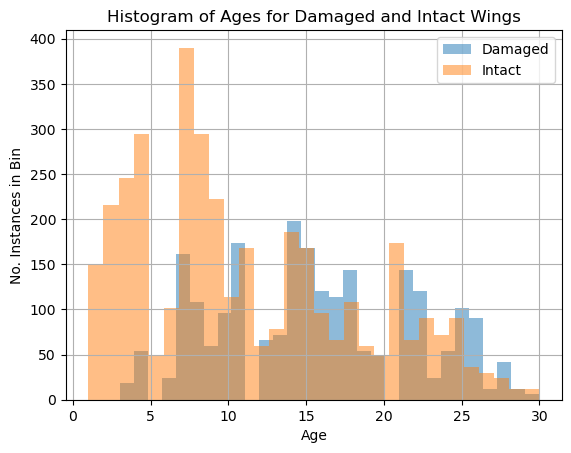

In [37]:
df[df['Damaged?']]['Age'].hist(bins=30, alpha=0.5, label='Damaged')
df[~df['Damaged?']]['Age'].hist(bins=30, alpha=0.5, label='Intact')
plt.legend()
plt.xlabel('Age')
plt.ylabel('No. Instances in Bin')
plt.title('Histogram of Ages for Damaged and Intact Wings')

<Axes: >

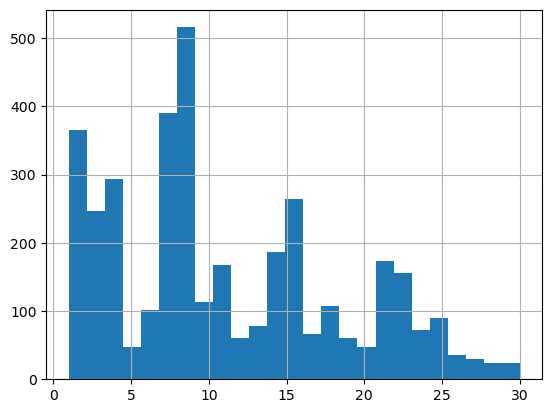

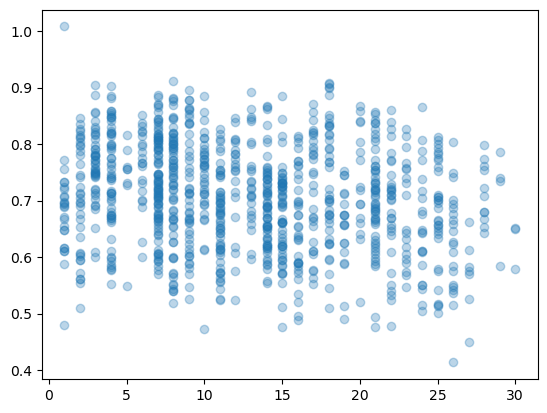

In [21]:
af = df[df['Cell'] == 'FWL']
plt.scatter(af['Age'],af['Area']/af['Perimeter'], alpha=0.3)

In [184]:
cf = df[df['Complexity'].map(len) > 0]
cf = cf.set_index('Filename')#(['Hive','BeeID','Date'])
for i in range(30):
    cf[i+1] = cf['Complexity'].map(lambda x: x[i])
cf = cf[list(range(1,31))]

cf['Age'] = cf.reset_index()['Filename'].map(df.drop_duplicates(subset=['Filename']).set_index('Filename')['Age']).values
cf['BeeType'] = cf.reset_index()['Filename'].map(df.drop_duplicates(subset=['Filename']).set_index('Filename')['Bee_type']).values

cf

1         2         3         4         5  \
Filename                                                                  
2024_06_28_h13b30.png  0.279427  0.235899  0.113234  0.085314  0.062558   
2024_07_16_h23b11.png  0.310058  0.245425  0.102118  0.080754  0.064112   
2024_06_27_h01b36.png  0.308680  0.230354  0.096769  0.080424  0.060420   
2024_06_21_h05b13.png  0.288375  0.245462  0.093590  0.073772  0.059347   
2024_06_18_h11b17.png  0.292531  0.225043  0.099687  0.076365  0.059519   
...                         ...       ...       ...       ...       ...   
2024_07_24_h34b23.png  0.296240  0.224500  0.089646  0.072973  0.055677   
2024_06_26_h11b10.png  0.303251  0.261678  0.134917  0.103346  0.087215   
2024_06_27_h01b41.png  0.315120  0.206183  0.117181  0.085297  0.065266   
2024_06_28_h13b24.png  0.287069  0.227627  0.109307  0.081117  0.060667   
2024_06_20_h03b10.png  0.295439  0.228886  0.101881  0.078562  0.056230   

                              6         7         8         9        10  ...  \
Filename                                                                 ...   
2024_06_28_h13b30.png  0.055078  0.048246  0.033655  0.028303  0.026071  ...   
2024_07_16_h23b11.png  0.055567  0.048825  0.035316  0.029601  0.025892  ...   
2024_06_27_h01b36.png  0.046306  0.041100  0.032474  0.026582  0.024341  ...   
2024_06_21_h05b13.png  0.048122  0.039053  0.032345  0.026489  0.022114  ...   
2024_06_18_h11b17.png  0.046124  0.041525  0.032251  0.024851  0.021716  ...   
...                         ...       ...       ...       ...       ...  ...   
2024_07_24_h34b23.png  0.042808  0.035870  0.029698  0.025900  0.022489  ...   
2024_06_26_h11b10.png  0.074460  0.057236  0.043842  0.040682  0.036630  ...   
2024_06_27_h01b41.png  0.058783  0.055168  0.044212  0.034532  0.027154  ...   
2024_06_28_h13b24.png  0.050232  0.044108  0.033500  0.028304  0.026229  ...   
2024_06_20_h03b10.png  0.048860  0.044842  0.031898  0.024271  0.022025  ...   

                             23        24        25        26        27  \
Filename                                                                  
2024_06_28_h13b30.png  0.013366       NaN       NaN       NaN       NaN   
2024_07_16_h23b11.png  0.011486  0.011236  0.010769  0.010388  0.010030   
2024_06_27_h01b36.png  0.009558  0.008987  0.008588  0.008582  0.008277   
2024_06_21_h05b13.png  0.011227  0.010265  0.010004  0.009416  0.009293   
2024_06_18_h11b17.png  0.010821  0.010517  0.010212  0.009601  0.009203   
...                         ...       ...       ...       ...       ...   
2024_07_24_h34b23.png  0.010687  0.009515  0.009183  0.009125  0.008848   
2024_06_26_h11b10.png  0.014903  0.014416  0.013473  0.011791  0.011545   
2024_06_27_h01b41.png  0.012027  0.011285  0.010806  0.010554  0.010242   
2024_06_28_h13b24.png  0.010638  0.010445  0.010010  0.009125  0.008912   
2024_06_20_h03b10.png  0.011734  0.011146  0.010067  0.009433  0.009185   

                             28        29        30   Age  BeeType  
Filename                                                            
2024_06_28_h13b30.png       NaN       NaN       NaN  11.0  Forager  
2024_07_16_h23b11.png  0.009967  0.009581  0.009161  15.0   Nester  
2024_06_27_h01b36.png  0.007936  0.007748  0.007583  24.0   Nester  
2024_06_21_h05b13.png  0.008917  0.008877  0.008145  22.0   Nester  
2024_06_18_h11b17.png  0.008799  0.008621  0.008468   1.0    Flyer  
...                         ...       ...       ...   ...      ...  
2024_07_24_h34b23.png  0.008614  0.008155  0.008201  13.0    Flyer  
2024_06_26_h11b10.png  0.010692  0.009827  0.008986  12.0  Forager  
2024_06_27_h01b41.png  0.009417  0.009535  0.009635  24.0   Nester  
2024_06_28_h13b24.png  0.008158  0.008127  0.007787  14.0   Nester  
2024_06_20_h03b10.png  0.008838  0.008771  0.008755  21.0   Nester  

[1182 rows x 32 columns]

/tmp/ipykernel_8423/836129537.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15,5))


<Figure size 1500x500 with 0 Axes>

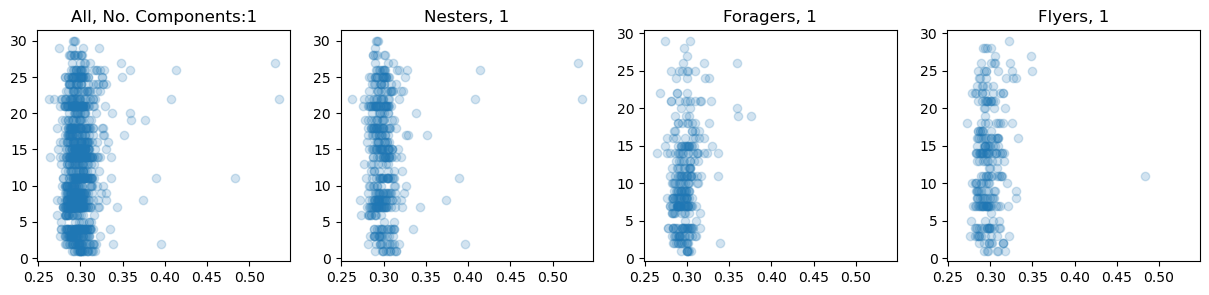

<Figure size 1500x500 with 0 Axes>

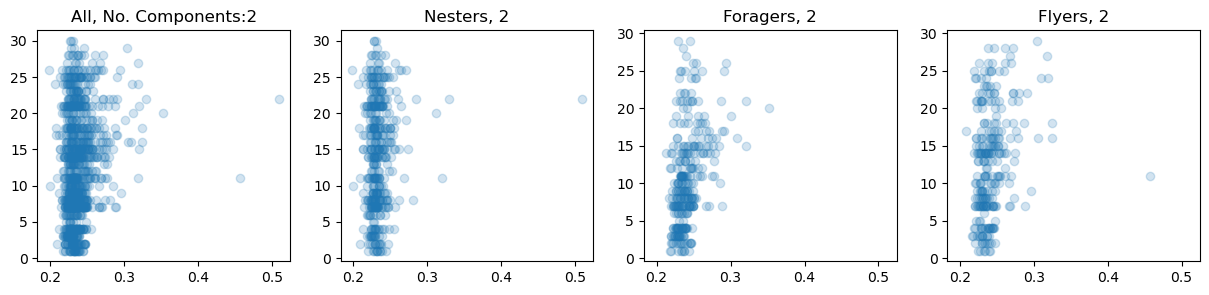

<Figure size 1500x500 with 0 Axes>

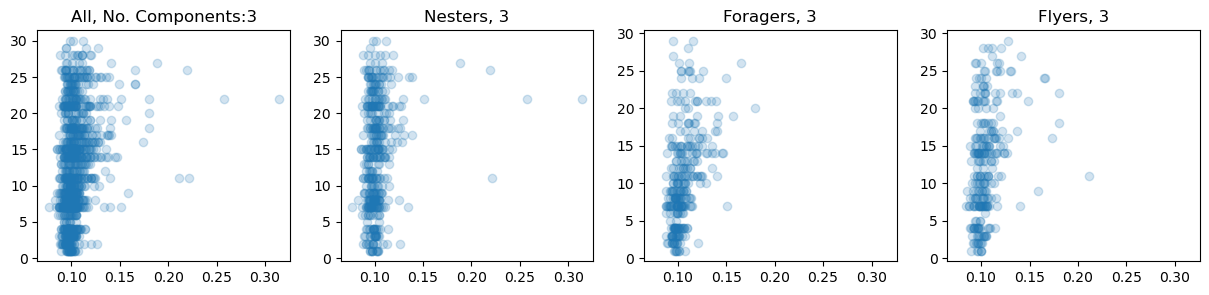

<Figure size 1500x500 with 0 Axes>

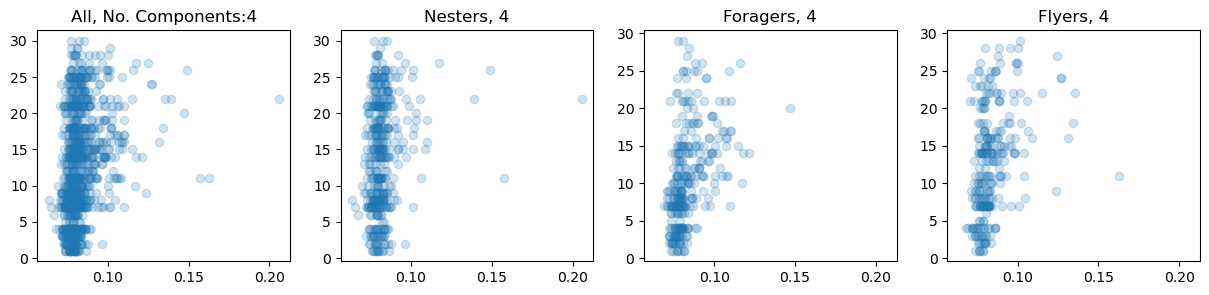

<Figure size 1500x500 with 0 Axes>

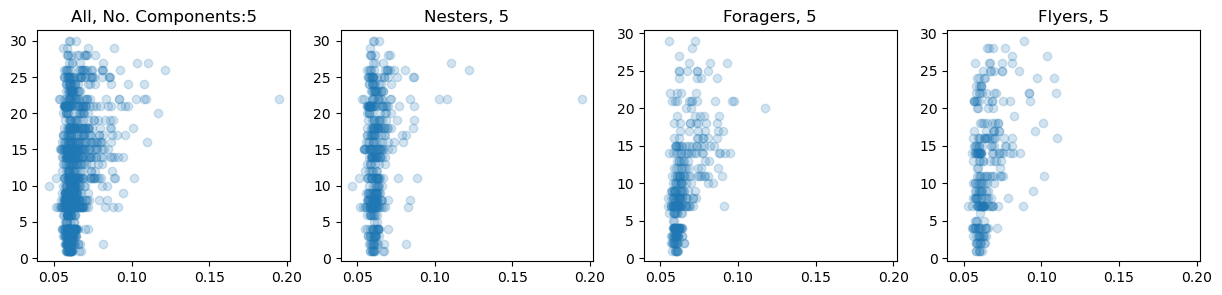

<Figure size 1500x500 with 0 Axes>

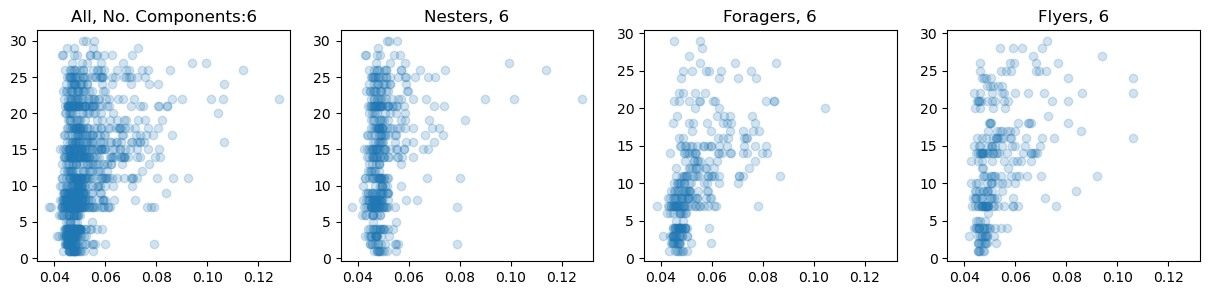

<Figure size 1500x500 with 0 Axes>

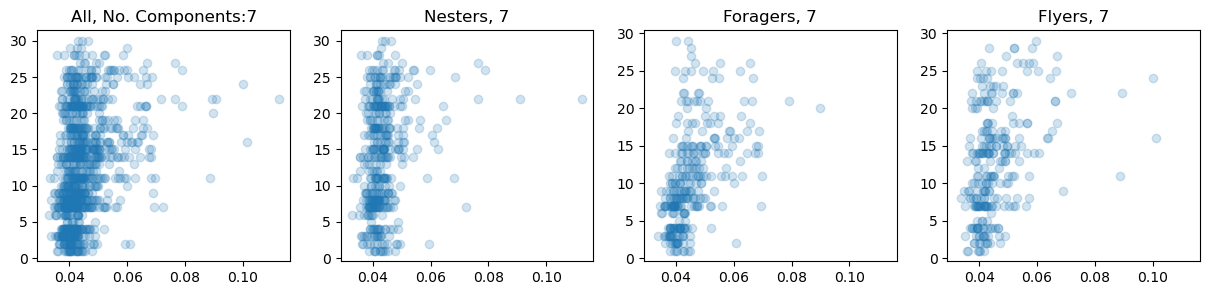

<Figure size 1500x500 with 0 Axes>

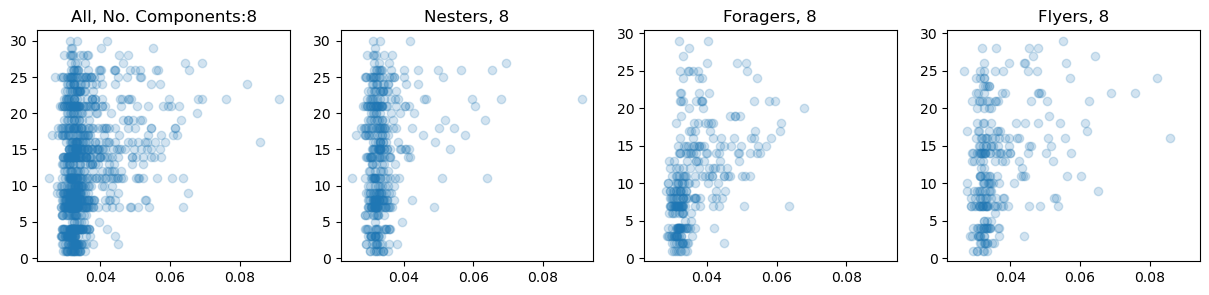

<Figure size 1500x500 with 0 Axes>

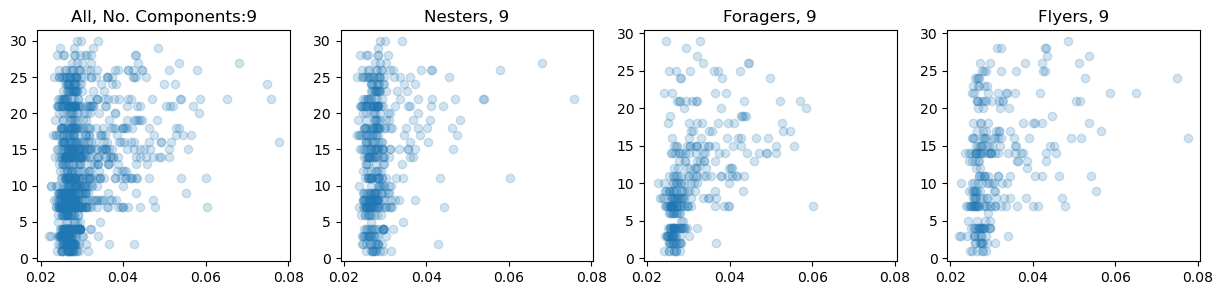

<Figure size 1500x500 with 0 Axes>

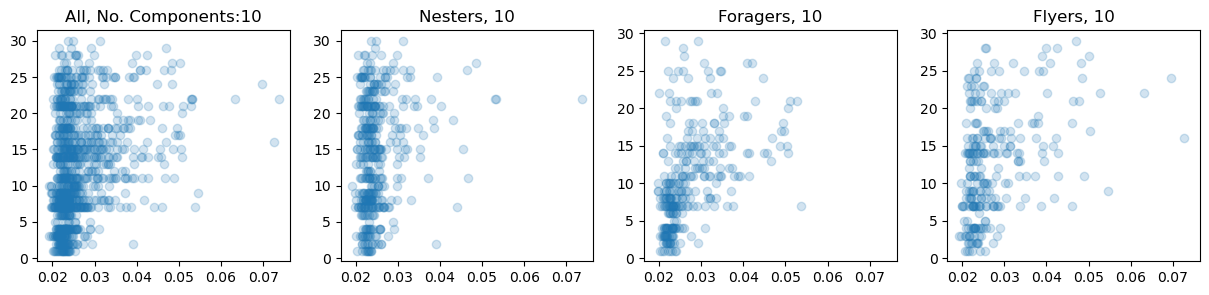

<Figure size 1500x500 with 0 Axes>

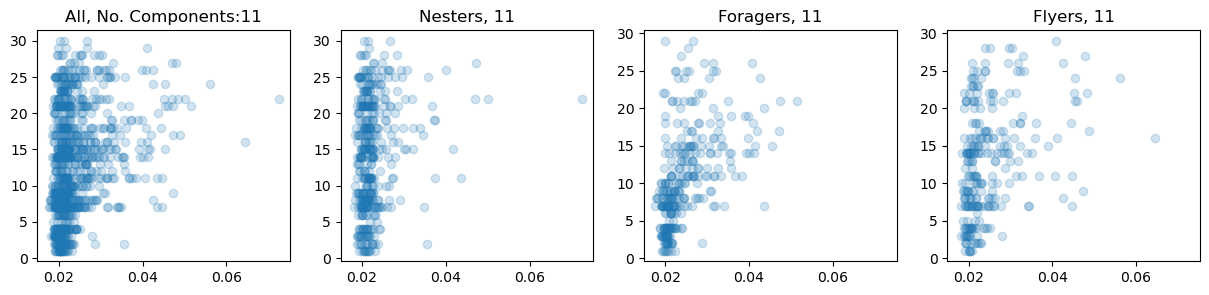

<Figure size 1500x500 with 0 Axes>

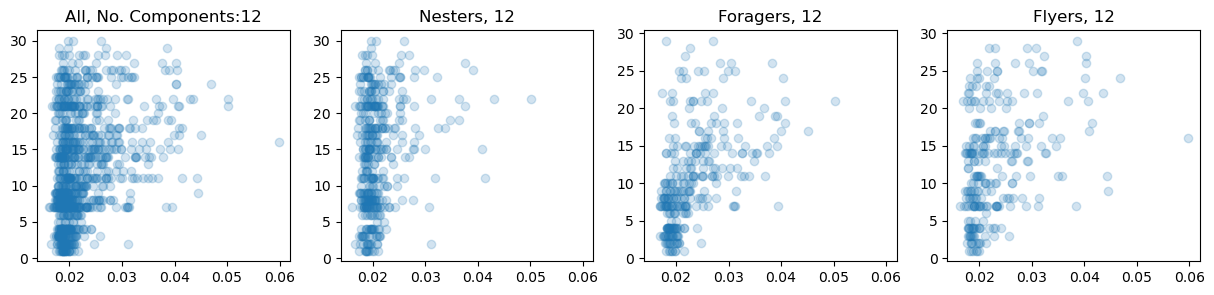

<Figure size 1500x500 with 0 Axes>

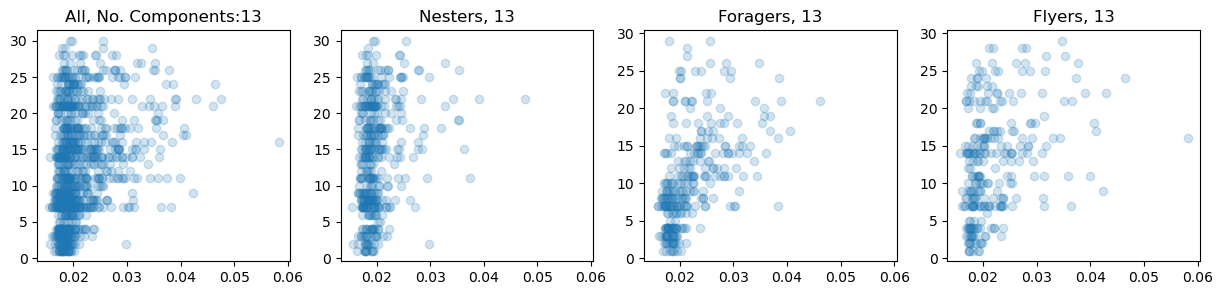

<Figure size 1500x500 with 0 Axes>

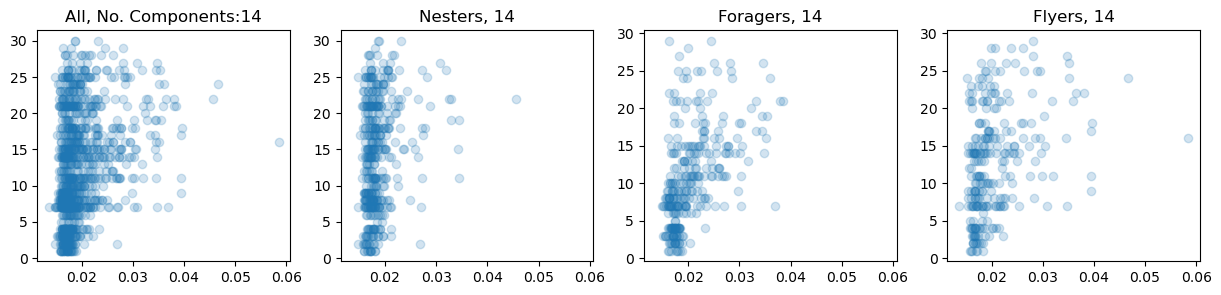

<Figure size 1500x500 with 0 Axes>

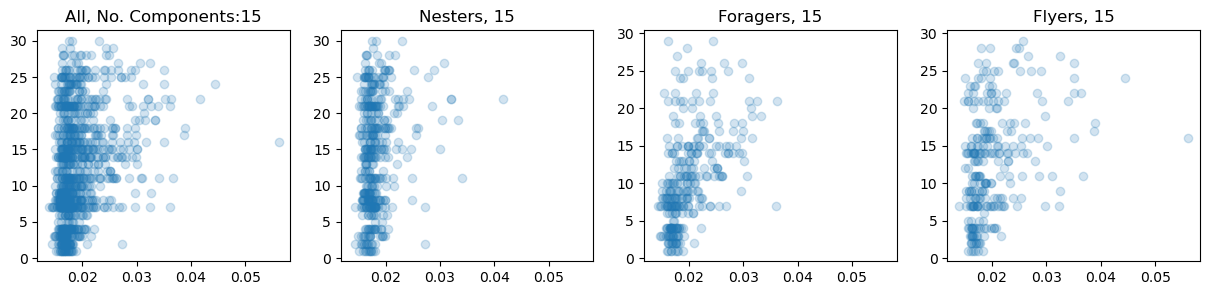

<Figure size 1500x500 with 0 Axes>

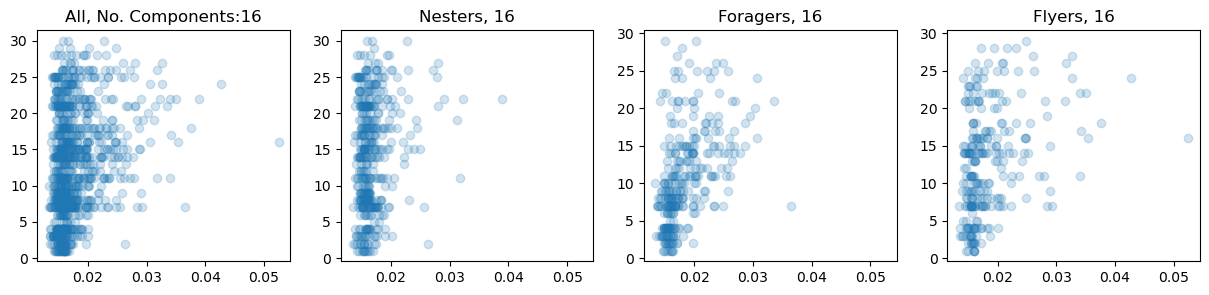

<Figure size 1500x500 with 0 Axes>

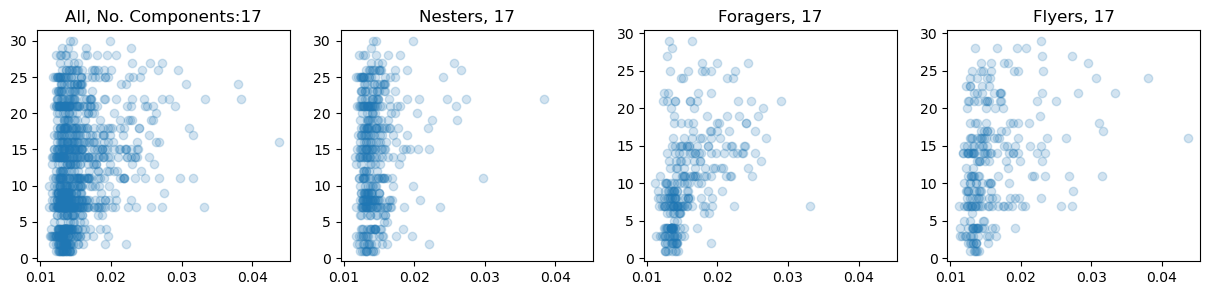

<Figure size 1500x500 with 0 Axes>

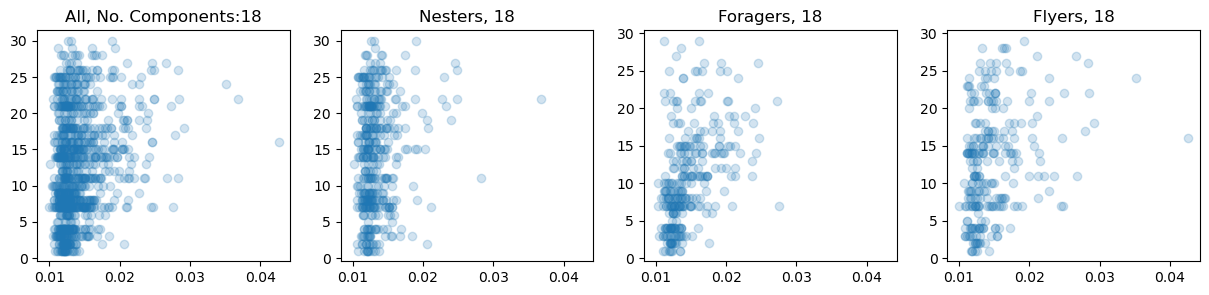

<Figure size 1500x500 with 0 Axes>

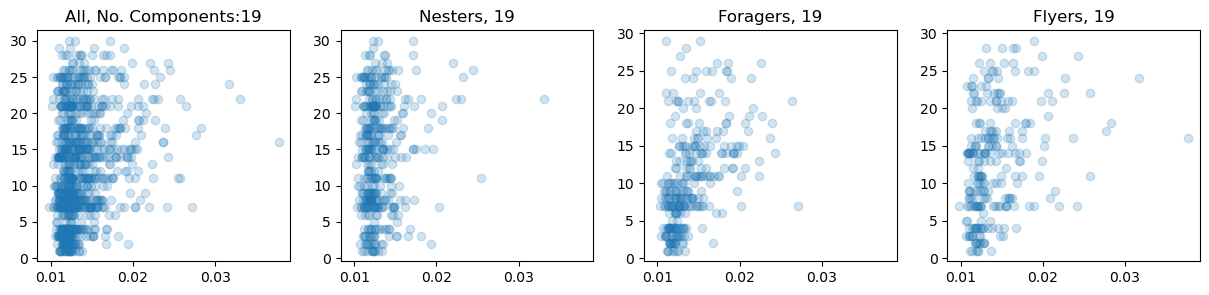

<Figure size 1500x500 with 0 Axes>

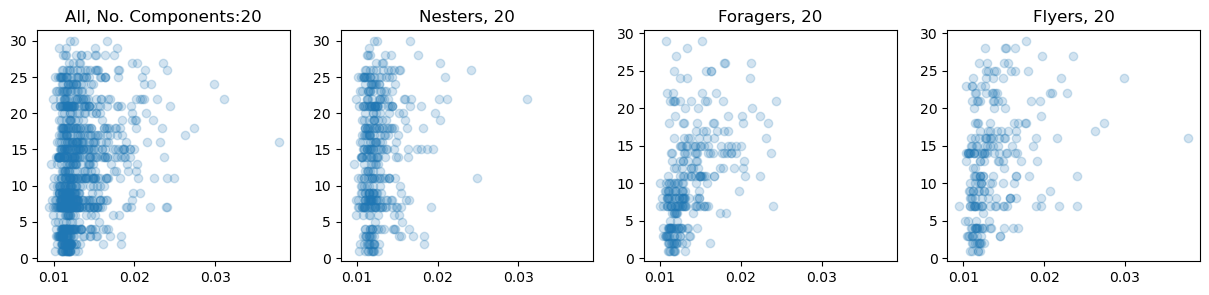

<Figure size 1500x500 with 0 Axes>

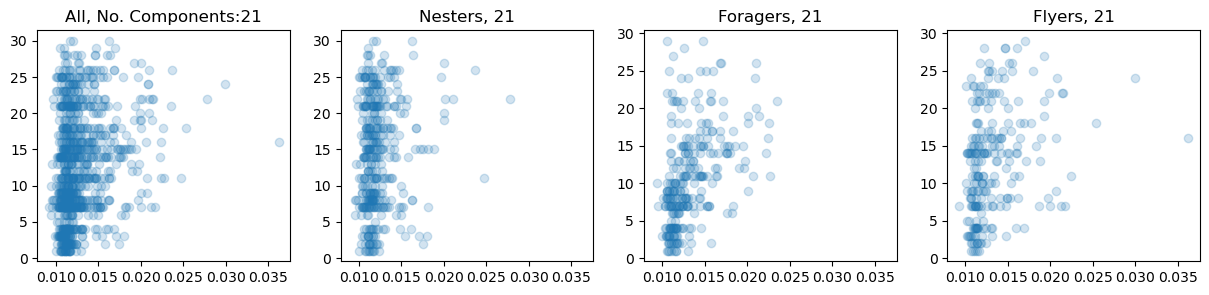

<Figure size 1500x500 with 0 Axes>

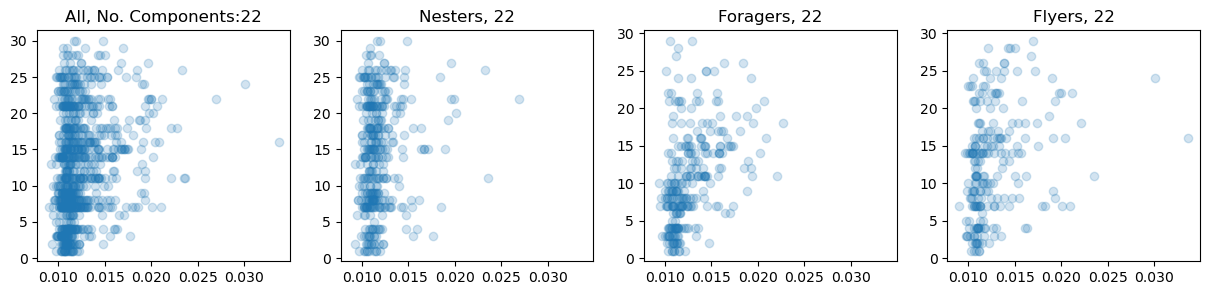

<Figure size 1500x500 with 0 Axes>

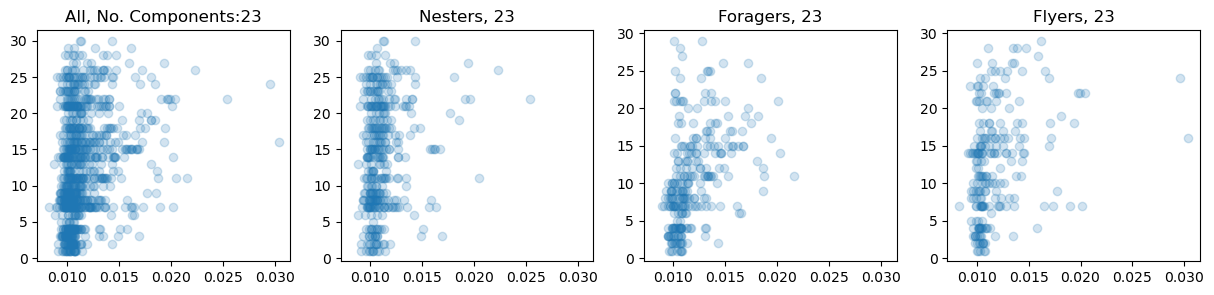

<Figure size 1500x500 with 0 Axes>

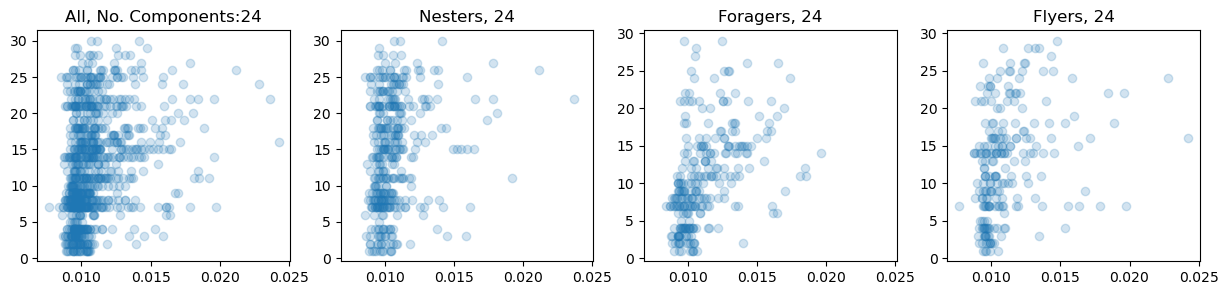

<Figure size 1500x500 with 0 Axes>

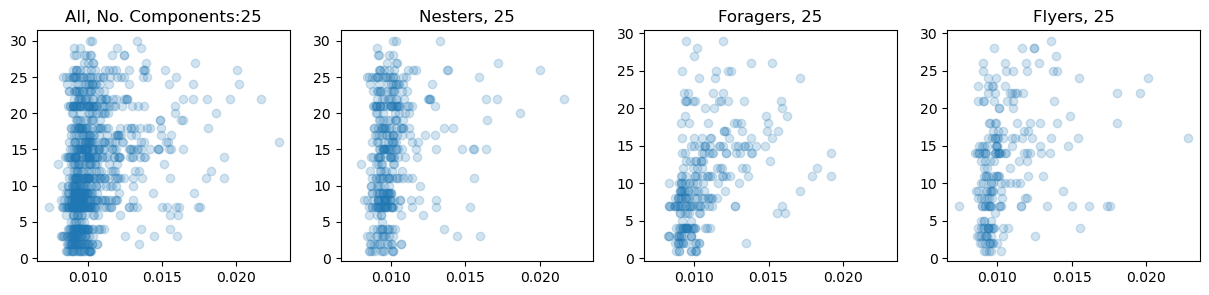

<Figure size 1500x500 with 0 Axes>

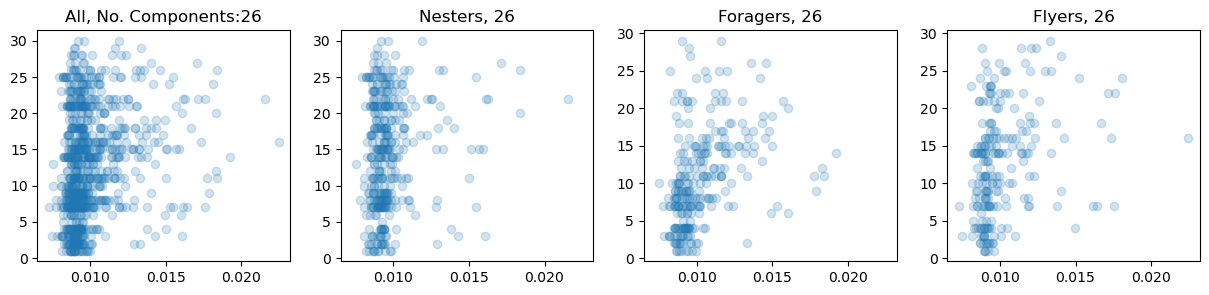

<Figure size 1500x500 with 0 Axes>

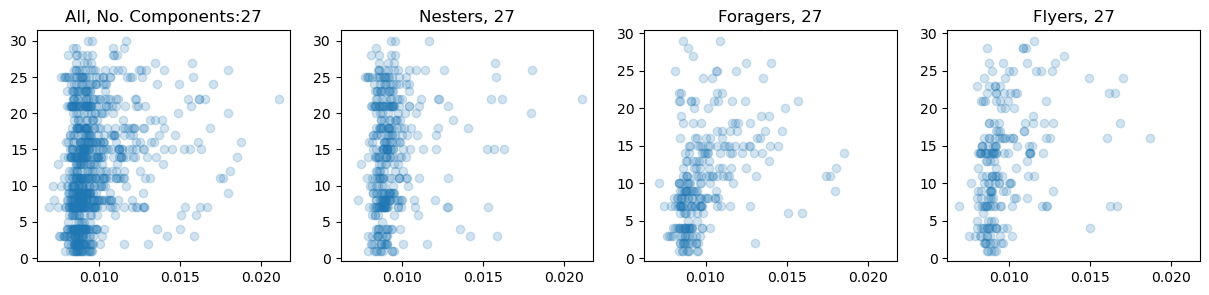

<Figure size 1500x500 with 0 Axes>

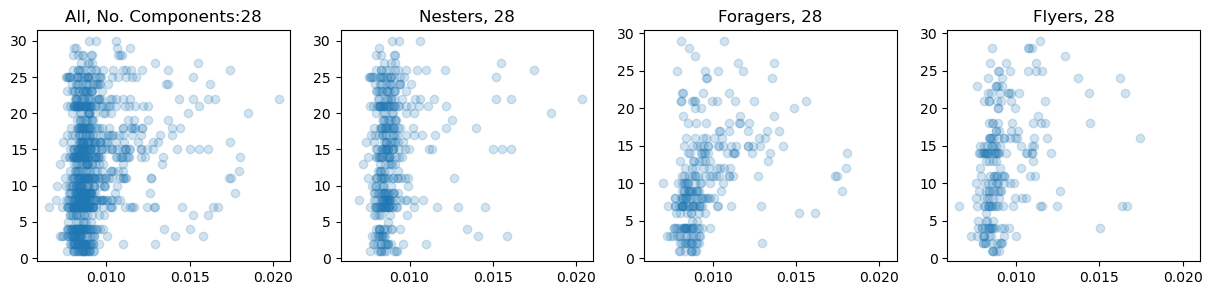

<Figure size 1500x500 with 0 Axes>

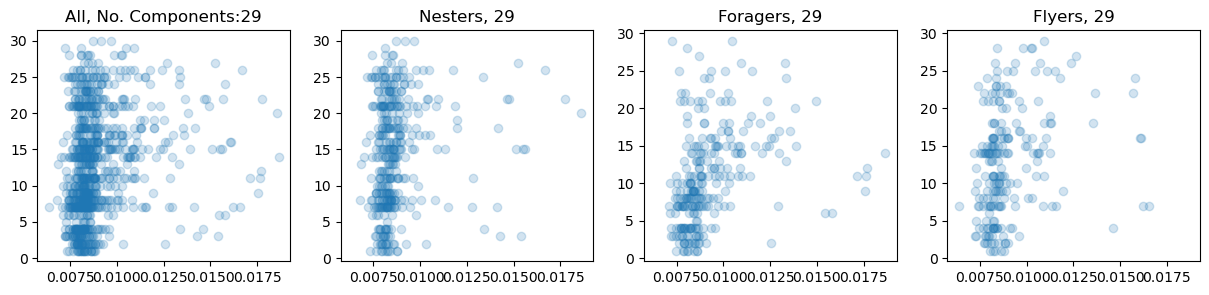

<Figure size 1500x500 with 0 Axes>

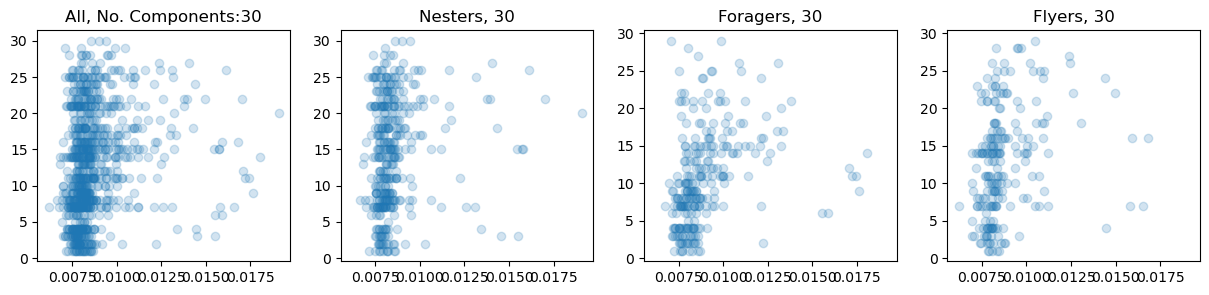

In [199]:
# plots

for n_circles in range(1,31):

    plt.figure(figsize=(15,5))
    fig, axs = plt.subplots(1, 4)
    fig.set_figwidth(15)
    fig.set_figheight(3)
    axs[0].scatter(cf[n_circles], cf['Age'], alpha=0.2)
    axs[0].set_title(f'All, No. Components:{n_circles}')

    nesters = cf[cf['BeeType'] == 'Nester']
    foragers = cf[cf['BeeType'] == 'Forager']
    flyers = cf[cf['BeeType'] == 'Flyer']

    #fig.set(xlabel='% area difference between approximation and FWL segmentation')

    for subset, subset_name, col in zip((nesters, foragers, flyers), ('Nesters','Foragers','Flyers'), (1,2,3)):
        axs[col].scatter(subset[n_circles], subset['Age'], alpha=0.2)
        axs[col].set_title(f'{subset_name}, {n_circles}')
        axs[col].sharex(axs[0])
    plt.savefig(f'{str(n_circles).zfill(2)}.png')

In [197]:
cf.to_csv('Fourier_Complexity.csv')

In [191]:
cf['Age'].dropna().to_csv('ages.csv')

In [144]:
df.drop_duplicates(subset=['Filename']).set_index('Filename')['Age']

Filename
2024_06_28_h13b30.png    11.0
2024_07_16_h23b11.png    15.0
2024_06_27_h01b36.png    24.0
2024_06_21_h05b13.png    22.0
2024_06_18_h11b17.png     1.0
                         ... 
2024_07_24_h34b23.png    13.0
2024_06_26_h11b10.png    12.0
2024_06_27_h01b41.png    24.0
2024_06_28_h13b24.png    14.0
2024_06_20_h03b10.png    21.0
Name: Age, Length: 1182, dtype: float64

In [11]:
# Estimate area loss
ref_wing = '2024_06_10_h02b62.png'
df[df['Filename'] == ref_wing]

Filename  Hive  BeeID        Date WingSide      X  Cell  \
5148  2024_06_10_h02b62.png     2     62  2024-06-10        R  False   FWL   
5149  2024_06_10_h02b62.png     2     62  2024-06-10        R  False    MC   
5150  2024_06_10_h02b62.png     2     62  2024-06-10        R  False  1sMC   
5151  2024_06_10_h02b62.png     2     62  2024-06-10        R  False  2sMC   
5152  2024_06_10_h02b62.png     2     62  2024-06-10        R  False  3sMC   
5153  2024_06_10_h02b62.png     2     62  2024-06-10        R  False  2MdC   

       Area  AreaLow  AreaHigh  Perimeter  PerimeterLow  PerimeterHigh  
5148  9.633    9.248    11.100     15.928        15.291         17.437  
5149  0.911    0.875     1.050      5.681         5.453          6.219  
5150  0.328    0.315     0.378      2.684         2.576          2.938  
5151  0.383    0.368     0.442      2.831         2.718          3.099  
5152  0.454    0.436     0.524      2.847         2.733          3.116  
5153  1.244    1.194     1.433      5.666         5.440          6.203

In [40]:
areas

Cell                    1sMC   2MdC   2sMC   3sMC     FWL     MC
Hive BeeID Date                                                 
1    ww01  2024-06-05  0.314  1.250  0.356  0.449   9.964  0.993
           2024-06-19  0.341  1.236  0.388  0.447   9.302  0.932
           2024-06-27  0.343  1.261  0.391  0.445   9.311  0.995
     ww02  2024-06-11  0.391  1.330  0.400  0.434  10.070  0.945
           2024-06-27  0.502  1.759  0.538  0.573  13.184  1.320
...                      ...    ...    ...    ...     ...    ...
35   ww55  2024-07-19  0.549  2.215  0.656  0.793  17.038  1.463
           2024-07-30  0.484  1.945  0.577  0.710  15.115  1.337
     ww57  2024-07-19  0.528  2.141  0.656  0.746  16.811  1.534
           2024-07-23  0.514  2.110  0.658  0.713  16.832  1.465
           2024-07-30  0.531  2.128  0.662  0.733  17.232  1.441

[1181 rows x 6 columns]

In [41]:
areas = pd.pivot_table(df, index = ['Hive','BeeID','Date'], columns='Cell', values='Area')
ref_areas = areas.loc[2,'ww62',pd.to_datetime('2024-06-10',format="%Y-%m-%d").date()]
ref_FWL_2MdC_ratio = ref_areas['FWL']/ref_areas['2MdC']
ref_FWL_2sMC_ratio = ref_areas['FWL']/ref_areas['2sMC']
ref_FWL_3sMC_ratio = ref_areas['FWL']/ref_areas['3sMC']

ref_FWL_2MdC_ratio

7.743569131832797

(2.9015060240963853,
 (array([ 1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,
          0.,  0.,  2.,  0.,  2.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,
          2.,  1.,  0.,  1.,  3.,  2.,  1.,  4.,  0.,  0.,  3.,  7.,  4.,
          3.,  0.,  2.,  3.,  3.,  2.,  4.,  4.,  4.,  7.,  8.,  9., 12.,
         14., 14., 18., 14., 20., 28., 27., 28., 28., 36., 36., 32., 36.,
         38., 39., 53., 44., 47., 38., 25., 37., 32., 29., 37., 23., 36.,
         30., 27., 33., 26., 24., 19., 17., 11., 17., 14.,  6., 10., 13.,
          4.,  5.,  2.,  3.,  3.,  0.,  2.,  0.,  1.]),
  array([2.11958511, 2.13113956, 2.142694  , 2.15424845, 2.1658029 ,
         2.17735734, 2.18891179, 2.20046623, 2.21202068, 2.22357512,
         2.23512957, 2.24668402, 2.25823846, 2.26979291, 2.28134735,
         2.2929018 , 2.30445624, 2.31601069, 2.32756513, 2.33911958,
         2.35067403, 2.36222847, 2.37378292, 2.38533736, 2.39689181,
         2.40844625, 2.4200007 , 2.43155515, 2.44310959, 2.4

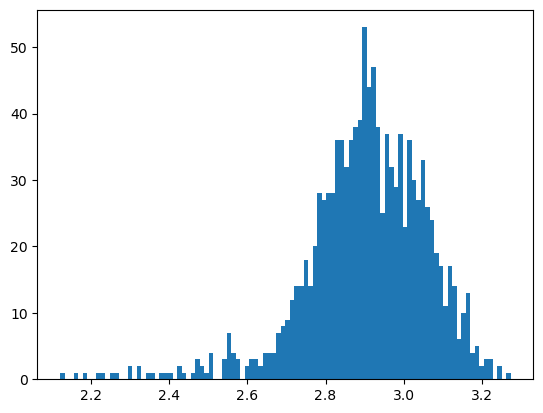

In [42]:
cella = 'FWL'
cellb = '2sMC'
cellc = '3sMC'
celld = '2MdC'
celle = 'MC'
cellf = '1sMC'
ref_areas[cella]/(ref_areas[cellb] + ref_areas[cellc] + ref_areas[celld] + ref_areas[celle] + ref_areas[cellf]), 
plt.hist(areas[cella] / (areas[cellb] + areas[cellc] + areas[celld] + areas[celle] + areas[cellf]), bins=100)

In [57]:
(areas[cella] / areas[cellb]).sort_values()

Hive  BeeID  Date      
3     44     2024-06-20    17.665158
13    32     2024-07-09    18.000000
15    14     2024-07-10    18.684385
             2024-07-03    18.821101
33    24     2024-08-02    18.929825
                             ...    
4     11     2024-06-07    29.798680
24    10     2024-07-10    30.694301
31    48     2024-07-17    33.734584
24    12     2024-07-10    38.541139
             2024-07-04    39.624390
Length: 1181, dtype: float64

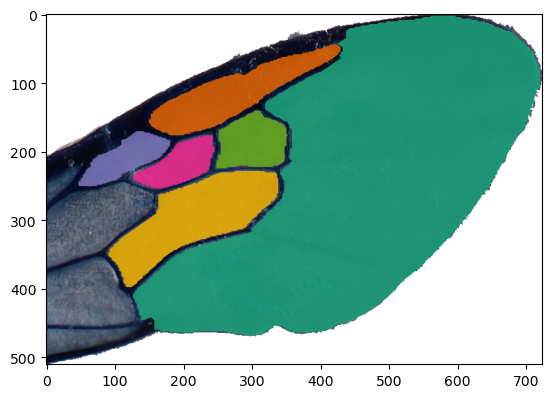

In [66]:
img = cv2.imread('../semantic_seg/wings/predictions_overlaid/2024_06_07_h04bee11.png')
plt.imshow(img)

In [ ]:
# Unimportant at the moment - slide images

In [132]:
# Find subset of slide images that are in the live bees set
relevant_slide_images = []

for name, row in tqdm(df.iterrows(),total=len(df)):
    hive_str = str(row['Hive']).zfill(2)
    bee_str = str(row['BeeID'])
    wing_side = 'left' if row['WingSide'] == 'L' else 'right'
    fps = glob(f'../1_slides/2_individual_wings/Hive{hive_str}_Sheet_*_slide*{bee_str}_{wing_side}.png')
    if len(fps) != 1:
        continue

    fp = fps[0]

    fn = Path(fp).name
    relevant_slide_images += [fn]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6984/6984 [00:24<00:00, 279.58it/s]


In [178]:
#after going through relevant slides...
relevant_slide_images = ['Hive01_Sheet_01_slide12_right.png',
 'Hive01_Sheet_01_slide32_right.png',
 'Hive01_Sheet_01_slide50_right.png',
 'Hive01_Sheet_02_slide115_right.png',
 'Hive01_Sheet_02_slide40_left.png',
 'Hive01_Sheet_02_slideww13_right.png',
 'Hive01_Sheet_02_slideww16_right.png',
 'Hive01_Sheet_02_slideww19_right.png',
 'Hive01_Sheet_02_slideww26_right.png',
 'Hive01_Sheet_02_slideww30_right.png',
 'Hive01_Sheet_02_slideww33_right.png',
 'Hive01_Sheet_02_slideww36_right.png',
 'Hive01_Sheet_02_slideww37_right.png',
 'Hive01_Sheet_03_slideww10_right.png',
 'Hive01_Sheet_03_slideww46_right.png',
 'Hive02_Sheet_01_slide12_right.png',
 'Hive02_Sheet_01_slide21_left.png',
 'Hive02_Sheet_01_slide21_right.png',
 'Hive02_Sheet_01_slide43_right.png',
 'Hive02_Sheet_01_slide44_right.png',
 'Hive02_Sheet_02_slide65_right.png',
 'Hive02_Sheet_03_slideww10_left.png',
 'Hive02_Sheet_03_slideww10_right.png',
 'Hive02_Sheet_03_slideww17_right.png',
 'Hive02_Sheet_03_slideww34_right.png',
 'Hive02_Sheet_03_slideww41_right.png',
 'Hive02_Sheet_03_slideww42_right.png',
 'Hive02_Sheet_03_slideww46_left.png',
 'Hive02_Sheet_03_slideww46_right.png',
 'Hive02_Sheet_03_slideww63_right.png',
 'Hive03_Sheet_01_slide115_right.png',
 'Hive03_Sheet_01_slide12_right.png',
 'Hive03_Sheet_01_slide16_right.png',
 'Hive03_Sheet_01_slide21_right.png',
 'Hive03_Sheet_01_slideww17_left.png',
 'Hive03_Sheet_01_slideww17_right.png',
 'Hive03_Sheet_01_slideww29_left.png',
 'Hive03_Sheet_01_slideww41_right.png',
 'Hive03_Sheet_01_slideww73_right.png',
 'Hive05_Sheet_01_slide67_right.png',
 'Hive05_Sheet_01_slidewv16_right.png',
 'Hive05_Sheet_01_slideww39_left.png',
 'Hive05_Sheet_01_slideww39_right.png',
 'Hive05_Sheet_01_slideww42_right.png',
 'Hive05_Sheet_01_slideww48_right.png',
 'Hive05_Sheet_01_slideww62_left.png',
 'Hive05_Sheet_01_slideww62_right.png',
 'Hive05_Sheet_01_slideww64_right.png',
 'Hive05_Sheet_01_slideww82_right.png',
 'Hive05_Sheet_01_slideww87_right.png',
 'Hive05_Sheet_01_slideww90_right.png',
 'Hive05_Sheet_01_slideww92_right.png',
 'Hive05_Sheet_01_slideww95_right.png',
 'Hive11_Sheet_01_slide10_right.png',
 'Hive11_Sheet_01_slide11_right.png',
 'Hive11_Sheet_01_slide14_right.png',
 'Hive11_Sheet_01_slide15_right.png',
 'Hive11_Sheet_01_slide18_right.png',
 'Hive11_Sheet_01_slide19_right.png',
 'Hive11_Sheet_01_slide24_right.png',
 'Hive11_Sheet_01_slide26_right.png',
 'Hive11_Sheet_01_slide27_right.png',
 'Hive11_Sheet_01_slideww13_right.png',
 'Hive11_Sheet_01_slideww17_right.png',
 'Hive11_Sheet_01_slideww20_right.png',
 'Hive11_Sheet_01_slideww28_right.png',
 'Hive12_Sheet_01_slide13_right.png',
 'Hive12_Sheet_01_slide25_right.png',
 'Hive12_Sheet_01_slide26_right.png',
 'Hive12_Sheet_01_slide27_right.png',
 'Hive12_Sheet_01_slide30_right.png',
 'Hive12_Sheet_02_slideww10_right.png',
 'Hive12_Sheet_02_slideww19_right.png',
 'Hive12_Sheet_02_slideww23_right.png',
 'Hive12_Sheet_02_slideww37_right.png',
 'Hive12_Sheet_02_slideww41_right.png',
 'Hive12_Sheet_02_slideww43_right.png',
 'Hive13_Sheet_01_slide11_right.png',
 'Hive13_Sheet_01_slide14_right.png',
 'Hive13_Sheet_01_slide20_right.png',
 'Hive13_Sheet_01_slide21_right.png',
 'Hive13_Sheet_01_slide30_right.png',
 'Hive13_Sheet_01_slide33_right.png',
 'Hive13_Sheet_01_slide34_right.png',
 'Hive13_Sheet_01_slide35_right.png',
 'Hive13_Sheet_01_slide36_right.png',
 'Hive13_Sheet_02_slideww15_right.png',
 'Hive13_Sheet_02_slideww18_right.png',
 'Hive13_Sheet_02_slideww23_right.png',
 'Hive13_Sheet_02_slideww24_right.png',
 'Hive13_Sheet_02_slideww28_right.png',
 'Hive14_Sheet_01_slide13_right.png',
 'Hive14_Sheet_01_slide18_right.png',
 'Hive14_Sheet_01_slide20_right.png',
 'Hive14_Sheet_01_slideww12_right.png',
 'Hive14_Sheet_01_slideww21_right.png',
 'Hive14_Sheet_02_slideww28_right.png',
 'Hive14_Sheet_02_slideww32_right.png',
 'Hive14_Sheet_02_slideww33_right.png',
 'Hive14_Sheet_02_slideww35_right.png',
 'Hive14_Sheet_02_slideww36_right.png',
 'Hive14_Sheet_02_slideww37_right.png',
 'Hive14_Sheet_02_slideww39_right.png',
 'Hive14_Sheet_02_slideww40_right.png',
 'Hive15_Sheet_01_slide11_right.png',
 'Hive15_Sheet_01_slide12_right.png',
 'Hive15_Sheet_01_slide25_right.png',
 'Hive15_Sheet_01_slide26_right.png',
 'Hive15_Sheet_01_slide28_right.png',
 'Hive15_Sheet_01_slide32_right.png',
 'Hive15_Sheet_01_slide35_right.png',
 'Hive15_Sheet_02_slideww14_right.png',
 'Hive15_Sheet_02_slideww24_right.png',
 'Hive15_Sheet_02_slideww31_right.png',
 'Hive21_Sheet_01_slide12_right.png',
 'Hive21_Sheet_01_slide22_right.png',
 'Hive21_Sheet_01_slide24_right.png',
 'Hive21_Sheet_01_slide39_right.png',
 'Hive21_Sheet_01_slide40_right.png',
 'Hive21_Sheet_01_slide41_right.png',
 'Hive21_Sheet_01_slide53_right.png',
 'Hive21_Sheet_01_slideww27_right.png',
 'Hive22_Sheet_01_slide19_right.png',
 'Hive22_Sheet_01_slide24_right.png',
 'Hive22_Sheet_01_slide26_right.png',
 'Hive22_Sheet_01_slide33_right.png',
 'Hive22_Sheet_01_slideww11_right.png',
 'Hive22_Sheet_01_slideww12_right.png',
 'Hive22_Sheet_01_slideww13_right.png',
 'Hive22_Sheet_01_slideww16_right.png',
 'Hive23_Sheet_01_slide15_right.png',
 'Hive23_Sheet_01_slide18_right.png',
 'Hive23_Sheet_01_slideww21_right.png',
 'Hive24_Sheet_01_slide10_right.png',
 'Hive24_Sheet_01_slide12_right.png',
 'Hive24_Sheet_01_slide17_right.png',
 'Hive24_Sheet_01_slide19_right.png',
 'Hive24_Sheet_01_slide24_right.png',
 'Hive25_Sheet_01_slide14_right.png',
 'Hive25_Sheet_01_slide17_right.png',
 'Hive25_Sheet_01_slide38_right.png',
 'Hive25_Sheet_01_slide51_right.png',
 'Hive25_Sheet_01_slideww16_right.png',
 'Hive25_Sheet_01_slideww27_right.png',
 'Hive25_Sheet_01_slideww32_right.png',
 'Hive31_Sheet_01_slideww26_right.png',
 'Hive32_Sheet_01_slide20_right.png',
 'Hive32_Sheet_01_slide22_right.png',
 'Hive32_Sheet_01_slide38_right.png',
 'Hive32_Sheet_01_slide39_right.png',
 'Hive32_Sheet_01_slideww16_right.png',
 'Hive32_Sheet_01_slideww29_right.png',
 'Hive32_Sheet_01_slideww31_right.png',
 'Hive33_Sheet_01_slideww24_right.png',
 'Hive33_Sheet_01_slideww28_right.png',
 'Hive33_Sheet_01_slideww3_right.png',
 'Hive33_Sheet_01_slideww59_right.png',
 'Hive33_Sheet_01_slideww7_right.png',
 'Hive34_Sheet_01_slide39_right.png',
 'Hive34_Sheet_01_slide46_right.png',
 'Hive34_Sheet_01_slideww15_right.png',
 'Hive34_Sheet_01_slideww37_right.png',
 'Hive34_Sheet_01_slideww48_right.png',
 'Hive34_Sheet_01_slideww56_right.png']

In [179]:
fps = glob('../semantic_seg/wings/predictions_resized/*')

for fp in tqdm(fps):
    fn = Path(fp).name

    if fn.startswith('20'):
        continue
    
    if fn not in relevant_slide_images:
        continue
    
    date = np.nan
    hive_id = int(re.findall('(?<=Hive)[0-9]*(?=_)', fn)[0])
    bee_id = int(re.findall('(?<=slide)[0-9]+', fn.replace('ww','').replace('wv',''))[0])
    x = 'x' in fn
    
    cells_mask = cv2.imread('../semantic_seg/wings/predictions_resized/' + fn, cv2.IMREAD_GRAYSCALE)
    #plt.imshow(cells_mask*40)

    pixels_per_mm = 3359/53.4
    pixels_per_mm_max = 3367/53.4
    pixels_per_mm_min = 3352/53.4

    wing_side = 'L' if 'left' in fn else 'R'

    for cell_class in range(1,7):
        cell_name = class_to_name[cell_class]
        cell_mask = np.zeros(cells_mask.shape).astype('uint8')
        cell_mask[np.where(cells_mask == cell_class)] = 1
        biggest_contour = get_biggest_contour(cell_mask)

        #convert to polygon because i suspect this will make the calculation of the perimeter more accurate
        poly = Polygon(biggest_contour.squeeze())

        pixel_area_min = poly.area*0.96
        pixel_area_max = poly.area*1.04
        
        area = np.round(poly.area / (pixels_per_mm)**2,3)
        area_min = np.round(pixel_area_min / (pixels_per_mm_max)**2,3)
        area_max = np.round(pixel_area_max / (pixels_per_mm_min)**2,3)

        pixel_perimeter_min = poly.length*0.96
        pixel_perimeter_max = poly.length*1.04
        
        perimeter = np.round(poly.length / pixels_per_mm,3)
        perimeter_min = np.round(pixel_perimeter_min / pixels_per_mm_max,3)
        perimeter_max = np.round(pixel_perimeter_max / pixels_per_mm_min,3)

        #print(cell_class, area, area_min, area_max, perimeter, perimeter_min, perimeter_max)

        out += [[fn, hive_id, bee_id, date, wing_side, x, cell_name, area, area_min, area_max, perimeter, perimeter_min, perimeter_max]]
    
poly.area, poly.length

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5714/5714 [00:00<00:00, 6268.83it/s]


(6508.0, 406.16652224137096)

In [174]:
df

Filename  Hive  BeeID        Date WingSide  \
0                  2024_06_28_h13b30.png    13     30  2024-06-28        R   
1                  2024_06_28_h13b30.png    13     30  2024-06-28        R   
2                  2024_06_28_h13b30.png    13     30  2024-06-28        R   
3                  2024_06_28_h13b30.png    13     30  2024-06-28        R   
4                  2024_06_28_h13b30.png    13     30  2024-06-28        R   
...                                  ...   ...    ...         ...      ...   
10915  Hive13_Sheet_01_slide20_right.png    13     20         NaN        R   
10916  Hive13_Sheet_01_slide20_right.png    13     20         NaN        R   
10917  Hive13_Sheet_01_slide20_right.png    13     20         NaN        R   
10918  Hive13_Sheet_01_slide20_right.png    13     20         NaN        R   
10919  Hive13_Sheet_01_slide20_right.png    13     20         NaN        R   

           X  Cell    Area  AreaMin  AreaMax  Perimeter  PerimeterMin  \
0      False   FWL  13.642   13.096   15.720     19.070        18.307   
1      False    MC   1.244    1.195    1.434      6.566         6.303   
2      False  1sMC   0.476    0.457    0.549      3.203         3.075   
3      False  2sMC   0.520    0.499    0.599      3.330         3.197   
4      False  3sMC   0.620    0.595    0.714      3.341         3.208   
...      ...   ...     ...      ...      ...        ...           ...   
10915  False    MC   1.226    1.171    1.280      6.656         6.375   
10916  False  1sMC   0.470    0.449    0.491      3.288         3.149   
10917  False  2sMC   0.563    0.538    0.588      3.440         3.294   
10918  False  3sMC   0.611    0.584    0.639      3.405         3.262   
10919  False  2MdC   1.745    1.667    1.822      6.651         6.369   

       PerimeterMax  
0            20.876  
1             7.188  
2             3.507  
3             3.646  
4             3.658  
...             ...  
10915         6.937  
10916         3.427  
10917         3.585  
10918         3.549  
10919         6.931  

[10920 rows x 13 columns]

In [184]:
df

Filename  Hive  BeeID        Date WingSide  \
0                 2024_06_28_h13b30.png    13     30  2024-06-28        R   
1                 2024_06_28_h13b30.png    13     30  2024-06-28        R   
2                 2024_06_28_h13b30.png    13     30  2024-06-28        R   
3                 2024_06_28_h13b30.png    13     30  2024-06-28        R   
4                 2024_06_28_h13b30.png    13     30  2024-06-28        R   
...                                 ...   ...    ...         ...      ...   
7963  Hive13_Sheet_01_slide20_right.png    13     20         NaN        R   
7964  Hive13_Sheet_01_slide20_right.png    13     20         NaN        R   
7965  Hive13_Sheet_01_slide20_right.png    13     20         NaN        R   
7966  Hive13_Sheet_01_slide20_right.png    13     20         NaN        R   
7967  Hive13_Sheet_01_slide20_right.png    13     20         NaN        R   

          X  Cell    Area  AreaLow  AreaHigh  Perimeter  PerimeterLow  \
0     False   FWL  13.642   13.096    15.720     19.070        18.307   
1     False    MC   1.244    1.195     1.434      6.566         6.303   
2     False  1sMC   0.476    0.457     0.549      3.203         3.075   
3     False  2sMC   0.520    0.499     0.599      3.330         3.197   
4     False  3sMC   0.620    0.595     0.714      3.341         3.208   
...     ...   ...     ...      ...       ...        ...           ...   
7963  False    MC   1.156    1.104     1.207      6.463         6.189   
7964  False  1sMC   0.443    0.423     0.463      3.192         3.057   
7965  False  2sMC   0.530    0.507     0.554      3.340         3.199   
7966  False  3sMC   0.576    0.551     0.602      3.306         3.167   
7967  False  2MdC   1.645    1.572     1.718      6.457         6.184   

      PerimeterHigh  
0            20.876  
1             7.188  
2             3.507  
3             3.646  
4             3.658  
...             ...  
7963          6.735  
7964          3.327  
7965          3.481  
7966          3.446  
7967          6.729  

[7968 rows x 13 columns]

In [182]:
df[(df['Hive'] == 13) & (df['BeeID'] == 20) & (df['Cell'] == '2sMC')]#.sort_values('Date')


Filename  Hive  BeeID        Date WingSide  \
3621              2024_07_02_h13b20.png    13     20  2024-07-02        R   
4347              2024_06_28_h13b20.png    13     20  2024-06-28        R   
7965  Hive13_Sheet_01_slide20_right.png    13     20         NaN        R   

          X  Cell   Area  AreaMin  AreaMax  Perimeter  PerimeterMin  \
3621  False  2sMC  0.571    0.548    0.658      3.553         3.411   
4347  False  2sMC  0.540    0.519    0.623      3.382         3.247   
7965  False  2sMC  0.530    0.507    0.554      3.340         3.199   

      PerimeterMax  
3621         3.890  
4347         3.703  
7965         3.481

In [185]:
df.to_csv('areas_and_perimeters.csv')

In [109]:
df.groupby(['Hive','BeeID']).count()['Date'].sort_values()

Hive  BeeID
5     45        6
12    13        6
34    35        6
      36        6
      38        6
               ..
14    22       24
      33       24
15    19       24
      4        24
3     17       30
Name: Date, Length: 610, dtype: int64

In [120]:
df[(df['Hive'] == 15) & (df['BeeID'] == 19) & (df['Cell'] == '2sMC')].sort_values('Date')

Filename  Hive  BeeID        Date WingSide      X  Cell  \
6441  2024_06_21_h15b19.png    15     19  2024-06-21        R  False  2sMC   
651   2024_06_25_h15b19.png    15     19  2024-06-25        R  False  2sMC   
2403  2024_07_03_h15b19.png    15     19  2024-07-03        R  False  2sMC   
6009  2024_07_10_h15b19.png    15     19  2024-07-10        R  False  2sMC   

       Area  AreaMin  AreaMax  Perimeter  PerimeterMin  PerimeterMax  
6441  0.567    0.544    0.653      3.483         3.344         3.813  
651   0.522    0.501    0.602      3.361         3.227         3.680  
2403  0.605    0.581    0.698      3.611         3.466         3.953  
6009  0.594    0.570    0.684      3.512         3.371         3.845

In [63]:
pixels_per_mm**2

13409.64